In [1]:
import numpy as np
import pandas as pd

def benchmark(x1, x2):
    return (    (1.3356 * (1.5 * (1 - x1))) 
                + (np.exp((2 * x1) - 1) * np.sin((3 * np.pi) * ((x1 - 0.6) ** 2)))
                + (np.exp(3 * (x2 - 0.5)) * np.sin((4 * np.pi) * ((x2 - 0.9) ** 2)))
            )

def getData(grid):
    x1 = np.linspace(0, 1, grid)
    x2 = np.linspace(0, 1, grid)
    x1, x2 = np.meshgrid(x1, x2)
    f_x1_x2 = benchmark(x1, x2)
    data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': f_x1_x2.flatten()}
    df = pd.DataFrame(data)
    return df


df_1000 = getData(32)
df_test = pd.read_excel("../Kriging-data.xlsx", sheet_name="Test")
df_training = pd.read_excel("../Kriging-data.xlsx", sheet_name="Training")
df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Spherical")

/tmp/ipykernel_11926/1703994658.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


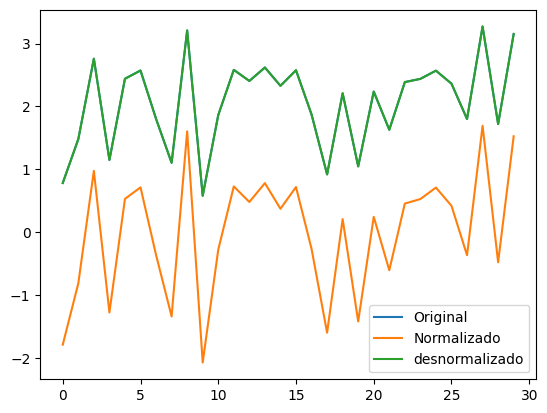

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 8.25 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-09-10 10:20:09.480881: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-10 10:20:09.481059: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-10 10:20:09.816623: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-10 10:20:10.358190: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-10 10:20:17.680901: W tensorflow/compiler/tf2

In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [8]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[4], [8], [12], [24], [36],
                            [4, 2], [8, 4], [12, 6], [24, 12], [36, 18]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[4], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  38
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_0_9  0.415935  0.254453  0.073747  0.362802  0.219870  0.442589   
model_1_0_8  0.405830  0.247394  0.065960  0.351743  0.223674  0.446779   
model_1_0_7  0.395532  0.240226  0.058084  0.340481  0.227551  0.451034   
model_1_0_6  0.385036  0.232947  0.050110  0.329009  0.231502  0.455356   
model_1_0_5  0.374336  0.225555  0.042037  0.317318  0.235530  0.459744   
model_1_0_4  0.363431  0.218050  0.033870  0.305412  0.239635  0.464199   
model_1_0_3  0.352317  0.210432  0.025608  0.293286  0.243819  0.468722   
model_1_0_2 -0.098773 -0.107310 -0.312892 -0.175542  0.413631  0.657347   
model_1_0_1 -0.119926 -0.121994 -0.329264 -0.200379  0.421594  0.666064   
model_1_0_0 -0.260867 -0.264620 -0.470295 -0.298213  0.474651  0.750733   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_0_9  0.648860  0.203076  0.247761  0.468903  0.327282  0.472552   
model_1_0_8  0.654315  0.206600  0.249819  0.472942  0.315644  0.476623   
model_1_0_7  0.659832  0.210190  0.251894  0.477023  0.303783  0.480735   
model_1_0_6  0.665417  0.213846  0.253986  0.481147  0.291693  0.484891   
model_1_0_5  0.671073  0.217572  0.256097  0.485314  0.279369  0.489091   
model_1_0_4  0.676794  0.221366  0.258225  0.489525  0.266809  0.493335   
model_1_0_3  0.682582  0.225231  0.260370  0.493780  0.254008  0.497623   
model_1_0_2  0.919708  0.374647  0.333784  0.643141 -0.265551  0.648147   
model_1_0_1  0.931177  0.382563  0.336901  0.649303 -0.289915  0.654356   
model_1_0_0  1.029973  0.413742  0.363941  0.688949 -0.452249  0.694311   

                   aic        bic  
model_1_0_9  37.029436  85.777522  
model_1_0_8  36.995130  85.743216  
model_1_0_7  36.960764  85.708850  
model_1_0_6  36.926333  85.674418  
model_1_0_5  36.891834  85.639919  
model_1_0_4  36.857276  85.605361  
model_1_0_3  36.822659  85.570745  
model_1_0_2  35.765562  84.513648  
model_1_0_1  35.727425  84.475510  
model_1_0_0  35.490350  84.238436

DataFrame salvo em ../results/metrics_1_0
+++++++++++ [1_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_1] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_1_9  0.505789  0.317851  0.140349  0.390795  0.186045  0.404953   
model_1_1_8  0.497533  0.311921  0.134051  0.382826  0.189153  0.408474   
model_1_1_7  0.489124  0.305902  0.127687  0.374710  0.192318  0.412047   
model_1_1_6  0.480549  0.299786  0.121216  0.366423  0.195546  0.415677   
model_1_1_5  0.471816  0.293580  0.114668  0.357984  0.198834  0.419362   
model_1_1_4  0.462918  0.287282  0.108037  0.349385  0.202183  0.423100   
model_1_1_3  0.453857  0.280893  0.101331  0.340628  0.205594  0.426893   
model_1_1_2  0.444630  0.274414  0.094546  0.331711  0.209068  0.430739   
model_1_1_1  0.435234  0.267847  0.087687  0.322634  0.212605  0.434638   
model_1_1_0  0.425668  0.261191  0.080749  0.313393  0.216206  0.438589   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_1_9  0.602204  0.165569  0.228657  0.431329  0.430774  0.434686   
model_1_1_8  0.606615  0.167734  0.230503  0.434917  0.421265  0.438302   
model_1_1_7  0.611074  0.169940  0.232363  0.438541  0.411580  0.441954   
model_1_1_6  0.615606  0.172192  0.234239  0.442206  0.401704  0.445648   
model_1_1_5  0.620194  0.174486  0.236130  0.445908  0.391645  0.449378   
model_1_1_4  0.624838  0.176823  0.238035  0.449648  0.381397  0.453147   
model_1_1_3  0.629536  0.179203  0.239954  0.453425  0.370961  0.456954   
model_1_1_2  0.634289  0.181626  0.241887  0.457240  0.360332  0.460798   
model_1_1_1  0.639094  0.184093  0.243832  0.461091  0.349511  0.464679   
model_1_1_0  0.643955  0.186605  0.245791  0.464980  0.338493  0.468598   

                   aic        bic  
model_1_1_9  37.363534  86.111620  
model_1_1_8  37.330400  86.078485  
model_1_1_7  37.297206  86.045292  
model_1_1_6  37.263916  86.012001  
model_1_1_5  37.230569  85.978655  
model_1_1_4  37.197160  85.945246  
model_1_1_3  37.163700  85.911786  
model_1_1_2  37.130190  85.878276  
model_1_1_1  37.096639  85.844724  
model_1_1_0  37.063046  85.811132

DataFrame salvo em ../results/metrics_1_1
+++++++++++ [1_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_2] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_2_9  0.581307  0.373777  0.203488  0.563516  0.157616  0.371753   
model_1_2_8  0.574408  0.368594  0.197561  0.555506  0.160213  0.374830   
model_1_2_7  0.567367  0.363322  0.191540  0.547325  0.162864  0.377960   
model_1_2_6  0.560192  0.357965  0.185451  0.538982  0.165565  0.381140   
model_1_2_5  0.552869  0.352515  0.179264  0.530460  0.168322  0.384375   
model_1_2_4  0.545406  0.346977  0.173004  0.521767  0.171131  0.387663   
model_1_2_3  0.537790  0.341343  0.166650  0.512891  0.173998  0.391007   
model_1_2_2  0.530025  0.335616  0.160211  0.503833  0.176921  0.394407   
model_1_2_1  0.522105  0.329793  0.153683  0.494588  0.179903  0.397864   
model_1_2_0  0.514028  0.323872  0.147063  0.485152  0.182943  0.401379   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_2_9  0.557973  0.145528  0.210780  0.397009  0.517755  0.400099   
model_1_2_8  0.562125  0.148199  0.212492  0.400267  0.509809  0.403382   
model_1_2_7  0.566343  0.150926  0.214221  0.403564  0.501699  0.406705   
model_1_2_6  0.570608  0.153708  0.215965  0.406897  0.493436  0.410063   
model_1_2_5  0.574942  0.156549  0.217727  0.410270  0.485001  0.413463   
model_1_2_4  0.579328  0.159447  0.219505  0.413680  0.476405  0.416899   
model_1_2_3  0.583779  0.162407  0.221300  0.417131  0.467633  0.420377   
model_1_2_2  0.588289  0.165427  0.223113  0.420620  0.458690  0.423893   
model_1_2_1  0.592863  0.168509  0.224943  0.424149  0.449568  0.427450   
model_1_2_0  0.597500  0.171655  0.226792  0.427719  0.440264  0.431047   

                   aic        bic  
model_1_2_9  37.695183  86.443268  
model_1_2_8  37.662497  86.410583  
model_1_2_7  37.629681  86.377767  
model_1_2_6  37.596785  86.344871  
model_1_2_5  37.563758  86.311844  
model_1_2_4  37.530649  86.278735  
model_1_2_3  37.497422  86.245508  
model_1_2_2  37.464102  86.212188  
model_1_2_1  37.430679  86.178765  
model_1_2_0  37.397157  86.145242

DataFrame salvo em ../results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_3] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_3_9  0.642523  0.418138  0.256719  0.635138  0.134571  0.345418   
model_1_3_8  0.636945  0.414053  0.251764  0.629803  0.136671  0.347843   
model_1_3_7  0.631253  0.409896  0.246740  0.624365  0.138814  0.350311   
model_1_3_6  0.625444  0.405661  0.241628  0.618816  0.141001  0.352825   
model_1_3_5  0.619517  0.401350  0.236439  0.613158  0.143232  0.355384   
model_1_3_4  0.613469  0.396962  0.231169  0.607388  0.145509  0.357989   
model_1_3_3  0.607296  0.392492  0.225809  0.601501  0.147833  0.360643   
model_1_3_2  0.600995  0.387940  0.220360  0.595495  0.150205  0.363345   
model_1_3_1  0.594566  0.383305  0.214827  0.589372  0.152625  0.366097   
model_1_3_0  0.588004  0.378585  0.209204  0.583125  0.155095  0.368899   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_3_9  0.520684  0.162660  0.194791  0.366840  0.588264  0.369695   
model_1_3_8  0.524155  0.165039  0.196317  0.369691  0.581838  0.372568   
model_1_3_7  0.527674  0.167463  0.197858  0.372577  0.575283  0.375477   
model_1_3_6  0.531256  0.169937  0.199415  0.375501  0.568592  0.378423   
model_1_3_5  0.534891  0.172459  0.200989  0.378460  0.561765  0.381405   
model_1_3_4  0.538582  0.175032  0.202578  0.381456  0.554799  0.384425   
model_1_3_3  0.542337  0.177656  0.204185  0.384490  0.547689  0.387482   
model_1_3_2  0.546154  0.180334  0.205808  0.387562  0.540432  0.390579   
model_1_3_1  0.550030  0.183064  0.207448  0.390672  0.533027  0.393713   
model_1_3_0  0.553969  0.185848  0.209105  0.393821  0.525469  0.396886   

                   aic        bic  
model_1_3_9  38.011321  86.759407  
model_1_3_8  37.980350  86.728436  
model_1_3_7  37.949241  86.697327  
model_1_3_6  37.917979  86.666064  
model_1_3_5  37.886578  86.634664  
model_1_3_4  37.855036  86.603121  
model_1_3_3  37.823347  86.571433  
model_1_3_2  37.791513  86.539599  
model_1_3_1  37.759543  86.507629  
model_1_3_0  37.727433  86.475519

DataFrame salvo em ../results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_4_9  0.692186  0.454948  0.301101  0.687895  0.115876  0.323566   
model_1_4_8  0.687655  0.451553  0.296959  0.683699  0.117582  0.325582   
model_1_4_7  0.683031  0.448096  0.292748  0.679422  0.119323  0.327634   
model_1_4_6  0.678315  0.444580  0.288481  0.675064  0.121098  0.329721   
model_1_4_5  0.673503  0.441000  0.284145  0.670621  0.122909  0.331846   
model_1_4_4  0.668595  0.437357  0.279747  0.666095  0.124757  0.334009   
model_1_4_3  0.663587  0.433648  0.275277  0.661480  0.126642  0.336211   
model_1_4_2  0.658477  0.429873  0.270739  0.656777  0.128566  0.338452   
model_1_4_1  0.653266  0.426031  0.266137  0.651985  0.130527  0.340733   
model_1_4_0  0.647948  0.422120  0.261462  0.647099  0.132529  0.343055   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_4_9  0.489593  0.160294  0.180496  0.340406  0.645464  0.343055   
model_1_4_8  0.492495  0.162449  0.181849  0.342902  0.640245  0.345571   
model_1_4_7  0.495444  0.164646  0.183216  0.345431  0.634919  0.348119   
model_1_4_6  0.498434  0.166884  0.184598  0.347991  0.629487  0.350699   
model_1_4_5  0.501471  0.169166  0.186010  0.350584  0.623945  0.353312   
model_1_4_4  0.504552  0.171491  0.187436  0.353209  0.618292  0.355958   
model_1_4_3  0.507684  0.173861  0.188877  0.355868  0.612524  0.358638   
model_1_4_2  0.510863  0.176276  0.190333  0.358560  0.606639  0.361351   
model_1_4_1  0.514087  0.178737  0.191804  0.361286  0.600636  0.364097   
model_1_4_0  0.517361  0.181246  0.193290  0.364046  0.594512  0.366879   

                   aic        bic  
model_1_4_9  38.310470  87.058555  
model_1_4_8  38.281241  87.029327  
model_1_4_7  38.251850  86.999936  
model_1_4_6  38.222312  86.970398  
model_1_4_5  38.192619  86.940704  
model_1_4_4  38.162778  86.910864  
model_1_4_3  38.132780  86.880866  
model_1_4_2  38.102633  86.850718  
model_1_4_1  38.072344  86.820429  
model_1_4_0  38.041904  86.789990

DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_5] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_5_9  0.733146  0.485276  0.340156  0.627844  0.100457  0.305562   
model_1_5_8  0.729409  0.482475  0.336481  0.622834  0.101864  0.307225   
model_1_5_7  0.725596  0.479627  0.332769  0.617726  0.103299  0.308916   
model_1_5_6  0.721706  0.476727  0.328996  0.612519  0.104763  0.310637   
model_1_5_5  0.717738  0.473777  0.325176  0.607209  0.106257  0.312389   
model_1_5_4  0.713690  0.470775  0.321303  0.601795  0.107781  0.314171   
model_1_5_3  0.709560  0.467722  0.317383  0.596275  0.109336  0.315983   
model_1_5_2  0.705346  0.464613  0.313400  0.590645  0.110922  0.317829   
model_1_5_1  0.701047  0.461448  0.309359  0.584905  0.112540  0.319708   
model_1_5_0  0.696661  0.458228  0.305263  0.579052  0.114191  0.321619   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_5_9  0.462235  0.124314  0.167826  0.316949  0.692642  0.319415   
model_1_5_8  0.464809  0.125987  0.169028  0.319161  0.688337  0.321645   
model_1_5_7  0.467409  0.127693  0.170242  0.321401  0.683946  0.323902   
model_1_5_6  0.470052  0.129433  0.171468  0.323671  0.679465  0.326190   
model_1_5_5  0.472728  0.131206  0.172707  0.325971  0.674895  0.328507   
model_1_5_4  0.475441  0.133015  0.173959  0.328300  0.670232  0.330855   
model_1_5_3  0.478187  0.134859  0.175223  0.330659  0.665475  0.333233   
model_1_5_2  0.480977  0.136739  0.176511  0.333049  0.660622  0.335641   
model_1_5_1  0.483808  0.138657  0.177826  0.335470  0.655670  0.338081   
model_1_5_0  0.486677  0.140612  0.179154  0.337922  0.650619  0.340552   

                   aic        bic  
model_1_5_9  38.596059  87.344145  
model_1_5_8  38.568241  87.316327  
model_1_5_7  38.540260  87.288346  
model_1_5_6  38.512107  87.260192  
model_1_5_5  38.483791  87.231877  
model_1_5_4  38.455310  87.203396  
model_1_5_3  38.426667  87.174753  
model_1_5_2  38.397860  87.145945  
model_1_5_1  38.368889  87.116975  
model_1_5_0  38.339761  87.087847

DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_6_9  0.768434  0.517188  0.379956  0.741204  0.087173  0.286618   
model_1_6_8  0.765216  0.514228  0.376221  0.738342  0.088384  0.288375   
model_1_6_7  0.761935  0.511221  0.372444  0.735416  0.089619  0.290160   
model_1_6_6  0.758585  0.508162  0.368604  0.732414  0.090880  0.291976   
model_1_6_5  0.755167  0.505053  0.364715  0.729343  0.092167  0.293822   
model_1_6_4  0.751679  0.501892  0.360760  0.726196  0.093480  0.295698   
model_1_6_3  0.748120  0.498678  0.356751  0.722974  0.094820  0.297606   
model_1_6_2  0.744488  0.495410  0.352681  0.719673  0.096187  0.299547   
model_1_6_1  0.740784  0.492088  0.348570  0.716299  0.097582  0.301518   
model_1_6_0  0.737003  0.488710  0.344394  0.712843  0.099005  0.303524   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_6_9  0.434353  0.049190  0.155711  0.295250  0.733286  0.297548   
model_1_6_8  0.436970  0.049734  0.156869  0.297294  0.729580  0.299608   
model_1_6_7  0.439616  0.050291  0.158039  0.299365  0.725800  0.301695   
model_1_6_6  0.442306  0.050861  0.159221  0.301464  0.721941  0.303810   
model_1_6_5  0.445030  0.051445  0.160414  0.303590  0.718005  0.305953   
model_1_6_4  0.447801  0.052043  0.161619  0.305745  0.713987  0.308125   
model_1_6_3  0.450609  0.052656  0.162836  0.307928  0.709888  0.310325   
model_1_6_2  0.453460  0.053283  0.164066  0.310141  0.705704  0.312554   
model_1_6_1  0.456340  0.053924  0.165307  0.312380  0.701438  0.314811   
model_1_6_0  0.459266  0.054581  0.166560  0.314650  0.697084  0.317099   

                   aic        bic  
model_1_6_9  38.879731  87.627817  
model_1_6_8  38.852132  87.600218  
model_1_6_7  38.824369  87.572455  
model_1_6_6  38.796422  87.544508  
model_1_6_5  38.768307  87.516393  
model_1_6_4  38.740013  87.488099  
model_1_6_3  38.711552  87.459637  
model_1_6_2  38.682918  87.431004  
model_1_6_1  38.654134  87.402220  
model_1_6_0  38.625179  87.373265

DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_7_9  0.796016  0.537740  0.409235  0.776745  0.076789  0.274418   
model_1_7_8  0.793505  0.535833  0.406444  0.774658  0.077735  0.275550   
model_1_7_7  0.790940  0.533897  0.403592  0.772525  0.078700  0.276699   
model_1_7_6  0.788323  0.531927  0.400714  0.770346  0.079685  0.277869   
model_1_7_5  0.785653  0.529923  0.397850  0.768128  0.080690  0.279058   
model_1_7_4  0.782928  0.527887  0.394940  0.765863  0.081716  0.280267   
model_1_7_3  0.780147  0.525817  0.392029  0.763553  0.082763  0.281496   
model_1_7_2  0.777309  0.523712  0.389081  0.761193  0.083832  0.282745   
model_1_7_1  0.774412  0.521574  0.386091  0.758783  0.084922  0.284014   
model_1_7_0  0.771454  0.519399  0.383049  0.756320  0.086036  0.285306   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_7_9  0.413843  0.059266  0.145430  0.277109  0.765054  0.279265   
model_1_7_8  0.415798  0.059821  0.146407  0.278809  0.762162  0.280979   
model_1_7_7  0.417796  0.060387  0.147400  0.280535  0.759208  0.282719   
model_1_7_6  0.419813  0.060965  0.148402  0.282286  0.756194  0.284483   
model_1_7_5  0.421819  0.061554  0.149415  0.284061  0.753118  0.286271   
model_1_7_4  0.423857  0.062155  0.150438  0.285861  0.749979  0.288086   
model_1_7_3  0.425897  0.062769  0.151471  0.287686  0.746777  0.289925   
model_1_7_2  0.427961  0.063395  0.152515  0.289537  0.743508  0.291790   
model_1_7_1  0.430056  0.064035  0.153569  0.291414  0.740171  0.293682   
model_1_7_0  0.432187  0.064689  0.154634  0.293318  0.736764  0.295601   

                   aic        bic  
model_1_7_9  39.133381  87.881466  
model_1_7_8  39.108907  87.856993  
model_1_7_7  39.084221  87.832307  
model_1_7_6  39.059339  87.807425  
model_1_7_5  39.034270  87.782356  
model_1_7_4  39.009000  87.757085  
model_1_7_3  38.983545  87.731630  
model_1_7_2  38.957892  87.705977  
model_1_7_1  38.932040  87.680126  
model_1_7_0  38.905987  87.654073

DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_8_9  0.819078  0.556298  0.452468  0.768788  0.068108  0.263401   
model_1_8_8  0.817321  0.555090  0.446530  0.766942  0.068769  0.264118   
model_1_8_7  0.815261  0.553495  0.442015  0.764734  0.069545  0.265065   
model_1_8_6  0.813136  0.551874  0.437051  0.762384  0.070345  0.266027   
model_1_8_5  0.810930  0.550078  0.432597  0.760051  0.071175  0.267093   
model_1_8_4  0.808588  0.548161  0.428788  0.757506  0.072057  0.268231   
model_1_8_3  0.806205  0.546211  0.424578  0.754904  0.072954  0.269389   
model_1_8_2  0.803741  0.544179  0.420705  0.752206  0.073881  0.270595   
model_1_8_1  0.801222  0.542088  0.416837  0.749443  0.074830  0.271836   
model_1_8_0  0.798648  0.539941  0.412981  0.746631  0.075798  0.273111   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_8_9  0.383558  0.047949  0.137407  0.260974  0.791617  0.263005   
model_1_8_8  0.387717  0.048331  0.137838  0.262239  0.789592  0.264280   
model_1_8_7  0.390880  0.048789  0.138565  0.263713  0.787220  0.265766   
model_1_8_6  0.394357  0.049277  0.139284  0.265226  0.784772  0.267290   
model_1_8_5  0.397478  0.049760  0.140048  0.266787  0.782232  0.268863   
model_1_8_4  0.400146  0.050288  0.140882  0.268434  0.779534  0.270523   
model_1_8_3  0.403095  0.050828  0.141701  0.270100  0.776790  0.272202   
model_1_8_2  0.405808  0.051387  0.142569  0.271811  0.773952  0.273926   
model_1_8_1  0.408518  0.051960  0.143476  0.273550  0.771050  0.275679   
model_1_8_0  0.411219  0.052544  0.144426  0.275315  0.768086  0.277458   

                   aic        bic  
model_1_8_9  39.373333  88.121419  
model_1_8_8  39.353994  88.102080  
model_1_8_7  39.331571  88.079657  
model_1_8_6  39.308695  88.056781  
model_1_8_5  39.285223  88.033309  
model_1_8_4  39.260602  88.008688  
model_1_8_3  39.235859  87.983944  
model_1_8_2  39.210593  87.958678  
model_1_8_1  39.185079  87.933165  
model_1_8_0  39.159354  87.907440

DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_9] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_9_9  0.862633  0.607752  0.551669  0.885777  0.051712  0.232855   
model_1_9_8  0.860385  0.604898  0.547596  0.883581  0.052558  0.234550   
model_1_9_7  0.851305  0.593502  0.528229  0.874300  0.055976  0.241315   
model_1_9_6  0.849850  0.591801  0.526084  0.872908  0.056524  0.242324   
model_1_9_5  0.848349  0.590060  0.523948  0.871474  0.057089  0.243358   
model_1_9_4  0.837570  0.577529  0.507008  0.860826  0.061146  0.250797   
model_1_9_3  0.835933  0.575681  0.504361  0.859198  0.061763  0.251894   
model_1_9_2  0.834010  0.573182  0.495675  0.856763  0.062487  0.253378   
model_1_9_1  0.832154  0.571127  0.493208  0.854956  0.063185  0.254598   
model_1_9_0  0.821181  0.558558  0.455563  0.841953  0.067316  0.262059   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_9_9  0.314065  0.043430  0.120315  0.227402  0.841783  0.229171   
model_1_9_8  0.316918  0.044265  0.121347  0.229255  0.839193  0.231039   
model_1_9_7  0.330486  0.047794  0.125340  0.236593  0.828735  0.238434   
model_1_9_6  0.331988  0.048323  0.125988  0.237747  0.827059  0.239598   
model_1_9_5  0.333484  0.048868  0.126658  0.238932  0.825331  0.240792   
model_1_9_4  0.345351  0.052917  0.131335  0.247278  0.812916  0.249202   
model_1_9_3  0.347205  0.053536  0.132012  0.248521  0.811030  0.250455   
model_1_9_2  0.353290  0.054462  0.132600  0.249973  0.808815  0.251919   
model_1_9_1  0.355018  0.055149  0.133379  0.251367  0.806677  0.253323   
model_1_9_0  0.381389  0.060093  0.136589  0.259454  0.794038  0.261473   

                   aic        bic  
model_1_9_9  39.924150  88.672235  
model_1_9_8  39.891679  88.639765  
model_1_9_7  39.765660  88.513746  
model_1_9_6  39.746185  88.494270  
model_1_9_5  39.726298  88.474383  
model_1_9_4  39.588967  88.337053  
model_1_9_3  39.568910  88.316995  
model_1_9_2  39.545603  88.293689  
model_1_9_1  39.523366  88.271452  
model_1_9_0  39.396707  88.144793

DataFrame salvo em ../results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_10] | 7 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_10] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_10_9  0.882876  0.624145  0.580079  0.844903  0.044091  0.223124   
model_1_10_8  0.882144  0.623524  0.579191  0.844277  0.044367  0.223492   
model_1_10_7  0.881370  0.622865  0.578345  0.843589  0.044658  0.223884   
model_1_10_6  0.880568  0.622172  0.577509  0.842854  0.044960  0.224295   
model_1_10_5  0.872739  0.615369  0.569039  0.835841  0.047907  0.228334   
model_1_10_4  0.867782  0.611848  0.558205  0.833401  0.049773  0.230424   
model_1_10_3  0.866974  0.611247  0.556571  0.832929  0.050077  0.230780   
model_1_10_2  0.865842  0.610308  0.555521  0.831879  0.050503  0.231338   
model_1_10_1  0.864742  0.609416  0.554354  0.830904  0.050918  0.231867   
model_1_10_0  0.863579  0.608464  0.553249  0.829835  0.051355  0.232433   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_10_9  0.294163  0.056904  0.110408  0.209979  0.865098  0.211613   
model_1_10_8  0.294785  0.057134  0.110806  0.210634  0.864255  0.212274   
model_1_10_7  0.295378  0.057386  0.111231  0.211325  0.863363  0.212969   
model_1_10_6  0.295964  0.057656  0.111666  0.212038  0.862440  0.213688   
model_1_10_5  0.301897  0.060229  0.115723  0.218877  0.853422  0.220581   
model_1_10_4  0.309486  0.061124  0.117999  0.223099  0.847713  0.224835   
model_1_10_3  0.310631  0.061297  0.118348  0.223780  0.846782  0.225521   
model_1_10_2  0.311367  0.061682  0.118869  0.224730  0.845479  0.226479   
model_1_10_1  0.312184  0.062040  0.119371  0.225649  0.844212  0.227405   
model_1_10_0  0.312959  0.062432  0.119908  0.226617  0.842872  0.228381   

                    aic        bic  
model_1_10_9  40.242992  88.991078  
model_1_10_8  40.230527  88.978613  
model_1_10_7  40.217434  88.965520  
model_1_10_6  40.203960  88.952046  
model_1_10_5  40.076975  88.825061  
model_1_10_4  40.000560  88.748646  
model_1_10_3  39.988370  88.736456  
model_1_10_2  39.971428  88.719513  
model_1_10_1  39.955096  88.703181  
model_1_10_0  39.937970  88.686056

DataFrame salvo em ../results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_11] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_11] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_11] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_11_9  0.894719  0.631308  0.589795  0.882161  0.039633  0.218872   
model_1_11_8  0.894200  0.630967  0.589532  0.881748  0.039828  0.219074   
model_1_11_7  0.893709  0.630662  0.589157  0.881365  0.040013  0.219255   
model_1_11_6  0.893177  0.630317  0.588857  0.880943  0.040213  0.219460   
model_1_11_5  0.890364  0.628691  0.585629  0.878875  0.041272  0.220425   
model_1_11_4  0.889765  0.628311  0.585283  0.878409  0.041498  0.220651   
model_1_11_3  0.889396  0.628155  0.584314  0.878185  0.041637  0.220743   
model_1_11_2  0.888785  0.627774  0.583925  0.877713  0.041867  0.220970   
model_1_11_1  0.884329  0.625045  0.580893  0.874344  0.043544  0.222590   
model_1_11_0  0.883603  0.624595  0.580485  0.873784  0.043817  0.222856   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_11_9  0.287357  0.052612  0.103385  0.199080  0.878738  0.200630   
model_1_11_8  0.287541  0.052796  0.103716  0.199570  0.878141  0.201123   
model_1_11_7  0.287804  0.052967  0.104028  0.200033  0.877575  0.201589   
model_1_11_6  0.288014  0.053156  0.104361  0.200533  0.876963  0.202093   
model_1_11_5  0.290275  0.054079  0.106121  0.203156  0.873723  0.204737   
model_1_11_4  0.290518  0.054287  0.106479  0.203710  0.873033  0.205295   
model_1_11_3  0.291197  0.054387  0.106704  0.204050  0.872608  0.205638   
model_1_11_2  0.291469  0.054598  0.107064  0.204613  0.871904  0.206206   
model_1_11_1  0.293593  0.056102  0.109602  0.208672  0.866772  0.210296   
model_1_11_0  0.293879  0.056352  0.110001  0.209326  0.865936  0.210955   

                    aic        bic  
model_1_11_9  40.456187  89.204273  
model_1_11_8  40.446357  89.194442  
model_1_11_7  40.437096  89.185182  
model_1_11_6  40.427116  89.175201  
model_1_11_5  40.375132  89.123218  
model_1_11_4  40.364233  89.112319  
model_1_11_3  40.357551  89.105637  
model_1_11_2  40.346531  89.094616  
model_1_11_1  40.267965  89.016050  
model_1_11_0  40.255447  89.003533

DataFrame salvo em ../results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_12] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_12] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_12] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_12_9  0.906934  0.651573  0.609158  0.915806  0.035034  0.206842   
model_1_12_8  0.906607  0.651008  0.608582  0.915640  0.035157  0.207177   
model_1_12_7  0.904693  0.647707  0.606086  0.914710  0.035878  0.209136   
model_1_12_6  0.904277  0.647015  0.605593  0.914502  0.036035  0.209547   
model_1_12_5  0.901592  0.642320  0.600556  0.912994  0.037045  0.212335   
model_1_12_4  0.901125  0.641583  0.599962  0.912740  0.037221  0.212772   
model_1_12_3  0.900633  0.640807  0.599392  0.912472  0.037406  0.213232   
model_1_12_2  0.899991  0.639634  0.597279  0.912053  0.037648  0.213929   
model_1_12_1  0.899492  0.638857  0.596639  0.911773  0.037836  0.214390   
model_1_12_0  0.898967  0.638044  0.596026  0.911479  0.038034  0.214873   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_12_9  0.273793  0.028780  0.095693  0.187175  0.892808  0.188631   
model_1_12_8  0.274196  0.028836  0.095901  0.187503  0.892432  0.188962   
model_1_12_7  0.275945  0.029154  0.097177  0.189415  0.890227  0.190889   
model_1_12_6  0.276290  0.029225  0.097449  0.189828  0.889748  0.191305   
model_1_12_5  0.279819  0.029741  0.099154  0.192472  0.886655  0.193970   
model_1_12_4  0.280235  0.029827  0.099440  0.192928  0.886118  0.194429   
model_1_12_3  0.280634  0.029919  0.099738  0.193407  0.885551  0.194912   
model_1_12_2  0.282115  0.030062  0.100120  0.194032  0.884811  0.195542   
model_1_12_1  0.282563  0.030158  0.100423  0.194515  0.884237  0.196028   
model_1_12_0  0.282992  0.030258  0.100748  0.195022  0.883632  0.196540   

                    aic        bic  
model_1_12_9  40.702854  89.450939  
model_1_12_8  40.695836  89.443922  
model_1_12_7  40.655260  89.403345  
model_1_12_6  40.646549  89.394635  
model_1_12_5  40.591220  89.339306  
model_1_12_4  40.581756  89.329841  
model_1_12_3  40.571830  89.319916  
model_1_12_2  40.558931  89.307017  
model_1_12_1  40.548992  89.297078  
model_1_12_0  40.538575  89.286661

DataFrame salvo em ../results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_13] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_13] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_13_9  0.916143  0.668311  0.630548  0.930683  0.031568  0.196905   
model_1_13_8  0.915993  0.667979  0.629971  0.930659  0.031624  0.197102   
model_1_13_7  0.915836  0.667626  0.629397  0.930633  0.031683  0.197312   
model_1_13_6  0.915020  0.665575  0.623448  0.930543  0.031991  0.198529   
model_1_13_5  0.914827  0.665184  0.622857  0.930488  0.032063  0.198761   
model_1_13_4  0.914639  0.664806  0.622217  0.930433  0.032134  0.198986   
model_1_13_3  0.913399  0.662147  0.616526  0.930052  0.032601  0.200564   
model_1_13_2  0.909379  0.655893  0.616872  0.928257  0.034114  0.204277   
model_1_13_1  0.909233  0.655529  0.615580  0.928203  0.034169  0.204493   
model_1_13_0  0.909021  0.655115  0.614485  0.928108  0.034249  0.204739   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_13_9  0.258809  0.025649  0.089178  0.177673  0.903415  0.179056   
model_1_13_8  0.259213  0.025658  0.089277  0.177832  0.903242  0.179216   
model_1_13_7  0.259615  0.025667  0.089383  0.177998  0.903061  0.179383   
model_1_13_6  0.263783  0.025701  0.089928  0.178860  0.902121  0.180251   
model_1_13_5  0.264196  0.025721  0.090079  0.179062  0.901899  0.180455   
model_1_13_4  0.264645  0.025741  0.090226  0.179260  0.901682  0.180655   
model_1_13_3  0.268632  0.025882  0.091140  0.180557  0.900254  0.181962   
model_1_13_2  0.268389  0.026546  0.094072  0.184700  0.895625  0.186137   
model_1_13_1  0.269294  0.026566  0.094174  0.184849  0.895455  0.186288   
model_1_13_0  0.270061  0.026602  0.094317  0.185064  0.895212  0.186505   

                    aic        bic  
model_1_13_9  40.911241  89.659327  
model_1_13_8  40.907655  89.655741  
model_1_13_7  40.903928  89.652013  
model_1_13_6  40.884618  89.632704  
model_1_13_5  40.880097  89.628183  
model_1_13_4  40.875677  89.623762  
model_1_13_3  40.846832  89.594918  
model_1_13_2  40.756098  89.504184  
model_1_13_1  40.752858  89.500944  
model_1_13_0  40.748206  89.496292

DataFrame salvo em ../results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_14] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_14] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_14] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_14] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_14_9  0.919930  0.678256  0.649672  0.888741  0.030142  0.191001   
model_1_14_8  0.919641  0.677316  0.647705  0.888799  0.030251  0.191559   
model_1_14_7  0.919585  0.677169  0.647464  0.888792  0.030272  0.191647   
model_1_14_6  0.919518  0.677000  0.647271  0.888769  0.030297  0.191747   
model_1_14_5  0.919158  0.675858  0.644624  0.888861  0.030433  0.192425   
model_1_14_4  0.918724  0.674378  0.640471  0.889063  0.030596  0.193303   
model_1_14_3  0.918642  0.674190  0.640179  0.889038  0.030627  0.193415   
model_1_14_2  0.918556  0.673990  0.639896  0.889009  0.030659  0.193534   
model_1_14_1  0.917731  0.671840  0.634703  0.889048  0.030970  0.194810   
model_1_14_0  0.917622  0.671607  0.634375  0.889002  0.031011  0.194948   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_14_9  0.245412  0.040729  0.086424  0.173615  0.907777  0.174966   
model_1_14_8  0.246790  0.040708  0.086677  0.173928  0.907444  0.175282   
model_1_14_7  0.246959  0.040710  0.086722  0.173989  0.907379  0.175343   
model_1_14_6  0.247094  0.040719  0.086774  0.174061  0.907302  0.175416   
model_1_14_5  0.248948  0.040685  0.087057  0.174450  0.906888  0.175807   
model_1_14_4  0.251857  0.040611  0.087383  0.174918  0.906387  0.176279   
model_1_14_3  0.252062  0.040620  0.087440  0.175006  0.906293  0.176368   
model_1_14_2  0.252261  0.040631  0.087500  0.175098  0.906194  0.176461   
model_1_14_1  0.255898  0.040617  0.088076  0.175983  0.905244  0.177352   
model_1_14_0  0.256128  0.040633  0.088153  0.176099  0.905119  0.177470   

                    aic        bic  
model_1_14_9  41.003662  89.751747  
model_1_14_8  40.996453  89.744539  
model_1_14_7  40.995057  89.743143  
model_1_14_6  40.993398  89.741483  
model_1_14_5  40.984471  89.732557  
model_1_14_4  40.973747  89.721833  
model_1_14_3  40.971745  89.719831  
model_1_14_2  40.969636  89.717722  
model_1_14_1  40.949474  89.697560  
model_1_14_0  40.946832  89.694918

DataFrame salvo em ../results/metrics_1_14
+++++++++++ [1_15] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_15] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_15] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_15] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_15] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_15] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_15_3  0.921441  0.679538  0.651540  0.938505  0.029573  0.190240   
model_1_15_2  0.921366  0.679514  0.651449  0.938630  0.029602  0.190255   
model_1_15_1  0.921235  0.679468  0.651104  0.938882  0.029651  0.190282   
model_1_15_5  0.921572  0.679413  0.652837  0.937909  0.029524  0.190314   
model_1_15_4  0.921487  0.679383  0.652319  0.938181  0.029556  0.190332   
model_1_15_6  0.921634  0.679346  0.652934  0.937765  0.029501  0.190354   
model_1_15_9  0.921810  0.679322  0.653218  0.937371  0.029434  0.190368   
model_1_15_8  0.921753  0.679295  0.653117  0.937492  0.029456  0.190385   
model_1_15_7  0.921691  0.679289  0.653046  0.937622  0.029479  0.190388   
model_1_15_0  0.920355  0.678557  0.650204  0.939842  0.029982  0.190823   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_15_3  0.244103  0.021821  0.085080  0.171969  0.909517  0.173308   
model_1_15_2  0.244168  0.021776  0.085155  0.172051  0.909431  0.173390   
model_1_15_1  0.244409  0.021687  0.085288  0.172194  0.909280  0.173534   
model_1_15_5  0.243195  0.022032  0.084930  0.171825  0.909668  0.173163   
model_1_15_4  0.243558  0.021936  0.085022  0.171919  0.909570  0.173257   
model_1_15_6  0.243127  0.022083  0.084864  0.171758  0.909739  0.173095   
model_1_15_9  0.242928  0.022223  0.084674  0.171564  0.909942  0.172900   
model_1_15_8  0.242999  0.022180  0.084734  0.171627  0.909877  0.172963   
model_1_15_7  0.243049  0.022134  0.084801  0.171696  0.909805  0.173032   
model_1_15_0  0.245040  0.021346  0.086070  0.173154  0.908266  0.174501   

                    aic        bic  
model_1_15_3  41.041756  89.789841  
model_1_15_2  41.039860  89.787945  
model_1_15_1  41.036531  89.784617  
model_1_15_5  41.045104  89.793190  
model_1_15_4  41.042929  89.791015  
model_1_15_6  41.046672  89.794758  
model_1_15_9  41.051184  89.799270  
model_1_15_8  41.049728  89.797814  
model_1_15_7  41.048130  89.796216  
model_1_15_0  41.014305  89.762391

DataFrame salvo em ../results/metrics_1_15
+++++++++++ [1_16] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_16] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_16] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_16] | 6 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_16] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_16] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_16_0  0.921939  0.679081  0.653554  0.928042  0.029386  0.190511   
model_1_16_1  0.921997  0.679043  0.653429  0.927881  0.029364  0.190534   
model_1_16_2  0.922232  0.678671  0.652986  0.926979  0.029275  0.190755   
model_1_16_3  0.922263  0.678476  0.652912  0.926763  0.029264  0.190871   
model_1_16_4  0.922382  0.678391  0.652979  0.926108  0.029219  0.190921   
model_1_16_5  0.922610  0.677064  0.652773  0.923424  0.029133  0.191709   
model_1_16_9  0.922911  0.676055  0.650708  0.919396  0.029020  0.192308   
model_1_16_7  0.922810  0.675940  0.650914  0.920621  0.029058  0.192376   
model_1_16_8  0.922838  0.675918  0.650775  0.920382  0.029048  0.192389   
model_1_16_6  0.922578  0.675678  0.651831  0.921747  0.029145  0.192531   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_16_0  0.242693  0.021142  0.084583  0.171424  0.910090  0.172758   
model_1_16_1  0.242780  0.021190  0.084536  0.171360  0.910157  0.172693   
model_1_16_2  0.243091  0.021455  0.084327  0.171101  0.910428  0.172432   
model_1_16_3  0.243143  0.021518  0.084297  0.171067  0.910464  0.172398   
model_1_16_4  0.243095  0.021711  0.084195  0.170936  0.910601  0.172266   
model_1_16_5  0.243240  0.022499  0.083850  0.170685  0.910863  0.172013   
model_1_16_9  0.244686  0.023683  0.083096  0.170352  0.911210  0.171678   
model_1_16_7  0.244542  0.023323  0.083298  0.170464  0.911094  0.171791   
model_1_16_8  0.244639  0.023393  0.083248  0.170434  0.911126  0.171760   
model_1_16_6  0.243900  0.022992  0.083617  0.170720  0.910827  0.172048   

                    aic        bic  
model_1_16_0  41.054471  89.802557  
model_1_16_1  41.055960  89.804046  
model_1_16_2  41.062011  89.810097  
model_1_16_3  41.062809  89.810895  
model_1_16_4  41.065864  89.813950  
model_1_16_5  41.071739  89.819824  
model_1_16_9  41.079546  89.827632  
model_1_16_7  41.076921  89.825007  
model_1_16_8  41.077639  89.825725  
model_1_16_6  41.070927  89.819013

DataFrame salvo em ../results/metrics_1_16
+++++++++++ [1_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_17] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_17] | 6 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_17] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_17] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_17_9  0.923654  0.679421  0.647543  0.918979  0.028740  0.190309   
model_1_17_8  0.923521  0.679070  0.649344  0.919319  0.028791  0.190518   
model_1_17_7  0.923414  0.678060  0.649864  0.920779  0.028831  0.191117   
model_1_17_6  0.923381  0.677686  0.649683  0.921297  0.028843  0.191340   
model_1_17_5  0.923370  0.677627  0.649707  0.921355  0.028847  0.191375   
model_1_17_4  0.923204  0.676928  0.650283  0.922242  0.028910  0.191789   
model_1_17_3  0.923184  0.676864  0.650355  0.922289  0.028917  0.191827   
model_1_17_2  0.923173  0.676809  0.650317  0.922343  0.028921  0.191860   
model_1_17_1  0.922984  0.676294  0.650945  0.922713  0.028992  0.192166   
model_1_17_0  0.922961  0.676232  0.651014  0.922749  0.029001  0.192203   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_17_9  0.246904  0.022641  0.082298  0.169530  0.912066  0.170849   
model_1_17_8  0.245642  0.022546  0.082489  0.169678  0.911912  0.170998   
model_1_17_7  0.245277  0.022138  0.082622  0.169796  0.911789  0.171117   
model_1_17_6  0.245404  0.021993  0.082659  0.169832  0.911752  0.171154   
model_1_17_5  0.245388  0.021977  0.082668  0.169844  0.911739  0.171166   
model_1_17_4  0.244984  0.021729  0.082831  0.170029  0.911547  0.171352   
model_1_17_3  0.244934  0.021716  0.082847  0.170050  0.911525  0.171374   
model_1_17_2  0.244960  0.021701  0.082853  0.170063  0.911512  0.171386   
model_1_17_1  0.244520  0.021597  0.083006  0.170271  0.911295  0.171597   
model_1_17_0  0.244472  0.021587  0.083026  0.170297  0.911268  0.171623   

                    aic        bic  
model_1_17_9  41.098904  89.846990  
model_1_17_8  41.095419  89.843505  
model_1_17_7  41.092635  89.840721  
model_1_17_6  41.091776  89.839861  
model_1_17_5  41.091490  89.839576  
model_1_17_4  41.087148  89.835234  
model_1_17_3  41.086641  89.834727  
model_1_17_2  41.086350  89.834436  
model_1_17_1  41.081446  89.829531  
model_1_17_0  41.080838  89.828923

DataFrame salvo em ../results/metrics_1_17
+++++++++++ [1_18] | 1 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_18] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_18] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_18] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_18] | 8 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_18] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_18_0  0.923828  0.677705  0.643948  0.922222  0.028675  0.191328   
model_1_18_1  0.923829  0.677584  0.643711  0.921897  0.028674  0.191400   
model_1_18_2  0.923766  0.676659  0.642449  0.919597  0.028698  0.191949   
model_1_18_3  0.923641  0.675529  0.641532  0.917363  0.028745  0.192620   
model_1_18_4  0.923525  0.674520  0.640135  0.915285  0.028789  0.193219   
model_1_18_5  0.923416  0.673487  0.638450  0.913363  0.028830  0.193833   
model_1_18_6  0.923353  0.673139  0.638423  0.912788  0.028854  0.194039   
model_1_18_7  0.922991  0.670636  0.635509  0.908734  0.028990  0.195525   
model_1_18_8  0.922894  0.669715  0.633110  0.907187  0.029027  0.196072   
model_1_18_9  0.922873  0.669576  0.632895  0.906969  0.029034  0.196154   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_18_0  0.249422  0.028618  0.081928  0.169336  0.912267  0.170654   
model_1_18_1  0.249588  0.028737  0.081914  0.169335  0.912267  0.170653   
model_1_18_2  0.250472  0.029584  0.081847  0.169405  0.912195  0.170723   
model_1_18_3  0.251114  0.030405  0.081863  0.169544  0.912051  0.170863   
model_1_18_4  0.252093  0.031170  0.081821  0.169673  0.911917  0.170993   
model_1_18_5  0.253274  0.031877  0.081775  0.169794  0.911791  0.171115   
model_1_18_6  0.253292  0.032089  0.081808  0.169864  0.911719  0.171186   
model_1_18_7  0.255333  0.033580  0.081835  0.170264  0.911302  0.171589   
model_1_18_8  0.257014  0.034150  0.081709  0.170372  0.911190  0.171698   
model_1_18_9  0.257165  0.034230  0.081706  0.170395  0.911166  0.171721   

                    aic        bic  
model_1_18_0  41.103481  89.851567  
model_1_18_1  41.103501  89.851587  
model_1_18_2  41.101857  89.849943  
model_1_18_3  41.098572  89.846658  
model_1_18_4  41.095536  89.843621  
model_1_18_5  41.092679  89.840764  
model_1_18_6  41.091037  89.839123  
model_1_18_7  41.081616  89.829702  
model_1_18_8  41.079086  89.827172  
model_1_18_9  41.078553  89.826638

DataFrame salvo em ../results/metrics_1_18
+++++++++++ [1_19] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_19] | 2 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_19] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_19] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_19] | 6 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_19] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_19] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_19] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_19_9  0.923548  0.691322  0.662241  0.892569  0.028780  0.183245   
model_1_19_8  0.923550  0.691106  0.661988  0.892744  0.028780  0.183373   
model_1_19_7  0.923558  0.690914  0.661619  0.892938  0.028776  0.183487   
model_1_19_6  0.923612  0.689044  0.658808  0.894538  0.028756  0.184597   
model_1_19_5  0.923618  0.688560  0.658133  0.894935  0.028754  0.184884   
model_1_19_4  0.923650  0.684275  0.651798  0.898347  0.028742  0.187428   
model_1_19_3  0.923568  0.680996  0.647664  0.900636  0.028773  0.189374   
model_1_19_2  0.923555  0.680678  0.647299  0.900848  0.028778  0.189564   
model_1_19_1  0.923387  0.677236  0.643439  0.902978  0.028841  0.191607   
model_1_19_0  0.922945  0.670408  0.634023  0.907106  0.029007  0.195660   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_19_9  0.236607  0.026940  0.081160  0.169648  0.911943  0.170968   
model_1_19_8  0.236785  0.026896  0.081168  0.169645  0.911946  0.170966   
model_1_19_7  0.237043  0.026847  0.081163  0.169636  0.911955  0.170956   
model_1_19_6  0.239012  0.026446  0.081167  0.169577  0.912017  0.170896   
model_1_19_5  0.239485  0.026346  0.081178  0.169570  0.912024  0.170889   
model_1_19_4  0.243923  0.025491  0.081247  0.169534  0.912061  0.170853   
model_1_19_3  0.246818  0.024917  0.081346  0.169626  0.911966  0.170946   
model_1_19_2  0.247075  0.024864  0.081358  0.169640  0.911952  0.170960   
model_1_19_1  0.249778  0.024329  0.081490  0.169826  0.911758  0.171147   
model_1_19_0  0.256375  0.023294  0.081671  0.170315  0.911249  0.171640   

                    aic        bic  
model_1_19_9  41.096124  89.844210  
model_1_19_8  41.096179  89.844264  
model_1_19_7  41.096402  89.844488  
model_1_19_6  41.097800  89.845885  
model_1_19_5  41.097967  89.846053  
model_1_19_4  41.098808  89.846894  
model_1_19_3  41.096648  89.844734  
model_1_19_2  41.096315  89.844401  
model_1_19_1  41.091927  89.840012  
model_1_19_0  41.080422  89.828508

DataFrame salvo em ../results/metrics_1_19
+++++++++++ [1_20] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_20] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_20] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_20] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_20] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_20] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_20_9  0.923466  0.711087  0.684002  0.917539  0.028811  0.171511   
model_1_20_8  0.923481  0.708280  0.682087  0.919260  0.028805  0.173178   
model_1_20_7  0.923480  0.707895  0.681811  0.919495  0.028806  0.173406   
model_1_20_6  0.923502  0.707203  0.680904  0.919931  0.028797  0.173817   
model_1_20_5  0.923541  0.703117  0.676943  0.922308  0.028783  0.176242   
model_1_20_4  0.923572  0.698346  0.671475  0.925045  0.028771  0.179075   
model_1_20_3  0.923580  0.696842  0.669668  0.925856  0.028768  0.179968   
model_1_20_2  0.923597  0.694058  0.665455  0.927437  0.028762  0.181620   
model_1_20_1  0.923587  0.693545  0.664835  0.927707  0.028766  0.181925   
model_1_20_0  0.923566  0.693016  0.664356  0.927981  0.028773  0.182239   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_20_9  0.221363  0.027870  0.081128  0.169739  0.911849  0.171060   
model_1_20_8  0.222705  0.027289  0.081239  0.169721  0.911867  0.171042   
model_1_20_7  0.222898  0.027209  0.081256  0.169723  0.911865  0.171044   
model_1_20_6  0.223534  0.027062  0.081256  0.169698  0.911891  0.171019   
model_1_20_5  0.226308  0.026258  0.081337  0.169655  0.911935  0.170976   
model_1_20_4  0.230139  0.025333  0.081308  0.169620  0.911972  0.170940   
model_1_20_3  0.231405  0.025059  0.081310  0.169612  0.911981  0.170931   
model_1_20_2  0.234356  0.024525  0.081153  0.169593  0.912001  0.170912   
model_1_20_1  0.234790  0.024434  0.081155  0.169604  0.911988  0.170924   
model_1_20_0  0.235125  0.024341  0.081172  0.169627  0.911964  0.170947   

                    aic        bic  
model_1_20_9  41.093981  89.842067  
model_1_20_8  41.094391  89.842477  
model_1_20_7  41.094353  89.842439  
model_1_20_6  41.094936  89.843022  
model_1_20_5  41.095943  89.844028  
model_1_20_4  41.096769  89.844855  
model_1_20_3  41.096979  89.845065  
model_1_20_2  41.097427  89.845512  
model_1_20_1  41.097147  89.845233  
model_1_20_0  41.096606  89.844692

DataFrame salvo em ../results/metrics_1_20
+++++++++++ [1_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_21] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_21] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_21] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_21_9  0.923315  0.716078  0.693738  0.909521  0.028868  0.168548   
model_1_21_8  0.923329  0.715866  0.693298  0.910392  0.028862  0.168674   
model_1_21_7  0.923347  0.715774  0.692958  0.910525  0.028856  0.168729   
model_1_21_6  0.923376  0.715339  0.691960  0.911513  0.028845  0.168987   
model_1_21_5  0.923382  0.715283  0.691751  0.911657  0.028843  0.169020   
model_1_21_4  0.923402  0.715222  0.691292  0.911801  0.028835  0.169056   
model_1_21_3  0.923401  0.715139  0.691177  0.911951  0.028836  0.169106   
model_1_21_2  0.923403  0.714316  0.689580  0.913660  0.028835  0.169594   
model_1_21_1  0.923381  0.713346  0.687263  0.915162  0.028843  0.170170   
model_1_21_0  0.923382  0.713224  0.686831  0.915326  0.028843  0.170243   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_21_9  0.214543  0.026207  0.080589  0.169906  0.911675  0.171228   
model_1_21_8  0.214851  0.025955  0.080688  0.169890  0.911692  0.171212   
model_1_21_7  0.215089  0.025916  0.080672  0.169870  0.911712  0.171192   
model_1_21_6  0.215788  0.025630  0.080752  0.169837  0.911746  0.171159   
model_1_21_5  0.215935  0.025588  0.080765  0.169832  0.911752  0.171153   
model_1_21_4  0.216256  0.025547  0.080756  0.169809  0.911776  0.171131   
model_1_21_3  0.216337  0.025503  0.080776  0.169811  0.911774  0.171132   
model_1_21_2  0.217456  0.025008  0.080953  0.169809  0.911776  0.171130   
model_1_21_1  0.219078  0.024573  0.081107  0.169833  0.911751  0.171154   
model_1_21_0  0.219381  0.024526  0.081114  0.169831  0.911753  0.171153   

                    aic        bic  
model_1_21_9  41.090049  89.838135  
model_1_21_8  41.090425  89.838510  
model_1_21_7  41.090888  89.838973  
model_1_21_6  41.091653  89.839739  
model_1_21_5  41.091787  89.839873  
model_1_21_4  41.092321  89.840407  
model_1_21_3  41.092283  89.840369  
model_1_21_2  41.092333  89.840419  
model_1_21_1  41.091767  89.839852  
model_1_21_0  41.091807  89.839893

DataFrame salvo em ../results/metrics_1_21
+++++++++++ [1_22] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_22] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_22] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_22] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_22] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_22] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_22] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_22_0  0.923349  0.715017  0.692889  0.957332  0.028855  0.169178   
model_1_22_1  0.923393  0.712843  0.692675  0.955660  0.028839  0.170469   
model_1_22_2  0.923438  0.712234  0.691851  0.955228  0.028822  0.170830   
model_1_22_3  0.923397  0.711326  0.692064  0.954552  0.028837  0.171369   
model_1_22_4  0.923434  0.710487  0.690882  0.953931  0.028823  0.171867   
model_1_22_5  0.923462  0.709689  0.689829  0.953283  0.028813  0.172341   
model_1_22_6  0.923514  0.708338  0.687212  0.952500  0.028793  0.173143   
model_1_22_7  0.923445  0.707403  0.687042  0.951856  0.028819  0.173698   
model_1_22_8  0.923437  0.706873  0.686326  0.951463  0.028822  0.174013   
model_1_22_9  0.923429  0.706567  0.685955  0.951236  0.028825  0.174194   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_22_0  0.215138  0.019384  0.080611  0.169868  0.911714  0.171190   
model_1_22_1  0.215288  0.020144  0.080795  0.169820  0.911765  0.171141   
model_1_22_2  0.215865  0.020340  0.080798  0.169769  0.911817  0.171091   
model_1_22_3  0.215716  0.020647  0.080895  0.169815  0.911770  0.171136   
model_1_22_4  0.216544  0.020929  0.080921  0.169774  0.911812  0.171095   
model_1_22_5  0.217281  0.021224  0.080935  0.169743  0.911845  0.171064   
model_1_22_6  0.219115  0.021580  0.080939  0.169685  0.911904  0.171006   
model_1_22_7  0.219234  0.021872  0.081051  0.169762  0.911825  0.171083   
model_1_22_8  0.219735  0.022050  0.081064  0.169771  0.911815  0.171092   
model_1_22_9  0.219995  0.022154  0.081074  0.169780  0.911806  0.171101   

                    aic        bic  
model_1_22_0  41.090934  89.839020  
model_1_22_1  41.092076  89.840162  
model_1_22_2  41.093258  89.841344  
model_1_22_3  41.092191  89.840277  
model_1_22_4  41.093146  89.841232  
model_1_22_5  41.093884  89.841969  
model_1_22_6  41.095241  89.843327  
model_1_22_7  41.093441  89.841526  
model_1_22_8  41.093224  89.841310  
model_1_22_9  41.093011  89.841097

DataFrame salvo em ../results/metrics_1_22
+++++++++++ [1_23] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_23] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_23] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_23] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_23_0  0.923467  0.706555  0.685923  0.917268  0.028811  0.174202   
model_1_23_1  0.923532  0.706492  0.685892  0.916309  0.028786  0.174239   
model_1_23_2  0.923567  0.706431  0.686502  0.914932  0.028773  0.174275   
model_1_23_3  0.923634  0.706309  0.686381  0.912846  0.028748  0.174348   
model_1_23_4  0.923639  0.706293  0.686367  0.912635  0.028746  0.174357   
model_1_23_5  0.923644  0.706276  0.686354  0.912427  0.028744  0.174367   
model_1_23_6  0.923548  0.706061  0.687930  0.911256  0.028780  0.174495   
model_1_23_7  0.923550  0.706033  0.687915  0.911058  0.028779  0.174512   
model_1_23_8  0.923502  0.705916  0.688553  0.909678  0.028798  0.174581   
model_1_23_9  0.923488  0.705733  0.688408  0.908396  0.028803  0.174689   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_23_0  0.220018  0.019368  0.081027  0.169737  0.911851  0.171058   
model_1_23_1  0.220039  0.019592  0.080944  0.169665  0.911925  0.170985   
model_1_23_2  0.219612  0.019914  0.080906  0.169626  0.911966  0.170946   
model_1_23_3  0.219696  0.020403  0.080782  0.169552  0.912042  0.170872   
model_1_23_4  0.219707  0.020452  0.080769  0.169546  0.912049  0.170866   
model_1_23_5  0.219715  0.020501  0.080756  0.169540  0.912055  0.170860   
model_1_23_6  0.218612  0.020775  0.080857  0.169647  0.911944  0.170968   
model_1_23_7  0.218622  0.020821  0.080844  0.169645  0.911946  0.170965   
model_1_23_8  0.218175  0.021144  0.080845  0.169699  0.911891  0.171019   
model_1_23_9  0.218277  0.021445  0.080774  0.169714  0.911874  0.171035   

                    aic        bic  
model_1_23_0  41.094027  89.842113  
model_1_23_1  41.095717  89.843802  
model_1_23_2  41.096637  89.844722  
model_1_23_3  41.098375  89.846460  
model_1_23_4  41.098523  89.846608  
model_1_23_5  41.098659  89.846744  
model_1_23_6  41.096133  89.844218  
model_1_23_7  41.096194  89.844280  
model_1_23_8  41.094928  89.843013  
model_1_23_9  41.094559  89.842645

DataFrame salvo em ../results/metrics_1_23
+++++++++++ [1_24] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_24] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_24] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_24] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_24] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_24_0  0.923534  0.705577  0.687559  0.901939  0.028785  0.174782   
model_1_24_1  0.923523  0.704095  0.685890  0.900835  0.028790  0.175662   
model_1_24_2  0.923502  0.703105  0.685014  0.899939  0.028798  0.176249   
model_1_24_3  0.923519  0.703004  0.684645  0.899777  0.028791  0.176310   
model_1_24_4  0.923514  0.702856  0.684542  0.899667  0.028793  0.176398   
model_1_24_5  0.923683  0.702041  0.680612  0.898275  0.028729  0.176881   
model_1_24_6  0.923711  0.701471  0.679253  0.897626  0.028719  0.177220   
model_1_24_7  0.923719  0.701367  0.678945  0.897489  0.028716  0.177281   
model_1_24_8  0.923726  0.701267  0.678626  0.897350  0.028713  0.177341   
model_1_24_9  0.923742  0.700953  0.677768  0.896962  0.028707  0.177527   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_24_0  0.218871  0.029681  0.080661  0.169663  0.911928  0.170983   
model_1_24_1  0.220041  0.030015  0.080590  0.169675  0.911915  0.170995   
model_1_24_2  0.220654  0.030286  0.080628  0.169699  0.911890  0.171019   
model_1_24_3  0.220913  0.030335  0.080602  0.169680  0.911910  0.171000   
model_1_24_4  0.220985  0.030368  0.080611  0.169685  0.911904  0.171006   
model_1_24_5  0.223738  0.030790  0.080278  0.169497  0.912099  0.170816   
model_1_24_6  0.224690  0.030986  0.080210  0.169466  0.912132  0.170785   
model_1_24_7  0.224906  0.031027  0.080191  0.169458  0.912140  0.170776   
model_1_24_8  0.225129  0.031070  0.080171  0.169449  0.912149  0.170768   
model_1_24_9  0.225730  0.031187  0.080126  0.169431  0.912168  0.170750   

                    aic        bic  
model_1_24_0  41.095776  89.843862  
model_1_24_1  41.095482  89.843568  
model_1_24_2  41.094927  89.843012  
model_1_24_3  41.095369  89.843455  
model_1_24_4  41.095236  89.843322  
model_1_24_5  41.099674  89.847760  
model_1_24_6  41.100407  89.848492  
model_1_24_7  41.100607  89.848693  
model_1_24_8  41.100809  89.848895  
model_1_24_9  41.101227  89.849312

DataFrame salvo em ../results/metrics_1_24
+++++++++++ [1_25] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_25] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_25] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_25] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_25] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_25_0  0.923616  0.699609  0.678881  0.939045  0.028755  0.178325   
model_1_25_1  0.923737  0.697407  0.675957  0.938179  0.028709  0.179632   
model_1_25_2  0.923753  0.696717  0.675250  0.937892  0.028703  0.180042   
model_1_25_3  0.923765  0.696361  0.674808  0.937757  0.028698  0.180253   
model_1_25_4  0.923816  0.693302  0.671345  0.936508  0.028679  0.182069   
model_1_25_5  0.923824  0.693039  0.670965  0.936401  0.028676  0.182225   
model_1_25_6  0.923830  0.692731  0.670556  0.936285  0.028674  0.182408   
model_1_25_7  0.923838  0.692475  0.670179  0.936179  0.028671  0.182560   
model_1_25_8  0.923845  0.692216  0.669805  0.936072  0.028669  0.182714   
model_1_25_9  0.923860  0.690881  0.668055  0.935523  0.028663  0.183506   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_25_0  0.224950  0.028793  0.080469  0.169572  0.912022  0.170892   
model_1_25_1  0.226999  0.029202  0.080504  0.169437  0.912162  0.170756   
model_1_25_2  0.227494  0.029337  0.080537  0.169420  0.912179  0.170739   
model_1_25_3  0.227804  0.029402  0.080544  0.169406  0.912194  0.170725   
model_1_25_4  0.230229  0.029991  0.080663  0.169350  0.912252  0.170668   
model_1_25_5  0.230496  0.030042  0.080670  0.169341  0.912261  0.170659   
model_1_25_6  0.230783  0.030097  0.080676  0.169334  0.912268  0.170652   
model_1_25_7  0.231047  0.030147  0.080683  0.169325  0.912278  0.170643   
model_1_25_8  0.231308  0.030197  0.080691  0.169318  0.912285  0.170636   
model_1_25_9  0.232534  0.030457  0.080731  0.169301  0.912303  0.170618   

                    aic        bic  
model_1_25_0  41.097912  89.845998  
model_1_25_1  41.101093  89.849178  
model_1_25_2  41.101495  89.849581  
model_1_25_3  41.101822  89.849907  
model_1_25_4  41.103148  89.851234  
model_1_25_5  41.103357  89.851443  
model_1_25_6  41.103526  89.851611  
model_1_25_7  41.103731  89.851817  
model_1_25_8  41.103909  89.851995  
model_1_25_9  41.104315  89.852401

DataFrame salvo em ../results/metrics_1_25
+++++++++++ [1_26] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_26] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_26] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_26] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_26] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_26] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_26] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_26] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_26_0  0.923910  0.690833  0.667409  0.946283  0.028644  0.183535   
model_1_26_1  0.923927  0.690711  0.666942  0.945680  0.028638  0.183608   
model_1_26_2  0.923938  0.690655  0.666598  0.945292  0.028633  0.183641   
model_1_26_3  0.923910  0.690380  0.665969  0.944325  0.028644  0.183804   
model_1_26_4  0.923913  0.690337  0.665627  0.943959  0.028643  0.183829   
model_1_26_5  0.923911  0.690269  0.665146  0.943418  0.028644  0.183870   
model_1_26_6  0.923909  0.690254  0.665005  0.943243  0.028644  0.183879   
model_1_26_7  0.923857  0.690056  0.663637  0.941735  0.028664  0.183996   
model_1_26_8  0.923785  0.689973  0.662591  0.940332  0.028691  0.184045   
model_1_26_9  0.923246  0.689533  0.657833  0.934693  0.028894  0.184307   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_26_0  0.232987  0.021823  0.080785  0.169246  0.912360  0.170563   
model_1_26_1  0.233314  0.022068  0.080821  0.169227  0.912380  0.170544   
model_1_26_2  0.233555  0.022225  0.080847  0.169214  0.912393  0.170531   
model_1_26_3  0.233996  0.022618  0.080957  0.169246  0.912360  0.170563   
model_1_26_4  0.234235  0.022767  0.080986  0.169242  0.912364  0.170559   
model_1_26_5  0.234572  0.022987  0.081033  0.169244  0.912362  0.170561   
model_1_26_6  0.234671  0.023058  0.081049  0.169246  0.912360  0.170563   
model_1_26_7  0.235630  0.023670  0.081196  0.169305  0.912299  0.170622   
model_1_26_8  0.236362  0.024241  0.081348  0.169384  0.912217  0.170702   
model_1_26_9  0.239695  0.026531  0.082232  0.169982  0.911596  0.171305   

                    aic        bic  
model_1_26_0  41.105618  89.853703  
model_1_26_1  41.106068  89.854153  
model_1_26_2  41.106373  89.854458  
model_1_26_3  41.105619  89.853704  
model_1_26_4  41.105700  89.853785  
model_1_26_5  41.105653  89.853738  
model_1_26_6  41.105607  89.853693  
model_1_26_7  41.104221  89.852307  
model_1_26_8  41.102351  89.850436  
model_1_26_9  41.088253  89.836339

DataFrame salvo em ../results/metrics_1_26
+++++++++++ [1_27] | 1 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_27] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_27] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_27] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_27] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_27] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_27_9  0.922576  0.701584  0.666457  0.865040  0.029146  0.177152   
model_1_27_8  0.922589  0.701177  0.666272  0.865561  0.029141  0.177394   
model_1_27_7  0.922614  0.701040  0.666064  0.865779  0.029132  0.177476   
model_1_27_6  0.922615  0.700815  0.666030  0.866070  0.029131  0.177609   
model_1_27_5  0.922621  0.700605  0.665844  0.866291  0.029129  0.177734   
model_1_27_4  0.922630  0.700176  0.665625  0.866844  0.029126  0.177989   
model_1_27_3  0.922665  0.699606  0.665403  0.867825  0.029113  0.178327   
model_1_27_2  0.922664  0.699370  0.665371  0.868153  0.029113  0.178467   
model_1_27_1  0.922696  0.696052  0.664019  0.872642  0.029101  0.180437   
model_1_27_0  0.923339  0.695379  0.662461  0.879075  0.028859  0.180836   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_27_9  0.233654  0.038633  0.081819  0.170722  0.910824  0.172051   
model_1_27_8  0.233783  0.038483  0.081839  0.170708  0.910839  0.172037   
model_1_27_7  0.233929  0.038421  0.081824  0.170681  0.910868  0.172009   
model_1_27_6  0.233953  0.038338  0.081842  0.170679  0.910870  0.172007   
model_1_27_5  0.234083  0.038275  0.081844  0.170673  0.910876  0.172001   
model_1_27_4  0.234237  0.038116  0.081864  0.170663  0.910886  0.171991   
model_1_27_3  0.234392  0.037835  0.081890  0.170625  0.910926  0.171953   
model_1_27_2  0.234415  0.037742  0.081909  0.170625  0.910926  0.171953   
model_1_27_1  0.235362  0.036456  0.082096  0.170590  0.910963  0.171917   
model_1_27_0  0.236453  0.034615  0.081950  0.169879  0.911703  0.171201   

                    aic        bic  
model_1_27_9  41.070864  89.818950  
model_1_27_8  41.071193  89.819279  
model_1_27_7  41.071847  89.819933  
model_1_27_6  41.071886  89.819972  
model_1_27_5  41.072021  89.820107  
model_1_27_4  41.072264  89.820350  
model_1_27_3  41.073156  89.821241  
model_1_27_2  41.073151  89.821236  
model_1_27_1  41.073973  89.822059  
model_1_27_0  41.090682  89.838767

DataFrame salvo em ../results/metrics_1_27
+++++++++++ [1_28] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_28] | 7 ++++++++++++++++++
Stopped at epoch:  71
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_28] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_28_6  0.921498  0.702571  0.674822  0.792409  0.029552  0.176567   
model_1_28_7  0.921480  0.702561  0.674824  0.792125  0.029559  0.176573   
model_1_28_8  0.921461  0.702550  0.674861  0.791858  0.029566  0.176579   
model_1_28_9  0.921327  0.702394  0.675312  0.790240  0.029616  0.176672   
model_1_28_5  0.922653  0.702192  0.668328  0.819487  0.029117  0.176792   
model_1_28_4  0.922657  0.702150  0.668154  0.820049  0.029116  0.176816   
model_1_28_3  0.922648  0.702069  0.667991  0.820576  0.029119  0.176865   
model_1_28_2  0.922639  0.701996  0.667828  0.821116  0.029122  0.176908   
model_1_28_1  0.922628  0.701913  0.667658  0.821655  0.029127  0.176957   
model_1_28_0  0.922614  0.701827  0.667480  0.822188  0.029132  0.177008   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_28_6  0.227794  0.048730  0.079988  0.171907  0.909582  0.173245   
model_1_28_7  0.227792  0.048796  0.079973  0.171927  0.909562  0.173265   
model_1_28_8  0.227767  0.048859  0.079963  0.171948  0.909539  0.173286   
model_1_28_9  0.227451  0.049239  0.079931  0.172093  0.909386  0.173433   
model_1_28_5  0.232343  0.042373  0.081325  0.170638  0.910913  0.171966   
model_1_28_4  0.232465  0.042242  0.081366  0.170633  0.910918  0.171961   
model_1_28_3  0.232579  0.042118  0.081417  0.170643  0.910907  0.171971   
model_1_28_2  0.232693  0.041991  0.081469  0.170653  0.910897  0.171981   
model_1_28_1  0.232812  0.041865  0.081523  0.170665  0.910884  0.171993   
model_1_28_0  0.232937  0.041739  0.081577  0.170680  0.910868  0.172009   

                    aic        bic  
model_1_28_6  41.043211  89.791296  
model_1_28_7  41.042752  89.790838  
model_1_28_8  41.042258  89.790343  
model_1_28_9  41.038870  89.786955  
model_1_28_5  41.072852  89.820938  
model_1_28_4  41.072967  89.821052  
model_1_28_3  41.072730  89.820816  
model_1_28_2  41.072495  89.820581  
model_1_28_1  41.072205  89.820290  
model_1_28_0  41.071854  89.819939

DataFrame salvo em ../results/metrics_1_28
+++++++++++ [1_29] | 1 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_29] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_29] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_29] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_29] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_29] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_29_0  0.922279  0.700461  0.672245  0.874633  0.029258  0.177819   
model_1_29_1  0.922317  0.700321  0.672235  0.874578  0.029243  0.177902   
model_1_29_3  0.922773  0.700154  0.673223  0.873893  0.029072  0.178002   
model_1_29_2  0.922450  0.700124  0.671742  0.874209  0.029194  0.178019   
model_1_29_4  0.922967  0.699098  0.672166  0.872829  0.028999  0.178629   
model_1_29_5  0.922990  0.699044  0.672012  0.872706  0.028990  0.178660   
model_1_29_6  0.923042  0.698811  0.671511  0.872367  0.028971  0.178799   
model_1_29_7  0.923129  0.698145  0.669988  0.871303  0.028938  0.179194   
model_1_29_8  0.923295  0.696730  0.665811  0.867826  0.028875  0.180034   
model_1_29_9  0.923299  0.696707  0.665658  0.867709  0.028874  0.180048   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_29_0  0.229599  0.038645  0.079662  0.171050  0.910482  0.172381   
model_1_29_1  0.229606  0.038662  0.079658  0.171007  0.910526  0.172338   
model_1_29_3  0.228914  0.038874  0.079580  0.170504  0.911052  0.171831   
model_1_29_2  0.229952  0.038776  0.079600  0.170862  0.910679  0.172191   
model_1_29_4  0.229655  0.039201  0.079550  0.170291  0.911275  0.171616   
model_1_29_5  0.229762  0.039239  0.079536  0.170265  0.911301  0.171590   
model_1_29_6  0.230114  0.039344  0.079509  0.170208  0.911360  0.171533   
model_1_29_7  0.231181  0.039672  0.079451  0.170112  0.911461  0.171436   
model_1_29_8  0.234106  0.040744  0.079308  0.169928  0.911653  0.171250   
model_1_29_9  0.234214  0.040780  0.079300  0.169924  0.911657  0.171246   

                    aic        bic  
model_1_29_0  41.063206  89.811292  
model_1_29_1  41.064197  89.812283  
model_1_29_3  41.075975  89.824060  
model_1_29_2  41.067604  89.815690  
model_1_29_4  41.080997  89.829083  
model_1_29_5  41.081598  89.829683  
model_1_29_6  41.082929  89.831014  
model_1_29_7  41.085198  89.833283  
model_1_29_8  41.089533  89.837619  
model_1_29_9  41.089627  89.837712

DataFrame salvo em ../results/metrics_1_29
+++++++++++ [1_30] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_30] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_30] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_30] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_30] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_30_9  0.923028  0.702411  0.682546  0.881978  0.028976  0.176662   
model_1_30_8  0.923047  0.700609  0.679216  0.883893  0.028969  0.177732   
model_1_30_7  0.923101  0.700073  0.678275  0.884866  0.028948  0.178050   
model_1_30_6  0.923145  0.699646  0.676915  0.885575  0.028932  0.178303   
model_1_30_5  0.923193  0.698983  0.673544  0.886960  0.028914  0.178697   
model_1_30_4  0.923193  0.698867  0.673314  0.887130  0.028914  0.178765   
model_1_30_3  0.923192  0.698761  0.672962  0.887312  0.028914  0.178829   
model_1_30_2  0.923262  0.697859  0.669551  0.889043  0.028888  0.179364   
model_1_30_1  0.923325  0.697096  0.666660  0.890720  0.028864  0.179817   
model_1_30_0  0.923313  0.696922  0.666349  0.890904  0.028869  0.179920   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_30_9  0.222383  0.034706  0.080580  0.170223  0.911345  0.171548   
model_1_30_8  0.224716  0.034143  0.080397  0.170202  0.911366  0.171527   
model_1_30_7  0.225375  0.033857  0.080292  0.170142  0.911429  0.171466   
model_1_30_6  0.226328  0.033648  0.080191  0.170094  0.911479  0.171418   
model_1_30_5  0.228689  0.033241  0.079898  0.170041  0.911535  0.171364   
model_1_30_4  0.228851  0.033191  0.079882  0.170040  0.911535  0.171364   
model_1_30_3  0.229097  0.033137  0.079853  0.170042  0.911534  0.171365   
model_1_30_2  0.231486  0.032628  0.079611  0.169964  0.911614  0.171287   
model_1_30_1  0.233511  0.032135  0.079366  0.169895  0.911687  0.171217   
model_1_30_0  0.233729  0.032081  0.079348  0.169908  0.911673  0.171230   

                    aic        bic  
model_1_30_9  41.082587  89.830673  
model_1_30_8  41.083066  89.831152  
model_1_30_7  41.084486  89.832572  
model_1_30_6  41.085607  89.833692  
model_1_30_5  41.086874  89.834960  
model_1_30_4  41.086881  89.834967  
model_1_30_3  41.086845  89.834931  
model_1_30_2  41.088667  89.836753  
model_1_30_1  41.090307  89.838393  
model_1_30_0  41.089987  89.838073

DataFrame salvo em ../results/metrics_1_30
+++++++++++ [1_31] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_31] | 6 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_31] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_31] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_31_0  0.923110  0.701208  0.680989  0.946161  0.028945  0.177376   
model_1_31_1  0.923136  0.700938  0.680530  0.946109  0.028935  0.177536   
model_1_31_2  0.923162  0.700683  0.680078  0.946058  0.028925  0.177688   
model_1_31_3  0.923186  0.700429  0.679678  0.946010  0.028916  0.177839   
model_1_31_4  0.923211  0.700178  0.679245  0.945960  0.028907  0.177987   
model_1_31_5  0.923583  0.694262  0.669136  0.944610  0.028767  0.181499   
model_1_31_6  0.923596  0.694055  0.668777  0.944567  0.028762  0.181622   
model_1_31_7  0.923684  0.690748  0.664076  0.943765  0.028729  0.183586   
model_1_31_8  0.923688  0.690573  0.663850  0.943724  0.028728  0.183689   
model_1_31_9  0.923668  0.690225  0.663540  0.943611  0.028735  0.183896   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_31_0  0.223474  0.022751  0.080639  0.170133  0.911439  0.171457   
model_1_31_1  0.223796  0.022773  0.080639  0.170104  0.911469  0.171428   
model_1_31_2  0.224112  0.022794  0.080640  0.170075  0.911499  0.171398   
model_1_31_3  0.224392  0.022814  0.080643  0.170048  0.911527  0.171372   
model_1_31_4  0.224695  0.022836  0.080644  0.170021  0.911555  0.171344   
model_1_31_5  0.231777  0.023406  0.080699  0.169609  0.911983  0.170929   
model_1_31_6  0.232028  0.023424  0.080699  0.169595  0.911998  0.170914   
model_1_31_7  0.235322  0.023763  0.080790  0.169497  0.912100  0.170816   
model_1_31_8  0.235480  0.023780  0.080797  0.169492  0.912105  0.170811   
model_1_31_9  0.235697  0.023828  0.080803  0.169514  0.912082  0.170833   

                    aic        bic  
model_1_31_0  41.084705  89.832791  
model_1_31_1  41.085382  89.833467  
model_1_31_2  41.086068  89.834154  
model_1_31_3  41.086693  89.834778  
model_1_31_4  41.087332  89.835417  
model_1_31_5  41.097038  89.845123  
model_1_31_6  41.097379  89.845465  
model_1_31_7  41.099688  89.847774  
model_1_31_8  41.099798  89.847884  
model_1_31_9  41.099277  89.847363

DataFrame salvo em ../results/metrics_1_31
+++++++++++ [1_32] | 1 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_32] | 2 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_32] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_32] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_32] | 6 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_32] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_32] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_32_0  0.923667  0.689705  0.664761  0.932926  0.028735  0.184205   
model_1_32_2  0.923618  0.689562  0.665771  0.931689  0.028754  0.184289   
model_1_32_1  0.923611  0.689479  0.665553  0.932021  0.028757  0.184339   
model_1_32_3  0.923605  0.689465  0.665769  0.931607  0.028759  0.184347   
model_1_32_4  0.923591  0.689439  0.666016  0.931450  0.028764  0.184363   
model_1_32_6  0.923465  0.689374  0.667642  0.930474  0.028811  0.184401   
model_1_32_5  0.923464  0.689363  0.667633  0.930507  0.028812  0.184407   
model_1_32_7  0.923410  0.689180  0.667724  0.929993  0.028832  0.184516   
model_1_32_8  0.923409  0.689164  0.667710  0.929959  0.028833  0.184526   
model_1_32_9  0.923383  0.689122  0.667998  0.929837  0.028842  0.184551   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_32_0  0.234842  0.031834  0.081122  0.169515  0.912081  0.170835   
model_1_32_2  0.234134  0.032421  0.081365  0.169569  0.912025  0.170889   
model_1_32_1  0.234287  0.032263  0.081299  0.169578  0.912016  0.170898   
model_1_32_3  0.234136  0.032460  0.081381  0.169584  0.912009  0.170904   
model_1_32_4  0.233963  0.032534  0.081426  0.169599  0.911994  0.170919   
model_1_32_6  0.232824  0.032997  0.081704  0.169739  0.911848  0.171060   
model_1_32_5  0.232830  0.032982  0.081696  0.169740  0.911847  0.171061   
model_1_32_7  0.232766  0.033226  0.081814  0.169800  0.911785  0.171122   
model_1_32_8  0.232776  0.033242  0.081820  0.169802  0.911783  0.171123   
model_1_32_9  0.232574  0.033300  0.081861  0.169830  0.911754  0.171152   

                    aic        bic  
model_1_32_0  41.099245  89.847331  
model_1_32_2  41.097979  89.846065  
model_1_32_1  41.097772  89.845858  
model_1_32_3  41.097621  89.845706  
model_1_32_4  41.097266  89.845352  
model_1_32_6  41.093967  89.842053  
model_1_32_5  41.093944  89.842030  
model_1_32_7  41.092532  89.840617  
model_1_32_8  41.092491  89.840576  
model_1_32_9  41.091822  89.839908

DataFrame salvo em ../results/metrics_1_32
+++++++++++ [1_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_33] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_33] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_33] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_33_9  0.924075  0.689615  0.662912  0.913121  0.028582  0.184258   
model_1_33_8  0.923900  0.689373  0.664786  0.913968  0.028648  0.184401   
model_1_33_7  0.923890  0.689368  0.664811  0.914036  0.028652  0.184404   
model_1_33_5  0.923857  0.689347  0.665061  0.914184  0.028664  0.184417   
model_1_33_6  0.923871  0.689336  0.664946  0.914113  0.028659  0.184423   
model_1_33_4  0.923835  0.689307  0.665219  0.914265  0.028672  0.184441   
model_1_33_1  0.923455  0.689199  0.667647  0.915599  0.028815  0.184505   
model_1_33_3  0.923658  0.689198  0.666423  0.914960  0.028739  0.184506   
model_1_33_2  0.923632  0.689168  0.666564  0.915042  0.028749  0.184523   
model_1_33_0  0.923419  0.689158  0.667830  0.915684  0.028829  0.184529   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_33_9  0.236137  0.031943  0.081003  0.169062  0.912550  0.170378   
model_1_33_8  0.234825  0.031632  0.081313  0.169256  0.912349  0.170574   
model_1_33_7  0.234807  0.031606  0.081322  0.169268  0.912337  0.170585   
model_1_33_5  0.234632  0.031552  0.081364  0.169304  0.912300  0.170622   
model_1_33_6  0.234712  0.031578  0.081346  0.169289  0.912316  0.170606   
model_1_33_4  0.234521  0.031522  0.081390  0.169329  0.912274  0.170647   
model_1_33_1  0.232820  0.031032  0.081800  0.169750  0.911837  0.171071   
model_1_33_3  0.233677  0.031267  0.081612  0.169525  0.912071  0.170844   
model_1_33_2  0.233579  0.031237  0.081637  0.169554  0.912040  0.170874   
model_1_33_0  0.232692  0.031001  0.081831  0.169791  0.911795  0.171112   

                    aic        bic  
model_1_33_9  41.109958  89.858044  
model_1_33_8  41.105360  89.853446  
model_1_33_7  41.105092  89.853178  
model_1_33_5  41.104234  89.852319  
model_1_33_6  41.104603  89.852688  
model_1_33_4  41.103644  89.851729  
model_1_33_1  41.093710  89.841796  
model_1_33_3  41.099023  89.847109  
model_1_33_2  41.098328  89.846413  
model_1_33_0  41.092758  89.840844

DataFrame salvo em ../results/metrics_1_33
+++++++++++ [1_34] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_34] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_34] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_34] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_34] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_34] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_34_0  0.923861  0.688348  0.664226  0.921904  0.028663  0.185010   
model_1_34_1  0.923823  0.687359  0.662941  0.921162  0.028677  0.185597   
model_1_34_2  0.923821  0.687135  0.662617  0.920956  0.028677  0.185730   
model_1_34_3  0.923810  0.683817  0.655616  0.919069  0.028682  0.187700   
model_1_34_4  0.923773  0.683071  0.654589  0.918482  0.028695  0.188143   
model_1_34_5  0.923759  0.682642  0.653890  0.918124  0.028701  0.188398   
model_1_34_6  0.923754  0.682456  0.653593  0.917953  0.028703  0.188508   
model_1_34_7  0.923752  0.682262  0.653209  0.917797  0.028703  0.188623   
model_1_34_8  0.923378  0.677073  0.645721  0.913676  0.028844  0.191703   
model_1_34_9  0.923359  0.676761  0.645204  0.913426  0.028851  0.191889   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_34_0  0.235217  0.037633  0.081359  0.169300  0.912304  0.170618   
model_1_34_1  0.236117  0.037991  0.081399  0.169341  0.912261  0.170659   
model_1_34_2  0.236344  0.038090  0.081411  0.169344  0.912258  0.170662   
model_1_34_3  0.241248  0.039000  0.081488  0.169357  0.912245  0.170675   
model_1_34_4  0.241968  0.039282  0.081552  0.169397  0.912203  0.170716   
model_1_34_5  0.242457  0.039455  0.081583  0.169413  0.912187  0.170731   
model_1_34_6  0.242665  0.039537  0.081598  0.169419  0.912181  0.170737   
model_1_34_7  0.242934  0.039613  0.081607  0.169421  0.912179  0.170739   
model_1_34_8  0.248180  0.041598  0.081992  0.169836  0.911748  0.171158   
model_1_34_9  0.248542  0.041719  0.082009  0.169857  0.911726  0.171179   

                    aic        bic  
model_1_34_0  41.104331  89.852417  
model_1_34_1  41.103353  89.851439  
model_1_34_2  41.103288  89.851373  
model_1_34_3  41.102988  89.851073  
model_1_34_4  41.102033  89.850119  
model_1_34_5  41.101668  89.849753  
model_1_34_6  41.101526  89.849612  
model_1_34_7  41.101483  89.849568  
model_1_34_8  41.091692  89.839778  
model_1_34_9  41.091188  89.839273

DataFrame salvo em ../results/metrics_1_34
+++++++++++ [1_35] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_35] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_35] | 8 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_35] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_35_0  0.923294  0.675320  0.643605  0.912916  0.028876  0.192744   
model_1_35_1  0.923255  0.672949  0.641605  0.912169  0.028890  0.194152   
model_1_35_2  0.923270  0.672731  0.641324  0.912083  0.028885  0.194281   
model_1_35_3  0.923285  0.672516  0.641044  0.911998  0.028879  0.194409   
model_1_35_4  0.923243  0.670623  0.639880  0.911247  0.028895  0.195533   
model_1_35_5  0.923292  0.669207  0.638212  0.910657  0.028876  0.196373   
model_1_35_6  0.923330  0.667763  0.636471  0.910042  0.028862  0.197230   
model_1_35_7  0.923329  0.664844  0.633195  0.908775  0.028863  0.198963   
model_1_35_8  0.923330  0.664705  0.632999  0.908710  0.028862  0.199045   
model_1_35_9  0.923329  0.664539  0.632799  0.908649  0.028863  0.199144   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_35_0  0.249662  0.034682  0.082101  0.169928  0.911652  0.171251   
model_1_35_1  0.251063  0.034979  0.082149  0.169972  0.911606  0.171295   
model_1_35_2  0.251260  0.035014  0.082141  0.169956  0.911623  0.171278   
model_1_35_3  0.251456  0.035048  0.082132  0.169939  0.911640  0.171262   
model_1_35_4  0.252272  0.035347  0.082243  0.169985  0.911593  0.171308   
model_1_35_5  0.253440  0.035582  0.082211  0.169931  0.911649  0.171253   
model_1_35_6  0.254659  0.035827  0.082163  0.169889  0.911692  0.171212   
model_1_35_7  0.256954  0.036331  0.082100  0.169890  0.911691  0.171212   
model_1_35_8  0.257092  0.036357  0.082093  0.169889  0.911693  0.171211   
model_1_35_9  0.257232  0.036381  0.082087  0.169890  0.911691  0.171213   

                    aic        bic  
model_1_35_0  41.089511  89.837597  
model_1_35_1  41.088487  89.836573  
model_1_35_2  41.088869  89.836955  
model_1_35_3  41.089257  89.837343  
model_1_35_4  41.088180  89.836266  
model_1_35_5  41.089455  89.837540  
model_1_35_6  41.090428  89.838514  
model_1_35_7  41.090415  89.838500  
model_1_35_8  41.090452  89.838537  
model_1_35_9  41.090406  89.838492

DataFrame salvo em ../results/metrics_1_35
+++++++++++ [1_36] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_36] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_36] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_36] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_36] | 6 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_36] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_36] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_36_9  0.923998  0.685323  0.657762  0.926896  0.028611  0.186806   
model_1_36_8  0.923998  0.684902  0.657272  0.927170  0.028611  0.187056   
model_1_36_7  0.923997  0.683608  0.655745  0.927994  0.028611  0.187824   
model_1_36_6  0.923999  0.682777  0.654698  0.928536  0.028611  0.188317   
model_1_36_5  0.923994  0.682322  0.654173  0.928812  0.028612  0.188587   
model_1_36_4  0.923936  0.677549  0.648190  0.931607  0.028634  0.191421   
model_1_36_3  0.923935  0.676735  0.646966  0.932130  0.028635  0.191904   
model_1_36_2  0.923764  0.672232  0.641776  0.934336  0.028699  0.194577   
model_1_36_1  0.923678  0.670419  0.639653  0.935152  0.028731  0.195654   
model_1_36_0  0.923645  0.669799  0.638943  0.935421  0.028744  0.196022   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_36_9  0.239745  0.022243  0.080529  0.169148  0.912462  0.170464   
model_1_36_8  0.240088  0.022160  0.080551  0.169147  0.912462  0.170464   
model_1_36_7  0.241157  0.021909  0.080616  0.169149  0.912461  0.170465   
model_1_36_6  0.241891  0.021744  0.080655  0.169146  0.912463  0.170463   
model_1_36_5  0.242259  0.021660  0.080678  0.169152  0.912458  0.170468   
model_1_36_4  0.246450  0.020810  0.080924  0.169216  0.912391  0.170533   
model_1_36_3  0.247308  0.020651  0.080972  0.169218  0.912389  0.170535   
model_1_36_2  0.250943  0.019980  0.081381  0.169407  0.912193  0.170725   
model_1_36_1  0.252431  0.019731  0.081549  0.169503  0.912093  0.170822   
model_1_36_0  0.252928  0.019649  0.081609  0.169540  0.912055  0.170859   

                    aic        bic  
model_1_36_9  41.107931  89.856017  
model_1_36_8  41.107941  89.856026  
model_1_36_7  41.107912  89.855997  
model_1_36_6  41.107960  89.856046  
model_1_36_5  41.107841  89.855926  
model_1_36_4  41.106323  89.854409  
model_1_36_3  41.106278  89.854364  
model_1_36_2  41.101804  89.849890  
model_1_36_1  41.099533  89.847619  
model_1_36_0  41.098675  89.846761

DataFrame salvo em ../results/metrics_1_36
+++++++++++ [1_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_37] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_37] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_37] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_37] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_37] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_37] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_37] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_37_0  0.923981  0.687685  0.660733  0.911857  0.028617  0.185404   
model_1_37_1  0.924051  0.687649  0.660566  0.910176  0.028591  0.185425   
model_1_37_2  0.924082  0.687633  0.660458  0.909203  0.028579  0.185435   
model_1_37_3  0.924082  0.687424  0.660670  0.907126  0.028579  0.185559   
model_1_37_4  0.924087  0.687396  0.660611  0.906500  0.028577  0.185575   
model_1_37_5  0.923540  0.684926  0.663822  0.900822  0.028783  0.187041   
model_1_37_6  0.923499  0.684813  0.663944  0.899882  0.028799  0.187109   
model_1_37_7  0.923498  0.684802  0.663868  0.899624  0.028799  0.187115   
model_1_37_8  0.923373  0.684576  0.663956  0.896853  0.028846  0.187249   
model_1_37_9  0.923373  0.684576  0.663864  0.896632  0.028846  0.187249   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_37_0  0.237664  0.025102  0.080420  0.169166  0.912442  0.170483   
model_1_37_1  0.237781  0.025581  0.080374  0.169089  0.912523  0.170405   
model_1_37_2  0.237856  0.025858  0.080348  0.169054  0.912559  0.170369   
model_1_37_3  0.237708  0.026449  0.080351  0.169054  0.912559  0.170369   
model_1_37_4  0.237749  0.026627  0.080336  0.169048  0.912565  0.170364   
model_1_37_5  0.235500  0.028245  0.080972  0.169656  0.911935  0.170976   
model_1_37_6  0.235414  0.028512  0.080980  0.169702  0.911887  0.171023   
model_1_37_7  0.235467  0.028586  0.080969  0.169702  0.911886  0.171023   
model_1_37_8  0.235406  0.029375  0.080939  0.169841  0.911742  0.171163   
model_1_37_9  0.235470  0.029438  0.080926  0.169842  0.911742  0.171163   

                    aic        bic  
model_1_37_0  41.107492  89.855577  
model_1_37_1  41.109329  89.857415  
model_1_37_2  41.110154  89.858240  
model_1_37_3  41.110158  89.858244  
model_1_37_4  41.110291  89.858376  
model_1_37_5  41.095937  89.844023  
model_1_37_6  41.094845  89.842931  
model_1_37_7  41.094836  89.842922  
model_1_37_8  41.091565  89.839650  
model_1_37_9  41.091555  89.839641

DataFrame salvo em ../results/metrics_1_37
+++++++++++ [1_38] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_38] | 2 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_38] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_38] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_38] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_38_9  0.923872  0.691837  0.655598  0.914503  0.028658  0.182939   
model_1_38_8  0.923872  0.691753  0.655711  0.914584  0.028658  0.182989   
model_1_38_7  0.923884  0.691374  0.656094  0.914941  0.028654  0.183214   
model_1_38_6  0.923897  0.690920  0.656879  0.915511  0.028649  0.183483   
model_1_38_5  0.923896  0.690824  0.656998  0.915596  0.028649  0.183540   
model_1_38_4  0.923851  0.689347  0.658847  0.916930  0.028666  0.184417   
model_1_38_3  0.923844  0.689227  0.658990  0.917026  0.028669  0.184488   
model_1_38_2  0.923836  0.689106  0.659136  0.917123  0.028672  0.184560   
model_1_38_1  0.923782  0.688353  0.659958  0.917714  0.028692  0.185007   
model_1_38_0  0.923532  0.685771  0.662767  0.919673  0.028786  0.186540   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_38_9  0.241261  0.035797  0.080524  0.169287  0.912317  0.170605   
model_1_38_8  0.241182  0.035763  0.080524  0.169287  0.912317  0.170604   
model_1_38_7  0.240913  0.035613  0.080508  0.169274  0.912330  0.170592   
model_1_38_6  0.240363  0.035375  0.080502  0.169259  0.912346  0.170577   
model_1_38_5  0.240280  0.035339  0.080503  0.169261  0.912344  0.170578   
model_1_38_4  0.238985  0.034780  0.080549  0.169311  0.912293  0.170628   
model_1_38_3  0.238884  0.034740  0.080555  0.169319  0.912284  0.170637   
model_1_38_2  0.238782  0.034700  0.080562  0.169328  0.912275  0.170646   
model_1_38_1  0.238206  0.034452  0.080599  0.169388  0.912213  0.170706   
model_1_38_0  0.236239  0.033632  0.080828  0.169666  0.911925  0.170986   

                    aic        bic  
model_1_38_9  41.104634  89.852720  
model_1_38_8  41.104639  89.852724  
model_1_38_7  41.104936  89.853022  
model_1_38_6  41.105290  89.853376  
model_1_38_5  41.105251  89.853337  
model_1_38_4  41.104082  89.852168  
model_1_38_3  41.103880  89.851966  
model_1_38_2  41.103671  89.851757  
model_1_38_1  41.102264  89.850350  
model_1_38_0  41.095705  89.843791

DataFrame salvo em ../results/metrics_1_38
+++++++++++ [1_39] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_39] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_39] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_39] | 6 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_39] | 7 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_39] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_39] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_39_0  0.923917  0.690118  0.654575  0.927366  0.028641  0.183959   
model_1_39_1  0.923917  0.689816  0.654441  0.927228  0.028641  0.184138   
model_1_39_2  0.923923  0.688253  0.654756  0.925660  0.028639  0.185066   
model_1_39_3  0.923931  0.688104  0.654643  0.925524  0.028636  0.185155   
model_1_39_4  0.923927  0.687712  0.654506  0.925236  0.028637  0.185388   
model_1_39_5  0.923901  0.685113  0.653389  0.922886  0.028647  0.186931   
model_1_39_6  0.923789  0.683020  0.652860  0.920952  0.028690  0.188173   
model_1_39_7  0.923761  0.682572  0.652698  0.920750  0.028700  0.188439   
model_1_39_8  0.923748  0.682328  0.652560  0.920525  0.028705  0.188584   
model_1_39_9  0.923745  0.682221  0.652464  0.920420  0.028706  0.188647   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_39_0  0.241977  0.028308  0.080575  0.169238  0.912368  0.170555   
model_1_39_1  0.242071  0.028362  0.080592  0.169237  0.912369  0.170554   
model_1_39_2  0.241851  0.028973  0.080819  0.169230  0.912376  0.170547   
model_1_39_3  0.241930  0.029026  0.080834  0.169222  0.912385  0.170539   
model_1_39_4  0.242026  0.029138  0.080870  0.169226  0.912381  0.170543   
model_1_39_5  0.242808  0.030054  0.081173  0.169255  0.912350  0.170573   
model_1_39_6  0.243179  0.030808  0.081421  0.169380  0.912221  0.170698   
model_1_39_7  0.243292  0.030887  0.081448  0.169411  0.912189  0.170729   
model_1_39_8  0.243389  0.030974  0.081469  0.169425  0.912174  0.170743   
model_1_39_9  0.243456  0.031015  0.081477  0.169429  0.912170  0.170747   

                    aic        bic  
model_1_39_0  41.105804  89.853889  
model_1_39_1  41.105813  89.853898  
model_1_39_2  41.105975  89.854060  
model_1_39_3  41.106176  89.854261  
model_1_39_4  41.106084  89.854170  
model_1_39_5  41.105384  89.853469  
model_1_39_6  41.102445  89.850530  
model_1_39_7  41.101720  89.849806  
model_1_39_8  41.101384  89.849469  
model_1_39_9  41.101291  89.849376

DataFrame salvo em ../results/metrics_1_39
+++++++++++ [1_40] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_40] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_40] | 8 ++++++++++++++++++
Stopped at epoch:  30
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_40] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_40_0  0.923754  0.681623  0.651619  0.944725  0.028703  0.189003   
model_1_40_1  0.923769  0.681402  0.651092  0.944583  0.028697  0.189134   
model_1_40_2  0.923776  0.681362  0.650938  0.944537  0.028694  0.189157   
model_1_40_3  0.923776  0.681303  0.650876  0.944478  0.028694  0.189193   
model_1_40_4  0.923781  0.681264  0.650741  0.944432  0.028692  0.189216   
model_1_40_5  0.923788  0.681226  0.650571  0.944391  0.028690  0.189238   
model_1_40_6  0.923793  0.681169  0.650406  0.944347  0.028688  0.189272   
model_1_40_7  0.923842  0.680173  0.647090  0.943331  0.028670  0.189863   
model_1_40_8  0.923768  0.679749  0.647221  0.942918  0.028698  0.190115   
model_1_40_9  0.923769  0.679726  0.647099  0.942885  0.028697  0.190128   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_40_0  0.244048  0.027535  0.081428  0.169419  0.912181  0.170737   
model_1_40_1  0.244417  0.027606  0.081390  0.169402  0.912198  0.170720   
model_1_40_2  0.244525  0.027629  0.081377  0.169394  0.912206  0.170712   
model_1_40_3  0.244568  0.027659  0.081373  0.169394  0.912206  0.170713   
model_1_40_4  0.244663  0.027682  0.081361  0.169388  0.912212  0.170707   
model_1_40_5  0.244782  0.027702  0.081347  0.169381  0.912220  0.170699   
model_1_40_6  0.244898  0.027724  0.081334  0.169375  0.912226  0.170693   
model_1_40_7  0.247221  0.028230  0.081082  0.169321  0.912282  0.170639   
model_1_40_8  0.247129  0.028436  0.081120  0.169404  0.912196  0.170722   
model_1_40_9  0.247214  0.028452  0.081110  0.169402  0.912198  0.170720   

                    aic        bic  
model_1_40_0  41.101529  89.849615  
model_1_40_1  41.101927  89.850013  
model_1_40_2  41.102109  89.850195  
model_1_40_3  41.102105  89.850190  
model_1_40_4  41.102242  89.850328  
model_1_40_5  41.102429  89.850514  
model_1_40_6  41.102562  89.850648  
model_1_40_7  41.103837  89.851923  
model_1_40_8  41.101885  89.849971  
model_1_40_9  41.101925  89.850011

DataFrame salvo em ../results/metrics_1_40
+++++++++++ [1_41] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_41] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_41] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_41] | 4 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_41] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_41] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_41_9  0.923984  0.685985  0.646025  0.911505  0.028616  0.186413   
model_1_41_8  0.923988  0.685584  0.646174  0.911865  0.028614  0.186651   
model_1_41_7  0.923988  0.685480  0.646201  0.911952  0.028614  0.186713   
model_1_41_6  0.923992  0.685280  0.646190  0.912123  0.028613  0.186832   
model_1_41_5  0.923991  0.685172  0.646256  0.912222  0.028614  0.186896   
model_1_41_4  0.923990  0.685065  0.646323  0.912324  0.028614  0.186959   
model_1_41_3  0.924005  0.684243  0.646050  0.912950  0.028608  0.187447   
model_1_41_2  0.923959  0.682289  0.646500  0.914667  0.028625  0.188607   
model_1_41_1  0.923946  0.681881  0.646426  0.914994  0.028630  0.188849   
model_1_41_0  0.923809  0.680070  0.646962  0.916638  0.028682  0.189924   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_41_9  0.247967  0.031856  0.080972  0.169163  0.912446  0.170479   
model_1_41_8  0.247863  0.031727  0.080972  0.169158  0.912451  0.170475   
model_1_41_7  0.247843  0.031695  0.080973  0.169158  0.912451  0.170475   
model_1_41_6  0.247851  0.031633  0.080968  0.169154  0.912455  0.170471   
model_1_41_5  0.247805  0.031598  0.080971  0.169156  0.912453  0.170472   
model_1_41_4  0.247758  0.031561  0.080973  0.169157  0.912452  0.170473   
model_1_41_3  0.247949  0.031336  0.080940  0.169139  0.912470  0.170456   
model_1_41_2  0.247634  0.030718  0.080956  0.169191  0.912417  0.170507   
model_1_41_1  0.247686  0.030600  0.080958  0.169205  0.912402  0.170522   
model_1_41_0  0.247310  0.030008  0.081080  0.169358  0.912244  0.170676   

                    aic        bic  
model_1_41_9  41.107579  89.855665  
model_1_41_8  41.107684  89.855769  
model_1_41_7  41.107684  89.855770  
model_1_41_6  41.107775  89.855861  
model_1_41_5  41.107746  89.855832  
model_1_41_4  41.107721  89.855807  
model_1_41_3  41.108126  89.856212  
model_1_41_2  41.106919  89.855005  
model_1_41_1  41.106579  89.854664  
model_1_41_0  41.102966  89.851051

DataFrame salvo em ../results/metrics_1_41
+++++++++++ [1_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_42] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_42] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_42] | 7 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_42] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_42] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_42_7  0.924021  0.686130  0.645494  0.927393  0.028602  0.186327   
model_1_42_8  0.924016  0.686121  0.645628  0.927333  0.028604  0.186332   
model_1_42_6  0.924021  0.686117  0.645549  0.927485  0.028602  0.186334   
model_1_42_1  0.924009  0.686062  0.645884  0.928296  0.028607  0.186367   
model_1_42_9  0.923959  0.686054  0.645308  0.926399  0.028626  0.186372   
model_1_42_4  0.924014  0.686044  0.645810  0.928129  0.028605  0.186378   
model_1_42_2  0.924010  0.686044  0.645873  0.928236  0.028606  0.186378   
model_1_42_5  0.924017  0.686039  0.645716  0.927970  0.028604  0.186381   
model_1_42_3  0.924011  0.686034  0.645838  0.928178  0.028606  0.186384   
model_1_42_0  0.923988  0.686003  0.646028  0.928607  0.028615  0.186402   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_42_7  0.248339  0.031297  0.080521  0.169122  0.912488  0.170438   
model_1_42_8  0.248245  0.031323  0.080517  0.169127  0.912483  0.170444   
model_1_42_6  0.248300  0.031258  0.080550  0.169121  0.912489  0.170437   
model_1_42_1  0.248065  0.030908  0.080828  0.169135  0.912475  0.170451   
model_1_42_9  0.248469  0.031726  0.080310  0.169191  0.912417  0.170508   
model_1_42_4  0.248117  0.030980  0.080769  0.169130  0.912480  0.170446   
model_1_42_2  0.248073  0.030934  0.080809  0.169134  0.912476  0.170450   
model_1_42_5  0.248183  0.031049  0.080712  0.169126  0.912484  0.170442   
model_1_42_3  0.248098  0.030959  0.080789  0.169133  0.912477  0.170449   
model_1_42_0  0.247965  0.030774  0.080953  0.169159  0.912450  0.170475   

                    aic        bic  
model_1_42_7  41.108543  89.856629  
model_1_42_8  41.108413  89.856499  
model_1_42_6  41.108555  89.856641  
model_1_42_1  41.108233  89.856318  
model_1_42_9  41.106912  89.854997  
model_1_42_4  41.108361  89.856447  
model_1_42_2  41.108253  89.856339  
model_1_42_5  41.108451  89.856537  
model_1_42_3  41.108285  89.856371  
model_1_42_0  41.107676  89.855761

DataFrame salvo em ../results/metrics_1_42
+++++++++++ [1_43] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_43] | 2 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_43] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_43] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_43] | 7 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_43] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_43] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_43_9  0.923731  0.695008  0.664467  0.903679  0.028711  0.181057   
model_1_43_8  0.923803  0.694163  0.662808  0.904793  0.028684  0.181558   
model_1_43_7  0.923933  0.693138  0.660766  0.906802  0.028635  0.182167   
model_1_43_6  0.924027  0.691851  0.658286  0.908839  0.028600  0.182931   
model_1_43_5  0.924054  0.690664  0.656303  0.910489  0.028590  0.183635   
model_1_43_4  0.924100  0.690279  0.654914  0.911413  0.028572  0.183864   
model_1_43_3  0.924061  0.688833  0.652753  0.913186  0.028587  0.184722   
model_1_43_2  0.924053  0.688661  0.652506  0.913389  0.028590  0.184824   
model_1_43_1  0.924050  0.688498  0.652083  0.913596  0.028591  0.184921   
model_1_43_0  0.923956  0.686366  0.646897  0.916815  0.028627  0.186187   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_43_9  0.235048  0.026000  0.080249  0.169445  0.912154  0.170763   
model_1_43_8  0.236210  0.025699  0.080257  0.169364  0.912237  0.170682   
model_1_43_7  0.237640  0.025157  0.080271  0.169220  0.912387  0.170537   
model_1_43_6  0.239378  0.024607  0.080262  0.169115  0.912496  0.170431   
model_1_43_5  0.240767  0.024162  0.080297  0.169085  0.912527  0.170400   
model_1_43_4  0.241740  0.023912  0.080280  0.169033  0.912580  0.170349   
model_1_43_3  0.243254  0.023434  0.080353  0.169078  0.912534  0.170393   
model_1_43_2  0.243427  0.023379  0.080363  0.169086  0.912526  0.170402   
model_1_43_1  0.243723  0.023323  0.080363  0.169090  0.912522  0.170406   
model_1_43_0  0.247356  0.022454  0.080359  0.169194  0.912414  0.170510   

                    aic        bic  
model_1_43_9  41.100918  89.849004  
model_1_43_8  41.102813  89.850899  
model_1_43_7  41.106228  89.854314  
model_1_43_6  41.108715  89.856800  
model_1_43_5  41.109424  89.857510  
model_1_43_4  41.110635  89.858721  
model_1_43_3  41.109591  89.857677  
model_1_43_2  41.109393  89.857479  
model_1_43_1  41.109302  89.857388  
model_1_43_0  41.106844  89.854929

DataFrame salvo em ../results/metrics_1_43
+++++++++++ [1_44] | 1 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_44] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_44] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_44_0  0.923422  0.693446  0.667799  0.850078  0.028828  0.181984   
model_1_44_1  0.923408  0.693387  0.667973  0.849572  0.028833  0.182019   
model_1_44_2  0.923413  0.693362  0.667898  0.849228  0.028831  0.182033   
model_1_44_3  0.923337  0.693209  0.668767  0.848269  0.028860  0.182125   
model_1_44_4  0.923342  0.693185  0.668680  0.847937  0.028858  0.182138   
model_1_44_5  0.923319  0.693118  0.668844  0.847367  0.028866  0.182178   
model_1_44_6  0.923329  0.693068  0.668655  0.846715  0.028863  0.182208   
model_1_44_7  0.923332  0.693043  0.668566  0.846388  0.028861  0.182223   
model_1_44_8  0.923302  0.692565  0.667548  0.841933  0.028873  0.182507   
model_1_44_9  0.923295  0.692531  0.667532  0.841596  0.028876  0.182527   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_44_0  0.232713  0.025760  0.080588  0.169787  0.911798  0.171109   
model_1_44_1  0.232592  0.025846  0.080611  0.169803  0.911782  0.171124   
model_1_44_2  0.232644  0.025906  0.080608  0.169797  0.911789  0.171118   
model_1_44_3  0.232036  0.026070  0.080711  0.169882  0.911700  0.171204   
model_1_44_4  0.232097  0.026127  0.080706  0.169875  0.911707  0.171197   
model_1_44_5  0.231982  0.026225  0.080731  0.169901  0.911680  0.171223   
model_1_44_6  0.232114  0.026337  0.080722  0.169891  0.911691  0.171213   
model_1_44_7  0.232176  0.026394  0.080718  0.169886  0.911695  0.171208   
model_1_44_8  0.232889  0.027159  0.080721  0.169920  0.911660  0.171242   
model_1_44_9  0.232901  0.027217  0.080726  0.169928  0.911652  0.171251   

                    aic        bic  
model_1_44_0  41.092831  89.840916  
model_1_44_1  41.092465  89.840551  
model_1_44_2  41.092618  89.840704  
model_1_44_3  41.090610  89.838695  
model_1_44_4  41.090766  89.838851  
model_1_44_5  41.090153  89.838239  
model_1_44_6  41.090404  89.838490  
model_1_44_7  41.090501  89.838587  
model_1_44_8  41.089711  89.837797  
model_1_44_9  41.089518  89.837604

DataFrame salvo em ../results/metrics_1_44
+++++++++++ [1_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_45] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_45] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_45] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_45] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_45] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_45] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_45_0  0.923322  0.692444  0.667477  0.943420  0.028865  0.182579   
model_1_45_1  0.923347  0.692356  0.667424  0.943258  0.028856  0.182631   
model_1_45_2  0.923394  0.692174  0.667269  0.942935  0.028838  0.182739   
model_1_45_3  0.923434  0.691988  0.667143  0.942614  0.028823  0.182849   
model_1_45_4  0.923449  0.691904  0.667172  0.942458  0.028818  0.182899   
model_1_45_5  0.923484  0.691726  0.667038  0.942143  0.028804  0.183004   
model_1_45_6  0.923535  0.691354  0.666789  0.941527  0.028785  0.183226   
model_1_45_7  0.923573  0.690811  0.666702  0.940633  0.028771  0.183548   
model_1_45_8  0.923579  0.690049  0.666414  0.939479  0.028768  0.184000   
model_1_45_9  0.923590  0.689502  0.665948  0.938528  0.028765  0.184325   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_45_0  0.232940  0.024961  0.080752  0.169898  0.911683  0.171220   
model_1_45_1  0.232976  0.025032  0.080778  0.169870  0.911712  0.171192   
model_1_45_2  0.233085  0.025175  0.080829  0.169818  0.911767  0.171139   
model_1_45_3  0.233173  0.025316  0.080880  0.169774  0.911812  0.171095   
model_1_45_4  0.233153  0.025385  0.080910  0.169757  0.911829  0.171078   
model_1_45_5  0.233247  0.025524  0.080959  0.169718  0.911870  0.171039   
model_1_45_6  0.233421  0.025795  0.081060  0.169662  0.911929  0.170982   
model_1_45_7  0.233482  0.026190  0.081227  0.169620  0.911973  0.170940   
model_1_45_8  0.233684  0.026699  0.081431  0.169613  0.911980  0.170933   
model_1_45_9  0.234010  0.027119  0.081582  0.169601  0.911992  0.170921   

                    aic        bic  
model_1_45_0  41.090222  89.838307  
model_1_45_1  41.090880  89.838965  
model_1_45_2  41.092115  89.840200  
model_1_45_3  41.093154  89.841240  
model_1_45_4  41.093543  89.841628  
model_1_45_5  41.094461  89.842547  
model_1_45_6  41.095791  89.843876  
model_1_45_7  41.096790  89.844875  
model_1_45_8  41.096951  89.845037  
model_1_45_9  41.097224  89.845310

DataFrame salvo em ../results/metrics_1_45
+++++++++++ [1_46] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_46] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_46] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_46] | 5 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_46] | 7 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_46] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_46] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_46_0  0.923615  0.688751  0.664474  0.930412  0.028755  0.184771   
model_1_46_1  0.923462  0.688036  0.664464  0.929674  0.028812  0.185196   
model_1_46_2  0.923218  0.686236  0.662027  0.927997  0.028904  0.186264   
model_1_46_3  0.923211  0.685890  0.661217  0.927482  0.028907  0.186469   
model_1_46_4  0.923070  0.684832  0.659878  0.926057  0.028960  0.187097   
model_1_46_5  0.923061  0.684589  0.659343  0.925654  0.028963  0.187241   
model_1_46_6  0.923002  0.683876  0.657828  0.924869  0.028986  0.187665   
model_1_46_7  0.922907  0.682967  0.656278  0.924032  0.029022  0.188205   
model_1_46_8  0.922838  0.682484  0.655821  0.923523  0.029048  0.188492   
model_1_46_9  0.922836  0.682445  0.655723  0.923486  0.029048  0.188514   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_46_0  0.235043  0.031418  0.081736  0.169573  0.912021  0.170892   
model_1_46_1  0.235050  0.031752  0.081839  0.169742  0.911845  0.171063   
model_1_46_2  0.236757  0.032509  0.082068  0.170013  0.911564  0.171336   
model_1_46_3  0.237324  0.032741  0.082091  0.170021  0.911556  0.171344   
model_1_46_4  0.238262  0.033384  0.082255  0.170177  0.911393  0.171501   
model_1_46_5  0.238637  0.033566  0.082289  0.170186  0.911383  0.171511   
model_1_46_6  0.239699  0.033921  0.082332  0.170252  0.911315  0.171576   
model_1_46_7  0.240785  0.034299  0.082410  0.170357  0.911205  0.171683   
model_1_46_8  0.241105  0.034529  0.082499  0.170433  0.911126  0.171760   
model_1_46_9  0.241173  0.034546  0.082501  0.170436  0.911123  0.171762   

                    aic        bic  
model_1_46_0  41.097897  89.845982  
model_1_46_1  41.093895  89.841980  
model_1_46_2  41.087525  89.835611  
model_1_46_3  41.087340  89.835426  
model_1_46_4  41.083667  89.831753  
model_1_46_5  41.083447  89.831532  
model_1_46_6  41.081914  89.829999  
model_1_46_7  41.079429  89.827515  
model_1_46_8  41.077646  89.825731  
model_1_46_9  41.077583  89.825669

DataFrame salvo em ../results/metrics_1_46
+++++++++++ [1_47] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_47] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_47] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_47] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_47] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_47_9  0.923328  0.685941  0.659799  0.904113  0.028863  0.186439   
model_1_47_8  0.923314  0.685849  0.659752  0.904105  0.028868  0.186493   
model_1_47_7  0.923284  0.685662  0.659647  0.904085  0.028880  0.186605   
model_1_47_6  0.923226  0.685107  0.658749  0.904240  0.028901  0.186934   
model_1_47_5  0.923192  0.684755  0.658280  0.904370  0.028914  0.187143   
model_1_47_4  0.923088  0.684134  0.657862  0.904341  0.028953  0.187512   
model_1_47_3  0.922926  0.683145  0.656992  0.904421  0.029014  0.188099   
model_1_47_2  0.922902  0.683024  0.656917  0.904408  0.029024  0.188170   
model_1_47_1  0.922935  0.683017  0.656339  0.904619  0.029011  0.188175   
model_1_47_0  0.922913  0.682900  0.656232  0.904618  0.029019  0.188245   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_47_9  0.238318  0.028781  0.081939  0.169891  0.911691  0.171213   
model_1_47_8  0.238351  0.028783  0.081958  0.169906  0.911674  0.171229   
model_1_47_7  0.238424  0.028789  0.081997  0.169940  0.911639  0.171263   
model_1_47_6  0.239053  0.028742  0.082058  0.170004  0.911573  0.171327   
model_1_47_5  0.239382  0.028703  0.082116  0.170042  0.911533  0.171366   
model_1_47_4  0.239675  0.028712  0.082234  0.170157  0.911414  0.171481   
model_1_47_3  0.240284  0.028688  0.082427  0.170336  0.911228  0.171661   
model_1_47_2  0.240337  0.028692  0.082454  0.170363  0.911199  0.171689   
model_1_47_1  0.240742  0.028629  0.082402  0.170326  0.911238  0.171651   
model_1_47_0  0.240816  0.028629  0.082425  0.170351  0.911212  0.171676   

                    aic        bic  
model_1_47_9  41.090395  89.838480  
model_1_47_8  41.090030  89.838115  
model_1_47_7  41.089237  89.837323  
model_1_47_6  41.087733  89.835819  
model_1_47_5  41.086831  89.834917  
model_1_47_4  41.084146  89.832231  
model_1_47_3  41.079936  89.828022  
model_1_47_2  41.079294  89.827380  
model_1_47_1  41.080170  89.828255  
model_1_47_0  41.079585  89.827671

DataFrame salvo em ../results/metrics_1_47
+++++++++++ [1_48] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_48] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_48] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_48] | 5 ++++++++++++++++++
Stopped at epoch:  37
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_48] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_48] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_48] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_48_9  0.923730  0.691296  0.652429  0.930925  0.028712  0.183260   
model_1_48_8  0.923789  0.691036  0.653122  0.931764  0.028689  0.183414   
model_1_48_7  0.923825  0.690979  0.653430  0.932124  0.028676  0.183448   
model_1_48_6  0.923847  0.690711  0.654002  0.932776  0.028668  0.183607   
model_1_48_5  0.923859  0.690399  0.654710  0.933530  0.028663  0.183793   
model_1_48_4  0.923865  0.689977  0.655614  0.934575  0.028661  0.184043   
model_1_48_3  0.923661  0.687761  0.658920  0.939286  0.028738  0.185358   
model_1_48_2  0.923665  0.687697  0.658756  0.939386  0.028736  0.185397   
model_1_48_1  0.923560  0.687049  0.659183  0.940456  0.028776  0.185781   
model_1_48_0  0.923438  0.686491  0.659705  0.941460  0.028822  0.186112   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_48_9  0.243481  0.026918  0.080061  0.169446  0.912153  0.170764   
model_1_48_8  0.242995  0.026591  0.080147  0.169379  0.912222  0.170698   
model_1_48_7  0.242780  0.026451  0.080179  0.169339  0.912263  0.170657   
model_1_48_6  0.242379  0.026196  0.080257  0.169315  0.912289  0.170632   
model_1_48_5  0.241883  0.025903  0.080351  0.169302  0.912302  0.170620   
model_1_48_4  0.241249  0.025496  0.080492  0.169296  0.912308  0.170613   
model_1_48_3  0.238934  0.023660  0.081376  0.169522  0.912074  0.170841   
model_1_48_2  0.239048  0.023621  0.081376  0.169517  0.912079  0.170836   
model_1_48_1  0.238749  0.023204  0.081586  0.169634  0.911958  0.170954   
model_1_48_0  0.238383  0.022813  0.081795  0.169770  0.911817  0.171091   

                    aic        bic  
model_1_48_9  41.100895  89.848981  
model_1_48_8  41.102455  89.850541  
model_1_48_7  41.103399  89.851485  
model_1_48_6  41.103982  89.852068  
model_1_48_5  41.104284  89.852369  
model_1_48_4  41.104433  89.852519  
model_1_48_3  41.099101  89.847187  
model_1_48_2  41.099207  89.847293  
model_1_48_1  41.096454  89.844540  
model_1_48_0  41.093252  89.841337

DataFrame salvo em ../results/metrics_1_48
+++++++++++ [1_49] | 1 ++++++++++++++++++


2024-09-10 10:33:45.032149: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  19
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_49] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_49] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_49] | 6 ++++++++++++++++++
Stopped at epoch:  31
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_49] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_49] | 9 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3m

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_49_0  0.923912  0.687919  0.650869  0.891454  0.028643  0.185265   
model_1_49_1  0.923918  0.687694  0.650716  0.891331  0.028641  0.185398   
model_1_49_2  0.923956  0.686624  0.650073  0.890713  0.028627  0.186034   
model_1_49_3  0.923962  0.686405  0.649921  0.890594  0.028624  0.186163   
model_1_49_4  0.923615  0.683720  0.654405  0.887651  0.028755  0.187758   
model_1_49_5  0.923478  0.678938  0.651399  0.884635  0.028807  0.190596   
model_1_49_6  0.923478  0.678784  0.651235  0.884554  0.028807  0.190688   
model_1_49_7  0.923352  0.676382  0.649968  0.882856  0.028854  0.192114   
model_1_49_8  0.923334  0.675949  0.649605  0.882608  0.028861  0.192370   
model_1_49_9  0.923333  0.675832  0.649468  0.882543  0.028861  0.192440   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_49_0  0.244573  0.034028  0.080082  0.169243  0.912363  0.170560   
model_1_49_1  0.244680  0.034067  0.080082  0.169236  0.912370  0.170553   
model_1_49_2  0.245131  0.034260  0.080084  0.169194  0.912414  0.170511   
model_1_49_3  0.245238  0.034298  0.080086  0.169187  0.912421  0.170504   
model_1_49_4  0.242096  0.035220  0.080748  0.169573  0.912021  0.170892   
model_1_49_5  0.244202  0.036166  0.080787  0.169725  0.911863  0.171046   
model_1_49_6  0.244317  0.036191  0.080783  0.169725  0.911863  0.171046   
model_1_49_7  0.245205  0.036723  0.080884  0.169864  0.911718  0.171186   
model_1_49_8  0.245459  0.036801  0.080890  0.169884  0.911698  0.171206   
model_1_49_9  0.245555  0.036822  0.080890  0.169885  0.911697  0.171207   

                    aic        bic  
model_1_49_0  41.105681  89.853767  
model_1_49_1  41.105843  89.853929  
model_1_49_2  41.106839  89.854925  
model_1_49_3  41.106997  89.855082  
model_1_49_4  41.097898  89.845984  
model_1_49_5  41.094293  89.842378  
model_1_49_6  41.094295  89.842380  
model_1_49_7  41.091022  89.839108  
model_1_49_8  41.090555  89.838641  
model_1_49_9  41.090529  89.838615

DataFrame salvo em ../results/metrics_1_49
Testando combinacao2: Hidden Size=[8], regularizer=0.02, learning_rate=0.01
+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [======

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_0_9  0.489928  0.306647  0.407432  0.384620  0.192016  0.411604   
model_2_0_8  0.481619  0.298616  0.406016  0.373908  0.195143  0.416372   
model_2_0_7  0.473041  0.286704  0.404507  0.362794  0.198373  0.423444   
model_2_0_6  0.464135  0.274824  0.402858  0.351322  0.201725  0.430496   
model_2_0_5  0.438558  0.247235  0.395033  0.400124  0.211354  0.446874   
model_2_0_4  0.352496  0.124034  0.253213  0.305127  0.243752  0.520011   
model_2_0_0  0.166408 -0.046749  0.123356  0.097177  0.313804  0.621396   
model_2_0_2  0.185804 -0.051335  0.096532  0.128267  0.306503  0.624118   
model_2_0_1  0.174036 -0.058588  0.091170  0.116052  0.310932  0.628424   
model_2_0_3  0.199577 -0.063274  0.062105  0.159015  0.301318  0.631206   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_0_9  0.415106  0.273467  0.218650  0.438196  0.314591  0.441606   
model_2_0_8  0.416098  0.278227  0.220496  0.441750  0.303426  0.445188   
model_2_0_7  0.417155  0.283166  0.222378  0.445391  0.291898  0.448857   
model_2_0_6  0.418310  0.288264  0.224337  0.449138  0.279932  0.452634   
model_2_0_5  0.423792  0.266577  0.237496  0.459732  0.245562  0.463310   
model_2_0_4  0.523140  0.308792  0.263657  0.493712  0.129917  0.497554   
model_2_0_0  0.614107  0.401203  0.298857  0.560182 -0.120139  0.564542   
model_2_0_2  0.632898  0.387387  0.296313  0.553627 -0.094076  0.557935   
model_2_0_1  0.636654  0.392815  0.298389  0.557613 -0.109889  0.561953   
model_2_0_3  0.657015  0.373723  0.298196  0.548924 -0.075569  0.553196   

                   aic         bic  
model_2_0_9  69.300357  163.928994  
model_2_0_8  69.268041  163.896678  
model_2_0_7  69.235214  163.863851  
model_2_0_6  69.201697  163.830334  
model_2_0_5  69.108444  163.737081  
model_2_0_4  68.823212  163.451849  
model_2_0_0  68.317972  162.946609  
model_2_0_2  68.365057  162.993694  
model_2_0_1  68.336359  162.964996  
model_2_0_3  68.399179  163.027816

DataFrame salvo em ../results/metrics_2_0
+++++++++++ [2_1] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_1] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_1] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_1] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_1_9  0.580964  0.340743  0.418574  0.553519  0.157745  0.391363   
model_2_1_8  0.575458  0.337491  0.417385  0.548905  0.159818  0.393294   
model_2_1_7  0.569801  0.334207  0.416304  0.544252  0.161948  0.395243   
model_2_1_6  0.558090  0.327476  0.414312  0.534832  0.166356  0.399239   
model_2_1_5  0.539335  0.315374  0.411887  0.520347  0.173416  0.406423   
model_2_1_4  0.532757  0.311496  0.410719  0.515824  0.175893  0.408726   
model_2_1_3  0.526095  0.307691  0.410215  0.510941  0.178401  0.410985   
model_2_1_2  0.519187  0.303847  0.409713  0.506013  0.181001  0.413266   
model_2_1_1  0.512110  0.300391  0.409316  0.500834  0.183665  0.415318   
model_2_1_0  0.505026  0.294599  0.408130  0.497218  0.186332  0.418757   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_1_9  0.407301  0.184041  0.197676  0.397172  0.436920  0.400262   
model_2_1_8  0.408134  0.185942  0.198948  0.399773  0.429522  0.402884   
model_2_1_7  0.408891  0.187860  0.200255  0.402427  0.421920  0.405559   
model_2_1_6  0.410286  0.191743  0.202950  0.407868  0.406183  0.411042   
model_2_1_5  0.411986  0.197714  0.207271  0.416433  0.380982  0.419674   
model_2_1_4  0.412804  0.199578  0.208869  0.419396  0.372142  0.422660   
model_2_1_3  0.413157  0.201591  0.210321  0.422375  0.363190  0.425662   
model_2_1_2  0.413508  0.203622  0.211896  0.425442  0.353907  0.428753   
model_2_1_1  0.413786  0.205757  0.213482  0.428562  0.344397  0.431897   
model_2_1_0  0.414617  0.207248  0.215464  0.431662  0.334879  0.435021   

                   aic         bic  
model_2_1_9  69.693547  164.322184  
model_2_1_8  69.667438  164.296075  
model_2_1_7  69.640964  164.269601  
model_2_1_6  69.587246  164.215883  
model_2_1_5  69.504120  164.132757  
model_2_1_4  69.475761  164.104398  
model_2_1_3  69.447447  164.076084  
model_2_1_2  69.418502  164.047139  
model_2_1_1  69.389279  164.017916  
model_2_1_0  69.360452  163.989089

DataFrame salvo em ../results/metrics_2_1
+++++++++++ [2_2] | 1 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_2] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_2] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_2] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_2_9  0.765654  0.494652  0.568671  0.619452  0.088219  0.299996   
model_2_2_8  0.742775  0.479536  0.564931  0.576718  0.096832  0.308970   
model_2_2_7  0.738135  0.476299  0.564105  0.568425  0.098578  0.310891   
model_2_2_6  0.724329  0.466793  0.561457  0.543457  0.103776  0.316535   
model_2_2_5  0.720639  0.464540  0.560560  0.536315  0.105165  0.317872   
model_2_2_4  0.715452  0.460813  0.559459  0.527008  0.107118  0.320085   
model_2_2_3  0.710495  0.457333  0.558306  0.518023  0.108984  0.322150   
model_2_2_2  0.705703  0.454081  0.557155  0.509239  0.110787  0.324081   
model_2_2_1  0.695111  0.446502  0.554347  0.490784  0.114775  0.328580   
model_2_2_0  0.692498  0.445244  0.552661  0.486646  0.115759  0.329327   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_2_9  0.302155  0.100457  0.139951  0.297017  0.685098  0.299328   
model_2_2_8  0.304775  0.111738  0.145220  0.311178  0.654354  0.313600   
model_2_2_7  0.305354  0.113927  0.146477  0.313972  0.648119  0.316416   
model_2_2_6  0.307209  0.120518  0.149953  0.322143  0.629567  0.324650   
model_2_2_5  0.307837  0.122404  0.150534  0.324291  0.624609  0.326815   
model_2_2_4  0.308608  0.124861  0.151888  0.327288  0.617638  0.329835   
model_2_2_3  0.309416  0.127233  0.153086  0.330127  0.610977  0.332696   
model_2_2_2  0.310222  0.129551  0.154178  0.332848  0.604539  0.335438   
model_2_2_1  0.312189  0.134423  0.156956  0.338785  0.590305  0.341421   
model_2_2_0  0.313370  0.135515  0.157296  0.340233  0.586794  0.342881   

                   aic         bic  
model_2_2_9  70.855865  165.484502  
model_2_2_8  70.669557  165.298194  
model_2_2_7  70.633804  165.262441  
model_2_2_6  70.531042  165.159679  
model_2_2_5  70.504454  165.133091  
model_2_2_4  70.467655  165.096292  
model_2_2_3  70.433115  165.061752  
model_2_2_2  70.400283  165.028920  
model_2_2_1  70.329562  164.958199  
model_2_2_0  70.312498  164.941135

DataFrame salvo em ../results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_3] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_3] | 7 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_3] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_3] | 9 ++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_3_9  0.955240  0.661060  0.655350  0.963102  0.016850  0.201209   
model_2_3_8  0.929593  0.625386  0.621795  0.942446  0.026504  0.222387   
model_2_3_7  0.927879  0.623234  0.619893  0.940951  0.027150  0.223664   
model_2_3_6  0.915428  0.608358  0.607299  0.930061  0.031837  0.232496   
model_2_3_5  0.885394  0.577802  0.583604  0.903211  0.043143  0.250635   
model_2_3_4  0.875556  0.568937  0.576180  0.894522  0.046847  0.255898   
model_2_3_3  0.869482  0.566332  0.579695  0.889136  0.049133  0.257444   
model_2_3_2  0.853356  0.552642  0.568849  0.875661  0.055204  0.265571   
model_2_3_1  0.846263  0.547515  0.567013  0.869753  0.057874  0.268614   
model_2_3_0  0.819361  0.529970  0.565802  0.848227  0.068001  0.279030   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_3_9  0.241435  0.015219  0.065186  0.129807  0.939854  0.130817   
model_2_3_8  0.264940  0.023740  0.082870  0.162802  0.905391  0.164069   
model_2_3_7  0.266273  0.024356  0.083891  0.164772  0.903088  0.166054   
model_2_3_6  0.275095  0.028848  0.091090  0.178430  0.886356  0.179818   
model_2_3_5  0.291694  0.039923  0.105777  0.207710  0.845998  0.209326   
model_2_3_4  0.296895  0.043507  0.109797  0.216441  0.832779  0.218125   
model_2_3_3  0.294433  0.045728  0.111336  0.221660  0.824617  0.223385   
model_2_3_2  0.302030  0.051286  0.117291  0.234955  0.802947  0.236784   
model_2_3_1  0.303317  0.053723  0.119565  0.240570  0.793416  0.242442   
model_2_3_0  0.304164  0.062602  0.126129  0.260770  0.757267  0.262800   

                   aic         bic  
model_2_3_9  74.166824  168.795461  
model_2_3_8  73.260889  167.889525  
model_2_3_7  73.212774  167.841410  
model_2_3_6  72.894243  167.522880  
model_2_3_5  72.286454  166.915091  
model_2_3_4  72.121755  166.750392  
model_2_3_3  72.026443  166.655080  
model_2_3_2  71.793441  166.422078  
model_2_3_1  71.698974  166.327610  
model_2_3_0  71.376463  166.005100

DataFrame salvo em ../results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_4] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_4] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_4_9  0.974311  0.678311  0.638167  0.976391  0.009671  0.190968   
model_2_4_7  0.968594  0.677984  0.635757  0.975231  0.011823  0.191162   
model_2_4_8  0.971318  0.676876  0.638039  0.975151  0.010797  0.191820   
model_2_4_6  0.966983  0.676195  0.637285  0.973805  0.012429  0.192225   
model_2_4_5  0.966618  0.676192  0.637033  0.973688  0.012566  0.192226   
model_2_4_4  0.965870  0.675974  0.636893  0.973267  0.012848  0.192356   
model_2_4_3  0.963473  0.673341  0.638264  0.971162  0.013750  0.193919   
model_2_4_0  0.961010  0.668030  0.648560  0.970020  0.014678  0.197072   
model_2_4_2  0.959454  0.661013  0.646291  0.962659  0.015263  0.201237   
model_2_4_1  0.959178  0.660944  0.646214  0.962692  0.015367  0.201278   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_4_9  0.253472  0.012021  0.047259  0.098340  0.965480  0.099105   
model_2_4_7  0.255160  0.012612  0.051623  0.108733  0.957798  0.109579   
model_2_4_8  0.253561  0.012652  0.050125  0.103911  0.961458  0.104719   
model_2_4_6  0.254089  0.013338  0.053556  0.111487  0.955633  0.112355   
model_2_4_5  0.254266  0.013397  0.053790  0.112100  0.955143  0.112973   
model_2_4_4  0.254364  0.013612  0.054380  0.113350  0.954138  0.114232   
model_2_4_3  0.253404  0.014684  0.056853  0.117262  0.950917  0.118175   
model_2_4_0  0.246191  0.015265  0.059961  0.121152  0.947607  0.122095   
model_2_4_2  0.247780  0.019013  0.062747  0.123545  0.945517  0.124506   
model_2_4_1  0.247834  0.018996  0.062959  0.123965  0.945146  0.124929   

                   aic         bic  
model_2_4_9  75.277312  169.905949  
model_2_4_7  74.875451  169.504088  
model_2_4_8  75.056895  169.685532  
model_2_4_6  74.775387  169.404024  
model_2_4_5  74.753444  169.382080  
model_2_4_4  74.709104  169.337740  
model_2_4_3  74.573378  169.202015  
model_2_4_0  74.442833  169.071470  
model_2_4_2  74.364608  168.993245  
model_2_4_1  74.351033  168.979670

DataFrame salvo em ../results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_5] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_5_9  0.977032  0.681758  0.643343  0.977640  0.008646  0.188922   
model_2_5_8  0.976855  0.681378  0.643001  0.977608  0.008713  0.189148   
model_2_5_7  0.976770  0.681134  0.642576  0.977680  0.008745  0.189293   
model_2_5_6  0.976367  0.680362  0.641892  0.977542  0.008897  0.189751   
model_2_5_5  0.976207  0.680057  0.641547  0.977542  0.008957  0.189932   
model_2_5_4  0.976029  0.679707  0.641098  0.977525  0.009024  0.190140   
model_2_5_3  0.975836  0.679330  0.640656  0.977491  0.009096  0.190364   
model_2_5_2  0.975653  0.678901  0.640374  0.977397  0.009166  0.190618   
model_2_5_1  0.974962  0.677514  0.639535  0.977071  0.009425  0.191442   
model_2_5_0  0.974746  0.677018  0.639238  0.976946  0.009507  0.191736   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_5_9  0.249846  0.007713  0.044570  0.092985  0.969137  0.093709   
model_2_5_8  0.250085  0.007724  0.044803  0.093342  0.968899  0.094069   
model_2_5_7  0.250383  0.007700  0.044887  0.093514  0.968785  0.094242   
model_2_5_6  0.250862  0.007747  0.045400  0.094322  0.968243  0.095056   
model_2_5_5  0.251104  0.007747  0.045592  0.094640  0.968029  0.095376   
model_2_5_4  0.251419  0.007753  0.045795  0.094994  0.967789  0.095733   
model_2_5_3  0.251728  0.007765  0.046019  0.095375  0.967530  0.096117   
model_2_5_2  0.251926  0.007797  0.046251  0.095737  0.967283  0.096482   
model_2_5_1  0.252513  0.007910  0.047124  0.097085  0.966355  0.097841   
model_2_5_0  0.252721  0.007953  0.047398  0.097504  0.966064  0.098263   

                   aic         bic  
model_2_5_9  75.501270  170.129907  
model_2_5_8  75.485926  170.114563  
model_2_5_7  75.478586  170.107223  
model_2_5_6  75.444169  170.072805  
model_2_5_5  75.430701  170.059338  
model_2_5_4  75.415772  170.044409  
model_2_5_3  75.399757  170.028394  
model_2_5_2  75.384611  170.013248  
model_2_5_1  75.328673  169.957310  
model_2_5_0  75.311459  169.940096

DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 9 +++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_6_9  0.983066  0.693880  0.650996  0.972813  0.006375  0.181726   
model_2_6_8  0.983040  0.693789  0.650981  0.972787  0.006384  0.181780   
model_2_6_7  0.982244  0.692318  0.649349  0.972054  0.006684  0.182653   
model_2_6_6  0.982172  0.692207  0.649185  0.971987  0.006711  0.182719   
model_2_6_5  0.981897  0.690794  0.649571  0.971582  0.006815  0.183558   
model_2_6_4  0.981675  0.690377  0.649290  0.971343  0.006898  0.183806   
model_2_6_3  0.980219  0.688025  0.647769  0.969807  0.007447  0.185202   
model_2_6_2  0.979620  0.686857  0.647804  0.969079  0.007672  0.185895   
model_2_6_1  0.979407  0.686422  0.647718  0.968842  0.007752  0.186153   
model_2_6_0  0.978928  0.684835  0.647109  0.968468  0.007933  0.187096   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_6_9  0.244485  0.011532  0.034879  0.079842  0.977245  0.080464   
model_2_6_8  0.244495  0.011543  0.034916  0.079902  0.977211  0.080524   
model_2_6_7  0.245638  0.011854  0.036230  0.081757  0.976140  0.082393   
model_2_6_6  0.245753  0.011883  0.036340  0.081923  0.976043  0.082561   
model_2_6_5  0.245483  0.012054  0.036833  0.082552  0.975674  0.083194   
model_2_6_4  0.245680  0.012156  0.037241  0.083057  0.975376  0.083703   
model_2_6_3  0.246745  0.012807  0.039744  0.086293  0.973419  0.086965   
model_2_6_2  0.246721  0.013116  0.040747  0.087590  0.972615  0.088271   
model_2_6_1  0.246781  0.013217  0.041092  0.088046  0.972328  0.088731   
model_2_6_0  0.247208  0.013375  0.041920  0.089066  0.971684  0.089759   

                   aic         bic  
model_2_6_9  76.110799  170.739436  
model_2_6_8  76.107797  170.736434  
model_2_6_7  76.016006  170.644643  
model_2_6_6  76.007903  170.636540  
model_2_6_5  75.977312  170.605949  
model_2_6_4  75.952926  170.581562  
model_2_6_3  75.800015  170.428652  
model_2_6_2  75.740373  170.369009  
model_2_6_1  75.719572  170.348209  
model_2_6_0  75.673528  170.302165

DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_7] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_7_9  0.984034  0.706280  0.664867  0.982658  0.006010  0.174365   
model_2_7_8  0.984021  0.706155  0.664646  0.982654  0.006015  0.174439   
model_2_7_7  0.983924  0.705226  0.663061  0.982599  0.006052  0.174990   
model_2_7_6  0.983891  0.704077  0.661582  0.982770  0.006064  0.175672   
model_2_7_5  0.983871  0.703933  0.661334  0.982750  0.006072  0.175758   
model_2_7_4  0.983848  0.703791  0.661077  0.982721  0.006081  0.175843   
model_2_7_3  0.983852  0.703641  0.660936  0.982771  0.006079  0.175932   
model_2_7_2  0.983458  0.702431  0.658019  0.982015  0.006227  0.176650   
model_2_7_1  0.983616  0.700920  0.657256  0.982813  0.006168  0.177547   
model_2_7_0  0.983302  0.696739  0.652965  0.983181  0.006286  0.180029   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_7_9  0.234768  0.006935  0.034029  0.077527  0.978546  0.078130   
model_2_7_8  0.234922  0.006936  0.034044  0.077558  0.978528  0.078161   
model_2_7_7  0.236033  0.006958  0.034157  0.077793  0.978398  0.078399   
model_2_7_6  0.237069  0.006890  0.034137  0.077873  0.978353  0.078479   
model_2_7_5  0.237243  0.006898  0.034164  0.077922  0.978326  0.078528   
model_2_7_4  0.237422  0.006909  0.034195  0.077978  0.978295  0.078585   
model_2_7_3  0.237521  0.006889  0.034178  0.077968  0.978301  0.078575   
model_2_7_2  0.239565  0.007192  0.034769  0.078912  0.977772  0.079526   
model_2_7_1  0.240099  0.006873  0.034349  0.078535  0.977984  0.079146   
model_2_7_0  0.243105  0.006725  0.034637  0.079284  0.977562  0.079901   

                   aic         bic  
model_2_7_9  76.228527  170.857164  
model_2_7_8  76.226924  170.855561  
model_2_7_7  76.214810  170.843446  
model_2_7_6  76.210697  170.839334  
model_2_7_5  76.208187  170.836824  
model_2_7_4  76.205321  170.833958  
model_2_7_3  76.205829  170.834466  
model_2_7_2  76.157688  170.786325  
model_2_7_1  76.176845  170.805482  
model_2_7_0  76.138885  170.767521

DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_8_9  0.984748  0.712437  0.675953  0.981271  0.005741  0.170710   
model_2_8_8  0.984683  0.711106  0.673685  0.981791  0.005766  0.171500   
model_2_8_7  0.984616  0.710521  0.672513  0.981935  0.005791  0.171847   
model_2_8_6  0.984598  0.710306  0.672141  0.981993  0.005798  0.171975   
model_2_8_5  0.984557  0.710091  0.671667  0.981999  0.005813  0.172102   
model_2_8_4  0.984514  0.709878  0.671186  0.982002  0.005830  0.172229   
model_2_8_3  0.984500  0.709259  0.670283  0.982284  0.005835  0.172596   
model_2_8_2  0.984431  0.708823  0.669411  0.982337  0.005861  0.172855   
model_2_8_1  0.984138  0.707202  0.666301  0.982436  0.005971  0.173818   
model_2_8_0  0.984129  0.706950  0.665989  0.982530  0.005975  0.173967   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_8_9  0.227002  0.005580  0.033093  0.075772  0.979506  0.076362   
model_2_8_8  0.228590  0.005425  0.033128  0.075935  0.979418  0.076526   
model_2_8_7  0.229411  0.005383  0.033218  0.076100  0.979328  0.076692   
model_2_8_6  0.229672  0.005365  0.033234  0.076146  0.979303  0.076738   
model_2_8_5  0.230004  0.005363  0.033299  0.076246  0.979249  0.076839   
model_2_8_4  0.230341  0.005363  0.033368  0.076351  0.979191  0.076946   
model_2_8_3  0.230973  0.005278  0.033363  0.076388  0.979171  0.076982   
model_2_8_2  0.231585  0.005263  0.033465  0.076557  0.979079  0.077153   
model_2_8_1  0.233763  0.005233  0.033900  0.077273  0.978686  0.077874   
model_2_8_0  0.233981  0.005205  0.033896  0.077296  0.978673  0.077898   

                   aic         bic  
model_2_8_9  76.320089  170.948726  
model_2_8_8  76.311520  170.940157  
model_2_8_7  76.302840  170.931477  
model_2_8_6  76.300417  170.929054  
model_2_8_5  76.295158  170.923795  
model_2_8_4  76.289639  170.918276  
model_2_8_3  76.287719  170.916355  
model_2_8_2  76.278890  170.907527  
model_2_8_1  76.241658  170.870295  
model_2_8_0  76.240439  170.869076

DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_9_9  0.985315  0.714205  0.683018  0.985818  0.005528  0.169660   
model_2_9_8  0.985302  0.714156  0.682790  0.985871  0.005533  0.169689   
model_2_9_7  0.985237  0.713692  0.680716  0.986706  0.005558  0.169965   
model_2_9_6  0.985191  0.713406  0.679732  0.987125  0.005575  0.170134   
model_2_9_5  0.985224  0.713143  0.679190  0.987775  0.005563  0.170291   
model_2_9_4  0.985039  0.712804  0.677726  0.988293  0.005632  0.170492   
model_2_9_3  0.984980  0.712720  0.677345  0.988464  0.005654  0.170542   
model_2_9_2  0.984838  0.712550  0.676495  0.988724  0.005708  0.170643   
model_2_9_1  0.984806  0.712513  0.676310  0.988748  0.005720  0.170665   
model_2_9_0  0.984783  0.712485  0.676161  0.988784  0.005729  0.170681   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_9_9  0.222052  0.005112  0.032355  0.074351  0.980268  0.074929   
model_2_9_8  0.222212  0.005092  0.032386  0.074384  0.980250  0.074963   
model_2_9_7  0.223665  0.004791  0.032583  0.074549  0.980162  0.075130   
model_2_9_6  0.224355  0.004640  0.032673  0.074665  0.980100  0.075246   
model_2_9_5  0.224734  0.004406  0.032575  0.074582  0.980144  0.075163   
model_2_9_4  0.225759  0.004220  0.032785  0.075046  0.979897  0.075630   
model_2_9_3  0.226026  0.004158  0.032830  0.075195  0.979817  0.075781   
model_2_9_2  0.226622  0.004064  0.032965  0.075549  0.979626  0.076137   
model_2_9_1  0.226751  0.004055  0.033011  0.075628  0.979584  0.076216   
model_2_9_0  0.226856  0.004043  0.033043  0.075687  0.979552  0.076276   

                   aic         bic  
model_2_9_9  76.395859  171.024496  
model_2_9_8  76.394074  171.022711  
model_2_9_7  76.385175  171.013812  
model_2_9_6  76.378953  171.007590  
model_2_9_5  76.383410  171.012047  
model_2_9_4  76.358606  170.987243  
model_2_9_3  76.350661  170.979298  
model_2_9_2  76.331872  170.960509  
model_2_9_1  76.327719  170.956356  
model_2_9_0  76.324588  170.953225

DataFrame salvo em ../results/metrics_2_9
+++++++++++ [2_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_10] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_10] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_10] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_10] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_10] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_10_0  0.985306  0.714085  0.682838  0.980715  0.005532  0.169731   
model_2_10_1  0.985425  0.713118  0.682368  0.980621  0.005487  0.170306   
model_2_10_2  0.985432  0.713029  0.682319  0.980606  0.005484  0.170359   
model_2_10_3  0.985633  0.712379  0.682949  0.980758  0.005408  0.170744   
model_2_10_4  0.985594  0.711001  0.682255  0.980332  0.005423  0.171563   
model_2_10_5  0.985594  0.710912  0.682242  0.980313  0.005423  0.171615   
model_2_10_6  0.985592  0.710826  0.682211  0.980288  0.005424  0.171666   
model_2_10_7  0.985608  0.710685  0.682315  0.980281  0.005418  0.171750   
model_2_10_8  0.985779  0.709474  0.683885  0.980309  0.005353  0.172469   
model_2_10_9  0.985845  0.708877  0.684579  0.980322  0.005329  0.172823   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_10_0  0.222179  0.009308  0.032373  0.074375  0.980255  0.074954   
model_2_10_1  0.222508  0.009354  0.032133  0.074073  0.980415  0.074649   
model_2_10_2  0.222542  0.009361  0.032120  0.074054  0.980425  0.074630   
model_2_10_3  0.222101  0.009287  0.031755  0.073541  0.980695  0.074113   
model_2_10_4  0.222587  0.009493  0.031786  0.073642  0.980642  0.074215   
model_2_10_5  0.222596  0.009502  0.031783  0.073641  0.980643  0.074214   
model_2_10_6  0.222618  0.009514  0.031786  0.073648  0.980639  0.074221   
model_2_10_7  0.222545  0.009517  0.031754  0.073607  0.980660  0.074180   
model_2_10_8  0.221445  0.009504  0.031412  0.073167  0.980891  0.073736   
model_2_10_9  0.220959  0.009498  0.031260  0.072997  0.980979  0.073565   

                    aic         bic  
model_2_10_0  76.394543  171.023180  
model_2_10_1  76.410819  171.039456  
model_2_10_2  76.411850  171.040487  
model_2_10_3  76.439644  171.068281  
model_2_10_4  76.434169  171.062806  
model_2_10_5  76.434236  171.062873  
model_2_10_6  76.433825  171.062461  
model_2_10_7  76.436059  171.064695  
model_2_10_8  76.460048  171.088685  
model_2_10_9  76.469345  171.097982

DataFrame salvo em ../results/metrics_2_10
+++++++++++ [2_11] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_11] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_11] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_11] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_11] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_11] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_11] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_11_0  0.985890  0.708431  0.685097  0.986015  0.005312  0.173088   
model_2_11_1  0.986100  0.706830  0.686884  0.985444  0.005232  0.174038   
model_2_11_2  0.986121  0.706608  0.687240  0.985341  0.005225  0.174170   
model_2_11_3  0.986133  0.706473  0.687417  0.985289  0.005220  0.174250   
model_2_11_4  0.986129  0.706414  0.687529  0.985230  0.005222  0.174285   
model_2_11_5  0.986153  0.706256  0.687964  0.985135  0.005213  0.174379   
model_2_11_6  0.986176  0.706007  0.688536  0.984985  0.005204  0.174527   
model_2_11_7  0.986194  0.705730  0.689089  0.984830  0.005197  0.174692   
model_2_11_8  0.986200  0.705663  0.689283  0.984782  0.005195  0.174731   
model_2_11_9  0.986215  0.705579  0.689521  0.984739  0.005190  0.174781   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_11_0  0.220596  0.007254  0.031167  0.072881  0.981040  0.073448   
model_2_11_1  0.219344  0.007550  0.030746  0.072336  0.981322  0.072899   
model_2_11_2  0.219095  0.007604  0.030701  0.072282  0.981350  0.072845   
model_2_11_3  0.218971  0.007630  0.030674  0.072252  0.981366  0.072814   
model_2_11_4  0.218892  0.007661  0.030675  0.072263  0.981360  0.072825   
model_2_11_5  0.218588  0.007710  0.030628  0.072198  0.981393  0.072760   
model_2_11_6  0.218187  0.007788  0.030573  0.072139  0.981424  0.072700   
model_2_11_7  0.217799  0.007869  0.030534  0.072093  0.981448  0.072654   
model_2_11_8  0.217664  0.007893  0.030524  0.072075  0.981457  0.072636   
model_2_11_9  0.217497  0.007916  0.030505  0.072038  0.981476  0.072599   

                    aic         bic  
model_2_11_0  76.475712  171.104349  
model_2_11_1  76.505748  171.134385  
model_2_11_2  76.508713  171.137350  
model_2_11_3  76.510383  171.139020  
model_2_11_4  76.509795  171.138432  
model_2_11_5  76.513345  171.141982  
model_2_11_6  76.516645  171.145281  
model_2_11_7  76.519194  171.147831  
model_2_11_8  76.520179  171.148816  
model_2_11_9  76.522227  171.150864

DataFrame salvo em ../results/metrics_2_11
+++++++++++ [2_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_12] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_12] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_12_0  0.986237  0.705083  0.689607  0.995428  0.005181  0.175076   
model_2_12_1  0.986267  0.704393  0.689604  0.995426  0.005170  0.175485   
model_2_12_2  0.986415  0.700558  0.689795  0.995417  0.005114  0.177762   
model_2_12_3  0.986436  0.700167  0.689977  0.995401  0.005106  0.177994   
model_2_12_4  0.986529  0.698270  0.691021  0.995260  0.005071  0.179120   
model_2_12_5  0.986572  0.695560  0.691561  0.995216  0.005055  0.180728   
model_2_12_6  0.986689  0.694195  0.693269  0.995072  0.005011  0.181539   
model_2_12_7  0.986741  0.694145  0.694058  0.994994  0.004991  0.181569   
model_2_12_8  0.986841  0.693830  0.695851  0.994815  0.004954  0.181755   
model_2_12_9  0.986929  0.693675  0.697417  0.994650  0.004921  0.181848   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_12_0  0.217437  0.001749  0.030484  0.071979  0.981506  0.072539   
model_2_12_1  0.217439  0.001750  0.030450  0.071901  0.981546  0.072461   
model_2_12_2  0.217305  0.001754  0.030328  0.071512  0.981745  0.072069   
model_2_12_3  0.217178  0.001760  0.030312  0.071457  0.981774  0.072013   
model_2_12_4  0.216446  0.001814  0.030258  0.071211  0.981899  0.071765   
model_2_12_5  0.216068  0.001831  0.030351  0.071098  0.981956  0.071651   
model_2_12_6  0.214871  0.001885  0.030275  0.070789  0.982113  0.071339   
model_2_12_7  0.214319  0.001915  0.030211  0.070650  0.982183  0.071200   
model_2_12_8  0.213062  0.001984  0.030104  0.070382  0.982318  0.070930   
model_2_12_9  0.211965  0.002047  0.029989  0.070147  0.982436  0.070693   

                    aic         bic  
model_2_12_0  76.525537  171.154174  
model_2_12_1  76.529853  171.158489  
model_2_12_2  76.551544  171.180181  
model_2_12_3  76.554660  171.183297  
model_2_12_4  76.568445  171.197082  
model_2_12_5  76.574782  171.203419  
model_2_12_6  76.592230  171.220867  
model_2_12_7  76.600070  171.228707  
model_2_12_8  76.615260  171.243897  
model_2_12_9  76.628649  171.257286

DataFrame salvo em ../results/metrics_2_12
+++++++++++ [2_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_13] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_13] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_13] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_13] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_13_9  0.987211  0.697227  0.701946  0.983710  0.004814  0.179739   
model_2_13_5  0.987136  0.696402  0.700225  0.984545  0.004843  0.180229   
model_2_13_8  0.987187  0.696266  0.700842  0.984122  0.004823  0.180310   
model_2_13_7  0.987177  0.696248  0.700673  0.984204  0.004827  0.180320   
model_2_13_6  0.987179  0.696128  0.700566  0.984312  0.004827  0.180391   
model_2_13_3  0.987095  0.694817  0.698885  0.986305  0.004858  0.181170   
model_2_13_0  0.987079  0.694743  0.699824  0.987735  0.004864  0.181214   
model_2_13_2  0.987086  0.694741  0.698804  0.986379  0.004861  0.181215   
model_2_13_1  0.987040  0.694411  0.698542  0.986864  0.004879  0.181411   
model_2_13_4  0.987142  0.694273  0.698944  0.985999  0.004841  0.181493   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_13_9  0.208793  0.005504  0.029044  0.069386  0.982815  0.069926   
model_2_13_5  0.209999  0.005222  0.029281  0.069588  0.982714  0.070130   
model_2_13_8  0.209567  0.005365  0.029124  0.069451  0.982782  0.069992   
model_2_13_7  0.209685  0.005337  0.029154  0.069477  0.982769  0.070018   
model_2_13_6  0.209760  0.005300  0.029174  0.069474  0.982771  0.070014   
model_2_13_3  0.210937  0.004627  0.029497  0.069699  0.982660  0.070241   
model_2_13_0  0.210279  0.004144  0.029741  0.069743  0.982638  0.070285   
model_2_13_2  0.210994  0.004602  0.029513  0.069724  0.982647  0.070266   
model_2_13_1  0.211178  0.004438  0.029659  0.069848  0.982585  0.070391   
model_2_13_4  0.210896  0.004730  0.029382  0.069574  0.982722  0.070115   

                    aic         bic  
model_2_13_9  76.672278  171.300914  
model_2_13_5  76.660636  171.289273  
model_2_13_8  76.668521  171.297158  
model_2_13_7  76.667022  171.295659  
model_2_13_6  76.667229  171.295866  
model_2_13_3  76.654303  171.282940  
model_2_13_0  76.651772  171.280409  
model_2_13_2  76.652857  171.281493  
model_2_13_1  76.645742  171.274379  
model_2_13_4  76.661473  171.290110

DataFrame salvo em ../results/metrics_2_13
+++++++++++ [2_14] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_14] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_14] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_14] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_14] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_14] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_14_3  0.987177  0.697882  0.704438  0.978186  0.004827  0.179350   
model_2_14_7  0.987177  0.697856  0.705134  0.977595  0.004827  0.179366   
model_2_14_6  0.987173  0.697835  0.705000  0.977656  0.004829  0.179378   
model_2_14_5  0.987169  0.697794  0.704857  0.977720  0.004830  0.179403   
model_2_14_2  0.987176  0.697772  0.704178  0.978338  0.004828  0.179416   
model_2_14_4  0.987165  0.697757  0.704633  0.977850  0.004832  0.179424   
model_2_14_9  0.987189  0.697690  0.705702  0.977202  0.004823  0.179464   
model_2_14_8  0.987186  0.697601  0.705434  0.977326  0.004824  0.179517   
model_2_14_1  0.987173  0.697453  0.703408  0.978804  0.004829  0.179605   
model_2_14_0  0.987287  0.697445  0.703713  0.979558  0.004786  0.179610   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_14_3  0.207047  0.008497  0.028611  0.069479  0.982769  0.070020   
model_2_14_7  0.206560  0.008728  0.028486  0.069479  0.982769  0.070020   
model_2_14_6  0.206654  0.008704  0.028502  0.069490  0.982763  0.070031   
model_2_14_5  0.206754  0.008679  0.028518  0.069500  0.982758  0.070041   
model_2_14_2  0.207229  0.008438  0.028635  0.069480  0.982768  0.070021   
model_2_14_4  0.206911  0.008628  0.028546  0.069511  0.982753  0.070052   
model_2_14_9  0.206162  0.008880  0.028383  0.069446  0.982785  0.069986   
model_2_14_8  0.206350  0.008832  0.028410  0.069455  0.982781  0.069995   
model_2_14_1  0.207769  0.008257  0.028712  0.069490  0.982763  0.070031   
model_2_14_0  0.207555  0.007963  0.028727  0.069178  0.982918  0.069716   

                    aic         bic  
model_2_14_3  76.666913  171.295550  
model_2_14_7  76.666923  171.295560  
model_2_14_6  76.666284  171.294920  
model_2_14_5  76.665720  171.294357  
model_2_14_2  76.666843  171.295480  
model_2_14_4  76.665096  171.293732  
model_2_14_9  76.668838  171.297475  
model_2_14_8  76.668327  171.296964  
model_2_14_1  76.666285  171.294922  
model_2_14_0  76.684284  171.312921

DataFrame salvo em ../results/metrics_2_14
+++++++++++ [2_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_15] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_15] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_15] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_15] | 6 ++++++++++++++++++
Stopped at epoch:  38
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_15] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_15] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_15] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_15_9  0.987666  0.706126  0.726298  0.979192  0.004643  0.174456   
model_2_15_8  0.987630  0.705677  0.724632  0.979410  0.004657  0.174723   
model_2_15_7  0.987635  0.705552  0.724438  0.979477  0.004655  0.174797   
model_2_15_6  0.987624  0.705051  0.723360  0.979675  0.004659  0.175094   
model_2_15_5  0.987571  0.704311  0.721129  0.979940  0.004679  0.175534   
model_2_15_4  0.987384  0.701019  0.712776  0.981159  0.004749  0.177488   
model_2_15_3  0.987370  0.700899  0.712447  0.981178  0.004754  0.177559   
model_2_15_2  0.987299  0.699993  0.710245  0.981419  0.004781  0.178097   
model_2_15_1  0.987206  0.698811  0.707548  0.981698  0.004816  0.178799   
model_2_15_0  0.987197  0.697756  0.705939  0.982112  0.004820  0.179425   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_15_9  0.191734  0.005597  0.027911  0.068141  0.983426  0.068671   
model_2_15_8  0.192901  0.005538  0.027994  0.068240  0.983378  0.068771   
model_2_15_7  0.193037  0.005521  0.027987  0.068227  0.983384  0.068758   
model_2_15_6  0.193792  0.005467  0.027994  0.068255  0.983370  0.068786   
model_2_15_5  0.195355  0.005396  0.028069  0.068403  0.983298  0.068935   
model_2_15_4  0.201207  0.005068  0.028204  0.068915  0.983047  0.069451   
model_2_15_3  0.201437  0.005063  0.028213  0.068952  0.983029  0.069489   
model_2_15_2  0.202980  0.004998  0.028292  0.069146  0.982933  0.069684   
model_2_15_1  0.204869  0.004923  0.028380  0.069398  0.982809  0.069939   
model_2_15_0  0.205996  0.004812  0.028370  0.069425  0.982795  0.069965   

                    aic         bic  
model_2_15_9  76.744726  171.373363  
model_2_15_8  76.738892  171.367528  
model_2_15_7  76.739666  171.368303  
model_2_15_6  76.738017  171.366654  
model_2_15_5  76.729355  171.357992  
model_2_15_4  76.699516  171.328153  
model_2_15_3  76.697352  171.325989  
model_2_15_2  76.686118  171.314755  
model_2_15_1  76.671562  171.300199  
model_2_15_0  76.670034  171.298671

DataFrame salvo em ../results/metrics_2_15
+++++++++++ [2_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_16] | 4 ++++++++++++++++++


2024-09-10 10:38:22.540360: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_16] | 7 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_16] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_16] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_16] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step


r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_16_0  0.987691  0.707400  0.727898  0.980971  0.004634  0.173700   
model_2_16_1  0.987710  0.707274  0.727693  0.980916  0.004627  0.173775   
model_2_16_2  0.987728  0.706992  0.727320  0.980868  0.004620  0.173942   
model_2_16_3  0.987773  0.706199  0.726392  0.980729  0.004603  0.174413   
model_2_16_4  0.987790  0.703627  0.722850  0.980364  0.004597  0.175940   
model_2_16_5  0.987804  0.703531  0.722687  0.980305  0.004591  0.175997   
model_2_16_6  0.987885  0.702512  0.720220  0.979648  0.004561  0.176602   
model_2_16_7  0.987967  0.702421  0.719501  0.979146  0.004530  0.176656   
model_2_16_8  0.987974  0.702345  0.719352  0.979091  0.004527  0.176701   
model_2_16_9  0.987991  0.701368  0.717982  0.978696  0.004521  0.177281   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_16_0  0.190613  0.006056  0.028022  0.068072  0.983459  0.068602   
model_2_16_1  0.190757  0.006073  0.027995  0.068019  0.983485  0.068548   
model_2_16_2  0.191018  0.006088  0.027951  0.067969  0.983509  0.068498   
model_2_16_3  0.191668  0.006132  0.027821  0.067845  0.983569  0.068373   
model_2_16_4  0.194149  0.006249  0.027717  0.067798  0.983592  0.068326   
model_2_16_5  0.194264  0.006267  0.027698  0.067759  0.983611  0.068286   
model_2_16_6  0.195992  0.006476  0.027616  0.067534  0.983720  0.068060   
model_2_16_7  0.196495  0.006636  0.027541  0.067303  0.983831  0.067827   
model_2_16_8  0.196600  0.006654  0.027532  0.067284  0.983840  0.067807   
model_2_16_9  0.197560  0.006779  0.027514  0.067236  0.983863  0.067759   

                    aic         bic  
model_2_16_0  76.748745  171.377381  
model_2_16_1  76.751901  171.380538  
model_2_16_2  76.754819  171.383456  
model_2_16_3  76.762104  171.390741  
model_2_16_4  76.764874  171.393511  
model_2_16_5  76.767185  171.395821  
model_2_16_6  76.780493  171.409130  
model_2_16_7  76.794195  171.422832  
model_2_16_8  76.795353  171.423989  
model_2_16_9  76.798198  171.426835

DataFrame salvo em ../results/metrics_2_16
+++++++++++ [2_17] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_17] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_17] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_17] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_17_9  0.988105  0.702942  0.724118  0.987958  0.004478  0.176347   
model_2_17_8  0.988104  0.702720  0.723963  0.987995  0.004478  0.176478   
model_2_17_6  0.988099  0.702551  0.722869  0.988422  0.004480  0.176578   
model_2_17_3  0.988096  0.702465  0.722058  0.988701  0.004481  0.176629   
model_2_17_5  0.988099  0.702454  0.722665  0.988469  0.004480  0.176636   
model_2_17_4  0.988094  0.702420  0.722457  0.988523  0.004482  0.176656   
model_2_17_2  0.988065  0.702368  0.720732  0.989127  0.004493  0.176687   
model_2_17_7  0.988089  0.702310  0.722738  0.988354  0.004484  0.176721   
model_2_17_1  0.988058  0.702307  0.720486  0.989185  0.004496  0.176724   
model_2_17_0  0.988037  0.702132  0.719804  0.989362  0.004503  0.176827   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_17_9  0.193261  0.003415  0.027422  0.066917  0.984016  0.067438   
model_2_17_8  0.193370  0.003405  0.027415  0.066919  0.984015  0.067440   
model_2_17_6  0.194136  0.003284  0.027402  0.066933  0.984008  0.067454   
model_2_17_3  0.194704  0.003205  0.027405  0.066942  0.984004  0.067463   
model_2_17_5  0.194279  0.003270  0.027401  0.066933  0.984008  0.067454   
model_2_17_4  0.194425  0.003255  0.027408  0.066948  0.984001  0.067469   
model_2_17_2  0.195633  0.003084  0.027431  0.067029  0.983962  0.067550   
model_2_17_7  0.194228  0.003303  0.027415  0.066961  0.983995  0.067482   
model_2_17_1  0.195805  0.003067  0.027441  0.067049  0.983953  0.067571   
model_2_17_0  0.196283  0.003017  0.027459  0.067107  0.983925  0.067629   

                    aic         bic  
model_2_17_9  76.817209  171.445846  
model_2_17_8  76.817100  171.445737  
model_2_17_6  76.816272  171.444909  
model_2_17_3  76.815726  171.444363  
model_2_17_5  76.816271  171.444908  
model_2_17_4  76.815367  171.444004  
model_2_17_2  76.810529  171.439166  
model_2_17_7  76.814599  171.443236  
model_2_17_1  76.809302  171.437938  
model_2_17_0  76.805855  171.434492

DataFrame salvo em ../results/metrics_2_17
+++++++++++ [2_18] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_18] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_18] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_18] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_18] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_18_9  0.987754  0.706394  0.732872  0.982330  0.004610  0.174297   
model_2_18_8  0.987838  0.705522  0.732299  0.983116  0.004578  0.174815   
model_2_18_6  0.987972  0.705275  0.730616  0.984791  0.004528  0.174961   
model_2_18_7  0.987908  0.705040  0.731889  0.984116  0.004552  0.175101   
model_2_18_3  0.988058  0.704880  0.728725  0.986492  0.004495  0.175196   
model_2_18_5  0.988035  0.704860  0.730091  0.985722  0.004504  0.175208   
model_2_18_4  0.988055  0.704754  0.728859  0.986416  0.004497  0.175271   
model_2_18_2  0.988083  0.704189  0.727278  0.987132  0.004486  0.175606   
model_2_18_1  0.988084  0.704188  0.726349  0.987316  0.004486  0.175607   
model_2_18_0  0.988122  0.703232  0.725593  0.987912  0.004471  0.176174   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_18_9  0.187129  0.005094  0.027545  0.067897  0.983544  0.068426   
model_2_18_8  0.187530  0.004867  0.027426  0.067664  0.983657  0.068191   
model_2_18_6  0.188709  0.004384  0.027345  0.067290  0.983837  0.067814   
model_2_18_7  0.187817  0.004579  0.027377  0.067468  0.983752  0.067993   
model_2_18_3  0.190034  0.003894  0.027391  0.067048  0.983953  0.067570   
model_2_18_5  0.189077  0.004116  0.027325  0.067114  0.983922  0.067636   
model_2_18_4  0.189940  0.003915  0.027384  0.067057  0.983949  0.067579   
model_2_18_2  0.191048  0.003709  0.027423  0.066979  0.983986  0.067500   
model_2_18_1  0.191698  0.003656  0.027504  0.066977  0.983987  0.067498   
model_2_18_0  0.192228  0.003485  0.027390  0.066868  0.984039  0.067389   

                    aic         bic  
model_2_18_9  76.759046  171.387683  
model_2_18_8  76.772804  171.401441  
model_2_18_6  76.794966  171.423603  
model_2_18_7  76.784411  171.413047  
model_2_18_3  76.809376  171.438013  
model_2_18_5  76.805467  171.434104  
model_2_18_4  76.808861  171.437498  
model_2_18_2  76.813491  171.442128  
model_2_18_1  76.813622  171.442259  
model_2_18_0  76.820119  171.448756

DataFrame salvo em ../results/metrics_2_18
+++++++++++ [2_19] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_19] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_19] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_19] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_19] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_19_7  0.988052  0.708027  0.734778  0.990471  0.004498  0.173328   
model_2_19_8  0.988060  0.707954  0.734796  0.990437  0.004495  0.173371   
model_2_19_9  0.988068  0.707938  0.734872  0.990409  0.004492  0.173381   
model_2_19_6  0.987990  0.707219  0.733803  0.990796  0.004521  0.173808   
model_2_19_5  0.987919  0.706923  0.733633  0.990879  0.004548  0.173983   
model_2_19_1  0.987796  0.706757  0.733123  0.991118  0.004594  0.174082   
model_2_19_0  0.987778  0.706710  0.732991  0.991137  0.004601  0.174110   
model_2_19_2  0.987863  0.706641  0.733244  0.991012  0.004569  0.174151   
model_2_19_4  0.987890  0.706640  0.733487  0.990962  0.004559  0.174151   
model_2_19_3  0.987880  0.706532  0.733375  0.990975  0.004563  0.174215   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_19_7  0.185793  0.003433  0.027322  0.067066  0.983945  0.067588   
model_2_19_8  0.185781  0.003445  0.027303  0.067044  0.983955  0.067566   
model_2_19_9  0.185728  0.003456  0.027287  0.067022  0.983966  0.067543   
model_2_19_6  0.186477  0.003316  0.027342  0.067240  0.983861  0.067763   
model_2_19_5  0.186596  0.003286  0.027412  0.067437  0.983767  0.067962   
model_2_19_1  0.186953  0.003200  0.027522  0.067780  0.983601  0.068307   
model_2_19_0  0.187046  0.003193  0.027544  0.067830  0.983577  0.068358   
model_2_19_2  0.186868  0.003238  0.027442  0.067595  0.983691  0.068121   
model_2_19_4  0.186698  0.003256  0.027412  0.067518  0.983728  0.068043   
model_2_19_3  0.186777  0.003252  0.027418  0.067547  0.983714  0.068073   

                    aic         bic  
model_2_19_7  76.808336  171.436973  
model_2_19_8  76.809628  171.438265  
model_2_19_9  76.810960  171.439597  
model_2_19_6  76.797961  171.426598  
model_2_19_5  76.786249  171.414886  
model_2_19_1  76.765977  171.394614  
model_2_19_0  76.762993  171.391630  
model_2_19_2  76.776912  171.405549  
model_2_19_4  76.781454  171.410091  
model_2_19_3  76.779727  171.408364

DataFrame salvo em ../results/metrics_2_19
+++++++++++ [2_20] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_20] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_20] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_20] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_20_8  0.987899  0.709123  0.728470  0.986168  0.004555  0.172677   
model_2_20_6  0.987952  0.709095  0.728530  0.987081  0.004535  0.172694   
model_2_20_9  0.987821  0.708850  0.727462  0.985514  0.004585  0.172839   
model_2_20_7  0.987928  0.708749  0.729292  0.986737  0.004544  0.172899   
model_2_20_5  0.988029  0.707929  0.730152  0.987684  0.004506  0.173386   
model_2_20_4  0.988030  0.707862  0.730063  0.987772  0.004506  0.173426   
model_2_20_0  0.988115  0.707730  0.734784  0.989928  0.004474  0.173504   
model_2_20_3  0.988060  0.707323  0.731706  0.988257  0.004495  0.173746   
model_2_20_2  0.988048  0.706962  0.732516  0.988748  0.004499  0.173960   
model_2_20_1  0.988047  0.706928  0.732470  0.988849  0.004500  0.173980   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_20_8  0.190212  0.004539  0.027592  0.067493  0.983740  0.068018   
model_2_20_6  0.190170  0.004239  0.027454  0.067345  0.983811  0.067869   
model_2_20_9  0.190919  0.004753  0.027762  0.067710  0.983635  0.068237   
model_2_20_7  0.189637  0.004352  0.027566  0.067413  0.983778  0.067938   
model_2_20_5  0.189034  0.004041  0.027323  0.067130  0.983914  0.067653   
model_2_20_4  0.189097  0.004013  0.027324  0.067127  0.983915  0.067649   
model_2_20_0  0.185790  0.003305  0.027199  0.066887  0.984030  0.067408   
model_2_20_3  0.187946  0.003853  0.027285  0.067044  0.983955  0.067566   
model_2_20_2  0.187378  0.003692  0.027305  0.067076  0.983940  0.067598   
model_2_20_1  0.187411  0.003659  0.027305  0.067080  0.983938  0.067602   

                    aic         bic  
model_2_20_8  76.782939  171.411575  
model_2_20_6  76.791728  171.420365  
model_2_20_9  76.770077  171.398714  
model_2_20_7  76.787676  171.416313  
model_2_20_5  76.804479  171.433116  
model_2_20_4  76.804674  171.433311  
model_2_20_0  76.818973  171.447610  
model_2_20_3  76.809601  171.438237  
model_2_20_2  76.807729  171.436365  
model_2_20_1  76.807499  171.436136

DataFrame salvo em ../results/metrics_2_20
+++++++++++ [2_21] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_21] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_21] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_21] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_21] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_21] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_21] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_21] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_21_0  0.987847  0.708615  0.727282  0.981934  0.004575  0.172979   
model_2_21_1  0.987861  0.708500  0.727154  0.981802  0.004570  0.173047   
model_2_21_2  0.987900  0.707602  0.726233  0.981008  0.004555  0.173580   
model_2_21_3  0.987954  0.707224  0.725685  0.980070  0.004535  0.173805   
model_2_21_4  0.987946  0.706508  0.724919  0.979511  0.004538  0.174230   
model_2_21_5  0.987944  0.706178  0.724744  0.979291  0.004538  0.174426   
model_2_21_6  0.987947  0.705994  0.724540  0.979069  0.004537  0.174535   
model_2_21_7  0.987944  0.705754  0.724341  0.978817  0.004538  0.174677   
model_2_21_8  0.987950  0.705666  0.724267  0.978706  0.004536  0.174729   
model_2_21_9  0.987980  0.705550  0.722738  0.976616  0.004525  0.174798   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_21_0  0.191045  0.004594  0.027730  0.067638  0.983670  0.068164   
model_2_21_1  0.191134  0.004628  0.027705  0.067599  0.983688  0.068126   
model_2_21_2  0.191779  0.004830  0.027665  0.067491  0.983741  0.068016   
model_2_21_3  0.192163  0.005069  0.027575  0.067339  0.983814  0.067863   
model_2_21_4  0.192700  0.005211  0.027638  0.067361  0.983803  0.067885   
model_2_21_5  0.192823  0.005267  0.027676  0.067367  0.983800  0.067891   
model_2_21_6  0.192965  0.005323  0.027672  0.067358  0.983804  0.067883   
model_2_21_7  0.193105  0.005387  0.027690  0.067367  0.983800  0.067892   
model_2_21_8  0.193157  0.005415  0.027677  0.067352  0.983807  0.067876   
model_2_21_9  0.194228  0.005947  0.027558  0.067268  0.983848  0.067791   

                    aic         bic  
model_2_21_0  76.774338  171.402975  
model_2_21_1  76.776622  171.405259  
model_2_21_2  76.783061  171.411698  
model_2_21_3  76.792044  171.420681  
model_2_21_4  76.790744  171.419381  
model_2_21_5  76.790388  171.419025  
model_2_21_6  76.790912  171.419549  
model_2_21_7  76.790385  171.419022  
model_2_21_8  76.791274  171.419911  
model_2_21_9  76.796291  171.424928

DataFrame salvo em ../results/metrics_2_21
+++++++++++ [2_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_22] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_22] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_22] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_22_0  0.987992  0.705554  0.722755  0.993209  0.004520  0.174796   
model_2_22_1  0.987995  0.705378  0.722638  0.993144  0.004519  0.174900   
model_2_22_2  0.988007  0.705378  0.722666  0.993100  0.004515  0.174900   
model_2_22_4  0.988075  0.705330  0.722528  0.992721  0.004489  0.174929   
model_2_22_5  0.988081  0.705319  0.722505  0.992675  0.004487  0.174935   
model_2_22_3  0.988000  0.705213  0.722402  0.993049  0.004517  0.174998   
model_2_22_6  0.988098  0.705122  0.722335  0.992438  0.004481  0.175052   
model_2_22_7  0.988104  0.705119  0.722326  0.992398  0.004478  0.175054   
model_2_22_9  0.988112  0.704840  0.721694  0.991128  0.004475  0.175219   
model_2_22_8  0.988109  0.704815  0.721717  0.991154  0.004476  0.175234   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_22_0  0.194216  0.002582  0.027552  0.067233  0.983865  0.067756   
model_2_22_1  0.194298  0.002607  0.027567  0.067225  0.983868  0.067748   
model_2_22_2  0.194278  0.002623  0.027561  0.067192  0.983884  0.067715   
model_2_22_4  0.194375  0.002768  0.027553  0.067002  0.983976  0.067523   
model_2_22_5  0.194391  0.002785  0.027549  0.066985  0.983983  0.067507   
model_2_22_3  0.194463  0.002643  0.027596  0.067211  0.983875  0.067735   
model_2_22_6  0.194510  0.002875  0.027564  0.066937  0.984006  0.067458   
model_2_22_7  0.194517  0.002891  0.027560  0.066920  0.984015  0.067441   
model_2_22_9  0.194959  0.003373  0.027715  0.066898  0.984025  0.067418   
model_2_22_8  0.194943  0.003363  0.027725  0.066906  0.984021  0.067427   

                    aic         bic  
model_2_22_0  76.798379  171.427016  
model_2_22_1  76.798823  171.427460  
model_2_22_2  76.800817  171.429454  
model_2_22_4  76.812153  171.440789  
model_2_22_5  76.813122  171.441758  
model_2_22_3  76.799646  171.428283  
model_2_22_6  76.816002  171.444638  
model_2_22_7  76.817034  171.445671  
model_2_22_9  76.818361  171.446997  
model_2_22_8  76.817849  171.446485

DataFrame salvo em ../results/metrics_2_22
+++++++++++ [2_23] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_23] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_23] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_23] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_23_9  0.988216  0.708195  0.727290  0.987441  0.004436  0.173228   
model_2_23_8  0.988217  0.708146  0.727058  0.987486  0.004436  0.173257   
model_2_23_7  0.988205  0.707606  0.726440  0.987598  0.004440  0.173578   
model_2_23_6  0.988202  0.707527  0.726270  0.987626  0.004441  0.173624   
model_2_23_5  0.988198  0.707437  0.726083  0.987653  0.004443  0.173678   
model_2_23_4  0.988194  0.707349  0.725901  0.987681  0.004445  0.173730   
model_2_23_3  0.988190  0.707270  0.725719  0.987710  0.004446  0.173777   
model_2_23_2  0.988160  0.706687  0.724438  0.987917  0.004457  0.174124   
model_2_23_1  0.988141  0.706254  0.723814  0.988008  0.004464  0.174380   
model_2_23_0  0.988124  0.705936  0.723161  0.988097  0.004471  0.174569   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_23_9  0.191039  0.004839  0.027369  0.066603  0.984166  0.067121   
model_2_23_8  0.191202  0.004822  0.027368  0.066601  0.984166  0.067120   
model_2_23_7  0.191634  0.004779  0.027416  0.066633  0.984151  0.067152   
model_2_23_6  0.191753  0.004768  0.027428  0.066644  0.984146  0.067163   
model_2_23_5  0.191885  0.004757  0.027439  0.066655  0.984141  0.067173   
model_2_23_4  0.192012  0.004747  0.027452  0.066667  0.984135  0.067186   
model_2_23_3  0.192139  0.004736  0.027463  0.066679  0.984130  0.067197   
model_2_23_2  0.193037  0.004656  0.027556  0.066762  0.984090  0.067282   
model_2_23_1  0.193474  0.004621  0.027616  0.066815  0.984065  0.067335   
model_2_23_0  0.193931  0.004586  0.027657  0.066862  0.984042  0.067382   

                    aic         bic  
model_2_23_9  76.836029  171.464666  
model_2_23_8  76.836117  171.464754  
model_2_23_7  76.834193  171.462830  
model_2_23_6  76.833560  171.462197  
model_2_23_5  76.832922  171.461559  
model_2_23_4  76.832172  171.460809  
model_2_23_3  76.831488  171.460125  
model_2_23_2  76.826478  171.455115  
model_2_23_1  76.823313  171.451950  
model_2_23_0  76.820505  171.449142

DataFrame salvo em ../results/metrics_2_23
+++++++++++ [2_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_24] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_24] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_24] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_24] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_24] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_24_8  0.988401  0.709428  0.727955  0.984581  0.004366  0.172496   
model_2_24_9  0.988404  0.709340  0.727420  0.984246  0.004365  0.172549   
model_2_24_7  0.988400  0.709246  0.728021  0.984656  0.004367  0.172604   
model_2_24_6  0.988397  0.709053  0.727990  0.984907  0.004368  0.172719   
model_2_24_5  0.988384  0.708769  0.727955  0.985324  0.004373  0.172887   
model_2_24_4  0.988363  0.708594  0.727866  0.985563  0.004381  0.172991   
model_2_24_3  0.988347  0.708498  0.727646  0.985781  0.004387  0.173048   
model_2_24_2  0.988297  0.708389  0.727467  0.986179  0.004406  0.173113   
model_2_24_1  0.988234  0.708361  0.727517  0.986546  0.004429  0.173130   
model_2_24_0  0.988228  0.708230  0.727330  0.986613  0.004432  0.173207   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_24_8  0.190573  0.003637  0.027281  0.066079  0.984414  0.066593   
model_2_24_9  0.190948  0.003716  0.027351  0.066070  0.984418  0.066584   
model_2_24_7  0.190527  0.003620  0.027262  0.066081  0.984413  0.066595   
model_2_24_6  0.190548  0.003560  0.027229  0.066090  0.984408  0.066605   
model_2_24_5  0.190573  0.003462  0.027229  0.066128  0.984390  0.066643   
model_2_24_4  0.190636  0.003406  0.027265  0.066187  0.984363  0.066702   
model_2_24_3  0.190790  0.003354  0.027268  0.066233  0.984341  0.066749   
model_2_24_2  0.190915  0.003260  0.027312  0.066376  0.984274  0.066892   
model_2_24_1  0.190880  0.003174  0.027360  0.066552  0.984190  0.067070   
model_2_24_0  0.191011  0.003158  0.027359  0.066570  0.984182  0.067088   

                    aic         bic  
model_2_24_8  76.867640  171.496277  
model_2_24_9  76.868181  171.496818  
model_2_24_7  76.867505  171.496142  
model_2_24_6  76.866923  171.495560  
model_2_24_5  76.864623  171.493260  
model_2_24_4  76.861101  171.489738  
model_2_24_3  76.858286  171.486923  
model_2_24_2  76.849702  171.478339  
model_2_24_1  76.839081  171.467718  
model_2_24_0  76.838030  171.466667

DataFrame salvo em ../results/metrics_2_24
+++++++++++ [2_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_25] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_25] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_25] | 4 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_25] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_25] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_25_0  0.988408  0.709298  0.726748  0.982158  0.004364  0.172573   
model_2_25_1  0.988415  0.709241  0.725492  0.981782  0.004361  0.172607   
model_2_25_2  0.988420  0.709162  0.723761  0.981207  0.004359  0.172654   
model_2_25_3  0.988344  0.708131  0.718178  0.978856  0.004388  0.173266   
model_2_25_4  0.988243  0.708102  0.713210  0.976923  0.004426  0.173283   
model_2_25_5  0.988237  0.708051  0.712714  0.976740  0.004428  0.173313   
model_2_25_6  0.988225  0.707974  0.712289  0.976530  0.004433  0.173359   
model_2_25_7  0.988004  0.706074  0.706916  0.974872  0.004516  0.174487   
model_2_25_9  0.987961  0.706057  0.704214  0.973806  0.004532  0.174497   
model_2_25_8  0.987960  0.705995  0.704617  0.973968  0.004532  0.174534   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_25_0  0.191418  0.004991  0.027375  0.066058  0.984424  0.066572   
model_2_25_1  0.192299  0.005097  0.027418  0.066039  0.984433  0.066553   
model_2_25_2  0.193511  0.005257  0.027476  0.066024  0.984440  0.066538   
model_2_25_3  0.197422  0.005915  0.027903  0.066240  0.984338  0.066755   
model_2_25_4  0.200903  0.006456  0.028289  0.066527  0.984202  0.067045   
model_2_25_5  0.201250  0.006507  0.028313  0.066545  0.984193  0.067063   
model_2_25_6  0.201547  0.006566  0.028352  0.066580  0.984177  0.067098   
model_2_25_7  0.205311  0.007030  0.028942  0.067200  0.983881  0.067723   
model_2_25_9  0.207204  0.007328  0.029041  0.067322  0.983822  0.067846   
model_2_25_8  0.206922  0.007282  0.029046  0.067323  0.983822  0.067847   

                    aic         bic  
model_2_25_0  76.868871  171.497508  
model_2_25_1  76.870051  171.498688  
model_2_25_2  76.870958  171.499595  
model_2_25_3  76.857899  171.486535  
model_2_25_4  76.840587  171.469224  
model_2_25_5  76.839526  171.468163  
model_2_25_6  76.837428  171.466065  
model_2_25_7  76.800334  171.428971  
model_2_25_9  76.793075  171.421712  
model_2_25_8  76.793028  171.421665

DataFrame salvo em ../results/metrics_2_25
+++++++++++ [2_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_26] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_26] | 5 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_26] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_26] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_26_9  0.988032  0.713729  0.715038  0.987314  0.004505  0.169943   
model_2_26_8  0.988048  0.713238  0.713920  0.987744  0.004499  0.170235   
model_2_26_7  0.988113  0.711949  0.712165  0.988562  0.004475  0.170999   
model_2_26_6  0.988121  0.711765  0.711972  0.988684  0.004472  0.171109   
model_2_26_4  0.988144  0.711090  0.711197  0.989039  0.004463  0.171509   
model_2_26_5  0.988148  0.711079  0.711382  0.988985  0.004461  0.171516   
model_2_26_3  0.988070  0.707414  0.707757  0.990514  0.004491  0.173692   
model_2_26_2  0.988064  0.707410  0.707593  0.990564  0.004493  0.173694   
model_2_26_1  0.988054  0.707322  0.707311  0.990630  0.004497  0.173746   
model_2_26_0  0.987969  0.706165  0.704644  0.991193  0.004529  0.174433   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_26_9  0.199622  0.003678  0.028841  0.067121  0.983918  0.067643   
model_2_26_8  0.200405  0.003553  0.028798  0.067078  0.983939  0.067600   
model_2_26_7  0.201634  0.003316  0.028596  0.066893  0.984027  0.067414   
model_2_26_6  0.201769  0.003280  0.028555  0.066872  0.984038  0.067392   
model_2_26_4  0.202312  0.003178  0.028479  0.066806  0.984069  0.067326   
model_2_26_5  0.202183  0.003193  0.028470  0.066794  0.984075  0.067314   
model_2_26_3  0.204722  0.002750  0.028818  0.067016  0.983969  0.067537   
model_2_26_2  0.204837  0.002735  0.028826  0.067031  0.983961  0.067553   
model_2_26_1  0.205035  0.002717  0.028849  0.067061  0.983947  0.067583   
model_2_26_0  0.206903  0.002553  0.029031  0.067299  0.983833  0.067822   

                    aic         bic  
model_2_26_9  76.805047  171.433684  
model_2_26_8  76.807617  171.436254  
model_2_26_7  76.818628  171.447265  
model_2_26_6  76.819919  171.448555  
model_2_26_4  76.823854  171.452491  
model_2_26_5  76.824549  171.453186  
model_2_26_3  76.811320  171.439957  
model_2_26_2  76.810373  171.439010  
model_2_26_1  76.808605  171.437241  
model_2_26_0  76.794460  171.423097

DataFrame salvo em ../results/metrics_2_26
+++++++++++ [2_27] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_27] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_27] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_27] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_27] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_27_0  0.988043  0.713145  0.714537  0.995337  0.004501  0.170290   
model_2_27_1  0.988055  0.712962  0.714513  0.995349  0.004497  0.170398   
model_2_27_2  0.988059  0.712653  0.714357  0.995296  0.004495  0.170582   
model_2_27_3  0.988068  0.712508  0.714315  0.995294  0.004492  0.170668   
model_2_27_4  0.988082  0.711815  0.713871  0.995328  0.004487  0.171079   
model_2_27_5  0.988107  0.711636  0.714252  0.995400  0.004477  0.171185   
model_2_27_6  0.988120  0.711355  0.714192  0.995389  0.004472  0.171352   
model_2_27_7  0.988127  0.711281  0.714215  0.995381  0.004470  0.171396   
model_2_27_8  0.988169  0.710268  0.714055  0.995395  0.004454  0.171997   
model_2_27_9  0.988176  0.710070  0.714011  0.995372  0.004451  0.172115   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_27_0  0.199973  0.001724  0.028776  0.067091  0.983932  0.067614   
model_2_27_1  0.199989  0.001720  0.028752  0.067057  0.983949  0.067579   
model_2_27_2  0.200099  0.001739  0.028720  0.067045  0.983955  0.067566   
model_2_27_3  0.200128  0.001740  0.028703  0.067019  0.983967  0.067541   
model_2_27_4  0.200439  0.001727  0.028635  0.066982  0.983985  0.067503   
model_2_27_5  0.200173  0.001701  0.028561  0.066911  0.984019  0.067432   
model_2_27_6  0.200215  0.001705  0.028527  0.066874  0.984036  0.067395   
model_2_27_7  0.200198  0.001708  0.028520  0.066855  0.984045  0.067376   
model_2_27_8  0.200310  0.001703  0.028399  0.066738  0.984101  0.067257   
model_2_27_9  0.200341  0.001711  0.028379  0.066716  0.984112  0.067235   

                    aic         bic  
model_2_27_0  76.806792  171.435429  
model_2_27_1  76.808843  171.437480  
model_2_27_2  76.809584  171.438221  
model_2_27_3  76.811096  171.439733  
model_2_27_4  76.813322  171.441959  
model_2_27_5  76.817577  171.446214  
model_2_27_6  76.819759  171.448396  
model_2_27_7  76.820895  171.449532  
model_2_27_8  76.827933  171.456570  
model_2_27_9  76.829270  171.457907

DataFrame salvo em ../results/metrics_2_27
+++++++++++ [2_28] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_28] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_28] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_28] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_28] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_28] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_28_4  0.988194  0.710127  0.710724  0.987546  0.004444  0.172081   
model_2_28_5  0.988193  0.709987  0.710351  0.987378  0.004445  0.172164   
model_2_28_6  0.988203  0.709850  0.710232  0.987263  0.004441  0.172245   
model_2_28_0  0.988181  0.709596  0.713400  0.988871  0.004449  0.172396   
model_2_28_1  0.988186  0.709595  0.713246  0.988808  0.004447  0.172397   
model_2_28_7  0.988201  0.709248  0.709496  0.987031  0.004442  0.172603   
model_2_28_2  0.988179  0.709076  0.712714  0.988710  0.004450  0.172705   
model_2_28_8  0.988191  0.708847  0.708990  0.986873  0.004445  0.172841   
model_2_28_3  0.988209  0.708798  0.711004  0.987909  0.004439  0.172870   
model_2_28_9  0.988191  0.708795  0.708896  0.986816  0.004445  0.172872   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_28_4  0.202644  0.005317  0.028580  0.066667  0.984135  0.067186   
model_2_28_5  0.202905  0.005388  0.028584  0.066668  0.984135  0.067187   
model_2_28_6  0.202989  0.005437  0.028545  0.066642  0.984147  0.067160   
model_2_28_0  0.200769  0.004751  0.028345  0.066702  0.984119  0.067221   
model_2_28_1  0.200877  0.004778  0.028352  0.066688  0.984125  0.067207   
model_2_28_7  0.203504  0.005536  0.028528  0.066645  0.984145  0.067164   
model_2_28_2  0.201250  0.004820  0.028370  0.066709  0.984115  0.067228   
model_2_28_8  0.203858  0.005604  0.028556  0.066673  0.984132  0.067192   
model_2_28_3  0.202448  0.005162  0.028434  0.066623  0.984156  0.067142   
model_2_28_9  0.203925  0.005628  0.028557  0.066674  0.984132  0.067193   

                    aic         bic  
model_2_28_4  76.832185  171.460822  
model_2_28_5  76.832102  171.460739  
model_2_28_6  76.833693  171.462330  
model_2_28_0  76.830105  171.458742  
model_2_28_1  76.830903  171.459540  
model_2_28_7  76.833473  171.462110  
model_2_28_2  76.829657  171.458294  
model_2_28_8  76.831798  171.460435  
model_2_28_3  76.834795  171.463431  
model_2_28_9  76.831748  171.460385

DataFrame salvo em ../results/metrics_2_28
+++++++++++ [2_29] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_29] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_29] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_29] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_29_0  0.988195  0.708541  0.708090  0.985509  0.004444  0.173022   
model_2_29_1  0.988195  0.708510  0.707897  0.985424  0.004444  0.173041   
model_2_29_2  0.988180  0.707776  0.706250  0.984793  0.004450  0.173477   
model_2_29_4  0.988134  0.706831  0.704686  0.983953  0.004467  0.174037   
model_2_29_5  0.988129  0.706690  0.704449  0.983819  0.004469  0.174121   
model_2_29_3  0.988147  0.706670  0.704738  0.984044  0.004462  0.174133   
model_2_29_9  0.987687  0.704327  0.699519  0.981149  0.004635  0.175524   
model_2_29_6  0.988031  0.704278  0.701956  0.983374  0.004506  0.175553   
model_2_29_7  0.987773  0.702241  0.699454  0.982308  0.004603  0.176763   
model_2_29_8  0.987721  0.701226  0.698467  0.981819  0.004622  0.177365   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_29_0  0.204489  0.007305  0.028600  0.066664  0.984137  0.067182   
model_2_29_1  0.204624  0.007348  0.028611  0.066663  0.984137  0.067182   
model_2_29_2  0.205778  0.007666  0.028700  0.066705  0.984117  0.067224   
model_2_29_4  0.206873  0.008090  0.028807  0.066836  0.984054  0.067357   
model_2_29_5  0.207039  0.008158  0.028812  0.066849  0.984048  0.067370   
model_2_29_3  0.206837  0.008044  0.028787  0.066798  0.984073  0.067318   
model_2_29_9  0.210494  0.009503  0.029647  0.068082  0.983454  0.068612   
model_2_29_6  0.208786  0.008382  0.029065  0.067123  0.983917  0.067646   
model_2_29_7  0.210538  0.008919  0.029706  0.067843  0.983571  0.068371   
model_2_29_8  0.211230  0.009166  0.029794  0.067988  0.983500  0.068517   

                    aic         bic  
model_2_29_0  76.832380  171.461016  
model_2_29_1  76.832414  171.461051  
model_2_29_2  76.829879  171.458516  
model_2_29_4  76.822025  171.450662  
model_2_29_5  76.821253  171.449890  
model_2_29_3  76.824307  171.452944  
model_2_29_9  76.748159  171.376796  
model_2_29_6  76.804898  171.433534  
model_2_29_7  76.762245  171.390882  
model_2_29_8  76.753708  171.382345

DataFrame salvo em ../results/metrics_2_29
+++++++++++ [2_30] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_30] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_30] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_30] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_30_8  0.987909  0.704351  0.700309  0.986176  0.004551  0.175510   
model_2_30_7  0.987908  0.704344  0.700445  0.986242  0.004552  0.175514   
model_2_30_3  0.987853  0.704305  0.700133  0.986742  0.004573  0.175537   
model_2_30_9  0.987913  0.704293  0.700312  0.986111  0.004550  0.175545   
model_2_30_0  0.987733  0.704247  0.699752  0.987610  0.004618  0.175572   
model_2_30_6  0.987881  0.704233  0.700557  0.986520  0.004562  0.175580   
model_2_30_4  0.987862  0.704221  0.700384  0.986676  0.004569  0.175587   
model_2_30_5  0.987872  0.704187  0.700345  0.986610  0.004566  0.175607   
model_2_30_1  0.987742  0.704118  0.699633  0.987549  0.004614  0.175648   
model_2_30_2  0.987760  0.704115  0.699704  0.987483  0.004608  0.175650   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_30_8  0.209940  0.004151  0.029036  0.067465  0.983753  0.067990   
model_2_30_7  0.209845  0.004131  0.029048  0.067467  0.983752  0.067993   
model_2_30_3  0.210063  0.003981  0.029215  0.067621  0.983678  0.068148   
model_2_30_9  0.209938  0.004170  0.029019  0.067453  0.983759  0.067978   
model_2_30_0  0.210330  0.003720  0.029555  0.067956  0.983516  0.068485   
model_2_30_6  0.209766  0.004047  0.029160  0.067545  0.983714  0.068071   
model_2_30_4  0.209887  0.004001  0.029205  0.067597  0.983689  0.068123   
model_2_30_5  0.209915  0.004020  0.029178  0.067570  0.983703  0.068096   
model_2_30_1  0.210414  0.003738  0.029528  0.067930  0.983529  0.068458   
model_2_30_2  0.210364  0.003758  0.029487  0.067880  0.983553  0.068408   

                    aic         bic  
model_2_30_8  76.784612  171.413249  
model_2_30_7  76.784438  171.413075  
model_2_30_3  76.775330  171.403967  
model_2_30_9  76.785267  171.413904  
model_2_30_0  76.755567  171.384204  
model_2_30_6  76.779836  171.408472  
model_2_30_4  76.776751  171.405388  
model_2_30_5  76.778372  171.407009  
model_2_30_1  76.757138  171.385775  
model_2_30_2  76.760076  171.388713

DataFrame salvo em ../results/metrics_2_30
+++++++++++ [2_31] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_31] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_31] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_31_9  0.988028  0.707658  0.701639  0.990221  0.004507  0.173547   
model_2_31_8  0.988030  0.707636  0.701691  0.990352  0.004506  0.173560   
model_2_31_6  0.988024  0.706139  0.700909  0.991774  0.004508  0.174448   
model_2_31_7  0.988025  0.706127  0.700837  0.991644  0.004508  0.174456   
model_2_31_5  0.988018  0.706050  0.701035  0.991881  0.004511  0.174502   
model_2_31_4  0.988017  0.705837  0.701094  0.991980  0.004511  0.174628   
model_2_31_3  0.987989  0.705380  0.700979  0.992304  0.004521  0.174899   
model_2_31_2  0.987976  0.705215  0.700964  0.992399  0.004527  0.174997   
model_2_31_1  0.987967  0.705045  0.700654  0.992530  0.004530  0.175098   
model_2_31_0  0.987953  0.704887  0.700685  0.992624  0.004535  0.175192   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_31_9  0.209008  0.003417  0.028538  0.067134  0.983912  0.067656   
model_2_31_8  0.208972  0.003371  0.028537  0.067126  0.983916  0.067648   
model_2_31_6  0.209520  0.002874  0.028712  0.067145  0.983907  0.067667   
model_2_31_7  0.209570  0.002920  0.028708  0.067142  0.983908  0.067665   
model_2_31_5  0.209431  0.002837  0.028737  0.067161  0.983899  0.067683   
model_2_31_4  0.209390  0.002802  0.028757  0.067164  0.983898  0.067687   
model_2_31_3  0.209470  0.002689  0.028844  0.067241  0.983861  0.067765   
model_2_31_2  0.209481  0.002656  0.028883  0.067279  0.983842  0.067803   
model_2_31_1  0.209698  0.002610  0.028896  0.067304  0.983831  0.067828   
model_2_31_0  0.209676  0.002577  0.028932  0.067343  0.983812  0.067868   

                    aic         bic  
model_2_31_9  76.804269  171.432906  
model_2_31_8  76.804732  171.433369  
model_2_31_6  76.803625  171.432262  
model_2_31_7  76.803757  171.432394  
model_2_31_5  76.802676  171.431312  
model_2_31_4  76.802482  171.431119  
model_2_31_3  76.797866  171.426503  
model_2_31_2  76.795601  171.424238  
model_2_31_1  76.794138  171.422775  
model_2_31_0  76.791800  171.420437

DataFrame salvo em ../results/metrics_2_31
+++++++++++ [2_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_32] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_32] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_32] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_32] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_32_9  0.987721  0.712027  0.702748  0.966775  0.004622  0.170953   
model_2_32_7  0.987849  0.711997  0.702827  0.968597  0.004574  0.170971   
model_2_32_8  0.987790  0.711749  0.702435  0.967855  0.004596  0.171118   
model_2_32_6  0.987917  0.711551  0.702644  0.969994  0.004549  0.171236   
model_2_32_5  0.987947  0.711125  0.702502  0.971030  0.004537  0.171489   
model_2_32_4  0.988002  0.709016  0.701931  0.973311  0.004517  0.172741   
model_2_32_3  0.988024  0.708949  0.701660  0.973713  0.004508  0.172781   
model_2_32_2  0.988026  0.708787  0.701661  0.974049  0.004507  0.172876   
model_2_32_1  0.988032  0.708679  0.701726  0.974393  0.004505  0.172941   
model_2_32_0  0.988032  0.707839  0.701659  0.976077  0.004505  0.173439   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_32_9  0.208231  0.007063  0.028037  0.067988  0.983500  0.068517   
model_2_32_7  0.208176  0.006675  0.027971  0.067632  0.983672  0.068159   
model_2_32_8  0.208450  0.006833  0.028035  0.067796  0.983593  0.068324   
model_2_32_6  0.208304  0.006378  0.027987  0.067443  0.983764  0.067967   
model_2_32_5  0.208404  0.006158  0.028033  0.067359  0.983804  0.067883   
model_2_32_4  0.208803  0.005673  0.028281  0.067206  0.983878  0.067729   
model_2_32_3  0.208993  0.005588  0.028249  0.067143  0.983908  0.067665   
model_2_32_2  0.208993  0.005516  0.028286  0.067137  0.983910  0.067660   
model_2_32_1  0.208947  0.005443  0.028306  0.067122  0.983918  0.067644   
model_2_32_0  0.208994  0.005085  0.028493  0.067122  0.983918  0.067644   

                    aic         bic  
model_2_32_9  76.753717  171.382354  
model_2_32_7  76.774682  171.403319  
model_2_32_8  76.765007  171.393644  
model_2_32_6  76.785913  171.414550  
model_2_32_5  76.790882  171.419519  
model_2_32_4  76.799961  171.428598  
model_2_32_3  76.803732  171.432368  
model_2_32_2  76.804051  171.432688  
model_2_32_1  76.805003  171.433640  
model_2_32_0  76.805001  171.433638

DataFrame salvo em ../results/metrics_2_32
+++++++++++ [2_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_33] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_33] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_33] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_33] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_33] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_33] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_33] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_33] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_33_1  0.987903  0.713393  0.703703  0.993793  0.004554  0.170142   
model_2_33_2  0.987931  0.713331  0.703994  0.993708  0.004543  0.170179   
model_2_33_3  0.987944  0.713083  0.704001  0.993648  0.004538  0.170326   
model_2_33_4  0.988003  0.712990  0.704756  0.993424  0.004516  0.170381   
model_2_33_6  0.988091  0.712921  0.706836  0.992784  0.004483  0.170423   
model_2_33_5  0.988015  0.712881  0.705108  0.993300  0.004512  0.170446   
model_2_33_7  0.988056  0.712691  0.707358  0.992539  0.004496  0.170559   
model_2_33_8  0.988068  0.712658  0.707584  0.992455  0.004492  0.170579   
model_2_33_9  0.988081  0.712209  0.708299  0.992047  0.004487  0.170845   
model_2_33_0  0.987738  0.711975  0.702863  0.993712  0.004616  0.170984   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_33_1  0.207563  0.002239  0.027768  0.067484  0.983744  0.068009   
model_2_33_2  0.207358  0.002270  0.027750  0.067405  0.983782  0.067929   
model_2_33_3  0.207354  0.002292  0.027785  0.067368  0.983800  0.067892   
model_2_33_4  0.206825  0.002372  0.027750  0.067204  0.983879  0.067726   
model_2_33_6  0.205367  0.002603  0.027685  0.066956  0.983997  0.067477   
model_2_33_5  0.206578  0.002417  0.027747  0.067169  0.983895  0.067692   
model_2_33_7  0.205002  0.002691  0.027727  0.067054  0.983951  0.067576   
model_2_33_8  0.204844  0.002722  0.027713  0.067022  0.983966  0.067544   
model_2_33_9  0.204343  0.002869  0.027736  0.066984  0.983984  0.067505   
model_2_33_0  0.208151  0.002268  0.028030  0.067940  0.983523  0.068469   

                    aic         bic  
model_2_33_1  76.783479  171.412116  
model_2_33_2  76.788174  171.416811  
model_2_33_3  76.790336  171.418973  
model_2_33_4  76.800119  171.428756  
model_2_33_6  76.814898  171.443535  
model_2_33_5  76.802161  171.430798  
model_2_33_7  76.809036  171.437673  
model_2_33_8  76.810941  171.439578  
model_2_33_9  76.813218  171.441855  
model_2_33_0  76.756511  171.385148

DataFrame salvo em ../results/metrics_2_33
+++++++++++ [2_34] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_34] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_34] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_34] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_34] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_34_9  0.988292  0.714923  0.711946  0.988884  0.004408  0.169234   
model_2_34_8  0.988265  0.713949  0.711242  0.989203  0.004418  0.169812   
model_2_34_7  0.988261  0.713865  0.711088  0.989293  0.004419  0.169862   
model_2_34_6  0.988259  0.713846  0.711035  0.989337  0.004420  0.169874   
model_2_34_5  0.988244  0.713626  0.710499  0.989694  0.004426  0.170004   
model_2_34_3  0.988236  0.713608  0.710393  0.989781  0.004428  0.170014   
model_2_34_4  0.988240  0.713595  0.710429  0.989738  0.004427  0.170023   
model_2_34_2  0.988214  0.713058  0.709529  0.990140  0.004437  0.170341   
model_2_34_1  0.988211  0.713057  0.709406  0.990188  0.004438  0.170342   
model_2_34_0  0.988110  0.712082  0.708370  0.990743  0.004476  0.170921   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_34_9  0.201788  0.004183  0.027694  0.066390  0.984267  0.066907   
model_2_34_8  0.202281  0.004063  0.027745  0.066465  0.984231  0.066982   
model_2_34_7  0.202389  0.004029  0.027754  0.066476  0.984226  0.066993   
model_2_34_6  0.202426  0.004013  0.027758  0.066482  0.984223  0.066999   
model_2_34_5  0.202801  0.003878  0.027773  0.066525  0.984203  0.067042   
model_2_34_3  0.202876  0.003846  0.027779  0.066546  0.984192  0.067064   
model_2_34_4  0.202850  0.003862  0.027777  0.066537  0.984197  0.067055   
model_2_34_2  0.203481  0.003710  0.027787  0.066609  0.984163  0.067127   
model_2_34_1  0.203567  0.003693  0.027789  0.066617  0.984159  0.067135   
model_2_34_0  0.204293  0.003484  0.027793  0.066904  0.984022  0.067424   

                    aic         bic  
model_2_34_9  76.848835  171.477472  
model_2_34_8  76.844308  171.472944  
model_2_34_7  76.843682  171.472319  
model_2_34_6  76.843318  171.471955  
model_2_34_5  76.840727  171.469364  
model_2_34_3  76.839418  171.468055  
model_2_34_4  76.840002  171.468639  
model_2_34_2  76.835657  171.464294  
model_2_34_1  76.835185  171.463821  
model_2_34_0  76.818007  171.446644

DataFrame salvo em ../results/metrics_2_34
+++++++++++ [2_35] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_35] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_35] | 3 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_35] | 5 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_35] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_35_0  0.988304  0.714566  0.711533  0.990441  0.004403  0.169446   
model_2_35_1  0.988326  0.712634  0.709519  0.990102  0.004395  0.170593   
model_2_35_2  0.988361  0.710060  0.706416  0.989532  0.004382  0.172121   
model_2_35_3  0.988357  0.709880  0.706285  0.989497  0.004383  0.172228   
model_2_35_4  0.988373  0.709480  0.705125  0.989254  0.004377  0.172465   
model_2_35_5  0.988374  0.709378  0.705013  0.989234  0.004377  0.172526   
model_2_35_6  0.988369  0.709257  0.705030  0.989190  0.004378  0.172598   
model_2_35_7  0.988369  0.709141  0.704971  0.989162  0.004379  0.172667   
model_2_35_8  0.988367  0.709081  0.704927  0.989136  0.004379  0.172702   
model_2_35_9  0.988366  0.708914  0.704752  0.989095  0.004380  0.172801   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_35_0  0.202077  0.003612  0.027688  0.066355  0.984284  0.066871   
model_2_35_1  0.203488  0.003741  0.027759  0.066291  0.984313  0.066807   
model_2_35_2  0.205662  0.003956  0.027861  0.066194  0.984359  0.066709   
model_2_35_3  0.205753  0.003969  0.027866  0.066205  0.984354  0.066720   
model_2_35_4  0.206566  0.004061  0.027945  0.066159  0.984376  0.066674   
model_2_35_5  0.206645  0.004068  0.027947  0.066156  0.984377  0.066671   
model_2_35_6  0.206633  0.004085  0.027948  0.066169  0.984371  0.066684   
model_2_35_7  0.206674  0.004096  0.027949  0.066171  0.984370  0.066686   
model_2_35_8  0.206705  0.004106  0.027955  0.066177  0.984368  0.066692   
model_2_35_9  0.206827  0.004121  0.027967  0.066178  0.984367  0.066693   

                    aic         bic  
model_2_35_0  76.850969  171.479606  
model_2_35_1  76.854787  171.483424  
model_2_35_2  76.860656  171.489292  
model_2_35_3  76.860012  171.488649  
model_2_35_4  76.862790  171.491427  
model_2_35_5  76.862962  171.491599  
model_2_35_6  76.862153  171.490790  
model_2_35_7  76.862038  171.490675  
model_2_35_8  76.861706  171.490343  
model_2_35_9  76.861615  171.490252

DataFrame salvo em ../results/metrics_2_35
+++++++++++ [2_36] | 1 ++++++++++++++++++
Stopped at epoch:  32
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_36] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_36] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_36] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_36_0  0.988261  0.706969  0.702489  0.986187  0.004419  0.173956   
model_2_36_4  0.988044  0.706746  0.702895  0.983961  0.004501  0.174088   
model_2_36_5  0.988040  0.706690  0.702849  0.983901  0.004502  0.174121   
model_2_36_6  0.988039  0.706666  0.702760  0.983851  0.004503  0.174136   
model_2_36_7  0.988035  0.706650  0.702212  0.983559  0.004504  0.174145   
model_2_36_2  0.988092  0.706433  0.702995  0.984689  0.004483  0.174274   
model_2_36_3  0.988089  0.706362  0.702895  0.984625  0.004484  0.174316   
model_2_36_1  0.988114  0.706348  0.703086  0.985238  0.004474  0.174324   
model_2_36_8  0.987997  0.706065  0.701690  0.983147  0.004518  0.174492   
model_2_36_9  0.987963  0.705752  0.701504  0.982869  0.004531  0.174678   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_36_0  0.208413  0.004783  0.027959  0.066476  0.984226  0.066993   
model_2_36_4  0.208128  0.005554  0.027906  0.067088  0.983934  0.067610   
model_2_36_5  0.208160  0.005574  0.027904  0.067099  0.983929  0.067621   
model_2_36_6  0.208223  0.005592  0.027897  0.067101  0.983928  0.067623   
model_2_36_7  0.208607  0.005693  0.027864  0.067114  0.983922  0.067637   
model_2_36_2  0.208058  0.005302  0.027980  0.066952  0.983999  0.067473   
model_2_36_3  0.208128  0.005324  0.027980  0.066962  0.983994  0.067483   
model_2_36_1  0.207994  0.005112  0.028027  0.066891  0.984028  0.067412   
model_2_36_8  0.208972  0.005836  0.027856  0.067219  0.983871  0.067743   
model_2_36_9  0.209102  0.005932  0.027868  0.067316  0.983825  0.067840   

                    aic         bic  
model_2_36_0  76.843649  171.472286  
model_2_36_4  76.806990  171.435627  
model_2_36_5  76.806326  171.434963  
model_2_36_6  76.806209  171.434846  
model_2_36_7  76.805438  171.434075  
model_2_36_2  76.815099  171.443736  
model_2_36_3  76.814515  171.443152  
model_2_36_1  76.818738  171.447375  
model_2_36_8  76.799170  171.427807  
model_2_36_9  76.793423  171.422060

DataFrame salvo em ../results/metrics_2_36
+++++++++++ [2_37] | 1 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_37] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_37] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_37] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_37] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_37] | 8 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_37] | 9 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_37_9  0.988096  0.711980  0.699969  0.988297  0.004481  0.170981   
model_2_37_8  0.988106  0.711876  0.699953  0.988448  0.004478  0.171043   
model_2_37_7  0.988108  0.711854  0.699968  0.988500  0.004477  0.171056   
model_2_37_6  0.988150  0.709442  0.700345  0.989411  0.004461  0.172488   
model_2_37_5  0.988168  0.709122  0.700177  0.989748  0.004454  0.172677   
model_2_37_4  0.988152  0.708710  0.700166  0.989810  0.004460  0.172922   
model_2_37_3  0.988144  0.708206  0.700352  0.990209  0.004463  0.173221   
model_2_37_2  0.988136  0.707904  0.700373  0.990480  0.004466  0.173401   
model_2_37_1  0.988092  0.707121  0.700483  0.990853  0.004483  0.173866   
model_2_37_0  0.988085  0.707089  0.700544  0.990905  0.004485  0.173884   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_37_9  0.210178  0.004314  0.028255  0.066941  0.984005  0.067462   
model_2_37_8  0.210189  0.004258  0.028253  0.066915  0.984017  0.067436   
model_2_37_7  0.210178  0.004239  0.028251  0.066908  0.984020  0.067429   
model_2_37_6  0.209915  0.003903  0.027901  0.066789  0.984077  0.067308   
model_2_37_5  0.210032  0.003779  0.027911  0.066740  0.984101  0.067259   
model_2_37_4  0.210040  0.003756  0.027873  0.066785  0.984079  0.067305   
model_2_37_3  0.209910  0.003609  0.027873  0.066808  0.984068  0.067328   
model_2_37_2  0.209895  0.003509  0.027877  0.066831  0.984057  0.067351   
model_2_37_1  0.209818  0.003372  0.027901  0.066955  0.983998  0.067476   
model_2_37_0  0.209775  0.003353  0.027901  0.066972  0.983990  0.067494   

                    aic         bic  
model_2_37_9  76.815777  171.444414  
model_2_37_8  76.817341  171.445978  
model_2_37_7  76.817729  171.446366  
model_2_37_6  76.824886  171.453523  
model_2_37_5  76.827818  171.456455  
model_2_37_4  76.825119  171.453756  
model_2_37_3  76.823712  171.452348  
model_2_37_2  76.822371  171.451008  
model_2_37_1  76.814966  171.443603  
model_2_37_0  76.813901  171.442538

DataFrame salvo em ../results/metrics_2_37
+++++++++++ [2_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_38] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_38] | 4 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_38] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_38] | 6 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_38] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_38] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_38] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_38_3  0.987883  0.712945  0.702417  0.989962  0.004561  0.170408   
model_2_38_0  0.988080  0.711954  0.699744  0.993151  0.004487  0.170997   
model_2_38_1  0.988132  0.711390  0.700777  0.992398  0.004468  0.171332   
model_2_38_2  0.988138  0.711328  0.700954  0.992332  0.004465  0.171368   
model_2_38_4  0.988006  0.711118  0.701489  0.990389  0.004515  0.171493   
model_2_38_6  0.987906  0.710569  0.704050  0.988706  0.004553  0.171819   
model_2_38_7  0.987895  0.710469  0.704223  0.988557  0.004557  0.171878   
model_2_38_5  0.987990  0.710182  0.703757  0.989259  0.004521  0.172049   
model_2_38_8  0.987849  0.709154  0.705474  0.987723  0.004574  0.172659   
model_2_38_9  0.987846  0.709092  0.705588  0.987674  0.004575  0.172696   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_38_3  0.208463  0.004097  0.029194  0.067538  0.983718  0.068064   
model_2_38_0  0.210336  0.002795  0.028254  0.066987  0.983983  0.067508   
model_2_38_1  0.209612  0.003103  0.028319  0.066841  0.984052  0.067361   
model_2_38_2  0.209488  0.003130  0.028316  0.066823  0.984061  0.067343   
model_2_38_4  0.209113  0.003923  0.028831  0.067194  0.983883  0.067717   
model_2_38_6  0.207319  0.004610  0.029072  0.067473  0.983749  0.067998   
model_2_38_7  0.207198  0.004670  0.029100  0.067506  0.983733  0.068031   
model_2_38_5  0.207525  0.004384  0.028880  0.067238  0.983862  0.067761   
model_2_38_8  0.206322  0.005011  0.029114  0.067633  0.983672  0.068159   
model_2_38_9  0.206242  0.005031  0.029111  0.067641  0.983668  0.068167   

                    aic         bic  
model_2_38_3  76.780230  171.408867  
model_2_38_0  76.813033  171.441670  
model_2_38_1  76.821755  171.450392  
model_2_38_2  76.822843  171.451480  
model_2_38_4  76.800677  171.429314  
model_2_38_6  76.784096  171.412733  
model_2_38_7  76.782173  171.410810  
model_2_38_5  76.798057  171.426693  
model_2_38_8  76.774645  171.403281  
model_2_38_9  76.774162  171.402799

DataFrame salvo em ../results/metrics_2_38
+++++++++++ [2_39] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_39] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_39] | 3 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_39] | 4 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_39] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_39] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_39] | 7 ++++++++++++++++++
Stopped at epoch:  43
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_39] | 8 ++++++++++++++++++
Stopped at epoch:  43
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_39] | 9 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_39_9  0.987292  0.725624  0.752588  0.979482  0.004784  0.162882   
model_2_39_8  0.987481  0.723072  0.747392  0.980605  0.004713  0.164397   
model_2_39_7  0.987480  0.722853  0.747221  0.980620  0.004713  0.164526   
model_2_39_6  0.987896  0.718845  0.737496  0.983327  0.004557  0.166906   
model_2_39_5  0.988189  0.714654  0.726679  0.986307  0.004446  0.169394   
model_2_39_4  0.988188  0.714214  0.725998  0.986454  0.004447  0.169655   
model_2_39_3  0.988250  0.713253  0.722795  0.987366  0.004423  0.170225   
model_2_39_2  0.988259  0.712513  0.718432  0.988485  0.004420  0.170665   
model_2_39_1  0.988040  0.710019  0.709291  0.990206  0.004502  0.172145   
model_2_39_0  0.987994  0.709688  0.708215  0.990368  0.004520  0.172342   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_39_9  0.173317  0.009478  0.028629  0.069165  0.982924  0.069704   
model_2_39_8  0.176957  0.008959  0.028610  0.068650  0.983177  0.069185   
model_2_39_7  0.177077  0.008952  0.028613  0.068653  0.983176  0.069187   
model_2_39_6  0.183889  0.007702  0.028374  0.067503  0.983735  0.068028   
model_2_39_5  0.191467  0.006325  0.028185  0.066680  0.984129  0.067199   
model_2_39_4  0.191944  0.006257  0.028178  0.066684  0.984127  0.067203   
model_2_39_3  0.194188  0.005836  0.028166  0.066507  0.984211  0.067025   
model_2_39_2  0.197244  0.005319  0.028291  0.066482  0.984223  0.067000   
model_2_39_1  0.203648  0.004524  0.028827  0.067100  0.983929  0.067622   
model_2_39_0  0.204401  0.004449  0.028897  0.067229  0.983866  0.067752   

                    aic         bic  
model_2_39_9  76.685027  171.313664  
model_2_39_8  76.714919  171.343556  
model_2_39_7  76.714750  171.343387  
model_2_39_6  76.782330  171.410967  
model_2_39_5  76.831422  171.460059  
model_2_39_4  76.831160  171.459797  
model_2_39_3  76.841785  171.470422  
model_2_39_2  76.843289  171.471926  
model_2_39_1  76.806308  171.434945  
model_2_39_0  76.798584  171.427221

DataFrame salvo em ../results/metrics_2_39
+++++++++++ [2_40] | 1 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_40] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_40] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_40] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_40_5  0.987635  0.724919  0.741959  0.990354  0.004655  0.163300   
model_2_40_6  0.987654  0.724514  0.741186  0.990171  0.004648  0.163541   
model_2_40_7  0.987662  0.724320  0.740785  0.990070  0.004645  0.163655   
model_2_40_0  0.987579  0.723294  0.746539  0.991977  0.004676  0.164265   
model_2_40_2  0.987619  0.723156  0.745679  0.991768  0.004661  0.164347   
model_2_40_1  0.987594  0.723076  0.746080  0.991886  0.004670  0.164394   
model_2_40_8  0.987717  0.723053  0.738714  0.989515  0.004624  0.164408   
model_2_40_3  0.987632  0.722944  0.745254  0.991675  0.004656  0.164472   
model_2_40_9  0.987720  0.722718  0.737932  0.989295  0.004623  0.164606   
model_2_40_4  0.987727  0.722566  0.742402  0.990899  0.004620  0.164697   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_40_5  0.180763  0.003895  0.028833  0.068226  0.983385  0.068757   
model_2_40_6  0.181305  0.003969  0.028832  0.068173  0.983410  0.068703   
model_2_40_7  0.181586  0.004010  0.028836  0.068153  0.983420  0.068683   
model_2_40_0  0.177554  0.003240  0.028630  0.068379  0.983310  0.068912   
model_2_40_2  0.178157  0.003325  0.028645  0.068270  0.983363  0.068801   
model_2_40_1  0.177877  0.003277  0.028637  0.068339  0.983329  0.068871   
model_2_40_8  0.183036  0.004234  0.028840  0.067999  0.983495  0.068528   
model_2_40_3  0.178455  0.003362  0.028652  0.068233  0.983381  0.068764   
model_2_40_9  0.183584  0.004323  0.028849  0.067990  0.983499  0.068519   
model_2_40_4  0.180453  0.003675  0.028716  0.067973  0.983508  0.068502   

                    aic         bic  
model_2_40_5  76.739729  171.368366  
model_2_40_6  76.742841  171.371478  
model_2_40_7  76.744023  171.372660  
model_2_40_0  76.730732  171.359368  
model_2_40_2  76.737139  171.365776  
model_2_40_1  76.733087  171.361723  
model_2_40_8  76.753054  171.381691  
model_2_40_3  76.739291  171.367928  
model_2_40_9  76.753562  171.382199  
model_2_40_4  76.754592  171.383229

DataFrame salvo em ../results/metrics_2_40
+++++++++++ [2_41] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_41] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_41] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_41] | 7 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_41] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_41] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_41_9  0.987277  0.724082  0.743513  0.978917  0.004789  0.163797   
model_2_41_4  0.987649  0.723467  0.741008  0.982505  0.004649  0.164162   
model_2_41_5  0.987640  0.723455  0.741047  0.982368  0.004653  0.164169   
model_2_41_6  0.987433  0.723335  0.742357  0.980118  0.004731  0.164240   
model_2_41_7  0.987377  0.723228  0.742068  0.979591  0.004752  0.164304   
model_2_41_8  0.987368  0.723180  0.742053  0.979495  0.004755  0.164332   
model_2_41_3  0.987673  0.723134  0.740837  0.982718  0.004640  0.164360   
model_2_41_2  0.987681  0.723133  0.740736  0.982864  0.004637  0.164360   
model_2_41_1  0.987696  0.723064  0.740131  0.983237  0.004632  0.164401   
model_2_41_0  0.987702  0.723049  0.740007  0.983384  0.004629  0.164410   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_41_9  0.179674  0.008628  0.028773  0.069206  0.982904  0.069745   
model_2_41_4  0.181429  0.007160  0.028754  0.068187  0.983404  0.068717   
model_2_41_5  0.181402  0.007216  0.028755  0.068212  0.983392  0.068742   
model_2_41_6  0.180484  0.008137  0.028788  0.068782  0.983112  0.069318   
model_2_41_7  0.180686  0.008353  0.028793  0.068934  0.983038  0.069470   
model_2_41_8  0.180697  0.008392  0.028793  0.068960  0.983025  0.069496   
model_2_41_3  0.181549  0.007073  0.028755  0.068121  0.983436  0.068651   
model_2_41_2  0.181620  0.007013  0.028757  0.068098  0.983447  0.068628   
model_2_41_1  0.182043  0.006860  0.028760  0.068057  0.983467  0.068587   
model_2_41_0  0.182130  0.006800  0.028766  0.068040  0.983475  0.068569   

                    aic         bic  
model_2_41_9  76.682673  171.311310  
model_2_41_4  76.742027  171.370664  
model_2_41_5  76.740563  171.369200  
model_2_41_6  76.707238  171.335875  
model_2_41_7  76.698425  171.327062  
model_2_41_8  76.696928  171.325564  
model_2_41_3  76.745904  171.374541  
model_2_41_2  76.747216  171.375852  
model_2_41_1  76.749633  171.378270  
model_2_41_0  76.750654  171.379291

DataFrame salvo em ../results/metrics_2_41
+++++++++++ [2_42] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_42] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_42] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_42] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_42] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_42] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_42_1  0.987498  0.723258  0.739258  0.988067  0.004706  0.164286   
model_2_42_0  0.987423  0.722415  0.740533  0.988268  0.004735  0.164786   
model_2_42_2  0.987628  0.718204  0.734944  0.988012  0.004657  0.167286   
model_2_42_3  0.987678  0.717896  0.734330  0.987996  0.004639  0.167469   
model_2_42_4  0.987772  0.717233  0.732969  0.987931  0.004603  0.167863   
model_2_42_5  0.987780  0.716975  0.732730  0.987916  0.004600  0.168016   
model_2_42_6  0.987832  0.716862  0.733646  0.987627  0.004580  0.168083   
model_2_42_7  0.987923  0.715918  0.731957  0.987508  0.004546  0.168643   
model_2_42_8  0.987989  0.714385  0.729619  0.987326  0.004521  0.169553   
model_2_42_9  0.987980  0.713796  0.729478  0.987159  0.004525  0.169903   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_42_1  0.182655  0.004064  0.028741  0.068604  0.983200  0.069138   
model_2_42_0  0.181762  0.003995  0.028675  0.068808  0.983100  0.069344   
model_2_42_2  0.185677  0.004083  0.028673  0.068245  0.983375  0.068776   
model_2_42_3  0.186108  0.004088  0.028620  0.068107  0.983442  0.068637   
model_2_42_4  0.187061  0.004110  0.028497  0.067848  0.983568  0.068376   
model_2_42_5  0.187228  0.004115  0.028489  0.067824  0.983580  0.068351   
model_2_42_6  0.186586  0.004214  0.028285  0.067679  0.983650  0.068206   
model_2_42_7  0.187770  0.004254  0.028188  0.067427  0.983772  0.067951   
model_2_42_8  0.189407  0.004316  0.028135  0.067242  0.983860  0.067765   
model_2_42_9  0.189506  0.004373  0.028141  0.067266  0.983849  0.067790   

                    aic         bic  
model_2_42_1  76.717627  171.346264  
model_2_42_0  76.705736  171.334372  
model_2_42_2  76.738614  171.367250  
model_2_42_3  76.746697  171.375333  
model_2_42_4  76.761949  171.390585  
model_2_42_5  76.763377  171.392014  
model_2_42_6  76.771905  171.400542  
model_2_42_7  76.786859  171.415496  
model_2_42_8  76.797835  171.426472  
model_2_42_9  76.796397  171.425034

DataFrame salvo em ../results/metrics_2_42
+++++++++++ [2_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_43] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_43] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_43] | 4 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_43] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_43] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_43] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_43_5  0.988271  0.713390  0.718338  0.984644  0.004415  0.170144   
model_2_43_6  0.988273  0.713373  0.718128  0.984556  0.004415  0.170154   
model_2_43_4  0.988273  0.713344  0.719379  0.985090  0.004415  0.170172   
model_2_43_7  0.988275  0.713166  0.716625  0.983935  0.004414  0.170277   
model_2_43_9  0.988249  0.713043  0.714356  0.982931  0.004424  0.170350   
model_2_43_1  0.988042  0.713007  0.727607  0.987722  0.004502  0.170371   
model_2_43_0  0.988012  0.712990  0.728204  0.987910  0.004513  0.170381   
model_2_43_3  0.988242  0.712768  0.720479  0.985475  0.004426  0.170514   
model_2_43_8  0.988262  0.712766  0.715006  0.983329  0.004419  0.170515   
model_2_43_2  0.988152  0.712663  0.724174  0.986761  0.004460  0.170575   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_43_5  0.197310  0.004359  0.027644  0.066448  0.984239  0.066965   
model_2_43_6  0.197457  0.004384  0.027634  0.066443  0.984242  0.066960   
model_2_43_4  0.196581  0.004232  0.027681  0.066443  0.984242  0.066960   
model_2_43_7  0.198510  0.004561  0.027592  0.066438  0.984244  0.066955   
model_2_43_9  0.200099  0.004845  0.027564  0.066511  0.984209  0.067029   
model_2_43_1  0.190817  0.003485  0.028051  0.067093  0.983932  0.067615   
model_2_43_0  0.190399  0.003432  0.028104  0.067179  0.983891  0.067702   
model_2_43_3  0.195810  0.004123  0.027728  0.066530  0.984201  0.067047   
model_2_43_8  0.199644  0.004733  0.027587  0.066474  0.984227  0.066992   
model_2_43_2  0.193222  0.003758  0.027875  0.066785  0.984079  0.067305   

                    aic         bic  
model_2_43_5  76.845365  171.474001  
model_2_43_6  76.845640  171.474277  
model_2_43_4  76.845647  171.474284  
model_2_43_7  76.845942  171.474578  
model_2_43_9  76.841541  171.470178  
model_2_43_1  76.806689  171.435326  
model_2_43_0  76.801585  171.430222  
model_2_43_3  76.840437  171.469074  
model_2_43_8  76.843750  171.472386  
model_2_43_2  76.825083  171.453720

DataFrame salvo em ../results/metrics_2_43
+++++++++++ [2_44] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_44] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_44] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_44_7  0.988280  0.712962  0.714490  0.987984  0.004412  0.170398   
model_2_44_9  0.988287  0.712959  0.714790  0.987826  0.004410  0.170400   
model_2_44_8  0.988283  0.712940  0.714641  0.987898  0.004411  0.170411   
model_2_44_6  0.988275  0.712924  0.714354  0.988049  0.004414  0.170421   
model_2_44_4  0.988265  0.712888  0.713927  0.988511  0.004418  0.170442   
model_2_44_3  0.988260  0.712835  0.713747  0.988586  0.004420  0.170473   
model_2_44_5  0.988265  0.712830  0.713760  0.988409  0.004417  0.170476   
model_2_44_2  0.988255  0.712819  0.713527  0.988673  0.004421  0.170483   
model_2_44_1  0.988249  0.712805  0.713374  0.988745  0.004424  0.170491   
model_2_44_0  0.988242  0.712763  0.713194  0.988816  0.004426  0.170516   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_44_7  0.200005  0.002079  0.027549  0.066423  0.984251  0.066940   
model_2_44_9  0.199795  0.002107  0.027537  0.066404  0.984260  0.066921   
model_2_44_8  0.199900  0.002094  0.027542  0.066415  0.984255  0.066932   
model_2_44_6  0.200101  0.002068  0.027552  0.066438  0.984244  0.066955   
model_2_44_4  0.200400  0.001988  0.027547  0.066466  0.984231  0.066983   
model_2_44_3  0.200526  0.001975  0.027558  0.066480  0.984224  0.066998   
model_2_44_5  0.200517  0.002006  0.027559  0.066464  0.984232  0.066981   
model_2_44_2  0.200680  0.001960  0.027572  0.066494  0.984217  0.067012   
model_2_44_1  0.200788  0.001948  0.027584  0.066511  0.984209  0.067029   
model_2_44_0  0.200913  0.001936  0.027595  0.066530  0.984200  0.067048   

                    aic         bic  
model_2_44_7  76.846826  171.475463  
model_2_44_9  76.847986  171.476623  
model_2_44_8  76.847341  171.475977  
model_2_44_6  76.845936  171.474573  
model_2_44_4  76.844264  171.472901  
model_2_44_3  76.843402  171.472039  
model_2_44_5  76.844364  171.473001  
model_2_44_2  76.842562  171.471199  
model_2_44_1  76.841527  171.470164  
model_2_44_0  76.840422  171.469059

DataFrame salvo em ../results/metrics_2_44
+++++++++++ [2_45] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_45] | 2 ++++++++++++++++++
Stopped at epoch:  33
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_45] | 3 ++++++++++++++++++
Stopped at epoch:  37
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_45] | 4 ++++++++++++++++++
Stopped at epoch:  37
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_45] | 6 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_45] | 7 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_45] | 8 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_45] | 9

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_45_8  0.986587  0.713631  0.714723  0.958436  0.005049  0.170001   
model_2_45_9  0.986578  0.713628  0.714769  0.958364  0.005053  0.170003   
model_2_45_7  0.986695  0.712846  0.714196  0.959142  0.005009  0.170467   
model_2_45_1  0.987932  0.712582  0.710061  0.971196  0.004543  0.170624   
model_2_45_6  0.986822  0.712449  0.713622  0.960130  0.004961  0.170703   
model_2_45_5  0.986995  0.712362  0.712668  0.961540  0.004896  0.170754   
model_2_45_4  0.987131  0.712235  0.712099  0.962747  0.004845  0.170830   
model_2_45_3  0.987142  0.712224  0.712059  0.962851  0.004840  0.170836   
model_2_45_2  0.987529  0.711874  0.710380  0.966555  0.004695  0.171044   
model_2_45_0  0.988189  0.711140  0.711907  0.976413  0.004446  0.171480   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_45_8  0.199843  0.013248  0.030335  0.071058  0.981976  0.071611   
model_2_45_9  0.199810  0.013271  0.030341  0.071082  0.981964  0.071635   
model_2_45_7  0.200212  0.013023  0.030257  0.070771  0.982122  0.071322   
model_2_45_1  0.203108  0.009181  0.028697  0.067402  0.983784  0.067926   
model_2_45_6  0.200614  0.012708  0.030168  0.070432  0.982292  0.070981   
model_2_45_5  0.201282  0.012259  0.029990  0.069970  0.982524  0.070514   
model_2_45_4  0.201681  0.011874  0.029838  0.069603  0.982707  0.070144   
model_2_45_3  0.201709  0.011841  0.029826  0.069573  0.982722  0.070114   
model_2_45_2  0.202885  0.010660  0.029328  0.068518  0.983242  0.069051   
model_2_45_0  0.201815  0.007518  0.027885  0.066680  0.984129  0.067199   

                    aic         bic  
model_2_45_8  76.577015  171.205652  
model_2_45_9  76.575699  171.204336  
model_2_45_7  76.593223  171.221860  
model_2_45_1  76.788347  171.416984  
model_2_45_6  76.612406  171.241043  
model_2_45_5  76.638761  171.267398  
model_2_45_4  76.659805  171.288441  
model_2_45_3  76.661543  171.290180  
model_2_45_2  76.722661  171.351298  
model_2_45_0  76.831399  171.460036

DataFrame salvo em ../results/metrics_2_45
+++++++++++ [2_46] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_46] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_46] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_46] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_46] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_46_0  0.986705  0.713858  0.715255  0.995031  0.005005  0.169866   
model_2_46_1  0.986783  0.713842  0.715392  0.994981  0.004975  0.169876   
model_2_46_2  0.986855  0.713673  0.716147  0.994989  0.004948  0.169976   
model_2_46_7  0.987468  0.713621  0.718163  0.994300  0.004717  0.170007   
model_2_46_3  0.986890  0.713613  0.716174  0.994961  0.004935  0.170012   
model_2_46_8  0.987504  0.713509  0.718321  0.994232  0.004704  0.170074   
model_2_46_9  0.987536  0.713394  0.718334  0.994160  0.004692  0.170142   
model_2_46_6  0.987362  0.713391  0.719307  0.994559  0.004758  0.170144   
model_2_46_4  0.987098  0.713341  0.719021  0.994838  0.004857  0.170173   
model_2_46_5  0.987150  0.713272  0.719105  0.994778  0.004837  0.170214   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_46_0  0.199470  0.002207  0.030180  0.070746  0.982134  0.071297   
model_2_46_1  0.199374  0.002230  0.030074  0.070536  0.982240  0.071085   
model_2_46_2  0.198845  0.002226  0.030031  0.070344  0.982337  0.070892   
model_2_46_7  0.197433  0.002532  0.029145  0.068684  0.983161  0.069219   
model_2_46_3  0.198826  0.002238  0.029988  0.070251  0.982383  0.070798   
model_2_46_8  0.197322  0.002562  0.029080  0.068586  0.983209  0.069120   
model_2_46_9  0.197313  0.002594  0.029017  0.068499  0.983251  0.069032   
model_2_46_6  0.196631  0.002417  0.029378  0.068975  0.983018  0.069512   
model_2_46_4  0.196832  0.002293  0.029793  0.069691  0.982663  0.070233   
model_2_46_5  0.196773  0.002320  0.029725  0.069551  0.982733  0.070092   

                    aic         bic  
model_2_46_0  76.594626  171.223263  
model_2_46_1  76.606522  171.235159  
model_2_46_2  76.617412  171.246049  
model_2_46_7  76.712957  171.341593  
model_2_46_3  76.622716  171.251352  
model_2_46_8  76.718671  171.347308  
model_2_46_9  76.723756  171.352393  
model_2_46_6  76.696055  171.324692  
model_2_46_4  76.654758  171.283395  
model_2_46_5  76.662805  171.291442

DataFrame salvo em ../results/metrics_2_46
+++++++++++ [2_47] | 1 ++++++++++++++++++
Stopped at epoch:  47
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_47] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_47] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_47] | 6 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_47] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_47] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_47] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_47_7  0.987922  0.717238  0.723899  0.987809  0.004547  0.167860   
model_2_47_9  0.987919  0.717235  0.724079  0.987732  0.004548  0.167861   
model_2_47_8  0.987918  0.717225  0.724033  0.987767  0.004548  0.167868   
model_2_47_6  0.987928  0.717133  0.723497  0.988014  0.004544  0.167922   
model_2_47_5  0.987915  0.716919  0.723088  0.988309  0.004549  0.168049   
model_2_47_4  0.987897  0.716610  0.722507  0.988702  0.004556  0.168233   
model_2_47_3  0.987894  0.716598  0.722446  0.988741  0.004557  0.168240   
model_2_47_2  0.987878  0.716453  0.722077  0.988956  0.004563  0.168326   
model_2_47_1  0.987873  0.716423  0.722024  0.988997  0.004565  0.168343   
model_2_47_0  0.987910  0.716352  0.721396  0.989530  0.004551  0.168386   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_47_7  0.193414  0.004297  0.028631  0.067430  0.983770  0.067954   
model_2_47_9  0.193289  0.004324  0.028644  0.067439  0.983766  0.067964   
model_2_47_8  0.193320  0.004312  0.028647  0.067442  0.983764  0.067966   
model_2_47_6  0.193696  0.004224  0.028609  0.067413  0.983778  0.067937   
model_2_47_5  0.193982  0.004120  0.028635  0.067448  0.983761  0.067973   
model_2_47_4  0.194390  0.003982  0.028653  0.067499  0.983737  0.068024   
model_2_47_3  0.194432  0.003968  0.028656  0.067508  0.983732  0.068034   
model_2_47_2  0.194691  0.003893  0.028671  0.067551  0.983712  0.068077   
model_2_47_1  0.194728  0.003878  0.028679  0.067566  0.983704  0.068092   
model_2_47_0  0.195168  0.003690  0.028579  0.067464  0.983754  0.067989   

                    aic         bic  
model_2_47_7  76.786686  171.415323  
model_2_47_9  76.786129  171.414765  
model_2_47_8  76.785974  171.414611  
model_2_47_6  76.787693  171.416330  
model_2_47_5  76.785569  171.414206  
model_2_47_4  76.782596  171.411233  
model_2_47_3  76.782028  171.410665  
model_2_47_2  76.779473  171.408110  
model_2_47_1  76.778580  171.407216  
model_2_47_0  76.784640  171.413277

DataFrame salvo em ../results/metrics_2_47
+++++++++++ [2_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_48] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_48] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_48] | 7 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_48] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_48_9  0.988210  0.719240  0.739638  0.980080  0.004438  0.166671   
model_2_48_8  0.988212  0.719078  0.738551  0.980454  0.004438  0.166767   
model_2_48_6  0.988196  0.718997  0.736203  0.981287  0.004444  0.166815   
model_2_48_7  0.988196  0.718980  0.736567  0.981181  0.004443  0.166826   
model_2_48_5  0.988057  0.717966  0.728303  0.983533  0.004496  0.167428   
model_2_48_4  0.988052  0.717419  0.727186  0.983711  0.004498  0.167752   
model_2_48_0  0.987938  0.717240  0.724447  0.984363  0.004541  0.167859   
model_2_48_1  0.987957  0.717229  0.724839  0.984266  0.004534  0.167865   
model_2_48_3  0.987990  0.717213  0.725634  0.984070  0.004521  0.167875   
model_2_48_2  0.987974  0.717205  0.725244  0.984166  0.004527  0.167879   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_48_9  0.182389  0.004939  0.027764  0.066620  0.984158  0.067138   
model_2_48_8  0.183151  0.004847  0.027812  0.066616  0.984159  0.067135   
model_2_48_6  0.184795  0.004640  0.027944  0.066661  0.984138  0.067180   
model_2_48_7  0.184540  0.004667  0.027942  0.066660  0.984139  0.067178   
model_2_48_5  0.190330  0.004083  0.028386  0.067051  0.983952  0.067572   
model_2_48_4  0.191112  0.004039  0.028413  0.067065  0.983945  0.067587   
model_2_48_0  0.193030  0.003877  0.028611  0.067384  0.983792  0.067909   
model_2_48_1  0.192756  0.003901  0.028583  0.067333  0.983817  0.067857   
model_2_48_3  0.192199  0.003950  0.028531  0.067239  0.983862  0.067762   
model_2_48_2  0.192473  0.003926  0.028559  0.067285  0.983840  0.067809   

                    aic         bic  
model_2_48_9  76.835030  171.463667  
model_2_48_8  76.835234  171.463871  
model_2_48_6  76.832512  171.461149  
model_2_48_7  76.832629  171.461265  
model_2_48_5  76.809234  171.437871  
model_2_48_4  76.808382  171.437019  
model_2_48_0  76.789377  171.418014  
model_2_48_1  76.792424  171.421061  
model_2_48_3  76.798033  171.426669  
model_2_48_2  76.795252  171.423889

DataFrame salvo em ../results/metrics_2_48
+++++++++++ [2_49] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_49] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_49] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_49] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_49] | 9 +++

2024-09-10 10:47:21.195327: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 2ms/step


r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_49_0  0.988238  0.718787  0.738383  0.962339  0.004428  0.166940   
model_2_49_1  0.988246  0.718651  0.738098  0.962257  0.004425  0.167021   
model_2_49_2  0.988280  0.717905  0.736145  0.961667  0.004412  0.167464   
model_2_49_3  0.988285  0.717779  0.735881  0.961584  0.004410  0.167539   
model_2_49_4  0.988290  0.717642  0.735623  0.961509  0.004408  0.167620   
model_2_49_5  0.988295  0.717510  0.735358  0.961433  0.004406  0.167698   
model_2_49_6  0.988313  0.716879  0.734089  0.961037  0.004399  0.168073   
model_2_49_7  0.988326  0.716340  0.732838  0.960648  0.004395  0.168393   
model_2_49_8  0.988332  0.715995  0.732122  0.960422  0.004393  0.168598   
model_2_49_9  0.988333  0.715859  0.731895  0.960354  0.004392  0.168678   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_49_0  0.183268  0.008321  0.027692  0.066542  0.984195  0.067060   
model_2_49_1  0.183468  0.008339  0.027678  0.066520  0.984205  0.067038   
model_2_49_2  0.184836  0.008470  0.027619  0.066422  0.984251  0.066939   
model_2_49_3  0.185021  0.008488  0.027607  0.066409  0.984258  0.066926   
model_2_49_4  0.185201  0.008505  0.027596  0.066394  0.984265  0.066910   
model_2_49_5  0.185388  0.008521  0.027585  0.066379  0.984272  0.066896   
model_2_49_6  0.186276  0.008609  0.027539  0.066328  0.984296  0.066845   
model_2_49_7  0.187153  0.008695  0.027502  0.066292  0.984313  0.066808   
model_2_49_8  0.187654  0.008745  0.027487  0.066276  0.984321  0.066792   
model_2_49_9  0.187813  0.008760  0.027481  0.066272  0.984323  0.066788   

                    aic         bic  
model_2_49_0  76.839706  171.468343  
model_2_49_1  76.840993  171.469630  
model_2_49_2  76.846899  171.475536  
model_2_49_3  76.847701  171.476338  
model_2_49_4  76.848613  171.477250  
model_2_49_5  76.849500  171.478137  
model_2_49_6  76.852546  171.481183  
model_2_49_7  76.854724  171.483360  
model_2_49_8  76.855701  171.484338  
model_2_49_9  76.855944  171.484581

DataFrame salvo em ../results/metrics_2_49
Testando combinacao3: Hidden Size=[12], regularizer=0.02, learning_rate=0.01
+++++++++++ [3_0] | 1 ++++++++++++++++++
Stopped at epoch:  35
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [====

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_0_9  0.592529  0.334396  0.190853  0.577294  0.153392  0.395131   
model_3_0_8  0.517299  0.287397  0.134128  0.499538  0.181712  0.423032   
model_3_0_7  0.477673  0.265297  0.114420  0.461555  0.196629  0.436152   
model_3_0_5  0.467431  0.264111  0.108487  0.450061  0.200485  0.436856   
model_3_0_6  0.468619  0.262075  0.108477  0.451377  0.200037  0.438064   
model_3_0_4  0.353942  0.183177  0.030851  0.330272  0.243207  0.484901   
model_3_0_3  0.339945  0.172024  0.020879  0.315700  0.248477  0.491522   
model_3_0_2  0.314182  0.153001  0.008512  0.288918  0.258175  0.502815   
model_3_0_1  0.290060  0.134154 -0.006540  0.267898  0.267255  0.514004   
model_3_0_0  0.051128 -0.018215 -0.128465  0.013355  0.357201  0.604457   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_0_9  0.566824  0.133730  0.211585  0.391653  0.342953  0.394700   
model_3_0_8  0.606561  0.158330  0.229457  0.426277  0.221645  0.429594   
model_3_0_7  0.620368  0.170346  0.237975  0.443429  0.157747  0.446880   
model_3_0_5  0.624523  0.173982  0.239186  0.447755  0.141232  0.451240   
model_3_0_6  0.624531  0.173566  0.239532  0.447255  0.143149  0.450736   
model_3_0_4  0.678909  0.211880  0.262360  0.493160 -0.041768  0.496998   
model_3_0_3  0.685894  0.216490  0.265284  0.498474 -0.064339  0.502353   
model_3_0_2  0.694558  0.224963  0.269696  0.508109 -0.105881  0.512063   
model_3_0_1  0.705102  0.231613  0.273120  0.516968 -0.144778  0.520991   
model_3_0_0  0.790513  0.312141  0.306513  0.597663 -0.530057  0.602314   

                    aic         bic  
model_3_0_9  101.749521  242.258709  
model_3_0_8  101.410668  241.919856  
model_3_0_7  101.252871  241.762060  
model_3_0_5  101.214035  241.723223  
model_3_0_6  101.218504  241.727692  
model_3_0_4  100.827683  241.336871  
model_3_0_3  100.784814  241.294002  
model_3_0_2  100.708237  241.217425  
model_3_0_1  100.639100  241.148289  
model_3_0_0  100.058912  240.568100

DataFrame salvo em ../results/metrics_3_0
+++++++++++ [3_1] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_1] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_1] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_1] | 9 +++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_1_9  0.863258  0.576209  0.522181  0.852996  0.051476  0.251581   
model_3_1_8  0.851425  0.555458  0.486582  0.878789  0.055931  0.263899   
model_3_1_7  0.828507  0.550729  0.487310  0.849937  0.064558  0.266707   
model_3_1_6  0.825049  0.548673  0.485215  0.846518  0.065860  0.267927   
model_3_1_5  0.820653  0.545127  0.480597  0.841427  0.067515  0.270033   
model_3_1_4  0.817250  0.543035  0.478776  0.838112  0.068796  0.271274   
model_3_1_3  0.794190  0.516227  0.438262  0.809861  0.077477  0.287189   
model_3_1_2  0.792863  0.513636  0.435757  0.810374  0.077976  0.288727   
model_3_1_1  0.764872  0.490143  0.406186  0.774214  0.088514  0.302673   
model_3_1_0  0.648333  0.382436  0.262505  0.638586  0.132385  0.366613   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_1_9  0.334722  0.032128  0.118157  0.226884  0.779503  0.228650   
model_3_1_8  0.359660  0.026491  0.123907  0.236497  0.760423  0.238337   
model_3_1_7  0.359150  0.032797  0.132485  0.254083  0.723467  0.256061   
model_3_1_6  0.360618  0.033544  0.133842  0.256632  0.717891  0.258629   
model_3_1_5  0.363852  0.034657  0.135695  0.259836  0.710803  0.261858   
model_3_1_4  0.365128  0.035381  0.136975  0.262289  0.705316  0.264331   
model_3_1_3  0.393509  0.041556  0.146491  0.278346  0.668132  0.280513   
model_3_1_2  0.395264  0.041443  0.147035  0.279243  0.665991  0.281416   
model_3_1_1  0.415979  0.049346  0.156273  0.297512  0.620856  0.299828   
model_3_1_0  0.516630  0.078988  0.196516  0.363847  0.432936  0.366678   

                    aic         bic  
model_3_1_9  103.933266  244.442454  
model_3_1_8  103.767285  244.276473  
model_3_1_7  103.480370  243.989558  
model_3_1_6  103.440447  243.949635  
model_3_1_5  103.390818  243.900006  
model_3_1_4  103.353227  243.862415  
model_3_1_3  103.115556  243.624744  
model_3_1_2  103.102697  243.611885  
model_3_1_1  102.849199  243.358387  
model_3_1_0  102.044089  242.553277

DataFrame salvo em ../results/metrics_3_1
+++++++++++ [3_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_2] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_2] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_2] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_2] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_2_9  0.939534  0.633859  0.610318  0.942994  0.022762  0.217357   
model_3_2_8  0.938890  0.633467  0.610228  0.941368  0.023005  0.217590   
model_3_2_7  0.938019  0.632922  0.609611  0.940189  0.023333  0.217913   
model_3_2_6  0.926447  0.624787  0.602175  0.927661  0.027689  0.222743   
model_3_2_5  0.919534  0.618537  0.582058  0.921747  0.030291  0.226453   
model_3_2_4  0.913595  0.614388  0.577871  0.915336  0.032527  0.228916   
model_3_2_3  0.903234  0.607202  0.571442  0.903685  0.036427  0.233182   
model_3_2_2  0.897928  0.603440  0.567043  0.897916  0.038425  0.235415   
model_3_2_1  0.868744  0.580321  0.527746  0.868744  0.049411  0.249140   
model_3_2_0  0.866162  0.578413  0.525589  0.865863  0.050383  0.250272   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_2_9  0.272980  0.018420  0.078593  0.150872  0.902499  0.152046   
model_3_2_8  0.273044  0.018945  0.078931  0.151673  0.901460  0.152853   
model_3_2_7  0.273476  0.019326  0.079474  0.152750  0.900056  0.153939   
model_3_2_6  0.278685  0.023374  0.086507  0.166400  0.881395  0.167695   
model_3_2_5  0.292777  0.025285  0.089945  0.174044  0.870249  0.175398   
model_3_2_4  0.295710  0.027357  0.093187  0.180352  0.860672  0.181756   
model_3_2_3  0.300214  0.031121  0.098415  0.190860  0.843964  0.192345   
model_3_2_2  0.303296  0.032986  0.101009  0.196022  0.835409  0.197548   
model_3_2_1  0.330824  0.042412  0.115766  0.222286  0.788350  0.224016   
model_3_2_0  0.332335  0.043342  0.116927  0.224461  0.784187  0.226208   

                    aic         bic  
model_3_2_9  105.565302  246.074490  
model_3_2_8  105.544116  246.053304  
model_3_2_7  105.515816  246.025004  
model_3_2_6  105.173442  245.682630  
model_3_2_5  104.993796  245.502984  
model_3_2_4  104.851373  245.360561  
model_3_2_3  104.624863  245.134051  
model_3_2_2  104.518108  245.027297  
model_3_2_1  104.015166  244.524354  
model_3_2_0  103.976207  244.485395

DataFrame salvo em ../results/metrics_3_2
+++++++++++ [3_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_3] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_3] | 3 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_3] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_3] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_3] | 9 ++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_3_9  0.981414  0.667984  0.655310  0.975623  0.006997  0.197099   
model_3_3_8  0.975657  0.662964  0.650223  0.971009  0.009164  0.200079   
model_3_3_7  0.975144  0.662175  0.649674  0.970525  0.009357  0.200547   
model_3_3_6  0.973232  0.660126  0.648256  0.969023  0.010077  0.201764   
model_3_3_5  0.969575  0.657523  0.645582  0.966405  0.011453  0.203309   
model_3_3_4  0.965520  0.653633  0.642772  0.963149  0.012980  0.205619   
model_3_3_3  0.962403  0.651621  0.636132  0.960545  0.014153  0.206813   
model_3_3_2  0.961782  0.651296  0.635826  0.960063  0.014387  0.207006   
model_3_3_1  0.950295  0.642468  0.625988  0.951906  0.018711  0.212246   
model_3_3_0  0.943489  0.637545  0.621102  0.947409  0.021273  0.215169   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_3_9  0.241463  0.005651  0.041285  0.083647  0.970030  0.084298   
model_3_3_8  0.245026  0.006721  0.048107  0.095728  0.960747  0.096473   
model_3_3_7  0.245411  0.006833  0.048595  0.096731  0.959920  0.097484   
model_3_3_6  0.246404  0.007181  0.050528  0.100383  0.956836  0.101165   
model_3_3_5  0.248278  0.007788  0.053927  0.107021  0.950940  0.107854   
model_3_3_4  0.250245  0.008543  0.057638  0.113930  0.944400  0.114817   
model_3_3_3  0.254897  0.009147  0.060740  0.118968  0.939374  0.119894   
model_3_3_2  0.255112  0.009258  0.061270  0.119947  0.938373  0.120880   
model_3_3_1  0.262003  0.011149  0.070350  0.136790  0.919850  0.137854   
model_3_3_0  0.265426  0.012192  0.075159  0.145854  0.908877  0.146989   

                    aic         bic  
model_3_3_9  107.924607  248.433795  
model_3_3_8  107.384996  247.894184  
model_3_3_7  107.343266  247.852454  
model_3_3_6  107.195035  247.704223  
model_3_3_5  106.938928  247.448116  
model_3_3_4  106.688675  247.197863  
model_3_3_3  106.515598  247.024786  
model_3_3_2  106.482829  246.992017  
model_3_3_1  105.957237  246.466425  
model_3_3_0  105.700605  246.209793

DataFrame salvo em ../results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_4] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_4] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_4] | 8 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_4] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_4_9  0.990836  0.679872  0.672324  0.993621  0.003450  0.190042   
model_3_4_8  0.990345  0.679100  0.670809  0.993463  0.003635  0.190500   
model_3_4_7  0.990252  0.678860  0.670328  0.993403  0.003670  0.190642   
model_3_4_6  0.988940  0.677216  0.668166  0.992567  0.004164  0.191619   
model_3_4_5  0.988945  0.677113  0.667881  0.992607  0.004162  0.191680   
model_3_4_4  0.988120  0.676823  0.667499  0.992253  0.004472  0.191852   
model_3_4_3  0.987955  0.676688  0.667391  0.992167  0.004534  0.191932   
model_3_4_2  0.987523  0.673418  0.659032  0.991558  0.004697  0.193873   
model_3_4_1  0.986532  0.672120  0.656384  0.991021  0.005070  0.194644   
model_3_4_0  0.984223  0.669486  0.651481  0.989730  0.005939  0.196207   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_4_9  0.229544  0.002330  0.027362  0.058735  0.985223  0.059192   
model_3_4_8  0.230605  0.002388  0.028131  0.060289  0.984431  0.060758   
model_3_4_7  0.230942  0.002410  0.028290  0.060578  0.984281  0.061049   
model_3_4_6  0.232456  0.002715  0.030443  0.064526  0.982165  0.065029   
model_3_4_5  0.232656  0.002701  0.030451  0.064511  0.982174  0.065013   
model_3_4_4  0.232924  0.002830  0.031593  0.066876  0.980843  0.067396   
model_3_4_3  0.232999  0.002861  0.031841  0.067337  0.980578  0.067861   
model_3_4_2  0.238855  0.003084  0.032931  0.068533  0.979881  0.069067   
model_3_4_1  0.240710  0.003280  0.034555  0.071203  0.978284  0.071757   
model_3_4_0  0.244145  0.003751  0.037982  0.077066  0.974560  0.077665   

                    aic         bic  
model_3_4_9  109.338877  249.848065  
model_3_4_8  109.234440  249.743628  
model_3_4_7  109.215318  249.724506  
model_3_4_6  108.962719  249.471907  
model_3_4_5  108.963677  249.472865  
model_3_4_4  108.819687  249.328875  
model_3_4_3  108.792173  249.301361  
model_3_4_2  108.721731  249.230919  
model_3_4_1  108.568900  249.078089  
model_3_4_0  108.252389  248.761577

DataFrame salvo em ../results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_5] | 6 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_5] | 7 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_5] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_5] | 9 ++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_5_9  0.994433  0.689393  0.676345  0.992743  0.002096  0.184390   
model_3_5_8  0.994187  0.688468  0.676023  0.993008  0.002188  0.184939   
model_3_5_7  0.994144  0.688314  0.675910  0.993031  0.002205  0.185030   
model_3_5_6  0.994102  0.687994  0.675068  0.993095  0.002220  0.185220   
model_3_5_5  0.993571  0.686296  0.673005  0.993496  0.002420  0.186228   
model_3_5_4  0.993126  0.684708  0.671484  0.993970  0.002588  0.187171   
model_3_5_1  0.992580  0.684495  0.671359  0.993594  0.002793  0.187297   
model_3_5_3  0.993001  0.684441  0.671203  0.994005  0.002635  0.187330   
model_3_5_2  0.992886  0.684087  0.670841  0.994048  0.002678  0.187540   
model_3_5_0  0.991625  0.681484  0.667254  0.994167  0.003153  0.189085   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_5_9  0.226727  0.002687  0.020324  0.045777  0.991024  0.046133   
model_3_5_8  0.226953  0.002589  0.020835  0.046781  0.990626  0.047145   
model_3_5_7  0.227032  0.002580  0.020929  0.046952  0.990557  0.047318   
model_3_5_6  0.227621  0.002557  0.021083  0.047122  0.990489  0.047489   
model_3_5_5  0.229067  0.002408  0.022226  0.049196  0.989633  0.049579   
model_3_5_4  0.230132  0.002233  0.023296  0.050869  0.988916  0.051265   
model_3_5_1  0.230220  0.002372  0.024534  0.052852  0.988035  0.053263   
model_3_5_3  0.230329  0.002219  0.023558  0.051329  0.988715  0.051728   
model_3_5_2  0.230583  0.002204  0.023802  0.051749  0.988529  0.052152   
model_3_5_0  0.233096  0.002159  0.026557  0.056151  0.986495  0.056588   

                    aic         bic  
model_3_5_9  110.335898  250.845086  
model_3_5_8  110.249147  250.758335  
model_3_5_7  110.234481  250.743669  
model_3_5_6  110.220075  250.729263  
model_3_5_5  110.047783  250.556971  
model_3_5_4  109.914014  250.423202  
model_3_5_1  109.761076  250.270264  
model_3_5_3  109.878028  250.387217  
model_3_5_2  109.845385  250.354573  
model_3_5_0  109.518851  250.028039

DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_6] | 9 +++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_6_2  0.994781  0.690852  0.675891  0.995847  0.001964  0.183524   
model_3_6_1  0.994745  0.690731  0.675496  0.995871  0.001978  0.183596   
model_3_6_3  0.994725  0.690109  0.679522  0.994920  0.001986  0.183965   
model_3_6_0  0.994620  0.690057  0.677611  0.995717  0.002025  0.183995   
model_3_6_4  0.994911  0.689907  0.679992  0.994752  0.001916  0.184084   
model_3_6_5  0.994872  0.689125  0.680384  0.993902  0.001930  0.184549   
model_3_6_6  0.995107  0.688411  0.680345  0.993784  0.001842  0.184973   
model_3_6_7  0.995125  0.688302  0.680276  0.993791  0.001835  0.185037   
model_3_6_8  0.995145  0.688147  0.680157  0.993806  0.001828  0.185130   
model_3_6_9  0.995361  0.687086  0.679323  0.993956  0.001746  0.185759   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_6_2  0.227045  0.001683  0.019490  0.044323  0.991585  0.044668   
model_3_6_1  0.227322  0.001674  0.019585  0.044476  0.991527  0.044822   
model_3_6_3  0.224502  0.002059  0.019765  0.044561  0.991495  0.044907   
model_3_6_0  0.225840  0.001736  0.019809  0.045001  0.991325  0.045352   
model_3_6_4  0.224172  0.002127  0.019354  0.043768  0.991794  0.044109   
model_3_6_5  0.223897  0.002472  0.019407  0.043937  0.991731  0.044279   
model_3_6_6  0.223925  0.002520  0.018885  0.042917  0.992111  0.043251   
model_3_6_7  0.223974  0.002517  0.018846  0.042838  0.992139  0.043172   
model_3_6_8  0.224057  0.002511  0.018806  0.042753  0.992171  0.043086   
model_3_6_9  0.224641  0.002450  0.018226  0.041789  0.992520  0.042114   

                    aic         bic  
model_3_6_2  110.465040  250.974228  
model_3_6_1  110.451239  250.960427  
model_3_6_3  110.443622  250.952810  
model_3_6_0  110.404246  250.913434  
model_3_6_4  110.515381  251.024569  
model_3_6_5  110.499976  251.009164  
model_3_6_6  110.593987  251.103175  
model_3_6_7  110.601276  251.110464  
model_3_6_8  110.609247  251.118435  
model_3_6_9  110.700499  251.209687

DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_7] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_7_9  0.995692  0.689865  0.678215  0.994044  0.001622  0.184109   
model_3_7_8  0.995673  0.689842  0.678163  0.994011  0.001629  0.184123   
model_3_7_7  0.995682  0.689701  0.678157  0.994134  0.001625  0.184207   
model_3_7_6  0.995699  0.689640  0.678207  0.994273  0.001619  0.184243   
model_3_7_5  0.995726  0.689419  0.678035  0.994478  0.001609  0.184375   
model_3_7_4  0.995712  0.689300  0.678010  0.994554  0.001614  0.184445   
model_3_7_2  0.995606  0.688887  0.679253  0.995289  0.001654  0.184690   
model_3_7_3  0.995622  0.688877  0.679220  0.995275  0.001648  0.184696   
model_3_7_1  0.995592  0.688830  0.679334  0.995321  0.001659  0.184724   
model_3_7_0  0.995517  0.687842  0.679726  0.995700  0.001687  0.185310   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_7_9  0.225417  0.002160  0.017478  0.040272  0.993053  0.040585   
model_3_7_8  0.225454  0.002172  0.017512  0.040361  0.993022  0.040675   
model_3_7_7  0.225458  0.002127  0.017527  0.040316  0.993038  0.040630   
model_3_7_6  0.225423  0.002077  0.017522  0.040236  0.993065  0.040549   
model_3_7_5  0.225543  0.002003  0.017526  0.040113  0.993108  0.040425   
model_3_7_4  0.225561  0.001975  0.017581  0.040179  0.993085  0.040492   
model_3_7_2  0.224690  0.001709  0.017858  0.040670  0.992915  0.040987   
model_3_7_3  0.224713  0.001714  0.017829  0.040598  0.992940  0.040914   
model_3_7_1  0.224633  0.001697  0.017887  0.040733  0.992893  0.041050   
model_3_7_0  0.224359  0.001560  0.017983  0.041079  0.992772  0.041399   

                    aic         bic  
model_3_7_9  110.848401  251.357590  
model_3_7_8  110.839592  251.348780  
model_3_7_7  110.844050  251.353238  
model_3_7_6  110.851997  251.361185  
model_3_7_5  110.864226  251.373414  
model_3_7_4  110.857617  251.366805  
model_3_7_2  110.809030  251.318218  
model_3_7_3  110.816144  251.325332  
model_3_7_1  110.802820  251.312008  
model_3_7_0  110.769028  251.278216

DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_8] | 9 ++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_8_0  0.995784  0.689677  0.677391  0.996759  0.001587  0.184221   
model_3_8_1  0.995854  0.689530  0.678077  0.996205  0.001561  0.184309   
model_3_8_2  0.995866  0.689469  0.678003  0.996204  0.001556  0.184345   
model_3_8_3  0.995888  0.689143  0.677625  0.996170  0.001548  0.184538   
model_3_8_4  0.995902  0.689117  0.677560  0.996171  0.001543  0.184554   
model_3_8_5  0.995972  0.688447  0.676768  0.996095  0.001516  0.184951   
model_3_8_6  0.996003  0.687957  0.676188  0.995942  0.001505  0.185242   
model_3_8_7  0.995996  0.687881  0.675865  0.995812  0.001507  0.185287   
model_3_8_8  0.995991  0.687872  0.675798  0.995778  0.001509  0.185293   
model_3_8_9  0.995992  0.687218  0.674996  0.995655  0.001509  0.185681   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_8_0  0.225994  0.001530  0.017219  0.039838  0.993202  0.040148   
model_3_8_1  0.225514  0.001792  0.017311  0.039507  0.993314  0.039815   
model_3_8_2  0.225566  0.001793  0.017274  0.039451  0.993333  0.039758   
model_3_8_3  0.225830  0.001809  0.017249  0.039344  0.993369  0.039650   
model_3_8_4  0.225876  0.001808  0.017183  0.039276  0.993392  0.039581   
model_3_8_5  0.226431  0.001844  0.016865  0.038940  0.993505  0.039243   
model_3_8_6  0.226837  0.001917  0.016790  0.038789  0.993555  0.039091   
model_3_8_7  0.227063  0.001978  0.016868  0.038823  0.993544  0.039125   
model_3_8_8  0.227110  0.001994  0.016895  0.038850  0.993535  0.039152   
model_3_8_9  0.227672  0.002052  0.016923  0.038842  0.993538  0.039144   

                    aic         bic  
model_3_8_0  110.891692  251.400880  
model_3_8_1  110.925096  251.434284  
model_3_8_2  110.930829  251.440017  
model_3_8_3  110.941628  251.450816  
model_3_8_4  110.948597  251.457785  
model_3_8_5  110.982959  251.492147  
model_3_8_6  110.998460  251.507648  
model_3_8_7  110.994982  251.504170  
model_3_8_8  110.992202  251.501390  
model_3_8_9  110.993008  251.502196

DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_9] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_9_0  0.995998  0.687153  0.675020  0.994656  0.001506  0.185720   
model_3_9_1  0.996012  0.687058  0.674999  0.994651  0.001501  0.185776   
model_3_9_2  0.996103  0.686437  0.675665  0.994339  0.001467  0.186145   
model_3_9_3  0.996116  0.686310  0.675568  0.994330  0.001462  0.186220   
model_3_9_4  0.996173  0.685291  0.674959  0.994240  0.001441  0.186825   
model_3_9_6  0.996179  0.685253  0.675312  0.994137  0.001438  0.186847   
model_3_9_5  0.996190  0.685097  0.675017  0.994202  0.001434  0.186940   
model_3_9_7  0.996190  0.685053  0.675327  0.994072  0.001434  0.186966   
model_3_9_8  0.996204  0.684887  0.675336  0.994028  0.001429  0.187064   
model_3_9_9  0.996218  0.684710  0.675509  0.993900  0.001424  0.187170   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_9_0  0.227655  0.001814  0.016909  0.038812  0.993548  0.039114   
model_3_9_1  0.227670  0.001816  0.016883  0.038748  0.993569  0.039049   
model_3_9_2  0.227203  0.001922  0.016705  0.038303  0.993716  0.038601   
model_3_9_3  0.227272  0.001925  0.016674  0.038238  0.993737  0.038535   
model_3_9_4  0.227698  0.001955  0.016532  0.037955  0.993829  0.038250   
model_3_9_6  0.227451  0.001990  0.016534  0.037924  0.993839  0.038220   
model_3_9_5  0.227657  0.001968  0.016497  0.037871  0.993857  0.038166   
model_3_9_7  0.227440  0.002013  0.016484  0.037873  0.993856  0.038168   
model_3_9_8  0.227434  0.002027  0.016447  0.037802  0.993879  0.038097   
model_3_9_9  0.227312  0.002071  0.016458  0.037731  0.993902  0.038025   

                    aic         bic  
model_3_9_0  110.996117  251.505305  
model_3_9_1  111.002725  251.511913  
model_3_9_2  111.048913  251.558101  
model_3_9_3  111.055726  251.564914  
model_3_9_4  111.085407  251.594595  
model_3_9_6  111.088639  251.597827  
model_3_9_5  111.094296  251.603484  
model_3_9_7  111.094027  251.603215  
model_3_9_8  111.101530  251.610718  
model_3_9_9  111.109080  251.618268

DataFrame salvo em ../results/metrics_3_9
+++++++++++ [3_10] | 1 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_10] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_10] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_10] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_10] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_10] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_10] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_10_8  0.996356  0.686250  0.676243  0.994481  0.001372  0.186256   
model_3_10_9  0.996357  0.686241  0.676249  0.994459  0.001371  0.186261   
model_3_10_7  0.996357  0.686179  0.676266  0.994537  0.001372  0.186298   
model_3_10_6  0.996356  0.686071  0.676161  0.994588  0.001372  0.186362   
model_3_10_5  0.996355  0.686031  0.676142  0.994616  0.001372  0.186386   
model_3_10_4  0.996356  0.686024  0.676185  0.994665  0.001372  0.186390   
model_3_10_0  0.996312  0.685523  0.676350  0.995402  0.001388  0.186687   
model_3_10_3  0.996379  0.685510  0.676237  0.994789  0.001363  0.186695   
model_3_10_2  0.996375  0.685172  0.675882  0.994982  0.001364  0.186896   
model_3_10_1  0.996361  0.684954  0.675694  0.995152  0.001370  0.187025   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_10_8  0.226798  0.001978  0.016026  0.037040  0.994123  0.037328   
model_3_10_9  0.226794  0.001986  0.016015  0.037033  0.994126  0.037321   
model_3_10_7  0.226783  0.001958  0.016022  0.037035  0.994125  0.037323   
model_3_10_6  0.226856  0.001940  0.016025  0.037040  0.994123  0.037328   
model_3_10_5  0.226869  0.001930  0.016028  0.037044  0.994122  0.037332   
model_3_10_4  0.226839  0.001912  0.016027  0.037038  0.994124  0.037327   
model_3_10_0  0.226723  0.001648  0.016209  0.037260  0.994053  0.037550   
model_3_10_3  0.226803  0.001868  0.015924  0.036920  0.994161  0.037207   
model_3_10_2  0.227051  0.001798  0.015960  0.036939  0.994155  0.037226   
model_3_10_1  0.227183  0.001738  0.016036  0.037011  0.994133  0.037299   

                     aic         bic  
model_3_10_8  111.183070  251.692258  
model_3_10_9  111.183818  251.693006  
model_3_10_7  111.183588  251.692776  
model_3_10_6  111.183060  251.692248  
model_3_10_5  111.182593  251.691781  
model_3_10_4  111.183192  251.692380  
model_3_10_0  111.159363  251.668551  
model_3_10_3  111.195988  251.705176  
model_3_10_2  111.193966  251.703154  
model_3_10_1  111.186201  251.695389

DataFrame salvo em ../results/metrics_3_10
+++++++++++ [3_11] | 1 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_11] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_11] | 3 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_11] | 4 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_11] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_11] | 6 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_11] | 7 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_11] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_11] | 9

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_11_0  0.996229  0.685960  0.673492  0.997137  0.001419  0.186427   
model_3_11_1  0.996348  0.684465  0.672365  0.997543  0.001375  0.187315   
model_3_11_2  0.996260  0.684371  0.670255  0.996751  0.001408  0.187371   
model_3_11_4  0.996236  0.684046  0.667751  0.996430  0.001417  0.187564   
model_3_11_5  0.996222  0.683510  0.666142  0.996202  0.001422  0.187882   
model_3_11_3  0.996239  0.683299  0.668007  0.996496  0.001416  0.188007   
model_3_11_6  0.996223  0.682691  0.664182  0.995991  0.001422  0.188368   
model_3_11_7  0.996220  0.682624  0.664069  0.995964  0.001423  0.188408   
model_3_11_8  0.996194  0.681769  0.662893  0.995721  0.001433  0.188916   
model_3_11_9  0.996193  0.681758  0.662824  0.995710  0.001433  0.188922   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_11_0  0.228726  0.001053  0.016934  0.037676  0.993920  0.037969   
model_3_11_1  0.229515  0.000904  0.016333  0.037077  0.994112  0.037365   
model_3_11_2  0.230993  0.001195  0.016994  0.037523  0.993969  0.037815   
model_3_11_4  0.232747  0.001313  0.017142  0.037642  0.993931  0.037935   
model_3_11_5  0.233875  0.001397  0.017169  0.037714  0.993907  0.038007   
model_3_11_3  0.232568  0.001289  0.017115  0.037628  0.993935  0.037921   
model_3_11_6  0.235247  0.001474  0.017157  0.037706  0.993910  0.037999   
model_3_11_7  0.235327  0.001484  0.017167  0.037720  0.993905  0.038014   
model_3_11_8  0.236150  0.001574  0.017224  0.037852  0.993863  0.038147   
model_3_11_9  0.236198  0.001578  0.017225  0.037858  0.993861  0.038153   

                     aic         bic  
model_3_11_0  111.114920  251.624108  
model_3_11_1  111.179072  251.688260  
model_3_11_2  111.131185  251.640373  
model_3_11_4  111.118532  251.627720  
model_3_11_5  111.110903  251.620091  
model_3_11_3  111.120031  251.629219  
model_3_11_6  111.111779  251.620967  
model_3_11_7  111.110236  251.619424  
model_3_11_8  111.096255  251.605443  
model_3_11_9  111.095654  251.604842

DataFrame salvo em ../results/metrics_3_11
+++++++++++ [3_12] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_12] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_12] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_12] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_12] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_12_9  0.996059  0.688248  0.674723  0.995765  0.001484  0.185070   
model_3_12_8  0.996099  0.687598  0.673606  0.996001  0.001468  0.185455   
model_3_12_7  0.996108  0.687273  0.673217  0.996059  0.001465  0.185648   
model_3_12_6  0.996136  0.686252  0.672019  0.996312  0.001455  0.186255   
model_3_12_5  0.996155  0.685274  0.670531  0.996590  0.001447  0.186835   
model_3_12_4  0.996169  0.684742  0.669326  0.996843  0.001442  0.187150   
model_3_12_3  0.996203  0.682896  0.664632  0.997050  0.001429  0.188247   
model_3_12_2  0.996203  0.682728  0.664478  0.997085  0.001429  0.188347   
model_3_12_1  0.996203  0.682606  0.664026  0.997111  0.001429  0.188419   
model_3_12_0  0.996201  0.682499  0.663785  0.997140  0.001430  0.188482   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_12_9  0.227863  0.002294  0.017192  0.038518  0.993645  0.038818   
model_3_12_8  0.228646  0.002166  0.017180  0.038320  0.993710  0.038618   
model_3_12_7  0.228918  0.002135  0.017198  0.038278  0.993724  0.038575   
model_3_12_6  0.229757  0.001998  0.017221  0.038141  0.993769  0.038438   
model_3_12_5  0.230800  0.001847  0.017259  0.038046  0.993800  0.038342   
model_3_12_4  0.231644  0.001710  0.017317  0.037974  0.993823  0.038269   
model_3_12_3  0.234932  0.001598  0.017238  0.037808  0.993877  0.038103   
model_3_12_2  0.235040  0.001579  0.017264  0.037806  0.993878  0.038101   
model_3_12_1  0.235357  0.001565  0.017246  0.037806  0.993878  0.038100   
model_3_12_0  0.235526  0.001549  0.017252  0.037818  0.993874  0.038113   

                     aic         bic  
model_3_12_9  111.026519  251.535707  
model_3_12_8  111.047107  251.556295  
model_3_12_7  111.051561  251.560749  
model_3_12_6  111.065827  251.575015  
model_3_12_5  111.075869  251.585057  
model_3_12_4  111.083425  251.592613  
model_3_12_3  111.100908  251.610096  
model_3_12_2  111.101117  251.610305  
model_3_12_1  111.101160  251.610348  
model_3_12_0  111.099850  251.609038

DataFrame salvo em ../results/metrics_3_12
+++++++++++ [3_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_13] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_13] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_13] | 7 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_13] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_13] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_13_4  0.995880  0.689398  0.672934  0.995854  0.001551  0.184387   
model_3_13_3  0.996070  0.689076  0.674368  0.997091  0.001480  0.184578   
model_3_13_2  0.996073  0.688926  0.674463  0.997180  0.001478  0.184667   
model_3_13_1  0.996072  0.688775  0.674559  0.997251  0.001479  0.184757   
model_3_13_0  0.996067  0.688577  0.674651  0.997298  0.001481  0.184874   
model_3_13_5  0.995659  0.682336  0.672758  0.994277  0.001634  0.188579   
model_3_13_6  0.995242  0.679930  0.671089  0.991351  0.001791  0.190007   
model_3_13_7  0.994929  0.674128  0.670892  0.989663  0.001909  0.193452   
model_3_13_8  0.995371  0.664799  0.671127  0.991896  0.001743  0.198990   
model_3_13_9  0.995188  0.631765  0.670252  0.990742  0.001811  0.218600   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_13_4  0.229116  0.001530  0.017223  0.039384  0.993356  0.039690   
model_3_13_3  0.228112  0.001073  0.017112  0.038465  0.993662  0.038764   
model_3_13_2  0.228045  0.001040  0.017108  0.038451  0.993667  0.038750   
model_3_13_1  0.227978  0.001014  0.017131  0.038452  0.993667  0.038751   
model_3_13_0  0.227914  0.000997  0.017166  0.038481  0.993657  0.038780   
model_3_13_5  0.229240  0.002111  0.017442  0.040423  0.993001  0.040738   
model_3_13_6  0.230409  0.003191  0.017640  0.042323  0.992327  0.042653   
model_3_13_7  0.230547  0.003814  0.017753  0.043692  0.991823  0.044032   
model_3_13_8  0.230383  0.002990  0.017611  0.041744  0.992536  0.042069   
model_3_13_9  0.230995  0.003416  0.017615  0.042560  0.992241  0.042891   

                     aic         bic  
model_3_13_4  110.937593  251.446781  
model_3_13_3  111.032032  251.541220  
model_3_13_2  111.033504  251.542692  
model_3_13_1  111.033403  251.542591  
model_3_13_0  111.030412  251.539600  
model_3_13_5  110.833403  251.342591  
model_3_13_6  110.649658  251.158846  
model_3_13_7  110.522333  251.031521  
model_3_13_8  110.704793  251.213981  
model_3_13_9  110.627389  251.136577

DataFrame salvo em ../results/metrics_3_13
+++++++++++ [3_14] | 1 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_14] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_14] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_14] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_14] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_14] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_14_1  0.904165  0.611171  0.668316  0.495649  0.036077  0.230826   
model_3_14_3  0.845860  0.610524  0.668362  0.178601  0.058026  0.231210   
model_3_14_0  0.976667  0.605954  0.668415  0.889614  0.008784  0.233923   
model_3_14_2  0.819752  0.605428  0.668196  0.036794  0.067854  0.234235   
model_3_14_5  0.833654  0.596021  0.668363  0.112108  0.062621  0.239820   
model_3_14_4  0.806765  0.594968  0.668463 -0.033947  0.072743  0.240444   
model_3_14_7  0.940783  0.574563  0.667728  0.693834  0.022292  0.252558   
model_3_14_9  0.990093  0.557904  0.666596  0.961514  0.003730  0.262447   
model_3_14_6  0.993727  0.551564  0.668363  0.981604  0.002361  0.266211   
model_3_14_8  0.993075  0.540442  0.667105  0.977763  0.002607  0.272814   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_14_1  0.232352  0.174745  0.024557  0.189939  0.845466  0.191417   
model_3_14_3  0.232319  0.284594  0.026847  0.240886  0.751449  0.242760   
model_3_14_0  0.232282  0.038246  0.020420  0.093721  0.962376  0.094450   
model_3_14_2  0.232435  0.333727  0.027632  0.260488  0.709351  0.262515   
model_3_14_5  0.232319  0.307633  0.027354  0.250241  0.731766  0.252189   
model_3_14_4  0.232248  0.358237  0.028144  0.269709  0.688409  0.271808   
model_3_14_7  0.232763  0.106079  0.023153  0.149306  0.904512  0.150468   
model_3_14_9  0.233557  0.013335  0.019281  0.061071  0.984024  0.061546   
model_3_14_6  0.232318  0.006374  0.018708  0.048593  0.989885  0.048972   
model_3_14_8  0.233200  0.007705  0.018747  0.051059  0.988833  0.051457   

                     aic         bic  
model_3_14_1  104.644204  245.153392  
model_3_14_3  103.693732  244.202920  
model_3_14_0  107.469740  247.978928  
model_3_14_2  103.380798  243.889986  
model_3_14_5  103.541316  244.050504  
model_3_14_4  103.241649  243.750837  
model_3_14_7  105.607032  246.116220  
model_3_14_9  109.182888  249.692076  
model_3_14_6  110.097071  250.606259  
model_3_14_8  109.899056  250.408244

DataFrame salvo em ../results/metrics_3_14
+++++++++++ [3_15] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_15] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_15] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_15] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_15] | 5 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_15] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_15_1  0.991485  0.565303  0.700965  0.990545  0.003205  0.258055   
model_3_15_0  0.990180  0.556870  0.694654  0.990779  0.003697  0.263061   
model_3_15_2  0.991532  0.548328  0.702063  0.990281  0.003188  0.268132   
model_3_15_9  0.993310  0.520166  0.715430  0.988706  0.002518  0.284850   
model_3_15_3  0.992261  0.510835  0.707218  0.989906  0.002913  0.290390   
model_3_15_4  0.993053  0.418475  0.713310  0.989012  0.002615  0.345219   
model_3_15_8  0.993253  0.418001  0.714240  0.988712  0.002540  0.345500   
model_3_15_5  0.993092  0.416880  0.713665  0.988973  0.002600  0.346165   
model_3_15_6  0.993130  0.409641  0.713910  0.988936  0.002586  0.350462   
model_3_15_7  0.993164  0.398387  0.714186  0.988891  0.002573  0.357144   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_15_1  0.209480  0.004547  0.021499  0.056616  0.986270  0.057057   
model_3_15_0  0.213901  0.004435  0.021199  0.060800  0.984165  0.061273   
model_3_15_2  0.208711  0.004674  0.021641  0.056460  0.986346  0.056899   
model_3_15_9  0.199347  0.005432  0.020143  0.050183  0.989213  0.050574   
model_3_15_3  0.205100  0.004855  0.021074  0.053975  0.987521  0.054395   
model_3_15_4  0.200832  0.005285  0.020379  0.051138  0.988799  0.051536   
model_3_15_8  0.200181  0.005429  0.020284  0.050399  0.989120  0.050791   
model_3_15_5  0.200584  0.005303  0.020332  0.050994  0.988861  0.051391   
model_3_15_6  0.200412  0.005321  0.020287  0.050854  0.988922  0.051250   
model_3_15_7  0.200218  0.005343  0.020248  0.050727  0.988978  0.051122   

                     aic         bic  
model_3_15_1  109.485838  249.995026  
model_3_15_0  109.200642  249.709830  
model_3_15_2  109.496923  250.006111  
model_3_15_9  109.968291  250.477479  
model_3_15_3  109.676911  250.186099  
model_3_15_4  109.892943  250.402131  
model_3_15_8  109.951147  250.460336  
model_3_15_5  109.904194  250.413382  
model_3_15_6  109.915199  250.424387  
model_3_15_7  109.925176  250.434365

DataFrame salvo em ../results/metrics_3_15
+++++++++++ [3_16] | 1 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_16] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_16] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_16] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_16_0  0.994378  0.661747  0.709246  0.994024  0.002116  0.200801   
model_3_16_1  0.994449  0.650962  0.708420  0.993336  0.002090  0.207204   
model_3_16_9  0.995015  0.610992  0.700736  0.993096  0.001877  0.230932   
model_3_16_8  0.994978  0.606803  0.701217  0.993121  0.001890  0.233419   
model_3_16_5  0.994905  0.601546  0.702371  0.993233  0.001918  0.236539   
model_3_16_6  0.994906  0.596484  0.702306  0.993189  0.001918  0.239545   
model_3_16_7  0.994923  0.595188  0.702093  0.993172  0.001911  0.240314   
model_3_16_4  0.994902  0.593740  0.702310  0.993294  0.001919  0.241174   
model_3_16_3  0.994686  0.570264  0.704180  0.993552  0.002000  0.255110   
model_3_16_2  0.994658  0.567418  0.704447  0.993566  0.002011  0.256799   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_16_0  0.203679  0.003137  0.018968  0.046004  0.990935  0.046362   
model_3_16_1  0.204258  0.003498  0.019327  0.045714  0.991048  0.046070   
model_3_16_9  0.209641  0.003625  0.018394  0.043319  0.991962  0.043656   
model_3_16_8  0.209304  0.003611  0.018446  0.043480  0.991902  0.043818   
model_3_16_5  0.208496  0.003552  0.018530  0.043796  0.991784  0.044137   
model_3_16_6  0.208541  0.003576  0.018558  0.043792  0.991785  0.044133   
model_3_16_7  0.208690  0.003585  0.018541  0.043720  0.991813  0.044060   
model_3_16_4  0.208538  0.003520  0.018491  0.043807  0.991780  0.044148   
model_3_16_3  0.207228  0.003385  0.018591  0.044725  0.991432  0.045073   
model_3_16_2  0.207041  0.003378  0.018628  0.044842  0.991387  0.045191   

                     aic         bic  
model_3_16_0  110.316136  250.825324  
model_3_16_1  110.341370  250.850558  
model_3_16_9  110.556637  251.065825  
model_3_16_8  110.541834  251.051022  
model_3_16_5  110.512853  251.022041  
model_3_16_6  110.513172  251.022360  
model_3_16_7  110.519833  251.029021  
model_3_16_4  110.511825  251.021014  
model_3_16_3  110.428854  250.938042  
model_3_16_2  110.418413  250.927601

DataFrame salvo em ../results/metrics_3_16
+++++++++++ [3_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_17] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_17] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_17] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_17] | 5 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_17] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_17] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_17] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_17_0  0.995057  0.609858  0.693453  0.995774  0.001861  0.231605   
model_3_17_1  0.995169  0.607358  0.693069  0.995749  0.001819  0.233089   
model_3_17_2  0.995362  0.595826  0.691502  0.995558  0.001746  0.239935   
model_3_17_9  0.995985  0.595716  0.682029  0.994278  0.001511  0.240000   
model_3_17_3  0.995399  0.593775  0.691186  0.995523  0.001732  0.241152   
model_3_17_8  0.995902  0.592362  0.684279  0.994600  0.001543  0.241992   
model_3_17_7  0.995842  0.581307  0.685582  0.994768  0.001565  0.248555   
model_3_17_5  0.995783  0.581189  0.686503  0.994916  0.001587  0.248624   
model_3_17_6  0.995792  0.580907  0.686371  0.994903  0.001584  0.248792   
model_3_17_4  0.995655  0.578822  0.688437  0.995102  0.001636  0.250030   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_17_0  0.214743  0.001703  0.018332  0.043137  0.992029  0.043472   
model_3_17_1  0.215011  0.001713  0.018093  0.042645  0.992210  0.042977   
model_3_17_2  0.216109  0.001790  0.017870  0.041786  0.992521  0.042111   
model_3_17_9  0.222745  0.002305  0.016768  0.038877  0.993526  0.039180   
model_3_17_3  0.216331  0.001804  0.017822  0.041620  0.992580  0.041944   
model_3_17_8  0.221169  0.002176  0.017022  0.039278  0.993392  0.039583   
model_3_17_7  0.220256  0.002108  0.017167  0.039566  0.993294  0.039874   
model_3_17_5  0.219611  0.002049  0.017268  0.039841  0.993201  0.040151   
model_3_17_6  0.219704  0.002054  0.017252  0.039800  0.993215  0.040110   
model_3_17_4  0.218256  0.001974  0.017491  0.040443  0.992994  0.040758   

                     aic         bic  
model_3_17_0  110.573518  251.082706  
model_3_17_1  110.619335  251.128523  
model_3_17_2  110.700777  251.209965  
model_3_17_9  110.989389  251.498577  
model_3_17_3  110.716713  251.225901  
model_3_17_8  110.948393  251.457582  
model_3_17_7  110.919157  251.428345  
model_3_17_5  110.891415  251.400603  
model_3_17_6  110.895522  251.404710  
model_3_17_4  110.831436  251.340624

DataFrame salvo em ../results/metrics_3_17
+++++++++++ [3_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_18] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_18] | 3 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_18] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_18] | 6 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_18] | 8 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_18] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_18_5  0.996080  0.632664  0.676873  0.993624  0.001476  0.218067   
model_3_18_0  0.995999  0.629782  0.681290  0.994795  0.001506  0.219778   
model_3_18_7  0.996073  0.628627  0.675989  0.993366  0.001478  0.220463   
model_3_18_6  0.996074  0.628269  0.676891  0.993583  0.001478  0.220676   
model_3_18_9  0.996065  0.627527  0.675328  0.993195  0.001481  0.221116   
model_3_18_8  0.996066  0.627262  0.675393  0.993212  0.001481  0.221274   
model_3_18_2  0.996062  0.620441  0.679217  0.994112  0.001482  0.225322   
model_3_18_4  0.996066  0.619791  0.678910  0.994042  0.001481  0.225709   
model_3_18_3  0.996064  0.619455  0.679009  0.994064  0.001482  0.225908   
model_3_18_1  0.996012  0.605795  0.680970  0.994701  0.001501  0.234017   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_18_5  0.226357  0.002362  0.016616  0.038417  0.993678  0.038716   
model_3_18_0  0.223263  0.001928  0.016714  0.038809  0.993548  0.039112   
model_3_18_7  0.226977  0.002458  0.016665  0.038451  0.993667  0.038750   
model_3_18_6  0.226345  0.002377  0.016644  0.038443  0.993670  0.038742   
model_3_18_9  0.227440  0.002521  0.016693  0.038487  0.993655  0.038787   
model_3_18_8  0.227394  0.002515  0.016691  0.038485  0.993656  0.038785   
model_3_18_2  0.224715  0.002181  0.016629  0.038503  0.993650  0.038803   
model_3_18_4  0.224930  0.002207  0.016628  0.038483  0.993657  0.038782   
model_3_18_3  0.224861  0.002199  0.016629  0.038491  0.993654  0.038791   
model_3_18_1  0.223487  0.001963  0.016690  0.038744  0.993570  0.039045   

                     aic         bic  
model_3_18_5  111.037054  251.546242  
model_3_18_0  110.996362  251.505550  
model_3_18_7  111.033500  251.542688  
model_3_18_6  111.034343  251.543531  
model_3_18_9  111.029696  251.538884  
model_3_18_8  111.029919  251.539107  
model_3_18_2  111.028077  251.537265  
model_3_18_4  111.030175  251.539363  
model_3_18_3  111.029271  251.538460  
model_3_18_1  111.003120  251.512309

DataFrame salvo em ../results/metrics_3_18
+++++++++++ [3_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_19] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_19] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_19] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_19] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_19] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_19] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_19] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_19] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_19_8  0.996053  0.693198  0.682470  0.994672  0.001486  0.182131   
model_3_19_9  0.996021  0.692652  0.683845  0.994092  0.001498  0.182455   
model_3_19_7  0.996070  0.687520  0.681324  0.995003  0.001479  0.185502   
model_3_19_6  0.996084  0.684864  0.680457  0.995313  0.001474  0.187078   
model_3_19_5  0.996097  0.683125  0.679388  0.995565  0.001469  0.188110   
model_3_19_4  0.996093  0.667955  0.678084  0.996015  0.001471  0.197116   
model_3_19_3  0.996090  0.667605  0.677880  0.996059  0.001472  0.197324   
model_3_19_2  0.996074  0.643704  0.676495  0.996416  0.001478  0.211513   
model_3_19_1  0.996082  0.638635  0.675861  0.996561  0.001475  0.214522   
model_3_19_0  0.996071  0.632234  0.675511  0.996629  0.001479  0.218322   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_19_8  0.222436  0.001732  0.016751  0.038545  0.993636  0.038845   
model_3_19_9  0.221473  0.001920  0.016775  0.038703  0.993584  0.039004   
model_3_19_7  0.223239  0.001624  0.016705  0.038462  0.993663  0.038762   
model_3_19_6  0.223846  0.001523  0.016678  0.038394  0.993686  0.038693   
model_3_19_5  0.224595  0.001441  0.016617  0.038329  0.993707  0.038627   
model_3_19_4  0.225509  0.001295  0.016681  0.038350  0.993700  0.038648   
model_3_19_3  0.225652  0.001281  0.016689  0.038366  0.993695  0.038665   
model_3_19_2  0.226622  0.001165  0.016721  0.038444  0.993669  0.038743   
model_3_19_1  0.227066  0.001118  0.016667  0.038407  0.993682  0.038706   
model_3_19_0  0.227311  0.001096  0.016684  0.038458  0.993665  0.038758   

                     aic         bic  
model_3_19_8  111.023680  251.532868  
model_3_19_9  111.007380  251.516568  
model_3_19_7  111.032315  251.541503  
model_3_19_6  111.039374  251.548563  
model_3_19_5  111.046187  251.555375  
model_3_19_4  111.044048  251.553236  
model_3_19_3  111.042301  251.551489  
model_3_19_2  111.034222  251.543410  
model_3_19_1  111.038078  251.547266  
model_3_19_0  111.032721  251.541909

DataFrame salvo em ../results/metrics_3_19
+++++++++++ [3_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_20] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_20] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_20] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_20] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_20] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_20] | 8 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_20] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_20_1  0.996048  0.688400  0.684925  0.996054  0.001488  0.184979   
model_3_20_2  0.996065  0.687545  0.685348  0.995985  0.001481  0.185487   
model_3_20_0  0.996023  0.682822  0.684282  0.996153  0.001497  0.188291   
model_3_20_3  0.996105  0.662570  0.688766  0.995422  0.001466  0.200313   
model_3_20_4  0.996109  0.658988  0.688925  0.995388  0.001465  0.202439   
model_3_20_5  0.996106  0.655601  0.689456  0.995293  0.001466  0.204450   
model_3_20_9  0.996077  0.642379  0.694929  0.993891  0.001477  0.212300   
model_3_20_7  0.996092  0.642328  0.693917  0.994185  0.001471  0.212330   
model_3_20_8  0.996092  0.639697  0.694027  0.994151  0.001471  0.213891   
model_3_20_6  0.996109  0.607626  0.691158  0.994847  0.001465  0.232930   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_20_1  0.220716  0.001429  0.016714  0.038569  0.993628  0.038869   
model_3_20_2  0.220420  0.001454  0.016691  0.038489  0.993655  0.038788   
model_3_20_0  0.221167  0.001394  0.016759  0.038695  0.993586  0.038996   
model_3_20_3  0.218026  0.001658  0.016618  0.038292  0.993719  0.038590   
model_3_20_4  0.217914  0.001670  0.016608  0.038272  0.993726  0.038570   
model_3_20_5  0.217543  0.001705  0.016638  0.038289  0.993720  0.038587   
model_3_20_9  0.213709  0.002213  0.016446  0.038429  0.993674  0.038728   
model_3_20_7  0.214418  0.002106  0.016461  0.038356  0.993698  0.038654   
model_3_20_8  0.214341  0.002118  0.016456  0.038355  0.993698  0.038654   
model_3_20_6  0.216350  0.001866  0.016500  0.038272  0.993726  0.038569   

                     aic         bic  
model_3_20_1  111.021236  251.530424  
model_3_20_2  111.029577  251.538765  
model_3_20_0  111.008175  251.517363  
model_3_20_3  111.050010  251.559198  
model_3_20_4  111.052131  251.561319  
model_3_20_5  111.050351  251.559539  
model_3_20_9  111.035737  251.544925  
model_3_20_7  111.043396  251.552584  
model_3_20_8  111.043446  251.552634  
model_3_20_6  111.052195  251.561383

DataFrame salvo em ../results/metrics_3_20
+++++++++++ [3_21] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_21] | 2 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_21] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_21] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_21] | 8 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_21] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_21_1  0.996130  0.691119  0.693313  0.996876  0.001457  0.183365   
model_3_21_2  0.996158  0.690437  0.692230  0.996795  0.001446  0.183770   
model_3_21_7  0.996198  0.636738  0.689541  0.996494  0.001431  0.215648   
model_3_21_3  0.996181  0.635069  0.691067  0.996727  0.001438  0.216639   
model_3_21_8  0.996199  0.633751  0.689460  0.996482  0.001431  0.217421   
model_3_21_4  0.996184  0.633391  0.690943  0.996716  0.001437  0.217635   
model_3_21_9  0.996202  0.629792  0.689251  0.996464  0.001430  0.219771   
model_3_21_5  0.996180  0.622991  0.690922  0.996684  0.001438  0.223809   
model_3_21_6  0.996183  0.622141  0.690802  0.996673  0.001437  0.224313   
model_3_21_0  0.996076  0.619101  0.695270  0.997048  0.001477  0.226118   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_21_1  0.214841  0.001189  0.016381  0.038170  0.993759  0.038467   
model_3_21_2  0.215599  0.001220  0.016351  0.038029  0.993805  0.038325   
model_3_21_7  0.217483  0.001335  0.016333  0.037830  0.993870  0.038124   
model_3_21_3  0.216414  0.001246  0.016303  0.037914  0.993842  0.038210   
model_3_21_8  0.217539  0.001339  0.016333  0.037825  0.993871  0.038120   
model_3_21_4  0.216501  0.001250  0.016300  0.037901  0.993847  0.038196   
model_3_21_9  0.217686  0.001346  0.016333  0.037811  0.993876  0.038105   
model_3_21_5  0.216516  0.001262  0.016342  0.037921  0.993841  0.038216   
model_3_21_6  0.216600  0.001267  0.016338  0.037906  0.993845  0.038201   
model_3_21_0  0.213470  0.001124  0.016411  0.038433  0.993673  0.038732   

                     aic         bic  
model_3_21_1  111.062777  251.571965  
model_3_21_2  111.077602  251.586790  
model_3_21_7  111.098611  251.607799  
model_3_21_3  111.089689  251.598877  
model_3_21_8  111.099116  251.608304  
model_3_21_4  111.091073  251.600261  
model_3_21_9  111.100630  251.609818  
model_3_21_5  111.089044  251.598232  
model_3_21_6  111.090581  251.599769  
model_3_21_0  111.035323  251.544511

DataFrame salvo em ../results/metrics_3_21
+++++++++++ [3_22] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_22] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_22] | 7 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_22] | 8 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_22] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_22_7  0.996197  0.676111  0.683880  0.992516  0.001432  0.192274   
model_3_22_9  0.996186  0.674635  0.683847  0.992408  0.001436  0.193150   
model_3_22_8  0.996191  0.674492  0.683898  0.992466  0.001434  0.193235   
model_3_22_6  0.996246  0.654593  0.685173  0.993469  0.001413  0.205049   
model_3_22_2  0.996251  0.630305  0.687559  0.994871  0.001411  0.219467   
model_3_22_3  0.996255  0.627366  0.687416  0.994817  0.001410  0.221212   
model_3_22_4  0.996259  0.625516  0.687262  0.994756  0.001408  0.222310   
model_3_22_5  0.996263  0.621859  0.687114  0.994696  0.001407  0.224481   
model_3_22_1  0.996234  0.620260  0.688275  0.995220  0.001418  0.225430   
model_3_22_0  0.996228  0.619616  0.688457  0.995274  0.001420  0.225812   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_22_7  0.221448  0.002368  0.016039  0.037837  0.993868  0.038132   
model_3_22_9  0.221472  0.002402  0.016064  0.037892  0.993850  0.038186   
model_3_22_8  0.221436  0.002383  0.016058  0.037868  0.993858  0.038163   
model_3_22_6  0.220543  0.002066  0.016114  0.037591  0.993947  0.037884   
model_3_22_2  0.218872  0.001623  0.016262  0.037566  0.993955  0.037858   
model_3_22_3  0.218972  0.001640  0.016254  0.037547  0.993961  0.037839   
model_3_22_4  0.219079  0.001659  0.016241  0.037527  0.993968  0.037819   
model_3_22_5  0.219183  0.001678  0.016218  0.037507  0.993974  0.037799   
model_3_22_1  0.218370  0.001512  0.016275  0.037653  0.993927  0.037946   
model_3_22_0  0.218242  0.001495  0.016294  0.037680  0.993918  0.037974   

                     aic         bic  
model_3_22_7  111.097846  251.607034  
model_3_22_9  111.092105  251.601293  
model_3_22_8  111.094585  251.603773  
model_3_22_6  111.123930  251.633118  
model_3_22_2  111.126667  251.635855  
model_3_22_3  111.128640  251.637828  
model_3_22_4  111.130791  251.639979  
model_3_22_5  111.132902  251.642090  
model_3_22_1  111.117359  251.626547  
model_3_22_0  111.114466  251.623654

DataFrame salvo em ../results/metrics_3_22
+++++++++++ [3_23] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_23] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_23] | 6 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_23] | 7 ++++++++++++++++++
Stopped at epoch:  47
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_23] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_23] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_23_9  0.996299  0.687549  0.685523  0.995565  0.001393  0.185484   
model_3_23_8  0.996300  0.687539  0.685517  0.995572  0.001393  0.185491   
model_3_23_7  0.996304  0.687536  0.685449  0.995648  0.001391  0.185492   
model_3_23_6  0.996312  0.687400  0.685156  0.995773  0.001388  0.185573   
model_3_23_4  0.996260  0.687156  0.684328  0.996359  0.001408  0.185718   
model_3_23_3  0.996257  0.687140  0.684312  0.996367  0.001409  0.185727   
model_3_23_5  0.996302  0.687086  0.684574  0.996215  0.001392  0.185759   
model_3_23_2  0.996253  0.687069  0.684286  0.996374  0.001411  0.185769   
model_3_23_0  0.996213  0.685884  0.683992  0.996440  0.001426  0.186473   
model_3_23_1  0.996217  0.685497  0.684016  0.996434  0.001424  0.186702   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_23_9  0.220298  0.001452  0.015630  0.037324  0.994033  0.037614   
model_3_23_8  0.220302  0.001449  0.015629  0.037321  0.994034  0.037611   
model_3_23_7  0.220350  0.001424  0.015645  0.037302  0.994040  0.037592   
model_3_23_6  0.220555  0.001383  0.015653  0.037261  0.994053  0.037551   
model_3_23_4  0.221135  0.001191  0.015799  0.037524  0.993969  0.037816   
model_3_23_3  0.221146  0.001189  0.015810  0.037540  0.993964  0.037832   
model_3_23_5  0.220963  0.001239  0.015698  0.037309  0.994037  0.037600   
model_3_23_2  0.221164  0.001187  0.015822  0.037558  0.993958  0.037850   
model_3_23_0  0.221370  0.001165  0.015974  0.037758  0.993893  0.038052   
model_3_23_1  0.221353  0.001167  0.015960  0.037737  0.993900  0.038030   

                     aic         bic  
model_3_23_9  111.152501  251.661689  
model_3_23_8  111.152809  251.661997  
model_3_23_7  111.154883  251.664071  
model_3_23_6  111.159246  251.668434  
model_3_23_4  111.131075  251.640263  
model_3_23_3  111.129437  251.638625  
model_3_23_5  111.154041  251.663229  
model_3_23_2  111.127492  251.636680  
model_3_23_0  111.106258  251.615446  
model_3_23_1  111.108478  251.617666

DataFrame salvo em ../results/metrics_3_23
+++++++++++ [3_24] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_24] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_24] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_24] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_24] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_24] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_24] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_24_0  0.996337  0.686538  0.682428  0.997624  0.001379  0.186085   
model_3_24_1  0.996368  0.684926  0.678751  0.997415  0.001367  0.187042   
model_3_24_2  0.996370  0.683980  0.677111  0.997260  0.001366  0.187603   
model_3_24_3  0.996362  0.683151  0.675725  0.997050  0.001369  0.188095   
model_3_24_4  0.996357  0.681733  0.674065  0.996908  0.001372  0.188937   
model_3_24_5  0.996355  0.681664  0.673957  0.996885  0.001372  0.188978   
model_3_24_6  0.996350  0.681291  0.673202  0.996792  0.001374  0.189199   
model_3_24_7  0.996321  0.679800  0.671112  0.996520  0.001385  0.190085   
model_3_24_8  0.996314  0.679742  0.671020  0.996481  0.001388  0.190119   
model_3_24_9  0.996331  0.679621  0.670688  0.996528  0.001381  0.190191   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_24_0  0.222466  0.000906  0.015559  0.037134  0.994093  0.037423   
model_3_24_1  0.225041  0.000986  0.015564  0.036978  0.994143  0.037266   
model_3_24_2  0.226190  0.001045  0.015610  0.036964  0.994147  0.037252   
model_3_24_3  0.227161  0.001125  0.015647  0.037005  0.994134  0.037293   
model_3_24_4  0.228324  0.001179  0.015634  0.037034  0.994125  0.037323   
model_3_24_5  0.228400  0.001188  0.015642  0.037042  0.994123  0.037331   
model_3_24_6  0.228929  0.001223  0.015704  0.037066  0.994115  0.037355   
model_3_24_7  0.230393  0.001327  0.015745  0.037217  0.994067  0.037507   
model_3_24_8  0.230457  0.001342  0.015760  0.037251  0.994056  0.037541   
model_3_24_9  0.230690  0.001324  0.015743  0.037167  0.994083  0.037456   

                     aic         bic  
model_3_24_0  111.172887  251.682076  
model_3_24_1  111.189677  251.698866  
model_3_24_2  111.191235  251.700423  
model_3_24_3  111.186835  251.696023  
model_3_24_4  111.183637  251.692825  
model_3_24_5  111.182774  251.691962  
model_3_24_6  111.180167  251.689355  
model_3_24_7  111.163932  251.673120  
model_3_24_8  111.160313  251.669501  
model_3_24_9  111.169369  251.678557

DataFrame salvo em ../results/metrics_3_24
+++++++++++ [3_25] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_25] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_25] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_25] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_25] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_25] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_25_9  0.996196  0.682537  0.670948  0.996712  0.001432  0.188460   
model_3_25_8  0.996217  0.682264  0.670793  0.996874  0.001424  0.188622   
model_3_25_7  0.996240  0.681927  0.670649  0.997030  0.001416  0.188822   
model_3_25_6  0.996246  0.681746  0.670548  0.997088  0.001413  0.188929   
model_3_25_5  0.996266  0.681037  0.670294  0.997273  0.001406  0.189350   
model_3_25_4  0.996280  0.680948  0.670198  0.997370  0.001400  0.189403   
model_3_25_3  0.996277  0.680436  0.670160  0.997394  0.001402  0.189707   
model_3_25_2  0.996357  0.680226  0.669923  0.997913  0.001372  0.189832   
model_3_25_1  0.996357  0.680042  0.669852  0.997946  0.001371  0.189941   
model_3_25_0  0.996351  0.679803  0.670405  0.998041  0.001374  0.190083   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_25_9  0.230508  0.001275  0.015905  0.037841  0.993866  0.038136   
model_3_25_8  0.230617  0.001212  0.015883  0.037737  0.993900  0.038031   
model_3_25_7  0.230717  0.001152  0.015832  0.037624  0.993936  0.037917   
model_3_25_6  0.230788  0.001129  0.015814  0.037594  0.993946  0.037887   
model_3_25_5  0.230966  0.001058  0.015812  0.037494  0.993978  0.037786   
model_3_25_4  0.231033  0.001020  0.015789  0.037423  0.994001  0.037714   
model_3_25_3  0.231060  0.001011  0.015815  0.037438  0.993996  0.037730   
model_3_25_2  0.231226  0.000809  0.015682  0.037034  0.994125  0.037323   
model_3_25_1  0.231275  0.000796  0.015671  0.037034  0.994125  0.037322   
model_3_25_0  0.230888  0.000760  0.015800  0.037064  0.994116  0.037353   

                     aic         bic  
model_3_25_9  111.097428  251.606616  
model_3_25_8  111.108421  251.617609  
model_3_25_7  111.120443  251.629631  
model_3_25_6  111.123613  251.632801  
model_3_25_5  111.134324  251.643512  
model_3_25_4  111.141922  251.651110  
model_3_25_3  111.140252  251.649440  
model_3_25_2  111.183627  251.692815  
model_3_25_1  111.183709  251.692897  
model_3_25_0  111.180395  251.689583

DataFrame salvo em ../results/metrics_3_25
+++++++++++ [3_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_26] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_26] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_26] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_26] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_26] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_26_0  0.995990  0.683003  0.671289  0.994099  0.001510  0.188183   
model_3_26_2  0.996091  0.682928  0.671841  0.993810  0.001472  0.188228   
model_3_26_1  0.996084  0.682908  0.671734  0.993847  0.001474  0.188240   
model_3_26_3  0.996096  0.682871  0.671892  0.993757  0.001470  0.188262   
model_3_26_4  0.996104  0.682841  0.671896  0.993727  0.001466  0.188279   
model_3_26_5  0.996136  0.682582  0.672376  0.993520  0.001454  0.188433   
model_3_26_6  0.996227  0.682479  0.672684  0.993214  0.001420  0.188494   
model_3_26_7  0.996183  0.681664  0.673164  0.992776  0.001437  0.188978   
model_3_26_8  0.996180  0.681581  0.673214  0.992714  0.001438  0.189027   
model_3_26_9  0.996179  0.681419  0.673274  0.992644  0.001439  0.189123   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_26_0  0.230269  0.001986  0.016159  0.038855  0.993533  0.039157   
model_3_26_2  0.229882  0.002083  0.015914  0.038360  0.993697  0.038659   
model_3_26_1  0.229957  0.002071  0.015932  0.038397  0.993685  0.038696   
model_3_26_3  0.229846  0.002101  0.015890  0.038334  0.993705  0.038633   
model_3_26_4  0.229844  0.002111  0.015865  0.038295  0.993718  0.038593   
model_3_26_5  0.229508  0.002181  0.015760  0.038137  0.993770  0.038434   
model_3_26_6  0.229291  0.002284  0.015521  0.037688  0.993916  0.037982   
model_3_26_7  0.228955  0.002431  0.015487  0.037905  0.993846  0.038200   
model_3_26_8  0.228921  0.002452  0.015477  0.037921  0.993840  0.038216   
model_3_26_9  0.228878  0.002475  0.015471  0.037928  0.993838  0.038223   

                     aic         bic  
model_3_26_0  110.991666  251.500854  
model_3_26_2  111.042946  251.552134  
model_3_26_1  111.039116  251.548304  
model_3_26_3  111.045629  251.554817  
model_3_26_4  111.049790  251.558979  
model_3_26_5  111.066301  251.575489  
model_3_26_6  111.113632  251.622821  
model_3_26_7  111.090710  251.599898  
model_3_26_8  111.089015  251.598203  
model_3_26_9  111.088271  251.597459

DataFrame salvo em ../results/metrics_3_26
+++++++++++ [3_27] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_27] | 2 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_27] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_27] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_27] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_27] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_27] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_27_9  0.996240  0.687131  0.673968  0.995892  0.001415  0.185732   
model_3_27_8  0.996242  0.686742  0.673920  0.996001  0.001415  0.185963   
model_3_27_7  0.996242  0.686694  0.673940  0.996025  0.001415  0.185992   
model_3_27_6  0.996244  0.686326  0.673971  0.996154  0.001414  0.186211   
model_3_27_5  0.996245  0.686128  0.673983  0.996224  0.001413  0.186328   
model_3_27_4  0.996234  0.686029  0.674096  0.996211  0.001418  0.186386   
model_3_27_3  0.996234  0.685614  0.674120  0.996351  0.001418  0.186633   
model_3_27_2  0.996244  0.685229  0.673542  0.996474  0.001414  0.186862   
model_3_27_1  0.996245  0.684928  0.673391  0.996562  0.001414  0.187040   
model_3_27_0  0.996220  0.683117  0.673230  0.997087  0.001423  0.188115   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_27_9  0.228392  0.001301  0.015850  0.037620  0.993938  0.037913   
model_3_27_8  0.228426  0.001267  0.015826  0.037612  0.993940  0.037905   
model_3_27_7  0.228412  0.001259  0.015813  0.037610  0.993941  0.037903   
model_3_27_6  0.228390  0.001218  0.015777  0.037600  0.993944  0.037893   
model_3_27_5  0.228382  0.001196  0.015760  0.037596  0.993945  0.037889   
model_3_27_4  0.228303  0.001200  0.015778  0.037652  0.993927  0.037945   
model_3_27_3  0.228286  0.001156  0.015751  0.037655  0.993927  0.037948   
model_3_27_2  0.228691  0.001117  0.015647  0.037603  0.993943  0.037896   
model_3_27_1  0.228796  0.001089  0.015619  0.037599  0.993944  0.037892   
model_3_27_0  0.228909  0.000923  0.015514  0.037725  0.993904  0.038018   

                     aic         bic  
model_3_27_9  111.120876  251.630064  
model_3_27_8  111.121702  251.630890  
model_3_27_7  111.121928  251.631116  
model_3_27_6  111.122961  251.632149  
model_3_27_5  111.123395  251.632583  
model_3_27_4  111.117445  251.626633  
model_3_27_3  111.117192  251.626380  
model_3_27_2  111.122694  251.631882  
model_3_27_1  111.123067  251.632255  
model_3_27_0  111.109768  251.618956

DataFrame salvo em ../results/metrics_3_27
+++++++++++ [3_28] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_28] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_28] | 3 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_28] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_28] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_28] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_28] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_28] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_28_2  0.996153  0.687924  0.677476  0.991717  0.001448  0.185262   
model_3_28_3  0.996149  0.687396  0.677540  0.991668  0.001450  0.185575   
model_3_28_4  0.996149  0.686996  0.677688  0.991538  0.001450  0.185813   
model_3_28_0  0.996240  0.686706  0.673776  0.993124  0.001416  0.185985   
model_3_28_1  0.996185  0.686539  0.675366  0.992478  0.001436  0.186084   
model_3_28_7  0.996122  0.680070  0.679015  0.990842  0.001460  0.189924   
model_3_28_8  0.996095  0.680030  0.680141  0.990500  0.001470  0.189948   
model_3_28_5  0.996142  0.676311  0.678147  0.991135  0.001453  0.192156   
model_3_28_6  0.996135  0.673755  0.678384  0.991014  0.001455  0.193673   
model_3_28_9  0.996100  0.673647  0.680137  0.990483  0.001468  0.193737   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_28_2  0.225934  0.002153  0.016270  0.038053  0.993797  0.038349   
model_3_28_3  0.225890  0.002165  0.016273  0.038076  0.993790  0.038373   
model_3_28_4  0.225786  0.002199  0.016292  0.038077  0.993790  0.038374   
model_3_28_0  0.228527  0.001787  0.015960  0.037624  0.993937  0.037916   
model_3_28_1  0.227413  0.001955  0.016114  0.037897  0.993848  0.038192   
model_3_28_7  0.224856  0.002380  0.016450  0.038207  0.993747  0.038504   
model_3_28_8  0.224068  0.002469  0.016606  0.038343  0.993703  0.038641   
model_3_28_5  0.225464  0.002304  0.016371  0.038112  0.993778  0.038408   
model_3_28_6  0.225299  0.002335  0.016397  0.038144  0.993768  0.038441   
model_3_28_9  0.224071  0.002473  0.016615  0.038317  0.993711  0.038615   

                     aic         bic  
model_3_28_2  111.075070  251.584258  
model_3_28_3  111.072645  251.581833  
model_3_28_4  111.072555  251.581743  
model_3_28_0  111.120488  251.629676  
model_3_28_1  111.091550  251.600738  
model_3_28_7  111.058975  251.568163  
model_3_28_8  111.044747  251.553935  
model_3_28_5  111.068915  251.578103  
model_3_28_6  111.065583  251.574771  
model_3_28_9  111.047485  251.556673

DataFrame salvo em ../results/metrics_3_28
+++++++++++ [3_29] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_29] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_29] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_29] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_29] | 7 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_29] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_29] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_29_8  0.996256  0.681020  0.680238  0.997360  0.001409  0.189360   
model_3_29_7  0.996252  0.680447  0.680246  0.997374  0.001411  0.189701   
model_3_29_5  0.996205  0.679500  0.680657  0.997692  0.001429  0.190263   
model_3_29_1  0.996124  0.678871  0.680298  0.997845  0.001459  0.190636   
model_3_29_9  0.996256  0.678749  0.680879  0.997257  0.001409  0.190709   
model_3_29_6  0.996224  0.678186  0.679902  0.997468  0.001421  0.191043   
model_3_29_0  0.996117  0.677419  0.680259  0.997858  0.001462  0.191498   
model_3_29_4  0.996183  0.676286  0.680657  0.997727  0.001437  0.192171   
model_3_29_3  0.996170  0.675106  0.680444  0.997776  0.001442  0.192871   
model_3_29_2  0.996161  0.674801  0.680464  0.997788  0.001445  0.193052   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_29_8  0.224000  0.001272  0.016459  0.037542  0.993963  0.037835   
model_3_29_7  0.223995  0.001265  0.016464  0.037561  0.993957  0.037854   
model_3_29_5  0.223707  0.001112  0.016557  0.037796  0.993881  0.038090   
model_3_29_1  0.223958  0.001038  0.016611  0.038198  0.993750  0.038496   
model_3_29_9  0.223551  0.001321  0.016603  0.037542  0.993963  0.037835   
model_3_29_6  0.224235  0.001220  0.016452  0.037702  0.993911  0.037995   
model_3_29_0  0.223985  0.001032  0.016612  0.038234  0.993738  0.038531   
model_3_29_4  0.223706  0.001095  0.016593  0.037905  0.993846  0.038200   
model_3_29_3  0.223855  0.001071  0.016569  0.037969  0.993825  0.038265   
model_3_29_2  0.223841  0.001066  0.016584  0.038016  0.993810  0.038312   

                     aic         bic  
model_3_29_8  111.129141  251.638329  
model_3_29_7  111.127113  251.636301  
model_3_29_5  111.102193  251.611381  
model_3_29_1  111.059842  251.569030  
model_3_29_9  111.129141  251.638329  
model_3_29_6  111.112183  251.621371  
model_3_29_0  111.056151  251.565339  
model_3_29_4  111.090690  251.599878  
model_3_29_3  111.083918  251.593106  
model_3_29_2  111.079010  251.588198

DataFrame salvo em ../results/metrics_3_29
+++++++++++ [3_30] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_30] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_30] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_30] | 4 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_30] | 5 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_30] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_30_4  0.996209  0.684629  0.685357  0.994663  0.001427  0.187218   
model_3_30_9  0.996196  0.684511  0.685944  0.994451  0.001432  0.187288   
model_3_30_5  0.996209  0.684457  0.685393  0.994650  0.001427  0.187320   
model_3_30_6  0.996208  0.684362  0.685427  0.994634  0.001427  0.187377   
model_3_30_7  0.996207  0.684291  0.685465  0.994619  0.001428  0.187419   
model_3_30_8  0.996206  0.684129  0.685556  0.994603  0.001428  0.187514   
model_3_30_3  0.996218  0.681472  0.684686  0.994923  0.001424  0.189092   
model_3_30_2  0.996228  0.680062  0.683325  0.995416  0.001420  0.189929   
model_3_30_0  0.996231  0.679841  0.681464  0.995976  0.001419  0.190060   
model_3_30_1  0.996243  0.679385  0.682173  0.995727  0.001414  0.190331   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_30_4  0.220414  0.002279  0.016389  0.037777  0.993887  0.038071   
model_3_30_9  0.220003  0.002370  0.016363  0.037843  0.993866  0.038138   
model_3_30_5  0.220389  0.002285  0.016382  0.037779  0.993886  0.038073   
model_3_30_6  0.220365  0.002291  0.016379  0.037782  0.993886  0.038076   
model_3_30_7  0.220338  0.002298  0.016375  0.037785  0.993885  0.038079   
model_3_30_8  0.220274  0.002305  0.016385  0.037794  0.993881  0.038089   
model_3_30_3  0.220884  0.002168  0.016456  0.037731  0.993902  0.038024   
model_3_30_2  0.221837  0.001957  0.016569  0.037681  0.993918  0.037974   
model_3_30_0  0.223141  0.001718  0.016626  0.037666  0.993923  0.037959   
model_3_30_1  0.222645  0.001825  0.016556  0.037607  0.993942  0.037899   

                     aic         bic  
model_3_30_4  111.104211  251.613399  
model_3_30_9  111.097230  251.606418  
model_3_30_5  111.103991  251.613179  
model_3_30_6  111.103711  251.612899  
model_3_30_7  111.103403  251.612592  
model_3_30_8  111.102377  251.611565  
model_3_30_3  111.109115  251.618304  
model_3_30_2  111.114427  251.623615  
model_3_30_0  111.116020  251.625208  
model_3_30_1  111.122311  251.631499

DataFrame salvo em ../results/metrics_3_30
+++++++++++ [3_31] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_31] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_31] | 5 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_31] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_31_0  0.996217  0.685330  0.685389  0.996716  0.001424  0.186802   
model_3_31_1  0.996226  0.683146  0.685194  0.996699  0.001421  0.188098   
model_3_31_2  0.996227  0.682863  0.685154  0.996688  0.001420  0.188266   
model_3_31_3  0.996231  0.682846  0.685031  0.996680  0.001419  0.188276   
model_3_31_7  0.996272  0.682475  0.683511  0.996553  0.001403  0.188497   
model_3_31_4  0.996266  0.682465  0.683811  0.996586  0.001406  0.188502   
model_3_31_5  0.996269  0.682447  0.683696  0.996577  0.001405  0.188513   
model_3_31_6  0.996270  0.682407  0.683610  0.996566  0.001404  0.188537   
model_3_31_8  0.996285  0.681998  0.682688  0.996465  0.001398  0.188779   
model_3_31_9  0.996290  0.681949  0.682157  0.996402  0.001396  0.188809   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_31_0  0.220391  0.001320  0.016353  0.037737  0.993900  0.038030   
model_3_31_1  0.220528  0.001326  0.016342  0.037695  0.993914  0.037988   
model_3_31_2  0.220556  0.001331  0.016360  0.037689  0.993916  0.037982   
model_3_31_3  0.220642  0.001334  0.016355  0.037668  0.993922  0.037961   
model_3_31_7  0.221707  0.001385  0.016378  0.037463  0.993988  0.037755   
model_3_31_4  0.221497  0.001372  0.016366  0.037492  0.993979  0.037784   
model_3_31_5  0.221578  0.001376  0.016367  0.037479  0.993983  0.037771   
model_3_31_6  0.221638  0.001380  0.016374  0.037471  0.993986  0.037762   
model_3_31_8  0.222284  0.001421  0.016365  0.037396  0.994010  0.037687   
model_3_31_9  0.222655  0.001446  0.016398  0.037369  0.994018  0.037660   

                     aic         bic  
model_3_31_0  111.108479  251.617667  
model_3_31_1  111.112934  251.622122  
model_3_31_2  111.113563  251.622751  
model_3_31_3  111.115758  251.624947  
model_3_31_7  111.137582  251.646770  
model_3_31_4  111.134479  251.643667  
model_3_31_5  111.135861  251.645049  
model_3_31_6  111.136766  251.645954  
model_3_31_8  111.144795  251.653983  
model_3_31_9  111.147641  251.656829

DataFrame salvo em ../results/metrics_3_31
+++++++++++ [3_32] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_32] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_32] | 3 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_32] | 5 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_32] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_32] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_32_4  0.996298  0.682019  0.676851  0.996087  0.001394  0.188767   
model_3_32_5  0.996296  0.682009  0.676822  0.996074  0.001394  0.188773   
model_3_32_6  0.996290  0.681937  0.676591  0.996020  0.001397  0.188816   
model_3_32_7  0.996287  0.681623  0.676664  0.995991  0.001398  0.189003   
model_3_32_8  0.996286  0.681292  0.676596  0.995976  0.001398  0.189199   
model_3_32_1  0.996296  0.681278  0.680234  0.996636  0.001394  0.189207   
model_3_32_0  0.996295  0.681270  0.681257  0.996846  0.001395  0.189212   
model_3_32_9  0.996284  0.680607  0.676528  0.995960  0.001399  0.189605   
model_3_32_3  0.996306  0.680290  0.677991  0.996317  0.001391  0.189794   
model_3_32_2  0.996291  0.680245  0.678707  0.996351  0.001396  0.189820   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_32_4  0.226372  0.001373  0.016193  0.037332  0.994030  0.037623   
model_3_32_5  0.226393  0.001378  0.016188  0.037342  0.994027  0.037632   
model_3_32_6  0.226555  0.001397  0.016199  0.037372  0.994017  0.037663   
model_3_32_7  0.226504  0.001407  0.016186  0.037388  0.994012  0.037679   
model_3_32_8  0.226551  0.001412  0.016182  0.037392  0.994011  0.037683   
model_3_32_1  0.224003  0.001181  0.016440  0.037341  0.994027  0.037631   
model_3_32_0  0.223286  0.001107  0.016431  0.037344  0.994026  0.037635   
model_3_32_9  0.226599  0.001418  0.016182  0.037400  0.994009  0.037691   
model_3_32_3  0.225574  0.001293  0.016248  0.037293  0.994043  0.037583   
model_3_32_2  0.225072  0.001281  0.016376  0.037367  0.994019  0.037658   

                     aic         bic  
model_3_32_4  111.151570  251.660758  
model_3_32_5  111.150590  251.659778  
model_3_32_6  111.147333  251.656521  
model_3_32_7  111.145642  251.654830  
model_3_32_8  111.145186  251.654374  
model_3_32_1  111.150694  251.659882  
model_3_32_0  111.150310  251.659498  
model_3_32_9  111.144358  251.653546  
model_3_32_3  111.155772  251.664960  
model_3_32_2  111.147844  251.657032

DataFrame salvo em ../results/metrics_3_32
+++++++++++ [3_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_33] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_33] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_33] | 5 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_33] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_33] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_33_4  0.995872  0.681697  0.676942  0.993481  0.001554  0.188958   
model_3_33_5  0.995872  0.681455  0.676937  0.993482  0.001554  0.189102   
model_3_33_6  0.995885  0.681393  0.676875  0.993534  0.001549  0.189139   
model_3_33_9  0.995964  0.680949  0.676535  0.993854  0.001519  0.189403   
model_3_33_8  0.995959  0.680794  0.676569  0.993854  0.001521  0.189495   
model_3_33_0  0.996286  0.680562  0.676439  0.997335  0.001398  0.189632   
model_3_33_7  0.995972  0.680344  0.676490  0.993945  0.001516  0.189762   
model_3_33_1  0.996231  0.680320  0.676518  0.996866  0.001419  0.189776   
model_3_33_3  0.996202  0.679939  0.676467  0.996528  0.001430  0.190002   
model_3_33_2  0.996193  0.679872  0.676536  0.996497  0.001433  0.190042   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_33_4  0.226309  0.001712  0.017065  0.039422  0.993343  0.039729   
model_3_33_5  0.226313  0.001711  0.017062  0.039421  0.993343  0.039728   
model_3_33_6  0.226356  0.001698  0.017046  0.039360  0.993364  0.039666   
model_3_33_9  0.226594  0.001614  0.016962  0.038979  0.993492  0.039282   
model_3_33_8  0.226570  0.001614  0.016967  0.039001  0.993485  0.039304   
model_3_33_0  0.226661  0.000700  0.016193  0.037392  0.994011  0.037683   
model_3_33_7  0.226625  0.001590  0.016950  0.038942  0.993504  0.039245   
model_3_33_1  0.226606  0.000823  0.016356  0.037667  0.993923  0.037960   
model_3_33_3  0.226641  0.000912  0.016390  0.037811  0.993876  0.038106   
model_3_33_2  0.226593  0.000920  0.016401  0.037858  0.993861  0.038152   

                     aic         bic  
model_3_33_4  110.933679  251.442867  
model_3_33_5  110.933814  251.443002  
model_3_33_6  110.940035  251.449223  
model_3_33_9  110.978969  251.488157  
model_3_33_8  110.976690  251.485879  
model_3_33_0  111.145168  251.654356  
model_3_33_7  110.982771  251.491959  
model_3_33_1  111.115885  251.625074  
model_3_33_3  111.100577  251.609765  
model_3_33_2  111.095699  251.604887

DataFrame salvo em ../results/metrics_3_33
+++++++++++ [3_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_34] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_34] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_34] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_34_8  0.996173  0.681021  0.676158  0.996035  0.001441  0.189360   
model_3_34_1  0.996080  0.680919  0.676248  0.995762  0.001476  0.189420   
model_3_34_5  0.996175  0.680849  0.676277  0.996103  0.001440  0.189462   
model_3_34_9  0.996222  0.680847  0.675978  0.996183  0.001422  0.189463   
model_3_34_2  0.996144  0.680829  0.676523  0.995976  0.001452  0.189474   
model_3_34_0  0.996049  0.680749  0.676070  0.995709  0.001487  0.189521   
model_3_34_3  0.996154  0.680736  0.676473  0.996013  0.001448  0.189529   
model_3_34_4  0.996163  0.680710  0.676430  0.996041  0.001445  0.189544   
model_3_34_6  0.996186  0.680648  0.676216  0.996154  0.001436  0.189581   
model_3_34_7  0.996195  0.680558  0.676179  0.996187  0.001432  0.189635   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_34_8  0.226858  0.001093  0.016659  0.037956  0.993829  0.038251   
model_3_34_1  0.226795  0.001169  0.016793  0.038416  0.993678  0.038715   
model_3_34_5  0.226775  0.001074  0.016679  0.037948  0.993832  0.038243   
model_3_34_9  0.226984  0.001052  0.016575  0.037710  0.993909  0.038004   
model_3_34_2  0.226602  0.001110  0.016745  0.038099  0.993782  0.038396   
model_3_34_0  0.226919  0.001183  0.016833  0.038565  0.993629  0.038865   
model_3_34_3  0.226638  0.001099  0.016729  0.038049  0.993799  0.038345   
model_3_34_4  0.226667  0.001092  0.016715  0.038007  0.993812  0.038303   
model_3_34_6  0.226817  0.001061  0.016660  0.037891  0.993850  0.038186   
model_3_34_7  0.226843  0.001051  0.016645  0.037846  0.993865  0.038140   

                     aic         bic  
model_3_34_8  111.085316  251.594504  
model_3_34_1  111.037081  251.546270  
model_3_34_5  111.086204  251.595393  
model_3_34_9  111.111280  251.620468  
model_3_34_2  111.070266  251.579454  
model_3_34_0  111.021621  251.530809  
model_3_34_3  111.075498  251.584686  
model_3_34_4  111.079937  251.589125  
model_3_34_6  111.092199  251.601387  
model_3_34_7  111.096946  251.606134

DataFrame salvo em ../results/metrics_3_34
+++++++++++ [3_35] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_35] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_35] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_35] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_35] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_35_0  0.996227  0.680270  0.675947  0.996506  0.001420  0.189805   
model_3_35_5  0.996103  0.680093  0.677915  0.995396  0.001467  0.189910   
model_3_35_1  0.996252  0.679990  0.675812  0.996449  0.001411  0.189972   
model_3_35_3  0.996258  0.679891  0.676059  0.996255  0.001409  0.190031   
model_3_35_2  0.996252  0.679786  0.676083  0.996286  0.001411  0.190093   
model_3_35_4  0.996263  0.679785  0.676015  0.996221  0.001407  0.190093   
model_3_35_6  0.996135  0.679357  0.677421  0.995153  0.001455  0.190348   
model_3_35_7  0.996112  0.679010  0.677618  0.995013  0.001464  0.190553   
model_3_35_8  0.996069  0.677258  0.677621  0.994574  0.001480  0.191594   
model_3_35_9  0.996070  0.677015  0.677570  0.994538  0.001480  0.191738   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_35_0  0.227006  0.001314  0.016508  0.037687  0.993916  0.037981   
model_3_35_5  0.225627  0.001731  0.016397  0.038301  0.993716  0.038599   
model_3_35_1  0.227100  0.001335  0.016424  0.037564  0.993956  0.037856   
model_3_35_3  0.226927  0.001408  0.016323  0.037535  0.993965  0.037827   
model_3_35_2  0.226911  0.001396  0.016353  0.037560  0.993957  0.037853   
model_3_35_4  0.226958  0.001421  0.016291  0.037505  0.993975  0.037797   
model_3_35_6  0.225974  0.001822  0.016199  0.038142  0.993768  0.038438   
model_3_35_7  0.225835  0.001875  0.016203  0.038256  0.993731  0.038554   
model_3_35_8  0.225833  0.002040  0.016150  0.038470  0.993661  0.038769   
model_3_35_9  0.225869  0.002053  0.016133  0.038466  0.993662  0.038765   

                     aic         bic  
model_3_35_0  111.113708  251.622896  
model_3_35_5  111.049159  251.558347  
model_3_35_1  111.126854  251.636042  
model_3_35_3  111.129967  251.639156  
model_3_35_2  111.127239  251.636427  
model_3_35_4  111.133117  251.642305  
model_3_35_6  111.065793  251.574981  
model_3_35_7  111.053805  251.562993  
model_3_35_8  111.031495  251.540684  
model_3_35_9  111.031950  251.541138

DataFrame salvo em ../results/metrics_3_35
+++++++++++ [3_36] | 1 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_36] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_36] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_36] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_36] | 7 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_36] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_36] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_36_0  0.996209  0.668405  0.679101  0.996181  0.001427  0.196849   
model_3_36_1  0.996215  0.668132  0.679142  0.996168  0.001425  0.197011   
model_3_36_2  0.996254  0.664162  0.679477  0.996059  0.001410  0.199368   
model_3_36_3  0.996258  0.663466  0.679516  0.996044  0.001409  0.199781   
model_3_36_4  0.996270  0.660205  0.679620  0.996001  0.001404  0.201717   
model_3_36_5  0.996276  0.657400  0.679723  0.995971  0.001402  0.203382   
model_3_36_6  0.996307  0.653233  0.680242  0.995813  0.001390  0.205856   
model_3_36_7  0.996324  0.645714  0.680580  0.995690  0.001384  0.210319   
model_3_36_8  0.996326  0.645346  0.680611  0.995677  0.001383  0.210538   
model_3_36_9  0.996332  0.642506  0.680794  0.995613  0.001381  0.212224   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_36_0  0.224797  0.001441  0.015979  0.037777  0.993887  0.038071   
model_3_36_1  0.224768  0.001446  0.015969  0.037747  0.993897  0.038040   
model_3_36_2  0.224533  0.001487  0.015911  0.037553  0.993959  0.037845   
model_3_36_3  0.224506  0.001492  0.015904  0.037531  0.993966  0.037823   
model_3_36_4  0.224433  0.001509  0.015888  0.037473  0.993985  0.037764   
model_3_36_5  0.224360  0.001520  0.015879  0.037444  0.993994  0.037735   
model_3_36_6  0.223997  0.001580  0.015830  0.037284  0.994045  0.037574   
model_3_36_7  0.223761  0.001626  0.015793  0.037201  0.994072  0.037491   
model_3_36_8  0.223739  0.001631  0.015789  0.037192  0.994075  0.037481   
model_3_36_9  0.223610  0.001655  0.015777  0.037159  0.994085  0.037448   

                     aic         bic  
model_3_36_0  111.104239  251.613427  
model_3_36_1  111.107444  251.616632  
model_3_36_2  111.128020  251.637208  
model_3_36_3  111.130322  251.639510  
model_3_36_4  111.136552  251.645740  
model_3_36_5  111.139653  251.648841  
model_3_36_6  111.156733  251.665921  
model_3_36_7  111.165673  251.674862  
model_3_36_8  111.166654  251.675842  
model_3_36_9  111.170218  251.679406

DataFrame salvo em ../results/metrics_3_36
+++++++++++ [3_37] | 1 ++++++++++++++++++
Stopped at epoch:  31
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_37] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_37] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_37] | 6 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_37] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_37] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_37] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_37_9  0.996357  0.677012  0.684540  0.995516  0.001371  0.191740   
model_3_37_8  0.996364  0.673729  0.684363  0.995592  0.001369  0.193689   
model_3_37_7  0.996364  0.673661  0.684354  0.995602  0.001369  0.193729   
model_3_37_6  0.996365  0.673188  0.684314  0.995631  0.001368  0.194010   
model_3_37_5  0.996370  0.671762  0.684081  0.995693  0.001366  0.194856   
model_3_37_4  0.996372  0.664154  0.683762  0.995894  0.001366  0.199373   
model_3_37_3  0.996371  0.663069  0.683726  0.995916  0.001366  0.200017   
model_3_37_0  0.996374  0.652217  0.682562  0.996198  0.001365  0.206459   
model_3_37_2  0.996363  0.650999  0.683109  0.996120  0.001369  0.207182   
model_3_37_1  0.996371  0.645865  0.682720  0.996169  0.001366  0.210230   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_37_9  0.220986  0.001740  0.016101  0.037031  0.994126  0.037319   
model_3_37_8  0.221110  0.001710  0.016061  0.036996  0.994137  0.037284   
model_3_37_7  0.221117  0.001707  0.016059  0.036995  0.994138  0.037283   
model_3_37_6  0.221145  0.001695  0.016052  0.036990  0.994139  0.037278   
model_3_37_5  0.221308  0.001671  0.016029  0.036965  0.994147  0.037253   
model_3_37_4  0.221531  0.001593  0.015983  0.036955  0.994150  0.037242   
model_3_37_3  0.221557  0.001585  0.015979  0.036961  0.994148  0.037248   
model_3_37_0  0.222372  0.001475  0.015818  0.036944  0.994154  0.037231   
model_3_37_2  0.221989  0.001506  0.015920  0.037000  0.994136  0.037288   
model_3_37_1  0.222261  0.001487  0.015856  0.036961  0.994148  0.037249   

                     aic         bic  
model_3_37_9  111.183977  251.693165  
model_3_37_8  111.187758  251.696946  
model_3_37_7  111.187910  251.697098  
model_3_37_6  111.188377  251.697565  
model_3_37_5  111.191092  251.700280  
model_3_37_4  111.192230  251.701418  
model_3_37_3  111.191593  251.700781  
model_3_37_0  111.193411  251.702599  
model_3_37_2  111.187335  251.696523  
model_3_37_1  111.191549  251.700737

DataFrame salvo em ../results/metrics_3_37
+++++++++++ [3_38] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_38] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_38] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_38] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_38_0  0.996399  0.673414  0.682227  0.994402  0.001356  0.193875   
model_3_38_5  0.996428  0.671459  0.679859  0.994213  0.001345  0.195036   
model_3_38_2  0.996422  0.670883  0.680436  0.994260  0.001347  0.195378   
model_3_38_1  0.996419  0.670853  0.680647  0.994275  0.001348  0.195396   
model_3_38_3  0.996425  0.670211  0.680192  0.994241  0.001346  0.195777   
model_3_38_4  0.996428  0.669855  0.679961  0.994224  0.001345  0.195989   
model_3_38_6  0.996446  0.666181  0.677330  0.994036  0.001338  0.198169   
model_3_38_7  0.996447  0.666069  0.677139  0.994019  0.001338  0.198236   
model_3_38_8  0.996445  0.664011  0.676852  0.993997  0.001338  0.199458   
model_3_38_9  0.996447  0.663260  0.676136  0.993929  0.001337  0.199904   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_38_0  0.222606  0.002516  0.015952  0.036818  0.994194  0.037104   
model_3_38_5  0.224265  0.002601  0.015818  0.036669  0.994240  0.036955   
model_3_38_2  0.223861  0.002580  0.015845  0.036699  0.994231  0.036985   
model_3_38_1  0.223714  0.002574  0.015860  0.036714  0.994226  0.036999   
model_3_38_3  0.224032  0.002589  0.015832  0.036686  0.994235  0.036971   
model_3_38_4  0.224194  0.002597  0.015818  0.036672  0.994240  0.036957   
model_3_38_6  0.226037  0.002681  0.015699  0.036579  0.994269  0.036863   
model_3_38_7  0.226171  0.002689  0.015689  0.036573  0.994270  0.036858   
model_3_38_8  0.226372  0.002699  0.015693  0.036584  0.994267  0.036869   
model_3_38_9  0.226874  0.002729  0.015659  0.036571  0.994271  0.036856   

                     aic         bic  
model_3_38_0  111.207128  251.716316  
model_3_38_5  111.223269  251.732457  
model_3_38_2  111.219989  251.729177  
model_3_38_1  111.218435  251.727624  
model_3_38_3  111.221490  251.730678  
model_3_38_4  111.223005  251.732193  
model_3_38_6  111.233163  251.742351  
model_3_38_7  111.233732  251.742920  
model_3_38_8  111.232581  251.741769  
model_3_38_9  111.233968  251.743156

DataFrame salvo em ../results/metrics_3_38
+++++++++++ [3_39] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_39] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_39] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_39] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_39] | 6 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_39] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_39] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_39_0  0.996458  0.661489  0.676421  0.996105  0.001333  0.200955   
model_3_39_1  0.996466  0.661241  0.676556  0.996055  0.001330  0.201102   
model_3_39_2  0.996471  0.658664  0.676580  0.996026  0.001329  0.202632   
model_3_39_4  0.996477  0.658360  0.676629  0.995989  0.001326  0.202813   
model_3_39_3  0.996475  0.658280  0.676617  0.995999  0.001327  0.202860   
model_3_39_5  0.996488  0.651169  0.676927  0.995804  0.001322  0.207081   
model_3_39_6  0.996489  0.650746  0.676953  0.995796  0.001322  0.207332   
model_3_39_7  0.996490  0.650625  0.676965  0.995778  0.001321  0.207404   
model_3_39_8  0.996490  0.648399  0.676964  0.995768  0.001321  0.208725   
model_3_39_9  0.996490  0.647322  0.676971  0.995758  0.001321  0.209365   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_39_0  0.226674  0.001169  0.015675  0.036515  0.994289  0.036799   
model_3_39_1  0.226579  0.001184  0.015672  0.036474  0.994302  0.036758   
model_3_39_2  0.226562  0.001193  0.015667  0.036449  0.994309  0.036732   
model_3_39_4  0.226528  0.001204  0.015661  0.036420  0.994318  0.036703   
model_3_39_3  0.226537  0.001201  0.015663  0.036426  0.994316  0.036710   
model_3_39_5  0.226319  0.001259  0.015624  0.036360  0.994337  0.036643   
model_3_39_6  0.226301  0.001262  0.015623  0.036358  0.994338  0.036640   
model_3_39_7  0.226293  0.001267  0.015622  0.036352  0.994339  0.036635   
model_3_39_8  0.226293  0.001270  0.015626  0.036351  0.994340  0.036633   
model_3_39_9  0.226289  0.001273  0.015627  0.036350  0.994340  0.036633   

                     aic         bic  
model_3_39_0  111.240136  251.749324  
model_3_39_1  111.244628  251.753816  
model_3_39_2  111.247392  251.756580  
model_3_39_4  111.250597  251.759785  
model_3_39_3  111.249841  251.759030  
model_3_39_5  111.257106  251.766294  
model_3_39_6  111.257418  251.766606  
model_3_39_7  111.257983  251.767171  
model_3_39_8  111.258185  251.767373  
model_3_39_9  111.258284  251.767472

DataFrame salvo em ../results/metrics_3_39
+++++++++++ [3_40] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_40] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_40] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_40] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_40] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_40] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_40] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_40_9  0.996512  0.671807  0.677374  0.996555  0.001313  0.194829   
model_3_40_8  0.996515  0.663420  0.677121  0.996732  0.001312  0.199808   
model_3_40_7  0.996515  0.661292  0.677103  0.996749  0.001312  0.201071   
model_3_40_6  0.996514  0.660700  0.677131  0.996790  0.001312  0.201423   
model_3_40_5  0.996513  0.658444  0.677044  0.996868  0.001313  0.202763   
model_3_40_4  0.996509  0.656415  0.677064  0.996933  0.001314  0.203967   
model_3_40_3  0.996506  0.656241  0.677122  0.996968  0.001315  0.204070   
model_3_40_2  0.996504  0.655451  0.677136  0.996988  0.001316  0.204539   
model_3_40_1  0.996502  0.653484  0.677124  0.997010  0.001317  0.205707   
model_3_40_0  0.996495  0.647508  0.677091  0.997098  0.001320  0.209255   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_40_9  0.226006  0.001065  0.015786  0.036237  0.994375  0.036519   
model_3_40_8  0.226184  0.001010  0.015724  0.036218  0.994381  0.036500   
model_3_40_7  0.226196  0.001005  0.015717  0.036220  0.994381  0.036501   
model_3_40_6  0.226176  0.000992  0.015714  0.036228  0.994378  0.036510   
model_3_40_5  0.226237  0.000968  0.015679  0.036232  0.994377  0.036514   
model_3_40_4  0.226224  0.000948  0.015672  0.036251  0.994371  0.036534   
model_3_40_3  0.226183  0.000937  0.015674  0.036270  0.994365  0.036552   
model_3_40_2  0.226173  0.000931  0.015673  0.036279  0.994362  0.036561   
model_3_40_1  0.226181  0.000924  0.015670  0.036287  0.994360  0.036570   
model_3_40_0  0.226205  0.000897  0.015665  0.036325  0.994348  0.036608   

                     aic         bic  
model_3_40_9  111.270660  251.779848  
model_3_40_8  111.272807  251.781996  
model_3_40_7  111.272621  251.781809  
model_3_40_6  111.271666  251.780854  
model_3_40_5  111.271283  251.780471  
model_3_40_4  111.269105  251.778294  
model_3_40_3  111.267082  251.776270  
model_3_40_2  111.266082  251.775270  
model_3_40_1  111.265152  251.774340  
model_3_40_0  111.260989  251.770178

DataFrame salvo em ../results/metrics_3_40
+++++++++++ [3_41] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_41] | 6 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_41] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_41] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_41_9  0.996326  0.682592  0.678285  0.994991  0.001383  0.188427   
model_3_41_8  0.996273  0.682337  0.678263  0.994742  0.001403  0.188578   
model_3_41_7  0.996279  0.682311  0.678284  0.994796  0.001401  0.188594   
model_3_41_6  0.996315  0.682299  0.678307  0.995028  0.001387  0.188601   
model_3_41_5  0.996319  0.682257  0.678322  0.995070  0.001386  0.188626   
model_3_41_4  0.996465  0.680052  0.678476  0.996106  0.001331  0.189935   
model_3_41_3  0.996456  0.679373  0.678453  0.996069  0.001334  0.190338   
model_3_41_2  0.996443  0.679235  0.678463  0.996013  0.001339  0.190420   
model_3_41_1  0.996446  0.678435  0.678438  0.996053  0.001338  0.190895   
model_3_41_0  0.996417  0.678265  0.678391  0.995901  0.001349  0.190996   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_41_9  0.225368  0.001635  0.016270  0.037188  0.994076  0.037477   
model_3_41_8  0.225383  0.001716  0.016290  0.037458  0.993990  0.037750   
model_3_41_7  0.225369  0.001699  0.016279  0.037425  0.994001  0.037716   
model_3_41_6  0.225352  0.001623  0.016233  0.037247  0.994057  0.037537   
model_3_41_5  0.225342  0.001609  0.016224  0.037225  0.994065  0.037514   
model_3_41_4  0.225234  0.001271  0.015929  0.036480  0.994300  0.036764   
model_3_41_3  0.225250  0.001283  0.015943  0.036528  0.994285  0.036812   
model_3_41_2  0.225243  0.001301  0.015964  0.036595  0.994264  0.036880   
model_3_41_1  0.225261  0.001288  0.015948  0.036576  0.994270  0.036861   
model_3_41_0  0.225294  0.001338  0.015992  0.036727  0.994222  0.037013   

                     aic         bic  
model_3_41_9  111.167097  251.676285  
model_3_41_8  111.138120  251.647308  
model_3_41_7  111.141706  251.650894  
model_3_41_6  111.160719  251.669907  
model_3_41_5  111.163135  251.672323  
model_3_41_4  111.244000  251.753188  
model_3_41_3  111.238756  251.747944  
model_3_41_2  111.231391  251.740579  
model_3_41_1  111.233441  251.742629  
model_3_41_0  111.216966  251.726154

DataFrame salvo em ../results/metrics_3_41
+++++++++++ [3_42] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_42] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_42_0  0.996336  0.682464  0.678014  0.996751  0.001379  0.188503   
model_3_42_1  0.996340  0.682410  0.677890  0.996738  0.001378  0.188535   
model_3_42_2  0.996344  0.682337  0.677768  0.996724  0.001376  0.188579   
model_3_42_3  0.996349  0.682210  0.677607  0.996712  0.001375  0.188654   
model_3_42_4  0.996351  0.682069  0.677487  0.996697  0.001374  0.188738   
model_3_42_5  0.996353  0.681959  0.677374  0.996683  0.001373  0.188803   
model_3_42_6  0.996356  0.681922  0.677263  0.996668  0.001372  0.188825   
model_3_42_7  0.996357  0.681803  0.677210  0.996653  0.001372  0.188896   
model_3_42_8  0.996366  0.681579  0.676773  0.996596  0.001368  0.189028   
model_3_42_9  0.996373  0.681474  0.676541  0.996573  0.001365  0.189091   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_42_0  0.225558  0.001343  0.016258  0.037140  0.994092  0.037429   
model_3_42_1  0.225645  0.001349  0.016254  0.037121  0.994098  0.037410   
model_3_42_2  0.225730  0.001354  0.016247  0.037101  0.994104  0.037389   
model_3_42_3  0.225843  0.001359  0.016238  0.037075  0.994112  0.037364   
model_3_42_4  0.225927  0.001365  0.016235  0.037065  0.994115  0.037354   
model_3_42_5  0.226006  0.001371  0.016226  0.037050  0.994120  0.037339   
model_3_42_6  0.226084  0.001377  0.016227  0.037037  0.994124  0.037325   
model_3_42_7  0.226121  0.001383  0.016221  0.037035  0.994125  0.037323   
model_3_42_8  0.226427  0.001407  0.016226  0.036986  0.994140  0.037274   
model_3_42_9  0.226590  0.001417  0.016216  0.036950  0.994152  0.037238   

                     aic         bic  
model_3_42_0  111.172254  251.681443  
model_3_42_1  111.174317  251.683505  
model_3_42_2  111.176475  251.685663  
model_3_42_3  111.179231  251.688419  
model_3_42_4  111.180306  251.689494  
model_3_42_5  111.181922  251.691110  
model_3_42_6  111.183352  251.692540  
model_3_42_7  111.183584  251.692772  
model_3_42_8  111.188872  251.698060  
model_3_42_9  111.192726  251.701914

DataFrame salvo em ../results/metrics_3_42
+++++++++++ [3_43] | 1 ++++++++++++++++++
Stopped at epoch:  39
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_43] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_43] | 3 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_43] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_43] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_43] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_43] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_43] | 9 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_43_1  0.996413  0.682848  0.678793  0.997258  0.001350  0.188275   
model_3_43_0  0.996427  0.682736  0.678259  0.997459  0.001345  0.188342   
model_3_43_2  0.996389  0.681405  0.679322  0.996980  0.001360  0.189132   
model_3_43_3  0.996359  0.677212  0.679607  0.996767  0.001371  0.191621   
model_3_43_4  0.996360  0.675625  0.679661  0.996763  0.001370  0.192563   
model_3_43_5  0.996351  0.673162  0.679821  0.996720  0.001374  0.194025   
model_3_43_6  0.996351  0.672152  0.679792  0.996712  0.001374  0.194625   
model_3_43_7  0.996336  0.662836  0.679935  0.996582  0.001379  0.200155   
model_3_43_8  0.996336  0.662127  0.679924  0.996574  0.001379  0.200576   
model_3_43_9  0.996312  0.653446  0.680093  0.996397  0.001388  0.205730   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_43_1  0.225013  0.001155  0.015937  0.036745  0.994216  0.037031   
model_3_43_0  0.225386  0.001070  0.015916  0.036673  0.994239  0.036959   
model_3_43_2  0.224641  0.001271  0.015939  0.036872  0.994176  0.037159   
model_3_43_3  0.224442  0.001361  0.016010  0.037022  0.994129  0.037310   
model_3_43_4  0.224404  0.001363  0.015992  0.037019  0.994130  0.037307   
model_3_43_5  0.224292  0.001381  0.016020  0.037064  0.994116  0.037352   
model_3_43_6  0.224312  0.001384  0.016016  0.037062  0.994116  0.037350   
model_3_43_7  0.224213  0.001439  0.016030  0.037139  0.994092  0.037428   
model_3_43_8  0.224220  0.001442  0.016028  0.037141  0.994091  0.037430   
model_3_43_9  0.224101  0.001517  0.016075  0.037262  0.994053  0.037551   

                     aic         bic  
model_3_43_1  111.214993  251.724181  
model_3_43_0  111.222844  251.732032  
model_3_43_2  111.201228  251.710416  
model_3_43_3  111.184993  251.694181  
model_3_43_4  111.185335  251.694523  
model_3_43_5  111.180438  251.689626  
model_3_43_6  111.180649  251.689837  
model_3_43_7  111.172304  251.681492  
model_3_43_8  111.172117  251.681305  
model_3_43_9  111.159178  251.668366

DataFrame salvo em ../results/metrics_3_43
+++++++++++ [3_44] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_44] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_44] | 6 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_44] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_44_9  0.996350  0.668397  0.678874  0.993453  0.001374  0.196854   
model_3_44_7  0.996347  0.667931  0.679011  0.993497  0.001375  0.197131   
model_3_44_8  0.996349  0.667842  0.678936  0.993476  0.001374  0.197184   
model_3_44_5  0.996346  0.667801  0.679116  0.993549  0.001376  0.197208   
model_3_44_6  0.996347  0.667589  0.679056  0.993525  0.001375  0.197334   
model_3_44_4  0.996337  0.663432  0.679500  0.993844  0.001379  0.199801   
model_3_44_3  0.996336  0.657865  0.679611  0.994012  0.001379  0.203106   
model_3_44_2  0.996334  0.656711  0.679649  0.994042  0.001380  0.203791   
model_3_44_1  0.996334  0.651017  0.679692  0.994236  0.001380  0.207171   
model_3_44_0  0.996330  0.650942  0.679786  0.994261  0.001382  0.207216   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_44_9  0.224956  0.002384  0.015800  0.037068  0.994114  0.037357   
model_3_44_7  0.224859  0.002368  0.015824  0.037082  0.994110  0.037371   
model_3_44_8  0.224912  0.002375  0.015809  0.037072  0.994113  0.037361   
model_3_44_5  0.224786  0.002349  0.015843  0.037089  0.994108  0.037378   
model_3_44_6  0.224828  0.002358  0.015832  0.037083  0.994110  0.037371   
model_3_44_4  0.224517  0.002241  0.015947  0.037131  0.994094  0.037420   
model_3_44_3  0.224439  0.002180  0.015977  0.037139  0.994092  0.037428   
model_3_44_2  0.224412  0.002169  0.015990  0.037147  0.994089  0.037436   
model_3_44_1  0.224382  0.002099  0.015995  0.037148  0.994089  0.037437   
model_3_44_0  0.224317  0.002090  0.016014  0.037171  0.994082  0.037461   

                     aic         bic  
model_3_44_9  111.179973  251.689161  
model_3_44_7  111.178462  251.687650  
model_3_44_8  111.179522  251.688710  
model_3_44_5  111.177730  251.686918  
model_3_44_6  111.178414  251.687602  
model_3_44_4  111.173159  251.682347  
model_3_44_3  111.172388  251.681576  
model_3_44_2  111.171530  251.680719  
model_3_44_1  111.171425  251.680613  
model_3_44_0  111.168871  251.678059

DataFrame salvo em ../results/metrics_3_44
+++++++++++ [3_45] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_45] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_45] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_45] | 5 ++++++++++++++++++
Stopped at epoch:  37
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_45] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_45] | 7 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_45] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_45_3  0.996250  0.680960  0.676741  0.993959  0.001412  0.189396   
model_3_45_2  0.996266  0.680285  0.676829  0.994105  0.001406  0.189797   
model_3_45_1  0.996286  0.679037  0.677206  0.994351  0.001398  0.190538   
model_3_45_5  0.995948  0.678271  0.672375  0.991003  0.001525  0.190992   
model_3_45_4  0.995919  0.678105  0.673203  0.991026  0.001536  0.191091   
model_3_45_7  0.995992  0.678034  0.671406  0.991035  0.001509  0.191133   
model_3_45_6  0.995990  0.677956  0.671458  0.991033  0.001509  0.191179   
model_3_45_8  0.995979  0.677520  0.671133  0.990883  0.001514  0.191438   
model_3_45_9  0.995980  0.677356  0.670447  0.990772  0.001513  0.191535   
model_3_45_0  0.996305  0.677193  0.677700  0.994625  0.001391  0.191632   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_45_3  0.226450  0.001601  0.015876  0.037575  0.993952  0.037867   
model_3_45_2  0.226388  0.001562  0.015840  0.037491  0.993979  0.037782   
model_3_45_1  0.226124  0.001497  0.015834  0.037393  0.994011  0.037684   
model_3_45_5  0.229508  0.002384  0.016088  0.039055  0.993466  0.039359   
model_3_45_4  0.228928  0.002379  0.016167  0.039194  0.993420  0.039499   
model_3_45_7  0.230187  0.002376  0.016038  0.038843  0.993537  0.039145   
model_3_45_6  0.230150  0.002377  0.016045  0.038852  0.993534  0.039154   
model_3_45_8  0.230378  0.002416  0.016068  0.038907  0.993516  0.039210   
model_3_45_9  0.230859  0.002446  0.016055  0.038900  0.993518  0.039203   
model_3_45_0  0.225778  0.001424  0.015805  0.037298  0.994041  0.037588   

                     aic         bic  
model_3_45_3  111.125697  251.634885  
model_3_45_2  111.134655  251.643843  
model_3_45_1  111.145124  251.654312  
model_3_45_5  110.971135  251.480323  
model_3_45_4  110.956907  251.466095  
model_3_45_7  110.992932  251.502120  
model_3_45_6  110.991977  251.501165  
model_3_45_8  110.986278  251.495466  
model_3_45_9  110.987032  251.496220  
model_3_45_0  111.155295  251.664483

DataFrame salvo em ../results/metrics_3_45
+++++++++++ [3_46] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_46] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_46] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_46] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_46] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_46] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_46] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_46] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_46_0  0.995905  0.676386  0.670813  0.993390  0.001542  0.192111   
model_3_46_3  0.996008  0.675960  0.670861  0.993407  0.001503  0.192364   
model_3_46_1  0.995913  0.675927  0.670895  0.993346  0.001538  0.192383   
model_3_46_2  0.995943  0.675039  0.670835  0.993170  0.001527  0.192911   
model_3_46_4  0.995953  0.674610  0.670900  0.993027  0.001524  0.193165   
model_3_46_7  0.995981  0.674355  0.671112  0.992755  0.001513  0.193317   
model_3_46_5  0.995959  0.674011  0.671224  0.992836  0.001521  0.193521   
model_3_46_6  0.995978  0.673815  0.671148  0.992749  0.001514  0.193638   
model_3_46_8  0.995975  0.673342  0.671226  0.992597  0.001515  0.193918   
model_3_46_9  0.995975  0.673240  0.671237  0.992576  0.001515  0.193979   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_46_0  0.230602  0.002686  0.016288  0.039263  0.993397  0.039569   
model_3_46_3  0.230569  0.002679  0.016083  0.038766  0.993563  0.039068   
model_3_46_1  0.230545  0.002704  0.016280  0.039223  0.993410  0.039528   
model_3_46_2  0.230587  0.002776  0.016227  0.039082  0.993457  0.039387   
model_3_46_4  0.230542  0.002834  0.016207  0.039033  0.993474  0.039336   
model_3_46_7  0.230393  0.002944  0.016127  0.038898  0.993519  0.039200   
model_3_46_5  0.230314  0.002912  0.016187  0.039004  0.993483  0.039308   
model_3_46_6  0.230367  0.002947  0.016143  0.038912  0.993514  0.039215   
model_3_46_8  0.230313  0.003009  0.016124  0.038923  0.993510  0.039226   
model_3_46_9  0.230305  0.003017  0.016122  0.038926  0.993509  0.039229   

                     aic         bic  
model_3_46_0  110.949894  251.459082  
model_3_46_3  111.000803  251.509992  
model_3_46_1  110.953983  251.463171  
model_3_46_2  110.968329  251.477517  
model_3_46_4  110.973434  251.482622  
model_3_46_7  110.987296  251.496484  
model_3_46_5  110.976343  251.485531  
model_3_46_6  110.985836  251.495024  
model_3_46_8  110.984642  251.493830  
model_3_46_9  110.984348  251.493536

DataFrame salvo em ../results/metrics_3_46
+++++++++++ [3_47] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_47] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_47] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_47] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_47] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_47] | 7 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_47] | 8 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_47] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_47_1  0.996091  0.674590  0.671045  0.993811  0.001472  0.193178   
model_3_47_2  0.996096  0.674555  0.670940  0.993786  0.001470  0.193198   
model_3_47_3  0.996125  0.674214  0.670265  0.993571  0.001459  0.193401   
model_3_47_0  0.996037  0.673871  0.671253  0.993873  0.001492  0.193604   
model_3_47_4  0.996142  0.673359  0.669093  0.993244  0.001452  0.193908   
model_3_47_5  0.996143  0.673338  0.668893  0.993189  0.001452  0.193921   
model_3_47_6  0.996145  0.672764  0.668245  0.992886  0.001451  0.194262   
model_3_47_7  0.996115  0.671980  0.667003  0.992317  0.001462  0.194727   
model_3_47_8  0.996093  0.671731  0.666369  0.992043  0.001471  0.194874   
model_3_47_9  0.996062  0.671081  0.665707  0.991711  0.001483  0.195260   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_47_1  0.230440  0.002254  0.015908  0.038361  0.993697  0.038660   
model_3_47_2  0.230513  0.002262  0.015898  0.038338  0.993704  0.038636   
model_3_47_3  0.230986  0.002341  0.015843  0.038193  0.993752  0.038490   
model_3_47_0  0.230294  0.002231  0.016025  0.038624  0.993610  0.038925   
model_3_47_4  0.231807  0.002460  0.015852  0.038108  0.993779  0.038405   
model_3_47_5  0.231947  0.002480  0.015850  0.038104  0.993781  0.038400   
model_3_47_6  0.232401  0.002590  0.015849  0.038096  0.993783  0.038393   
model_3_47_7  0.233271  0.002798  0.015871  0.038241  0.993736  0.038539   
model_3_47_8  0.233715  0.002897  0.015888  0.038352  0.993699  0.038651   
model_3_47_9  0.234179  0.003018  0.015923  0.038504  0.993649  0.038804   

                     aic         bic  
model_3_47_1  111.042857  251.552045  
model_3_47_2  111.045242  251.554431  
model_3_47_3  111.060433  251.569622  
model_3_47_0  111.015476  251.524665  
model_3_47_4  111.069281  251.578469  
model_3_47_5  111.069755  251.578944  
model_3_47_6  111.070539  251.579727  
model_3_47_7  111.055398  251.564587  
model_3_47_8  111.043745  251.552934  
model_3_47_9  111.027956  251.537144

DataFrame salvo em ../results/metrics_3_47
+++++++++++ [3_48] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_48] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_48] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_48] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_48] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_48] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_48_9  0.996233  0.676250  0.673711  0.992643  0.001418  0.192192   
model_3_48_8  0.996243  0.675797  0.673306  0.992889  0.001414  0.192461   
model_3_48_7  0.996239  0.675117  0.672511  0.993146  0.001416  0.192865   
model_3_48_6  0.996239  0.675068  0.672434  0.993170  0.001416  0.192894   
model_3_48_5  0.996240  0.675014  0.672334  0.993199  0.001415  0.192926   
model_3_48_4  0.996248  0.673947  0.670862  0.993610  0.001412  0.193559   
model_3_48_3  0.996245  0.673134  0.669736  0.994009  0.001414  0.194042   
model_3_48_2  0.996250  0.673018  0.669561  0.994054  0.001412  0.194110   
model_3_48_1  0.996095  0.672132  0.668206  0.994585  0.001470  0.194637   
model_3_48_0  0.996100  0.671804  0.667394  0.994744  0.001468  0.194831   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_48_9  0.228572  0.002621  0.015736  0.037659  0.993925  0.037952   
model_3_48_8  0.228856  0.002534  0.015740  0.037607  0.993942  0.037899   
model_3_48_7  0.229413  0.002442  0.015744  0.037626  0.993936  0.037919   
model_3_48_6  0.229467  0.002434  0.015745  0.037630  0.993935  0.037923   
model_3_48_5  0.229537  0.002423  0.015739  0.037621  0.993937  0.037914   
model_3_48_4  0.230568  0.002277  0.015688  0.037583  0.993950  0.037876   
model_3_48_3  0.231357  0.002134  0.015673  0.037599  0.993944  0.037892   
model_3_48_2  0.231479  0.002118  0.015653  0.037574  0.993953  0.037866   
model_3_48_1  0.232429  0.001929  0.015953  0.038342  0.993703  0.038641   
model_3_48_0  0.232997  0.001873  0.015986  0.038318  0.993711  0.038616   

                     aic         bic  
model_3_48_9  111.116718  251.625906  
model_3_48_8  111.122311  251.631499  
model_3_48_7  111.120218  251.629406  
model_3_48_6  111.119833  251.629022  
model_3_48_5  111.120764  251.629952  
model_3_48_4  111.124808  251.633997  
model_3_48_3  111.123087  251.632275  
model_3_48_2  111.125775  251.634963  
model_3_48_1  111.044808  251.553996  
model_3_48_0  111.047313  251.556501

DataFrame salvo em ../results/metrics_3_48
+++++++++++ [3_49] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_49] | 6 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_49] | 8 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_49] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_49_9  0.996003  0.685519  0.694262  0.992921  0.001505  0.186690   
model_3_49_8  0.996021  0.684560  0.692246  0.993217  0.001498  0.187259   
model_3_49_7  0.996023  0.684412  0.691950  0.993259  0.001497  0.187347   
model_3_49_6  0.996046  0.681876  0.686844  0.993860  0.001488  0.188852   
model_3_49_5  0.996046  0.681691  0.686482  0.993898  0.001488  0.188962   
model_3_49_4  0.996027  0.677475  0.678064  0.994541  0.001496  0.191465   
model_3_49_3  0.996023  0.677234  0.677601  0.994568  0.001497  0.191608   
model_3_49_2  0.996020  0.676992  0.677129  0.994593  0.001498  0.191751   
model_3_49_1  0.996016  0.676748  0.676653  0.994618  0.001500  0.191896   
model_3_49_0  0.996011  0.676487  0.676168  0.994633  0.001502  0.192051   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_49_9  0.214176  0.001766  0.016068  0.038791  0.993555  0.039093   
model_3_49_8  0.215588  0.001692  0.016047  0.038704  0.993583  0.039005   
model_3_49_7  0.215795  0.001682  0.016044  0.038695  0.993586  0.038996   
model_3_49_6  0.219372  0.001532  0.016014  0.038580  0.993624  0.038881   
model_3_49_5  0.219626  0.001522  0.016011  0.038579  0.993625  0.038879   
model_3_49_4  0.225523  0.001362  0.016005  0.038675  0.993593  0.038976   
model_3_49_3  0.225847  0.001355  0.016007  0.038691  0.993588  0.038992   
model_3_49_2  0.226178  0.001349  0.016009  0.038710  0.993582  0.039011   
model_3_49_1  0.226512  0.001342  0.016011  0.038729  0.993575  0.039030   
model_3_49_0  0.226851  0.001339  0.016018  0.038752  0.993567  0.039054   

                     aic         bic  
model_3_49_9  110.998269  251.507457  
model_3_49_8  111.007226  251.516415  
model_3_49_7  111.008165  251.517353  
model_3_49_6  111.020035  251.529223  
model_3_49_5  111.020174  251.529362  
model_3_49_4  111.010285  251.519473  
model_3_49_3  111.008563  251.517751  
model_3_49_2  111.006680  251.515868  
model_3_49_1  111.004708  251.513896  
model_3_49_0  111.002292  251.511480

DataFrame salvo em ../results/metrics_3_49
Testando combinacao4: Hidden Size=[24], regularizer=0.02, learning_rate=0.01
+++++++++++ [4_0] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_0] | 8 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_0_4  0.707776  0.598847  0.643399  0.238872  0.110007  0.238142   
model_4_0_3  0.499362  0.496551  0.785589 -0.527751  0.188464  0.298869   
model_4_0_2  0.217289  0.291888  0.681217 -1.355535  0.294650  0.420366   
model_4_0_0 -0.105508  0.153433  0.571284 -1.242525  0.416166  0.502559   
model_4_0_1 -0.069516  0.153033  0.597500 -1.308265  0.402617  0.502796   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_0_4  0.249807  0.171336  0.128926  0.331673 -0.178027  0.334254   
model_4_0_3  0.150200  0.343910  0.158966  0.434125 -1.018198  0.437503   
model_4_0_2  0.223314  0.530251  0.190150  0.542817 -2.155305  0.547041   
model_4_0_0  0.300324  0.504811  0.261225  0.645110 -3.456580  0.650130   
model_4_0_1  0.281960  0.519610  0.250441  0.634521 -3.311487  0.639459   

                    aic         bic  
model_4_0_4  198.414421  476.565263  
model_4_0_3  197.337693  475.488535  
model_4_0_2  196.443933  474.594774  
model_4_0_0  195.753340  473.904182  
model_4_0_1  195.819537  473.970379

DataFrame salvo em ../results/metrics_4_0
+++++++++++ [4_1] | 1 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_1] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_1] | 6 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_1] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_1] | 8 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_1] | 9 ++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_1_6  0.923556  0.681734  0.675808  0.925166  0.028777  0.188937   
model_4_1_5  0.905775  0.679136  0.670639  0.905953  0.035471  0.190479   
model_4_1_4  0.876729  0.666948  0.678892  0.873628  0.046405  0.197714   
model_4_1_3  0.869444  0.661754  0.679622  0.866569  0.049148  0.200798   
model_4_1_8  0.951690  0.661424  0.645611  0.950438  0.018186  0.200993   
model_4_1_7  0.950501  0.661128  0.645807  0.949235  0.018634  0.201169   
model_4_1_2  0.866664  0.660386  0.678145  0.864979  0.050194  0.201609   
model_4_1_0  0.857003  0.659816  0.616058  0.855132  0.053831  0.201948   
model_4_1_9  0.952422  0.659633  0.642729  0.950027  0.017911  0.202057   
model_4_1_1  0.863703  0.657477  0.675197  0.860318  0.051309  0.203336   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_1_6  0.227103  0.028949  0.065721  0.169638  0.691836  0.170958   
model_4_1_5  0.230725  0.036381  0.071785  0.188337  0.620154  0.189803   
model_4_1_4  0.224943  0.048886  0.079949  0.215419  0.503063  0.217095   
model_4_1_3  0.224432  0.051617  0.082985  0.221692  0.473696  0.223418   
model_4_1_8  0.248257  0.019173  0.060028  0.134856  0.805251  0.135906   
model_4_1_7  0.248119  0.019638  0.060667  0.136506  0.800456  0.137568   
model_4_1_2  0.225466  0.052232  0.084076  0.224040  0.462491  0.225784   
model_4_1_0  0.268959  0.056041  0.095816  0.232015  0.423542  0.233821   
model_4_1_9  0.250276  0.019332  0.060811  0.133831  0.808200  0.134873   
model_4_1_1  0.227531  0.054035  0.085594  0.226514  0.450554  0.228277   

                    aic         bic  
model_4_1_6  201.096348  479.247190  
model_4_1_5  200.678081  478.828923  
model_4_1_4  200.140687  478.291529  
model_4_1_3  200.025857  478.176699  
model_4_1_8  202.014190  480.165031  
model_4_1_7  201.965545  480.116387  
model_4_1_2  199.983721  478.134563  
model_4_1_0  199.843810  477.994652  
model_4_1_9  202.044708  480.195550  
model_4_1_1  199.939793  478.090634

DataFrame salvo em ../results/metrics_4_1
+++++++++++ [4_2] | 1 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_2] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_2] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_2] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_2] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_2] | 7 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_2] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_2] | 9 ++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_2_1  0.971104  0.664315  0.641056  0.975544  0.010878  0.199277   
model_4_2_2  0.973524  0.663993  0.637931  0.976330  0.009967  0.199468   
model_4_2_0  0.965066  0.663334  0.648207  0.971044  0.013151  0.199859   
model_4_2_3  0.976044  0.661670  0.634854  0.977217  0.009018  0.200847   
model_4_2_7  0.982914  0.661493  0.637014  0.978877  0.006432  0.200952   
model_4_2_9  0.983437  0.661137  0.637372  0.978732  0.006235  0.201164   
model_4_2_8  0.982997  0.660690  0.637360  0.978662  0.006401  0.201429   
model_4_2_4  0.979518  0.660029  0.629249  0.979344  0.007710  0.201821   
model_4_2_6  0.981803  0.660001  0.637582  0.979553  0.006850  0.201838   
model_4_2_5  0.979668  0.659964  0.629533  0.979338  0.007654  0.201860   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_2_1  0.251448  0.009664  0.048488  0.104298  0.883512  0.105109   
model_4_2_2  0.253637  0.009354  0.046696  0.099835  0.893268  0.100611   
model_4_2_0  0.246438  0.011443  0.053022  0.114677  0.859173  0.115569   
model_4_2_3  0.255792  0.009003  0.044767  0.094965  0.903426  0.095704   
model_4_2_7  0.254279  0.008347  0.036564  0.080200  0.931121  0.080825   
model_4_2_9  0.254028  0.008405  0.035791  0.078962  0.933232  0.079576   
model_4_2_8  0.254037  0.008432  0.036348  0.080004  0.931458  0.080626   
model_4_2_4  0.259718  0.008163  0.041397  0.087808  0.917433  0.088491   
model_4_2_6  0.253882  0.008080  0.038294  0.082767  0.926642  0.083411   
model_4_2_5  0.259520  0.008165  0.041249  0.087487  0.918037  0.088168   

                    aic         bic  
model_4_2_1  203.042031  481.192873  
model_4_2_2  203.216965  481.367807  
model_4_2_0  202.662547  480.813389  
model_4_2_3  203.416999  481.567841  
model_4_2_7  204.092904  482.243745  
model_4_2_9  204.155160  482.306002  
model_4_2_8  204.102723  482.253564  
model_4_2_4  203.730404  481.881246  
model_4_2_6  203.966900  482.117742  
model_4_2_5  203.745075  481.895917

DataFrame salvo em ../results/metrics_4_2
+++++++++++ [4_3] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_3] | 2 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_3] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_3] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_3] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_3] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_3] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_3] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_3] | 9 +++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_3_7  0.990598  0.675306  0.663569  0.973893  0.003539  0.192752   
model_4_3_8  0.992094  0.675184  0.651321  0.972857  0.002976  0.192825   
model_4_3_9  0.992489  0.674428  0.647889  0.972337  0.002828  0.193274   
model_4_3_6  0.990258  0.670538  0.660345  0.974476  0.003667  0.195583   
model_4_3_5  0.990163  0.667908  0.655357  0.975337  0.003703  0.197144   
model_4_3_4  0.990018  0.666903  0.652894  0.975684  0.003758  0.197741   
model_4_3_3  0.990125  0.662220  0.641173  0.977727  0.003717  0.200521   
model_4_3_0  0.985105  0.661893  0.636312  0.980192  0.005607  0.200715   
model_4_3_2  0.989146  0.661054  0.639676  0.977903  0.004086  0.201213   
model_4_3_1  0.988004  0.660472  0.638244  0.978094  0.004516  0.201559   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_3_7  0.235677  0.008477  0.023774  0.059492  0.962099  0.059955   
model_4_3_8  0.244257  0.008813  0.021567  0.054554  0.968130  0.054978   
model_4_3_9  0.246661  0.008982  0.020692  0.053175  0.969721  0.053589   
model_4_3_6  0.237935  0.008288  0.024748  0.060559  0.960727  0.061030   
model_4_3_5  0.241429  0.008008  0.025152  0.060853  0.960345  0.061326   
model_4_3_4  0.243155  0.007895  0.025543  0.061299  0.959761  0.061776   
model_4_3_3  0.251366  0.007232  0.026252  0.060970  0.960193  0.061444   
model_4_3_0  0.254771  0.006432  0.033509  0.074880  0.939956  0.075463   
model_4_3_2  0.252415  0.007175  0.028056  0.063920  0.956247  0.064418   
model_4_3_1  0.253418  0.007113  0.029918  0.067201  0.951640  0.067724   

                    aic         bic  
model_4_3_7  205.287641  483.438483  
model_4_3_8  205.634289  483.785130  
model_4_3_9  205.736689  483.887531  
model_4_3_6  205.216554  483.367396  
model_4_3_5  205.197190  483.348032  
model_4_3_4  205.167955  483.318797  
model_4_3_3  205.189508  483.340350  
model_4_3_0  204.367468  482.518310  
model_4_3_2  205.000482  483.151324  
model_4_3_1  204.800257  482.951099

DataFrame salvo em ../results/metrics_4_3
+++++++++++ [4_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_4] | 2 ++++++++++++++++++
Stopped at epoch:  41
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_4] | 4 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_4] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_4] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_4] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_4] | 9 +++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_4_0  0.992548  0.674156  0.647663  0.994921  0.002805  0.193435   
model_4_4_1  0.995076  0.666093  0.638433  0.993764  0.001853  0.198222   
model_4_4_2  0.995377  0.664558  0.635724  0.993319  0.001740  0.199133   
model_4_4_3  0.996311  0.661731  0.626900  0.993024  0.001389  0.200811   
model_4_4_4  0.996510  0.659531  0.621472  0.992417  0.001314  0.202117   
model_4_4_5  0.996605  0.658454  0.617579  0.992305  0.001278  0.202757   
model_4_4_6  0.996794  0.657131  0.613816  0.991767  0.001207  0.203542   
model_4_4_7  0.996892  0.656153  0.611072  0.991181  0.001170  0.204123   
model_4_4_8  0.997122  0.653518  0.600632  0.989669  0.001084  0.205687   
model_4_4_9  0.997147  0.653354  0.599995  0.989439  0.001074  0.205784   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_4_0  0.246819  0.001273  0.020727  0.052966  0.969958  0.053378   
model_4_4_1  0.253285  0.001563  0.017375  0.043052  0.980152  0.043387   
model_4_4_2  0.255183  0.001675  0.017110  0.041715  0.981366  0.042040   
model_4_4_3  0.261364  0.001749  0.015342  0.037267  0.985127  0.037557   
model_4_4_4  0.265167  0.001901  0.015060  0.036248  0.985930  0.036530   
model_4_4_5  0.267894  0.001929  0.014806  0.035748  0.986315  0.036026   
model_4_4_6  0.270530  0.002064  0.014416  0.034740  0.987076  0.035011   
model_4_4_7  0.272452  0.002211  0.014239  0.034207  0.987470  0.034473   
model_4_4_8  0.279766  0.002590  0.013548  0.032917  0.988397  0.033173   
model_4_4_9  0.280212  0.002648  0.013440  0.032769  0.988501  0.033024   

                    aic         bic  
model_4_4_0  205.752401  483.903242  
model_4_4_1  206.581365  484.732207  
model_4_4_2  206.707585  484.858427  
model_4_4_3  207.158544  485.309385  
model_4_4_4  207.269529  485.420371  
model_4_4_5  207.325076  485.475918  
model_4_4_6  207.439429  485.590270  
model_4_4_7  207.501308  485.652149  
model_4_4_8  207.655027  485.805869  
model_4_4_9  207.673059  485.823900

DataFrame salvo em ../results/metrics_4_4
+++++++++++ [4_5] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_5] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_5] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_5] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_5] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_5_9  0.997127  0.658385  0.608421  0.989157  0.001082  0.202798   
model_4_5_7  0.997148  0.658326  0.607845  0.989803  0.001073  0.202832   
model_4_5_8  0.997157  0.658313  0.607969  0.989766  0.001070  0.202840   
model_4_5_6  0.997183  0.657311  0.605077  0.990502  0.001061  0.203435   
model_4_5_4  0.997253  0.656324  0.604626  0.991828  0.001034  0.204021   
model_4_5_5  0.997195  0.656080  0.604417  0.991441  0.001056  0.204166   
model_4_5_3  0.997282  0.656074  0.604097  0.992038  0.001023  0.204169   
model_4_5_2  0.997280  0.655886  0.603937  0.992119  0.001024  0.204281   
model_4_5_1  0.997159  0.654241  0.602812  0.992562  0.001069  0.205258   
model_4_5_0  0.997105  0.653582  0.602603  0.993119  0.001090  0.205649   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_5_9  0.274309  0.003274  0.012624  0.032887  0.988418  0.033143   
model_4_5_7  0.274713  0.003079  0.012769  0.032764  0.988505  0.033019   
model_4_5_8  0.274626  0.003091  0.012716  0.032714  0.988539  0.032969   
model_4_5_6  0.276652  0.002868  0.013004  0.032567  0.988642  0.032821   
model_4_5_4  0.276968  0.002468  0.013036  0.032158  0.988926  0.032408   
model_4_5_5  0.277114  0.002585  0.013283  0.032493  0.988694  0.032746   
model_4_5_3  0.277338  0.002405  0.013006  0.031989  0.989042  0.032238   
model_4_5_2  0.277451  0.002380  0.013017  0.031998  0.989036  0.032247   
model_4_5_1  0.278239  0.002246  0.013454  0.032702  0.988548  0.032956   
model_4_5_0  0.278385  0.002078  0.013573  0.033011  0.988331  0.033268   

                    aic         bic  
model_4_5_9  207.658675  485.809517  
model_4_5_7  207.673714  485.824556  
model_4_5_8  207.679756  485.830597  
model_4_5_6  207.697783  485.848625  
model_4_5_4  207.748425  485.899267  
model_4_5_5  207.706904  485.857746  
model_4_5_3  207.769417  485.920258  
model_4_5_2  207.768375  485.919217  
model_4_5_1  207.681294  485.832136  
model_4_5_0  207.643705  485.794546

DataFrame salvo em ../results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_6] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_6] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_6_2  0.997868  0.660596  0.611537  0.995990  0.000803  0.201485   
model_4_6_3  0.997875  0.660371  0.611142  0.995980  0.000800  0.201618   
model_4_6_1  0.997745  0.659751  0.611071  0.996121  0.000849  0.201987   
model_4_6_4  0.997933  0.659509  0.610238  0.995908  0.000778  0.202130   
model_4_6_7  0.997943  0.659079  0.610538  0.995440  0.000774  0.202386   
model_4_6_0  0.997697  0.658994  0.608938  0.996592  0.000867  0.202436   
model_4_6_8  0.997931  0.658933  0.610078  0.994836  0.000779  0.202472   
model_4_6_6  0.997924  0.658854  0.610338  0.995467  0.000782  0.202519   
model_4_6_9  0.997919  0.658772  0.609795  0.994756  0.000783  0.202568   
model_4_6_5  0.997852  0.658558  0.610458  0.995104  0.000809  0.202695   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_6_2  0.272127  0.001460  0.011591  0.028333  0.991404  0.028553   
model_4_6_3  0.272403  0.001464  0.011613  0.028285  0.991432  0.028506   
model_4_6_1  0.272453  0.001413  0.011865  0.029134  0.990910  0.029361   
model_4_6_4  0.273037  0.001490  0.011580  0.027895  0.991667  0.028112   
model_4_6_7  0.272826  0.001661  0.011511  0.027825  0.991709  0.028041   
model_4_6_0  0.273947  0.001241  0.011802  0.029443  0.990717  0.029672   
model_4_6_8  0.273148  0.001881  0.011567  0.027905  0.991661  0.028122   
model_4_6_6  0.272967  0.001651  0.011585  0.027957  0.991630  0.028174   
model_4_6_9  0.273346  0.001910  0.011617  0.027987  0.991612  0.028205   
model_4_6_5  0.272882  0.001783  0.011885  0.028439  0.991339  0.028660   

                    aic         bic  
model_4_6_2  208.254932  486.405774  
model_4_6_3  208.261638  486.412480  
model_4_6_1  208.143371  486.294213  
model_4_6_4  208.317253  486.468094  
model_4_6_7  208.327339  486.478181  
model_4_6_0  208.101254  486.252096  
model_4_6_8  208.315799  486.466641  
model_4_6_6  208.308407  486.459249  
model_4_6_9  208.304103  486.454945  
model_4_6_5  208.239956  486.390798

DataFrame salvo em ../results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_7] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_7] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_7] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_7] | 9 +++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_7_0  0.997940  0.659720  0.611232  0.997663  0.000775  0.202005   
model_4_7_1  0.997985  0.659104  0.611995  0.997197  0.000758  0.202370   
model_4_7_2  0.998140  0.658878  0.612678  0.996511  0.000700  0.202505   
model_4_7_3  0.998134  0.658622  0.611561  0.996395  0.000703  0.202657   
model_4_7_8  0.997857  0.657139  0.613665  0.991573  0.000807  0.203537   
model_4_7_9  0.997851  0.657037  0.613321  0.991529  0.000809  0.203597   
model_4_7_7  0.998075  0.656595  0.613694  0.994663  0.000725  0.203860   
model_4_7_6  0.998060  0.656348  0.612177  0.995165  0.000730  0.204007   
model_4_7_5  0.998052  0.656188  0.611510  0.995547  0.000733  0.204102   
model_4_7_4  0.998027  0.655810  0.609251  0.995501  0.000743  0.204326   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_7_0  0.272340  0.000766  0.011476  0.027845  0.991697  0.028061   
model_4_7_1  0.271806  0.000919  0.011573  0.027541  0.991878  0.027755   
model_4_7_2  0.271327  0.001143  0.011081  0.026462  0.992501  0.026668   
model_4_7_3  0.272110  0.001181  0.011109  0.026506  0.992477  0.026712   
model_4_7_8  0.270636  0.002761  0.011167  0.028405  0.991360  0.028626   
model_4_7_9  0.270877  0.002776  0.011157  0.028443  0.991337  0.028664   
model_4_7_7  0.270615  0.001749  0.011525  0.026923  0.992238  0.027132   
model_4_7_6  0.271678  0.001585  0.011635  0.027022  0.992181  0.027232   
model_4_7_5  0.272145  0.001459  0.011755  0.027083  0.992145  0.027294   
model_4_7_4  0.273728  0.001474  0.011730  0.027254  0.992046  0.027466   

                    aic         bic  
model_4_7_0  208.324453  486.475295  
model_4_7_1  208.368368  486.519210  
model_4_7_2  208.528153  486.678995  
model_4_7_3  208.521601  486.672443  
model_4_7_8  208.244814  486.395656  
model_4_7_9  208.239433  486.390275  
model_4_7_7  208.459167  486.610008  
model_4_7_6  208.444428  486.595270  
model_4_7_5  208.435414  486.586256  
model_4_7_4  208.410181  486.561023

DataFrame salvo em ../results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_8] | 7 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_8] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_8] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_8_9  0.998031  0.670732  0.624342  0.988329  0.000741  0.195468   
model_4_8_8  0.998074  0.670200  0.625330  0.989467  0.000725  0.195783   
model_4_8_7  0.998083  0.668795  0.623915  0.992083  0.000722  0.196618   
model_4_8_6  0.998061  0.668505  0.623809  0.992186  0.000730  0.196790   
model_4_8_5  0.997984  0.667237  0.622965  0.993049  0.000759  0.197542   
model_4_8_4  0.998030  0.666936  0.624118  0.994092  0.000742  0.197721   
model_4_8_3  0.997975  0.666612  0.623055  0.993905  0.000762  0.197913   
model_4_8_1  0.997885  0.662297  0.618407  0.994874  0.000796  0.200475   
model_4_8_2  0.997853  0.662113  0.615981  0.994426  0.000808  0.200585   
model_4_8_0  0.997711  0.658509  0.618692  0.995995  0.000862  0.202724   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_8_9  0.263157  0.002265  0.010071  0.027222  0.992064  0.027434   
model_4_8_8  0.262464  0.002045  0.010346  0.026924  0.992237  0.027134   
model_4_8_7  0.263455  0.001537  0.011062  0.026865  0.992271  0.027074   
model_4_8_6  0.263530  0.001517  0.011156  0.027017  0.992184  0.027227   
model_4_8_5  0.264121  0.001349  0.011533  0.027551  0.991871  0.027766   
model_4_8_4  0.263313  0.001147  0.011480  0.027235  0.992057  0.027447   
model_4_8_3  0.264058  0.001183  0.011639  0.027608  0.991838  0.027823   
model_4_8_1  0.267314  0.000995  0.011533  0.028214  0.991476  0.028434   
model_4_8_2  0.269013  0.001082  0.012011  0.028431  0.991344  0.028652   
model_4_8_0  0.267114  0.000777  0.011321  0.029355  0.990772  0.029583   

                    aic         bic  
model_4_8_9  208.414885  486.565727  
model_4_8_8  208.458907  486.609749  
model_4_8_7  208.467688  486.618530  
model_4_8_6  208.445177  486.596019  
model_4_8_5  208.366814  486.517655  
model_4_8_4  208.413032  486.563874  
model_4_8_3  208.358548  486.509390  
model_4_8_1  208.271751  486.422593  
model_4_8_2  208.241111  486.391953  
model_4_8_0  208.113236  486.264078

DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Stopped at epoch:  37
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_9] | 8 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_9] | 9 +++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_9_8  0.998366  0.680442  0.630963  0.993516  0.000615  0.189704   
model_4_9_9  0.998359  0.680397  0.630201  0.993152  0.000618  0.189730   
model_4_9_7  0.998352  0.679871  0.630153  0.993954  0.000620  0.190042   
model_4_9_6  0.998177  0.679789  0.628370  0.993392  0.000686  0.190091   
model_4_9_5  0.998135  0.679595  0.629367  0.993448  0.000702  0.190206   
model_4_9_2  0.998091  0.679476  0.630787  0.993908  0.000719  0.190277   
model_4_9_4  0.998115  0.679363  0.628528  0.993686  0.000710  0.190344   
model_4_9_3  0.998114  0.677662  0.626144  0.993928  0.000710  0.191354   
model_4_9_1  0.998162  0.674635  0.627662  0.996805  0.000692  0.193151   
model_4_9_0  0.998104  0.672201  0.624723  0.997554  0.000714  0.194595   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_9_8  0.258518  0.002016  0.009196  0.024803  0.993412  0.024996   
model_4_9_9  0.259052  0.002129  0.009034  0.024854  0.993385  0.025047   
model_4_9_7  0.259086  0.001880  0.009418  0.024907  0.993357  0.025100   
model_4_9_6  0.260334  0.002054  0.009840  0.026194  0.992652  0.026398   
model_4_9_5  0.259636  0.002037  0.010006  0.026498  0.992481  0.026704   
model_4_9_2  0.258641  0.001894  0.010214  0.026806  0.992305  0.027015   
model_4_9_4  0.260224  0.001963  0.010096  0.026641  0.992399  0.026849   
model_4_9_3  0.261894  0.001888  0.009935  0.026645  0.992397  0.026853   
model_4_9_1  0.260830  0.000993  0.009953  0.026301  0.992592  0.026506   
model_4_9_0  0.262889  0.000760  0.010018  0.026713  0.992358  0.026921   

                    aic         bic  
model_4_9_8  208.787146  486.937988  
model_4_9_9  208.778949  486.929790  
model_4_9_7  208.770494  486.921336  
model_4_9_6  208.568871  486.719712  
model_4_9_5  208.522706  486.673548  
model_4_9_2  208.476446  486.627287  
model_4_9_4  208.501177  486.652018  
model_4_9_3  208.500574  486.651415  
model_4_9_1  208.552619  486.703461  
model_4_9_0  208.490369  486.641211

DataFrame salvo em ../results/metrics_4_9
+++++++++++ [4_10] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_10] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_10] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_10] | 4 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_10] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_10] | 6 ++++++++++++++++++
Stopped at epoch:  34
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_10] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_10] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_10] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_10_0  0.998376  0.679864  0.630830  0.997170  0.000611  0.190047   
model_4_10_1  0.998332  0.677639  0.636068  0.996508  0.000628  0.191368   
model_4_10_2  0.998385  0.675720  0.637644  0.996223  0.000608  0.192507   
model_4_10_3  0.998071  0.673853  0.640394  0.994237  0.000726  0.193615   
model_4_10_4  0.997835  0.671686  0.642869  0.992697  0.000815  0.194901   
model_4_10_6  0.996904  0.665958  0.646069  0.987415  0.001165  0.198302   
model_4_10_5  0.996925  0.665833  0.645259  0.987548  0.001158  0.198376   
model_4_10_7  0.996548  0.664049  0.646252  0.985519  0.001299  0.199435   
model_4_10_8  0.996511  0.663903  0.646664  0.985323  0.001313  0.199522   
model_4_10_9  0.996299  0.662454  0.647135  0.984118  0.001393  0.200382   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_10_0  0.258611  0.001115  0.009027  0.024725  0.993453  0.024917   
model_4_10_1  0.254942  0.001376  0.009797  0.025055  0.993278  0.025250   
model_4_10_2  0.253838  0.001488  0.010014  0.024656  0.993490  0.024848   
model_4_10_3  0.251912  0.002270  0.010892  0.026946  0.992224  0.027156   
model_4_10_4  0.250177  0.002878  0.011119  0.028551  0.991271  0.028773   
model_4_10_6  0.247936  0.004959  0.012302  0.034138  0.987520  0.034404   
model_4_10_5  0.248504  0.004906  0.012251  0.034025  0.987603  0.034290   
model_4_10_7  0.247808  0.005706  0.012661  0.036048  0.986085  0.036328   
model_4_10_8  0.247519  0.005783  0.012716  0.036240  0.985936  0.036522   
model_4_10_9  0.247189  0.006258  0.012868  0.037324  0.985082  0.037615   

                     aic         bic  
model_4_10_0  208.799749  486.950590  
model_4_10_1  208.746773  486.897614  
model_4_10_2  208.810943  486.961784  
model_4_10_3  208.455612  486.606453  
model_4_10_4  208.224252  486.375094  
model_4_10_6  207.509354  485.660196  
model_4_10_5  207.522630  485.673472  
model_4_10_7  207.291643  485.442485  
model_4_10_8  207.270403  485.421245  
model_4_10_9  207.152445  485.303287

DataFrame salvo em ../results/metrics_4_10
+++++++++++ [4_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_11] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_11] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_11] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_11] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_11] | 7 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_11] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_11] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_11_9  0.996794  0.678881  0.659050  0.991197  0.001207  0.190630   
model_4_11_8  0.997036  0.677273  0.658329  0.994047  0.001116  0.191584   
model_4_11_6  0.996911  0.675297  0.661045  0.994962  0.001163  0.192758   
model_4_11_7  0.997011  0.674844  0.658748  0.995206  0.001125  0.193027   
model_4_11_5  0.996943  0.670817  0.657326  0.996503  0.001151  0.195417   
model_4_11_4  0.996931  0.669189  0.655811  0.996997  0.001155  0.196384   
model_4_11_3  0.996859  0.666009  0.650832  0.997624  0.001183  0.198272   
model_4_11_2  0.996800  0.664424  0.648901  0.997825  0.001205  0.199212   
model_4_11_1  0.996398  0.663705  0.649357  0.998086  0.001356  0.199639   
model_4_11_0  0.996352  0.663024  0.647793  0.998144  0.001373  0.200044   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_11_9  0.238843  0.002814  0.012910  0.034741  0.987076  0.035011   
model_4_11_8  0.239348  0.001903  0.012862  0.033402  0.988053  0.033662   
model_4_11_6  0.237445  0.001611  0.013068  0.034099  0.987549  0.034364   
model_4_11_7  0.239054  0.001533  0.012949  0.033547  0.987949  0.033808   
model_4_11_5  0.240050  0.001118  0.012728  0.033926  0.987674  0.034190   
model_4_11_4  0.241112  0.000960  0.012596  0.033988  0.987629  0.034253   
model_4_11_3  0.244599  0.000760  0.012263  0.034388  0.987336  0.034656   
model_4_11_2  0.245952  0.000695  0.012100  0.034707  0.987100  0.034977   
model_4_11_1  0.245633  0.000612  0.012823  0.036824  0.985479  0.037110   
model_4_11_0  0.246729  0.000593  0.012832  0.037059  0.985293  0.037347   

                     aic         bic  
model_4_11_9  207.439378  485.590220  
model_4_11_8  207.596581  485.747423  
model_4_11_6  207.513980  485.664822  
model_4_11_7  207.579254  485.730095  
model_4_11_5  207.534272  485.685114  
model_4_11_4  207.526968  485.677810  
model_4_11_3  207.480153  485.630994  
model_4_11_2  207.443210  485.594052  
model_4_11_1  207.206462  485.357304  
model_4_11_0  207.181015  485.331856

DataFrame salvo em ../results/metrics_4_11
+++++++++++ [4_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_12] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_12] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_12] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_12] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_12] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_12] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_12_4  0.997344  0.680981  0.659171  0.997219  0.001000  0.189383   
model_4_12_3  0.997314  0.680948  0.659017  0.997245  0.001011  0.189403   
model_4_12_6  0.997407  0.680912  0.659512  0.997128  0.000976  0.189425   
model_4_12_2  0.997242  0.680709  0.658889  0.997366  0.001038  0.189545   
model_4_12_5  0.997372  0.680653  0.658891  0.997105  0.000989  0.189578   
model_4_12_7  0.997607  0.680572  0.659228  0.996865  0.000901  0.189626   
model_4_12_8  0.997625  0.680382  0.658746  0.996821  0.000894  0.189739   
model_4_12_9  0.997684  0.680257  0.658060  0.996947  0.000872  0.189813   
model_4_12_1  0.997065  0.679549  0.656940  0.997939  0.001105  0.190234   
model_4_12_0  0.996833  0.679136  0.658634  0.998453  0.001192  0.190478   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_12_4  0.238758  0.001032  0.012476  0.031618  0.989294  0.031864   
model_4_12_3  0.238866  0.001022  0.012540  0.031797  0.989173  0.032045   
model_4_12_6  0.238519  0.001066  0.012392  0.031242  0.989547  0.031486   
model_4_12_2  0.238955  0.000977  0.012650  0.032220  0.988883  0.032471   
model_4_12_5  0.238954  0.001074  0.012455  0.031452  0.989407  0.031697   
model_4_12_7  0.238718  0.001163  0.012016  0.030016  0.990352  0.030250   
model_4_12_8  0.239055  0.001180  0.011967  0.029901  0.990426  0.030134   
model_4_12_9  0.239536  0.001133  0.011834  0.029524  0.990666  0.029754   
model_4_12_1  0.240321  0.000765  0.012551  0.033239  0.988168  0.033498   
model_4_12_0  0.239134  0.000574  0.012878  0.034530  0.987232  0.034799   

                     aic         bic  
model_4_12_4  207.816064  485.966906  
model_4_12_3  207.793521  485.944363  
model_4_12_6  207.863914  486.014756  
model_4_12_2  207.740631  485.891473  
model_4_12_5  207.837156  485.987998  
model_4_12_7  208.024062  486.174904  
model_4_12_8  208.039465  486.190307  
model_4_12_9  208.090206  486.241048  
model_4_12_1  207.616074  485.766915  
model_4_12_0  207.463695  485.614537

DataFrame salvo em ../results/metrics_4_12
+++++++++++ [4_13] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_13] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_13] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_13] | 5 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_13] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_13] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_13] | 8 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_13] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_13_8  0.998628  0.683032  0.655298  0.997426  0.000517  0.188166   
model_4_13_7  0.998605  0.683010  0.655088  0.997447  0.000525  0.188179   
model_4_13_9  0.998633  0.682981  0.655220  0.997411  0.000514  0.188196   
model_4_13_4  0.998357  0.682978  0.656618  0.997431  0.000618  0.188198   
model_4_13_6  0.998493  0.682826  0.654311  0.997450  0.000567  0.188288   
model_4_13_5  0.998471  0.682591  0.653874  0.997481  0.000575  0.188427   
model_4_13_3  0.998050  0.682578  0.658514  0.997723  0.000734  0.188435   
model_4_13_2  0.997931  0.681973  0.658289  0.997756  0.000779  0.188794   
model_4_13_1  0.997819  0.681742  0.658609  0.997855  0.000821  0.188932   
model_4_13_0  0.997713  0.680373  0.658124  0.998004  0.000861  0.189744   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_13_8  0.241471  0.000959  0.009611  0.022728  0.994468  0.022905   
model_4_13_7  0.241618  0.000951  0.009625  0.022917  0.994376  0.023095   
model_4_13_9  0.241525  0.000964  0.009582  0.022682  0.994491  0.022859   
model_4_13_4  0.240546  0.000957  0.010312  0.024867  0.993378  0.025061   
model_4_13_6  0.242162  0.000950  0.009958  0.023814  0.993927  0.024000   
model_4_13_5  0.242468  0.000938  0.010015  0.023988  0.993838  0.024175   
model_4_13_3  0.239218  0.000848  0.011046  0.027097  0.992137  0.027308   
model_4_13_2  0.239376  0.000836  0.011326  0.027905  0.991661  0.028122   
model_4_13_1  0.239152  0.000799  0.011605  0.028651  0.991209  0.028874   
model_4_13_0  0.239491  0.000744  0.011786  0.029340  0.990782  0.029568   

                     aic         bic  
model_4_13_8  209.136597  487.287439  
model_4_13_7  209.103488  487.254329  
model_4_13_9  209.144689  487.295530  
model_4_13_4  208.776788  486.927630  
model_4_13_6  208.949867  487.100709  
model_4_13_5  208.920740  487.071581  
model_4_13_3  208.433371  486.584212  
model_4_13_2  208.315793  486.466634  
model_4_13_1  208.210212  486.361054  
model_4_13_0  208.115205  486.266047

DataFrame salvo em ../results/metrics_4_13
+++++++++++ [4_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_14] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_14] | 3 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_14] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_14] | 5 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_14] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_14_2  0.998687  0.683975  0.650332  0.997880  0.000494  0.187606   
model_4_14_3  0.998664  0.683722  0.649735  0.997585  0.000503  0.187756   
model_4_14_0  0.998650  0.683568  0.654078  0.998509  0.000508  0.187848   
model_4_14_1  0.998368  0.682015  0.652367  0.997265  0.000614  0.188770   
model_4_14_4  0.998675  0.681028  0.644567  0.997305  0.000499  0.189356   
model_4_14_5  0.998676  0.680916  0.644190  0.997288  0.000499  0.189422   
model_4_14_6  0.998678  0.680864  0.644084  0.997281  0.000498  0.189453   
model_4_14_7  0.998680  0.680704  0.643557  0.997273  0.000497  0.189548   
model_4_14_8  0.998705  0.679755  0.641065  0.997235  0.000488  0.190111   
model_4_14_9  0.998709  0.678806  0.638988  0.997157  0.000486  0.190675   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_14_2  0.244950  0.001031  0.009184  0.022232  0.994707  0.022405   
model_4_14_3  0.245368  0.001174  0.009434  0.022426  0.994614  0.022600   
model_4_14_0  0.242326  0.000725  0.009233  0.022545  0.994557  0.022720   
model_4_14_1  0.243524  0.001330  0.010181  0.024786  0.993421  0.024979   
model_4_14_4  0.248988  0.001311  0.009382  0.022331  0.994660  0.022505   
model_4_14_5  0.249252  0.001319  0.009369  0.022327  0.994662  0.022501   
model_4_14_6  0.249327  0.001322  0.009354  0.022309  0.994670  0.022483   
model_4_14_7  0.249696  0.001326  0.009336  0.022289  0.994680  0.022462   
model_4_14_8  0.251442  0.001344  0.009201  0.022081  0.994779  0.022253   
model_4_14_9  0.252897  0.001382  0.009133  0.022046  0.994795  0.022218   

                     aic         bic  
model_4_14_2  209.224920  487.375762  
model_4_14_3  209.190179  487.341021  
model_4_14_0  209.168972  487.319814  
model_4_14_1  208.789949  486.940791  
model_4_14_4  209.207107  487.357948  
model_4_14_5  209.207789  487.358630  
model_4_14_6  209.211053  487.361894  
model_4_14_7  209.214650  487.365492  
model_4_14_8  209.252078  487.402920  
model_4_14_9  209.258459  487.409301

DataFrame salvo em ../results/metrics_4_14
+++++++++++ [4_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_15] | 2 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_15] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_15] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_15] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_15] | 6 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_15] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_15] | 8 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_15] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_15_9  0.996731  0.699289  0.694258  0.983270  0.001231  0.178515   
model_4_15_8  0.997223  0.696750  0.685299  0.986581  0.001045  0.180022   
model_4_15_7  0.997633  0.695091  0.680019  0.989421  0.000891  0.181007   
model_4_15_6  0.998229  0.692668  0.672456  0.993616  0.000667  0.182446   
model_4_15_5  0.998380  0.691176  0.668516  0.994881  0.000610  0.183331   
model_4_15_4  0.998538  0.688872  0.663920  0.996287  0.000550  0.184699   
model_4_15_3  0.998755  0.686577  0.660937  0.997968  0.000469  0.186061   
model_4_15_2  0.998770  0.685825  0.659590  0.998121  0.000463  0.186508   
model_4_15_1  0.998810  0.684623  0.653939  0.998621  0.000448  0.187221   
model_4_15_0  0.998562  0.679112  0.639756  0.998408  0.000541  0.190493   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_15_9  0.214179  0.005244  0.010103  0.035082  0.986820  0.035355   
model_4_15_8  0.220455  0.004206  0.010097  0.032332  0.988806  0.032584   
model_4_15_7  0.224153  0.003316  0.009969  0.029852  0.990457  0.030085   
model_4_15_6  0.229451  0.002001  0.009608  0.025818  0.992862  0.026019   
model_4_15_5  0.232211  0.001604  0.009596  0.024693  0.993470  0.024885   
model_4_15_4  0.235431  0.001164  0.009520  0.023461  0.994106  0.023643   
model_4_15_3  0.237521  0.000637  0.009351  0.021648  0.994982  0.021816   
model_4_15_2  0.238464  0.000589  0.009315  0.021517  0.995042  0.021685   
model_4_15_1  0.242423  0.000432  0.009159  0.021162  0.995204  0.021327   
model_4_15_0  0.252359  0.000499  0.009392  0.023269  0.994202  0.023450   

                     aic         bic  
model_4_15_9  207.400244  485.551086  
model_4_15_8  207.726803  485.877645  
model_4_15_7  208.045973  486.196815  
model_4_15_6  208.626736  486.777577  
model_4_15_5  208.804908  486.955749  
model_4_15_4  209.009726  487.160568  
model_4_15_3  209.331384  487.482226  
model_4_15_2  209.355610  487.506452  
model_4_15_1  209.422174  487.573016  
model_4_15_0  209.042554  487.193396

DataFrame salvo em ../results/metrics_4_15
+++++++++++ [4_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_16] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_16] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_16] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_16] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_16] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_16] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_16_0  0.996726  0.699258  0.694268  0.997906  0.001232  0.178533   
model_4_16_2  0.997222  0.695266  0.685595  0.998048  0.001046  0.180903   
model_4_16_1  0.997133  0.694552  0.685564  0.997850  0.001079  0.181327   
model_4_16_9  0.998266  0.693982  0.669331  0.998143  0.000653  0.181666   
model_4_16_4  0.997921  0.693801  0.672537  0.998162  0.000782  0.181773   
model_4_16_8  0.998126  0.693778  0.671586  0.998217  0.000705  0.181787   
model_4_16_5  0.997944  0.693653  0.672478  0.998167  0.000774  0.181861   
model_4_16_7  0.998001  0.693647  0.671759  0.998162  0.000753  0.181864   
model_4_16_6  0.997967  0.693616  0.672684  0.998174  0.000765  0.181883   
model_4_16_3  0.997667  0.693521  0.675558  0.998196  0.000878  0.181939   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_16_0  0.214172  0.001145  0.010054  0.035106  0.986802  0.035379   
model_4_16_2  0.220247  0.001067  0.010112  0.032340  0.988800  0.032592   
model_4_16_1  0.220269  0.001176  0.010348  0.032852  0.988443  0.033107   
model_4_16_9  0.231640  0.001016  0.009845  0.025552  0.993009  0.025750   
model_4_16_4  0.229395  0.001005  0.010030  0.027973  0.991621  0.028190   
model_4_16_8  0.230061  0.000975  0.009873  0.026558  0.992447  0.026764   
model_4_16_5  0.229436  0.001003  0.010002  0.027817  0.991714  0.028034   
model_4_16_7  0.229940  0.001005  0.009938  0.027432  0.991942  0.027645   
model_4_16_6  0.229291  0.000999  0.009963  0.027667  0.991803  0.027882   
model_4_16_3  0.227278  0.000986  0.010080  0.029633  0.990597  0.029863   

                     aic         bic  
model_4_16_0  207.397524  485.548366  
model_4_16_2  207.725770  485.876612  
model_4_16_1  207.663019  485.813861  
model_4_16_9  208.668236  486.819078  
model_4_16_4  208.306119  486.456961  
model_4_16_8  208.513738  486.664580  
model_4_16_5  208.328371  486.479212  
model_4_16_7  208.384217  486.535059  
model_4_16_6  208.350054  486.500896  
model_4_16_3  208.075510  486.226352

DataFrame salvo em ../results/metrics_4_16
+++++++++++ [4_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_17] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_17] | 4 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_17] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_17] | 6 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_17] | 7 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_17] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_17] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_17_1  0.998199  0.694105  0.663255  0.996398  0.000678  0.181592   
model_4_17_0  0.998301  0.693966  0.666997  0.998176  0.000640  0.181675   
model_4_17_2  0.998208  0.693905  0.662737  0.996339  0.000675  0.181711   
model_4_17_3  0.998131  0.691527  0.655715  0.993407  0.000704  0.183123   
model_4_17_4  0.998082  0.690100  0.651402  0.992246  0.000722  0.183970   
model_4_17_5  0.997990  0.688788  0.648900  0.990873  0.000757  0.184749   
model_4_17_6  0.997626  0.687947  0.645961  0.987470  0.000894  0.185248   
model_4_17_7  0.997634  0.687806  0.646150  0.987448  0.000891  0.185332   
model_4_17_8  0.997578  0.686937  0.644666  0.986706  0.000912  0.185848   
model_4_17_9  0.997544  0.686767  0.645268  0.986212  0.000925  0.185949   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_17_1  0.235897  0.000954  0.010306  0.026036  0.992741  0.026239   
model_4_17_0  0.233275  0.000483  0.010038  0.025289  0.993151  0.025486   
model_4_17_2  0.236260  0.000969  0.010276  0.025973  0.992776  0.026175   
model_4_17_3  0.241179  0.001746  0.010399  0.026524  0.992466  0.026731   
model_4_17_4  0.244200  0.002053  0.010268  0.026870  0.992268  0.027079   
model_4_17_5  0.245953  0.002416  0.010304  0.027509  0.991896  0.027723   
model_4_17_6  0.248012  0.003317  0.010659  0.029892  0.990432  0.030124   
model_4_17_7  0.247880  0.003323  0.010636  0.029846  0.990461  0.030078   
model_4_17_8  0.248919  0.003520  0.010708  0.030196  0.990236  0.030431   
model_4_17_9  0.248497  0.003651  0.010680  0.030406  0.990100  0.030643   

                     aic         bic  
model_4_17_1  208.593056  486.743897  
model_4_17_0  208.709494  486.860336  
model_4_17_2  208.602846  486.753687  
model_4_17_3  208.518771  486.669613  
model_4_17_4  208.466998  486.617839  
model_4_17_5  208.373011  486.523853  
model_4_17_6  208.040686  486.191528  
model_4_17_7  208.046868  486.197709  
model_4_17_8  208.000147  486.150989  
model_4_17_9  207.972474  486.123316

DataFrame salvo em ../results/metrics_4_17
+++++++++++ [4_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_18] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_18] | 4 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_18] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_18] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_18] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_18] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_18_0  0.997503  0.686403  0.644919  0.997562  0.000940  0.186165   
model_4_18_1  0.997628  0.685163  0.644289  0.997159  0.000893  0.186901   
model_4_18_2  0.997722  0.684884  0.644029  0.997533  0.000858  0.187066   
model_4_18_4  0.998017  0.678914  0.630943  0.996380  0.000746  0.190610   
model_4_18_3  0.997932  0.678731  0.630102  0.996581  0.000779  0.190719   
model_4_18_5  0.998067  0.677315  0.625782  0.996116  0.000728  0.191560   
model_4_18_9  0.998288  0.677065  0.625962  0.995149  0.000645  0.191708   
model_4_18_6  0.998199  0.676952  0.625348  0.995752  0.000678  0.191776   
model_4_18_7  0.998208  0.676922  0.624857  0.995740  0.000674  0.191793   
model_4_18_8  0.998243  0.676893  0.625748  0.995482  0.000662  0.191811   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_18_0  0.248742  0.000807  0.010667  0.030661  0.989933  0.030899   
model_4_18_1  0.249183  0.000941  0.010604  0.029880  0.990439  0.030113   
model_4_18_2  0.249365  0.000817  0.010455  0.029285  0.990816  0.029513   
model_4_18_4  0.258532  0.001198  0.010841  0.027320  0.992007  0.027533   
model_4_18_3  0.259121  0.001132  0.010937  0.027904  0.991662  0.028121   
model_4_18_5  0.262147  0.001286  0.010939  0.026978  0.992206  0.027188   
model_4_18_9  0.262021  0.001606  0.010307  0.025390  0.993097  0.025587   
model_4_18_6  0.262452  0.001406  0.010645  0.026038  0.992740  0.026241   
model_4_18_7  0.262796  0.001410  0.010617  0.025970  0.992778  0.026172   
model_4_18_8  0.262171  0.001496  0.010558  0.025720  0.992916  0.025920   

                     aic         bic  
model_4_18_0  207.939094  486.089936  
model_4_18_1  208.042258  486.193100  
model_4_18_2  208.122670  486.273512  
model_4_18_4  208.400513  486.551355  
model_4_18_3  208.315904  486.466746  
model_4_18_5  208.450878  486.601719  
model_4_18_9  208.693655  486.844497  
model_4_18_6  208.592746  486.743588  
model_4_18_7  208.603298  486.754140  
model_4_18_8  208.641975  486.792816

DataFrame salvo em ../results/metrics_4_18
+++++++++++ [4_19] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_19] | 2 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_19] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_19] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_19] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_19] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_19] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_19_9  0.998198  0.680120  0.626933  0.992706  0.000678  0.189895   
model_4_19_8  0.998234  0.680076  0.626830  0.992988  0.000665  0.189921   
model_4_19_6  0.998498  0.679612  0.626371  0.995406  0.000565  0.190196   
model_4_19_7  0.998534  0.679566  0.626183  0.995555  0.000552  0.190224   
model_4_19_3  0.998472  0.679492  0.626248  0.995414  0.000575  0.190268   
model_4_19_5  0.998463  0.679464  0.626175  0.995192  0.000578  0.190284   
model_4_19_4  0.998485  0.679445  0.626128  0.995455  0.000570  0.190295   
model_4_19_1  0.998577  0.679413  0.628819  0.997957  0.000536  0.190314   
model_4_19_2  0.998600  0.678973  0.625709  0.996728  0.000527  0.190575   
model_4_19_0  0.998354  0.677677  0.627061  0.998471  0.000620  0.191345   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_19_9  0.261341  0.002046  0.009339  0.026042  0.992737  0.026245   
model_4_19_8  0.261413  0.001967  0.009321  0.025787  0.992879  0.025987   
model_4_19_6  0.261735  0.001289  0.009197  0.023776  0.993947  0.023961   
model_4_19_7  0.261866  0.001247  0.009153  0.023492  0.994090  0.023675   
model_4_19_3  0.261821  0.001286  0.009283  0.023980  0.993842  0.024167   
model_4_19_5  0.261872  0.001349  0.009265  0.024052  0.993805  0.024239   
model_4_19_4  0.261905  0.001275  0.009273  0.023880  0.993893  0.024066   
model_4_19_1  0.260020  0.000573  0.009423  0.023144  0.994264  0.023324   
model_4_19_2  0.262199  0.000918  0.009273  0.022961  0.994354  0.023140   
model_4_19_0  0.261251  0.000429  0.010062  0.024891  0.993366  0.025084   

                     aic         bic  
model_4_19_9  208.592106  486.742947  
model_4_19_8  208.631597  486.782439  
model_4_19_6  208.956356  487.107198  
model_4_19_7  209.004373  487.155215  
model_4_19_3  208.922058  487.072899  
model_4_19_5  208.910221  487.061063  
model_4_19_4  208.938845  487.089687  
model_4_19_1  209.064153  487.214994  
model_4_19_2  209.095828  487.246670  
model_4_19_0  208.773067  486.923909

DataFrame salvo em ../results/metrics_4_19
+++++++++++ [4_20] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_20] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_20] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_20] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_20] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_20] | 7 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_20] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_20] | 9

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_20_0  0.998346  0.679508  0.627712  0.995806  0.000623  0.190258   
model_4_20_1  0.998436  0.679273  0.625985  0.995810  0.000589  0.190398   
model_4_20_4  0.998317  0.676962  0.626206  0.994260  0.000634  0.191769   
model_4_20_2  0.998419  0.676547  0.627136  0.995191  0.000595  0.192016   
model_4_20_3  0.998420  0.676469  0.627154  0.995156  0.000595  0.192062   
model_4_20_5  0.998486  0.675563  0.625467  0.995128  0.000570  0.192600   
model_4_20_7  0.998314  0.675227  0.625271  0.993518  0.000635  0.192799   
model_4_20_6  0.998317  0.674424  0.624959  0.993768  0.000634  0.193276   
model_4_20_8  0.998305  0.674349  0.624333  0.993159  0.000638  0.193321   
model_4_20_9  0.998363  0.673170  0.622249  0.992966  0.000616  0.194021   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_20_0  0.260795  0.001266  0.009012  0.024951  0.993333  0.025145   
model_4_20_1  0.262005  0.001265  0.008811  0.024263  0.993696  0.024452   
model_4_20_4  0.261850  0.001733  0.009634  0.025171  0.993215  0.025367   
model_4_20_2  0.261199  0.001452  0.009450  0.024393  0.993628  0.024583   
model_4_20_3  0.261186  0.001463  0.009450  0.024386  0.993632  0.024576   
model_4_20_5  0.262368  0.001471  0.009456  0.023875  0.993896  0.024061   
model_4_20_7  0.262505  0.001957  0.009667  0.025190  0.993205  0.025386   
model_4_20_6  0.262724  0.001882  0.009726  0.025170  0.993216  0.025366   
model_4_20_8  0.263162  0.002066  0.009598  0.025263  0.993166  0.025459   
model_4_20_9  0.264622  0.002124  0.009298  0.024827  0.993399  0.025021   

                     aic         bic  
model_4_20_0  208.763403  486.914245  
model_4_20_1  208.875197  487.026038  
model_4_20_4  208.728291  486.879133  
model_4_20_2  208.853761  487.004603  
model_4_20_3  208.854982  487.005824  
model_4_20_5  208.939667  487.090509  
model_4_20_7  208.725228  486.876069  
model_4_20_6  208.728385  486.879227  
model_4_20_8  208.713720  486.864562  
model_4_20_9  208.783222  486.934064

DataFrame salvo em ../results/metrics_4_20
+++++++++++ [4_21] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_21] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_21] | 4 ++++++++++++++++++
Stopped at epoch:  39
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_21] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_21] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_21] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_21] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_21_9  0.998864  0.680699  0.664029  0.997739  0.000428  0.189551   
model_4_21_6  0.998833  0.680000  0.662278  0.997992  0.000440  0.189966   
model_4_21_7  0.998835  0.679931  0.662544  0.997970  0.000438  0.190007   
model_4_21_5  0.998822  0.679861  0.646127  0.998044  0.000443  0.190049   
model_4_21_8  0.998838  0.679283  0.662757  0.997950  0.000438  0.190392   
model_4_21_4  0.998782  0.677768  0.657750  0.998323  0.000459  0.191291   
model_4_21_3  0.998754  0.676995  0.654824  0.998516  0.000469  0.191750   
model_4_21_2  0.998452  0.673603  0.644334  0.998479  0.000583  0.193764   
model_4_21_1  0.998572  0.672634  0.641690  0.999215  0.000537  0.194339   
model_4_21_0  0.998536  0.672206  0.640359  0.999246  0.000551  0.194592   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_21_9  0.235354  0.000931  0.008807  0.020681  0.995420  0.020841   
model_4_21_6  0.236581  0.000827  0.008972  0.020964  0.995294  0.021127   
model_4_21_7  0.236395  0.000836  0.008957  0.020940  0.995304  0.021103   
model_4_21_5  0.247895  0.000806  0.009020  0.021058  0.995251  0.021222   
model_4_21_8  0.236246  0.000844  0.008945  0.020919  0.995314  0.021082   
model_4_21_4  0.239753  0.000691  0.009235  0.021415  0.995089  0.021582   
model_4_21_3  0.241803  0.000611  0.009372  0.021656  0.994978  0.021825   
model_4_21_2  0.249151  0.000626  0.009656  0.024143  0.993758  0.024331   
model_4_21_1  0.251004  0.000323  0.009259  0.023183  0.994245  0.023363   
model_4_21_0  0.251936  0.000311  0.009263  0.023478  0.994097  0.023661   

                     aic         bic  
model_4_21_9  209.514252  487.665094  
model_4_21_6  209.459743  487.610584  
model_4_21_7  209.464394  487.615236  
model_4_21_5  209.441844  487.592686  
model_4_21_8  209.468427  487.619268  
model_4_21_4  209.374596  487.525438  
model_4_21_3  209.329873  487.480715  
model_4_21_2  208.895004  487.045845  
model_4_21_1  209.057414  487.208255  
model_4_21_0  209.006706  487.157547

DataFrame salvo em ../results/metrics_4_21
+++++++++++ [4_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_22] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_22] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_22] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_22] | 6 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_22] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_22] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_22_3  0.998053  0.684829  0.664891  0.994273  0.000733  0.187099   
model_4_22_2  0.997975  0.684634  0.664494  0.994114  0.000762  0.187215   
model_4_22_1  0.997979  0.684361  0.664441  0.994215  0.000761  0.187377   
model_4_22_4  0.998508  0.684300  0.664828  0.996270  0.000562  0.187413   
model_4_22_5  0.998429  0.681705  0.659425  0.995445  0.000592  0.188954   
model_4_22_6  0.998393  0.680648  0.655883  0.995131  0.000605  0.189581   
model_4_22_0  0.998491  0.680369  0.663632  0.996897  0.000568  0.189747   
model_4_22_7  0.997846  0.679760  0.654739  0.992430  0.000811  0.190108   
model_4_22_9  0.997821  0.678826  0.653474  0.992141  0.000820  0.190663   
model_4_22_8  0.997823  0.678817  0.653557  0.992218  0.000820  0.190668   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_22_3  0.234751  0.002291  0.009625  0.027074  0.992150  0.027285   
model_4_22_2  0.235029  0.002355  0.009541  0.027613  0.991835  0.027828   
model_4_22_1  0.235066  0.002314  0.009570  0.027584  0.991852  0.027799   
model_4_22_4  0.234795  0.001492  0.009618  0.023700  0.993985  0.023884   
model_4_22_5  0.238580  0.001822  0.009704  0.024321  0.993666  0.024511   
model_4_22_6  0.241061  0.001948  0.009707  0.024592  0.993524  0.024784   
model_4_22_0  0.235633  0.001241  0.009515  0.023836  0.993916  0.024022   
model_4_22_7  0.241862  0.003028  0.010512  0.028473  0.991319  0.028694   
model_4_22_9  0.242748  0.003144  0.010409  0.028642  0.991215  0.028865   
model_4_22_8  0.242690  0.003113  0.010464  0.028628  0.991223  0.028851   

                     aic         bic  
model_4_22_3  208.436710  486.587552  
model_4_22_2  208.357904  486.508745  
model_4_22_1  208.362062  486.512904  
model_4_22_4  208.969131  487.119973  
model_4_22_5  208.865621  487.016463  
model_4_22_6  208.821274  486.972115  
model_4_22_0  208.946159  487.097001  
model_4_22_7  208.235239  486.386080  
model_4_22_9  208.211468  486.362309  
model_4_22_8  208.213415  486.364257

DataFrame salvo em ../results/metrics_4_22
+++++++++++ [4_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_23] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_23] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_23] | 4 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_23] | 5 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_23] | 6 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_23] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_23] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_23] | 9 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_23_9  0.996567  0.683521  0.643974  0.979721  0.001292  0.187876   
model_4_23_8  0.997323  0.682181  0.645632  0.985507  0.001008  0.188671   
model_4_23_7  0.997632  0.681819  0.646650  0.988090  0.000892  0.188886   
model_4_23_4  0.998416  0.681368  0.648673  0.994979  0.000596  0.189154   
model_4_23_5  0.998176  0.681251  0.647426  0.992552  0.000687  0.189223   
model_4_23_6  0.997941  0.681129  0.646947  0.990718  0.000775  0.189296   
model_4_23_2  0.998350  0.681025  0.652129  0.996712  0.000621  0.189357   
model_4_23_3  0.998432  0.680698  0.650246  0.996523  0.000590  0.189551   
model_4_23_1  0.998108  0.680281  0.652372  0.998312  0.000712  0.189799   
model_4_23_0  0.997822  0.678328  0.652358  0.998638  0.000820  0.190958   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_23_9  0.249403  0.005456  0.010519  0.035951  0.986160  0.036231   
model_4_23_8  0.248242  0.003900  0.010247  0.031745  0.989208  0.031992   
model_4_23_7  0.247529  0.003205  0.010291  0.029859  0.990453  0.030091   
model_4_23_4  0.246112  0.001351  0.009855  0.024417  0.993616  0.024607   
model_4_23_5  0.246986  0.002004  0.010061  0.026207  0.992645  0.026411   
model_4_23_6  0.247321  0.002498  0.010292  0.027838  0.991701  0.028055   
model_4_23_2  0.243691  0.000885  0.010221  0.024921  0.993350  0.025114   
model_4_23_3  0.245010  0.000936  0.010019  0.024295  0.993679  0.024484   
model_4_23_1  0.243520  0.000454  0.010342  0.026691  0.992371  0.026899   
model_4_23_0  0.243531  0.000367  0.010477  0.028635  0.991220  0.028857   

                     aic         bic  
model_4_23_9  207.302419  485.453260  
model_4_23_8  207.800059  485.950901  
model_4_23_7  208.045116  486.195957  
model_4_23_4  208.849938  487.000780  
model_4_23_5  208.566868  486.717710  
model_4_23_6  208.325400  486.476242  
model_4_23_2  208.768251  486.919093  
model_4_23_3  208.869914  487.020755  
model_4_23_1  208.493743  486.644585  
model_4_23_0  208.212571  486.363413

DataFrame salvo em ../results/metrics_4_23
+++++++++++ [4_24] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_24] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_24] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_24] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_24] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_24] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_24_1  0.996886  0.682369  0.644620  0.994535  0.001172  0.188560   
model_4_24_0  0.996856  0.682171  0.644746  0.994606  0.001183  0.188677   
model_4_24_2  0.997026  0.680772  0.643715  0.994589  0.001119  0.189507   
model_4_24_3  0.997265  0.679480  0.641992  0.994762  0.001030  0.190275   
model_4_24_4  0.997288  0.679342  0.641683  0.994818  0.001021  0.190356   
model_4_24_5  0.997353  0.678328  0.641258  0.994624  0.000997  0.190958   
model_4_24_6  0.997438  0.677832  0.640782  0.994572  0.000964  0.191253   
model_4_24_7  0.997458  0.677782  0.640791  0.994577  0.000957  0.191282   
model_4_24_8  0.997477  0.676517  0.640488  0.994301  0.000950  0.192033   
model_4_24_9  0.997543  0.676254  0.640322  0.994291  0.000925  0.192190   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_24_1  0.248951  0.002313  0.011054  0.034236  0.987448  0.034502   
model_4_24_0  0.248863  0.002283  0.011106  0.034400  0.987327  0.034668   
model_4_24_2  0.249585  0.002290  0.010974  0.033459  0.988012  0.033719   
model_4_24_3  0.250792  0.002217  0.011005  0.032086  0.988975  0.032336   
model_4_24_4  0.251009  0.002193  0.011065  0.031949  0.989069  0.032198   
model_4_24_5  0.251307  0.002275  0.011466  0.031568  0.989328  0.031814   
model_4_24_6  0.251640  0.002297  0.011360  0.031055  0.989673  0.031296   
model_4_24_7  0.251633  0.002295  0.011326  0.030935  0.989752  0.031176   
model_4_24_8  0.251846  0.002412  0.011681  0.030820  0.989828  0.031060   
model_4_24_9  0.251962  0.002416  0.011521  0.030412  0.990096  0.030648   

                     aic         bic  
model_4_24_1  207.497914  485.648756  
model_4_24_0  207.478742  485.629584  
model_4_24_2  207.589755  485.740597  
model_4_24_3  207.757315  485.908156  
model_4_24_4  207.774453  485.925294  
model_4_24_5  207.822401  485.973242  
model_4_24_6  207.888026  486.038868  
model_4_24_7  207.903426  486.054267  
model_4_24_8  207.918382  486.069223  
model_4_24_9  207.971701  486.122543

DataFrame salvo em ../results/metrics_4_24
+++++++++++ [4_25] | 1 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_25] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_25] | 4 ++++++++++++++++++
Stopped at epoch:  35
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_25] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_25] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_25_0  0.997707  0.675574  0.640678  0.997672  0.000863  0.192593   
model_4_25_1  0.997725  0.675409  0.640289  0.997395  0.000856  0.192691   
model_4_25_2  0.997705  0.674387  0.640039  0.997174  0.000864  0.193298   
model_4_25_3  0.998145  0.670572  0.622749  0.996850  0.000698  0.195563   
model_4_25_4  0.998154  0.670539  0.622678  0.996825  0.000695  0.195582   
model_4_25_5  0.998181  0.670501  0.622652  0.996876  0.000685  0.195605   
model_4_25_6  0.998192  0.670214  0.623393  0.996907  0.000680  0.195776   
model_4_25_7  0.998202  0.670068  0.623273  0.996835  0.000677  0.195862   
model_4_25_9  0.998400  0.669767  0.635717  0.996603  0.000602  0.196041   
model_4_25_8  0.998293  0.668554  0.633731  0.996523  0.000643  0.196761   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_25_0  0.251712  0.000877  0.011710  0.029379  0.990757  0.029607   
model_4_25_1  0.251985  0.000981  0.011784  0.029266  0.990828  0.029493   
model_4_25_2  0.252160  0.001065  0.011832  0.029393  0.990748  0.029622   
model_4_25_3  0.264272  0.001187  0.011333  0.026427  0.992521  0.026632   
model_4_25_4  0.264322  0.001196  0.011300  0.026362  0.992558  0.026567   
model_4_25_5  0.264340  0.001177  0.011293  0.026165  0.992669  0.026368   
model_4_25_6  0.263821  0.001165  0.011086  0.026086  0.992713  0.026289   
model_4_25_7  0.263905  0.001192  0.011048  0.026016  0.992752  0.026219   
model_4_25_9  0.255188  0.001280  0.010433  0.024538  0.993552  0.024729   
model_4_25_8  0.256579  0.001310  0.010647  0.025349  0.993119  0.025547   

                     aic         bic  
model_4_25_0  208.109967  486.260809  
model_4_25_1  208.125358  486.276199  
model_4_25_2  208.107988  486.258830  
model_4_25_3  208.533501  486.684342  
model_4_25_4  208.543277  486.694119  
model_4_25_5  208.573359  486.724200  
model_4_25_6  208.585372  486.736214  
model_4_25_7  208.596135  486.746977  
model_4_25_9  208.830064  486.980906  
model_4_25_8  208.700025  486.850867

DataFrame salvo em ../results/metrics_4_25
+++++++++++ [4_26] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_26] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_26] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_26] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_26] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_26] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_26] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_26] | 8 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_26] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_26_8  0.998684  0.671356  0.624140  0.996653  0.000495  0.195097   
model_4_26_4  0.998505  0.671047  0.623574  0.996675  0.000563  0.195281   
model_4_26_9  0.998739  0.671030  0.625137  0.996688  0.000475  0.195291   
model_4_26_2  0.998469  0.671023  0.624271  0.996760  0.000576  0.195295   
model_4_26_7  0.998702  0.670888  0.623067  0.996964  0.000489  0.195375   
model_4_26_3  0.998475  0.670867  0.624054  0.996683  0.000574  0.195388   
model_4_26_5  0.998600  0.670494  0.621773  0.996978  0.000527  0.195609   
model_4_26_1  0.998422  0.670470  0.636487  0.996815  0.000594  0.195623   
model_4_26_6  0.998634  0.670419  0.621771  0.997032  0.000514  0.195653   
model_4_26_0  0.998438  0.670257  0.636048  0.997482  0.000588  0.195749   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_26_8  0.263298  0.001171  0.009512  0.022257  0.994695  0.022430   
model_4_26_4  0.263694  0.001163  0.009969  0.023720  0.993975  0.023904   
model_4_26_9  0.262599  0.001158  0.009397  0.021792  0.994915  0.021961   
model_4_26_2  0.263206  0.001133  0.010074  0.024007  0.993828  0.024194   
model_4_26_7  0.264050  0.001062  0.009494  0.022105  0.994768  0.022277   
model_4_26_3  0.263358  0.001160  0.010135  0.023963  0.993851  0.024150   
model_4_26_5  0.264956  0.001057  0.009824  0.022955  0.994357  0.023134   
model_4_26_1  0.254649  0.001114  0.010368  0.024374  0.993638  0.024564   
model_4_26_6  0.264957  0.001038  0.009740  0.022680  0.994492  0.022856   
model_4_26_0  0.254956  0.000881  0.010317  0.024246  0.993705  0.024435   

                     aic         bic  
model_4_26_8  209.220396  487.371238  
model_4_26_4  208.965830  487.116672  
model_4_26_9  209.304868  487.455710  
model_4_26_2  208.917652  487.068494  
model_4_26_7  209.247887  487.398728  
model_4_26_3  208.924935  487.075776  
model_4_26_5  209.096866  487.247708  
model_4_26_1  208.856947  487.007789  
model_4_26_6  209.145155  487.295996  
model_4_26_0  208.878023  487.028865

DataFrame salvo em ../results/metrics_4_26
+++++++++++ [4_27] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_27] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_27] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_27] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_27] | 7 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_27] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_27_7  0.998914  0.673985  0.634678  0.997533  0.000409  0.193537   
model_4_27_6  0.998904  0.673950  0.634656  0.997508  0.000413  0.193558   
model_4_27_8  0.998784  0.673937  0.633463  0.996668  0.000458  0.193565   
model_4_27_4  0.998686  0.673907  0.630162  0.996907  0.000495  0.193583   
model_4_27_9  0.998786  0.673827  0.633107  0.996604  0.000457  0.193631   
model_4_27_5  0.998808  0.673521  0.631277  0.997472  0.000449  0.193812   
model_4_27_3  0.998666  0.672935  0.628165  0.997097  0.000502  0.194160   
model_4_27_1  0.998646  0.672720  0.627465  0.997094  0.000510  0.194288   
model_4_27_2  0.998656  0.672561  0.627761  0.997132  0.000506  0.194382   
model_4_27_0  0.998754  0.672085  0.627382  0.997908  0.000469  0.194665   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_27_7  0.255916  0.000947  0.008902  0.020220  0.995622  0.020378   
model_4_27_6  0.255931  0.000956  0.008947  0.020313  0.995582  0.020471   
model_4_27_8  0.256767  0.001278  0.009284  0.021394  0.995099  0.021560   
model_4_27_4  0.259079  0.001187  0.009537  0.022242  0.994702  0.022415   
model_4_27_9  0.257016  0.001303  0.009262  0.021378  0.995106  0.021545   
model_4_27_5  0.258298  0.000970  0.009192  0.021181  0.995196  0.021346   
model_4_27_3  0.260478  0.001114  0.009496  0.022408  0.994623  0.022582   
model_4_27_1  0.260969  0.001115  0.009492  0.022574  0.994543  0.022749   
model_4_27_2  0.260761  0.001100  0.009509  0.022497  0.994580  0.022672   
model_4_27_0  0.261026  0.000803  0.009375  0.021658  0.994977  0.021827   

                     aic         bic  
model_4_27_7  209.604258  487.755100  
model_4_27_6  209.586058  487.736900  
model_4_27_8  209.378643  487.529484  
model_4_27_4  209.223140  487.373981  
model_4_27_9  209.381546  487.532387  
model_4_27_5  209.418557  487.569399  
model_4_27_3  209.193381  487.344222  
model_4_27_1  209.163894  487.314736  
model_4_27_2  209.177442  487.328284  
model_4_27_0  209.329506  487.480347

DataFrame salvo em ../results/metrics_4_27
+++++++++++ [4_28] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_28] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_28] | 4 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_28] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_28] | 6 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_28] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_28] | 8 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_28] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_28_9  0.998156  0.678826  0.657211  0.992398  0.000694  0.190663   
model_4_28_8  0.998169  0.678778  0.657248  0.992496  0.000689  0.190691   
model_4_28_7  0.998204  0.678419  0.657304  0.992775  0.000676  0.190905   
model_4_28_6  0.998364  0.676073  0.652535  0.994030  0.000616  0.192297   
model_4_28_5  0.998388  0.676025  0.652200  0.994267  0.000607  0.192325   
model_4_28_3  0.998404  0.675452  0.644246  0.995327  0.000601  0.192666   
model_4_28_2  0.998400  0.675124  0.641324  0.995642  0.000602  0.192861   
model_4_28_4  0.998431  0.674498  0.645168  0.995238  0.000591  0.193232   
model_4_28_0  0.998248  0.674431  0.635413  0.995556  0.000659  0.193272   
model_4_28_1  0.998359  0.674369  0.638784  0.995708  0.000618  0.193309   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_28_9  0.240131  0.002325  0.010022  0.026346  0.992567  0.026551   
model_4_28_8  0.240105  0.002295  0.010004  0.026252  0.992620  0.026456   
model_4_28_7  0.240066  0.002210  0.009962  0.025999  0.992762  0.026201   
model_4_28_6  0.243406  0.001826  0.009760  0.024817  0.993405  0.025011   
model_4_28_5  0.243641  0.001754  0.009739  0.024632  0.993503  0.024824   
model_4_28_3  0.249213  0.001429  0.009707  0.024511  0.993566  0.024702   
model_4_28_2  0.251260  0.001333  0.009641  0.024541  0.993551  0.024732   
model_4_28_4  0.248567  0.001457  0.009629  0.024303  0.993675  0.024492   
model_4_28_0  0.255401  0.001359  0.010000  0.025680  0.992938  0.025880   
model_4_28_1  0.253039  0.001313  0.009735  0.024857  0.993384  0.025050   

                     aic         bic  
model_4_28_9  208.545796  486.696638  
model_4_28_8  208.560071  486.710912  
model_4_28_7  208.598860  486.749702  
model_4_28_6  208.784844  486.935686  
model_4_28_5  208.814807  486.965649  
model_4_28_3  208.834468  486.985310  
model_4_28_2  208.829633  486.980475  
model_4_28_4  208.868674  487.019516  
model_4_28_0  208.648157  486.798998  
model_4_28_1  208.778501  486.929343

DataFrame salvo em ../results/metrics_4_28
+++++++++++ [4_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_29] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_29] | 4 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_29] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_29] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_29_1  0.998196  0.679870  0.659606  0.997897  0.000679  0.190043   
model_4_29_0  0.998130  0.679343  0.658242  0.997986  0.000704  0.190356   
model_4_29_9  0.998335  0.679139  0.651704  0.996012  0.000627  0.190477   
model_4_29_3  0.998532  0.679029  0.656666  0.998413  0.000552  0.190542   
model_4_29_8  0.998298  0.678991  0.651091  0.996209  0.000641  0.190565   
model_4_29_7  0.998292  0.678923  0.651325  0.996272  0.000643  0.190605   
model_4_29_6  0.998291  0.678813  0.651456  0.996303  0.000643  0.190670   
model_4_29_4  0.998448  0.678600  0.654324  0.997874  0.000584  0.190797   
model_4_29_2  0.998488  0.678419  0.657811  0.998812  0.000569  0.190904   
model_4_29_5  0.998485  0.677834  0.651258  0.997529  0.000570  0.191251   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_29_1  0.238453  0.000990  0.009949  0.026063  0.992726  0.026265   
model_4_29_0  0.239408  0.000948  0.010010  0.026535  0.992460  0.026741   
model_4_29_9  0.243988  0.001877  0.010021  0.025032  0.993290  0.025227   
model_4_29_3  0.240513  0.000747  0.009868  0.023505  0.994084  0.023688   
model_4_29_8  0.244418  0.001784  0.010173  0.025313  0.993139  0.025510   
model_4_29_7  0.244254  0.001754  0.010233  0.025359  0.993113  0.025557   
model_4_29_6  0.244162  0.001740  0.010248  0.025363  0.993111  0.025561   
model_4_29_4  0.242153  0.001000  0.010383  0.024170  0.993744  0.024358   
model_4_29_2  0.239710  0.000559  0.009861  0.023858  0.993905  0.024043   
model_4_29_5  0.244301  0.001163  0.010269  0.023880  0.993893  0.024066   

                     aic         bic  
model_4_29_1  208.589024  486.739866  
model_4_29_0  208.517237  486.668079  
model_4_29_9  208.750352  486.901194  
model_4_29_3  209.002188  487.153030  
model_4_29_8  208.705822  486.856663  
model_4_29_7  208.698425  486.849267  
model_4_29_6  208.697832  486.848674  
model_4_29_4  208.890557  487.041399  
model_4_29_2  208.942598  487.093440  
model_4_29_5  208.938773  487.089615

DataFrame salvo em ../results/metrics_4_29
+++++++++++ [4_30] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_30] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_30] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_30] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_30] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_30] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_30] | 8 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_30] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_30_9  0.998422  0.681356  0.649770  0.994412  0.000594  0.189161   
model_4_30_8  0.998490  0.680853  0.649023  0.994875  0.000568  0.189459   
model_4_30_7  0.998516  0.680810  0.650747  0.995254  0.000559  0.189485   
model_4_30_6  0.998522  0.680390  0.654697  0.995984  0.000556  0.189735   
model_4_30_4  0.998524  0.679862  0.656251  0.996614  0.000556  0.190048   
model_4_30_5  0.998518  0.679821  0.653891  0.996353  0.000558  0.190072   
model_4_30_3  0.998516  0.679386  0.656599  0.996788  0.000559  0.190330   
model_4_30_1  0.998550  0.679032  0.654880  0.997401  0.000546  0.190540   
model_4_30_2  0.998537  0.678777  0.654075  0.997303  0.000551  0.190692   
model_4_30_0  0.998491  0.678448  0.649680  0.998004  0.000568  0.190887   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_30_9  0.245344  0.001753  0.009933  0.024372  0.993639  0.024562   
model_4_30_8  0.245867  0.001608  0.009843  0.023841  0.993913  0.024026   
model_4_30_7  0.244659  0.001489  0.009854  0.023638  0.994016  0.023822   
model_4_30_6  0.241892  0.001260  0.010036  0.023585  0.994043  0.023769   
model_4_30_4  0.240803  0.001062  0.010057  0.023575  0.994048  0.023759   
model_4_30_5  0.242456  0.001144  0.010041  0.023620  0.994026  0.023803   
model_4_30_3  0.240560  0.001008  0.010118  0.023638  0.994017  0.023822   
model_4_30_1  0.241764  0.000815  0.010079  0.023363  0.994155  0.023545   
model_4_30_2  0.242328  0.000846  0.010110  0.023468  0.994102  0.023651   
model_4_30_0  0.245407  0.000626  0.010076  0.023832  0.993918  0.024018   

                     aic         bic  
model_4_30_9  208.857270  487.008112  
model_4_30_8  208.945414  487.096256  
model_4_30_7  208.979597  487.130439  
model_4_30_6  208.988572  487.139414  
model_4_30_4  208.990198  487.141039  
model_4_30_5  208.982699  487.133541  
model_4_30_3  208.979655  487.130497  
model_4_30_1  209.026374  487.177216  
model_4_30_2  209.008400  487.159242  
model_4_30_0  208.946891  487.097733

DataFrame salvo em ../results/metrics_4_30
+++++++++++ [4_31] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_31] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_31] | 5 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_31] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_31] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_31_0  0.998529  0.680071  0.650109  0.997599  0.000554  0.189924   
model_4_31_1  0.998538  0.679901  0.649951  0.997586  0.000551  0.190025   
model_4_31_2  0.998545  0.679781  0.649986  0.997548  0.000548  0.190096   
model_4_31_3  0.998542  0.679037  0.649513  0.997368  0.000549  0.190538   
model_4_31_5  0.998525  0.676914  0.648909  0.996365  0.000555  0.191798   
model_4_31_4  0.998532  0.676849  0.648299  0.996478  0.000553  0.191837   
model_4_31_7  0.998511  0.676796  0.649136  0.996130  0.000560  0.191868   
model_4_31_8  0.998511  0.676636  0.649234  0.995961  0.000561  0.191963   
model_4_31_6  0.998519  0.676554  0.648522  0.996247  0.000558  0.192011   
model_4_31_9  0.998494  0.675393  0.647834  0.995574  0.000567  0.192700   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_31_0  0.245106  0.000728  0.009729  0.023535  0.994069  0.023718   
model_4_31_1  0.245217  0.000732  0.009716  0.023463  0.994105  0.023646   
model_4_31_2  0.245192  0.000744  0.009693  0.023400  0.994136  0.023582   
model_4_31_3  0.245523  0.000798  0.009790  0.023429  0.994122  0.023612   
model_4_31_5  0.245947  0.001102  0.010122  0.023566  0.994053  0.023749   
model_4_31_4  0.246374  0.001068  0.010057  0.023508  0.994082  0.023691   
model_4_31_7  0.245788  0.001173  0.010197  0.023672  0.993999  0.023856   
model_4_31_8  0.245719  0.001225  0.010195  0.023677  0.993997  0.023862   
model_4_31_6  0.246218  0.001138  0.010155  0.023613  0.994029  0.023797   
model_4_31_9  0.246699  0.001342  0.010280  0.023813  0.993928  0.023998   

                     aic         bic  
model_4_31_0  208.997076  487.147918  
model_4_31_1  209.009268  487.160110  
model_4_31_2  209.020116  487.170958  
model_4_31_3  209.015042  487.165883  
model_4_31_5  208.991825  487.142667  
model_4_31_4  209.001693  487.152535  
model_4_31_7  208.973846  487.124688  
model_4_31_8  208.972932  487.123774  
model_4_31_6  208.983749  487.134591  
model_4_31_9  208.950090  487.100932

DataFrame salvo em ../results/metrics_4_31
+++++++++++ [4_32] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_32] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_32] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_32] | 4 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_32] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_32] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_32_0  0.998430  0.674905  0.647382  0.998187  0.000591  0.192990   
model_4_32_1  0.998513  0.672948  0.645097  0.997840  0.000560  0.194152   
model_4_32_2  0.998524  0.672766  0.644856  0.997767  0.000556  0.194260   
model_4_32_7  0.998564  0.670591  0.643340  0.996237  0.000540  0.195552   
model_4_32_8  0.998555  0.670580  0.643562  0.996141  0.000544  0.195558   
model_4_32_6  0.998564  0.670579  0.643234  0.996285  0.000541  0.195559   
model_4_32_9  0.998567  0.670462  0.643462  0.996139  0.000539  0.195628   
model_4_32_5  0.998567  0.670126  0.642583  0.996302  0.000540  0.195827   
model_4_32_4  0.998593  0.670084  0.641822  0.996490  0.000530  0.195853   
model_4_32_3  0.998602  0.670021  0.641056  0.996738  0.000526  0.195890   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_32_0  0.247016  0.000614  0.010530  0.024313  0.993670  0.024502   
model_4_32_1  0.248617  0.000731  0.010384  0.023660  0.994005  0.023845   
model_4_32_2  0.248786  0.000756  0.010339  0.023575  0.994048  0.023758   
model_4_32_7  0.249848  0.001274  0.010017  0.023248  0.994212  0.023429   
model_4_32_8  0.249692  0.001307  0.010016  0.023325  0.994174  0.023507   
model_4_32_6  0.249922  0.001258  0.010035  0.023251  0.994211  0.023432   
model_4_32_9  0.249762  0.001307  0.009982  0.023225  0.994224  0.023406   
model_4_32_5  0.250378  0.001252  0.010063  0.023230  0.994221  0.023411   
model_4_32_4  0.250911  0.001188  0.010017  0.023018  0.994326  0.023198   
model_4_32_3  0.251448  0.001104  0.010066  0.022943  0.994363  0.023122   

                     aic         bic  
model_4_32_0  208.867019  487.017860  
model_4_32_1  208.975806  487.126647  
model_4_32_2  208.990280  487.141121  
model_4_32_7  209.046168  487.197010  
model_4_32_8  209.032872  487.183713  
model_4_32_6  209.045638  487.196480  
model_4_32_9  209.050102  487.200944  
model_4_32_5  209.049229  487.200070  
model_4_32_4  209.085835  487.236677  
model_4_32_3  209.098928  487.249770

DataFrame salvo em ../results/metrics_4_32
+++++++++++ [4_33] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_33] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_33] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_33] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_33] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_33] | 7 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_33] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_33] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_33_1  0.998562  0.671337  0.643452  0.998055  0.000541  0.195109   
model_4_33_0  0.998477  0.671212  0.644124  0.998211  0.000573  0.195183   
model_4_33_2  0.998577  0.670195  0.642781  0.998020  0.000536  0.195786   
model_4_33_8  0.998808  0.668883  0.636774  0.997927  0.000449  0.196565   
model_4_33_3  0.998760  0.668831  0.640227  0.998392  0.000467  0.196596   
model_4_33_4  0.998771  0.668790  0.639593  0.998371  0.000463  0.196621   
model_4_33_7  0.998804  0.668757  0.637101  0.998000  0.000450  0.196640   
model_4_33_5  0.998770  0.668725  0.639194  0.998332  0.000463  0.196659   
model_4_33_9  0.998814  0.668677  0.636244  0.997876  0.000447  0.196687   
model_4_33_6  0.998799  0.668417  0.637290  0.998087  0.000452  0.196842   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_33_1  0.249769  0.000872  0.009804  0.023265  0.994204  0.023446   
model_4_33_0  0.249299  0.000802  0.010058  0.023946  0.993859  0.024133   
model_4_33_2  0.250239  0.000888  0.009732  0.023141  0.994265  0.023321   
model_4_33_8  0.254447  0.000929  0.009244  0.021184  0.995195  0.021348   
model_4_33_3  0.252028  0.000721  0.009404  0.021606  0.995001  0.021774   
model_4_33_4  0.252472  0.000730  0.009356  0.021512  0.995044  0.021680   
model_4_33_7  0.254219  0.000896  0.009260  0.021221  0.995177  0.021386   
model_4_33_5  0.252752  0.000748  0.009339  0.021517  0.995042  0.021685   
model_4_33_9  0.254818  0.000952  0.009218  0.021134  0.995217  0.021298   
model_4_33_6  0.254086  0.000857  0.009273  0.021264  0.995158  0.021429   

                     aic         bic  
model_4_33_1  209.043201  487.194043  
model_4_33_0  208.927750  487.078591  
model_4_33_2  209.064571  487.215413  
model_4_33_8  209.418123  487.568965  
model_4_33_3  209.339112  487.489954  
model_4_33_4  209.356486  487.507328  
model_4_33_7  209.410998  487.561840  
model_4_33_5  209.355618  487.506460  
model_4_33_9  209.427532  487.578374  
model_4_33_6  209.402960  487.553802

DataFrame salvo em ../results/metrics_4_33
+++++++++++ [4_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_34] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_34] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_34] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_34] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_34] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_34_9  0.998927  0.669830  0.638170  0.998234  0.000404  0.196003   
model_4_34_4  0.998867  0.669313  0.637266  0.998974  0.000427  0.196310   
model_4_34_8  0.998891  0.669309  0.636873  0.998487  0.000417  0.196313   
model_4_34_2  0.998856  0.669267  0.637374  0.999059  0.000431  0.196338   
model_4_34_7  0.998889  0.669260  0.636630  0.998534  0.000418  0.196342   
model_4_34_3  0.998858  0.669213  0.637089  0.998979  0.000430  0.196370   
model_4_34_6  0.998884  0.669167  0.636393  0.998547  0.000420  0.196397   
model_4_34_5  0.998886  0.669121  0.635632  0.998816  0.000419  0.196424   
model_4_34_1  0.998854  0.669116  0.637255  0.999100  0.000431  0.196427   
model_4_34_0  0.998822  0.668839  0.636494  0.999185  0.000443  0.196591   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_34_9  0.253469  0.000712  0.008663  0.020102  0.995673  0.020258   
model_4_34_4  0.254102  0.000414  0.009066  0.020657  0.995431  0.020817   
model_4_34_8  0.254378  0.000610  0.008848  0.020431  0.995530  0.020590   
model_4_34_2  0.254027  0.000379  0.009114  0.020755  0.995387  0.020917   
model_4_34_7  0.254548  0.000591  0.008851  0.020451  0.995521  0.020610   
model_4_34_3  0.254227  0.000412  0.009094  0.020732  0.995397  0.020893   
model_4_34_6  0.254714  0.000586  0.008869  0.020496  0.995501  0.020656   
model_4_34_5  0.255247  0.000478  0.008896  0.020474  0.995511  0.020633   
model_4_34_1  0.254110  0.000363  0.009118  0.020770  0.995380  0.020932   
model_4_34_0  0.254643  0.000329  0.009188  0.021057  0.995252  0.021221   

                     aic         bic  
model_4_34_9  209.627832  487.778674  
model_4_34_4  209.518867  487.669709  
model_4_34_8  209.562833  487.713674  
model_4_34_2  209.499842  487.650684  
model_4_34_7  209.558915  487.709757  
model_4_34_3  209.504350  487.655192  
model_4_34_6  209.550098  487.700940  
model_4_34_5  209.554427  487.705268  
model_4_34_1  209.496969  487.647811  
model_4_34_0  209.442092  487.592934

DataFrame salvo em ../results/metrics_4_34
+++++++++++ [4_35] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_35] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_35] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_35] | 4 ++++++++++++++++++
Stopped at epoch:  45
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_35] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_35] | 8 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_35] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_35_9  0.998128  0.677437  0.634732  0.992714  0.000705  0.191487   
model_4_35_8  0.998135  0.677377  0.634699  0.992752  0.000702  0.191523   
model_4_35_7  0.998219  0.675580  0.633957  0.993314  0.000670  0.192590   
model_4_35_6  0.998340  0.673416  0.632834  0.994043  0.000625  0.193874   
model_4_35_5  0.998339  0.673409  0.632835  0.994056  0.000625  0.193878   
model_4_35_4  0.998420  0.672164  0.633251  0.994583  0.000595  0.194618   
model_4_35_3  0.998422  0.672010  0.633088  0.994595  0.000594  0.194709   
model_4_35_2  0.998944  0.670033  0.636983  0.998111  0.000397  0.195883   
model_4_35_0  0.998943  0.669956  0.637503  0.998229  0.000398  0.195929   
model_4_35_1  0.998948  0.669838  0.636863  0.998183  0.000396  0.195999   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_35_9  0.255878  0.002861  0.008316  0.026544  0.992455  0.026750   
model_4_35_8  0.255901  0.002846  0.008321  0.026500  0.992480  0.026706   
model_4_35_7  0.256421  0.002626  0.008344  0.025893  0.992821  0.026094   
model_4_35_6  0.257207  0.002340  0.008381  0.025000  0.993307  0.025195   
model_4_35_5  0.257207  0.002334  0.008398  0.025005  0.993304  0.025200   
model_4_35_4  0.256915  0.002127  0.008437  0.024386  0.993632  0.024576   
model_4_35_3  0.257029  0.002123  0.008419  0.024372  0.993639  0.024561   
model_4_35_2  0.254301  0.000742  0.008454  0.019934  0.995745  0.020089   
model_4_35_0  0.253937  0.000696  0.008502  0.019952  0.995737  0.020107   
model_4_35_1  0.254385  0.000714  0.008461  0.019897  0.995761  0.020052   

                     aic         bic  
model_4_35_9  208.515817  486.666659  
model_4_35_8  208.522445  486.673287  
model_4_35_7  208.615165  486.766007  
model_4_35_6  208.755516  486.906358  
model_4_35_5  208.754689  486.905530  
model_4_35_4  208.854910  487.005751  
model_4_35_3  208.857315  487.008157  
model_4_35_2  209.661246  487.812087  
model_4_35_0  209.657734  487.808576  
model_4_35_1  209.668769  487.819611

DataFrame salvo em ../results/metrics_4_35
+++++++++++ [4_36] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_36] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_36] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_36] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_36] | 7 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_36] | 8 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_36] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_36_0  0.998220  0.677819  0.638221  0.998403  0.000670  0.191260   
model_4_36_3  0.998096  0.677240  0.639824  0.997236  0.000717  0.191604   
model_4_36_2  0.998195  0.677183  0.639444  0.997830  0.000680  0.191638   
model_4_36_1  0.998227  0.677131  0.639214  0.998075  0.000668  0.191669   
model_4_36_5  0.998190  0.676872  0.640851  0.997275  0.000681  0.191823   
model_4_36_4  0.998174  0.676687  0.640096  0.997269  0.000687  0.191933   
model_4_36_7  0.998421  0.673435  0.657664  0.996085  0.000594  0.193863   
model_4_36_6  0.997791  0.672804  0.654458  0.994031  0.000831  0.194238   
model_4_36_8  0.998083  0.672697  0.659906  0.993931  0.000722  0.194301   
model_4_36_9  0.997980  0.672214  0.660205  0.993263  0.000760  0.194588   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_36_0  0.253434  0.000635  0.008377  0.025884  0.992825  0.026085   
model_4_36_3  0.252311  0.001099  0.008998  0.026772  0.992325  0.026980   
model_4_36_2  0.252577  0.000863  0.008673  0.026069  0.992723  0.026272   
model_4_36_1  0.252738  0.000765  0.008549  0.025838  0.992851  0.026039   
model_4_36_5  0.251591  0.001083  0.008930  0.026102  0.992704  0.026305   
model_4_36_4  0.252120  0.001086  0.008928  0.026219  0.992639  0.026423   
model_4_36_7  0.239814  0.001556  0.008845  0.024377  0.993636  0.024567   
model_4_36_6  0.242059  0.002373  0.009997  0.028834  0.991097  0.029059   
model_4_36_8  0.238243  0.002413  0.009621  0.026865  0.992271  0.027074   
model_4_36_9  0.238033  0.002678  0.009839  0.027573  0.991859  0.027788   

                     aic         bic  
model_4_36_0  208.616513  486.767355  
model_4_36_3  208.481651  486.632492  
model_4_36_2  208.588047  486.738889  
model_4_36_1  208.623641  486.774483  
model_4_36_5  208.583047  486.733889  
model_4_36_4  208.565150  486.715992  
model_4_36_7  208.856426  487.007268  
model_4_36_6  208.184734  486.335576  
model_4_36_8  208.467755  486.618597  
model_4_36_9  208.363684  486.514525

DataFrame salvo em ../results/metrics_4_36
+++++++++++ [4_37] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_37] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_37] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_37] | 5 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_37] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_37] | 7 ++++++++++++++++++
Stopped at epoch:  35
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_37] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_37_8  0.998475  0.683477  0.670174  0.994663  0.000574  0.187902   
model_4_37_9  0.998446  0.683328  0.669911  0.994396  0.000585  0.187990   
model_4_37_7  0.998450  0.683194  0.669819  0.994530  0.000584  0.188070   
model_4_37_6  0.998444  0.682660  0.669577  0.994528  0.000586  0.188387   
model_4_37_5  0.998344  0.679139  0.666757  0.995631  0.000624  0.190477   
model_4_37_4  0.998339  0.678837  0.666197  0.995789  0.000625  0.190656   
model_4_37_3  0.998320  0.676963  0.665108  0.996626  0.000632  0.191768   
model_4_37_2  0.998257  0.675582  0.663874  0.997156  0.000656  0.192589   
model_4_37_1  0.998149  0.674400  0.662042  0.997527  0.000697  0.193290   
model_4_37_0  0.998170  0.674009  0.661782  0.997806  0.000689  0.193522   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_37_8  0.231050  0.001560  0.009465  0.023957  0.993854  0.024144   
model_4_37_9  0.231234  0.001638  0.009467  0.024186  0.993736  0.024374   
model_4_37_7  0.231299  0.001598  0.009492  0.024159  0.993750  0.024347   
model_4_37_6  0.231468  0.001599  0.009417  0.024204  0.993727  0.024392   
model_4_37_5  0.233444  0.001277  0.009847  0.024971  0.993323  0.025165   
model_4_37_4  0.233836  0.001231  0.009887  0.025003  0.993306  0.025197   
model_4_37_3  0.234599  0.000986  0.009941  0.025147  0.993228  0.025343   
model_4_37_2  0.235463  0.000831  0.009930  0.025615  0.992974  0.025814   
model_4_37_1  0.236747  0.000723  0.010012  0.026397  0.992538  0.026603   
model_4_37_0  0.236929  0.000641  0.009939  0.026244  0.992625  0.026448   

                     aic         bic  
model_4_37_8  208.925958  487.076800  
model_4_37_9  208.887906  487.038747  
model_4_37_7  208.892331  487.043172  
model_4_37_6  208.884987  487.035828  
model_4_37_5  208.760197  486.911039  
model_4_37_4  208.755107  486.905948  
model_4_37_3  208.732089  486.882931  
model_4_37_2  208.658324  486.809165  
model_4_37_1  208.537998  486.688840  
model_4_37_0  208.561297  486.712139

DataFrame salvo em ../results/metrics_4_37
+++++++++++ [4_38] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_38] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_38] | 5 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_38] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_38] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_38] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_38_2  0.998519  0.682848  0.669155  0.997807  0.000557  0.188275   
model_4_38_0  0.998519  0.682728  0.668683  0.997881  0.000557  0.188346   
model_4_38_1  0.998517  0.682717  0.668725  0.997804  0.000558  0.188353   
model_4_38_4  0.998587  0.682434  0.655323  0.996955  0.000532  0.188521   
model_4_38_3  0.998515  0.682240  0.668946  0.997055  0.000559  0.188636   
model_4_38_5  0.998613  0.682021  0.668630  0.996826  0.000522  0.188766   
model_4_38_6  0.998617  0.682017  0.668407  0.996827  0.000521  0.188769   
model_4_38_8  0.998577  0.680513  0.653534  0.996254  0.000536  0.189661   
model_4_38_7  0.998571  0.679670  0.667409  0.996252  0.000538  0.190162   
model_4_38_9  0.998529  0.678890  0.666749  0.995958  0.000554  0.190625   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_38_2  0.231764  0.000820  0.009270  0.023611  0.994030  0.023795   
model_4_38_0  0.232094  0.000793  0.009307  0.023610  0.994031  0.023794   
model_4_38_1  0.232065  0.000822  0.009300  0.023626  0.994022  0.023810   
model_4_38_4  0.241453  0.001139  0.009007  0.023066  0.994302  0.023246   
model_4_38_3  0.231910  0.001102  0.009148  0.023647  0.994012  0.023831   
model_4_38_5  0.232132  0.001188  0.009018  0.022850  0.994409  0.023027   
model_4_38_6  0.232288  0.001187  0.009015  0.022815  0.994426  0.022992   
model_4_38_8  0.242707  0.001401  0.009050  0.023146  0.994263  0.023327   
model_4_38_7  0.232987  0.001402  0.009072  0.023197  0.994238  0.023377   
model_4_38_9  0.233449  0.001512  0.009174  0.023529  0.994072  0.023712   

                     aic         bic  
model_4_38_2  208.984134  487.134976  
model_4_38_0  208.984319  487.135161  
model_4_38_1  208.981582  487.132424  
model_4_38_4  209.077530  487.228372  
model_4_38_3  208.978135  487.128977  
model_4_38_5  209.115295  487.266136  
model_4_38_6  209.121412  487.272254  
model_4_38_8  209.063651  487.214493  
model_4_38_7  209.054997  487.205839  
model_4_38_9  208.998097  487.148939

DataFrame salvo em ../results/metrics_4_38
+++++++++++ [4_39] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_39] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_39] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_39] | 7 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_39] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_39_6  0.998918  0.685124  0.665854  0.998055  0.000407  0.186924   
model_4_39_5  0.998869  0.684925  0.663270  0.998145  0.000426  0.187042   
model_4_39_8  0.998943  0.684643  0.665614  0.997904  0.000398  0.187210   
model_4_39_7  0.998934  0.684600  0.665439  0.998021  0.000401  0.187235   
model_4_39_9  0.998945  0.684554  0.665536  0.997775  0.000397  0.187263   
model_4_39_4  0.998815  0.683674  0.660126  0.998126  0.000446  0.187785   
model_4_39_3  0.998768  0.682531  0.672560  0.998162  0.000464  0.188463   
model_4_39_2  0.998701  0.681635  0.669556  0.998173  0.000489  0.188995   
model_4_39_1  0.998692  0.680433  0.669322  0.998168  0.000492  0.189709   
model_4_39_0  0.998645  0.680320  0.668170  0.998202  0.000510  0.189776   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_39_6  0.234076  0.000659  0.008222  0.020186  0.995637  0.020343   
model_4_39_5  0.235886  0.000628  0.008363  0.020636  0.995440  0.020797   
model_4_39_8  0.234244  0.000710  0.008072  0.019948  0.995739  0.020104   
model_4_39_7  0.234367  0.000670  0.008138  0.020035  0.995702  0.020191   
model_4_39_9  0.234299  0.000754  0.008073  0.019931  0.995746  0.020086   
model_4_39_4  0.238089  0.000634  0.008483  0.021125  0.995221  0.021289   
model_4_39_3  0.229379  0.000622  0.008572  0.021535  0.995034  0.021703   
model_4_39_2  0.231483  0.000619  0.008748  0.022114  0.994763  0.022287   
model_4_39_1  0.231647  0.000620  0.008769  0.022186  0.994729  0.022359   
model_4_39_0  0.232454  0.000609  0.008908  0.022581  0.994539  0.022757   

                     aic         bic  
model_4_39_6  209.611096  487.761938  
model_4_39_5  209.522815  487.673656  
model_4_39_8  209.658424  487.809266  
model_4_39_7  209.641173  487.792015  
model_4_39_9  209.661869  487.812711  
model_4_39_4  209.429251  487.580092  
model_4_39_3  209.352250  487.503092  
model_4_39_2  209.246100  487.396941  
model_4_39_1  209.233118  487.383960  
model_4_39_0  209.162507  487.313349

DataFrame salvo em ../results/metrics_4_39
+++++++++++ [4_40] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_40] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_40] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_40] | 5 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_40] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_40] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_40] | 8 ++++++++++++++++++
Stopped at epoch:  42
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_40] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_40_0  0.998940  0.681587  0.660823  0.998546  0.000399  0.189024   
model_4_40_1  0.998934  0.680802  0.658895  0.998446  0.000401  0.189490   
model_4_40_2  0.998857  0.676707  0.651880  0.997769  0.000430  0.191920   
model_4_40_3  0.998862  0.676465  0.651694  0.997763  0.000428  0.192064   
model_4_40_4  0.998772  0.673102  0.646300  0.997105  0.000462  0.194061   
model_4_40_5  0.998721  0.672058  0.645029  0.996846  0.000481  0.194680   
model_4_40_6  0.998631  0.670426  0.641844  0.996364  0.000515  0.195649   
model_4_40_7  0.998325  0.664470  0.629591  0.994590  0.000631  0.199185   
model_4_40_8  0.998272  0.662906  0.627144  0.994300  0.000651  0.200113   
model_4_40_9  0.998249  0.661943  0.645551  0.994106  0.000659  0.200685   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_40_0  0.237600  0.000699  0.008060  0.019980  0.995725  0.020135   
model_4_40_1  0.238951  0.000747  0.008098  0.020030  0.995704  0.020186   
model_4_40_2  0.243865  0.001073  0.008102  0.020746  0.995391  0.020908   
model_4_40_3  0.243996  0.001076  0.008102  0.020698  0.995412  0.020859   
model_4_40_4  0.247774  0.001392  0.008103  0.021500  0.995050  0.021667   
model_4_40_5  0.248665  0.001516  0.008159  0.021941  0.994845  0.022111   
model_4_40_6  0.250896  0.001748  0.008190  0.022701  0.994481  0.022878   
model_4_40_7  0.259479  0.002601  0.008138  0.025111  0.993247  0.025306   
model_4_40_8  0.261193  0.002740  0.008149  0.025508  0.993032  0.025706   
model_4_40_9  0.248299  0.002834  0.008068  0.025674  0.992941  0.025874   

                     aic         bic  
model_4_40_0  209.652112  487.802953  
model_4_40_1  209.642029  487.792871  
model_4_40_2  209.501560  487.652402  
model_4_40_3  209.510836  487.661678  
model_4_40_4  209.358901  487.509743  
model_4_40_5  209.277651  487.428493  
model_4_40_6  209.141389  487.292231  
model_4_40_7  208.737788  486.888630  
model_4_40_8  208.675088  486.825930  
model_4_40_9  208.649098  486.799940

DataFrame salvo em ../results/metrics_4_40
+++++++++++ [4_41] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_41] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_41] | 5 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_41] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_41] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_41] | 8 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_41] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_41_9  0.998734  0.666112  0.651087  0.997706  0.000477  0.198210   
model_4_41_8  0.998729  0.665982  0.650919  0.997719  0.000479  0.198288   
model_4_41_7  0.998716  0.665675  0.650510  0.997730  0.000483  0.198470   
model_4_41_6  0.998636  0.664362  0.648654  0.997964  0.000513  0.199249   
model_4_41_5  0.998589  0.664158  0.647895  0.998069  0.000531  0.199370   
model_4_41_4  0.998574  0.663880  0.647727  0.998086  0.000537  0.199536   
model_4_41_3  0.998372  0.662621  0.644840  0.998282  0.000613  0.200282   
model_4_41_2  0.998354  0.662472  0.644648  0.998284  0.000620  0.200371   
model_4_41_0  0.998278  0.662087  0.645152  0.998408  0.000648  0.200600   
model_4_41_1  0.998320  0.662052  0.645332  0.998382  0.000632  0.200620   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_41_9  0.244421  0.001075  0.008259  0.021830  0.994897  0.022000   
model_4_41_8  0.244538  0.001069  0.008255  0.021877  0.994875  0.022047   
model_4_41_7  0.244825  0.001064  0.008251  0.021985  0.994824  0.022156   
model_4_41_6  0.246125  0.000954  0.008334  0.022658  0.994502  0.022834   
model_4_41_5  0.246657  0.000905  0.008366  0.023044  0.994313  0.023224   
model_4_41_4  0.246774  0.000897  0.008368  0.023169  0.994251  0.023350   
model_4_41_3  0.248797  0.000805  0.008498  0.024755  0.993437  0.024948   
model_4_41_2  0.248932  0.000804  0.008526  0.024895  0.993363  0.025088   
model_4_41_0  0.248579  0.000746  0.008242  0.025460  0.993058  0.025659   
model_4_41_1  0.248453  0.000758  0.008253  0.025148  0.993228  0.025344   

                     aic         bic  
model_4_41_9  209.297904  487.448746  
model_4_41_8  209.289271  487.440112  
model_4_41_7  209.269529  487.420370  
model_4_41_6  209.148974  487.299816  
model_4_41_5  209.081331  487.232173  
model_4_41_4  209.059702  487.210544  
model_4_41_3  208.794868  486.945710  
model_4_41_2  208.772428  486.923269  
model_4_41_0  208.682516  486.833358  
model_4_41_1  208.731919  486.882760

DataFrame salvo em ../results/metrics_4_41
+++++++++++ [4_42] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_42] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_42] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_42] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_42] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_42] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_42] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_42] | 8 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_42] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_42_9  0.998787  0.672430  0.644565  0.994802  0.000457  0.194460   
model_4_42_8  0.998283  0.671770  0.655236  0.991502  0.000647  0.194852   
model_4_42_7  0.998822  0.670784  0.654404  0.995384  0.000444  0.195437   
model_4_42_6  0.998854  0.670437  0.654482  0.996176  0.000431  0.195643   
model_4_42_5  0.998846  0.670187  0.638504  0.996483  0.000435  0.195791   
model_4_42_3  0.998818  0.669656  0.641786  0.997055  0.000445  0.196107   
model_4_42_4  0.998406  0.668963  0.654538  0.994038  0.000600  0.196518   
model_4_42_2  0.998761  0.668937  0.638802  0.997240  0.000466  0.196534   
model_4_42_1  0.998426  0.667016  0.652070  0.995258  0.000593  0.197674   
model_4_42_0  0.998764  0.666828  0.651905  0.997800  0.000465  0.197785   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_42_9  0.248990  0.001484  0.008168  0.021370  0.995110  0.021536   
model_4_42_8  0.241514  0.002426  0.009042  0.025426  0.993077  0.025624   
model_4_42_7  0.242097  0.001317  0.008245  0.021060  0.995251  0.021224   
model_4_42_6  0.242042  0.001092  0.008322  0.020767  0.995382  0.020929   
model_4_42_5  0.253235  0.001004  0.008406  0.020845  0.995347  0.021007   
model_4_42_3  0.250937  0.000841  0.008457  0.021093  0.995235  0.021258   
model_4_42_4  0.242004  0.001702  0.009218  0.024496  0.993574  0.024687   
model_4_42_2  0.253027  0.000788  0.008450  0.021596  0.995005  0.021765   
model_4_42_1  0.243732  0.001354  0.008897  0.024344  0.993653  0.024534   
model_4_42_0  0.243848  0.000628  0.008231  0.021571  0.995017  0.021739   

                     aic         bic  
model_4_42_9  209.383156  487.533998  
model_4_42_8  208.687875  486.838716  
model_4_42_7  209.441553  487.592395  
model_4_42_6  209.497574  487.648416  
model_4_42_5  209.482569  487.633410  
model_4_42_3  209.435188  487.586030  
model_4_42_4  208.836988  486.987829  
model_4_42_2  209.340907  487.491749  
model_4_42_1  208.861800  487.012642  
model_4_42_0  209.345645  487.496487

DataFrame salvo em ../results/metrics_4_42
+++++++++++ [4_43] | 1 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_43] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_43] | 5 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_43] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_43] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_43] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_43_8  0.998583  0.677910  0.653112  0.995230  0.000534  0.191207   
model_4_43_7  0.998613  0.677904  0.653747  0.995510  0.000522  0.191210   
model_4_43_6  0.998614  0.677894  0.653720  0.995548  0.000522  0.191216   
model_4_43_5  0.998631  0.677887  0.653892  0.995661  0.000515  0.191220   
model_4_43_9  0.998591  0.677881  0.653204  0.995268  0.000530  0.191224   
model_4_43_2  0.998566  0.676595  0.649172  0.996244  0.000540  0.191987   
model_4_43_4  0.998625  0.676376  0.666114  0.995902  0.000518  0.192117   
model_4_43_3  0.998594  0.676142  0.665887  0.996003  0.000529  0.192256   
model_4_43_1  0.998560  0.675792  0.662230  0.996474  0.000542  0.192464   
model_4_43_0  0.998543  0.675783  0.661468  0.996468  0.000548  0.192469   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_43_8  0.243002  0.001698  0.007866  0.023099  0.994286  0.023279   
model_4_43_7  0.242557  0.001598  0.007859  0.022851  0.994409  0.023028   
model_4_43_6  0.242576  0.001584  0.007886  0.022843  0.994412  0.023021   
model_4_43_5  0.242456  0.001544  0.007889  0.022702  0.994481  0.022879   
model_4_43_9  0.242938  0.001684  0.007866  0.023028  0.994321  0.023207   
model_4_43_2  0.245762  0.001337  0.008140  0.023234  0.994219  0.023415   
model_4_43_4  0.233894  0.001459  0.007931  0.022749  0.994458  0.022926   
model_4_43_3  0.234053  0.001422  0.008033  0.023005  0.994333  0.023184   
model_4_43_1  0.236615  0.001255  0.008229  0.023283  0.994195  0.023465   
model_4_43_0  0.237149  0.001257  0.008104  0.023420  0.994127  0.023602   

                     aic         bic  
model_4_43_8  209.071881  487.222722  
model_4_43_7  209.115123  487.265965  
model_4_43_6  209.116469  487.267311  
model_4_43_5  209.141130  487.291972  
model_4_43_9  209.084234  487.235075  
model_4_43_2  209.048472  487.199314  
model_4_43_4  209.132883  487.283725  
model_4_43_3  209.088150  487.238992  
model_4_43_1  209.040053  487.190894  
model_4_43_0  209.016744  487.167585

DataFrame salvo em ../results/metrics_4_43
+++++++++++ [4_44] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_44] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_44] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_44] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_44] | 6 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_44] | 7 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_44] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_44_7  0.998157  0.680897  0.660722  0.994293  0.000694  0.189434   
model_4_44_6  0.998158  0.680836  0.660683  0.994298  0.000694  0.189470   
model_4_44_9  0.998087  0.680700  0.661306  0.993820  0.000720  0.189550   
model_4_44_8  0.998154  0.680692  0.660700  0.994279  0.000695  0.189555   
model_4_44_5  0.998260  0.680096  0.659290  0.994966  0.000655  0.189909   
model_4_44_4  0.998508  0.678702  0.656678  0.996282  0.000562  0.190737   
model_4_44_2  0.998581  0.678596  0.657416  0.996815  0.000534  0.190799   
model_4_44_0  0.998554  0.678583  0.654119  0.997101  0.000544  0.190807   
model_4_44_1  0.998579  0.678284  0.654629  0.997056  0.000535  0.190985   
model_4_44_3  0.998516  0.678225  0.656142  0.996430  0.000559  0.191020   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_44_7  0.237671  0.002602  0.009133  0.026343  0.992568  0.026548   
model_4_44_6  0.237699  0.002600  0.009123  0.026336  0.992573  0.026541   
model_4_44_9  0.237263  0.002818  0.009214  0.026838  0.992287  0.027047   
model_4_44_8  0.237687  0.002608  0.009132  0.026362  0.992558  0.026567   
model_4_44_5  0.238675  0.002295  0.008962  0.025591  0.992987  0.025790   
model_4_44_4  0.240504  0.001695  0.008176  0.023697  0.993987  0.023881   
model_4_44_2  0.239987  0.001452  0.008116  0.023113  0.994279  0.023293   
model_4_44_0  0.242297  0.001322  0.008239  0.023329  0.994172  0.023511   
model_4_44_1  0.241940  0.001342  0.008290  0.023130  0.994271  0.023310   
model_4_44_3  0.240880  0.001627  0.008305  0.023637  0.994017  0.023821   

                     aic         bic  
model_4_44_7  208.546150  486.696991  
model_4_44_6  208.547245  486.698087  
model_4_44_9  208.471741  486.622583  
model_4_44_8  208.543373  486.694215  
model_4_44_5  208.662109  486.812951  
model_4_44_4  208.969643  487.120485  
model_4_44_2  209.069402  487.220243  
model_4_44_0  209.032219  487.183061  
model_4_44_1  209.066473  487.217315  
model_4_44_3  208.979832  487.130674

DataFrame salvo em ../results/metrics_4_44
+++++++++++ [4_45] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_45] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_45] | 7 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_45] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_45] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_45_0  0.997958  0.680649  0.659690  0.998475  0.000769  0.189581   
model_4_45_1  0.998134  0.679100  0.658070  0.997495  0.000702  0.190500   
model_4_45_3  0.998072  0.677414  0.655531  0.996769  0.000726  0.191501   
model_4_45_4  0.998077  0.677360  0.655453  0.996686  0.000724  0.191533   
model_4_45_2  0.998098  0.677354  0.656319  0.997117  0.000716  0.191536   
model_4_45_5  0.998239  0.676878  0.655581  0.996674  0.000663  0.191819   
model_4_45_6  0.998290  0.676137  0.655263  0.995661  0.000644  0.192259   
model_4_45_7  0.998300  0.675512  0.655214  0.994983  0.000640  0.192630   
model_4_45_8  0.998314  0.675422  0.655483  0.994938  0.000635  0.192683   
model_4_45_9  0.998318  0.675407  0.655649  0.994908  0.000633  0.192692   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_45_0  0.238394  0.000513  0.009765  0.027726  0.991768  0.027942   
model_4_45_1  0.239529  0.000844  0.009857  0.026504  0.992477  0.026710   
model_4_45_3  0.241308  0.001088  0.010307  0.026944  0.992226  0.027153   
model_4_45_4  0.241362  0.001116  0.010284  0.026906  0.992248  0.027115   
model_4_45_2  0.240755  0.000971  0.010240  0.026761  0.992331  0.026969   
model_4_45_5  0.241273  0.001120  0.009701  0.025744  0.992903  0.025945   
model_4_45_6  0.241496  0.001461  0.009580  0.025370  0.993107  0.025568   
model_4_45_7  0.241530  0.001690  0.009583  0.025297  0.993147  0.025494   
model_4_45_8  0.241341  0.001705  0.009574  0.025196  0.993202  0.025392   
model_4_45_9  0.241225  0.001715  0.009572  0.025160  0.993221  0.025356   

                     aic         bic  
model_4_45_0  208.341561  486.492403  
model_4_45_1  208.521805  486.672647  
model_4_45_3  208.456007  486.606849  
model_4_45_4  208.461643  486.612485  
model_4_45_2  208.483216  486.634058  
model_4_45_5  208.638165  486.789007  
model_4_45_6  208.696705  486.847547  
model_4_45_7  208.708286  486.859128  
model_4_45_8  208.724318  486.875160  
model_4_45_9  208.730043  486.880884

DataFrame salvo em ../results/metrics_4_45
+++++++++++ [4_46] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_46] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_46] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_46] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_46] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_46] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_46_4  0.998403  0.674876  0.656619  0.997989  0.000601  0.193008   
model_4_46_3  0.998387  0.674738  0.656083  0.998003  0.000607  0.193090   
model_4_46_2  0.998363  0.674635  0.655169  0.998065  0.000616  0.193151   
model_4_46_1  0.998346  0.674613  0.654965  0.998083  0.000623  0.193164   
model_4_46_0  0.998335  0.674389  0.653905  0.998109  0.000627  0.193297   
model_4_46_7  0.998594  0.674385  0.657439  0.997614  0.000529  0.193299   
model_4_46_6  0.998556  0.674362  0.656517  0.997684  0.000543  0.193313   
model_4_46_8  0.998602  0.674333  0.657557  0.997597  0.000526  0.193330   
model_4_46_5  0.998487  0.673901  0.653971  0.997811  0.000570  0.193587   
model_4_46_9  0.998669  0.673802  0.658162  0.997335  0.000501  0.193645   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_46_4  0.240545  0.000754  0.009446  0.024521  0.993561  0.024711   
model_4_46_3  0.240921  0.000749  0.009478  0.024644  0.993496  0.024836   
model_4_46_2  0.241561  0.000726  0.009508  0.024827  0.993400  0.025020   
model_4_46_1  0.241704  0.000719  0.009546  0.024952  0.993333  0.025146   
model_4_46_0  0.242446  0.000709  0.009558  0.025037  0.993287  0.025232   
model_4_46_7  0.239971  0.000895  0.009070  0.023010  0.994330  0.023189   
model_4_46_6  0.240617  0.000869  0.009163  0.023311  0.994181  0.023493   
model_4_46_8  0.239889  0.000902  0.009040  0.022937  0.994366  0.023116   
model_4_46_5  0.242400  0.000821  0.009315  0.023864  0.993901  0.024050   
model_4_46_9  0.239464  0.001000  0.008902  0.022385  0.994634  0.022559   

                     aic         bic  
model_4_46_4  208.832965  486.983807  
model_4_46_3  208.812828  486.963669  
model_4_46_2  208.783339  486.934180  
model_4_46_1  208.763260  486.914102  
model_4_46_0  208.749586  486.900428  
model_4_46_7  209.087392  487.238234  
model_4_46_6  209.035254  487.186095  
model_4_46_8  209.100012  487.250854  
model_4_46_5  208.941495  487.092337  
model_4_46_9  209.197511  487.348353

DataFrame salvo em ../results/metrics_4_46
+++++++++++ [4_47] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_47] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_47] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_47] | 4 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_47] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_47_9  0.998871  0.675686  0.658669  0.997701  0.000425  0.192527   
model_4_47_8  0.998870  0.675588  0.658579  0.997732  0.000425  0.192585   
model_4_47_7  0.998868  0.675543  0.658568  0.997751  0.000426  0.192612   
model_4_47_6  0.998861  0.675446  0.658421  0.997748  0.000429  0.192670   
model_4_47_5  0.998846  0.675341  0.658311  0.997693  0.000435  0.192732   
model_4_47_4  0.998843  0.675279  0.658252  0.997715  0.000436  0.192769   
model_4_47_3  0.998840  0.675155  0.658121  0.997735  0.000437  0.192842   
model_4_47_2  0.998789  0.674258  0.657192  0.998123  0.000456  0.193374   
model_4_47_0  0.998718  0.674015  0.657876  0.998291  0.000483  0.193519   
model_4_47_1  0.998728  0.673994  0.657367  0.998234  0.000479  0.193531   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_47_9  0.239110  0.000900  0.008478  0.020618  0.995448  0.020778   
model_4_47_8  0.239172  0.000888  0.008479  0.020621  0.995446  0.020781   
model_4_47_7  0.239180  0.000880  0.008488  0.020646  0.995435  0.020806   
model_4_47_6  0.239283  0.000882  0.008504  0.020707  0.995408  0.020868   
model_4_47_5  0.239360  0.000903  0.008541  0.020846  0.995346  0.021008   
model_4_47_4  0.239402  0.000895  0.008551  0.020871  0.995335  0.021034   
model_4_47_3  0.239493  0.000887  0.008552  0.020894  0.995325  0.021056   
model_4_47_2  0.240144  0.000735  0.008636  0.021352  0.995118  0.021518   
model_4_47_0  0.239665  0.000669  0.008767  0.021972  0.994830  0.022143   
model_4_47_1  0.240021  0.000691  0.008729  0.021882  0.994872  0.022053   

                     aic         bic  
model_4_47_9  209.526437  487.677279  
model_4_47_8  209.525808  487.676650  
model_4_47_7  209.520979  487.671821  
model_4_47_6  209.509197  487.660039  
model_4_47_5  209.482345  487.633187  
model_4_47_4  209.477506  487.628347  
model_4_47_3  209.473261  487.624103  
model_4_47_2  209.386388  487.537229  
model_4_47_0  209.271942  487.422783  
model_4_47_1  209.288301  487.439142

DataFrame salvo em ../results/metrics_4_47
+++++++++++ [4_48] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_48] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_48] | 3 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_48] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_48] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_48] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_48_9  0.998465  0.676816  0.667860  0.994850  0.000578  0.191856   
model_4_48_3  0.998551  0.676695  0.665490  0.995955  0.000545  0.191928   
model_4_48_4  0.998684  0.676691  0.665667  0.996583  0.000495  0.191930   
model_4_48_2  0.998558  0.676635  0.665002  0.996097  0.000543  0.191963   
model_4_48_6  0.998837  0.676496  0.666499  0.997046  0.000438  0.192046   
model_4_48_1  0.998785  0.676244  0.662263  0.997837  0.000457  0.192196   
model_4_48_0  0.998791  0.676136  0.659804  0.998387  0.000455  0.192259   
model_4_48_5  0.998545  0.676089  0.666421  0.995796  0.000548  0.192287   
model_4_48_7  0.998528  0.675996  0.662695  0.995499  0.000554  0.192343   
model_4_48_8  0.998494  0.675922  0.663349  0.995205  0.000567  0.192387   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_48_9  0.232671  0.001969  0.009215  0.024039  0.993812  0.024226   
model_4_48_3  0.234331  0.001547  0.009148  0.023351  0.994161  0.023533   
model_4_48_4  0.234207  0.001306  0.008948  0.022256  0.994696  0.022430   
model_4_48_2  0.234673  0.001492  0.009153  0.023299  0.994187  0.023480   
model_4_48_6  0.233625  0.001129  0.008450  0.020925  0.995311  0.021088   
model_4_48_1  0.236592  0.000827  0.008908  0.021389  0.995101  0.021556   
model_4_48_0  0.238314  0.000617  0.008897  0.021336  0.995125  0.021502   
model_4_48_5  0.233679  0.001607  0.008971  0.023406  0.994133  0.023588   
model_4_48_7  0.236289  0.001721  0.009004  0.023543  0.994065  0.023726   
model_4_48_8  0.235831  0.001833  0.009039  0.023811  0.993929  0.023996   

                     aic         bic  
model_4_48_9  208.912279  487.063121  
model_4_48_3  209.028381  487.179223  
model_4_48_4  209.220510  487.371351  
model_4_48_2  209.037388  487.188229  
model_4_48_6  209.467247  487.618089  
model_4_48_1  209.379500  487.530342  
model_4_48_0  209.389424  487.540266  
model_4_48_5  209.019048  487.169890  
model_4_48_7  208.995782  487.146624  
model_4_48_8  208.950508  487.101350

DataFrame salvo em ../results/metrics_4_48
+++++++++++ [4_49] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_49] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_49] | 3 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_49] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_49] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_49] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_49] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_49] | 8 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_49] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_49_0  0.998627  0.677054  0.668003  0.999311  0.000517  0.191715   
model_4_49_1  0.998680  0.676267  0.662691  0.998942  0.000497  0.192182   
model_4_49_2  0.998771  0.674656  0.657659  0.998812  0.000463  0.193138   
model_4_49_3  0.998770  0.674359  0.656878  0.998741  0.000463  0.193315   
model_4_49_5  0.998862  0.674333  0.656647  0.998542  0.000428  0.193330   
model_4_49_4  0.998819  0.674253  0.655380  0.998626  0.000445  0.193377   
model_4_49_6  0.998872  0.674159  0.656531  0.998510  0.000425  0.193433   
model_4_49_7  0.998908  0.673663  0.657305  0.998271  0.000411  0.193728   
model_4_49_8  0.998906  0.673554  0.656863  0.998236  0.000412  0.193793   
model_4_49_9  0.998939  0.673030  0.657951  0.998123  0.000399  0.194103   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_49_0  0.232571  0.000229  0.008970  0.022731  0.994467  0.022908   
model_4_49_1  0.236292  0.000351  0.009032  0.022291  0.994679  0.022465   
model_4_49_2  0.239817  0.000394  0.009051  0.021512  0.995044  0.021680   
model_4_49_3  0.240364  0.000418  0.009082  0.021522  0.995040  0.021689   
model_4_49_5  0.240526  0.000484  0.008863  0.020696  0.995413  0.020857   
model_4_49_4  0.241413  0.000456  0.008959  0.021088  0.995238  0.021252   
model_4_49_6  0.240607  0.000494  0.008840  0.020608  0.995452  0.020768   
model_4_49_7  0.240065  0.000574  0.008663  0.020279  0.995596  0.020437   
model_4_49_8  0.240375  0.000585  0.008662  0.020294  0.995590  0.020452   
model_4_49_9  0.239613  0.000623  0.008497  0.019981  0.995725  0.020136   

                     aic         bic  
model_4_49_0  209.136071  487.286913  
model_4_49_1  209.214226  487.365067  
model_4_49_2  209.356545  487.507387  
model_4_49_3  209.354804  487.505645  
model_4_49_5  209.511251  487.662093  
model_4_49_4  209.436230  487.587071  
model_4_49_6  209.528286  487.679128  
model_4_49_7  209.592610  487.743451  
model_4_49_8  209.589779  487.740620  
model_4_49_9  209.651909  487.802750

DataFrame salvo em ../results/metrics_4_49
Testando combinacao5: Hidden Size=[36], regularizer=0.02, learning_rate=0.01
+++++++++++ [5_0] | 1 ++++++++++++++++++
Stopped at epoch:  35
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_0] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==

2024-09-10 11:17:32.327424: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step


r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_0_9  0.787004  0.540182  0.583863  0.729860  0.080182  0.272968   
model_5_0_7  0.765705  0.521648  0.568725  0.719647  0.088200  0.283970   
model_5_0_8  0.786901  0.512942  0.565830  0.738934  0.080221  0.289138   
model_5_0_6  0.732791  0.477130  0.551682  0.675493  0.100590  0.310398   
model_5_0_5  0.721406  0.468019  0.537887  0.659353  0.104876  0.315807   
model_5_0_4  0.677669  0.424925  0.443141  0.570315  0.121341  0.341389   
model_5_0_3  0.529867  0.270198  0.300702  0.397722  0.176981  0.433242   
model_5_0_2  0.441287  0.176269  0.209998  0.289462  0.210326  0.489002   
model_5_0_1  0.363927  0.070886  0.101810  0.176610  0.239448  0.551562   
model_5_0_0 -0.084002 -0.267533 -0.178359 -0.392476  0.408070  0.752462   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_0_9  0.291513  0.102047  0.136404  0.283164  2.717284  0.285368   
model_5_0_7  0.302117  0.105905  0.143857  0.296985  2.889002  0.299296   
model_5_0_8  0.304145  0.098620  0.141602  0.283232  2.718107  0.285437   
model_5_0_6  0.314056  0.122585  0.161494  0.317160  3.154371  0.319628   
model_5_0_5  0.323720  0.128682  0.166417  0.323846  3.246162  0.326366   
model_5_0_4  0.390091  0.162317  0.180605  0.348340  3.598797  0.351051   
model_5_0_3  0.489873  0.227515  0.214007  0.420691  4.790447  0.423965   
model_5_0_2  0.553413  0.268411  0.236823  0.458614  5.504623  0.462183   
model_5_0_1  0.629201  0.311042  0.251916  0.489335  6.128336  0.493143   
model_5_0_0  0.825465  0.526018  0.315409  0.638804  9.739766  0.643775   

                    aic         bic  
model_5_0_9  295.046910  710.839405  
model_5_0_7  294.856300  710.648796  
model_5_0_8  295.045951  710.838446  
model_5_0_6  294.593400  710.385895  
model_5_0_5  294.509952  710.302447  
model_5_0_4  294.218300  710.010795  
model_5_0_3  293.463430  709.255925  
model_5_0_2  293.118189  708.910684  
model_5_0_1  292.858835  708.651330  
model_5_0_0  291.792631  707.585126

DataFrame salvo em ../results/metrics_5_0
+++++++++++ [5_1] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_1] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_1] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_1_9  0.945202  0.674997  0.696335  0.969570  0.020629  0.192936   
model_5_1_8  0.939529  0.671745  0.689720  0.965507  0.022764  0.194867   
model_5_1_6  0.924943  0.666351  0.716708  0.960417  0.028255  0.198068   
model_5_1_7  0.933785  0.666052  0.718379  0.965569  0.024926  0.198246   
model_5_1_5  0.913644  0.661449  0.715046  0.954329  0.032509  0.200979   
model_5_1_1  0.870558  0.648858  0.681895  0.932192  0.048728  0.208453   
model_5_1_2  0.878098  0.645962  0.676889  0.935805  0.045890  0.210172   
model_5_1_3  0.877867  0.629967  0.688926  0.934570  0.045977  0.219667   
model_5_1_4  0.892861  0.628340  0.691891  0.943417  0.040332  0.220633   
model_5_1_0  0.842723  0.589413  0.595843  0.920063  0.059207  0.243742   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_1_9  0.212724  0.016287  0.063708  0.143627  1.441809  0.144744   
model_5_1_8  0.217357  0.018462  0.066773  0.150877  1.487543  0.152052   
model_5_1_6  0.198452  0.021186  0.069562  0.168092  1.605144  0.169400   
model_5_1_7  0.197282  0.018429  0.065736  0.157881  1.533856  0.159110   
model_5_1_5  0.199616  0.024444  0.074649  0.180301  1.696246  0.181704   
model_5_1_1  0.222839  0.036293  0.093983  0.220745  2.043630  0.222463   
model_5_1_2  0.226346  0.034359  0.091837  0.214219  1.982837  0.215886   
model_5_1_3  0.217914  0.035020  0.092885  0.214421  1.984694  0.216090   
model_5_1_4  0.215837  0.030285  0.086496  0.200829  1.863812  0.202392   
model_5_1_0  0.283120  0.042784  0.114404  0.243324  2.268043  0.245217   

                    aic         bic  
model_5_1_9  297.762153  713.554648  
model_5_1_8  297.565149  713.357644  
model_5_1_6  297.132975  712.925470  
model_5_1_7  297.383657  713.176152  
model_5_1_5  296.852503  712.644998  
model_5_1_1  296.042988  711.835483  
model_5_1_2  296.163021  711.955517  
model_5_1_3  296.159247  711.951742  
model_5_1_4  296.421197  712.213693  
model_5_1_0  295.653448  711.445943

DataFrame salvo em ../results/metrics_5_1
+++++++++++ [5_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_2] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_2_5  0.963782  0.692003  0.702810  0.966842  0.013634  0.182841   
model_5_2_9  0.974124  0.691952  0.702973  0.976560  0.009741  0.182871   
model_5_2_7  0.970455  0.691867  0.703215  0.974752  0.011122  0.182921   
model_5_2_8  0.970864  0.691275  0.703353  0.975016  0.010968  0.183272   
model_5_2_4  0.962983  0.690213  0.700375  0.965686  0.013935  0.183903   
model_5_2_6  0.966749  0.689875  0.701781  0.970392  0.012517  0.184104   
model_5_2_3  0.960630  0.684716  0.693119  0.962045  0.014821  0.187166   
model_5_2_2  0.957676  0.680832  0.695988  0.955667  0.015933  0.189472   
model_5_2_0  0.951187  0.677278  0.698876  0.951529  0.018376  0.191582   
model_5_2_1  0.954010  0.675939  0.694018  0.952884  0.017313  0.192377   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_2_5  0.208187  0.009041  0.051973  0.116765  1.292004  0.117674   
model_5_2_9  0.208074  0.006391  0.044630  0.098696  1.208623  0.099464   
model_5_2_7  0.207904  0.006884  0.047246  0.105461  1.238205  0.106282   
model_5_2_8  0.207808  0.006812  0.046956  0.104729  1.234910  0.105544   
model_5_2_4  0.209894  0.009356  0.052024  0.118047  1.298453  0.118966   
model_5_2_6  0.208909  0.008073  0.049845  0.111880  1.268084  0.112751   
model_5_2_3  0.214976  0.010349  0.053979  0.121741  1.317422  0.122688   
model_5_2_2  0.212967  0.012088  0.055058  0.126225  1.341239  0.127208   
model_5_2_0  0.210944  0.013216  0.059489  0.135557  1.393556  0.136612   
model_5_2_1  0.214347  0.012847  0.057266  0.131579  1.370798  0.132603   

                    aic         bic  
model_5_2_5  298.590373  714.382869  
model_5_2_9  299.262850  715.055345  
model_5_2_7  298.997641  714.790137  
model_5_2_8  299.025500  714.817996  
model_5_2_4  298.546686  714.339181  
model_5_2_6  298.761307  714.553803  
model_5_2_3  298.423447  714.215942  
model_5_2_2  298.278742  714.071238  
model_5_2_0  297.993462  713.785957  
model_5_2_1  298.112595  713.905090

DataFrame salvo em ../results/metrics_5_2
+++++++++++ [5_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_3] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_3] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_3_5  0.987011  0.699065  0.678338  0.990832  0.004890  0.178648   
model_5_3_6  0.988172  0.697680  0.673111  0.991242  0.004453  0.179470   
model_5_3_7  0.989051  0.695940  0.668356  0.991470  0.004122  0.180503   
model_5_3_4  0.984965  0.694804  0.687598  0.988775  0.005660  0.181178   
model_5_3_3  0.983398  0.694591  0.692417  0.987805  0.006250  0.181304   
model_5_3_8  0.989824  0.694480  0.664877  0.991521  0.003831  0.181370   
model_5_3_2  0.981137  0.694450  0.696118  0.986467  0.007101  0.181388   
model_5_3_0  0.976838  0.691727  0.700026  0.985599  0.008719  0.183004   
model_5_3_1  0.977180  0.691619  0.698489  0.985813  0.008591  0.183068   
model_5_3_9  0.990310  0.690686  0.652756  0.991695  0.003648  0.183622   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_3_5  0.225331  0.005791  0.032700  0.069925  1.104721  0.070469   
model_5_3_6  0.228993  0.005532  0.031256  0.066729  1.095365  0.067248   
model_5_3_7  0.232323  0.005388  0.030024  0.064201  1.088277  0.064700   
model_5_3_4  0.218844  0.007090  0.035104  0.075232  1.121219  0.075818   
model_5_3_3  0.215468  0.007703  0.036680  0.079056  1.133854  0.079671   
model_5_3_8  0.234760  0.005356  0.028842  0.061893  1.082043  0.062374   
model_5_3_2  0.212876  0.008549  0.039005  0.084267  1.152082  0.084923   
model_5_3_0  0.210138  0.009096  0.042374  0.093377  1.186742  0.094104   
model_5_3_1  0.211215  0.008962  0.042087  0.092686  1.183988  0.093407   
model_5_3_9  0.243252  0.005246  0.028149  0.060396  1.078123  0.060866   

                    aic         bic  
model_5_3_5  300.641314  716.433810  
model_5_3_6  300.828484  716.620980  
model_5_3_7  300.982959  716.775454  
model_5_3_4  300.348705  716.141201  
model_5_3_3  300.150404  715.942899  
model_5_3_8  301.129420  716.921916  
model_5_3_2  299.895062  715.687558  
model_5_3_0  299.484448  715.276943  
model_5_3_1  299.514172  715.306667  
model_5_3_9  301.227333  717.019828

DataFrame salvo em ../results/metrics_5_3
+++++++++++ [5_4] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_4] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_4] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_4] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_4_0  0.991112  0.689294  0.650205  0.994131  0.003346  0.184449   
model_5_4_1  0.992172  0.685820  0.645508  0.994684  0.002947  0.186511   
model_5_4_3  0.993063  0.685159  0.646842  0.995070  0.002611  0.186903   
model_5_4_2  0.992283  0.683336  0.639162  0.994517  0.002905  0.187985   
model_5_4_6  0.994664  0.681765  0.648201  0.996208  0.002009  0.188918   
model_5_4_4  0.994008  0.681203  0.644227  0.995900  0.002256  0.189251   
model_5_4_5  0.994141  0.681056  0.644240  0.995996  0.002205  0.189339   
model_5_4_7  0.995314  0.678270  0.643196  0.996573  0.001764  0.190993   
model_5_4_8  0.995527  0.676505  0.640265  0.996534  0.001684  0.192040   
model_5_4_9  0.995637  0.674915  0.639602  0.996583  0.001642  0.192985   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_4_0  0.245039  0.003595  0.026788  0.057845  1.071663  0.058295   
model_5_4_1  0.248329  0.003256  0.025144  0.054284  1.063111  0.054706   
model_5_4_3  0.247394  0.003020  0.023178  0.051102  1.055930  0.051500   
model_5_4_2  0.252775  0.003359  0.024497  0.053900  1.062222  0.054320   
model_5_4_6  0.246443  0.002323  0.019661  0.044818  1.043020  0.045167   
model_5_4_4  0.249226  0.002512  0.020995  0.047494  1.048310  0.047863   
model_5_4_5  0.249217  0.002453  0.020581  0.046963  1.047236  0.047328   
model_5_4_7  0.249949  0.002099  0.018135  0.042000  1.037780  0.042327   
model_5_4_8  0.252002  0.002123  0.017575  0.041035  1.036063  0.041354   
model_5_4_9  0.252466  0.002093  0.016950  0.040527  1.035176  0.040842   

                    aic         bic  
model_5_4_0  301.399964  717.192459  
model_5_4_1  301.654112  717.446608  
model_5_4_3  301.895711  717.688207  
model_5_4_2  301.682493  717.474988  
model_5_4_6  302.420594  718.213089  
model_5_4_4  302.188622  717.981117  
model_5_4_5  302.233603  718.026098  
model_5_4_7  302.680350  718.472846  
model_5_4_8  302.773359  718.565854  
model_5_4_9  302.823192  718.615688

DataFrame salvo em ../results/metrics_5_4
+++++++++++ [5_5] | 1 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_5] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [5_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_5] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_5_0  0.996730  0.672539  0.647869  0.995777  0.001231  0.194395   
model_5_5_1  0.996987  0.671964  0.646611  0.995720  0.001134  0.194736   
model_5_5_2  0.997055  0.668692  0.644505  0.995134  0.001109  0.196679   
model_5_5_3  0.997095  0.668646  0.648820  0.993931  0.001094  0.196706   
model_5_5_5  0.997141  0.664893  0.645771  0.992209  0.001076  0.198934   
model_5_5_4  0.997022  0.664796  0.645733  0.992541  0.001121  0.198992   
model_5_5_7  0.997135  0.661780  0.643250  0.991275  0.001079  0.200782   
model_5_5_6  0.997124  0.661730  0.643214  0.991351  0.001083  0.200811   
model_5_5_8  0.997154  0.660812  0.643515  0.990740  0.001071  0.201357   
model_5_5_9  0.997140  0.659014  0.643518  0.990140  0.001077  0.202424   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_5_0  0.246675  0.001405  0.014719  0.035085  1.026364  0.035358   
model_5_5_1  0.247556  0.001425  0.014146  0.033678  1.024291  0.033940   
model_5_5_2  0.249032  0.001620  0.013996  0.033295  1.023743  0.033555   
model_5_5_3  0.246009  0.002020  0.014062  0.033069  1.023421  0.033326   
model_5_5_5  0.248145  0.002593  0.013614  0.032805  1.023049  0.033061   
model_5_5_4  0.248171  0.002483  0.014107  0.033482  1.024010  0.033743   
model_5_5_7  0.249911  0.002904  0.013328  0.032841  1.023099  0.033096   
model_5_5_6  0.249936  0.002879  0.013388  0.032907  1.023192  0.033163   
model_5_5_8  0.249725  0.003082  0.013151  0.032733  1.022947  0.032987   
model_5_5_9  0.249723  0.003282  0.012882  0.032813  1.023060  0.033068   

                    aic         bic  
model_5_5_0  303.399926  719.192422  
model_5_5_1  303.563697  719.356192  
model_5_5_2  303.609334  719.401829  
model_5_5_3  303.636680  719.429175  
model_5_5_5  303.668665  719.461160  
model_5_5_4  303.586984  719.379480  
model_5_5_7  303.664343  719.456838  
model_5_5_6  303.656324  719.448819  
model_5_5_8  303.677524  719.470020  
model_5_5_9  303.667733  719.460228

DataFrame salvo em ../results/metrics_5_5
+++++++++++ [5_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_6] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_6] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_6_1  0.997252  0.663303  0.655636  0.997642  0.001035  0.199878   
model_5_6_3  0.996969  0.662950  0.658433  0.994452  0.001141  0.200087   
model_5_6_2  0.997073  0.662884  0.659828  0.995733  0.001102  0.200126   
model_5_6_4  0.996989  0.662771  0.658202  0.994365  0.001133  0.200193   
model_5_6_5  0.996975  0.662454  0.655209  0.993155  0.001139  0.200382   
model_5_6_0  0.997194  0.660026  0.645072  0.998518  0.001056  0.201823   
model_5_6_6  0.996802  0.659512  0.653560  0.990477  0.001204  0.202128   
model_5_6_7  0.996167  0.658843  0.662679  0.984508  0.001443  0.202526   
model_5_6_8  0.995966  0.658159  0.662440  0.982208  0.001518  0.202932   
model_5_6_9  0.996104  0.657668  0.662356  0.981865  0.001466  0.203223   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_6_1  0.241234  0.000626  0.012719  0.032166  1.022159  0.032416   
model_5_6_3  0.239275  0.001472  0.013864  0.033781  1.024440  0.034044   
model_5_6_2  0.238297  0.001132  0.013398  0.033196  1.023601  0.033454   
model_5_6_4  0.239436  0.001495  0.013842  0.033667  1.024275  0.033929   
model_5_6_5  0.241533  0.001816  0.013867  0.033743  1.024385  0.034006   
model_5_6_0  0.248634  0.000393  0.012588  0.032501  1.022624  0.032754   
model_5_6_6  0.242688  0.002526  0.013764  0.034695  1.025781  0.034965   
model_5_6_7  0.236300  0.004109  0.014157  0.037984  1.030900  0.038279   
model_5_6_8  0.236468  0.004719  0.014124  0.038967  1.032521  0.039271   
model_5_6_9  0.236527  0.004810  0.013715  0.038294  1.031408  0.038592   

                    aic         bic  
model_5_6_1  303.747409  719.539905  
model_5_6_3  303.551453  719.343949  
model_5_6_2  303.621303  719.413798  
model_5_6_4  303.564992  719.357487  
model_5_6_5  303.555933  719.348428  
model_5_6_0  303.705881  719.498376  
model_5_6_6  303.444649  719.237144  
model_5_6_7  303.082375  718.874870  
model_5_6_8  302.980122  718.772617  
model_5_6_9  303.049811  718.842307

DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_7_7  0.996814  0.664825  0.664820  0.995170  0.001199  0.198974   
model_5_7_6  0.996785  0.664166  0.664387  0.996035  0.001210  0.199365   
model_5_7_8  0.996849  0.663894  0.659816  0.994326  0.001186  0.199527   
model_5_7_9  0.996749  0.663792  0.660010  0.993863  0.001224  0.199588   
model_5_7_5  0.996710  0.661126  0.662771  0.996767  0.001238  0.201170   
model_5_7_3  0.996731  0.660595  0.664287  0.997430  0.001231  0.201486   
model_5_7_2  0.996647  0.660470  0.665134  0.997210  0.001262  0.201560   
model_5_7_1  0.996427  0.660173  0.667746  0.997355  0.001345  0.201736   
model_5_7_4  0.996738  0.659459  0.661550  0.997413  0.001228  0.202160   
model_5_7_0  0.996314  0.659277  0.667197  0.997453  0.001388  0.202268   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_7_7  0.234801  0.002052  0.013673  0.034633  1.025688  0.034902   
model_5_7_6  0.235104  0.001685  0.013902  0.034791  1.025924  0.035062   
model_5_7_8  0.238306  0.002411  0.013420  0.034441  1.025404  0.034709   
model_5_7_9  0.238170  0.002608  0.013535  0.034981  1.026208  0.035254   
model_5_7_5  0.236236  0.001374  0.013696  0.035192  1.026525  0.035466   
model_5_7_3  0.235174  0.001092  0.012989  0.035082  1.026360  0.035355   
model_5_7_2  0.234580  0.001186  0.013136  0.035528  1.027034  0.035804   
model_5_7_1  0.232751  0.001124  0.013314  0.036676  1.028808  0.036961   
model_5_7_4  0.237091  0.001099  0.013120  0.035044  1.026302  0.035317   
model_5_7_0  0.233135  0.001082  0.013256  0.037253  1.029722  0.037542   

                    aic         bic  
model_5_7_7  303.451840  719.244335  
model_5_7_6  303.433597  719.226092  
model_5_7_8  303.474069  719.266565  
model_5_7_9  303.411754  719.204249  
model_5_7_5  303.387726  719.180221  
model_5_7_3  303.400235  719.192730  
model_5_7_2  303.349737  719.142233  
model_5_7_1  303.222578  719.015074  
model_5_7_4  303.404598  719.197093  
model_5_7_0  303.160139  718.952634

DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_8] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_8_0  0.996731  0.663288  0.656415  0.996650  0.001230  0.199887   
model_5_8_4  0.997380  0.662767  0.642691  0.996345  0.000986  0.200196   
model_5_8_1  0.996777  0.662692  0.654162  0.996684  0.001213  0.200241   
model_5_8_2  0.997125  0.662644  0.646169  0.996537  0.001082  0.200269   
model_5_8_6  0.997460  0.661797  0.635711  0.995868  0.000956  0.200772   
model_5_8_3  0.997373  0.661421  0.640404  0.996469  0.000989  0.200995   
model_5_8_5  0.997471  0.660099  0.634225  0.996210  0.000952  0.201780   
model_5_8_7  0.997584  0.659647  0.628880  0.995643  0.000910  0.202048   
model_5_8_8  0.997557  0.659320  0.627438  0.995459  0.000920  0.202242   
model_5_8_9  0.997698  0.655703  0.616386  0.995307  0.000866  0.204390   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_8_0  0.240688  0.001337  0.013231  0.035077  1.026352  0.035350   
model_5_8_4  0.250302  0.001459  0.012030  0.031407  1.021126  0.031651   
model_5_8_1  0.242267  0.001324  0.013146  0.034832  1.025986  0.035104   
model_5_8_2  0.247866  0.001383  0.012684  0.032898  1.023179  0.033154   
model_5_8_6  0.255192  0.001649  0.011994  0.030921  1.020477  0.031161   
model_5_8_3  0.251904  0.001410  0.012060  0.031445  1.021177  0.031690   
model_5_8_5  0.256233  0.001513  0.011784  0.030854  1.020389  0.031094   
model_5_8_7  0.259977  0.001739  0.011569  0.030160  1.019482  0.030395   
model_5_8_8  0.260988  0.001813  0.011601  0.030325  1.019695  0.030561   
model_5_8_9  0.268730  0.001874  0.011141  0.029435  1.018556  0.029664   

                    aic         bic  
model_5_8_0  303.400785  719.193280  
model_5_8_4  303.842934  719.635430  
model_5_8_1  303.428825  719.221320  
model_5_8_2  303.657402  719.449897  
model_5_8_6  303.905311  719.697807  
model_5_8_3  303.838083  719.630579  
model_5_8_5  303.913961  719.706456  
model_5_8_7  304.004968  719.797464  
model_5_8_8  303.983132  719.775627  
model_5_8_9  304.102276  719.894771

DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_9_0  0.997852  0.650765  0.605491  0.997137  0.000809  0.207321   
model_5_9_1  0.997936  0.650546  0.605001  0.997056  0.000777  0.207451   
model_5_9_4  0.998093  0.648081  0.602104  0.996857  0.000718  0.208914   
model_5_9_7  0.998149  0.648060  0.603374  0.996185  0.000697  0.208927   
model_5_9_3  0.998075  0.648005  0.602125  0.996840  0.000725  0.208959   
model_5_9_5  0.998135  0.647458  0.601160  0.996614  0.000702  0.209284   
model_5_9_6  0.998160  0.647454  0.601176  0.996521  0.000693  0.209287   
model_5_9_8  0.998110  0.646884  0.602591  0.995780  0.000711  0.209625   
model_5_9_2  0.998003  0.646020  0.600262  0.997011  0.000752  0.210138   
model_5_9_9  0.998068  0.644204  0.599092  0.995435  0.000727  0.211216   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_9_0  0.276362  0.001457  0.010795  0.028435  1.017317  0.028656   
model_5_9_1  0.276705  0.001498  0.010530  0.027873  1.016639  0.028089   
model_5_9_4  0.278735  0.001599  0.009991  0.026796  1.015378  0.027004   
model_5_9_7  0.277845  0.001942  0.009544  0.026398  1.014925  0.026604   
model_5_9_3  0.278720  0.001608  0.010003  0.026917  1.015518  0.027127   
model_5_9_5  0.279395  0.001723  0.009798  0.026495  1.015035  0.026701   
model_5_9_6  0.279385  0.001770  0.009577  0.026317  1.014833  0.026522   
model_5_9_8  0.278393  0.002147  0.009527  0.026673  1.015237  0.026880   
model_5_9_2  0.280025  0.001521  0.010334  0.027416  1.016098  0.027629   
model_5_9_9  0.280844  0.002323  0.009445  0.026968  1.015576  0.027178   

                    aic         bic  
model_5_9_0  304.240538  720.033033  
model_5_9_1  304.320452  720.112948  
model_5_9_4  304.478020  720.270516  
model_5_9_7  304.537838  720.330333  
model_5_9_3  304.459936  720.252431  
model_5_9_5  304.523172  720.315668  
model_5_9_6  304.550153  720.342648  
model_5_9_8  304.496486  720.288982  
model_5_9_2  304.386494  720.178989  
model_5_9_9  304.452435  720.244930

DataFrame salvo em ../results/metrics_5_9
+++++++++++ [5_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_10] | 9 +++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_10_0  0.998087  0.643502  0.597168  0.999036  0.000720  0.211633   
model_5_10_1  0.998081  0.643106  0.597565  0.998960  0.000722  0.211868   
model_5_10_2  0.998051  0.642672  0.595268  0.998747  0.000734  0.212125   
model_5_10_3  0.997963  0.639676  0.588275  0.997638  0.000767  0.213904   
model_5_10_4  0.997728  0.638479  0.583465  0.996063  0.000855  0.214614   
model_5_10_6  0.997660  0.638245  0.579425  0.995628  0.000881  0.214754   
model_5_10_5  0.997670  0.638111  0.580896  0.995730  0.000877  0.214833   
model_5_10_7  0.997523  0.636959  0.575228  0.994459  0.000933  0.215517   
model_5_10_8  0.997446  0.636331  0.573280  0.993417  0.000961  0.215890   
model_5_10_9  0.997291  0.635757  0.572188  0.991934  0.001020  0.216231   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_10_0  0.282193  0.000355  0.009550  0.026836  1.015425  0.027045   
model_5_10_1  0.281914  0.000383  0.009691  0.026876  1.015470  0.027085   
model_5_10_2  0.283523  0.000462  0.009931  0.027089  1.015717  0.027300   
model_5_10_3  0.288422  0.000871  0.010789  0.027689  1.016421  0.027905   
model_5_10_4  0.291791  0.001452  0.012209  0.029243  1.018315  0.029470   
model_5_10_6  0.294622  0.001612  0.012463  0.029680  1.018866  0.029911   
model_5_10_5  0.293591  0.001575  0.012362  0.029614  1.018783  0.029845   
model_5_10_7  0.297562  0.002043  0.012890  0.030538  1.019973  0.030776   
model_5_10_8  0.298926  0.002428  0.012866  0.031008  1.020592  0.031249   
model_5_10_9  0.299691  0.002975  0.012821  0.031933  1.021840  0.032182   

                     aic         bic  
model_5_10_0  304.471987  720.264482  
model_5_10_1  304.466069  720.258565  
model_5_10_2  304.434483  720.226979  
model_5_10_3  304.346810  720.139305  
model_5_10_4  304.128495  719.920990  
model_5_10_6  304.069188  719.861683  
model_5_10_5  304.078018  719.870514  
model_5_10_7  303.955098  719.747593  
model_5_10_8  303.894083  719.686578  
model_5_10_9  303.776446  719.568941

DataFrame salvo em ../results/metrics_5_10
+++++++++++ [5_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_11] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_11] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_11] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_11_7  0.996609  0.638078  0.572764  0.989839  0.001276  0.214853   
model_5_11_8  0.996329  0.637966  0.572341  0.987600  0.001382  0.214919   
model_5_11_6  0.997208  0.637930  0.574482  0.995152  0.001051  0.214940   
model_5_11_1  0.997316  0.637774  0.574764  0.997123  0.001010  0.215033   
model_5_11_5  0.997219  0.637766  0.573435  0.995412  0.001047  0.215038   
model_5_11_2  0.997303  0.637659  0.573338  0.996766  0.001015  0.215101   
model_5_11_9  0.996304  0.637636  0.570690  0.987265  0.001391  0.215115   
model_5_11_3  0.997246  0.637416  0.572480  0.996112  0.001037  0.215246   
model_5_11_4  0.997272  0.637194  0.573649  0.996059  0.001027  0.215377   
model_5_11_0  0.997341  0.635227  0.570914  0.998137  0.001001  0.216545   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_11_7  0.299288  0.002955  0.014083  0.035727  1.027337  0.036005   
model_5_11_8  0.299584  0.003606  0.014225  0.037172  1.029594  0.037462   
model_5_11_6  0.298084  0.001410  0.013320  0.032418  1.022507  0.032670   
model_5_11_1  0.297887  0.000837  0.013128  0.031784  1.021636  0.032032   
model_5_11_5  0.298818  0.001334  0.013357  0.032357  1.022423  0.032608   
model_5_11_2  0.298886  0.000940  0.013146  0.031866  1.021749  0.032114   
model_5_11_9  0.300741  0.003703  0.014211  0.037301  1.029799  0.037591   
model_5_11_3  0.299487  0.001131  0.013323  0.032200  1.022207  0.032451   
model_5_11_4  0.298668  0.001146  0.013258  0.032044  1.021992  0.032294   
model_5_11_0  0.300583  0.000542  0.012893  0.031639  1.021440  0.031886   

                     aic         bic  
model_5_11_7  303.327402  719.119897  
model_5_11_8  303.168751  718.961246  
model_5_11_6  303.716217  719.508712  
model_5_11_1  303.795149  719.587645  
model_5_11_5  303.723750  719.516245  
model_5_11_2  303.784811  719.577306  
model_5_11_9  303.154960  718.947456  
model_5_11_3  303.743130  719.535625  
model_5_11_4  303.762552  719.555048  
model_5_11_0  303.813412  719.605907

DataFrame salvo em ../results/metrics_5_11
+++++++++++ [5_12] | 1 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_12] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_12_1  0.996963  0.632901  0.555870  0.995095  0.001143  0.217926   
model_5_12_0  0.996941  0.632888  0.556306  0.995284  0.001152  0.217934   
model_5_12_2  0.997204  0.627069  0.543013  0.994854  0.001053  0.221388   
model_5_12_7  0.997314  0.626978  0.543521  0.993175  0.001011  0.221442   
model_5_12_6  0.997268  0.626947  0.544043  0.993086  0.001029  0.221460   
model_5_12_3  0.997188  0.626613  0.541909  0.994599  0.001058  0.221658   
model_5_12_5  0.997303  0.626452  0.541090  0.993389  0.001015  0.221754   
model_5_12_4  0.997228  0.625873  0.540646  0.994605  0.001044  0.222098   
model_5_12_8  0.997333  0.624463  0.539006  0.992253  0.001004  0.222935   
model_5_12_9  0.997494  0.620397  0.530055  0.991970  0.000943  0.225349   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_12_1  0.311122  0.001200  0.013670  0.033815  1.024490  0.034078   
model_5_12_0  0.310817  0.001154  0.013715  0.033936  1.024666  0.034201   
model_5_12_2  0.320129  0.001259  0.013264  0.032445  1.022545  0.032697   
model_5_12_7  0.319773  0.001670  0.012910  0.031799  1.021657  0.032046   
model_5_12_6  0.319407  0.001691  0.012983  0.032071  1.022029  0.032321   
model_5_12_3  0.320902  0.001321  0.013357  0.032533  1.022668  0.032786   
model_5_12_5  0.321476  0.001617  0.012941  0.031861  1.021742  0.032109   
model_5_12_4  0.321787  0.001320  0.013285  0.032305  1.022351  0.032556   
model_5_12_8  0.322936  0.001895  0.012807  0.031688  1.021506  0.031935   
model_5_12_9  0.329206  0.001964  0.012291  0.030715  1.020205  0.030954   

                     aic         bic  
model_5_12_1  303.547411  719.339907  
model_5_12_0  303.533060  719.325555  
model_5_12_2  303.712889  719.505385  
model_5_12_7  303.793293  719.585788  
model_5_12_6  303.759188  719.551683  
model_5_12_3  303.701967  719.494463  
model_5_12_5  303.785448  719.577943  
model_5_12_4  303.730167  719.522662  
model_5_12_8  303.807218  719.599714  
model_5_12_9  303.932017  719.724513

DataFrame salvo em ../results/metrics_5_12
+++++++++++ [5_13] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_13] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_13] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_13] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_13_9  0.997388  0.636725  0.568450  0.993744  0.000983  0.215656   
model_5_13_6  0.997413  0.636661  0.568099  0.994147  0.000974  0.215694   
model_5_13_8  0.997398  0.636631  0.568357  0.993860  0.000979  0.215711   
model_5_13_7  0.997405  0.636359  0.567875  0.993996  0.000977  0.215873   
model_5_13_5  0.997429  0.636138  0.566254  0.994926  0.000968  0.216004   
model_5_13_4  0.997516  0.635396  0.562038  0.995515  0.000935  0.216445   
model_5_13_3  0.997640  0.625902  0.546211  0.996867  0.000888  0.222081   
model_5_13_1  0.997563  0.625321  0.543556  0.996718  0.000917  0.222426   
model_5_13_2  0.997640  0.624855  0.544259  0.997019  0.000889  0.222702   
model_5_13_0  0.997650  0.620162  0.531884  0.997905  0.000885  0.225488   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_13_9  0.302310  0.002515  0.012300  0.031355  1.021056  0.031599   
model_5_13_6  0.302556  0.002353  0.012330  0.031209  1.020860  0.031452   
model_5_13_8  0.302375  0.002468  0.012228  0.031295  1.020976  0.031539   
model_5_13_7  0.302712  0.002413  0.012270  0.031253  1.020920  0.031496   
model_5_13_5  0.303848  0.002040  0.012540  0.031109  1.020727  0.031351   
model_5_13_4  0.306801  0.001803  0.012286  0.030580  1.020028  0.030818   
model_5_13_3  0.317889  0.001259  0.012187  0.029805  1.019026  0.030037   
model_5_13_1  0.319749  0.001319  0.012217  0.030287  1.019646  0.030522   
model_5_13_2  0.319256  0.001198  0.012235  0.029809  1.019031  0.030041   
model_5_13_0  0.327925  0.000842  0.012094  0.029745  1.018949  0.029976   

                     aic         bic  
model_5_13_9  303.849583  719.642079  
model_5_13_6  303.868199  719.660694  
model_5_13_8  303.857162  719.649657  
model_5_13_7  303.862525  719.655020  
model_5_13_5  303.881020  719.673516  
model_5_13_4  303.949644  719.742139  
model_5_13_3  304.052348  719.844843  
model_5_13_1  303.988192  719.780688  
model_5_13_2  304.051751  719.844247  
model_5_13_0  304.060427  719.852923

DataFrame salvo em ../results/metrics_5_13
+++++++++++ [5_14] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_14] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_14] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_14] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_14_0  0.997497  0.637544  0.571894  0.996702  0.000942  0.215169   
model_5_14_1  0.997679  0.637079  0.571992  0.996937  0.000874  0.215446   
model_5_14_2  0.997764  0.634725  0.574045  0.996305  0.000842  0.216843   
model_5_14_3  0.997730  0.634023  0.573564  0.995655  0.000855  0.217260   
model_5_14_4  0.997597  0.632673  0.577974  0.993684  0.000905  0.218061   
model_5_14_5  0.997576  0.632524  0.578529  0.993405  0.000912  0.218149   
model_5_14_9  0.997226  0.632383  0.583946  0.990766  0.001044  0.218233   
model_5_14_6  0.997545  0.632311  0.579216  0.993069  0.000924  0.218276   
model_5_14_8  0.997445  0.631994  0.580974  0.992213  0.000962  0.218465   
model_5_14_7  0.997472  0.631860  0.580306  0.992501  0.000952  0.218544   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_14_0  0.299897  0.001029  0.012216  0.030696  1.020181  0.030935   
model_5_14_1  0.299829  0.000956  0.011905  0.029558  1.018712  0.029788   
model_5_14_2  0.298391  0.001153  0.011586  0.029012  1.018027  0.029238   
model_5_14_3  0.298727  0.001356  0.011633  0.029233  1.018302  0.029460   
model_5_14_4  0.295638  0.001971  0.011471  0.030079  1.019378  0.030313   
model_5_14_5  0.295249  0.002058  0.011435  0.030207  1.019542  0.030442   
model_5_14_9  0.291454  0.002881  0.011523  0.032318  1.022369  0.032570   
model_5_14_6  0.294768  0.002163  0.011394  0.030400  1.019794  0.030637   
model_5_14_8  0.293536  0.002430  0.011355  0.031013  1.020600  0.031255   
model_5_14_7  0.294005  0.002340  0.011379  0.030849  1.020382  0.031089   

                     aic         bic  
model_5_14_0  303.934446  719.726942  
model_5_14_1  304.085596  719.878092  
model_5_14_2  304.160217  719.952712  
model_5_14_3  304.129838  719.922334  
model_5_14_4  304.015672  719.808168  
model_5_14_5  303.998765  719.791261  
model_5_14_9  303.728520  719.521015  
model_5_14_6  303.973187  719.765682  
model_5_14_8  303.893337  719.685833  
model_5_14_7  303.914604  719.707099

DataFrame salvo em ../results/metrics_5_14
+++++++++++ [5_15] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_15] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_15] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [5_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_15] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_15_2  0.997160  0.635269  0.587614  0.998152  0.001069  0.216520   
model_5_15_0  0.997205  0.634249  0.587584  0.999064  0.001052  0.217125   
model_5_15_3  0.997193  0.633722  0.588307  0.997508  0.001057  0.217438   
model_5_15_1  0.997183  0.633428  0.584698  0.998416  0.001060  0.217613   
model_5_15_4  0.997201  0.632887  0.585149  0.996807  0.001054  0.217934   
model_5_15_5  0.997119  0.628574  0.575554  0.995760  0.001084  0.220494   
model_5_15_6  0.997035  0.625292  0.568323  0.994586  0.001116  0.222443   
model_5_15_7  0.996925  0.621465  0.560854  0.993331  0.001157  0.224715   
model_5_15_8  0.996818  0.617500  0.554153  0.992158  0.001198  0.227069   
model_5_15_9  0.996412  0.614011  0.545571  0.989938  0.001351  0.229140   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_15_2  0.288885  0.000812  0.012307  0.032697  1.022897  0.032951   
model_5_15_0  0.288906  0.000411  0.010943  0.032440  1.022539  0.032692   
model_5_15_3  0.288399  0.001095  0.013038  0.032509  1.022635  0.032762   
model_5_15_1  0.290928  0.000696  0.012015  0.032562  1.022708  0.032815   
model_5_15_4  0.290612  0.001404  0.013363  0.032460  1.022567  0.032713   
model_5_15_5  0.297333  0.001863  0.013705  0.032931  1.023226  0.033187   
model_5_15_6  0.302399  0.002379  0.013793  0.033408  1.023904  0.033668   
model_5_15_7  0.307631  0.002931  0.013742  0.034021  1.024788  0.034285   
model_5_15_8  0.312325  0.003447  0.013628  0.034612  1.025658  0.034881   
model_5_15_9  0.318337  0.004422  0.013646  0.036754  1.028931  0.037040   

                     aic         bic  
model_5_15_2  303.681902  719.474397  
model_5_15_0  303.713447  719.505943  
model_5_15_3  303.704915  719.497410  
model_5_15_1  303.698459  719.490955  
model_5_15_4  303.710973  719.503468  
model_5_15_5  303.653354  719.445849  
model_5_15_6  303.595856  719.388352  
model_5_15_7  303.523150  719.315646  
model_5_15_8  303.454212  719.246708  
model_5_15_9  303.214071  719.006566

DataFrame salvo em ../results/metrics_5_15
+++++++++++ [5_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_16] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_16] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_16] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_16] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_16_5  0.996747  0.614858  0.553091  0.994092  0.001224  0.228637   
model_5_16_6  0.996763  0.614490  0.552549  0.994006  0.001219  0.228855   
model_5_16_7  0.996809  0.614220  0.549915  0.994056  0.001201  0.229015   
model_5_16_2  0.996634  0.613811  0.547086  0.994881  0.001267  0.229259   
model_5_16_1  0.996537  0.613784  0.546635  0.994845  0.001303  0.229274   
model_5_16_0  0.996452  0.613695  0.545370  0.994638  0.001335  0.229327   
model_5_16_3  0.996607  0.613348  0.547718  0.994184  0.001277  0.229533   
model_5_16_4  0.996636  0.613274  0.548190  0.994159  0.001266  0.229577   
model_5_16_8  0.996667  0.610190  0.541345  0.993133  0.001255  0.231408   
model_5_16_9  0.996706  0.609915  0.541158  0.993151  0.001240  0.231571   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_16_5  0.313069  0.002222  0.012591  0.034993  1.026225  0.035265   
model_5_16_6  0.313449  0.002254  0.012627  0.034908  1.026098  0.035180   
model_5_16_7  0.315294  0.002236  0.012722  0.034662  1.025731  0.034931   
model_5_16_2  0.317276  0.001925  0.013221  0.035596  1.027138  0.035873   
model_5_16_1  0.317592  0.001939  0.013369  0.036104  1.027917  0.036385   
model_5_16_0  0.318477  0.002017  0.013568  0.036544  1.028602  0.036828   
model_5_16_3  0.316833  0.002187  0.012841  0.035739  1.027356  0.036017   
model_5_16_4  0.316502  0.002197  0.012785  0.035586  1.027123  0.035863   
model_5_16_8  0.321297  0.002583  0.013202  0.035423  1.026875  0.035699   
model_5_16_9  0.321428  0.002576  0.013149  0.035214  1.026559  0.035488   

                     aic         bic  
model_5_16_5  303.410474  719.202969  
model_5_16_6  303.420155  719.212651  
model_5_16_7  303.448481  719.240976  
model_5_16_2  303.342074  719.134569  
model_5_16_1  303.285452  719.077948  
model_5_16_0  303.236950  719.029445  
model_5_16_3  303.326034  719.118530  
model_5_16_4  303.343162  719.135657  
model_5_16_8  303.361546  719.154041  
model_5_16_9  303.385208  719.177704

DataFrame salvo em ../results/metrics_5_16
+++++++++++ [5_17] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_17] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_17] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_17] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_17_0  0.996920  0.607222  0.535875  0.997519  0.001159  0.233170   
model_5_17_1  0.997014  0.606012  0.534511  0.997408  0.001124  0.233888   
model_5_17_2  0.997183  0.604876  0.533205  0.997250  0.001061  0.234563   
model_5_17_6  0.997498  0.604782  0.533732  0.996892  0.000942  0.234619   
model_5_17_4  0.997418  0.604653  0.533573  0.996865  0.000972  0.234695   
model_5_17_5  0.997470  0.604641  0.533108  0.996952  0.000952  0.234702   
model_5_17_3  0.997387  0.604470  0.532849  0.996926  0.000984  0.234804   
model_5_17_7  0.997630  0.602515  0.532000  0.996294  0.000892  0.235964   
model_5_17_8  0.997730  0.602049  0.530917  0.995986  0.000855  0.236241   
model_5_17_9  0.997757  0.601797  0.530436  0.995955  0.000844  0.236390   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_17_0  0.325129  0.000745  0.012829  0.034050  1.024831  0.034315   
model_5_17_1  0.326084  0.000778  0.012733  0.033526  1.024072  0.033786   
model_5_17_2  0.327000  0.000826  0.012401  0.032565  1.022713  0.032819   
model_5_17_6  0.326630  0.000933  0.011863  0.030688  1.020170  0.030927   
model_5_17_4  0.326742  0.000941  0.012035  0.031176  1.020817  0.031419   
model_5_17_5  0.327068  0.000915  0.011931  0.030861  1.020397  0.031101   
model_5_17_3  0.327249  0.000923  0.012092  0.031364  1.021068  0.031608   
model_5_17_7  0.327844  0.001113  0.011487  0.029868  1.019106  0.030101   
model_5_17_8  0.328602  0.001205  0.011285  0.029232  1.018302  0.029460   
model_5_17_9  0.328939  0.001215  0.011208  0.029057  1.018082  0.029283   

                     aic         bic  
model_5_17_0  303.519684  719.312179  
model_5_17_1  303.581787  719.374282  
model_5_17_2  303.698026  719.490522  
model_5_17_6  303.935502  719.727998  
model_5_17_4  303.872363  719.664858  
model_5_17_5  303.913091  719.705587  
model_5_17_3  303.848442  719.640937  
model_5_17_7  304.043861  719.836356  
model_5_17_8  304.129935  719.922430  
model_5_17_9  304.154041  719.946536

DataFrame salvo em ../results/metrics_5_17
+++++++++++ [5_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_18] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_18_0  0.997802  0.601682  0.530410  0.998120  0.000828  0.236459   
model_5_18_1  0.997885  0.600943  0.528330  0.998356  0.000796  0.236898   
model_5_18_2  0.997916  0.600519  0.527425  0.998361  0.000784  0.237149   
model_5_18_3  0.997925  0.599233  0.524517  0.998260  0.000781  0.237912   
model_5_18_4  0.997962  0.598832  0.523709  0.998280  0.000767  0.238151   
model_5_18_5  0.997988  0.598372  0.522764  0.998278  0.000757  0.238424   
model_5_18_6  0.998008  0.597781  0.521537  0.998236  0.000750  0.238775   
model_5_18_7  0.998116  0.596924  0.519939  0.998611  0.000709  0.239283   
model_5_18_8  0.998150  0.596618  0.519677  0.998632  0.000697  0.239465   
model_5_18_9  0.998228  0.594109  0.516561  0.998318  0.000667  0.240955   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_18_0  0.328958  0.000807  0.011097  0.028768  1.017725  0.028992   
model_5_18_1  0.330415  0.000706  0.010927  0.028214  1.017049  0.028434   
model_5_18_2  0.331049  0.000703  0.010877  0.028007  1.016799  0.028225   
model_5_18_3  0.333085  0.000747  0.010960  0.027949  1.016730  0.028167   
model_5_18_4  0.333652  0.000738  0.010877  0.027697  1.016430  0.027912   
model_5_18_5  0.334314  0.000739  0.010823  0.027521  1.016221  0.027735   
model_5_18_6  0.335173  0.000757  0.010788  0.027384  1.016061  0.027597   
model_5_18_7  0.336293  0.000596  0.010368  0.026630  1.015188  0.026837   
model_5_18_8  0.336476  0.000587  0.010275  0.026391  1.014917  0.026597   
model_5_18_9  0.338659  0.000722  0.010498  0.025829  1.014288  0.026030   

                     aic         bic  
model_5_18_0  304.193959  719.986454  
model_5_18_1  304.271709  720.064204  
model_5_18_2  304.301213  720.093708  
model_5_18_3  304.309473  720.101968  
model_5_18_4  304.345745  720.138240  
model_5_18_5  304.371249  720.163745  
model_5_18_6  304.391134  720.183629  
model_5_18_7  304.502889  720.295384  
model_5_18_8  304.538857  720.331353  
model_5_18_9  304.625039  720.417534

DataFrame salvo em ../results/metrics_5_18
+++++++++++ [5_19] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_19] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_19] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_19] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_19] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_19_1  0.998088  0.598185  0.524886  0.994120  0.000720  0.238535   
model_5_19_2  0.998170  0.596923  0.523473  0.994541  0.000689  0.239284   
model_5_19_0  0.998114  0.595670  0.520560  0.994923  0.000710  0.240028   
model_5_19_3  0.998080  0.595074  0.521544  0.993547  0.000723  0.240382   
model_5_19_4  0.998064  0.594979  0.520259  0.993330  0.000729  0.240438   
model_5_19_5  0.997617  0.593390  0.518455  0.990545  0.000897  0.241381   
model_5_19_7  0.997330  0.592897  0.524058  0.988472  0.001005  0.241674   
model_5_19_8  0.997258  0.592475  0.523187  0.988020  0.001032  0.241924   
model_5_19_9  0.997046  0.591750  0.521764  0.986819  0.001112  0.242355   
model_5_19_6  0.997652  0.591213  0.515955  0.990697  0.000884  0.242674   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_19_1  0.332827  0.002017  0.010126  0.026831  1.015418  0.027040   
model_5_19_2  0.333817  0.001872  0.009990  0.026247  1.014754  0.026451   
model_5_19_0  0.335858  0.001741  0.010477  0.026645  1.015206  0.026853   
model_5_19_3  0.335168  0.002213  0.009677  0.026888  1.015484  0.027097   
model_5_19_4  0.336068  0.002288  0.009654  0.026999  1.015612  0.027209   
model_5_19_5  0.337332  0.003243  0.009680  0.029950  1.019211  0.030183   
model_5_19_7  0.333407  0.003954  0.009384  0.031706  1.021530  0.031953   
model_5_19_8  0.334018  0.004109  0.009376  0.032126  1.022105  0.032376   
model_5_19_9  0.335014  0.004521  0.009617  0.033345  1.023813  0.033604   
model_5_19_6  0.339084  0.003191  0.009569  0.029729  1.018929  0.029961   

                     aic         bic  
model_5_19_1  304.472808  720.265304  
model_5_19_2  304.560862  720.353357  
model_5_19_0  304.500543  720.293038  
model_5_19_3  304.464338  720.256833  
model_5_19_4  304.447887  720.240382  
model_5_19_5  304.032967  719.825463  
model_5_19_7  303.804982  719.597477  
model_5_19_8  303.752333  719.544829  
model_5_19_9  303.603426  719.395922  
model_5_19_6  304.062502  719.854997

DataFrame salvo em ../results/metrics_5_19
+++++++++++ [5_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_20] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [5_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_20] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_20_0  0.997113  0.590316  0.517104  0.998784  0.001087  0.243206   
model_5_20_1  0.997150  0.589359  0.514257  0.998730  0.001073  0.243774   
model_5_20_2  0.997186  0.588848  0.513317  0.998661  0.001059  0.244077   
model_5_20_5  0.997329  0.588013  0.515717  0.998501  0.001005  0.244573   
model_5_20_3  0.997188  0.587449  0.509462  0.998493  0.001059  0.244908   
model_5_20_4  0.997165  0.586608  0.505811  0.998217  0.001067  0.245407   
model_5_20_6  0.997337  0.586468  0.513721  0.998413  0.001003  0.245491   
model_5_20_7  0.997318  0.585472  0.512341  0.998237  0.001009  0.246082   
model_5_20_8  0.997390  0.585053  0.512934  0.998392  0.000983  0.246331   
model_5_20_9  0.996938  0.575704  0.491621  0.996261  0.001153  0.251880   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_20_0  0.338279  0.000636  0.009302  0.032967  1.023277  0.033224   
model_5_20_1  0.340273  0.000664  0.009282  0.032755  1.022978  0.033010   
model_5_20_2  0.340932  0.000700  0.009265  0.032550  1.022691  0.032803   
model_5_20_5  0.339250  0.000784  0.009250  0.031708  1.021532  0.031954   
model_5_20_3  0.343632  0.000788  0.009300  0.032536  1.022672  0.032789   
model_5_20_4  0.346190  0.000932  0.009419  0.032670  1.022860  0.032925   
model_5_20_6  0.340648  0.000830  0.009345  0.031663  1.021472  0.031910   
model_5_20_7  0.341615  0.000922  0.009473  0.031772  1.021620  0.032019   
model_5_20_8  0.341200  0.000841  0.009432  0.031345  1.021043  0.031589   
model_5_20_9  0.356130  0.001955  0.010778  0.033950  1.024686  0.034214   

                     aic         bic  
model_5_20_0  303.648963  719.441459  
model_5_20_1  303.674797  719.467293  
model_5_20_2  303.699966  719.492461  
model_5_20_5  303.804793  719.597288  
model_5_20_3  303.701644  719.494140  
model_5_20_4  303.685136  719.477631  
model_5_20_6  303.810387  719.602882  
model_5_20_7  303.796681  719.589177  
model_5_20_8  303.850805  719.643301  
model_5_20_9  303.531475  719.323970

DataFrame salvo em ../results/metrics_5_20
+++++++++++ [5_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_21] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_21] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_21_9  0.997476  0.577621  0.498656  0.995596  0.000950  0.250742   
model_5_21_5  0.997359  0.577594  0.499039  0.995766  0.000994  0.250758   
model_5_21_6  0.997394  0.577577  0.499192  0.995748  0.000981  0.250768   
model_5_21_7  0.997427  0.577555  0.499107  0.995727  0.000969  0.250782   
model_5_21_8  0.997439  0.577539  0.498455  0.995584  0.000964  0.250791   
model_5_21_4  0.997327  0.577425  0.498544  0.995811  0.001006  0.250859   
model_5_21_3  0.997156  0.576773  0.495002  0.996287  0.001071  0.251246   
model_5_21_2  0.997076  0.576223  0.493274  0.996298  0.001101  0.251573   
model_5_21_1  0.997042  0.576099  0.492855  0.996322  0.001114  0.251646   
model_5_21_0  0.996990  0.575879  0.492180  0.996271  0.001133  0.251776   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_21_9  0.351202  0.001147  0.010579  0.030826  1.020352  0.031066   
model_5_21_5  0.350933  0.001102  0.010740  0.031532  1.021295  0.031778   
model_5_21_6  0.350826  0.001107  0.010678  0.031322  1.021012  0.031566   
model_5_21_7  0.350886  0.001113  0.010633  0.031124  1.020747  0.031366   
model_5_21_8  0.351343  0.001150  0.010639  0.031050  1.020649  0.031292   
model_5_21_4  0.351280  0.001091  0.010783  0.031720  1.021549  0.031967   
model_5_21_3  0.353762  0.000967  0.010738  0.032722  1.022932  0.032977   
model_5_21_2  0.354972  0.000964  0.010764  0.033175  1.023571  0.033433   
model_5_21_1  0.355265  0.000958  0.010731  0.033371  1.023851  0.033631   
model_5_21_0  0.355739  0.000971  0.010770  0.033663  1.024269  0.033925   

                     aic         bic  
model_5_21_9  303.917561  719.710056  
model_5_21_5  303.826967  719.619462  
model_5_21_6  303.853675  719.646170  
model_5_21_7  303.879129  719.671624  
model_5_21_8  303.888563  719.681059  
model_5_21_4  303.803216  719.595711  
model_5_21_3  303.678836  719.471331  
model_5_21_2  303.623863  719.416358  
model_5_21_1  303.600272  719.392768  
model_5_21_0  303.565478  719.357973

DataFrame salvo em ../results/metrics_5_21
+++++++++++ [5_22] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_22] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_22] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_22_2  0.997772  0.578846  0.500228  0.999117  0.000839  0.250015   
model_5_22_3  0.997792  0.578545  0.497400  0.999055  0.000831  0.250194   
model_5_22_4  0.997825  0.578504  0.497139  0.999027  0.000819  0.250218   
model_5_22_5  0.997847  0.577419  0.492603  0.998974  0.000810  0.250863   
model_5_22_0  0.997622  0.576561  0.497333  0.999143  0.000895  0.251372   
model_5_22_1  0.997664  0.576445  0.495733  0.999126  0.000879  0.251441   
model_5_22_6  0.997950  0.571894  0.482588  0.998687  0.000772  0.254142   
model_5_22_7  0.997953  0.571537  0.477869  0.998563  0.000771  0.254354   
model_5_22_8  0.997913  0.570950  0.476216  0.998335  0.000786  0.254703   
model_5_22_9  0.997908  0.569790  0.471912  0.998205  0.000787  0.255391   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_22_2  0.350100  0.000397  0.010165  0.028962  1.017965  0.029188   
model_5_22_3  0.352081  0.000424  0.010172  0.028828  1.017799  0.029052   
model_5_22_4  0.352265  0.000437  0.010108  0.028615  1.017537  0.028838   
model_5_22_5  0.355442  0.000461  0.010077  0.028467  1.017356  0.028689   
model_5_22_0  0.352129  0.000385  0.010385  0.029917  1.019169  0.030150   
model_5_22_1  0.353249  0.000392  0.010311  0.029655  1.018834  0.029885   
model_5_22_6  0.362458  0.000590  0.010448  0.027780  1.016528  0.027996   
model_5_22_7  0.365763  0.000646  0.010410  0.027761  1.016505  0.027977   
model_5_22_8  0.366921  0.000748  0.010489  0.028031  1.016828  0.028249   
model_5_22_9  0.369937  0.000806  0.010488  0.028060  1.016863  0.028278   

                     aic         bic  
model_5_22_2  304.167059  719.959554  
model_5_22_3  304.185659  719.978154  
model_5_22_4  304.215233  720.007728  
model_5_22_5  304.235989  720.028484  
model_5_22_0  304.037317  719.829812  
model_5_22_1  304.072543  719.865038  
model_5_22_6  304.333814  720.126309  
model_5_22_7  304.336525  720.129020  
model_5_22_8  304.297842  720.090338  
model_5_22_9  304.293659  720.086155

DataFrame salvo em ../results/metrics_5_22
+++++++++++ [5_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_23] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_23] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_23_9  0.998463  0.573141  0.483262  0.997501  0.000579  0.253402   
model_5_23_8  0.998464  0.572591  0.481424  0.997508  0.000578  0.253728   
model_5_23_7  0.998423  0.570753  0.477678  0.997388  0.000594  0.254819   
model_5_23_6  0.998388  0.570213  0.475741  0.997310  0.000607  0.255140   
model_5_23_0  0.997915  0.570112  0.472986  0.995989  0.000785  0.255200   
model_5_23_1  0.997942  0.569769  0.472424  0.995992  0.000775  0.255403   
model_5_23_2  0.997969  0.569580  0.471934  0.996005  0.000764  0.255516   
model_5_23_4  0.998048  0.569376  0.472027  0.996148  0.000735  0.255637   
model_5_23_3  0.998007  0.569303  0.471368  0.996070  0.000750  0.255680   
model_5_23_5  0.998083  0.568966  0.471165  0.996197  0.000722  0.255880   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_23_9  0.361986  0.000904  0.009349  0.024057  1.012395  0.024244   
model_5_23_8  0.363273  0.000901  0.009292  0.024049  1.012387  0.024236   
model_5_23_7  0.365898  0.000945  0.009423  0.024367  1.012716  0.024556   
model_5_23_6  0.367254  0.000973  0.009513  0.024636  1.012998  0.024827   
model_5_23_0  0.369185  0.001451  0.010488  0.028014  1.016808  0.028232   
model_5_23_1  0.369578  0.001450  0.010390  0.027833  1.016592  0.028050   
model_5_23_2  0.369921  0.001445  0.010306  0.027649  1.016373  0.027864   
model_5_23_4  0.369856  0.001393  0.010092  0.027108  1.015738  0.027319   
model_5_23_3  0.370318  0.001421  0.010204  0.027390  1.016067  0.027603   
model_5_23_5  0.370460  0.001375  0.009973  0.026864  1.015457  0.027073   

                     aic         bic  
model_5_23_9  304.909367  720.701862  
model_5_23_8  304.910670  720.703166  
model_5_23_7  304.858173  720.650668  
model_5_23_6  304.814256  720.606751  
model_5_23_0  304.300225  720.092720  
model_5_23_1  304.326076  720.118572  
model_5_23_2  304.352694  720.145190  
model_5_23_4  304.431715  720.224210  
model_5_23_3  304.390321  720.182816  
model_5_23_5  304.467810  720.260305

DataFrame salvo em ../results/metrics_5_23
+++++++++++ [5_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_24] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_24_0  0.998491  0.573683  0.483899  0.998459  0.000568  0.253080   
model_5_24_1  0.998537  0.572517  0.483025  0.998622  0.000551  0.253772   
model_5_24_2  0.998572  0.571454  0.482022  0.998694  0.000538  0.254404   
model_5_24_3  0.998593  0.570994  0.481486  0.998728  0.000530  0.254677   
model_5_24_4  0.998626  0.569816  0.480397  0.998817  0.000517  0.255376   
model_5_24_5  0.998654  0.569492  0.480882  0.998862  0.000507  0.255568   
model_5_24_6  0.998662  0.565974  0.476477  0.998858  0.000504  0.257656   
model_5_24_7  0.998684  0.565346  0.475935  0.998852  0.000496  0.258029   
model_5_24_8  0.998692  0.562778  0.472091  0.998829  0.000492  0.259554   
model_5_24_9  0.998709  0.562358  0.473117  0.998809  0.000486  0.259803   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_24_0  0.361539  0.000495  0.009275  0.023833  1.012165  0.024018   
model_5_24_1  0.362152  0.000443  0.009148  0.023464  1.011792  0.023647   
model_5_24_2  0.362854  0.000419  0.009060  0.023184  1.011512  0.023365   
model_5_24_3  0.363230  0.000409  0.008942  0.023015  1.011345  0.023194   
model_5_24_4  0.363993  0.000380  0.008864  0.022740  1.011075  0.022917   
model_5_24_5  0.363653  0.000365  0.008787  0.022509  1.010851  0.022684   
model_5_24_6  0.366739  0.000367  0.008732  0.022443  1.010788  0.022618   
model_5_24_7  0.367119  0.000369  0.008656  0.022261  1.010613  0.022434   
model_5_24_8  0.369811  0.000376  0.008621  0.022186  1.010542  0.022359   
model_5_24_9  0.369092  0.000382  0.008588  0.022046  1.010409  0.022218   

                     aic         bic  
model_5_24_0  304.946812  720.739308  
model_5_24_1  305.009114  720.801610  
model_5_24_2  305.057147  720.849642  
model_5_24_3  305.086419  720.878914  
model_5_24_4  305.134442  720.926938  
model_5_24_5  305.175311  720.967806  
model_5_24_6  305.187034  720.979530  
model_5_24_7  305.219714  721.012210  
model_5_24_8  305.233114  721.025610  
model_5_24_9  305.258496  721.050991

DataFrame salvo em ../results/metrics_5_24
+++++++++++ [5_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_25] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_25] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_25_0  0.998728  0.561934  0.472391  0.997860  0.000479  0.260055   
model_5_25_7  0.999141  0.558804  0.472512  0.998264  0.000323  0.261913   
model_5_25_1  0.998806  0.558424  0.464587  0.997693  0.000449  0.262139   
model_5_25_2  0.998828  0.558137  0.463645  0.997717  0.000441  0.262309   
model_5_25_3  0.998859  0.557884  0.463735  0.997831  0.000430  0.262459   
model_5_25_4  0.998872  0.557135  0.462213  0.997812  0.000424  0.262904   
model_5_25_5  0.998881  0.556780  0.461475  0.997787  0.000421  0.263114   
model_5_25_6  0.999075  0.556706  0.465400  0.998164  0.000348  0.263159   
model_5_25_8  0.999128  0.553289  0.456708  0.997647  0.000328  0.265187   
model_5_25_9  0.999127  0.552788  0.455207  0.997571  0.000329  0.265485   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_25_0  0.369601  0.000559  0.008538  0.021886  1.010259  0.022057   
model_5_25_7  0.369516  0.000454  0.006970  0.017978  1.006922  0.018118   
model_5_25_1  0.375068  0.000603  0.008286  0.021197  1.009623  0.021362   
model_5_25_2  0.375728  0.000597  0.008210  0.021003  1.009448  0.021167   
model_5_25_3  0.375664  0.000567  0.008109  0.020728  1.009202  0.020889   
model_5_25_4  0.376731  0.000572  0.008064  0.020603  1.009091  0.020763   
model_5_25_5  0.377248  0.000579  0.008040  0.020521  1.009019  0.020681   
model_5_25_6  0.374499  0.000480  0.007232  0.018662  1.007459  0.018807   
model_5_25_8  0.380587  0.000615  0.006942  0.018122  1.007034  0.018263   
model_5_25_9  0.381639  0.000635  0.006927  0.018125  1.007036  0.018266   

                     aic         bic  
model_5_25_0  305.287587  721.080083  
model_5_25_7  306.074398  721.866893  
model_5_25_1  305.415511  721.208006  
model_5_25_2  305.452330  721.244825  
model_5_25_3  305.505104  721.297600  
model_5_25_4  305.529319  721.321815  
model_5_25_5  305.545224  721.337719  
model_5_25_6  305.925140  721.717636  
model_5_25_8  306.042511  721.835006  
model_5_25_9  306.041844  721.834340

DataFrame salvo em ../results/metrics_5_25
+++++++++++ [5_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_26] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_26] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_26] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_26_1  0.999141  0.552080  0.458034  0.998912  0.000323  0.265905   
model_5_26_0  0.999118  0.552045  0.457435  0.998924  0.000332  0.265926   
model_5_26_7  0.999292  0.551975  0.460380  0.998240  0.000267  0.265967   
model_5_26_2  0.999223  0.551899  0.459061  0.998854  0.000292  0.266012   
model_5_26_5  0.999282  0.550806  0.459927  0.998559  0.000270  0.266661   
model_5_26_6  0.999249  0.549637  0.456432  0.998242  0.000283  0.267355   
model_5_26_4  0.999229  0.549550  0.457316  0.998633  0.000290  0.267406   
model_5_26_3  0.999229  0.549547  0.456798  0.998638  0.000290  0.267409   
model_5_26_8  0.999167  0.546545  0.455462  0.997386  0.000314  0.269191   
model_5_26_9  0.999026  0.542010  0.449117  0.996540  0.000366  0.271883   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_26_1  0.379658  0.000344  0.006817  0.017978  1.006923  0.018118   
model_5_26_0  0.380078  0.000340  0.006922  0.018224  1.007113  0.018366   
model_5_26_7  0.378015  0.000557  0.005910  0.016329  1.005711  0.016456   
model_5_26_2  0.378939  0.000363  0.006429  0.017100  1.006263  0.017233   
model_5_26_5  0.378332  0.000456  0.006083  0.016443  1.005790  0.016571   
model_5_26_6  0.380781  0.000556  0.006129  0.016817  1.006057  0.016948   
model_5_26_4  0.380162  0.000432  0.006365  0.017040  1.006219  0.017173   
model_5_26_3  0.380524  0.000431  0.006360  0.017036  1.006216  0.017168   
model_5_26_8  0.381460  0.000827  0.006225  0.017713  1.006720  0.017851   
model_5_26_9  0.385905  0.001095  0.006630  0.019144  1.007849  0.019293   

                     aic         bic  
model_5_26_1  306.074347  721.866842  
model_5_26_0  306.019962  721.812457  
model_5_26_7  306.459207  722.251702  
model_5_26_2  306.274736  722.067231  
model_5_26_5  306.431514  722.224009  
model_5_26_6  306.341546  722.134042  
model_5_26_4  306.288749  722.081244  
model_5_26_3  306.289766  722.082261  
model_5_26_8  306.133791  721.926287  
model_5_26_9  305.823097  721.615592

DataFrame salvo em ../results/metrics_5_26
+++++++++++ [5_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_27] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_27] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_27] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_27_9  0.998676  0.544448  0.446534  0.996019  0.000498  0.270436   
model_5_27_7  0.998780  0.544445  0.447455  0.996680  0.000459  0.270437   
model_5_27_8  0.998731  0.544439  0.447121  0.996361  0.000478  0.270441   
model_5_27_6  0.998825  0.543922  0.447419  0.997007  0.000442  0.270748   
model_5_27_5  0.998852  0.543821  0.447542  0.997212  0.000432  0.270808   
model_5_27_4  0.998877  0.543686  0.447558  0.997408  0.000423  0.270888   
model_5_27_3  0.998902  0.543607  0.447744  0.997605  0.000413  0.270935   
model_5_27_2  0.998935  0.543286  0.447977  0.997803  0.000401  0.271125   
model_5_27_1  0.998985  0.543148  0.449069  0.998138  0.000382  0.271207   
model_5_27_0  0.999017  0.542224  0.448509  0.998490  0.000370  0.271755   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_27_9  0.387715  0.001429  0.006514  0.022323  1.010673  0.022497   
model_5_27_7  0.387069  0.001192  0.006491  0.021429  1.009835  0.021596   
model_5_27_8  0.387303  0.001306  0.006495  0.021858  1.010233  0.022029   
model_5_27_6  0.387094  0.001075  0.006496  0.021035  1.009476  0.021198   
model_5_27_5  0.387009  0.001001  0.006499  0.020790  1.009257  0.020951   
model_5_27_4  0.386997  0.000931  0.006521  0.020564  1.009057  0.020724   
model_5_27_3  0.386867  0.000860  0.006546  0.020333  1.008855  0.020492   
model_5_27_2  0.386704  0.000789  0.006495  0.020025  1.008588  0.020181   
model_5_27_1  0.385939  0.000669  0.006518  0.019545  1.008181  0.019697   
model_5_27_0  0.386331  0.000542  0.006593  0.019241  1.007929  0.019391   

                     aic         bic  
model_5_27_9  305.208547  721.001042  
model_5_27_7  305.372017  721.164512  
model_5_27_8  305.292667  721.085162  
model_5_27_6  305.446336  721.238831  
model_5_27_5  305.493189  721.285684  
model_5_27_4  305.536872  721.329367  
model_5_27_3  305.581978  721.374473  
model_5_27_2  305.643082  721.435577  
model_5_27_1  305.740220  721.532715  
model_5_27_0  305.802777  721.595272

DataFrame salvo em ../results/metrics_5_27
+++++++++++ [5_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_28] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_28_9  0.992786  0.544650  0.436538  0.945383  0.002716  0.270316   
model_5_28_0  0.998111  0.544111  0.449712  0.989105  0.000711  0.270635   
model_5_28_1  0.996935  0.542597  0.443654  0.979496  0.001154  0.271534   
model_5_28_4  0.994203  0.542319  0.443949  0.957361  0.002182  0.271699   
model_5_28_6  0.993817  0.542265  0.443238  0.954117  0.002327  0.271731   
model_5_28_5  0.994024  0.542239  0.443919  0.955830  0.002250  0.271747   
model_5_28_8  0.993851  0.542184  0.441778  0.954310  0.002315  0.271780   
model_5_28_3  0.995865  0.541862  0.448716  0.970816  0.001556  0.271971   
model_5_28_2  0.995887  0.541448  0.448549  0.971068  0.001548  0.272216   
model_5_28_7  0.992649  0.541401  0.442226  0.944723  0.002767  0.272244   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_28_9  0.394717  0.012839  0.008980  0.052111  1.058160  0.052517   
model_5_28_0  0.385488  0.002561  0.007013  0.026666  1.015229  0.026873   
model_5_28_1  0.389732  0.004820  0.007710  0.033968  1.024711  0.034232   
model_5_28_4  0.389526  0.010023  0.008799  0.046713  1.046735  0.047077   
model_5_28_6  0.390023  0.010786  0.008852  0.048244  1.049849  0.048620   
model_5_28_5  0.389546  0.010383  0.008825  0.047432  1.048184  0.047801   
model_5_28_8  0.391046  0.010740  0.008838  0.048113  1.049577  0.048487   
model_5_28_3  0.386186  0.006860  0.008139  0.039452  1.033336  0.039759   
model_5_28_2  0.386303  0.006801  0.008199  0.039349  1.033161  0.039655   
model_5_28_7  0.390732  0.012994  0.009169  0.052605  1.059267  0.053014   

                     aic         bic  
model_5_28_9  301.817519  717.610015  
model_5_28_0  304.497493  720.289989  
model_5_28_1  303.529378  719.321873  
model_5_28_4  302.254924  718.047420  
model_5_28_6  302.125928  717.918424  
model_5_28_5  302.193864  717.986359  
model_5_28_8  302.136838  717.929334  
model_5_28_3  302.930657  718.723152  
model_5_28_2  302.941134  718.733629  
model_5_28_7  301.779810  717.572306

DataFrame salvo em ../results/metrics_5_28
+++++++++++ [5_29] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_29] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_29_4  0.994799  0.547164  0.440338  0.999426  0.001958  0.268823   
model_5_29_3  0.994703  0.547130  0.440582  0.999455  0.001994  0.268843   
model_5_29_8  0.995161  0.547114  0.439379  0.999312  0.001822  0.268853   
model_5_29_9  0.995247  0.547082  0.439138  0.999281  0.001789  0.268872   
model_5_29_7  0.995074  0.547056  0.439599  0.999346  0.001855  0.268887   
model_5_29_5  0.994889  0.546957  0.439306  0.999388  0.001924  0.268946   
model_5_29_6  0.994985  0.546890  0.439677  0.999380  0.001888  0.268986   
model_5_29_0  0.994398  0.546818  0.439247  0.999493  0.002109  0.269028   
model_5_29_2  0.994605  0.546808  0.438976  0.999456  0.002031  0.269035   
model_5_29_1  0.994504  0.546640  0.438936  0.999479  0.002069  0.269134   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_29_4  0.392055  0.000256  0.007755  0.044249  1.041934  0.044593   
model_5_29_3  0.391884  0.000243  0.007810  0.044656  1.042709  0.045003   
model_5_29_8  0.392726  0.000307  0.007546  0.042683  1.039018  0.043015   
model_5_29_9  0.392896  0.000321  0.007495  0.042301  1.038324  0.042630   
model_5_29_7  0.392572  0.000292  0.007595  0.043064  1.039719  0.043400   
model_5_29_5  0.392778  0.000273  0.007713  0.043864  1.041207  0.044205   
model_5_29_6  0.392518  0.000277  0.007642  0.043449  1.040431  0.043787   
model_5_29_0  0.392819  0.000226  0.008027  0.045922  1.045166  0.046279   
model_5_29_2  0.393009  0.000243  0.007896  0.045065  1.043495  0.045415   
model_5_29_1  0.393037  0.000233  0.007962  0.045487  1.044314  0.045841   

                     aic         bic  
model_5_29_4  302.471695  718.264190  
model_5_29_3  302.435075  718.227570  
model_5_29_8  302.615862  718.408357  
model_5_29_9  302.651765  718.444260  
model_5_29_7  302.580230  718.372725  
model_5_29_5  302.506688  718.299184  
model_5_29_6  302.544709  718.337204  
model_5_29_0  302.323235  718.115730  
model_5_29_2  302.398630  718.191125  
model_5_29_1  302.361316  718.153812

DataFrame salvo em ../results/metrics_5_29
+++++++++++ [5_30] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_30] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_30] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_30] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_30] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_30_7  0.996956  0.548341  0.444419  0.998103  0.001146  0.268124   
model_5_30_2  0.995592  0.548324  0.441757  0.994948  0.001659  0.268134   
model_5_30_6  0.996909  0.547902  0.444171  0.998052  0.001164  0.268385   
model_5_30_1  0.995526  0.547754  0.440591  0.994964  0.001684  0.268473   
model_5_30_5  0.996814  0.547558  0.443846  0.997756  0.001199  0.268589   
model_5_30_0  0.995436  0.547000  0.438413  0.995246  0.001718  0.268920   
model_5_30_4  0.996232  0.546226  0.441120  0.996090  0.001418  0.269380   
model_5_30_9  0.997503  0.545634  0.444152  0.998551  0.000940  0.269731   
model_5_30_3  0.996125  0.545544  0.439641  0.996003  0.001459  0.269785   
model_5_30_8  0.997424  0.545288  0.443373  0.998407  0.000970  0.269936   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_30_7  0.389196  0.000593  0.007750  0.033853  1.024545  0.034116   
model_5_30_2  0.391061  0.001580  0.007540  0.040736  1.035540  0.041053   
model_5_30_6  0.389370  0.000609  0.007720  0.034114  1.024924  0.034379   
model_5_30_1  0.391878  0.001575  0.007569  0.041041  1.036075  0.041361   
model_5_30_5  0.389598  0.000702  0.007776  0.034632  1.025688  0.034902   
model_5_30_0  0.393403  0.001487  0.007555  0.041450  1.036797  0.041772   
model_5_30_4  0.391507  0.001223  0.008130  0.037662  1.030379  0.037955   
model_5_30_9  0.389383  0.000453  0.007594  0.030661  1.020135  0.030900   
model_5_30_3  0.392543  0.001250  0.008078  0.038195  1.031245  0.038492   
model_5_30_8  0.389929  0.000498  0.007597  0.031142  1.020772  0.031385   

                     aic         bic  
model_5_30_7  303.542914  719.335409  
model_5_30_2  302.802562  718.595058  
model_5_30_6  303.512224  719.304719  
model_5_30_1  302.772711  718.565207  
model_5_30_5  303.451860  719.244355  
model_5_30_0  302.733098  718.525593  
model_5_30_4  303.116404  718.908900  
model_5_30_9  303.939035  719.731530  
model_5_30_3  303.060199  718.852694  
model_5_30_8  303.876738  719.669233

DataFrame salvo em ../results/metrics_5_30
+++++++++++ [5_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [5_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_31] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_31_3  0.997704  0.546270  0.448455  0.988805  0.000864  0.269354   
model_5_31_2  0.997658  0.546160  0.447191  0.988578  0.000881  0.269419   
model_5_31_5  0.997742  0.545924  0.450184  0.988924  0.000850  0.269559   
model_5_31_6  0.997788  0.545880  0.450980  0.989153  0.000833  0.269585   
model_5_31_1  0.997591  0.545808  0.445358  0.988205  0.000907  0.269628   
model_5_31_7  0.997839  0.545803  0.452042  0.989430  0.000814  0.269631   
model_5_31_4  0.997686  0.545776  0.448912  0.988626  0.000871  0.269647   
model_5_31_0  0.997532  0.545770  0.444705  0.987885  0.000929  0.269650   
model_5_31_8  0.997922  0.545652  0.452339  0.989935  0.000782  0.269720   
model_5_31_9  0.997961  0.545447  0.453065  0.990126  0.000768  0.269842   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_31_3  0.386369  0.003023  0.007440  0.029401  1.018513  0.029629   
model_5_31_2  0.387255  0.003084  0.007476  0.029690  1.018879  0.029921   
model_5_31_5  0.385158  0.002991  0.007455  0.029153  1.018203  0.029380   
model_5_31_6  0.384600  0.002929  0.007417  0.028859  1.017837  0.029083   
model_5_31_1  0.388538  0.003185  0.007517  0.030112  1.019420  0.030346   
model_5_31_7  0.383856  0.002854  0.007400  0.028523  1.017424  0.028745   
model_5_31_4  0.386049  0.003071  0.007511  0.029515  1.018658  0.029745   
model_5_31_0  0.388996  0.003271  0.007560  0.030480  1.019897  0.030717   
model_5_31_8  0.383648  0.002718  0.007345  0.027967  1.016752  0.028185   
model_5_31_9  0.383139  0.002666  0.007321  0.027706  1.016440  0.027921   

                     aic         bic  
model_5_31_3  304.106954  719.899449  
model_5_31_2  304.067809  719.860304  
model_5_31_5  304.140778  719.933273  
model_5_31_6  304.181354  719.973849  
model_5_31_1  304.011347  719.803842  
model_5_31_7  304.228199  720.020694  
model_5_31_4  304.091374  719.883869  
model_5_31_0  303.962771  719.755266  
model_5_31_8  304.306875  720.099371  
model_5_31_9  304.344468  720.136963

DataFrame salvo em ../results/metrics_5_31
+++++++++++ [5_32] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_32] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_32] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_32_0  0.998281  0.544080  0.453125  0.999366  0.000647  0.270654   
model_5_32_2  0.998337  0.543867  0.453212  0.999306  0.000626  0.270780   
model_5_32_1  0.998315  0.543563  0.451984  0.999396  0.000634  0.270961   
model_5_32_3  0.998548  0.542130  0.453186  0.999498  0.000546  0.271811   
model_5_32_4  0.998576  0.541646  0.452652  0.999503  0.000536  0.272099   
model_5_32_5  0.998604  0.540286  0.450573  0.999544  0.000526  0.272906   
model_5_32_6  0.998618  0.540010  0.449984  0.999492  0.000520  0.273070   
model_5_32_7  0.998636  0.539867  0.449993  0.999459  0.000514  0.273155   
model_5_32_9  0.998670  0.539794  0.449746  0.999402  0.000501  0.273198   
model_5_32_8  0.998642  0.539659  0.449831  0.999379  0.000511  0.273278   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_32_0  0.383097  0.000234  0.006847  0.025437  1.013858  0.025635   
model_5_32_2  0.383036  0.000257  0.006750  0.025018  1.013405  0.025213   
model_5_32_1  0.383897  0.000224  0.006782  0.025184  1.013584  0.025380   
model_5_32_3  0.383054  0.000186  0.006375  0.023377  1.011704  0.023559   
model_5_32_4  0.383429  0.000184  0.006305  0.023151  1.011479  0.023332   
model_5_32_5  0.384885  0.000169  0.006215  0.022926  1.011257  0.023104   
model_5_32_6  0.385298  0.000188  0.006254  0.022806  1.011140  0.022984   
model_5_32_7  0.385291  0.000200  0.006252  0.022661  1.010998  0.022837   
model_5_32_9  0.385465  0.000221  0.006237  0.022378  1.010725  0.022552   
model_5_32_8  0.385405  0.000230  0.006295  0.022611  1.010950  0.022787   

                     aic         bic  
model_5_32_0  304.686127  720.478623  
model_5_32_2  304.752613  720.545108  
model_5_32_1  304.726161  720.518656  
model_5_32_3  305.024073  720.816568  
model_5_32_4  305.062799  720.855294  
model_5_32_5  305.101931  720.894426  
model_5_32_6  305.122853  720.915348  
model_5_32_7  305.148477  720.940973  
model_5_32_9  305.198736  720.991231  
model_5_32_8  305.157257  720.949752

DataFrame salvo em ../results/metrics_5_32
+++++++++++ [5_33] | 1 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_33] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_33_9  0.999206  0.549325  0.478662  0.997938  0.000299  0.267540   
model_5_33_8  0.999196  0.549035  0.476561  0.997988  0.000303  0.267713   
model_5_33_7  0.999199  0.548879  0.476028  0.998024  0.000302  0.267805   
model_5_33_6  0.999201  0.548791  0.475708  0.998059  0.000301  0.267857   
model_5_33_5  0.999198  0.548576  0.475187  0.998072  0.000302  0.267985   
model_5_33_4  0.999200  0.548418  0.474849  0.998108  0.000301  0.268079   
model_5_33_3  0.999191  0.547745  0.472930  0.998094  0.000305  0.268478   
model_5_33_2  0.999191  0.547615  0.472594  0.998121  0.000305  0.268555   
model_5_33_1  0.999190  0.547411  0.472088  0.998147  0.000305  0.268676   
model_5_33_0  0.999184  0.547204  0.471558  0.998154  0.000307  0.268799   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_33_9  0.365208  0.000955  0.005040  0.017285  1.006399  0.017420   
model_5_33_8  0.366680  0.000932  0.005096  0.017395  1.006480  0.017530   
model_5_33_7  0.367053  0.000915  0.005125  0.017366  1.006459  0.017501   
model_5_33_6  0.367277  0.000899  0.005146  0.017343  1.006442  0.017478   
model_5_33_5  0.367643  0.000893  0.005170  0.017373  1.006464  0.017509   
model_5_33_4  0.367879  0.000876  0.005188  0.017352  1.006449  0.017487   
model_5_33_3  0.369223  0.000883  0.005204  0.017453  1.006524  0.017588   
model_5_33_2  0.369459  0.000870  0.005230  0.017455  1.006525  0.017591   
model_5_33_1  0.369813  0.000858  0.005257  0.017462  1.006531  0.017598   
model_5_33_0  0.370185  0.000855  0.005289  0.017522  1.006575  0.017658   

                     aic         bic  
model_5_33_9  306.231668  722.024163  
model_5_33_8  306.206313  721.998808  
model_5_33_7  306.212894  722.005389  
model_5_33_6  306.218262  722.010757  
model_5_33_5  306.211273  722.003769  
model_5_33_4  306.216118  722.008614  
model_5_33_3  306.193070  721.985566  
model_5_33_2  306.192487  721.984982  
model_5_33_1  306.190859  721.983354  
model_5_33_0  306.177303  721.969798

DataFrame salvo em ../results/metrics_5_33
+++++++++++ [5_34] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_34] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_34] | 5 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_34] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_34] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_34] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_34_0  0.999143  0.548828  0.478903  0.997378  0.000323  0.267835   
model_5_34_1  0.998908  0.548303  0.482785  0.995475  0.000411  0.268147   
model_5_34_2  0.998879  0.547873  0.482487  0.995298  0.000422  0.268402   
model_5_34_3  0.998866  0.547742  0.482393  0.995197  0.000427  0.268480   
model_5_34_4  0.998682  0.546193  0.480475  0.993888  0.000496  0.269399   
model_5_34_5  0.998696  0.545499  0.480036  0.993946  0.000491  0.269811   
model_5_34_6  0.998890  0.544880  0.483809  0.994852  0.000418  0.270179   
model_5_34_7  0.998778  0.542069  0.477205  0.994174  0.000460  0.271847   
model_5_34_8  0.998771  0.541631  0.476370  0.994122  0.000462  0.272107   
model_5_34_9  0.998761  0.541134  0.475181  0.994048  0.000467  0.272403   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_34_0  0.365040  0.000905  0.004973  0.017966  1.006913  0.018105   
model_5_34_1  0.362320  0.001561  0.004888  0.020279  1.008808  0.020437   
model_5_34_2  0.362528  0.001622  0.004891  0.020539  1.009035  0.020698   
model_5_34_3  0.362594  0.001657  0.004887  0.020663  1.009144  0.020823   
model_5_34_4  0.363938  0.002109  0.004786  0.022276  1.010627  0.022449   
model_5_34_5  0.364245  0.002089  0.004742  0.022157  1.010514  0.022329   
model_5_34_6  0.361603  0.001776  0.004790  0.020444  1.008951  0.020603   
model_5_34_7  0.366229  0.002010  0.004907  0.021448  1.009852  0.021615   
model_5_34_8  0.366813  0.002028  0.004917  0.021505  1.009905  0.021673   
model_5_34_9  0.367646  0.002054  0.004921  0.021599  1.009992  0.021768   

                     aic         bic  
model_5_34_0  306.077195  721.869690  
model_5_34_1  305.592616  721.385111  
model_5_34_2  305.541794  721.334289  
model_5_34_3  305.517716  721.310211  
model_5_34_4  305.217064  721.009559  
model_5_34_5  305.238448  721.030943  
model_5_34_6  305.560330  721.352825  
model_5_34_7  305.368499  721.160994  
model_5_34_8  305.357851  721.150346  
model_5_34_9  305.340356  721.132851

DataFrame salvo em ../results/metrics_5_34
+++++++++++ [5_35] | 1 ++++++++++++++++++
Stopped at epoch:  209
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_35] | 2 ++++++++++++++++++
Stopped at epoch:  94
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_35] | 3 ++++++++++++++++++
Stopped at epoch:  96
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_35] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_35] | 5 ++++++++++++++++++
Stopped at epoch:  169
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_35] | 6 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [5_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_35] | 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_35_9  0.996481  0.567406  0.544530  0.984659  0.001325  0.256807   
model_5_35_8  0.996488  0.567395  0.544474  0.984687  0.001322  0.256813   
model_5_35_7  0.996496  0.567352  0.544363  0.984725  0.001319  0.256839   
model_5_35_5  0.996497  0.567351  0.544360  0.984726  0.001319  0.256839   
model_5_35_6  0.996497  0.567351  0.544361  0.984726  0.001319  0.256839   
model_5_35_4  0.996500  0.567346  0.544329  0.984743  0.001317  0.256842   
model_5_35_3  0.996630  0.566897  0.542959  0.985308  0.001269  0.257108   
model_5_35_2  0.996633  0.566882  0.542919  0.985323  0.001268  0.257117   
model_5_35_1  0.996866  0.565962  0.540082  0.986350  0.001180  0.257664   
model_5_35_0  0.997370  0.564018  0.534605  0.988621  0.000990  0.258818   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_35_9  0.319066  0.006623  0.007311  0.036395  1.028369  0.036678   
model_5_35_8  0.319105  0.006611  0.007309  0.036362  1.028319  0.036645   
model_5_35_7  0.319183  0.006595  0.007303  0.036317  1.028248  0.036600   
model_5_35_5  0.319185  0.006594  0.007303  0.036316  1.028246  0.036598   
model_5_35_6  0.319185  0.006594  0.007303  0.036316  1.028246  0.036599   
model_5_35_4  0.319207  0.006587  0.007302  0.036296  1.028215  0.036578   
model_5_35_3  0.320167  0.006343  0.007231  0.035620  1.027174  0.035897   
model_5_35_2  0.320195  0.006337  0.007228  0.035602  1.027147  0.035879   
model_5_35_1  0.322182  0.005893  0.007101  0.034349  1.025269  0.034616   
model_5_35_0  0.326019  0.004913  0.006770  0.031465  1.021204  0.031709   

                     aic         bic  
model_5_35_9  303.253282  719.045777  
model_5_35_8  303.256874  719.049369  
model_5_35_7  303.261828  719.054324  
model_5_35_5  303.262025  719.054521  
model_5_35_6  303.261972  719.054467  
model_5_35_4  303.264211  719.056706  
model_5_35_3  303.339413  719.131909  
model_5_35_2  303.341372  719.133867  
model_5_35_1  303.484783  719.277279  
model_5_35_0  303.835570  719.628066

DataFrame salvo em ../results/metrics_5_35
+++++++++++ [5_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_36] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_36_0  0.996538  0.567141  0.544453  0.994904  0.001303  0.256964   
model_5_36_1  0.996594  0.566701  0.544193  0.994947  0.001282  0.257225   
model_5_36_2  0.996653  0.566164  0.543946  0.995006  0.001260  0.257544   
model_5_36_3  0.996709  0.565782  0.543942  0.995054  0.001239  0.257771   
model_5_36_4  0.996767  0.565420  0.543803  0.995116  0.001217  0.257985   
model_5_36_5  0.996819  0.565133  0.543793  0.995162  0.001198  0.258156   
model_5_36_6  0.996870  0.564871  0.543960  0.995205  0.001178  0.258312   
model_5_36_7  0.996921  0.564269  0.544000  0.995249  0.001159  0.258669   
model_5_36_8  0.997217  0.563633  0.544371  0.995372  0.001048  0.259046   
model_5_36_9  0.997250  0.563287  0.544029  0.995354  0.001035  0.259252   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_36_0  0.319120  0.002313  0.007302  0.036101  1.027913  0.036382   
model_5_36_1  0.319303  0.002294  0.007305  0.035807  1.027459  0.036085   
model_5_36_2  0.319475  0.002267  0.007345  0.035494  1.026982  0.035770   
model_5_36_3  0.319478  0.002245  0.007342  0.035197  1.026532  0.035471   
model_5_36_4  0.319576  0.002217  0.007330  0.034886  1.026066  0.035157   
model_5_36_5  0.319583  0.002196  0.007306  0.034607  1.025650  0.034876   
model_5_36_6  0.319465  0.002177  0.007286  0.034329  1.025239  0.034596   
model_5_36_7  0.319437  0.002157  0.007301  0.034046  1.024826  0.034311   
model_5_36_8  0.319178  0.002101  0.007252  0.032366  1.022437  0.032618   
model_5_36_9  0.319417  0.002109  0.007256  0.032173  1.022170  0.032424   

                     aic         bic  
model_5_36_0  303.285729  719.078225  
model_5_36_1  303.318503  719.110998  
model_5_36_2  303.353580  719.146075  
model_5_36_3  303.387211  719.179706  
model_5_36_4  303.422682  719.215178  
model_5_36_5  303.454845  719.247341  
model_5_36_6  303.487092  719.279588  
model_5_36_7  303.520116  719.312612  
model_5_36_8  303.722529  719.515024  
model_5_36_9  303.746472  719.538968

DataFrame salvo em ../results/metrics_5_36
+++++++++++ [5_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_37] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_37] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_37_7  0.997713  0.564725  0.505455  0.997050  0.000861  0.258398   
model_5_37_9  0.997636  0.563978  0.495877  0.996650  0.000890  0.258842   
model_5_37_8  0.997684  0.563859  0.501927  0.996914  0.000872  0.258912   
model_5_37_5  0.997535  0.563817  0.528393  0.996608  0.000928  0.258937   
model_5_37_6  0.997605  0.563310  0.525337  0.996773  0.000902  0.259238   
model_5_37_2  0.997376  0.563248  0.535625  0.996583  0.000988  0.259275   
model_5_37_0  0.997304  0.562862  0.542382  0.996567  0.001015  0.259504   
model_5_37_1  0.997358  0.562598  0.541143  0.996627  0.000995  0.259661   
model_5_37_3  0.997432  0.562413  0.533426  0.996671  0.000967  0.259771   
model_5_37_4  0.997483  0.561859  0.526793  0.996843  0.000948  0.260099   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_37_7  0.346439  0.001221  0.009295  0.029342  1.018439  0.029570   
model_5_37_9  0.353148  0.001387  0.009841  0.029833  1.019062  0.030066   
model_5_37_8  0.348911  0.001277  0.009612  0.029530  1.018677  0.029760   
model_5_37_5  0.330370  0.001404  0.008052  0.030465  1.019878  0.030702   
model_5_37_6  0.332511  0.001336  0.008023  0.030029  1.019313  0.030263   
model_5_37_2  0.325305  0.001414  0.007503  0.031430  1.021157  0.031675   
model_5_37_0  0.320571  0.001421  0.007211  0.031855  1.021733  0.032103   
model_5_37_1  0.321439  0.001396  0.007167  0.031538  1.021302  0.031783   
model_5_37_3  0.326845  0.001378  0.007449  0.031090  1.020701  0.031332   
model_5_37_4  0.331491  0.001307  0.007585  0.030782  1.020293  0.031021   

                     aic         bic  
model_5_37_7  304.114982  719.907477  
model_5_37_9  304.048512  719.841007  
model_5_37_8  304.089352  719.881847  
model_5_37_5  303.964727  719.757222  
model_5_37_6  304.022363  719.814858  
model_5_37_2  303.839948  719.632443  
model_5_37_0  303.786289  719.578785  
model_5_37_1  303.826310  719.618806  
model_5_37_3  303.883525  719.676021  
model_5_37_4  303.923324  719.715819

DataFrame salvo em ../results/metrics_5_37
+++++++++++ [5_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_38] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [5_38] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_38] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_38] | 7 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_38] | 8 ++++++++++++++++++
Stopped at epoch:  34
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_38] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_38_0  0.997683  0.563896  0.495429  0.998139  0.000872  0.258890   
model_5_38_1  0.997727  0.563845  0.495376  0.998170  0.000856  0.258921   
model_5_38_2  0.997817  0.563615  0.494506  0.998244  0.000822  0.259057   
model_5_38_4  0.997975  0.563595  0.493939  0.998337  0.000762  0.259069   
model_5_38_3  0.997859  0.563540  0.494053  0.998276  0.000806  0.259102   
model_5_38_5  0.998125  0.563097  0.491864  0.998427  0.000706  0.259364   
model_5_38_6  0.998487  0.562097  0.487795  0.998555  0.000570  0.259958   
model_5_38_7  0.999039  0.560014  0.478136  0.998625  0.000362  0.261195   
model_5_38_8  0.999180  0.559163  0.474090  0.998601  0.000309  0.261700   
model_5_38_9  0.999190  0.559131  0.473917  0.998600  0.000305  0.261719   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_38_0  0.353462  0.000727  0.009780  0.029536  1.018684  0.029766   
model_5_38_1  0.353500  0.000715  0.009702  0.029254  1.018329  0.029482   
model_5_38_2  0.354109  0.000686  0.009559  0.028669  1.017604  0.028893   
model_5_38_4  0.354506  0.000649  0.009344  0.027609  1.016325  0.027823   
model_5_38_3  0.354426  0.000673  0.009492  0.028390  1.017262  0.028611   
model_5_38_5  0.355960  0.000614  0.009083  0.026565  1.015114  0.026772   
model_5_38_6  0.358810  0.000564  0.008286  0.023868  1.012201  0.024054   
model_5_38_7  0.365576  0.000537  0.006840  0.019019  1.007747  0.019167   
model_5_38_8  0.368411  0.000546  0.006347  0.017572  1.006613  0.017709   
model_5_38_9  0.368532  0.000547  0.006306  0.017461  1.006530  0.017597   

                     aic         bic  
model_5_38_0  304.088522  719.881018  
model_5_38_1  304.126921  719.919416  
model_5_38_2  304.207698  720.000193  
model_5_38_4  304.358523  720.151019  
model_5_38_3  304.246910  720.039405  
model_5_38_5  304.512613  720.305108  
model_5_38_6  304.940811  720.733307  
model_5_38_7  305.849260  721.641755  
model_5_38_8  306.165819  721.958315  
model_5_38_9  306.191144  721.983639

DataFrame salvo em ../results/metrics_5_38
+++++++++++ [5_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_39] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_39_9  0.999134  0.564499  0.489277  0.998130  0.000326  0.258532   
model_5_39_8  0.999141  0.564156  0.488175  0.998233  0.000323  0.258736   
model_5_39_7  0.999147  0.563727  0.486706  0.998325  0.000321  0.258990   
model_5_39_6  0.999207  0.562718  0.486231  0.998715  0.000298  0.259589   
model_5_39_2  0.999210  0.560783  0.480231  0.999422  0.000297  0.260738   
model_5_39_5  0.999217  0.560685  0.480599  0.999228  0.000295  0.260796   
model_5_39_3  0.999218  0.560638  0.480103  0.999384  0.000295  0.260824   
model_5_39_4  0.999224  0.560553  0.480426  0.999344  0.000292  0.260875   
model_5_39_1  0.999208  0.559835  0.477172  0.999487  0.000298  0.261301   
model_5_39_0  0.999200  0.559623  0.476337  0.999522  0.000301  0.261427   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_39_9  0.357772  0.000605  0.006556  0.018053  1.006980  0.018193   
model_5_39_8  0.358544  0.000571  0.006565  0.017982  1.006925  0.018122   
model_5_39_7  0.359573  0.000542  0.006570  0.017922  1.006880  0.018062   
model_5_39_6  0.359906  0.000416  0.006394  0.017275  1.006391  0.017409   
model_5_39_2  0.364109  0.000187  0.006269  0.017244  1.006368  0.017378   
model_5_39_5  0.363851  0.000250  0.006288  0.017170  1.006314  0.017303   
model_5_39_3  0.364199  0.000199  0.006252  0.017162  1.006308  0.017295   
model_5_39_4  0.363972  0.000212  0.006239  0.017090  1.006255  0.017223   
model_5_39_1  0.366252  0.000166  0.006264  0.017268  1.006387  0.017403   
model_5_39_0  0.366837  0.000154  0.006280  0.017351  1.006448  0.017486   

                     aic         bic  
model_5_39_9  306.057855  721.850350  
model_5_39_8  306.073604  721.866100  
model_5_39_7  306.086798  721.879293  
model_5_39_6  306.234079  722.026574  
model_5_39_2  306.241192  722.033687  
model_5_39_5  306.258396  722.050892  
model_5_39_3  306.260342  722.052838  
model_5_39_4  306.277058  722.069553  
model_5_39_1  306.235486  722.027981  
model_5_39_0  306.216422  722.008917

DataFrame salvo em ../results/metrics_5_39
+++++++++++ [5_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_40] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_40] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_40_0  0.999143  0.563863  0.487477  0.998874  0.000323  0.258910   
model_5_40_1  0.999133  0.561642  0.482145  0.998666  0.000326  0.260228   
model_5_40_2  0.999137  0.561159  0.480465  0.998617  0.000325  0.260515   
model_5_40_3  0.999150  0.560617  0.479335  0.998629  0.000320  0.260837   
model_5_40_4  0.999142  0.559145  0.474810  0.998547  0.000323  0.261711   
model_5_40_5  0.999099  0.557822  0.462617  0.997922  0.000339  0.262496   
model_5_40_6  0.999098  0.557370  0.461224  0.997857  0.000340  0.262764   
model_5_40_7  0.999115  0.556612  0.459581  0.997896  0.000333  0.263214   
model_5_40_8  0.999067  0.553668  0.451483  0.997360  0.000351  0.264962   
model_5_40_9  0.999058  0.553323  0.450000  0.997255  0.000355  0.265167   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_40_0  0.359033  0.000367  0.006533  0.017961  1.006909  0.018101   
model_5_40_1  0.362768  0.000435  0.006583  0.018065  1.006989  0.018205   
model_5_40_2  0.363945  0.000451  0.006559  0.018027  1.006960  0.018167   
model_5_40_3  0.364737  0.000447  0.006508  0.017883  1.006849  0.018022   
model_5_40_4  0.367907  0.000474  0.006527  0.017974  1.006919  0.018114   
model_5_40_5  0.376448  0.000678  0.006654  0.018419  1.007266  0.018563   
model_5_40_6  0.377424  0.000699  0.006626  0.018427  1.007272  0.018570   
model_5_40_7  0.378575  0.000686  0.006574  0.018257  1.007139  0.018399   
model_5_40_8  0.384248  0.000861  0.006460  0.018744  1.007525  0.018890   
model_5_40_9  0.385287  0.000895  0.006426  0.018832  1.007595  0.018978   

                     aic         bic  
model_5_40_0  306.078182  721.870678  
model_5_40_1  306.055213  721.847708  
model_5_40_2  306.063571  721.856067  
model_5_40_3  306.095569  721.888064  
model_5_40_4  306.075269  721.867765  
model_5_40_5  305.977416  721.769911  
model_5_40_6  305.975772  721.768268  
model_5_40_7  306.012864  721.805359  
model_5_40_8  305.907421  721.699916  
model_5_40_9  305.888886  721.681381

DataFrame salvo em ../results/metrics_5_40
+++++++++++ [5_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_41] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_41] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_41_0  0.998916  0.554682  0.454042  0.997308  0.000408  0.264360   
model_5_41_1  0.998965  0.554391  0.452757  0.997522  0.000390  0.264533   
model_5_41_2  0.998955  0.550494  0.450277  0.997342  0.000393  0.266846   
model_5_41_3  0.998854  0.548931  0.446138  0.996679  0.000431  0.267774   
model_5_41_4  0.998883  0.547994  0.445647  0.996785  0.000421  0.268330   
model_5_41_5  0.998916  0.547464  0.445310  0.996916  0.000408  0.268645   
model_5_41_6  0.998904  0.546957  0.445079  0.996780  0.000413  0.268946   
model_5_41_7  0.998898  0.546275  0.446116  0.996688  0.000415  0.269351   
model_5_41_8  0.998904  0.546216  0.446329  0.996656  0.000413  0.269386   
model_5_41_9  0.998775  0.542400  0.442986  0.995551  0.000461  0.271651   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_41_0  0.382455  0.000855  0.006709  0.020200  1.008739  0.020358   
model_5_41_1  0.383355  0.000787  0.006547  0.019738  1.008344  0.019892   
model_5_41_2  0.385092  0.000844  0.006656  0.019836  1.008427  0.019991   
model_5_41_3  0.387992  0.001055  0.006863  0.020769  1.009238  0.020930   
model_5_41_4  0.388336  0.001021  0.006840  0.020508  1.009008  0.020667   
model_5_41_5  0.388572  0.000979  0.006800  0.020203  1.008742  0.020361   
model_5_41_6  0.388733  0.001023  0.006816  0.020312  1.008837  0.020470   
model_5_41_7  0.388008  0.001052  0.006785  0.020364  1.008882  0.020522   
model_5_41_8  0.387858  0.001062  0.006750  0.020313  1.008837  0.020471   
model_5_41_9  0.390200  0.001413  0.006926  0.021473  1.009875  0.021640   

                     aic         bic  
model_5_41_0  305.608207  721.400703  
model_5_41_1  305.700744  721.493239  
model_5_41_2  305.680951  721.473446  
model_5_41_3  305.497234  721.289729  
model_5_41_4  305.547785  721.340280  
model_5_41_5  305.607631  721.400126  
model_5_41_6  305.586125  721.378620  
model_5_41_7  305.575962  721.368458  
model_5_41_8  305.585916  721.378412  
model_5_41_9  305.363895  721.156390

DataFrame salvo em ../results/metrics_5_41
+++++++++++ [5_42] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_42] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_42] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_42] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_42] | 6 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_42] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_42] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_42_0  0.998886  0.540101  0.435280  0.996740  0.000419  0.273016   
model_5_42_1  0.998937  0.538306  0.433518  0.996870  0.000400  0.274081   
model_5_42_2  0.998921  0.534121  0.427472  0.996469  0.000406  0.276566   
model_5_42_3  0.998818  0.530286  0.419753  0.995513  0.000445  0.278842   
model_5_42_4  0.998779  0.529251  0.417674  0.995224  0.000460  0.279457   
model_5_42_5  0.997951  0.523460  0.403419  0.990122  0.000771  0.282895   
model_5_42_6  0.997753  0.522342  0.400857  0.988996  0.000846  0.283559   
model_5_42_7  0.997100  0.519472  0.394956  0.985342  0.001092  0.285262   
model_5_42_8  0.995935  0.513786  0.388415  0.978812  0.001530  0.288638   
model_5_42_9  0.995849  0.513084  0.387178  0.978310  0.001563  0.289055   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_42_0  0.395598  0.001131  0.006744  0.020474  1.008978  0.020633   
model_5_42_1  0.396833  0.001086  0.006630  0.020002  1.008569  0.020158   
model_5_42_2  0.401068  0.001226  0.006566  0.020157  1.008702  0.020313   
model_5_42_3  0.406475  0.001557  0.006462  0.021096  1.009531  0.021260   
model_5_42_4  0.407931  0.001658  0.006474  0.021441  1.009846  0.021608   
model_5_42_5  0.417917  0.003428  0.006703  0.027774  1.016521  0.027990   
model_5_42_6  0.419712  0.003819  0.006750  0.029083  1.018115  0.029309   
model_5_42_7  0.423846  0.005087  0.007088  0.033039  1.023379  0.033296   
model_5_42_8  0.428428  0.007354  0.007652  0.039118  1.032773  0.039423   
model_5_42_9  0.429295  0.007528  0.007650  0.039532  1.033470  0.039839   

                     aic         bic  
model_5_42_0  305.554404  721.346899  
model_5_42_1  305.647695  721.440190  
model_5_42_2  305.616899  721.409394  
model_5_42_3  305.434762  721.227257  
model_5_42_4  305.369766  721.162261  
model_5_42_5  304.334603  720.127098  
model_5_42_6  304.150466  719.942962  
model_5_42_7  303.640241  719.432737  
model_5_42_8  302.964668  718.757163  
model_5_42_9  302.922594  718.715090

DataFrame salvo em ../results/metrics_5_42
+++++++++++ [5_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_43] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_43] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_43_9  0.996075  0.513539  0.381821  0.990861  0.001477  0.288784   
model_5_43_8  0.996053  0.513504  0.382091  0.991011  0.001486  0.288805   
model_5_43_5  0.996095  0.513436  0.382461  0.992134  0.001470  0.288845   
model_5_43_4  0.996062  0.513426  0.382743  0.992247  0.001482  0.288851   
model_5_43_7  0.996062  0.513360  0.382306  0.991349  0.001482  0.288891   
model_5_43_3  0.996031  0.513343  0.382780  0.992370  0.001494  0.288900   
model_5_43_6  0.996083  0.513300  0.381728  0.991769  0.001475  0.288926   
model_5_43_1  0.995922  0.513215  0.385990  0.993316  0.001535  0.288977   
model_5_43_2  0.995946  0.513129  0.385093  0.993122  0.001526  0.289028   
model_5_43_0  0.995885  0.513017  0.386279  0.993450  0.001549  0.289094   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_43_9  0.433047  0.002923  0.007599  0.038438  1.031643  0.038737   
model_5_43_8  0.432858  0.002875  0.007601  0.038548  1.031825  0.038848   
model_5_43_5  0.432599  0.002516  0.007499  0.038343  1.031488  0.038642   
model_5_43_4  0.432401  0.002480  0.007500  0.038500  1.031746  0.038800   
model_5_43_7  0.432708  0.002767  0.007578  0.038503  1.031750  0.038802   
model_5_43_3  0.432375  0.002441  0.007506  0.038653  1.031999  0.038954   
model_5_43_6  0.433112  0.002633  0.007544  0.038400  1.031581  0.038699   
model_5_43_1  0.430127  0.002138  0.007511  0.039183  1.032882  0.039488   
model_5_43_2  0.430755  0.002200  0.007476  0.039068  1.032689  0.039372   
model_5_43_0  0.429924  0.002095  0.007551  0.039357  1.033175  0.039663   

                     aic         bic  
model_5_43_9  303.034879  718.827374  
model_5_43_8  303.023425  718.815920  
model_5_43_5  303.044709  718.837205  
model_5_43_4  303.028362  718.820858  
model_5_43_7  303.028119  718.820614  
model_5_43_3  303.012499  718.804994  
model_5_43_6  303.038773  718.831268  
model_5_43_1  302.958082  718.750578  
model_5_43_2  302.969850  718.762345  
model_5_43_0  302.940328  718.732824

DataFrame salvo em ../results/metrics_5_43
+++++++++++ [5_44] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_44] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_44_9  0.996612  0.516532  0.380370  0.992735  0.001276  0.287007   
model_5_44_8  0.996588  0.516192  0.380125  0.992788  0.001284  0.287209   
model_5_44_7  0.996562  0.515768  0.379687  0.992827  0.001294  0.287461   
model_5_44_6  0.996530  0.515359  0.379408  0.992850  0.001306  0.287704   
model_5_44_5  0.996477  0.515260  0.379577  0.992778  0.001326  0.287763   
model_5_44_4  0.996457  0.515030  0.379710  0.992855  0.001334  0.287899   
model_5_44_3  0.996419  0.514565  0.379585  0.992859  0.001348  0.288175   
model_5_44_2  0.996276  0.512743  0.376969  0.992390  0.001402  0.289257   
model_5_44_1  0.996210  0.511948  0.376123  0.992283  0.001427  0.289729   
model_5_44_0  0.996163  0.511471  0.376054  0.992257  0.001444  0.290012   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_44_9  0.434063  0.003090  0.007598  0.035714  1.027318  0.035992   
model_5_44_8  0.434235  0.003068  0.007591  0.035837  1.027506  0.036116   
model_5_44_7  0.434542  0.003051  0.007582  0.035977  1.027722  0.036257   
model_5_44_6  0.434737  0.003041  0.007583  0.036143  1.027978  0.036424   
model_5_44_5  0.434619  0.003072  0.007590  0.036416  1.028402  0.036699   
model_5_44_4  0.434526  0.003039  0.007581  0.036520  1.028565  0.036805   
model_5_44_3  0.434614  0.003038  0.007575  0.036715  1.028871  0.037001   
model_5_44_2  0.436446  0.003237  0.007500  0.037443  1.030027  0.037734   
model_5_44_1  0.437039  0.003283  0.007527  0.037770  1.030554  0.038064   
model_5_44_0  0.437087  0.003294  0.007548  0.038005  1.030935  0.038301   

                     aic         bic  
model_5_44_9  303.328823  719.121319  
model_5_44_8  303.315112  719.107607  
model_5_44_7  303.299489  719.091984  
model_5_44_6  303.281089  719.073585  
model_5_44_5  303.250992  719.043488  
model_5_44_4  303.239546  719.032041  
model_5_44_3  303.218254  719.010749  
model_5_44_2  303.139738  718.932233  
model_5_44_1  303.104931  718.897426  
model_5_44_0  303.080162  718.872658

DataFrame salvo em ../results/metrics_5_44
+++++++++++ [5_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_45] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_45_0  0.996861  0.514796  0.378380  0.990445  0.001182  0.288038   
model_5_45_1  0.997038  0.514025  0.377872  0.991436  0.001115  0.288496   
model_5_45_2  0.997142  0.513292  0.376925  0.991932  0.001076  0.288931   
model_5_45_3  0.997244  0.512960  0.376389  0.992410  0.001038  0.289128   
model_5_45_4  0.997365  0.512169  0.375373  0.993036  0.000992  0.289597   
model_5_45_5  0.997506  0.510765  0.373411  0.993807  0.000939  0.290431   
model_5_45_6  0.997612  0.509885  0.372054  0.994310  0.000899  0.290954   
model_5_45_7  0.997718  0.508383  0.370058  0.994858  0.000859  0.291845   
model_5_45_8  0.997805  0.507509  0.369054  0.995257  0.000826  0.292364   
model_5_45_9  0.997891  0.506736  0.368338  0.995655  0.000794  0.292823   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_45_0  0.435458  0.002535  0.007488  0.034377  1.025310  0.034644   
model_5_45_1  0.435813  0.002272  0.007403  0.033393  1.023882  0.033653   
model_5_45_2  0.436477  0.002141  0.007342  0.032799  1.023040  0.033054   
model_5_45_3  0.436853  0.002014  0.007277  0.032210  1.022221  0.032461   
model_5_45_4  0.437564  0.001848  0.007219  0.031493  1.021241  0.031738   
model_5_45_5  0.438939  0.001643  0.007181  0.030638  1.020105  0.030877   
model_5_45_6  0.439889  0.001510  0.007136  0.029985  1.019257  0.030219   
model_5_45_7  0.441287  0.001364  0.007099  0.029306  1.018395  0.029535   
model_5_45_8  0.441991  0.001258  0.007074  0.028745  1.017697  0.028969   
model_5_45_9  0.442493  0.001153  0.007042  0.028179  1.017007  0.028399   

                     aic         bic  
model_5_45_0  303.481510  719.274005  
model_5_45_1  303.597626  719.390121  
model_5_45_2  303.669433  719.461928  
model_5_45_3  303.741870  719.534365  
model_5_45_4  303.832010  719.624505  
model_5_45_5  303.941997  719.734492  
model_5_45_6  304.028194  719.820690  
model_5_45_7  304.119789  719.912284  
model_5_45_8  304.197130  719.989625  
model_5_45_9  304.276646  720.069141

DataFrame salvo em ../results/metrics_5_45
+++++++++++ [5_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_46] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_46_0  0.997907  0.506678  0.368685  0.997147  0.000788  0.292857   
model_5_46_1  0.997932  0.506592  0.369108  0.997124  0.000778  0.292908   
model_5_46_2  0.997951  0.506414  0.369204  0.997077  0.000771  0.293014   
model_5_46_3  0.997968  0.506166  0.369150  0.997022  0.000765  0.293161   
model_5_46_4  0.997984  0.505905  0.368942  0.996966  0.000759  0.293316   
model_5_46_6  0.998033  0.505791  0.369074  0.996936  0.000741  0.293384   
model_5_46_5  0.997998  0.505779  0.369123  0.996900  0.000754  0.293391   
model_5_46_7  0.998061  0.505272  0.368260  0.996943  0.000730  0.293692   
model_5_46_8  0.998069  0.505186  0.368770  0.996859  0.000727  0.293743   
model_5_46_9  0.998185  0.503514  0.367536  0.996644  0.000683  0.294736   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_46_0  0.442249  0.001123  0.007012  0.028066  1.016871  0.028285   
model_5_46_1  0.441953  0.001132  0.006988  0.027900  1.016671  0.028117   
model_5_46_2  0.441886  0.001151  0.006968  0.027771  1.016517  0.027987   
model_5_46_3  0.441923  0.001173  0.006955  0.027656  1.016381  0.027871   
model_5_46_4  0.442069  0.001194  0.006942  0.027546  1.016251  0.027760   
model_5_46_6  0.441977  0.001206  0.006863  0.027213  1.015861  0.027425   
model_5_46_5  0.441943  0.001220  0.006930  0.027452  1.016140  0.027666   
model_5_46_7  0.442547  0.001204  0.006840  0.027020  1.015636  0.027230   
model_5_46_8  0.442190  0.001237  0.006835  0.026963  1.015571  0.027173   
model_5_46_9  0.443054  0.001322  0.006663  0.026139  1.014633  0.026342   

                     aic         bic  
model_5_46_0  304.292738  720.085234  
model_5_46_1  304.316542  720.109037  
model_5_46_2  304.335070  720.127565  
model_5_46_3  304.351706  720.144201  
model_5_46_4  304.367660  720.160155  
model_5_46_6  304.416212  720.208707  
model_5_46_5  304.381259  720.173755  
model_5_46_7  304.444741  720.237236  
model_5_46_8  304.453119  720.245615  
model_5_46_9  304.577312  720.369807

DataFrame salvo em ../results/metrics_5_46
+++++++++++ [5_47] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_47] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_47] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_47] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_47] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_47_9  0.998437  0.513411  0.377817  0.993146  0.000588  0.288861   
model_5_47_7  0.998435  0.513180  0.376673  0.993664  0.000589  0.288997   
model_5_47_8  0.998443  0.513050  0.377155  0.993270  0.000586  0.289074   
model_5_47_6  0.998384  0.512986  0.377396  0.993421  0.000608  0.289113   
model_5_47_5  0.998366  0.512867  0.377342  0.993372  0.000615  0.289183   
model_5_47_4  0.998377  0.512798  0.376475  0.993524  0.000611  0.289224   
model_5_47_3  0.998275  0.507425  0.368759  0.992992  0.000649  0.292414   
model_5_47_2  0.998262  0.507240  0.368057  0.992982  0.000654  0.292524   
model_5_47_1  0.998160  0.507113  0.369496  0.992527  0.000693  0.292599   
model_5_47_0  0.998117  0.506426  0.374859  0.992787  0.000709  0.293007   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_47_9  0.435852  0.002000  0.007401  0.024253  1.012598  0.024442   
model_5_47_7  0.436653  0.001849  0.007579  0.024269  1.012614  0.024458   
model_5_47_8  0.436316  0.001964  0.007404  0.024212  1.012555  0.024401   
model_5_47_6  0.436147  0.001920  0.007659  0.024667  1.013032  0.024859   
model_5_47_5  0.436185  0.001934  0.007694  0.024805  1.013177  0.024998   
model_5_47_4  0.436792  0.001890  0.007705  0.024716  1.013083  0.024908   
model_5_47_3  0.442197  0.002045  0.007374  0.025482  1.013907  0.025681   
model_5_47_2  0.442689  0.002048  0.007396  0.025581  1.014015  0.025780   
model_5_47_1  0.441681  0.002181  0.007537  0.026317  1.014833  0.026522   
model_5_47_0  0.437924  0.002105  0.006910  0.026624  1.015181  0.026831   

                     aic         bic  
model_5_47_9  304.876835  720.669330  
model_5_47_7  304.874272  720.666767  
model_5_47_8  304.883601  720.676096  
model_5_47_6  304.809075  720.601570  
model_5_47_5  304.786896  720.579391  
model_5_47_4  304.801277  720.593773  
model_5_47_3  304.679091  720.471586  
model_5_47_2  304.663680  720.456175  
model_5_47_1  304.550175  720.342671  
model_5_47_0  304.503798  720.296293

DataFrame salvo em ../results/metrics_5_47
+++++++++++ [5_48] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_48] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_48] | 3 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_48] | 6 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_48] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_48_4  0.998715  0.514406  0.379767  0.998587  0.000484  0.288270   
model_5_48_3  0.998710  0.514216  0.379953  0.998626  0.000486  0.288383   
model_5_48_1  0.998577  0.514028  0.379919  0.998902  0.000536  0.288494   
model_5_48_2  0.998701  0.514008  0.379593  0.998655  0.000489  0.288506   
model_5_48_0  0.998496  0.513120  0.377422  0.998835  0.000566  0.289033   
model_5_48_6  0.998680  0.512858  0.377222  0.997921  0.000497  0.289188   
model_5_48_5  0.998663  0.512482  0.376114  0.997909  0.000503  0.289412   
model_5_48_7  0.998677  0.512225  0.377042  0.997866  0.000498  0.289564   
model_5_48_8  0.998679  0.512153  0.377873  0.997829  0.000497  0.289607   
model_5_48_9  0.998672  0.511926  0.377931  0.997760  0.000500  0.289742   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_48_4  0.434486  0.000792  0.007083  0.021996  1.010362  0.022167   
model_5_48_3  0.434356  0.000770  0.007094  0.022040  1.010403  0.022211   
model_5_48_1  0.434380  0.000615  0.007058  0.023149  1.011477  0.023329   
model_5_48_2  0.434608  0.000754  0.007102  0.022113  1.010473  0.022286   
model_5_48_0  0.436129  0.000653  0.007299  0.023795  1.012126  0.023980   
model_5_48_6  0.436269  0.001165  0.007101  0.022289  1.010640  0.022463   
model_5_48_5  0.437045  0.001172  0.007153  0.022431  1.010776  0.022606   
model_5_48_7  0.436395  0.001196  0.007118  0.022315  1.010665  0.022489   
model_5_48_8  0.435813  0.001217  0.007102  0.022297  1.010648  0.022470   
model_5_48_9  0.435772  0.001256  0.007091  0.022361  1.010709  0.022535   

                     aic         bic  
model_5_48_4  305.267616  721.060112  
model_5_48_3  305.259658  721.052153  
model_5_48_1  305.063241  720.855736  
model_5_48_2  305.246278  721.038773  
model_5_48_0  304.953196  720.745692  
model_5_48_6  305.214618  721.007113  
model_5_48_5  305.189246  720.981741  
model_5_48_7  305.209974  721.002470  
model_5_48_8  305.213217  721.005712  
model_5_48_9  305.201745  720.994240

DataFrame salvo em ../results/metrics_5_48
+++++++++++ [5_49] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_49] | 9 ++++++

2024-09-10 11:29:53.706302: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_49] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step


r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_49_9  0.998730  0.513663  0.381290  0.998025  0.000478  0.288711   
model_5_49_8  0.998719  0.513331  0.379832  0.998039  0.000482  0.288908   
model_5_49_7  0.998717  0.512898  0.377938  0.998095  0.000483  0.289165   
model_5_49_0  0.998742  0.512668  0.379263  0.999225  0.000474  0.289301   
model_5_49_6  0.998707  0.512591  0.376797  0.998113  0.000487  0.289347   
model_5_49_1  0.998757  0.512563  0.379214  0.999206  0.000468  0.289364   
model_5_49_2  0.998850  0.512526  0.378737  0.999047  0.000433  0.289385   
model_5_49_5  0.998690  0.512366  0.376354  0.998113  0.000493  0.289481   
model_5_49_4  0.998849  0.512171  0.378703  0.998906  0.000433  0.289596   
model_5_49_3  0.998840  0.512066  0.378256  0.998942  0.000437  0.289658   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_49_9  0.433420  0.000917  0.007624  0.021867  1.010241  0.022037   
model_5_49_8  0.434440  0.000910  0.007641  0.021962  1.010330  0.022132   
model_5_49_7  0.435767  0.000884  0.007637  0.021975  1.010342  0.022146   
model_5_49_0  0.434839  0.000360  0.006893  0.021764  1.010145  0.021934   
model_5_49_6  0.436566  0.000876  0.007659  0.022066  1.010428  0.022238   
model_5_49_1  0.434874  0.000368  0.006867  0.021630  1.010020  0.021798   
model_5_49_2  0.435208  0.000442  0.006744  0.020805  1.009271  0.020967   
model_5_49_5  0.436877  0.000876  0.007705  0.022211  1.010566  0.022384   
model_5_49_4  0.435231  0.000508  0.006852  0.020815  1.009279  0.020976   
model_5_49_3  0.435545  0.000491  0.006845  0.020895  1.009350  0.021057   

                     aic         bic  
model_5_49_9  305.291055  721.083550  
model_5_49_8  305.273855  721.066350  
model_5_49_7  305.271438  721.063934  
model_5_49_0  305.309914  721.102409  
model_5_49_6  305.254868  721.047363  
model_5_49_1  305.334788  721.127283  
model_5_49_2  305.490213  721.282708  
model_5_49_5  305.228700  721.021195  
model_5_49_4  305.488421  721.280916  
model_5_49_3  305.473076  721.265572

DataFrame salvo em ../results/metrics_5_49
Testando combinacao6: Hidden Size=[4, 2], regularizer=0.02, learning_rate=0.01
+++++++++++ [6_0] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_0] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_0] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_0_9  0.539201  0.312486  0.223844  0.541416  0.173467  0.408138   
model_6_0_8  0.495872  0.291881  0.210483  0.498707  0.189778  0.420370   
model_6_0_6  0.428667  0.288934  0.250123  0.433786  0.215077  0.422119   
model_6_0_4  0.306221  0.269043  0.274764  0.341181  0.261172  0.433928   
model_6_0_7  0.438849  0.266867  0.200877  0.442227  0.211244  0.435220   
model_6_0_3  0.273627  0.199496  0.262900  0.316109  0.273442  0.475214   
model_6_0_2  0.236531  0.179320  0.249549  0.286743  0.287406  0.487191   
model_6_0_5  0.308867  0.133844  0.073040  0.325616  0.260176  0.514188   
model_6_0_1  0.128367  0.058315  0.000798  0.138719  0.328125  0.559025   
model_6_0_0  0.059702  0.006139 -0.031554  0.065843  0.353973  0.589999   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_0_9  0.543714  0.229933  0.221410  0.416493  0.428433  0.419735   
model_6_0_8  0.553073  0.251347  0.232407  0.435635  0.374687  0.439025   
model_6_0_6  0.525304  0.283898  0.246684  0.463764  0.291327  0.467374   
model_6_0_4  0.508043  0.330330  0.264368  0.511050  0.139447  0.515027   
model_6_0_7  0.559802  0.279666  0.245960  0.459613  0.303957  0.463190   
model_6_0_3  0.516354  0.342901  0.276664  0.522917  0.099018  0.526986   
model_6_0_2  0.525706  0.357625  0.282604  0.536103  0.053005  0.540275   
model_6_0_5  0.649355  0.338134  0.273861  0.510074  0.142730  0.514044   
model_6_0_1  0.699962  0.431844  0.297982  0.572822 -0.081161  0.577280   
model_6_0_0  0.722625  0.468383  0.313402  0.594956 -0.166331  0.599587   

                   aic         bic  
model_6_0_9  53.503539  125.191900  
model_6_0_8  53.323800  125.012161  
model_6_0_6  53.073514  124.761876  
model_6_0_4  52.685154  124.373515  
model_6_0_7  53.109482  124.797843  
model_6_0_3  52.593332  124.281694  
model_6_0_2  52.493716  124.182078  
model_6_0_5  52.692797  124.381158  
model_6_0_1  52.228723  123.917084  
model_6_0_0  52.077068  123.765429

DataFrame salvo em ../results/metrics_6_0
+++++++++++ [6_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_1] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_1] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_1] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_1] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_1] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_1_9  0.771434  0.514628  0.420997  0.758977  0.086043  0.288138   
model_6_1_8  0.767458  0.511315  0.417239  0.755064  0.087540  0.290105   
model_6_1_7  0.763385  0.508257  0.413506  0.750939  0.089073  0.291920   
model_6_1_6  0.750480  0.498761  0.401501  0.737704  0.093931  0.297557   
model_6_1_5  0.740321  0.483997  0.387713  0.730067  0.097756  0.306322   
model_6_1_4  0.704803  0.447642  0.353838  0.699235  0.111126  0.327904   
model_6_1_3  0.699441  0.443667  0.349009  0.693953  0.113145  0.330264   
model_6_1_2  0.694034  0.439657  0.344272  0.688645  0.115180  0.332644   
model_6_1_1  0.688654  0.435618  0.339721  0.683384  0.117205  0.335042   
model_6_1_0  0.633867  0.411668  0.313818  0.625822  0.137830  0.349259   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_1_9  0.405604  0.108894  0.148885  0.293332  0.716490  0.295614   
model_6_1_8  0.408236  0.110662  0.150306  0.295872  0.711558  0.298174   
model_6_1_7  0.410851  0.112526  0.151684  0.298452  0.706506  0.300774   
model_6_1_6  0.419261  0.118506  0.155961  0.306482  0.690499  0.308867   
model_6_1_5  0.428920  0.121956  0.160462  0.312659  0.677898  0.315092   
model_6_1_4  0.452650  0.135886  0.174261  0.333356  0.633842  0.335951   
model_6_1_3  0.456033  0.138272  0.175874  0.336370  0.627191  0.338988   
model_6_1_2  0.459351  0.140671  0.177504  0.339382  0.620485  0.342023   
model_6_1_1  0.462539  0.143047  0.179134  0.342353  0.613812  0.345017   
model_6_1_0  0.480684  0.169054  0.193999  0.371255  0.545855  0.374144   

                   aic         bic  
model_6_1_9  54.905807  126.594168  
model_6_1_8  54.871317  126.559678  
model_6_1_7  54.836589  126.524951  
model_6_1_6  54.730382  126.418743  
model_6_1_5  54.650565  126.338926  
model_6_1_4  54.394173  126.082534  
model_6_1_3  54.358174  126.046535  
model_6_1_2  54.322514  126.010875  
model_6_1_1  54.287654  125.976015  
model_6_1_0  53.963469  125.651830

DataFrame salvo em ../results/metrics_6_1
+++++++++++ [6_2] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_2] | 3 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [6_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_2] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_2] | 9 +++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_2_9  0.867641  0.628399  0.559142  0.873165  0.049826  0.220598   
model_6_2_8  0.865360  0.627009  0.557164  0.870700  0.050685  0.221423   
model_6_2_7  0.863065  0.625688  0.555277  0.868192  0.051549  0.222208   
model_6_2_6  0.860716  0.624297  0.553327  0.865658  0.052433  0.223034   
model_6_2_5  0.845903  0.614721  0.539843  0.850038  0.058009  0.228718   
model_6_2_3  0.841328  0.613782  0.538478  0.844347  0.059732  0.229276   
model_6_2_4  0.843175  0.613029  0.537507  0.847088  0.059036  0.229723   
model_6_2_2  0.838527  0.612100  0.536227  0.841284  0.060786  0.230274   
model_6_2_1  0.791061  0.529370  0.440223  0.834598  0.078655  0.279386   
model_6_2_0  0.787264  0.526515  0.436612  0.831431  0.080084  0.281081   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_2_9  0.308830  0.049718  0.106955  0.223218  0.835824  0.224955   
model_6_2_8  0.310216  0.050684  0.107827  0.225133  0.832994  0.226885   
model_6_2_7  0.311537  0.051667  0.108696  0.227044  0.830147  0.228811   
model_6_2_6  0.312904  0.052660  0.109578  0.228983  0.827235  0.230765   
model_6_2_5  0.322349  0.058783  0.114966  0.240852  0.808861  0.242726   
model_6_2_3  0.323306  0.061014  0.116550  0.244401  0.803186  0.246303   
model_6_2_4  0.323986  0.059939  0.115919  0.242974  0.805477  0.244865   
model_6_2_2  0.324883  0.062215  0.117528  0.246549  0.799711  0.248467   
model_6_2_1  0.392135  0.064835  0.142149  0.280455  0.740835  0.282637   
model_6_2_0  0.394665  0.066077  0.143485  0.282991  0.736126  0.285194   

                   aic         bic  
model_6_2_9  55.998420  127.686781  
model_6_2_8  55.964249  127.652611  
model_6_2_7  55.930443  127.618804  
model_6_2_6  55.896435  127.584796  
model_6_2_5  55.694299  127.382660  
model_6_2_3  55.635788  127.324149  
model_6_2_4  55.659200  127.347561  
model_6_2_2  55.600783  127.289144  
model_6_2_1  55.085373  126.773734  
model_6_2_0  55.049358  126.737719

DataFrame salvo em ../results/metrics_6_2
+++++++++++ [6_3] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 9ms/step
+++++++++++ [6_3] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_3] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_3] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_3] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_3_9  0.918973  0.681823  0.633041  0.902340  0.030502  0.188884   
model_6_3_8  0.917816  0.672740  0.621599  0.904373  0.030938  0.194276   
model_6_3_7  0.917932  0.669956  0.618029  0.905623  0.030894  0.195928   
model_6_3_6  0.916721  0.669191  0.616895  0.904227  0.031350  0.196383   
model_6_3_5  0.915598  0.668900  0.616340  0.902866  0.031773  0.196555   
model_6_3_4  0.914318  0.668196  0.615287  0.901378  0.032255  0.196973   
model_6_3_3  0.913026  0.667359  0.614046  0.899906  0.032741  0.197470   
model_6_3_2  0.910637  0.664288  0.609700  0.898470  0.033640  0.199293   
model_6_3_1  0.898800  0.652861  0.592921  0.887981  0.038097  0.206077   
model_6_3_0  0.884558  0.642666  0.579049  0.872922  0.043458  0.212129   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_3_9  0.257063  0.027077  0.081018  0.174650  0.899495  0.176009   
model_6_3_8  0.265078  0.026513  0.083182  0.175892  0.898060  0.177261   
model_6_3_7  0.267579  0.026167  0.083540  0.175768  0.898204  0.177135   
model_6_3_6  0.268373  0.026554  0.084144  0.177060  0.896702  0.178438   
model_6_3_5  0.268762  0.026931  0.084679  0.178250  0.895309  0.179637   
model_6_3_4  0.269499  0.027344  0.085300  0.179596  0.893722  0.180994   
model_6_3_3  0.270369  0.027752  0.085930  0.180945  0.892119  0.182353   
model_6_3_2  0.273414  0.028150  0.087474  0.183413  0.889156  0.184841   
model_6_3_1  0.285168  0.031058  0.093529  0.195184  0.874473  0.196703   
model_6_3_0  0.294885  0.035233  0.099854  0.208465  0.856808  0.210088   

                   aic         bic  
model_6_3_9  56.979896  128.668257  
model_6_3_8  56.951534  128.639895  
model_6_3_7  56.954370  128.642732  
model_6_3_6  56.925062  128.613423  
model_6_3_5  56.898272  128.586633  
model_6_3_4  56.868181  128.556542  
model_6_3_3  56.838251  128.526612  
model_6_3_2  56.784050  128.472412  
model_6_3_1  56.535260  128.223621  
model_6_3_0  56.271927  127.960288

DataFrame salvo em ../results/metrics_6_3
+++++++++++ [6_4] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [6_4] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_4] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_4] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_4] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_4_9  0.954731  0.701389  0.669796  0.950188  0.017041  0.177268   
model_6_4_8  0.949907  0.697825  0.662653  0.945985  0.018857  0.179384   
model_6_4_7  0.943602  0.695036  0.656643  0.939678  0.021231  0.181040   
model_6_4_6  0.934499  0.690258  0.647646  0.930936  0.024658  0.183876   
model_6_4_5  0.927603  0.686650  0.641220  0.924303  0.027254  0.186018   
model_6_4_4  0.926605  0.686179  0.640401  0.923311  0.027630  0.186297   
model_6_4_3  0.925721  0.685625  0.639536  0.922475  0.027962  0.186627   
model_6_4_2  0.924684  0.685131  0.638687  0.921446  0.028353  0.186920   
model_6_4_1  0.923721  0.684553  0.637764  0.920516  0.028715  0.187263   
model_6_4_0  0.921186  0.682881  0.634852  0.918071  0.029670  0.188255   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_4_9  0.231315  0.016231  0.060759  0.130542  0.943849  0.131558   
model_6_4_8  0.236319  0.017601  0.063931  0.137322  0.937866  0.138390   
model_6_4_7  0.240529  0.019656  0.067568  0.145708  0.930045  0.146842   
model_6_4_6  0.246831  0.022504  0.072832  0.157028  0.918754  0.158250   
model_6_4_5  0.251333  0.024666  0.076561  0.165087  0.910200  0.166372   
model_6_4_4  0.251907  0.024989  0.077065  0.166221  0.908961  0.167515   
model_6_4_3  0.252513  0.025261  0.077522  0.167220  0.907865  0.168521   
model_6_4_2  0.253107  0.025597  0.078036  0.168382  0.906579  0.169693   
model_6_4_1  0.253754  0.025900  0.078525  0.169455  0.905385  0.170774   
model_6_4_0  0.255794  0.026696  0.079961  0.172249  0.902240  0.173589   

                   aic         bic  
model_6_4_9  58.144229  129.832590  
model_6_4_8  57.941717  129.630078  
model_6_4_7  57.704600  129.392961  
model_6_4_6  57.405330  129.093691  
model_6_4_5  57.205124  128.893485  
model_6_4_4  57.177739  128.866100  
model_6_4_3  57.153791  128.842152  
model_6_4_2  57.126073  128.814434  
model_6_4_1  57.100663  128.789025  
model_6_4_0  57.035267  128.723629

DataFrame salvo em ../results/metrics_6_4
+++++++++++ [6_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_5] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_5] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_5] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_5_5  0.959639  0.707319  0.675780  0.966087  0.015194  0.173748   
model_6_5_9  0.961626  0.706865  0.674964  0.967197  0.014446  0.174018   
model_6_5_8  0.961277  0.706707  0.674783  0.967036  0.014577  0.174111   
model_6_5_7  0.960953  0.706492  0.674514  0.966897  0.014699  0.174239   
model_6_5_6  0.960609  0.706296  0.674287  0.966741  0.014829  0.174355   
model_6_5_4  0.959332  0.703192  0.671264  0.966491  0.015310  0.176198   
model_6_5_3  0.957542  0.702750  0.671246  0.965616  0.015983  0.176460   
model_6_5_2  0.956095  0.702196  0.670693  0.964853  0.016528  0.176789   
model_6_5_1  0.955640  0.701960  0.670447  0.964630  0.016699  0.176930   
model_6_5_0  0.955196  0.701668  0.670112  0.964420  0.016866  0.177103   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_5_5  0.227123  0.013473  0.057581  0.123263  0.949937  0.124222   
model_6_5_9  0.227695  0.013032  0.056497  0.120191  0.952402  0.121126   
model_6_5_8  0.227821  0.013096  0.056704  0.120736  0.951969  0.121675   
model_6_5_7  0.228009  0.013151  0.056907  0.121240  0.951567  0.122184   
model_6_5_6  0.228169  0.013213  0.057121  0.121773  0.951140  0.122721   
model_6_5_4  0.230287  0.013312  0.058105  0.123732  0.949556  0.124695   
model_6_5_3  0.230299  0.013660  0.059120  0.126425  0.947336  0.127409   
model_6_5_2  0.230687  0.013963  0.059968  0.128561  0.945541  0.129561   
model_6_5_1  0.230859  0.014052  0.060232  0.129226  0.944976  0.130232   
model_6_5_0  0.231094  0.014135  0.060493  0.129871  0.944426  0.130882   

                   aic         bic  
model_6_5_5  58.373740  130.062102  
model_6_5_9  58.474708  130.163070  
model_6_5_8  58.456607  130.144969  
model_6_5_7  58.439921  130.128282  
model_6_5_6  58.422376  130.110737  
model_6_5_4  58.358560  130.046921  
model_6_5_3  58.272422  129.960784  
model_6_5_2  58.205421  129.893782  
model_6_5_1  58.184771  129.873132  
model_6_5_0  58.164859  129.853221

DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_6] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_6] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_6_2  0.962784  0.707022  0.676145  0.968683  0.014010  0.173924   
model_6_6_1  0.962462  0.707008  0.675890  0.968461  0.014131  0.173933   
model_6_6_0  0.962133  0.706970  0.675620  0.968226  0.014255  0.173955   
model_6_6_5  0.966579  0.705972  0.677111  0.971136  0.012581  0.174548   
model_6_6_4  0.966368  0.705910  0.676835  0.970978  0.012661  0.174584   
model_6_6_3  0.966122  0.705891  0.676593  0.970807  0.012753  0.174596   
model_6_6_7  0.968837  0.704030  0.676895  0.972309  0.011731  0.175701   
model_6_6_6  0.967007  0.703865  0.674901  0.971097  0.012420  0.175799   
model_6_6_8  0.969021  0.703549  0.676565  0.972383  0.011662  0.175986   
model_6_6_9  0.969205  0.703541  0.676742  0.972498  0.011593  0.175991   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_6_2  0.226867  0.013393  0.055629  0.118363  0.953838  0.119284   
model_6_6_1  0.227046  0.013488  0.055860  0.118874  0.953439  0.119799   
model_6_6_0  0.227235  0.013588  0.056103  0.119394  0.953031  0.120323   
model_6_6_5  0.226191  0.012344  0.052972  0.112166  0.958546  0.113038   
model_6_6_4  0.226384  0.012411  0.053158  0.112519  0.958284  0.113395   
model_6_6_3  0.226553  0.012484  0.053363  0.112930  0.957979  0.113809   
model_6_6_7  0.226342  0.011842  0.051123  0.108311  0.961346  0.109154   
model_6_6_6  0.227739  0.012360  0.052722  0.111445  0.959077  0.112312   
model_6_6_8  0.226573  0.011810  0.050990  0.107991  0.961574  0.108831   
model_6_6_9  0.226449  0.011761  0.050835  0.107670  0.961802  0.108508   

                   aic         bic  
model_6_6_2  58.535991  130.224353  
model_6_6_1  58.518765  130.207127  
model_6_6_0  58.501315  130.189676  
model_6_6_5  58.751118  130.439480  
model_6_6_4  58.738520  130.426881  
model_6_6_3  58.723952  130.412313  
model_6_6_7  58.890994  130.579355  
model_6_6_6  58.776895  130.465256  
model_6_6_8  58.902841  130.591202  
model_6_6_9  58.914740  130.603101

DataFrame salvo em ../results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_7_1  0.969717  0.703672  0.677042  0.959901  0.011400  0.175913   
model_6_7_0  0.969540  0.703606  0.676869  0.959875  0.011467  0.175952   
model_6_7_9  0.973158  0.697269  0.671949  0.959650  0.010105  0.179714   
model_6_7_6  0.972900  0.697221  0.671600  0.959739  0.010202  0.179743   
model_6_7_8  0.973063  0.697117  0.671684  0.959650  0.010140  0.179805   
model_6_7_5  0.972801  0.697087  0.671363  0.959740  0.010239  0.179822   
model_6_7_7  0.972967  0.696981  0.671444  0.959652  0.010177  0.179885   
model_6_7_4  0.972698  0.696893  0.671066  0.959731  0.010278  0.179938   
model_6_7_3  0.972594  0.696766  0.670840  0.959730  0.010317  0.180013   
model_6_7_2  0.972313  0.696602  0.670272  0.959803  0.010423  0.180110   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_7_1  0.226239  0.016644  0.050466  0.106771  0.962437  0.107602   
model_6_7_0  0.226360  0.016655  0.050602  0.107082  0.962218  0.107916   
model_6_7_9  0.229807  0.016748  0.047902  0.100523  0.966705  0.101305   
model_6_7_6  0.230051  0.016711  0.048111  0.101003  0.966386  0.101789   
model_6_7_8  0.229992  0.016748  0.047985  0.100699  0.966588  0.101483   
model_6_7_5  0.230217  0.016711  0.048194  0.101189  0.966262  0.101976   
model_6_7_7  0.230160  0.016747  0.048067  0.100879  0.966468  0.101664   
model_6_7_4  0.230425  0.016714  0.048282  0.101379  0.966136  0.102168   
model_6_7_3  0.230584  0.016715  0.048366  0.101572  0.966006  0.102362   
model_6_7_2  0.230981  0.016684  0.048601  0.102093  0.965657  0.102887   

                   aic         bic  
model_6_7_1  58.948290  130.636651  
model_6_7_0  58.936629  130.624990  
model_6_7_9  59.189493  130.877854  
model_6_7_6  59.170425  130.858786  
model_6_7_8  59.182460  130.870821  
model_6_7_5  59.163064  130.851425  
model_6_7_7  59.175322  130.863684  
model_6_7_4  59.155572  130.843933  
model_6_7_3  59.147953  130.836315  
model_6_7_2  59.127502  130.815863

DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_8] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_8] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_8_8  0.975286  0.699324  0.679556  0.972406  0.009304  0.178494   
model_6_8_9  0.975535  0.699314  0.680446  0.972055  0.009210  0.178500   
model_6_8_7  0.975211  0.699268  0.679278  0.972483  0.009332  0.178527   
model_6_8_6  0.974279  0.698276  0.675645  0.973216  0.009683  0.179116   
model_6_8_5  0.974178  0.698185  0.675292  0.973272  0.009721  0.179171   
model_6_8_4  0.974075  0.698074  0.674910  0.973327  0.009759  0.179237   
model_6_8_3  0.973860  0.697858  0.674144  0.973423  0.009840  0.179365   
model_6_8_2  0.973749  0.697756  0.673773  0.973471  0.009882  0.179425   
model_6_8_1  0.973637  0.697675  0.673436  0.973525  0.009924  0.179473   
model_6_8_0  0.973522  0.697567  0.673065  0.973571  0.009968  0.179537   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_8_8  0.224478  0.008348  0.045523  0.096456  0.969345  0.097206   
model_6_8_9  0.223854  0.008454  0.045264  0.095967  0.969654  0.096714   
model_6_8_7  0.224672  0.008325  0.045600  0.096601  0.969252  0.097353   
model_6_8_6  0.227218  0.008103  0.046648  0.098400  0.968096  0.099166   
model_6_8_5  0.227465  0.008086  0.046763  0.098593  0.967971  0.099360   
model_6_8_4  0.227732  0.008069  0.046880  0.098790  0.967843  0.099559   
model_6_8_3  0.228269  0.008040  0.047126  0.099199  0.967576  0.099971   
model_6_8_2  0.228529  0.008026  0.047249  0.099409  0.967438  0.100183   
model_6_8_1  0.228765  0.008009  0.047374  0.099621  0.967299  0.100397   
model_6_8_0  0.229025  0.007995  0.047503  0.099839  0.967157  0.100616   

                   aic         bic  
model_6_8_8  59.354684  131.043046  
model_6_8_9  59.374988  131.063350  
model_6_8_7  59.348666  131.037028  
model_6_8_6  59.274851  130.963212  
model_6_8_5  59.267029  130.955390  
model_6_8_4  59.259047  130.947408  
model_6_8_3  59.242529  130.930890  
model_6_8_2  59.234035  130.922396  
model_6_8_1  59.225511  130.913872  
model_6_8_0  59.216802  130.905163

DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Stopped at epoch:  42
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_9] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_9_0  0.976066  0.700043  0.682987  0.984619  0.009010  0.178068   
model_6_9_3  0.976932  0.699747  0.686217  0.984847  0.008684  0.178243   
model_6_9_1  0.976812  0.699675  0.685622  0.984844  0.008729  0.178286   
model_6_9_2  0.976906  0.699609  0.685966  0.984840  0.008694  0.178325   
model_6_9_5  0.977660  0.699484  0.690331  0.984173  0.008410  0.178399   
model_6_9_6  0.977681  0.699469  0.690511  0.984115  0.008402  0.178408   
model_6_9_7  0.977691  0.699438  0.690567  0.984081  0.008398  0.178427   
model_6_9_4  0.977646  0.699432  0.690182  0.984172  0.008415  0.178430   
model_6_9_8  0.977702  0.699427  0.690651  0.984051  0.008394  0.178433   
model_6_9_9  0.977712  0.699421  0.690733  0.984025  0.008390  0.178437   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_9_0  0.222074  0.005129  0.044628  0.094920  0.970313  0.095659   
model_6_9_3  0.219812  0.005053  0.043609  0.093188  0.971387  0.093913   
model_6_9_1  0.220228  0.005054  0.043794  0.093429  0.971238  0.094156   
model_6_9_2  0.219987  0.005055  0.043670  0.093241  0.971354  0.093966   
model_6_9_5  0.216930  0.005278  0.042446  0.091706  0.972289  0.092420   
model_6_9_6  0.216804  0.005297  0.042399  0.091663  0.972315  0.092376   
model_6_9_7  0.216764  0.005308  0.042379  0.091641  0.972328  0.092354   
model_6_9_4  0.217034  0.005278  0.042486  0.091735  0.972272  0.092449   
model_6_9_8  0.216705  0.005318  0.042355  0.091619  0.972342  0.092332   
model_6_9_9  0.216648  0.005327  0.042331  0.091599  0.972354  0.092312   

                   aic         bic  
model_6_9_0  59.418886  131.107248  
model_6_9_3  59.492549  131.180911  
model_6_9_1  59.482220  131.170581  
model_6_9_2  59.490280  131.178641  
model_6_9_5  59.556661  131.245022  
model_6_9_6  59.558558  131.246919  
model_6_9_7  59.559497  131.247859  
model_6_9_4  59.555413  131.243775  
model_6_9_8  59.560452  131.248814  
model_6_9_9  59.561354  131.249715

DataFrame salvo em ../results/metrics_6_9
+++++++++++ [6_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_10] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_10] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 14ms/step
+++++++++++ [6_10] | 7 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_10] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_10_9  0.978067  0.700830  0.691751  0.971175  0.008257  0.177600   
model_6_10_7  0.978062  0.700760  0.691693  0.971280  0.008258  0.177642   
model_6_10_8  0.978064  0.700743  0.691680  0.971225  0.008258  0.177652   
model_6_10_6  0.978057  0.700587  0.691529  0.971312  0.008260  0.177745   
model_6_10_5  0.977926  0.700543  0.691595  0.972558  0.008310  0.177771   
model_6_10_2  0.977765  0.699556  0.690800  0.973208  0.008370  0.178357   
model_6_10_3  0.977842  0.699549  0.690672  0.972952  0.008341  0.178361   
model_6_10_1  0.977747  0.699487  0.690754  0.973259  0.008377  0.178397   
model_6_10_0  0.977729  0.699457  0.690748  0.973311  0.008384  0.178415   
model_6_10_4  0.977847  0.699438  0.690548  0.972881  0.008339  0.178426   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_10_9  0.215935  0.010024  0.041231  0.090866  0.972795  0.091573   
model_6_10_7  0.215975  0.009988  0.041267  0.090875  0.972789  0.091583   
model_6_10_8  0.215984  0.010007  0.041256  0.090872  0.972791  0.091579   
model_6_10_6  0.216090  0.009977  0.041295  0.090886  0.972783  0.091593   
model_6_10_5  0.216044  0.009543  0.041671  0.091158  0.972620  0.091867   
model_6_10_2  0.216601  0.009317  0.042197  0.091489  0.972421  0.092201   
model_6_10_3  0.216691  0.009406  0.042012  0.091332  0.972515  0.092042   
model_6_10_1  0.216633  0.009300  0.042245  0.091526  0.972398  0.092238   
model_6_10_0  0.216637  0.009281  0.042289  0.091564  0.972375  0.092276   
model_6_10_4  0.216777  0.009431  0.041974  0.091321  0.972522  0.092031   

                    aic         bic  
model_6_10_9  59.593493  131.281855  
model_6_10_7  59.593060  131.281421  
model_6_10_8  59.593217  131.281578  
model_6_10_6  59.592609  131.280970  
model_6_10_5  59.580661  131.269022  
model_6_10_2  59.566165  131.254526  
model_6_10_3  59.573034  131.261395  
model_6_10_1  59.564525  131.252886  
model_6_10_0  59.562885  131.251246  
model_6_10_4  59.573512  131.261873

DataFrame salvo em ../results/metrics_6_10
+++++++++++ [6_11] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_11] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_11] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_11] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_11] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_11] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_11_9  0.978201  0.705738  0.702350  0.963255  0.008206  0.174687   
model_6_11_8  0.978203  0.705676  0.702194  0.963404  0.008205  0.174723   
model_6_11_7  0.978205  0.705632  0.702035  0.963552  0.008205  0.174749   
model_6_11_6  0.978221  0.705313  0.701086  0.964428  0.008199  0.174939   
model_6_11_5  0.978222  0.705255  0.700910  0.964582  0.008198  0.174973   
model_6_11_4  0.978223  0.705199  0.700740  0.964739  0.008198  0.175007   
model_6_11_3  0.978234  0.704491  0.699109  0.966008  0.008194  0.175427   
model_6_11_2  0.978181  0.703557  0.696806  0.967955  0.008214  0.175981   
model_6_11_1  0.978173  0.703464  0.696591  0.968120  0.008217  0.176037   
model_6_11_0  0.978140  0.702417  0.694580  0.969325  0.008229  0.176658   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_11_9  0.208510  0.008644  0.040885  0.090588  0.972961  0.091293   
model_6_11_8  0.208620  0.008609  0.040884  0.090584  0.972963  0.091289   
model_6_11_7  0.208731  0.008574  0.040879  0.090580  0.972966  0.091284   
model_6_11_6  0.209396  0.008368  0.040861  0.090547  0.972985  0.091252   
model_6_11_5  0.209519  0.008332  0.040860  0.090543  0.972987  0.091248   
model_6_11_4  0.209638  0.008295  0.040861  0.090542  0.972988  0.091247   
model_6_11_3  0.210781  0.007997  0.040876  0.090520  0.973002  0.091224   
model_6_11_2  0.212394  0.007539  0.040942  0.090630  0.972936  0.091335   
model_6_11_1  0.212544  0.007500  0.040952  0.090646  0.972926  0.091352   
model_6_11_0  0.213953  0.007216  0.041049  0.090714  0.972886  0.091420   

                    aic         bic  
model_6_11_9  59.605742  131.294103  
model_6_11_8  59.605913  131.294274  
model_6_11_7  59.606107  131.294468  
model_6_11_6  59.607541  131.295902  
model_6_11_5  59.607700  131.296062  
model_6_11_4  59.607754  131.296115  
model_6_11_3  59.608750  131.297111  
model_6_11_2  59.603886  131.292247  
model_6_11_1  59.603170  131.291531  
model_6_11_0  59.600170  131.288532

DataFrame salvo em ../results/metrics_6_11
+++++++++++ [6_12] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [6_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_12] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_12] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_12] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_12] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_12_8  0.978170  0.711855  0.703625  0.979273  0.008218  0.171055   
model_6_12_9  0.978183  0.711840  0.703445  0.979235  0.008213  0.171064   
model_6_12_2  0.978174  0.710018  0.704566  0.980580  0.008216  0.172146   
model_6_12_7  0.978229  0.709993  0.702260  0.979671  0.008196  0.172161   
model_6_12_6  0.978233  0.709495  0.701977  0.979794  0.008194  0.172456   
model_6_12_5  0.978232  0.709325  0.701884  0.979836  0.008194  0.172557   
model_6_12_4  0.978231  0.709197  0.701830  0.979871  0.008195  0.172633   
model_6_12_3  0.978227  0.708565  0.701747  0.980112  0.008196  0.173009   
model_6_12_1  0.978243  0.706847  0.702355  0.981221  0.008190  0.174028   
model_6_12_0  0.978223  0.706083  0.702353  0.981561  0.008198  0.174482   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_12_8  0.207617  0.009492  0.040747  0.090652  0.972923  0.091358   
model_6_12_9  0.207743  0.009509  0.040751  0.090626  0.972938  0.091331   
model_6_12_2  0.206957  0.008893  0.040735  0.090644  0.972927  0.091350   
model_6_12_7  0.208573  0.009310  0.040803  0.090530  0.972995  0.091235   
model_6_12_6  0.208771  0.009253  0.040822  0.090522  0.973000  0.091226   
model_6_12_5  0.208836  0.009234  0.040827  0.090523  0.973000  0.091228   
model_6_12_4  0.208874  0.009218  0.040831  0.090526  0.972998  0.091230   
model_6_12_3  0.208932  0.009108  0.040843  0.090533  0.972993  0.091238   
model_6_12_1  0.208506  0.008600  0.040852  0.090500  0.973013  0.091204   
model_6_12_0  0.208508  0.008444  0.040854  0.090542  0.972988  0.091247   

                    aic         bic  
model_6_12_8  59.602906  131.291268  
model_6_12_9  59.604065  131.292426  
model_6_12_2  59.603254  131.291615  
model_6_12_7  59.608284  131.296645  
model_6_12_6  59.608653  131.297015  
model_6_12_5  59.608603  131.296964  
model_6_12_4  59.608493  131.296855  
model_6_12_3  59.608145  131.296506  
model_6_12_1  59.609630  131.297991  
model_6_12_0  59.607762  131.296124

DataFrame salvo em ../results/metrics_6_12
+++++++++++ [6_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_13] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_13] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_13] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_13] | 7 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_13] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_13_6  0.978215  0.713377  0.704981  0.983385  0.008201  0.170152   
model_6_13_5  0.978221  0.712951  0.704628  0.984200  0.008199  0.170404   
model_6_13_9  0.978231  0.712735  0.704117  0.982864  0.008195  0.170533   
model_6_13_7  0.978235  0.712674  0.704023  0.983255  0.008194  0.170569   
model_6_13_8  0.978237  0.712666  0.704009  0.983223  0.008193  0.170574   
model_6_13_4  0.978222  0.712267  0.703880  0.984791  0.008198  0.170810   
model_6_13_3  0.978218  0.712217  0.703839  0.984836  0.008200  0.170840   
model_6_13_2  0.978212  0.712180  0.703790  0.984883  0.008202  0.170862   
model_6_13_1  0.978200  0.712080  0.703705  0.985021  0.008206  0.170922   
model_6_13_0  0.978189  0.711849  0.703458  0.985181  0.008211  0.171059   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_13_6  0.206667  0.005678  0.041008  0.090559  0.972978  0.091264   
model_6_13_5  0.206914  0.005400  0.040880  0.090547  0.972985  0.091252   
model_6_13_9  0.207273  0.005856  0.041169  0.090525  0.972999  0.091229   
model_6_13_7  0.207338  0.005723  0.041078  0.090518  0.973002  0.091223   
model_6_13_8  0.207348  0.005734  0.041083  0.090513  0.973005  0.091218   
model_6_13_4  0.207438  0.005198  0.040807  0.090544  0.972987  0.091248   
model_6_13_3  0.207467  0.005182  0.040802  0.090553  0.972982  0.091258   
model_6_13_2  0.207501  0.005166  0.040796  0.090564  0.972975  0.091269   
model_6_13_1  0.207561  0.005119  0.040779  0.090589  0.972960  0.091294   
model_6_13_0  0.207734  0.005065  0.040760  0.090613  0.972946  0.091318   

                    aic         bic  
model_6_13_6  59.607020  131.295381  
model_6_13_5  59.607527  131.295888  
model_6_13_9  59.608524  131.296886  
model_6_13_7  59.608813  131.297174  
model_6_13_8  59.609028  131.297390  
model_6_13_4  59.607692  131.296054  
model_6_13_3  59.607270  131.295631  
model_6_13_2  59.606774  131.295135  
model_6_13_1  59.605675  131.294036  
model_6_13_0  59.604625  131.292986

DataFrame salvo em ../results/metrics_6_13
+++++++++++ [6_14] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_14] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_14] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_14_0  0.978105  0.705039  0.694561  0.985896  0.008242  0.175102   
model_6_14_1  0.978111  0.704826  0.694486  0.985831  0.008240  0.175228   
model_6_14_2  0.978120  0.704674  0.694473  0.985767  0.008237  0.175319   
model_6_14_3  0.978171  0.704155  0.694651  0.985511  0.008218  0.175627   
model_6_14_4  0.978176  0.704003  0.694619  0.985436  0.008216  0.175716   
model_6_14_5  0.978180  0.703845  0.694590  0.985360  0.008214  0.175810   
model_6_14_6  0.978186  0.703693  0.694577  0.985289  0.008212  0.175900   
model_6_14_7  0.978190  0.703545  0.694545  0.985216  0.008210  0.175988   
model_6_14_8  0.978194  0.703392  0.694527  0.985150  0.008209  0.176079   
model_6_14_9  0.978197  0.703237  0.694498  0.985079  0.008208  0.176171   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_14_0  0.213966  0.006012  0.041592  0.090787  0.972842  0.091493   
model_6_14_1  0.214019  0.006040  0.041580  0.090776  0.972849  0.091482   
model_6_14_2  0.214028  0.006067  0.041560  0.090757  0.972860  0.091463   
model_6_14_3  0.213903  0.006176  0.041401  0.090651  0.972923  0.091356   
model_6_14_4  0.213926  0.006208  0.041380  0.090640  0.972930  0.091345   
model_6_14_5  0.213946  0.006240  0.041367  0.090631  0.972935  0.091336   
model_6_14_6  0.213955  0.006271  0.041353  0.090620  0.972942  0.091325   
model_6_14_7  0.213977  0.006302  0.041339  0.090611  0.972947  0.091317   
model_6_14_8  0.213990  0.006330  0.041329  0.090604  0.972952  0.091309   
model_6_14_9  0.214010  0.006360  0.041316  0.090597  0.972956  0.091302   

                    aic         bic  
model_6_14_0  59.596958  131.285319  
model_6_14_1  59.597459  131.285820  
model_6_14_2  59.598291  131.286652  
model_6_14_3  59.602969  131.291330  
model_6_14_4  59.603442  131.291804  
model_6_14_5  59.603838  131.292199  
model_6_14_6  59.604313  131.292675  
model_6_14_7  59.604701  131.293062  
model_6_14_8  59.605045  131.293407  
model_6_14_9  59.605352  131.293713

DataFrame salvo em ../results/metrics_6_14
+++++++++++ [6_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_15] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_15_5  0.978176  0.706926  0.698561  0.975287  0.008216  0.173981   
model_6_15_6  0.978182  0.706903  0.698784  0.975112  0.008213  0.173995   
model_6_15_7  0.978186  0.706875  0.698999  0.974939  0.008212  0.174012   
model_6_15_9  0.978194  0.706851  0.699447  0.974588  0.008209  0.174026   
model_6_15_8  0.978191  0.706847  0.699213  0.974768  0.008210  0.174028   
model_6_15_4  0.978177  0.706710  0.698157  0.975509  0.008215  0.174110   
model_6_15_1  0.978264  0.704731  0.696515  0.976417  0.008182  0.175284   
model_6_15_2  0.978270  0.704721  0.696743  0.976233  0.008180  0.175290   
model_6_15_3  0.978276  0.704714  0.696975  0.976054  0.008178  0.175295   
model_6_15_0  0.978256  0.704509  0.696163  0.976639  0.008185  0.175416   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_15_5  0.211164  0.009015  0.041040  0.090641  0.972930  0.091346   
model_6_15_6  0.211008  0.009079  0.041013  0.090628  0.972937  0.091334   
model_6_15_7  0.210857  0.009142  0.040988  0.090619  0.972943  0.091324   
model_6_15_9  0.210544  0.009270  0.040936  0.090603  0.972952  0.091308   
model_6_15_8  0.210707  0.009204  0.040964  0.090609  0.972948  0.091315   
model_6_15_4  0.211447  0.008934  0.041075  0.090638  0.972931  0.091344   
model_6_15_1  0.212598  0.008603  0.041159  0.090457  0.973039  0.091161   
model_6_15_2  0.212438  0.008670  0.041138  0.090445  0.973046  0.091149   
model_6_15_3  0.212275  0.008735  0.041118  0.090432  0.973054  0.091136   
model_6_15_0  0.212844  0.008522  0.041198  0.090473  0.973029  0.091177   

                    aic         bic  
model_6_15_5  59.603415  131.291776  
model_6_15_6  59.603955  131.292316  
model_6_15_7  59.604384  131.292745  
model_6_15_9  59.605063  131.293424  
model_6_15_8  59.604788  131.293149  
model_6_15_4  59.603518  131.291879  
model_6_15_1  59.611530  131.299891  
model_6_15_2  59.612065  131.300426  
model_6_15_3  59.612621  131.300982  
model_6_15_0  59.610815  131.299176

DataFrame salvo em ../results/metrics_6_15
+++++++++++ [6_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_16] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_16] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_16] | 6 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_16] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_16_1  0.978234  0.707242  0.700509  0.986214  0.008194  0.173794   
model_6_16_3  0.978222  0.707237  0.701299  0.985707  0.008198  0.173797   
model_6_16_2  0.978243  0.707165  0.700566  0.986141  0.008191  0.173840   
model_6_16_0  0.978204  0.706784  0.699514  0.986425  0.008205  0.174066   
model_6_16_4  0.978251  0.706744  0.701532  0.985218  0.008187  0.174089   
model_6_16_5  0.978249  0.705647  0.701817  0.984263  0.008188  0.174741   
model_6_16_6  0.978254  0.705506  0.701759  0.984182  0.008186  0.174825   
model_6_16_7  0.978255  0.705465  0.701818  0.984114  0.008186  0.174849   
model_6_16_8  0.978256  0.705435  0.701881  0.984047  0.008186  0.174866   
model_6_16_9  0.978257  0.705382  0.701925  0.983979  0.008185  0.174898   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_16_1  0.209800  0.004552  0.040966  0.090520  0.973001  0.091225   
model_6_16_3  0.209246  0.004720  0.041093  0.090545  0.972986  0.091250   
model_6_16_2  0.209760  0.004576  0.040985  0.090501  0.973013  0.091206   
model_6_16_0  0.210497  0.004483  0.040946  0.090583  0.972964  0.091287   
model_6_16_4  0.209083  0.004881  0.041225  0.090485  0.973023  0.091189   
model_6_16_5  0.208884  0.005196  0.041473  0.090489  0.973020  0.091193   
model_6_16_6  0.208924  0.005223  0.041491  0.090479  0.973026  0.091183   
model_6_16_7  0.208883  0.005246  0.041507  0.090476  0.973028  0.091180   
model_6_16_8  0.208838  0.005268  0.041522  0.090474  0.973029  0.091178   
model_6_16_9  0.208808  0.005290  0.041538  0.090473  0.973030  0.091177   

                    aic         bic  
model_6_16_1  59.608730  131.297091  
model_6_16_3  59.607619  131.295980  
model_6_16_2  59.609558  131.297919  
model_6_16_0  59.605975  131.294336  
model_6_16_4  59.610305  131.298666  
model_6_16_5  59.610119  131.298480  
model_6_16_6  59.610555  131.298916  
model_6_16_7  59.610677  131.299039  
model_6_16_8  59.610763  131.299124  
model_6_16_9  59.610833  131.299194

DataFrame salvo em ../results/metrics_6_16
+++++++++++ [6_17] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_17] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_17] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_17] | 5 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_17] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_17] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_17] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_17_9  0.978263  0.710440  0.705445  0.966286  0.008183  0.171895   
model_6_17_8  0.978264  0.710350  0.705368  0.966334  0.008182  0.171949   
model_6_17_7  0.978324  0.708319  0.703638  0.967345  0.008160  0.173154   
model_6_17_6  0.978328  0.708087  0.703441  0.967469  0.008159  0.173292   
model_6_17_5  0.978330  0.707725  0.703143  0.967652  0.008158  0.173507   
model_6_17_4  0.978334  0.707652  0.703093  0.967712  0.008156  0.173550   
model_6_17_2  0.978299  0.707484  0.703491  0.968374  0.008169  0.173650   
model_6_17_1  0.978296  0.707232  0.703297  0.968510  0.008170  0.173800   
model_6_17_3  0.978340  0.706128  0.701952  0.968488  0.008154  0.174455   
model_6_17_0  0.978274  0.705945  0.702322  0.969177  0.008179  0.174564   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_17_9  0.206342  0.008443  0.040894  0.090459  0.973038  0.091163   
model_6_17_8  0.206396  0.008431  0.040900  0.090456  0.973040  0.091160   
model_6_17_7  0.207608  0.008178  0.040998  0.090333  0.973113  0.091035   
model_6_17_6  0.207745  0.008147  0.041019  0.090325  0.973118  0.091028   
model_6_17_5  0.207955  0.008101  0.041051  0.090320  0.973121  0.091023   
model_6_17_4  0.207989  0.008086  0.041061  0.090312  0.973126  0.091014   
model_6_17_2  0.207711  0.007920  0.041262  0.090383  0.973083  0.091087   
model_6_17_1  0.207847  0.007886  0.041295  0.090390  0.973079  0.091094   
model_6_17_3  0.208789  0.007892  0.041208  0.090299  0.973133  0.091002   
model_6_17_0  0.208529  0.007719  0.041462  0.090436  0.973052  0.091140   

                    aic         bic  
model_6_17_9  59.611447  131.299808  
model_6_17_8  59.611562  131.299923  
model_6_17_7  59.617031  131.305393  
model_6_17_6  59.617376  131.305737  
model_6_17_5  59.617600  131.305961  
model_6_17_4  59.617960  131.306322  
model_6_17_2  59.614790  131.303151  
model_6_17_1  59.614467  131.302828  
model_6_17_3  59.618500  131.306861  
model_6_17_0  59.612454  131.300816

DataFrame salvo em ../results/metrics_6_17
+++++++++++ [6_18] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_18] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_18] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_18] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_18] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_18] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_18_0  0.978302  0.709892  0.705658  0.977586  0.008168  0.172221   
model_6_18_1  0.978349  0.709077  0.706258  0.976420  0.008151  0.172704   
model_6_18_2  0.978356  0.708809  0.706767  0.975684  0.008148  0.172864   
model_6_18_3  0.978359  0.708699  0.706824  0.975552  0.008147  0.172929   
model_6_18_4  0.978363  0.708528  0.706977  0.975288  0.008145  0.173030   
model_6_18_6  0.978364  0.708443  0.707354  0.974869  0.008145  0.173081   
model_6_18_7  0.978366  0.708351  0.707421  0.974747  0.008144  0.173136   
model_6_18_5  0.978368  0.708347  0.707104  0.975031  0.008143  0.173138   
model_6_18_8  0.978367  0.708262  0.707486  0.974621  0.008144  0.173188   
model_6_18_9  0.978367  0.707644  0.707908  0.973686  0.008144  0.173555   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_18_0  0.206192  0.004480  0.040941  0.090378  0.973086  0.091082   
model_6_18_1  0.205772  0.004713  0.041043  0.090280  0.973144  0.090983   
model_6_18_2  0.205416  0.004860  0.041120  0.090265  0.973153  0.090968   
model_6_18_3  0.205376  0.004887  0.041138  0.090260  0.973156  0.090962   
model_6_18_4  0.205269  0.004939  0.041170  0.090250  0.973162  0.090952   
model_6_18_6  0.205004  0.005023  0.041213  0.090249  0.973163  0.090951   
model_6_18_7  0.204958  0.005047  0.041228  0.090245  0.973165  0.090947   
model_6_18_5  0.205180  0.004991  0.041202  0.090241  0.973168  0.090943   
model_6_18_8  0.204912  0.005073  0.041243  0.090243  0.973166  0.090945   
model_6_18_9  0.204617  0.005260  0.041356  0.090242  0.973167  0.090945   

                    aic         bic  
model_6_18_0  59.615004  131.303366  
model_6_18_1  59.619351  131.307712  
model_6_18_2  59.620013  131.308375  
model_6_18_3  59.620250  131.308611  
model_6_18_4  59.620689  131.309050  
model_6_18_6  59.620733  131.309094  
model_6_18_7  59.620905  131.309266  
model_6_18_5  59.621077  131.309438  
model_6_18_8  59.620999  131.309361  
model_6_18_9  59.621024  131.309385

DataFrame salvo em ../results/metrics_6_18
+++++++++++ [6_19] | 1 ++++++++++++++++++
Stopped at epoch:  34
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_19] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_19] | 3 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_19] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_19] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_19] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_19] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_19_9  0.978199  0.709749  0.709213  0.964070  0.008207  0.172306   
model_6_19_5  0.978208  0.709740  0.709266  0.964246  0.008203  0.172311   
model_6_19_8  0.978202  0.709728  0.709205  0.964119  0.008206  0.172318   
model_6_19_7  0.978204  0.709720  0.709223  0.964162  0.008205  0.172323   
model_6_19_6  0.978206  0.709697  0.709223  0.964207  0.008204  0.172336   
model_6_19_4  0.978248  0.709354  0.708985  0.964599  0.008189  0.172540   
model_6_19_3  0.978258  0.709231  0.708890  0.964726  0.008185  0.172613   
model_6_19_2  0.978351  0.708613  0.708630  0.965680  0.008150  0.172980   
model_6_19_1  0.978424  0.707757  0.708203  0.967145  0.008122  0.173488   
model_6_19_0  0.978424  0.707663  0.708167  0.967290  0.008122  0.173544   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_19_9  0.203702  0.011579  0.041301  0.090592  0.972958  0.091297   
model_6_19_5  0.203665  0.011523  0.041293  0.090573  0.972970  0.091278   
model_6_19_8  0.203708  0.011564  0.041299  0.090586  0.972962  0.091291   
model_6_19_7  0.203695  0.011550  0.041299  0.090583  0.972964  0.091288   
model_6_19_6  0.203696  0.011535  0.041298  0.090578  0.972967  0.091283   
model_6_19_4  0.203862  0.011409  0.041278  0.090491  0.973019  0.091195   
model_6_19_3  0.203928  0.011368  0.041271  0.090470  0.973031  0.091174   
model_6_19_2  0.204111  0.011060  0.041193  0.090275  0.973147  0.090978   
model_6_19_1  0.204410  0.010588  0.041188  0.090123  0.973238  0.090824   
model_6_19_0  0.204435  0.010542  0.041198  0.090123  0.973238  0.090824   

                    aic         bic  
model_6_19_9  59.605536  131.293897  
model_6_19_5  59.606394  131.294755  
model_6_19_8  59.605813  131.294175  
model_6_19_7  59.605968  131.294329  
model_6_19_6  59.606157  131.294519  
model_6_19_4  59.610007  131.298369  
model_6_19_3  59.610951  131.299312  
model_6_19_2  59.619557  131.307918  
model_6_19_1  59.626339  131.314700  
model_6_19_0  59.626326  131.314687

DataFrame salvo em ../results/metrics_6_19
+++++++++++ [6_20] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_20] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_20] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [6_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_20] | 5 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_20] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_20] | 8 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_20] | 9 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_20_0  0.978255  0.708386  0.710770  0.977698  0.008186  0.173114   
model_6_20_1  0.978261  0.707754  0.711566  0.977141  0.008184  0.173490   
model_6_20_2  0.978258  0.707460  0.712073  0.976837  0.008185  0.173664   
model_6_20_3  0.978256  0.707299  0.712124  0.976752  0.008186  0.173760   
model_6_20_4  0.978235  0.705825  0.712752  0.975697  0.008193  0.174635   
model_6_20_5  0.978232  0.705772  0.712868  0.975629  0.008195  0.174667   
model_6_20_6  0.978166  0.704973  0.714127  0.974772  0.008219  0.175141   
model_6_20_7  0.978037  0.703811  0.716077  0.973471  0.008268  0.175831   
model_6_20_8  0.978031  0.703778  0.716159  0.973419  0.008270  0.175850   
model_6_20_9  0.978027  0.703744  0.716251  0.973370  0.008272  0.175871   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_20_0  0.202611  0.007929  0.041304  0.090476  0.973027  0.091180   
model_6_20_1  0.202054  0.008127  0.041314  0.090464  0.973035  0.091168   
model_6_20_2  0.201699  0.008235  0.041332  0.090470  0.973031  0.091174   
model_6_20_3  0.201663  0.008265  0.041337  0.090474  0.973029  0.091178   
model_6_20_4  0.201224  0.008640  0.041389  0.090517  0.973003  0.091221   
model_6_20_5  0.201142  0.008664  0.041392  0.090524  0.972999  0.091229   
model_6_20_6  0.200260  0.008969  0.041413  0.090661  0.972917  0.091366   
model_6_20_7  0.198894  0.009432  0.041502  0.090929  0.972757  0.091637   
model_6_20_8  0.198836  0.009450  0.041504  0.090940  0.972750  0.091648   
model_6_20_9  0.198772  0.009468  0.041508  0.090950  0.972745  0.091657   

                    aic         bic  
model_6_20_0  59.610665  131.299027  
model_6_20_1  59.611200  131.299561  
model_6_20_2  59.610944  131.299305  
model_6_20_3  59.610762  131.299123  
model_6_20_4  59.608877  131.297238  
model_6_20_5  59.608558  131.296920  
model_6_20_6  59.602523  131.290884  
model_6_20_7  59.590704  131.279066  
model_6_20_8  59.590220  131.278581  
model_6_20_9  59.589800  131.278161

DataFrame salvo em ../results/metrics_6_20
+++++++++++ [6_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_21] | 4 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_21] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_21] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_21] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_21_9  0.977753  0.707626  0.714687  0.960498  0.008375  0.173566   
model_6_21_8  0.977773  0.707346  0.714569  0.960900  0.008367  0.173732   
model_6_21_7  0.977776  0.707260  0.714538  0.961023  0.008366  0.173783   
model_6_21_6  0.977779  0.707158  0.714499  0.961153  0.008365  0.173844   
model_6_21_5  0.977948  0.705291  0.714601  0.962969  0.008302  0.174952   
model_6_21_4  0.977966  0.704433  0.714420  0.964090  0.008295  0.175461   
model_6_21_3  0.977964  0.704295  0.714370  0.964236  0.008295  0.175543   
model_6_21_2  0.978028  0.704078  0.716952  0.966869  0.008271  0.175672   
model_6_21_1  0.978017  0.703814  0.716823  0.967061  0.008276  0.175829   
model_6_21_0  0.978006  0.703650  0.716778  0.967215  0.008280  0.175926   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_21_9  0.199867  0.013221  0.040671  0.091514  0.972405  0.092226   
model_6_21_8  0.199951  0.013086  0.040742  0.091474  0.972430  0.092186   
model_6_21_7  0.199972  0.013045  0.040764  0.091467  0.972434  0.092179   
model_6_21_6  0.199999  0.013002  0.040788  0.091460  0.972438  0.092172   
model_6_21_5  0.199928  0.012394  0.040898  0.091113  0.972646  0.091822   
model_6_21_4  0.200055  0.012019  0.041090  0.091075  0.972670  0.091783   
model_6_21_3  0.200090  0.011970  0.041117  0.091079  0.972667  0.091788   
model_6_21_2  0.198281  0.011089  0.041447  0.090947  0.972746  0.091654   
model_6_21_1  0.198371  0.011025  0.041484  0.090971  0.972732  0.091679   
model_6_21_0  0.198403  0.010973  0.041514  0.090993  0.972719  0.091701   

                    aic         bic  
model_6_21_9  59.565053  131.253414  
model_6_21_8  59.566813  131.255175  
model_6_21_7  59.567117  131.255479  
model_6_21_6  59.567425  131.255786  
model_6_21_5  59.582614  131.270975  
model_6_21_4  59.584301  131.272662  
model_6_21_3  59.584114  131.272476  
model_6_21_2  59.589932  131.278294  
model_6_21_1  59.588877  131.277238  
model_6_21_0  59.587906  131.276267

DataFrame salvo em ../results/metrics_6_21
+++++++++++ [6_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_22] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_22] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_22] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_22_9  0.978040  0.709841  0.712901  0.971754  0.008267  0.172251   
model_6_22_8  0.978030  0.709743  0.713003  0.971897  0.008271  0.172309   
model_6_22_7  0.978019  0.709648  0.713108  0.972043  0.008275  0.172365   
model_6_22_6  0.978007  0.709538  0.713208  0.972185  0.008279  0.172431   
model_6_22_5  0.977995  0.709435  0.713315  0.972332  0.008284  0.172492   
model_6_22_4  0.977983  0.709300  0.713401  0.972476  0.008288  0.172572   
model_6_22_3  0.977969  0.709193  0.713511  0.972624  0.008293  0.172636   
model_6_22_2  0.977939  0.708982  0.713741  0.972918  0.008305  0.172761   
model_6_22_1  0.977922  0.708864  0.713843  0.973065  0.008311  0.172831   
model_6_22_0  0.977777  0.707772  0.714585  0.974224  0.008366  0.173479   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_22_9  0.201118  0.009561  0.040466  0.090922  0.972761  0.091630   
model_6_22_8  0.201048  0.009513  0.040474  0.090943  0.972749  0.091651   
model_6_22_7  0.200974  0.009464  0.040483  0.090966  0.972735  0.091674   
model_6_22_6  0.200904  0.009416  0.040492  0.090990  0.972721  0.091698   
model_6_22_5  0.200829  0.009366  0.040502  0.091015  0.972706  0.091723   
model_6_22_4  0.200769  0.009317  0.040513  0.091040  0.972691  0.091748   
model_6_22_3  0.200692  0.009267  0.040522  0.091068  0.972673  0.091777   
model_6_22_2  0.200530  0.009167  0.040540  0.091132  0.972635  0.091841   
model_6_22_1  0.200459  0.009118  0.040551  0.091166  0.972615  0.091875   
model_6_22_0  0.199939  0.008725  0.040653  0.091465  0.972435  0.092176   

                    aic         bic  
model_6_22_9  59.591015  131.279376  
model_6_22_8  59.590092  131.278453  
model_6_22_7  59.589091  131.277452  
model_6_22_6  59.588042  131.276403  
model_6_22_5  59.586938  131.275299  
model_6_22_4  59.585838  131.274200  
model_6_22_3  59.584575  131.272936  
model_6_22_2  59.581804  131.270166  
model_6_22_1  59.580297  131.268658  
model_6_22_0  59.567216  131.255578

DataFrame salvo em ../results/metrics_6_22
+++++++++++ [6_23] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_23] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_23] | 3 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_23] | 4 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_23] | 5 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_23] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_23] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_23] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_23_9  0.977685  0.711096  0.706832  0.970757  0.008400  0.171506   
model_6_23_8  0.977688  0.711042  0.706818  0.970787  0.008399  0.171538   
model_6_23_2  0.978004  0.710617  0.710927  0.973843  0.008280  0.171790   
model_6_23_7  0.977769  0.710425  0.706950  0.971374  0.008369  0.171904   
model_6_23_6  0.977778  0.710330  0.706939  0.971446  0.008366  0.171961   
model_6_23_5  0.977782  0.710288  0.706942  0.971482  0.008364  0.171986   
model_6_23_1  0.978073  0.710087  0.712421  0.975505  0.008254  0.172105   
model_6_23_4  0.977819  0.709855  0.706937  0.971837  0.008350  0.172243   
model_6_23_0  0.978058  0.709833  0.712517  0.975782  0.008260  0.172256   
model_6_23_3  0.977862  0.709227  0.707030  0.972370  0.008334  0.172615   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_23_9  0.205370  0.013997  0.041475  0.091654  0.972321  0.092367   
model_6_23_8  0.205380  0.013982  0.041466  0.091647  0.972325  0.092361   
model_6_23_2  0.202501  0.012520  0.040561  0.090996  0.972717  0.091704   
model_6_23_7  0.205288  0.013701  0.041262  0.091480  0.972426  0.092192   
model_6_23_6  0.205295  0.013667  0.041237  0.091463  0.972436  0.092175   
model_6_23_5  0.205293  0.013650  0.041224  0.091455  0.972441  0.092166   
model_6_23_1  0.201455  0.011724  0.040481  0.090854  0.972802  0.091561   
model_6_23_4  0.205297  0.013480  0.041114  0.091379  0.972487  0.092090   
model_6_23_0  0.201388  0.011591  0.040481  0.090884  0.972784  0.091591   
model_6_23_3  0.205232  0.013224  0.041006  0.091289  0.972541  0.092000   

                    aic         bic  
model_6_23_9  59.558960  131.247322  
model_6_23_8  59.559231  131.247592  
model_6_23_2  59.587758  131.276120  
model_6_23_7  59.566529  131.254891  
model_6_23_6  59.567275  131.255636  
model_6_23_5  59.567645  131.256006  
model_6_23_1  59.593997  131.282359  
model_6_23_4  59.570959  131.259320  
model_6_23_0  59.592700  131.281061  
model_6_23_3  59.574895  131.263257

DataFrame salvo em ../results/metrics_6_23
+++++++++++ [6_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_24] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_24] | 7 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_24] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [6_24] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_24_2  0.977707  0.711029  0.707225  0.968573  0.008392  0.171546   
model_6_24_0  0.977708  0.710837  0.706615  0.971541  0.008392  0.171659   
model_6_24_3  0.977722  0.710769  0.707013  0.968305  0.008386  0.171700   
model_6_24_1  0.977731  0.710581  0.706396  0.971276  0.008383  0.171812   
model_6_24_4  0.977736  0.710502  0.706786  0.968030  0.008381  0.171858   
model_6_24_5  0.977748  0.710233  0.706556  0.967749  0.008377  0.172018   
model_6_24_6  0.977700  0.708761  0.705464  0.964567  0.008395  0.172892   
model_6_24_7  0.977712  0.708006  0.704840  0.963775  0.008390  0.173340   
model_6_24_8  0.977717  0.707745  0.704592  0.963503  0.008388  0.173495   
model_6_24_9  0.977721  0.707506  0.704383  0.963231  0.008387  0.173637   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_24_2  0.205095  0.007810  0.041103  0.091609  0.972348  0.092322   
model_6_24_0  0.205522  0.007073  0.041432  0.091607  0.972349  0.092320   
model_6_24_3  0.205244  0.007877  0.041071  0.091578  0.972367  0.092291   
model_6_24_1  0.205676  0.007138  0.041392  0.091559  0.972378  0.092272   
model_6_24_4  0.205403  0.007945  0.041037  0.091549  0.972384  0.092262   
model_6_24_5  0.205564  0.008015  0.041003  0.091524  0.972400  0.092236   
model_6_24_6  0.206329  0.008806  0.040707  0.091623  0.972339  0.092336   
model_6_24_7  0.206766  0.009003  0.040628  0.091598  0.972355  0.092311   
model_6_24_8  0.206939  0.009070  0.040596  0.091587  0.972361  0.092300   
model_6_24_9  0.207086  0.009138  0.040566  0.091580  0.972365  0.092293   

                    aic         bic  
model_6_24_2  59.560909  131.249270  
model_6_24_0  59.560995  131.249356  
model_6_24_3  59.562265  131.250626  
model_6_24_1  59.563080  131.251442  
model_6_24_4  59.563518  131.251880  
model_6_24_5  59.564637  131.252999  
model_6_24_6  59.560288  131.248650  
model_6_24_7  59.561381  131.249742  
model_6_24_8  59.561850  131.250211  
model_6_24_9  59.562163  131.250524

DataFrame salvo em ../results/metrics_6_24
+++++++++++ [6_25] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_25] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_25] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_25] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_25] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_25_0  0.977795  0.707205  0.703400  0.982031  0.008359  0.173816   
model_6_25_1  0.977812  0.707162  0.703194  0.981998  0.008353  0.173841   
model_6_25_2  0.977904  0.706829  0.701715  0.981746  0.008318  0.174039   
model_6_25_4  0.977969  0.706634  0.700601  0.981552  0.008294  0.174155   
model_6_25_5  0.977979  0.706605  0.700422  0.981517  0.008290  0.174172   
model_6_25_3  0.977959  0.706602  0.700731  0.981584  0.008297  0.174174   
model_6_25_7  0.978022  0.706382  0.699489  0.981328  0.008274  0.174304   
model_6_25_8  0.978031  0.706351  0.699311  0.981289  0.008270  0.174323   
model_6_25_9  0.978043  0.706309  0.699119  0.981258  0.008266  0.174348   
model_6_25_6  0.978020  0.706264  0.699533  0.981363  0.008274  0.174374   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_25_0  0.207774  0.008834  0.040580  0.091428  0.972457  0.092140   
model_6_25_1  0.207919  0.008850  0.040590  0.091392  0.972479  0.092103   
model_6_25_2  0.208955  0.008974  0.040649  0.091203  0.972592  0.091913   
model_6_25_4  0.209735  0.009069  0.040702  0.091070  0.972672  0.091779   
model_6_25_5  0.209861  0.009087  0.040708  0.091047  0.972686  0.091756   
model_6_25_3  0.209644  0.009053  0.040700  0.091090  0.972660  0.091799   
model_6_25_7  0.210514  0.009180  0.040747  0.090960  0.972738  0.091668   
model_6_25_8  0.210639  0.009199  0.040751  0.090941  0.972750  0.091648   
model_6_25_9  0.210773  0.009214  0.040759  0.090917  0.972764  0.091624   
model_6_25_6  0.210483  0.009162  0.040749  0.090964  0.972736  0.091672   

                    aic         bic  
model_6_25_0  59.568794  131.257155  
model_6_25_1  59.570381  131.258743  
model_6_25_2  59.578664  131.267025  
model_6_25_4  59.584515  131.272876  
model_6_25_5  59.585503  131.273864  
model_6_25_3  59.583626  131.271987  
model_6_25_7  59.589352  131.277713  
model_6_25_8  59.590193  131.278554  
model_6_25_9  59.591251  131.279612  
model_6_25_6  59.589165  131.277527

DataFrame salvo em ../results/metrics_6_25
+++++++++++ [6_26] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_26] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_26] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_26] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_26] | 7 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_26] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_26] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_26_1  0.977692  0.707779  0.699165  0.960622  0.008398  0.173475   
model_6_26_2  0.977706  0.707705  0.699105  0.960492  0.008393  0.173519   
model_6_26_3  0.977757  0.707365  0.698784  0.959909  0.008373  0.173721   
model_6_26_4  0.977762  0.707328  0.698749  0.959850  0.008372  0.173743   
model_6_26_5  0.977760  0.707255  0.698578  0.959738  0.008372  0.173786   
model_6_26_6  0.977808  0.706331  0.697672  0.958490  0.008354  0.174335   
model_6_26_0  0.978056  0.706240  0.699026  0.963654  0.008261  0.174389   
model_6_26_7  0.977809  0.706043  0.697402  0.958055  0.008354  0.174506   
model_6_26_8  0.977808  0.706023  0.697383  0.958008  0.008354  0.174517   
model_6_26_9  0.977794  0.704490  0.695619  0.957590  0.008359  0.175427   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_26_1  0.210741  0.012372  0.040848  0.091640  0.972329  0.092354   
model_6_26_2  0.210783  0.012413  0.040865  0.091611  0.972347  0.092324   
model_6_26_3  0.211008  0.012596  0.040936  0.091506  0.972410  0.092219   
model_6_26_4  0.211033  0.012615  0.040943  0.091496  0.972416  0.092208   
model_6_26_5  0.211153  0.012650  0.040961  0.091500  0.972414  0.092212   
model_6_26_6  0.211787  0.013042  0.041151  0.091401  0.972473  0.092113   
model_6_26_0  0.210838  0.011419  0.040771  0.090889  0.972781  0.091596   
model_6_26_7  0.211976  0.013178  0.041235  0.091399  0.972474  0.092110   
model_6_26_8  0.211989  0.013193  0.041244  0.091401  0.972474  0.092112   
model_6_26_9  0.213225  0.013324  0.041370  0.091429  0.972456  0.092141   

                    aic         bic  
model_6_26_1  59.559535  131.247896  
model_6_26_2  59.560802  131.249163  
model_6_26_3  59.565385  131.253747  
model_6_26_4  59.565844  131.254205  
model_6_26_5  59.565657  131.254018  
model_6_26_6  59.569979  131.258340  
model_6_26_0  59.592473  131.280835  
model_6_26_7  59.570075  131.258437  
model_6_26_8  59.570015  131.258376  
model_6_26_9  59.568750  131.257111

DataFrame salvo em ../results/metrics_6_26
+++++++++++ [6_27] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_27] | 2 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_27] | 5 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_27] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_27] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_27] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_27] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_27_0  0.977925  0.704061  0.691915  0.976603  0.008310  0.175682   
model_6_27_9  0.977108  0.702671  0.675908  0.967333  0.008617  0.176507   
model_6_27_4  0.977464  0.702661  0.679610  0.970063  0.008484  0.176513   
model_6_27_5  0.977407  0.702633  0.678757  0.969512  0.008505  0.176530   
model_6_27_6  0.977341  0.702387  0.677672  0.968880  0.008530  0.176676   
model_6_27_7  0.977317  0.702305  0.677256  0.968627  0.008539  0.176725   
model_6_27_8  0.977219  0.702265  0.676390  0.967926  0.008576  0.176749   
model_6_27_2  0.977863  0.701767  0.683762  0.973624  0.008333  0.177044   
model_6_27_3  0.977855  0.701762  0.683551  0.973492  0.008336  0.177047   
model_6_27_1  0.977868  0.701756  0.683970  0.973749  0.008331  0.177050   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_27_0  0.215820  0.010591  0.041704  0.091159  0.972619  0.091869   
model_6_27_9  0.227033  0.014788  0.043722  0.092830  0.971606  0.093553   
model_6_27_4  0.224440  0.013552  0.043286  0.092107  0.972046  0.092824   
model_6_27_5  0.225037  0.013801  0.043377  0.092223  0.971976  0.092941   
model_6_27_6  0.225797  0.014088  0.043485  0.092358  0.971894  0.093077   
model_6_27_7  0.226089  0.014202  0.043520  0.092407  0.971864  0.093126   
model_6_27_8  0.226695  0.014520  0.043633  0.092606  0.971743  0.093327   
model_6_27_2  0.221531  0.011940  0.042553  0.091287  0.972542  0.091998   
model_6_27_3  0.221679  0.012000  0.042589  0.091304  0.972532  0.092014   
model_6_27_1  0.221386  0.011883  0.042521  0.091277  0.972548  0.091987   

                    aic         bic  
model_6_27_0  59.580592  131.268953  
model_6_27_9  59.507921  131.196282  
model_6_27_4  59.539201  131.227562  
model_6_27_5  59.534166  131.222528  
model_6_27_6  59.528321  131.216683  
model_6_27_7  59.526202  131.214563  
model_6_27_8  59.517589  131.205950  
model_6_27_2  59.574978  131.263339  
model_6_27_3  59.574252  131.262613  
model_6_27_1  59.575441  131.263802

DataFrame salvo em ../results/metrics_6_27
+++++++++++ [6_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_28] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_28] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_28_2  0.977199  0.703045  0.676666  0.978389  0.008583  0.176285   
model_6_28_5  0.977283  0.703034  0.676923  0.978256  0.008552  0.176292   
model_6_28_1  0.977169  0.702933  0.676431  0.978450  0.008595  0.176352   
model_6_28_4  0.977259  0.702914  0.676692  0.978334  0.008561  0.176363   
model_6_28_0  0.977140  0.702808  0.676171  0.978515  0.008606  0.176426   
model_6_28_3  0.977231  0.702784  0.676430  0.978398  0.008571  0.176440   
model_6_28_9  0.977482  0.702488  0.676977  0.978186  0.008477  0.176616   
model_6_28_7  0.977392  0.702431  0.676486  0.978333  0.008511  0.176650   
model_6_28_6  0.977370  0.702303  0.676223  0.978396  0.008519  0.176726   
model_6_28_8  0.977401  0.702298  0.676491  0.978324  0.008507  0.176729   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_28_2  0.226502  0.007372  0.043622  0.092646  0.971718  0.093367   
model_6_28_5  0.226322  0.007417  0.043527  0.092476  0.971822  0.093196   
model_6_28_1  0.226667  0.007351  0.043655  0.092708  0.971680  0.093430   
model_6_28_4  0.226484  0.007391  0.043556  0.092525  0.971792  0.093245   
model_6_28_0  0.226849  0.007329  0.043687  0.092766  0.971645  0.093488   
model_6_28_3  0.226667  0.007369  0.043588  0.092582  0.971758  0.093302   
model_6_28_9  0.226284  0.007441  0.043355  0.092070  0.972069  0.092786   
model_6_28_7  0.226628  0.007391  0.043471  0.092253  0.971958  0.092971   
model_6_28_6  0.226813  0.007370  0.043501  0.092299  0.971930  0.093017   
model_6_28_8  0.226625  0.007394  0.043452  0.092234  0.971969  0.092952   

                    aic         bic  
model_6_28_2  59.515880  131.204241  
model_6_28_5  59.523231  131.211592  
model_6_28_1  59.513197  131.201558  
model_6_28_4  59.521088  131.209450  
model_6_28_0  59.510683  131.199045  
model_6_28_3  59.518655  131.207017  
model_6_28_9  59.540842  131.229204  
model_6_28_7  59.532886  131.221247  
model_6_28_6  59.530893  131.219254  
model_6_28_8  59.533691  131.222052

DataFrame salvo em ../results/metrics_6_28
+++++++++++ [6_29] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_29] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_29] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_29] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_29] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_29] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_29_6  0.977519  0.703194  0.676704  0.973761  0.008463  0.176197   
model_6_29_5  0.977518  0.703162  0.676675  0.973794  0.008463  0.176216   
model_6_29_4  0.977533  0.703018  0.677062  0.974148  0.008458  0.176301   
model_6_29_3  0.977537  0.702824  0.677023  0.974564  0.008456  0.176417   
model_6_29_1  0.977535  0.702814  0.677051  0.974674  0.008457  0.176422   
model_6_29_2  0.977532  0.702774  0.676996  0.974600  0.008458  0.176446   
model_6_29_0  0.977511  0.702633  0.677003  0.974827  0.008466  0.176530   
model_6_29_7  0.977503  0.702272  0.675567  0.973444  0.008469  0.176744   
model_6_29_9  0.977150  0.699334  0.672183  0.971687  0.008602  0.178489   
model_6_29_8  0.977148  0.699268  0.672102  0.971701  0.008603  0.178528   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_29_6  0.226476  0.013116  0.043232  0.091995  0.972115  0.092710   
model_6_29_5  0.226496  0.013099  0.043235  0.091997  0.972113  0.092713   
model_6_29_4  0.226225  0.012922  0.043259  0.091965  0.972132  0.092681   
model_6_29_3  0.226252  0.012714  0.043272  0.091957  0.972138  0.092672   
model_6_29_1  0.226232  0.012659  0.043273  0.091961  0.972135  0.092677   
model_6_29_2  0.226271  0.012696  0.043278  0.091968  0.972131  0.092684   
model_6_29_0  0.226266  0.012583  0.043313  0.092010  0.972105  0.092726   
model_6_29_7  0.227272  0.013274  0.043233  0.092026  0.972095  0.092742   
model_6_29_9  0.229643  0.014152  0.043476  0.092745  0.971658  0.093467   
model_6_29_8  0.229700  0.014145  0.043477  0.092751  0.971654  0.093472   

                    aic         bic  
model_6_29_6  59.544104  131.232465  
model_6_29_5  59.543988  131.232350  
model_6_29_4  59.545377  131.233738  
model_6_29_3  59.545749  131.234110  
model_6_29_1  59.545551  131.233913  
model_6_29_2  59.545260  131.233622  
model_6_29_0  59.543418  131.231779  
model_6_29_7  59.542727  131.231088  
model_6_29_9  59.511592  131.199953  
model_6_29_8  59.511362  131.199723

DataFrame salvo em ../results/metrics_6_29
+++++++++++ [6_30] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_30] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_30] | 4 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_30] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_30] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_30_9  0.977811  0.703129  0.682772  0.974769  0.008353  0.176236   
model_6_30_5  0.977808  0.702754  0.680488  0.976291  0.008354  0.176458   
model_6_30_8  0.977814  0.702707  0.681745  0.975310  0.008352  0.176486   
model_6_30_6  0.977799  0.702265  0.680600  0.975910  0.008358  0.176748   
model_6_30_7  0.977795  0.702241  0.680659  0.975854  0.008359  0.176763   
model_6_30_4  0.977711  0.701658  0.678146  0.977261  0.008391  0.177109   
model_6_30_3  0.977703  0.701601  0.677999  0.977330  0.008394  0.177143   
model_6_30_2  0.977523  0.700650  0.675336  0.978359  0.008462  0.177707   
model_6_30_1  0.977387  0.700227  0.674154  0.978795  0.008513  0.177958   
model_6_30_0  0.977363  0.700145  0.673947  0.978857  0.008522  0.178007   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_30_9  0.222225  0.009890  0.042543  0.091395  0.972477  0.092106   
model_6_30_5  0.223825  0.009293  0.042652  0.091401  0.972473  0.092113   
model_6_30_8  0.222944  0.009678  0.042591  0.091389  0.972480  0.092101   
model_6_30_6  0.223746  0.009443  0.042651  0.091420  0.972462  0.092131   
model_6_30_7  0.223705  0.009465  0.042648  0.091427  0.972458  0.092138   
model_6_30_4  0.225465  0.008913  0.042756  0.091600  0.972353  0.092313   
model_6_30_3  0.225569  0.008886  0.042771  0.091617  0.972343  0.092330   
model_6_30_2  0.227434  0.008483  0.043016  0.091987  0.972119  0.092703   
model_6_30_1  0.228262  0.008312  0.043174  0.092265  0.971951  0.092983   
model_6_30_0  0.228407  0.008288  0.043205  0.092314  0.971921  0.093032   

                    aic         bic  
model_6_30_9  59.570278  131.258639  
model_6_30_5  59.569976  131.258337  
model_6_30_8  59.570503  131.258864  
model_6_30_6  59.569184  131.257545  
model_6_30_7  59.568859  131.257220  
model_6_30_4  59.561294  131.249655  
model_6_30_3  59.560546  131.248907  
model_6_30_2  59.544433  131.232794  
model_6_30_1  59.532367  131.220729  
model_6_30_0  59.530249  131.218610

DataFrame salvo em ../results/metrics_6_30
+++++++++++ [6_31] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_31] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_31_9  0.978048  0.705246  0.687983  0.967891  0.008264  0.174979   
model_6_31_8  0.978018  0.704987  0.687312  0.967989  0.008275  0.175132   
model_6_31_7  0.978008  0.704902  0.687075  0.968022  0.008279  0.175183   
model_6_31_6  0.977997  0.704801  0.686802  0.968057  0.008283  0.175243   
model_6_31_5  0.977986  0.704721  0.686573  0.968089  0.008287  0.175291   
model_6_31_4  0.977974  0.704631  0.686342  0.968119  0.008292  0.175344   
model_6_31_3  0.977960  0.704560  0.686139  0.968140  0.008297  0.175386   
model_6_31_2  0.977946  0.704474  0.685907  0.968168  0.008302  0.175437   
model_6_31_1  0.977933  0.704412  0.685705  0.968193  0.008307  0.175474   
model_6_31_0  0.977853  0.703532  0.683682  0.968509  0.008337  0.175996   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_31_9  0.218574  0.007639  0.042015  0.090906  0.972771  0.091613   
model_6_31_8  0.219044  0.007615  0.042082  0.090967  0.972734  0.091675   
model_6_31_7  0.219210  0.007607  0.042104  0.090988  0.972721  0.091696   
model_6_31_6  0.219402  0.007599  0.042127  0.091011  0.972708  0.091719   
model_6_31_5  0.219562  0.007592  0.042149  0.091033  0.972694  0.091742   
model_6_31_4  0.219724  0.007585  0.042173  0.091059  0.972679  0.091768   
model_6_31_3  0.219866  0.007579  0.042199  0.091088  0.972662  0.091797   
model_6_31_2  0.220029  0.007573  0.042224  0.091116  0.972645  0.091825   
model_6_31_1  0.220170  0.007567  0.042249  0.091144  0.972628  0.091853   
model_6_31_0  0.221587  0.007492  0.042455  0.091309  0.972529  0.092019   

                    aic         bic  
model_6_31_9  59.591717  131.280078  
model_6_31_8  59.589023  131.277384  
model_6_31_7  59.588095  131.276456  
model_6_31_6  59.587116  131.275477  
model_6_31_5  59.586113  131.274475  
model_6_31_4  59.584970  131.273332  
model_6_31_3  59.583724  131.272085  
model_6_31_2  59.582488  131.270849  
model_6_31_1  59.581264  131.269625  
model_6_31_0  59.574040  131.262402

DataFrame salvo em ../results/metrics_6_31
+++++++++++ [6_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_32] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_32] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_32] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_32_9  0.978311  0.708262  0.693845  0.976532  0.008165  0.173188   
model_6_32_8  0.978306  0.708140  0.693651  0.976578  0.008166  0.173261   
model_6_32_7  0.978290  0.707493  0.692651  0.976820  0.008173  0.173645   
model_6_32_6  0.978245  0.706496  0.690856  0.977401  0.008190  0.174237   
model_6_32_5  0.978237  0.706351  0.690634  0.977452  0.008192  0.174323   
model_6_32_4  0.978175  0.706317  0.690111  0.977612  0.008216  0.174343   
model_6_32_3  0.978145  0.706252  0.689863  0.977687  0.008227  0.174382   
model_6_32_2  0.978084  0.705701  0.688720  0.977963  0.008250  0.174709   
model_6_32_1  0.978071  0.705532  0.688458  0.978020  0.008255  0.174809   
model_6_32_0  0.978057  0.705360  0.688203  0.978075  0.008260  0.174911   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_32_9  0.214468  0.011041  0.041324  0.090360  0.973097  0.091063   
model_6_32_8  0.214603  0.011019  0.041339  0.090369  0.973092  0.091072   
model_6_32_7  0.215304  0.010905  0.041420  0.090403  0.973071  0.091107   
model_6_32_6  0.216562  0.010632  0.041549  0.090497  0.973015  0.091201   
model_6_32_5  0.216718  0.010608  0.041568  0.090512  0.973006  0.091217   
model_6_32_4  0.217084  0.010533  0.041703  0.090642  0.972929  0.091347   
model_6_32_3  0.217257  0.010497  0.041770  0.090704  0.972892  0.091410   
model_6_32_2  0.218058  0.010367  0.041934  0.090832  0.972815  0.091539   
model_6_32_1  0.218241  0.010341  0.041962  0.090857  0.972800  0.091564   
model_6_32_0  0.218420  0.010315  0.041991  0.090886  0.972783  0.091593   

                    aic         bic  
model_6_32_9  59.615828  131.304189  
model_6_32_8  59.615433  131.303795  
model_6_32_7  59.613906  131.302267  
model_6_32_6  59.609748  131.298109  
model_6_32_5  59.609077  131.297438  
model_6_32_4  59.603370  131.291731  
model_6_32_3  59.600631  131.288992  
model_6_32_2  59.594986  131.283348  
model_6_32_1  59.593866  131.282228  
model_6_32_0  59.592606  131.280967

DataFrame salvo em ../results/metrics_6_32
+++++++++++ [6_33] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_33] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [6_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_33] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_33] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_33_0  0.978348  0.706702  0.692317  0.973497  0.008151  0.174114   
model_6_33_1  0.978362  0.704421  0.689985  0.971996  0.008146  0.175469   
model_6_33_2  0.978363  0.704146  0.689632  0.971820  0.008145  0.175631   
model_6_33_3  0.978361  0.703878  0.689364  0.971644  0.008146  0.175791   
model_6_33_4  0.978360  0.703621  0.689096  0.971469  0.008146  0.175944   
model_6_33_5  0.978330  0.702286  0.687730  0.970428  0.008158  0.176736   
model_6_33_6  0.978324  0.702031  0.687470  0.970248  0.008160  0.176887   
model_6_33_7  0.978317  0.701781  0.687217  0.970061  0.008163  0.177036   
model_6_33_8  0.978311  0.701633  0.687046  0.969893  0.008165  0.177124   
model_6_33_9  0.978303  0.701377  0.686785  0.969709  0.008168  0.177276   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_33_0  0.215538  0.008842  0.041300  0.090283  0.973143  0.090986   
model_6_33_1  0.217172  0.009342  0.041263  0.090253  0.973160  0.090956   
model_6_33_2  0.217419  0.009401  0.041258  0.090250  0.973162  0.090953   
model_6_33_3  0.217607  0.009460  0.041257  0.090255  0.973160  0.090957   
model_6_33_4  0.217795  0.009518  0.041255  0.090257  0.973158  0.090959   
model_6_33_5  0.218752  0.009865  0.041236  0.090320  0.973121  0.091023   
model_6_33_6  0.218934  0.009925  0.041234  0.090332  0.973113  0.091035   
model_6_33_7  0.219111  0.009988  0.041230  0.090347  0.973105  0.091050   
model_6_33_8  0.219231  0.010044  0.041217  0.090358  0.973098  0.091061   
model_6_33_9  0.219414  0.010105  0.041216  0.090375  0.973088  0.091078   

                    aic         bic  
model_6_33_0  59.619221  131.307583  
model_6_33_1  59.620533  131.308894  
model_6_33_2  59.620679  131.309040  
model_6_33_3  59.620487  131.308848  
model_6_33_4  59.620388  131.308749  
model_6_33_5  59.617584  131.305945  
model_6_33_6  59.617033  131.305394  
model_6_33_7  59.616393  131.304754  
model_6_33_8  59.615895  131.304256  
model_6_33_9  59.615147  131.303509

DataFrame salvo em ../results/metrics_6_33
+++++++++++ [6_34] | 1 ++++++++++++++++++
Stopped at epoch:  30
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_34] | 2 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_34] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_34] | 5 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_34] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_34] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_34_0  0.978318  0.700704  0.686289  0.972184  0.008162  0.177675   
model_6_34_1  0.978297  0.700228  0.686158  0.971273  0.008170  0.177957   
model_6_34_2  0.978291  0.700128  0.686143  0.971125  0.008172  0.178017   
model_6_34_3  0.978282  0.699645  0.685859  0.970860  0.008176  0.178304   
model_6_34_6  0.978219  0.698812  0.685380  0.969849  0.008199  0.178798   
model_6_34_4  0.978222  0.698758  0.685288  0.969918  0.008198  0.178831   
model_6_34_5  0.978220  0.698747  0.685295  0.969876  0.008199  0.178837   
model_6_34_7  0.978188  0.698697  0.685478  0.969459  0.008211  0.178866   
model_6_34_8  0.978132  0.698284  0.685244  0.968570  0.008232  0.179111   
model_6_34_9  0.978133  0.697559  0.684413  0.968289  0.008232  0.179542   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_34_0  0.219761  0.008122  0.041547  0.090345  0.973106  0.091048   
model_6_34_1  0.219853  0.008388  0.041703  0.090388  0.973080  0.091092   
model_6_34_2  0.219863  0.008431  0.041731  0.090400  0.973073  0.091103   
model_6_34_3  0.220062  0.008508  0.041797  0.090419  0.973061  0.091123   
model_6_34_6  0.220398  0.008803  0.041949  0.090550  0.972984  0.091254   
model_6_34_4  0.220462  0.008783  0.041933  0.090545  0.972987  0.091249   
model_6_34_5  0.220457  0.008795  0.041943  0.090549  0.972984  0.091254   
model_6_34_7  0.220329  0.008917  0.042061  0.090616  0.972944  0.091321   
model_6_34_8  0.220493  0.009177  0.042224  0.090732  0.972875  0.091438   
model_6_34_9  0.221075  0.009259  0.042281  0.090729  0.972877  0.091435   

                    aic         bic  
model_6_34_0  59.616481  131.304842  
model_6_34_1  59.614557  131.302918  
model_6_34_2  59.614052  131.302413  
model_6_34_3  59.613187  131.301548  
model_6_34_6  59.607430  131.295791  
model_6_34_4  59.607647  131.296008  
model_6_34_5  59.607461  131.295822  
model_6_34_7  59.604508  131.292870  
model_6_34_8  59.599393  131.287755  
model_6_34_9  59.599509  131.287870

DataFrame salvo em ../results/metrics_6_34
+++++++++++ [6_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_35] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_35] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_35] | 6 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_35] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_35_8  0.978339  0.700150  0.692930  0.969259  0.008154  0.178004   
model_6_35_9  0.978329  0.699991  0.693054  0.969157  0.008158  0.178098   
model_6_35_4  0.978262  0.699737  0.689255  0.970934  0.008183  0.178249   
model_6_35_7  0.978341  0.699643  0.692223  0.969310  0.008154  0.178305   
model_6_35_3  0.978247  0.699426  0.688490  0.971107  0.008189  0.178433   
model_6_35_6  0.978333  0.699054  0.691575  0.969380  0.008157  0.178654   
model_6_35_5  0.978325  0.698915  0.691295  0.969460  0.008160  0.178737   
model_6_35_2  0.978169  0.698293  0.685896  0.971702  0.008218  0.179106   
model_6_35_1  0.978158  0.698122  0.685468  0.971787  0.008222  0.179208   
model_6_35_0  0.978145  0.697727  0.684840  0.971852  0.008227  0.179442   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_35_8  0.215109  0.008112  0.041670  0.090300  0.973132  0.091003   
model_6_35_9  0.215022  0.008139  0.041681  0.090322  0.973119  0.091025   
model_6_35_4  0.217684  0.007670  0.042004  0.090462  0.973036  0.091166   
model_6_35_7  0.215604  0.008099  0.041696  0.090297  0.973134  0.091000   
model_6_35_3  0.218219  0.007625  0.042040  0.090492  0.973018  0.091196   
model_6_35_6  0.216058  0.008081  0.041727  0.090314  0.973124  0.091017   
model_6_35_5  0.216254  0.008059  0.041744  0.090331  0.973114  0.091034   
model_6_35_2  0.220037  0.007468  0.042204  0.090654  0.972922  0.091359   
model_6_35_1  0.220336  0.007445  0.042225  0.090678  0.972907  0.091383   
model_6_35_0  0.220776  0.007428  0.042260  0.090704  0.972891  0.091410   

                    aic         bic  
model_6_35_8  59.618461  131.306823  
model_6_35_9  59.617481  131.305842  
model_6_35_4  59.611317  131.299678  
model_6_35_7  59.618604  131.306965  
model_6_35_3  59.609975  131.298336  
model_6_35_6  59.617856  131.306217  
model_6_35_5  59.617113  131.305474  
model_6_35_2  59.602837  131.291198  
model_6_35_1  59.601776  131.290138  
model_6_35_0  59.600604  131.288966

DataFrame salvo em ../results/metrics_6_35
+++++++++++ [6_36] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_36] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_36] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_36] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_36] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_36_0  0.978382  0.700327  0.693964  0.989487  0.008138  0.177899   
model_6_36_3  0.978431  0.700190  0.692636  0.989036  0.008120  0.177980   
model_6_36_8  0.978536  0.699831  0.689705  0.987523  0.008080  0.178193   
model_6_36_1  0.978415  0.699769  0.692591  0.989082  0.008126  0.178230   
model_6_36_9  0.978544  0.699755  0.689406  0.987409  0.008077  0.178238   
model_6_36_2  0.978423  0.699721  0.692439  0.989024  0.008123  0.178258   
model_6_36_6  0.978493  0.699627  0.690537  0.988128  0.008096  0.178314   
model_6_36_7  0.978504  0.699574  0.690194  0.987968  0.008092  0.178346   
model_6_36_4  0.978454  0.699026  0.690584  0.988664  0.008111  0.178671   
model_6_36_5  0.978453  0.698983  0.690495  0.988611  0.008111  0.178697   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_36_0  0.214385  0.003308  0.041608  0.090212  0.973185  0.090914   
model_6_36_3  0.215315  0.003450  0.041596  0.090109  0.973246  0.090811   
model_6_36_8  0.217368  0.003926  0.041679  0.089890  0.973376  0.090590   
model_6_36_1  0.215346  0.003435  0.041634  0.090142  0.973226  0.090844   
model_6_36_9  0.217578  0.003962  0.041686  0.089873  0.973386  0.090573   
model_6_36_2  0.215453  0.003454  0.041642  0.090125  0.973236  0.090827   
model_6_36_6  0.216785  0.003736  0.041681  0.089980  0.973323  0.090680   
model_6_36_7  0.217026  0.003786  0.041681  0.089956  0.973337  0.090656   
model_6_36_4  0.216752  0.003567  0.041724  0.090060  0.973275  0.090761   
model_6_36_5  0.216815  0.003584  0.041736  0.090062  0.973274  0.090763   

                    aic         bic  
model_6_36_0  59.622381  131.310742  
model_6_36_3  59.626928  131.315289  
model_6_36_8  59.636661  131.325023  
model_6_36_1  59.625463  131.313824  
model_6_36_9  59.637422  131.325783  
model_6_36_2  59.626211  131.314573  
model_6_36_6  59.632686  131.321047  
model_6_36_7  59.633727  131.322089  
model_6_36_4  59.629095  131.317457  
model_6_36_5  59.629011  131.317372

DataFrame salvo em ../results/metrics_6_36
+++++++++++ [6_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_37] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_37] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_37] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_37] | 7 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_37] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_37_0  0.978547  0.699681  0.689384  0.973889  0.008076  0.178282   
model_6_37_1  0.978558  0.699558  0.689267  0.973850  0.008072  0.178355   
model_6_37_2  0.978573  0.699370  0.689197  0.973713  0.008066  0.178467   
model_6_37_3  0.978566  0.698779  0.688758  0.973420  0.008069  0.178818   
model_6_37_4  0.978557  0.697838  0.688142  0.972888  0.008072  0.179376   
model_6_37_5  0.978553  0.697702  0.688062  0.972790  0.008074  0.179457   
model_6_37_6  0.978347  0.692976  0.683885  0.970857  0.008151  0.182263   
model_6_37_7  0.978331  0.692799  0.683786  0.970723  0.008157  0.182368   
model_6_37_8  0.978301  0.692462  0.683668  0.970430  0.008169  0.182568   
model_6_37_9  0.978268  0.691912  0.683341  0.970079  0.008181  0.182895   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_37_0  0.217593  0.010300  0.041681  0.089866  0.973390  0.090565   
model_6_37_1  0.217675  0.010316  0.041663  0.089843  0.973404  0.090542   
model_6_37_2  0.217724  0.010370  0.041637  0.089811  0.973423  0.090510   
model_6_37_3  0.218031  0.010486  0.041677  0.089827  0.973413  0.090526   
model_6_37_4  0.218463  0.010696  0.041706  0.089845  0.973403  0.090544   
model_6_37_5  0.218519  0.010734  0.041712  0.089854  0.973397  0.090553   
model_6_37_6  0.221445  0.011497  0.041969  0.090284  0.973142  0.090987   
model_6_37_7  0.221514  0.011549  0.041979  0.090318  0.973122  0.091021   
model_6_37_8  0.221597  0.011665  0.041989  0.090381  0.973084  0.091084   
model_6_37_9  0.221826  0.011804  0.042016  0.090449  0.973044  0.091153   

                    aic         bic  
model_6_37_0  59.637737  131.326099  
model_6_37_1  59.638775  131.327137  
model_6_37_2  59.640197  131.328558  
model_6_37_3  59.639460  131.327821  
model_6_37_4  59.638671  131.327032  
model_6_37_5  59.638267  131.326628  
model_6_37_6  59.619172  131.307534  
model_6_37_7  59.617688  131.306049  
model_6_37_8  59.614898  131.303259  
model_6_37_9  59.611890  131.300251

DataFrame salvo em ../results/metrics_6_37
+++++++++++ [6_38] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_38] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_38] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_38] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_38] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_38] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_38_9  0.978573  0.697150  0.688036  0.972923  0.008066  0.179785   
model_6_38_7  0.978562  0.697087  0.688072  0.973048  0.008070  0.179822   
model_6_38_8  0.978562  0.697008  0.687948  0.972992  0.008070  0.179869   
model_6_38_6  0.978508  0.696385  0.687633  0.973235  0.008091  0.180239   
model_6_38_5  0.978495  0.696201  0.687498  0.973304  0.008096  0.180348   
model_6_38_4  0.978421  0.694835  0.686320  0.974116  0.008123  0.181159   
model_6_38_3  0.978408  0.694624  0.686126  0.974185  0.008128  0.181285   
model_6_38_2  0.978400  0.694446  0.685956  0.974261  0.008131  0.181390   
model_6_38_1  0.978371  0.693971  0.685583  0.974569  0.008142  0.181672   
model_6_38_0  0.978324  0.693038  0.684620  0.974849  0.008160  0.182226   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_38_9  0.218537  0.009174  0.041223  0.089811  0.973423  0.090510   
model_6_38_7  0.218512  0.009132  0.041266  0.089834  0.973409  0.090533   
model_6_38_8  0.218599  0.009151  0.041250  0.089834  0.973409  0.090533   
model_6_38_6  0.218820  0.009068  0.041382  0.089949  0.973341  0.090649   
model_6_38_5  0.218914  0.009045  0.041411  0.089975  0.973325  0.090676   
model_6_38_4  0.219740  0.008770  0.041610  0.090129  0.973234  0.090831   
model_6_38_3  0.219875  0.008747  0.041638  0.090157  0.973218  0.090859   
model_6_38_2  0.219994  0.008721  0.041666  0.090174  0.973207  0.090876   
model_6_38_1  0.220255  0.008616  0.041762  0.090235  0.973171  0.090937   
model_6_38_0  0.220930  0.008521  0.041867  0.090331  0.973114  0.091034   

                    aic         bic  
model_6_38_9  59.640180  131.328542  
model_6_38_7  59.639160  131.327521  
model_6_38_8  59.639152  131.327513  
model_6_38_6  59.634057  131.322419  
model_6_38_5  59.632876  131.321237  
model_6_38_4  59.626032  131.314393  
model_6_38_3  59.624811  131.313172  
model_6_38_2  59.624036  131.312397  
model_6_38_1  59.621351  131.309712  
model_6_38_0  59.617078  131.305439

DataFrame salvo em ../results/metrics_6_38
+++++++++++ [6_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [6_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_39] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_39] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_39] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_39] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_39_0  0.978576  0.696955  0.687702  0.971915  0.008065  0.179901   
model_6_39_1  0.978577  0.696763  0.687358  0.971735  0.008065  0.180015   
model_6_39_2  0.978579  0.696560  0.687034  0.971561  0.008064  0.180135   
model_6_39_3  0.978512  0.695620  0.685546  0.971014  0.008089  0.180693   
model_6_39_4  0.978484  0.695068  0.684786  0.970739  0.008100  0.181021   
model_6_39_5  0.978483  0.694336  0.683433  0.970077  0.008100  0.181455   
model_6_39_6  0.978504  0.694200  0.682118  0.969208  0.008092  0.181536   
model_6_39_7  0.978505  0.693912  0.681593  0.968906  0.008092  0.181707   
model_6_39_8  0.978505  0.693742  0.681265  0.968756  0.008092  0.181808   
model_6_39_9  0.978507  0.693595  0.680994  0.968613  0.008091  0.181895   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_39_0  0.218771  0.007965  0.041218  0.089806  0.973426  0.090505   
model_6_39_1  0.219013  0.008016  0.041213  0.089803  0.973428  0.090501   
model_6_39_2  0.219239  0.008065  0.041210  0.089800  0.973429  0.090499   
model_6_39_3  0.220281  0.008220  0.041198  0.089939  0.973347  0.090639   
model_6_39_4  0.220814  0.008298  0.041217  0.089998  0.973312  0.090698   
model_6_39_5  0.221762  0.008486  0.041216  0.090000  0.973311  0.090700   
model_6_39_6  0.222683  0.008732  0.041140  0.089957  0.973336  0.090657   
model_6_39_7  0.223051  0.008818  0.041144  0.089955  0.973337  0.090655   
model_6_39_8  0.223280  0.008861  0.041147  0.089953  0.973338  0.090653   
model_6_39_9  0.223470  0.008901  0.041150  0.089950  0.973340  0.090650   

                    aic         bic  
model_6_39_0  59.640412  131.328773  
model_6_39_1  59.640566  131.328927  
model_6_39_2  59.640688  131.329049  
model_6_39_3  59.634500  131.322862  
model_6_39_4  59.631871  131.320233  
model_6_39_5  59.631789  131.320150  
model_6_39_6  59.633683  131.322044  
model_6_39_7  59.633787  131.322148  
model_6_39_8  59.633854  131.322215  
model_6_39_9  59.633997  131.322358

DataFrame salvo em ../results/metrics_6_39
+++++++++++ [6_40] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_40] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_40] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_40] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_40] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_40] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_40] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_40_9  0.978835  0.698953  0.687453  0.982911  0.007968  0.178715   
model_6_40_8  0.978821  0.698817  0.687232  0.982946  0.007973  0.178795   
model_6_40_7  0.978805  0.698689  0.687046  0.982962  0.007979  0.178871   
model_6_40_6  0.978732  0.697754  0.685827  0.983106  0.008006  0.179426   
model_6_40_5  0.978671  0.697075  0.684959  0.983206  0.008029  0.179830   
model_6_40_4  0.978751  0.695751  0.683881  0.984120  0.007999  0.180616   
model_6_40_3  0.978727  0.695515  0.683588  0.984158  0.008008  0.180755   
model_6_40_2  0.978669  0.695070  0.682958  0.984225  0.008030  0.181019   
model_6_40_1  0.978648  0.694891  0.682703  0.984259  0.008038  0.181126   
model_6_40_0  0.978554  0.693962  0.681536  0.984397  0.008073  0.181677   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_40_9  0.218945  0.005628  0.041014  0.089261  0.973747  0.089956   
model_6_40_8  0.219101  0.005617  0.041024  0.089290  0.973730  0.089985   
model_6_40_7  0.219231  0.005612  0.041038  0.089325  0.973710  0.090020   
model_6_40_6  0.220084  0.005564  0.041128  0.089477  0.973620  0.090173   
model_6_40_5  0.220693  0.005531  0.041191  0.089607  0.973543  0.090305   
model_6_40_4  0.221448  0.005230  0.041005  0.089438  0.973643  0.090134   
model_6_40_3  0.221653  0.005218  0.041021  0.089489  0.973613  0.090186   
model_6_40_2  0.222094  0.005195  0.041059  0.089610  0.973542  0.090307   
model_6_40_1  0.222273  0.005184  0.041069  0.089655  0.973515  0.090353   
model_6_40_0  0.223091  0.005139  0.041132  0.089852  0.973399  0.090551   

                    aic         bic  
model_6_40_9  59.664763  131.353124  
model_6_40_8  59.663475  131.351837  
model_6_40_7  59.661897  131.350258  
model_6_40_6  59.655089  131.343450  
model_6_40_5  59.649280  131.337641  
model_6_40_4  59.656828  131.345189  
model_6_40_3  59.654555  131.342916  
model_6_40_2  59.649149  131.337510  
model_6_40_1  59.647131  131.335492  
model_6_40_0  59.638376  131.326737

DataFrame salvo em ../results/metrics_6_40
+++++++++++ [6_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_41] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_41_4  0.978949  0.699076  0.687573  0.973479  0.007925  0.178641   
model_6_41_6  0.978989  0.699069  0.687445  0.973291  0.007909  0.178645   
model_6_41_5  0.978973  0.699049  0.687383  0.973423  0.007916  0.178657   
model_6_41_3  0.978928  0.698998  0.687457  0.973603  0.007932  0.178688   
model_6_41_2  0.978908  0.698978  0.687419  0.973729  0.007940  0.178700   
model_6_41_0  0.978859  0.698953  0.687457  0.973952  0.007958  0.178715   
model_6_41_9  0.979042  0.698942  0.687156  0.972975  0.007889  0.178721   
model_6_41_8  0.979022  0.698876  0.687202  0.973063  0.007897  0.178760   
model_6_41_7  0.979007  0.698867  0.687155  0.973200  0.007903  0.178766   
model_6_41_1  0.978881  0.698858  0.687365  0.973829  0.007950  0.178771   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_41_4  0.218861  0.010111  0.040958  0.089020  0.973889  0.089713   
model_6_41_6  0.218951  0.010182  0.040933  0.088935  0.973939  0.089627   
model_6_41_5  0.218995  0.010132  0.040935  0.088970  0.973918  0.089662   
model_6_41_3  0.218943  0.010063  0.040966  0.089064  0.973863  0.089757   
model_6_41_2  0.218969  0.010015  0.040973  0.089107  0.973838  0.089801   
model_6_41_0  0.218943  0.009931  0.041004  0.089209  0.973778  0.089904   
model_6_41_9  0.219153  0.010303  0.040912  0.088823  0.974004  0.089514   
model_6_41_8  0.219122  0.010269  0.040931  0.088866  0.973979  0.089558   
model_6_41_7  0.219154  0.010217  0.040932  0.088898  0.973961  0.089590   
model_6_41_1  0.219007  0.009977  0.040998  0.089165  0.973804  0.089858   

                    aic         bic  
model_6_41_4  59.675588  131.363949  
model_6_41_6  59.679403  131.367764  
model_6_41_5  59.677844  131.366206  
model_6_41_3  59.673603  131.361964  
model_6_41_2  59.671651  131.360012  
model_6_41_0  59.667075  131.355437  
model_6_41_9  59.684455  131.372817  
model_6_41_8  59.682488  131.370849  
model_6_41_7  59.681077  131.369438  
model_6_41_1  59.669086  131.357447

DataFrame salvo em ../results/metrics_6_41
+++++++++++ [6_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [6_42] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_42] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_42] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_42] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_42_8  0.979158  0.702411  0.687273  0.966646  0.007846  0.176662   
model_6_42_6  0.979148  0.702258  0.687489  0.967021  0.007850  0.176752   
model_6_42_7  0.979152  0.702255  0.687289  0.966822  0.007848  0.176754   
model_6_42_4  0.979126  0.701781  0.687870  0.968068  0.007858  0.177036   
model_6_42_5  0.979132  0.701571  0.687513  0.967833  0.007856  0.177160   
model_6_42_9  0.978923  0.699645  0.683577  0.965003  0.007934  0.178304   
model_6_42_3  0.979100  0.699399  0.686800  0.968753  0.007868  0.178450   
model_6_42_2  0.979090  0.699284  0.686830  0.968940  0.007871  0.178518   
model_6_42_1  0.979078  0.699162  0.686881  0.969136  0.007876  0.178591   
model_6_42_0  0.979058  0.699138  0.687185  0.969628  0.007883  0.178604   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_42_8  0.219072  0.011224  0.040078  0.088576  0.974149  0.089266   
model_6_42_6  0.218921  0.011098  0.040148  0.088599  0.974135  0.089288   
model_6_42_7  0.219061  0.011164  0.040117  0.088589  0.974141  0.089278   
model_6_42_4  0.218653  0.010745  0.040366  0.088646  0.974108  0.089336   
model_6_42_5  0.218903  0.010824  0.040334  0.088633  0.974115  0.089323   
model_6_42_9  0.221661  0.011777  0.040124  0.089075  0.973857  0.089768   
model_6_42_3  0.219403  0.010515  0.040687  0.088701  0.974075  0.089392   
model_6_42_2  0.219382  0.010452  0.040723  0.088721  0.974064  0.089412   
model_6_42_1  0.219346  0.010386  0.040766  0.088747  0.974049  0.089438   
model_6_42_0  0.219134  0.010220  0.040868  0.088789  0.974024  0.089480   

                    aic         bic  
model_6_42_8  59.695567  131.383929  
model_6_42_6  59.694547  131.382908  
model_6_42_7  59.694990  131.383351  
model_6_42_4  59.692413  131.380774  
model_6_42_5  59.693000  131.381361  
model_6_42_9  59.673125  131.361486  
model_6_42_3  59.689919  131.378281  
model_6_42_2  59.689020  131.377381  
model_6_42_1  59.687863  131.376224  
model_6_42_0  59.685981  131.374343

DataFrame salvo em ../results/metrics_6_42
+++++++++++ [6_43] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_43] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_43] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_43] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_43_9  0.979042  0.705194  0.686281  0.965064  0.007889  0.175009   
model_6_43_8  0.979041  0.704160  0.685483  0.965941  0.007890  0.175624   
model_6_43_7  0.979068  0.704135  0.685508  0.966357  0.007880  0.175638   
model_6_43_6  0.979043  0.703713  0.685193  0.966350  0.007889  0.175889   
model_6_43_5  0.979037  0.703313  0.685884  0.967016  0.007892  0.176126   
model_6_43_4  0.979013  0.702728  0.685489  0.967405  0.007901  0.176473   
model_6_43_3  0.979006  0.702555  0.685387  0.967510  0.007903  0.176576   
model_6_43_2  0.978999  0.702378  0.685276  0.967619  0.007906  0.176681   
model_6_43_1  0.978966  0.700558  0.683908  0.968535  0.007918  0.177762   
model_6_43_0  0.978948  0.700278  0.683737  0.968623  0.007925  0.177928   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_43_9  0.219767  0.011221  0.040454  0.088823  0.974004  0.089514   
model_6_43_8  0.220326  0.010939  0.040340  0.088826  0.974003  0.089517   
model_6_43_7  0.220308  0.010806  0.040245  0.088768  0.974036  0.089459   
model_6_43_6  0.220529  0.010808  0.040294  0.088821  0.974005  0.089512   
model_6_43_5  0.220045  0.010594  0.040212  0.088835  0.973997  0.089526   
model_6_43_4  0.220321  0.010469  0.040193  0.088885  0.973968  0.089577   
model_6_43_3  0.220393  0.010435  0.040192  0.088899  0.973960  0.089591   
model_6_43_2  0.220471  0.010401  0.040186  0.088914  0.973951  0.089606   
model_6_43_1  0.221429  0.010106  0.040165  0.088983  0.973910  0.089676   
model_6_43_0  0.221549  0.010078  0.040184  0.089022  0.973888  0.089715   

                    aic         bic  
model_6_43_9  59.684447  131.372809  
model_6_43_8  59.684304  131.372665  
model_6_43_7  59.686906  131.375267  
model_6_43_6  59.684524  131.372885  
model_6_43_5  59.683899  131.372260  
model_6_43_4  59.681648  131.370009  
model_6_43_3  59.681006  131.369367  
model_6_43_2  59.680327  131.368688  
model_6_43_1  59.677225  131.365586  
model_6_43_0  59.675486  131.363847

DataFrame salvo em ../results/metrics_6_43
+++++++++++ [6_44] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_44] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_44] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_44] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_44] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_44_0  0.978925  0.711809  0.690478  0.984021  0.007933  0.171083   
model_6_44_1  0.978955  0.711643  0.690068  0.983896  0.007922  0.171181   
model_6_44_2  0.978967  0.711576  0.689931  0.983859  0.007918  0.171221   
model_6_44_3  0.979002  0.711269  0.689411  0.983707  0.007905  0.171403   
model_6_44_4  0.979010  0.711200  0.689284  0.983667  0.007902  0.171444   
model_6_44_5  0.979021  0.711154  0.689165  0.983635  0.007898  0.171472   
model_6_44_6  0.979034  0.711131  0.689062  0.983621  0.007893  0.171485   
model_6_44_7  0.979085  0.710631  0.688210  0.983397  0.007873  0.171782   
model_6_44_8  0.979114  0.710437  0.687754  0.983297  0.007863  0.171897   
model_6_44_9  0.979146  0.710013  0.687000  0.983016  0.007850  0.172149   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_44_0  0.216827  0.007930  0.040120  0.089070  0.973859  0.089763   
model_6_44_1  0.217114  0.007992  0.040159  0.089007  0.973897  0.089699   
model_6_44_2  0.217210  0.008011  0.040171  0.088982  0.973911  0.089675   
model_6_44_3  0.217574  0.008086  0.040234  0.088908  0.973954  0.089600   
model_6_44_4  0.217663  0.008106  0.040249  0.088891  0.973965  0.089583   
model_6_44_5  0.217746  0.008122  0.040258  0.088869  0.973978  0.089560   
model_6_44_6  0.217819  0.008129  0.040254  0.088840  0.973994  0.089531   
model_6_44_7  0.218415  0.008240  0.040319  0.088732  0.974057  0.089423   
model_6_44_8  0.218735  0.008290  0.040355  0.088671  0.974093  0.089362   
model_6_44_9  0.219263  0.008429  0.040499  0.088603  0.974133  0.089292   

                    aic         bic  
model_6_44_0  59.673327  131.361688  
model_6_44_1  59.676176  131.364538  
model_6_44_2  59.677266  131.365627  
model_6_44_3  59.680591  131.368952  
model_6_44_4  59.681384  131.369745  
model_6_44_5  59.682387  131.370749  
model_6_44_6  59.683673  131.372034  
model_6_44_7  59.688531  131.376893  
model_6_44_8  59.691268  131.379629  
model_6_44_9  59.694367  131.382728

DataFrame salvo em ../results/metrics_6_44
+++++++++++ [6_45] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_45] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_45_0  0.979229  0.709277  0.686344  0.975525  0.007819  0.172586   
model_6_45_1  0.979254  0.708423  0.685397  0.975275  0.007810  0.173093   
model_6_45_2  0.979277  0.708090  0.685101  0.975159  0.007801  0.173291   
model_6_45_3  0.979294  0.707933  0.684959  0.975074  0.007795  0.173383   
model_6_45_4  0.979313  0.707668  0.684727  0.974967  0.007788  0.173541   
model_6_45_5  0.979184  0.702586  0.680376  0.973371  0.007836  0.176558   
model_6_45_6  0.979169  0.702214  0.679946  0.973170  0.007842  0.176779   
model_6_45_8  0.979180  0.702086  0.680028  0.973057  0.007838  0.176854   
model_6_45_7  0.979171  0.702081  0.679871  0.973078  0.007841  0.176857   
model_6_45_9  0.979170  0.701778  0.679822  0.972906  0.007842  0.177038   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_45_0  0.219723  0.009877  0.040362  0.088425  0.974236  0.089114   
model_6_45_1  0.220386  0.009978  0.040266  0.088372  0.974267  0.089060   
model_6_45_2  0.220593  0.010025  0.040209  0.088324  0.974295  0.089012   
model_6_45_3  0.220693  0.010059  0.040163  0.088287  0.974317  0.088974   
model_6_45_4  0.220855  0.010102  0.040117  0.088248  0.974340  0.088935   
model_6_45_5  0.223903  0.010746  0.040228  0.088523  0.974180  0.089212   
model_6_45_6  0.224204  0.010827  0.040252  0.088555  0.974161  0.089244   
model_6_45_8  0.224147  0.010873  0.040248  0.088530  0.974176  0.089219   
model_6_45_7  0.224257  0.010864  0.040251  0.088550  0.974164  0.089239   
model_6_45_9  0.224291  0.010934  0.040276  0.088552  0.974163  0.089241   

                    aic         bic  
model_6_45_0  59.702381  131.390742  
model_6_45_1  59.704793  131.393154  
model_6_45_2  59.706961  131.395322  
model_6_45_3  59.708637  131.396999  
model_6_45_4  59.710402  131.398764  
model_6_45_5  59.697985  131.386346  
model_6_45_6  59.696533  131.384894  
model_6_45_8  59.697658  131.386019  
model_6_45_7  59.696751  131.385112  
model_6_45_9  59.696650  131.385011

DataFrame salvo em ../results/metrics_6_45
+++++++++++ [6_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_46] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_46] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_46] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_46] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_46] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_46] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_46] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_46_9  0.979765  0.711540  0.693918  0.978535  0.007618  0.171242   
model_6_46_8  0.979757  0.711524  0.693942  0.978521  0.007620  0.171252   
model_6_46_7  0.979695  0.708807  0.689885  0.979394  0.007644  0.172865   
model_6_46_6  0.979667  0.708223  0.689000  0.979563  0.007654  0.173211   
model_6_46_5  0.979609  0.707120  0.687357  0.979865  0.007676  0.173866   
model_6_46_4  0.979547  0.706287  0.686039  0.980095  0.007699  0.174361   
model_6_46_3  0.979440  0.704843  0.683857  0.980479  0.007740  0.175218   
model_6_46_2  0.979424  0.704660  0.683609  0.980514  0.007746  0.175326   
model_6_46_1  0.979361  0.703798  0.682818  0.980588  0.007769  0.175838   
model_6_46_0  0.979194  0.702041  0.680212  0.981044  0.007832  0.176882   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_46_9  0.214417  0.007338  0.039130  0.087278  0.974901  0.087958   
model_6_46_8  0.214400  0.007343  0.039159  0.087294  0.974891  0.087974   
model_6_46_7  0.217242  0.007044  0.039362  0.087429  0.974814  0.088109   
model_6_46_6  0.217862  0.006986  0.039411  0.087488  0.974780  0.088169   
model_6_46_5  0.219013  0.006883  0.039510  0.087614  0.974707  0.088295   
model_6_46_4  0.219936  0.006805  0.039603  0.087747  0.974631  0.088429   
model_6_46_3  0.221465  0.006673  0.039748  0.087976  0.974498  0.088660   
model_6_46_2  0.221639  0.006661  0.039777  0.088010  0.974478  0.088695   
model_6_46_1  0.222193  0.006636  0.039950  0.088144  0.974400  0.088830   
model_6_46_0  0.224018  0.006480  0.040227  0.088501  0.974192  0.089190   

                    aic         bic  
model_6_46_9  59.754608  131.442969  
model_6_46_8  59.753880  131.442241  
model_6_46_7  59.747735  131.436096  
model_6_46_6  59.745004  131.433366  
model_6_46_5  59.739275  131.427636  
model_6_46_4  59.733212  131.421573  
model_6_46_3  59.722782  131.411143  
model_6_46_2  59.721198  131.409560  
model_6_46_1  59.715122  131.403483  
model_6_46_0  59.698971  131.387333

DataFrame salvo em ../results/metrics_6_46
+++++++++++ [6_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_47] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_47] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_47_3  0.979658  0.713260  0.695530  0.977056  0.007658  0.170221   
model_6_47_2  0.979649  0.713161  0.695350  0.977115  0.007661  0.170280   
model_6_47_1  0.979637  0.713069  0.695173  0.977177  0.007666  0.170334   
model_6_47_9  0.979724  0.712780  0.695684  0.976317  0.007633  0.170506   
model_6_47_8  0.979717  0.712693  0.695544  0.976381  0.007636  0.170558   
model_6_47_7  0.979707  0.712611  0.695384  0.976439  0.007639  0.170606   
model_6_47_0  0.979702  0.712188  0.694746  0.977727  0.007641  0.170858   
model_6_47_5  0.979692  0.712108  0.694888  0.976552  0.007645  0.170905   
model_6_47_4  0.979681  0.712029  0.694791  0.976630  0.007649  0.170952   
model_6_47_6  0.979702  0.711981  0.694817  0.976485  0.007641  0.170981   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_47_3  0.213287  0.009327  0.038830  0.087509  0.974768  0.088190   
model_6_47_2  0.213414  0.009303  0.038845  0.087528  0.974757  0.088210   
model_6_47_1  0.213537  0.009278  0.038875  0.087554  0.974742  0.088236   
model_6_47_9  0.213180  0.009627  0.038818  0.087367  0.974850  0.088047   
model_6_47_8  0.213278  0.009601  0.038838  0.087382  0.974841  0.088062   
model_6_47_7  0.213390  0.009578  0.038862  0.087402  0.974829  0.088082   
model_6_47_0  0.213837  0.009054  0.039064  0.087415  0.974822  0.088095   
model_6_47_5  0.213738  0.009532  0.038942  0.087435  0.974810  0.088115   
model_6_47_4  0.213805  0.009500  0.038975  0.087459  0.974796  0.088140   
model_6_47_6  0.213787  0.009559  0.038913  0.087415  0.974822  0.088095   

                    aic         bic  
model_6_47_3  59.744073  131.432434  
model_6_47_2  59.743170  131.431531  
model_6_47_1  59.741985  131.430346  
model_6_47_9  59.750566  131.438927  
model_6_47_8  59.749883  131.438244  
model_6_47_7  59.748949  131.437310  
model_6_47_0  59.748370  131.436731  
model_6_47_5  59.747444  131.435805  
model_6_47_4  59.746333  131.434695  
model_6_47_6  59.748373  131.436734

DataFrame salvo em ../results/metrics_6_47
+++++++++++ [6_48] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_48] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_48] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_48] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_48_3  0.979767  0.714323  0.697850  0.963424  0.007617  0.169590   
model_6_48_0  0.979749  0.712766  0.695921  0.964432  0.007623  0.170514   
model_6_48_1  0.979758  0.712752  0.695987  0.964376  0.007620  0.170523   
model_6_48_4  0.979740  0.712688  0.695934  0.963096  0.007627  0.170561   
model_6_48_5  0.979750  0.712659  0.695947  0.963057  0.007623  0.170578   
model_6_48_9  0.979825  0.712617  0.696971  0.962333  0.007595  0.170603   
model_6_48_6  0.979762  0.712555  0.695892  0.963010  0.007619  0.170640   
model_6_48_7  0.979811  0.712533  0.696783  0.962407  0.007600  0.170653   
model_6_48_8  0.979819  0.712529  0.696846  0.962369  0.007597  0.170655   
model_6_48_2  0.979806  0.712096  0.696062  0.963719  0.007602  0.170912   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_48_3  0.211663  0.011777  0.038825  0.087273  0.974903  0.087952   
model_6_48_0  0.213014  0.011453  0.038815  0.087312  0.974881  0.087991   
model_6_48_1  0.212967  0.011471  0.038811  0.087294  0.974892  0.087973   
model_6_48_4  0.213005  0.011883  0.038980  0.087332  0.974869  0.088012   
model_6_48_5  0.212996  0.011895  0.038970  0.087309  0.974883  0.087989   
model_6_48_9  0.212278  0.012129  0.038950  0.087149  0.974975  0.087827   
model_6_48_6  0.213034  0.011911  0.038961  0.087285  0.974897  0.087964   
model_6_48_7  0.212410  0.012105  0.038963  0.087179  0.974958  0.087857   
model_6_48_8  0.212366  0.012117  0.038956  0.087162  0.974967  0.087840   
model_6_48_2  0.212915  0.011682  0.038817  0.087189  0.974952  0.087868   

                    aic         bic  
model_6_48_3  59.754846  131.443207  
model_6_48_0  59.753081  131.441442  
model_6_48_1  59.753902  131.442263  
model_6_48_4  59.752134  131.440495  
model_6_48_5  59.753199  131.441561  
model_6_48_9  59.760566  131.448927  
model_6_48_6  59.754298  131.442659  
model_6_48_7  59.759188  131.447549  
model_6_48_8  59.759946  131.448307  
model_6_48_2  59.758708  131.447069

DataFrame salvo em ../results/metrics_6_48
+++++++++++ [6_49] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_49] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_49] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_49] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_49_4  0.980019  0.712712  0.696849  0.979283  0.007522  0.170547   
model_6_49_1  0.979856  0.712586  0.696815  0.979166  0.007583  0.170621   
model_6_49_2  0.979869  0.712582  0.696757  0.979107  0.007578  0.170624   
model_6_49_3  0.979882  0.712562  0.696680  0.979030  0.007573  0.170636   
model_6_49_0  0.979841  0.712550  0.696867  0.979246  0.007589  0.170643   
model_6_49_5  0.980044  0.712491  0.696506  0.978870  0.007512  0.170678   
model_6_49_7  0.980066  0.712458  0.696323  0.978606  0.007504  0.170698   
model_6_49_6  0.980059  0.712448  0.696373  0.978695  0.007507  0.170703   
model_6_49_9  0.980081  0.712434  0.696198  0.978432  0.007498  0.170712   
model_6_49_8  0.980074  0.712430  0.696256  0.978518  0.007501  0.170714   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_49_4  0.212364  0.007801  0.038553  0.086728  0.975216  0.087403   
model_6_49_1  0.212387  0.007845  0.038890  0.087081  0.975014  0.087758   
model_6_49_2  0.212428  0.007867  0.038866  0.087054  0.975029  0.087732   
model_6_49_3  0.212482  0.007896  0.038850  0.087024  0.975046  0.087702   
model_6_49_0  0.212351  0.007814  0.038916  0.087114  0.974995  0.087792   
model_6_49_5  0.212604  0.007956  0.038574  0.086674  0.975247  0.087348   
model_6_49_7  0.212732  0.008055  0.038561  0.086626  0.975274  0.087300   
model_6_49_6  0.212697  0.008022  0.038567  0.086642  0.975265  0.087316   
model_6_49_9  0.212819  0.008121  0.038556  0.086593  0.975293  0.087267   
model_6_49_8  0.212779  0.008088  0.038554  0.086609  0.975284  0.087283   

                    aic         bic  
model_6_49_4  59.779897  131.468259  
model_6_49_1  59.763687  131.452048  
model_6_49_2  59.764896  131.453257  
model_6_49_3  59.766273  131.454634  
model_6_49_0  59.762147  131.450508  
model_6_49_5  59.782406  131.470768  
model_6_49_7  59.784633  131.472994  
model_6_49_6  59.783893  131.472254  
model_6_49_9  59.786153  131.474514  
model_6_49_8  59.785420  131.473782

DataFrame salvo em ../results/metrics_6_49
Testando combinacao7: Hidden Size=[8, 4], regularizer=0.02, learning_rate=0.01
+++++++++++ [7_0] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_0] | 7 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_0] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_0_9  0.826713  0.556842  0.556078  0.765160  0.065234  0.263078   
model_7_0_6  0.718445  0.550649  0.596631  0.462893  0.105991  0.266754   
model_7_0_8  0.787993  0.535639  0.555105  0.688117  0.079810  0.275665   
model_7_0_7  0.785897  0.535578  0.553747  0.683100  0.080599  0.275701   
model_7_0_5  0.616415  0.426061  0.593133  0.290684  0.144400  0.340715   
model_7_0_4  0.599962  0.412824  0.582239  0.271263  0.150594  0.348573   
model_7_0_3  0.594119  0.320306  0.455887  0.425948  0.152793  0.403496   
model_7_0_2  0.495872  0.229403  0.404794  0.343995  0.189778  0.457460   
model_7_0_1  0.454602  0.186155  0.352721  0.320921  0.205314  0.483134   
model_7_0_0  0.117298 -0.015336  0.019372  0.067023  0.332292  0.602748   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_0_9  0.310977  0.054482  0.128284  0.255409  0.650719  0.257396   
model_7_0_6  0.282568  0.124607  0.144393  0.325562  0.432490  0.328096   
model_7_0_8  0.311659  0.072356  0.138423  0.282506  0.572672  0.284705   
model_7_0_7  0.312610  0.073520  0.139070  0.283899  0.568449  0.286108   
model_7_0_5  0.285018  0.164559  0.182783  0.380000  0.226837  0.382957   
model_7_0_4  0.292651  0.169065  0.187476  0.388064  0.193673  0.391084   
model_7_0_3  0.381162  0.133178  0.195679  0.390887  0.181897  0.393929   
model_7_0_2  0.416954  0.152191  0.221645  0.435635 -0.016134  0.439026   
model_7_0_1  0.453433  0.157544  0.232870  0.453116 -0.099319  0.456642   
model_7_0_0  0.686950  0.216448  0.303209  0.576447 -0.779197  0.580933   

                    aic         bic  
model_7_0_9  135.459564  321.849303  
model_7_0_6  134.488804  320.878544  
model_7_0_8  135.056217  321.445957  
model_7_0_7  135.036548  321.426287  
model_7_0_5  133.870339  320.260078  
model_7_0_4  133.786340  320.176080  
model_7_0_3  133.757342  320.147081  
model_7_0_2  133.323799  319.713538  
model_7_0_1  133.166428  319.556167  
model_7_0_0  132.203484  318.593224

DataFrame salvo em ../results/metrics_7_0
+++++++++++ [7_1] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_1] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_1] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_1] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [7_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_1] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_1_6  0.892515  0.584901  0.548400  0.875639  0.040462  0.246421   
model_7_1_5  0.888694  0.584396  0.561056  0.871488  0.041901  0.246721   
model_7_1_8  0.903346  0.583819  0.532572  0.888788  0.036385  0.247063   
model_7_1_7  0.901727  0.583600  0.532000  0.887023  0.036995  0.247193   
model_7_1_9  0.913053  0.583332  0.534587  0.900311  0.032731  0.247352   
model_7_1_4  0.872667  0.580344  0.559481  0.856085  0.047934  0.249126   
model_7_1_3  0.870532  0.579138  0.557407  0.853704  0.048738  0.249842   
model_7_1_1  0.849801  0.570359  0.561691  0.830626  0.056542  0.255054   
model_7_1_0  0.845777  0.568294  0.564381  0.825465  0.058057  0.256279   
model_7_1_2  0.853962  0.568045  0.544207  0.833940  0.054976  0.256427   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_1_6  0.316355  0.037157  0.100468  0.201153  0.783351  0.202718   
model_7_1_5  0.307490  0.038398  0.102888  0.204697  0.775648  0.206290   
model_7_1_8  0.327443  0.033229  0.093741  0.190749  0.805182  0.192233   
model_7_1_7  0.327844  0.033756  0.094595  0.192340  0.801919  0.193837   
model_7_1_9  0.326031  0.029786  0.088035  0.180917  0.824747  0.182325   
model_7_1_4  0.308593  0.043000  0.109644  0.218939  0.743345  0.220643   
model_7_1_3  0.310046  0.043711  0.110591  0.220767  0.739042  0.222485   
model_7_1_1  0.307044  0.050606  0.119440  0.237786  0.697255  0.239637   
model_7_1_0  0.305160  0.052148  0.121487  0.240950  0.689144  0.242825   
model_7_1_2  0.319293  0.049616  0.117732  0.234469  0.705641  0.236294   

                    aic         bic  
model_7_1_6  136.414763  322.804502  
model_7_1_5  136.344889  322.734628  
model_7_1_8  136.627188  323.016927  
model_7_1_7  136.593969  322.983708  
model_7_1_9  136.838863  323.228602  
model_7_1_4  136.075855  322.465594  
model_7_1_3  136.042598  322.432337  
model_7_1_1  135.745535  322.135274  
model_7_1_0  135.692662  322.082401  
model_7_1_2  135.801720  322.191460

DataFrame salvo em ../results/metrics_7_1
+++++++++++ [7_2] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_2] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_2_9  0.935961  0.594567  0.546843  0.906576  0.024108  0.240683   
model_7_2_8  0.934821  0.593862  0.545588  0.905193  0.024536  0.241101   
model_7_2_7  0.933606  0.593082  0.544395  0.903736  0.024994  0.241564   
model_7_2_6  0.932369  0.592338  0.543540  0.902310  0.025460  0.242006   
model_7_2_5  0.931167  0.591514  0.542400  0.900908  0.025912  0.242495   
model_7_2_4  0.929947  0.590685  0.541224  0.899454  0.026371  0.242987   
model_7_2_3  0.928688  0.589843  0.540216  0.897981  0.026845  0.243487   
model_7_2_2  0.927370  0.588924  0.538909  0.896366  0.027341  0.244033   
model_7_2_0  0.916101  0.584592  0.534957  0.883789  0.031584  0.246604   
model_7_2_1  0.916612  0.583256  0.532935  0.883483  0.031391  0.247397   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_2_9  0.317446  0.023690  0.074818  0.155266  0.870921  0.156474   
model_7_2_8  0.318325  0.024041  0.075516  0.156641  0.868624  0.157860   
model_7_2_7  0.319161  0.024411  0.076240  0.158095  0.866174  0.159325   
model_7_2_6  0.319760  0.024772  0.076967  0.159560  0.863681  0.160802   
model_7_2_5  0.320558  0.025128  0.077687  0.160972  0.861259  0.162225   
model_7_2_4  0.321382  0.025496  0.078409  0.162392  0.858800  0.163656   
model_7_2_3  0.322088  0.025870  0.079145  0.163845  0.856262  0.165120   
model_7_2_2  0.323004  0.026280  0.079903  0.165352  0.853605  0.166639   
model_7_2_0  0.325773  0.029469  0.086377  0.177718  0.830891  0.179101   
model_7_2_1  0.327189  0.029546  0.085810  0.177175  0.831922  0.178554   

                    aic         bic  
model_7_2_9  137.450463  323.840202  
model_7_2_8  137.415198  323.804938  
model_7_2_7  137.378237  323.767976  
model_7_2_6  137.341329  323.731068  
model_7_2_5  137.306103  323.695842  
model_7_2_4  137.270966  323.660705  
model_7_2_3  137.235333  323.625072  
model_7_2_2  137.198706  323.588445  
model_7_2_0  136.910237  323.299977  
model_7_2_1  136.922459  323.312199

DataFrame salvo em ../results/metrics_7_2
+++++++++++ [7_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [7_3] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [7_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_3] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_3] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_3_9  0.954247  0.599960  0.549536  0.940646  0.017224  0.237481   
model_7_3_8  0.953384  0.599361  0.548588  0.939713  0.017548  0.237836   
model_7_3_7  0.952506  0.598850  0.547682  0.938723  0.017879  0.238140   
model_7_3_6  0.951594  0.598252  0.546662  0.937681  0.018222  0.238495   
model_7_3_0  0.936983  0.595025  0.546931  0.920440  0.023723  0.240410   
model_7_3_5  0.944028  0.594194  0.541058  0.928888  0.021071  0.240904   
model_7_3_4  0.943008  0.593461  0.540111  0.927822  0.021454  0.241339   
model_7_3_3  0.941971  0.592862  0.539151  0.926642  0.021845  0.241695   
model_7_3_2  0.941049  0.592292  0.538561  0.925670  0.022192  0.242033   
model_7_3_1  0.938564  0.590863  0.537136  0.922672  0.023128  0.242881   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_3_9  0.315559  0.017491  0.061242  0.131239  0.907779  0.132261   
model_7_3_8  0.316223  0.017766  0.061829  0.132471  0.906040  0.133502   
model_7_3_7  0.316858  0.018058  0.062425  0.133713  0.904269  0.134754   
model_7_3_6  0.317573  0.018365  0.063035  0.134990  0.902432  0.136041   
model_7_3_0  0.317384  0.023446  0.074227  0.154021  0.872982  0.155220   
model_7_3_5  0.321498  0.020956  0.068481  0.145157  0.887181  0.146287   
model_7_3_4  0.322162  0.021270  0.069129  0.146473  0.885126  0.147613   
model_7_3_3  0.322834  0.021618  0.069799  0.147801  0.883035  0.148951   
model_7_3_2  0.323247  0.021905  0.070433  0.148970  0.881177  0.150129   
model_7_3_1  0.324246  0.022788  0.072324  0.152078  0.876167  0.153261   

                    aic         bic  
model_7_3_9  138.122934  324.512673  
model_7_3_8  138.085576  324.475315  
model_7_3_7  138.048235  324.437974  
model_7_3_6  138.010212  324.399951  
model_7_3_0  137.482659  323.872398  
model_7_3_5  137.719754  324.109494  
model_7_3_4  137.683651  324.073390  
model_7_3_3  137.647561  324.037301  
model_7_3_2  137.616048  324.005788  
model_7_3_1  137.533459  323.923199

DataFrame salvo em ../results/metrics_7_3
+++++++++++ [7_4] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_4] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_4] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_4] | 9 +++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_4_9  0.987626  0.643781  0.628573  0.980259  0.004658  0.211467   
model_7_4_8  0.986486  0.641542  0.624758  0.979438  0.005087  0.212796   
model_7_4_7  0.974352  0.621988  0.587326  0.967771  0.009655  0.224404   
model_7_4_6  0.971800  0.616000  0.577481  0.965657  0.010616  0.227959   
model_7_4_5  0.971314  0.614595  0.575979  0.965304  0.010799  0.228793   
model_7_4_4  0.970796  0.613502  0.574616  0.964846  0.010994  0.229442   
model_7_4_3  0.968602  0.609659  0.568981  0.962747  0.011820  0.231724   
model_7_4_2  0.968110  0.608943  0.567938  0.962284  0.012005  0.232149   
model_7_4_1  0.967590  0.608009  0.566806  0.961815  0.012201  0.232703   
model_7_4_0  0.963773  0.604548  0.558561  0.958212  0.013637  0.234757   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_4_9  0.260192  0.007450  0.030760  0.068252  0.975058  0.068783   
model_7_4_8  0.262865  0.007760  0.032284  0.071326  0.972760  0.071882   
model_7_4_7  0.289087  0.012162  0.045274  0.098260  0.948304  0.099024   
model_7_4_6  0.295983  0.012960  0.047337  0.103034  0.943159  0.103836   
model_7_4_5  0.297036  0.013093  0.047752  0.103917  0.942180  0.104725   
model_7_4_4  0.297991  0.013266  0.048188  0.104851  0.941136  0.105667   
model_7_4_3  0.301938  0.014058  0.050233  0.108719  0.936713  0.109565   
model_7_4_2  0.302668  0.014233  0.050666  0.109567  0.935722  0.110419   
model_7_4_1  0.303462  0.014410  0.051085  0.110456  0.934674  0.111316   
model_7_4_0  0.309237  0.015770  0.054155  0.116779  0.926981  0.117688   

                    aic         bic  
model_7_4_9  140.738221  327.127961  
model_7_4_8  140.561951  326.951690  
model_7_4_7  139.280566  325.670306  
model_7_4_6  139.090792  325.480532  
model_7_4_5  139.056659  325.446398  
model_7_4_4  139.020849  325.410589  
model_7_4_3  138.875966  325.265705  
model_7_4_2  138.844883  325.234622  
model_7_4_1  138.812543  325.202282  
model_7_4_0  138.589878  324.979617

DataFrame salvo em ../results/metrics_7_4
+++++++++++ [7_5] | 1 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_5] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_5] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_5] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_5_9  0.992252  0.654139  0.630557  0.990943  0.002917  0.205318   
model_7_5_8  0.992128  0.653857  0.630365  0.990834  0.002963  0.205485   
model_7_5_7  0.992001  0.653574  0.630203  0.990723  0.003011  0.205653   
model_7_5_6  0.991778  0.652872  0.630252  0.990542  0.003095  0.206070   
model_7_5_5  0.991645  0.652529  0.630091  0.990423  0.003145  0.206274   
model_7_5_4  0.991515  0.652202  0.629974  0.990306  0.003194  0.206468   
model_7_5_3  0.991375  0.651835  0.629800  0.990176  0.003247  0.206686   
model_7_5_2  0.991236  0.651519  0.629650  0.990052  0.003299  0.206873   
model_7_5_1  0.990792  0.650531  0.629238  0.989628  0.003466  0.207460   
model_7_5_0  0.990635  0.650189  0.629125  0.989477  0.003525  0.207663   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_5_9  0.258803  0.002999  0.023996  0.054007  0.984383  0.054428   
model_7_5_8  0.258937  0.003035  0.024197  0.054437  0.984133  0.054860   
model_7_5_7  0.259050  0.003072  0.024402  0.054874  0.983877  0.055301   
model_7_5_6  0.259016  0.003132  0.024826  0.055634  0.983428  0.056067   
model_7_5_5  0.259129  0.003172  0.025036  0.056081  0.983160  0.056517   
model_7_5_4  0.259211  0.003210  0.025245  0.056517  0.982897  0.056957   
model_7_5_3  0.259333  0.003253  0.025459  0.056982  0.982615  0.057425   
model_7_5_2  0.259438  0.003294  0.025668  0.057440  0.982334  0.057887   
model_7_5_1  0.259726  0.003435  0.026327  0.058874  0.981441  0.059333   
model_7_5_0  0.259805  0.003485  0.026556  0.059375  0.981124  0.059837   

                    aic         bic  
model_7_5_9  141.674544  328.064283  
model_7_5_8  141.642881  328.032620  
model_7_5_7  141.610836  328.000575  
model_7_5_6  141.555840  327.945579  
model_7_5_5  141.523836  327.913575  
model_7_5_4  141.492848  327.882587  
model_7_5_3  141.460099  327.849838  
model_7_5_2  141.428050  327.817789  
model_7_5_1  141.329391  327.719130  
model_7_5_0  141.295543  327.685282

DataFrame salvo em ../results/metrics_7_5
+++++++++++ [7_6] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_6] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_6] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_6] | 9 +++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_6_0  0.992720  0.654049  0.631350  0.992732  0.002741  0.205372   
model_7_6_1  0.992815  0.653786  0.631581  0.992700  0.002705  0.205528   
model_7_6_2  0.993809  0.651369  0.633400  0.993362  0.002331  0.206962   
model_7_6_3  0.993866  0.650866  0.633281  0.993552  0.002309  0.207261   
model_7_6_4  0.993941  0.650641  0.633487  0.993527  0.002281  0.207395   
model_7_6_9  0.995130  0.649805  0.639886  0.991875  0.001833  0.207891   
model_7_6_8  0.995087  0.649758  0.639637  0.991923  0.001849  0.207919   
model_7_6_5  0.994276  0.649676  0.635258  0.993130  0.002155  0.207967   
model_7_6_6  0.994519  0.649405  0.635798  0.992922  0.002063  0.208128   
model_7_6_7  0.994476  0.648527  0.635407  0.992625  0.002079  0.208650   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_6_0  0.258247  0.002066  0.023136  0.052351  0.985326  0.052759   
model_7_6_1  0.258085  0.002075  0.022970  0.052007  0.985518  0.052412   
model_7_6_2  0.256811  0.001886  0.021523  0.048277  0.987521  0.048652   
model_7_6_3  0.256895  0.001832  0.021451  0.048054  0.987636  0.048428   
model_7_6_4  0.256750  0.001840  0.021287  0.047758  0.987788  0.048130   
model_7_6_9  0.252267  0.002309  0.018619  0.042816  0.990185  0.043149   
model_7_6_8  0.252442  0.002295  0.018718  0.043005  0.990098  0.043340   
model_7_6_5  0.255509  0.001952  0.020550  0.046418  0.988463  0.046779   
model_7_6_6  0.255131  0.002012  0.019939  0.045425  0.988952  0.045779   
model_7_6_7  0.255405  0.002096  0.019954  0.045600  0.988866  0.045955   

                    aic         bic  
model_7_6_0  141.799125  328.188864  
model_7_6_1  141.825474  328.215213  
model_7_6_2  142.123231  328.512970  
model_7_6_3  142.141734  328.531473  
model_7_6_4  142.166441  328.556180  
model_7_6_9  142.603412  328.993152  
model_7_6_8  142.585769  328.975509  
model_7_6_5  142.280286  328.670025  
model_7_6_6  142.366760  328.756500  
model_7_6_7  142.351385  328.741124

DataFrame salvo em ../results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Stopped at epoch:  38
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_7] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_7_9  0.996818  0.661138  0.648624  0.991098  0.001198  0.201163   
model_7_7_8  0.996799  0.660939  0.648338  0.991165  0.001205  0.201282   
model_7_7_7  0.996779  0.660728  0.648088  0.991228  0.001213  0.201406   
model_7_7_6  0.996757  0.660415  0.647775  0.991285  0.001221  0.201593   
model_7_7_5  0.996735  0.660088  0.647507  0.991337  0.001229  0.201786   
model_7_7_4  0.996711  0.659574  0.647188  0.991387  0.001238  0.202091   
model_7_7_3  0.996685  0.659297  0.646924  0.991423  0.001248  0.202256   
model_7_7_2  0.996658  0.659000  0.646710  0.991457  0.001258  0.202432   
model_7_7_1  0.996604  0.658248  0.646171  0.991530  0.001279  0.202879   
model_7_7_0  0.996573  0.657977  0.645931  0.991555  0.001290  0.203040   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_7_9  0.246146  0.002403  0.014687  0.034608  0.993587  0.034877   
model_7_7_8  0.246347  0.002385  0.014742  0.034713  0.993548  0.034983   
model_7_7_7  0.246522  0.002368  0.014808  0.034822  0.993508  0.035093   
model_7_7_6  0.246741  0.002353  0.014880  0.034938  0.993464  0.035210   
model_7_7_5  0.246928  0.002339  0.014953  0.035059  0.993419  0.035332   
model_7_7_4  0.247152  0.002325  0.015026  0.035185  0.993372  0.035459   
model_7_7_3  0.247337  0.002315  0.015103  0.035324  0.993319  0.035599   
model_7_7_2  0.247487  0.002306  0.015181  0.035468  0.993265  0.035744   
model_7_7_1  0.247865  0.002286  0.015337  0.035757  0.993154  0.036035   
model_7_7_0  0.248033  0.002280  0.015420  0.035916  0.993093  0.036195   

                    aic         bic  
model_7_7_9  143.454713  329.844452  
model_7_7_8  143.442575  329.832314  
model_7_7_7  143.430049  329.819788  
model_7_7_6  143.416752  329.806491  
model_7_7_5  143.402888  329.792628  
model_7_7_4  143.388568  329.778308  
model_7_7_3  143.372761  329.762500  
model_7_7_2  143.356538  329.746277  
model_7_7_1  143.324071  329.713810  
model_7_7_0  143.306305  329.696044

DataFrame salvo em ../results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_8] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_8] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_8_3  0.996959  0.660966  0.648060  0.998007  0.001145  0.201265   
model_7_8_0  0.996848  0.660915  0.647919  0.997946  0.001186  0.201295   
model_7_8_1  0.996888  0.660856  0.647799  0.997973  0.001171  0.201330   
model_7_8_2  0.996925  0.660747  0.647470  0.998000  0.001158  0.201395   
model_7_8_6  0.997162  0.659637  0.645417  0.998038  0.001068  0.202054   
model_7_8_5  0.997129  0.659591  0.645265  0.998025  0.001081  0.202081   
model_7_8_4  0.997095  0.659530  0.645168  0.998009  0.001094  0.202118   
model_7_8_8  0.997316  0.658341  0.642435  0.998010  0.001010  0.202823   
model_7_8_9  0.997342  0.658296  0.642328  0.998011  0.001001  0.202850   
model_7_8_7  0.997286  0.658278  0.642364  0.998002  0.001022  0.202861   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_8_3  0.246541  0.000701  0.014397  0.033834  0.993871  0.034097   
model_7_8_0  0.246640  0.000723  0.014654  0.034445  0.993647  0.034713   
model_7_8_1  0.246724  0.000714  0.014552  0.034226  0.993728  0.034493   
model_7_8_2  0.246955  0.000704  0.014466  0.034023  0.993802  0.034288   
model_7_8_6  0.248393  0.000690  0.014154  0.032684  0.994280  0.032938   
model_7_8_5  0.248499  0.000695  0.014241  0.032876  0.994213  0.033132   
model_7_8_4  0.248567  0.000701  0.014328  0.033070  0.994144  0.033328   
model_7_8_8  0.250482  0.000701  0.013833  0.031788  0.994590  0.032035   
model_7_8_9  0.250557  0.000700  0.013761  0.031634  0.994642  0.031881   
model_7_8_7  0.250531  0.000703  0.013918  0.031961  0.994530  0.032210   

                    aic         bic  
model_7_8_3  143.545159  329.934899  
model_7_8_0  143.473596  329.863335  
model_7_8_1  143.499045  329.888784  
model_7_8_2  143.522873  329.912613  
model_7_8_6  143.683503  330.073243  
model_7_8_5  143.660074  330.049814  
model_7_8_4  143.636457  330.026196  
model_7_8_8  143.794713  330.184452  
model_7_8_9  143.814028  330.203767  
model_7_8_7  143.772921  330.162661

DataFrame salvo em ../results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_9] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_9_0  0.997626  0.655476  0.636939  0.998725  0.000894  0.204524   
model_7_9_1  0.997645  0.655372  0.636639  0.998706  0.000886  0.204586   
model_7_9_2  0.997663  0.655233  0.636296  0.998686  0.000880  0.204669   
model_7_9_3  0.997681  0.655072  0.635950  0.998667  0.000873  0.204764   
model_7_9_4  0.997695  0.654925  0.635497  0.998639  0.000868  0.204851   
model_7_9_9  0.997776  0.654842  0.634454  0.998525  0.000837  0.204901   
model_7_9_5  0.997711  0.654796  0.635138  0.998616  0.000862  0.204928   
model_7_9_8  0.997759  0.654778  0.634538  0.998546  0.000844  0.204939   
model_7_9_6  0.997728  0.654658  0.634866  0.998594  0.000855  0.205010   
model_7_9_7  0.997745  0.654568  0.634651  0.998572  0.000849  0.205064   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_9_0  0.254332  0.000454  0.013013  0.029892  0.995216  0.030124   
model_7_9_1  0.254542  0.000461  0.012970  0.029772  0.995254  0.030003   
model_7_9_2  0.254782  0.000468  0.012931  0.029658  0.995290  0.029888   
model_7_9_3  0.255025  0.000475  0.012894  0.029547  0.995326  0.029777   
model_7_9_4  0.255342  0.000485  0.012865  0.029454  0.995355  0.029683   
model_7_9_9  0.256072  0.000525  0.012689  0.028936  0.995517  0.029161   
model_7_9_5  0.255594  0.000493  0.012831  0.029352  0.995387  0.029581   
model_7_9_8  0.256014  0.000518  0.012729  0.029043  0.995484  0.029269   
model_7_9_6  0.255784  0.000501  0.012798  0.029246  0.995420  0.029473   
model_7_9_7  0.255935  0.000509  0.012763  0.029138  0.995454  0.029365   

                    aic         bic  
model_7_9_0  144.040697  330.430437  
model_7_9_1  144.056784  330.446523  
model_7_9_2  144.072142  330.461882  
model_7_9_3  144.087141  330.476880  
model_7_9_4  144.099676  330.489416  
model_7_9_9  144.170688  330.560427  
model_7_9_5  144.113514  330.503253  
model_7_9_8  144.155872  330.545611  
model_7_9_6  144.128118  330.517857  
model_7_9_7  144.142801  330.532540

DataFrame salvo em ../results/metrics_7_9
+++++++++++ [7_10] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_10] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_10] | 9 +++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_10_9  0.997991  0.659408  0.638528  0.998499  0.000756  0.202190   
model_7_10_8  0.997978  0.659056  0.638223  0.998529  0.000761  0.202399   
model_7_10_7  0.997962  0.658955  0.638098  0.998546  0.000767  0.202459   
model_7_10_5  0.997926  0.658814  0.637805  0.998569  0.000781  0.202543   
model_7_10_6  0.997946  0.658785  0.637866  0.998564  0.000773  0.202560   
model_7_10_4  0.997915  0.658298  0.637268  0.998606  0.000785  0.202849   
model_7_10_3  0.997901  0.657829  0.636813  0.998634  0.000790  0.203128   
model_7_10_2  0.997881  0.657646  0.636622  0.998647  0.000798  0.203236   
model_7_10_1  0.997843  0.657119  0.636195  0.998672  0.000812  0.203549   
model_7_10_0  0.997822  0.656855  0.635949  0.998681  0.000820  0.203706   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_10_9  0.253218  0.000653  0.012188  0.027500  0.995951  0.027714   
model_7_10_8  0.253432  0.000640  0.012215  0.027586  0.995925  0.027801   
model_7_10_7  0.253520  0.000633  0.012249  0.027698  0.995892  0.027914   
model_7_10_5  0.253725  0.000622  0.012339  0.027939  0.995820  0.028157   
model_7_10_6  0.253683  0.000625  0.012290  0.027808  0.995859  0.028025   
model_7_10_4  0.254102  0.000607  0.012372  0.028018  0.995797  0.028236   
model_7_10_3  0.254420  0.000594  0.012409  0.028112  0.995769  0.028331   
model_7_10_2  0.254553  0.000589  0.012458  0.028241  0.995730  0.028461   
model_7_10_1  0.254853  0.000578  0.012559  0.028493  0.995653  0.028715   
model_7_10_0  0.255026  0.000574  0.012616  0.028633  0.995610  0.028856   

                     aic         bic  
model_7_10_9  144.374248  330.763987  
model_7_10_8  144.361780  330.751519  
model_7_10_7  144.345583  330.735322  
model_7_10_5  144.310906  330.700645  
model_7_10_6  144.329660  330.719400  
model_7_10_4  144.299673  330.689412  
model_7_10_3  144.286249  330.675988  
model_7_10_2  144.267957  330.657696  
model_7_10_1  144.232397  330.622136  
model_7_10_0  144.212720  330.602459

DataFrame salvo em ../results/metrics_7_10
+++++++++++ [7_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_11] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_11_0  0.998004  0.659553  0.638786  0.998175  0.000751  0.202104   
model_7_11_1  0.998018  0.659541  0.638984  0.998164  0.000746  0.202111   
model_7_11_4  0.998049  0.659349  0.639538  0.998094  0.000734  0.202225   
model_7_11_2  0.998030  0.659253  0.639101  0.998146  0.000742  0.202282   
model_7_11_5  0.998058  0.659173  0.639647  0.998066  0.000731  0.202330   
model_7_11_3  0.998038  0.659132  0.639203  0.998115  0.000738  0.202354   
model_7_11_6  0.998062  0.659123  0.639681  0.998012  0.000730  0.202359   
model_7_11_7  0.998063  0.658881  0.639680  0.997943  0.000729  0.202503   
model_7_11_9  0.997823  0.655448  0.635784  0.996502  0.000820  0.204541   
model_7_11_8  0.997866  0.655215  0.635808  0.996794  0.000803  0.204679   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_11_0  0.253038  0.000649  0.012160  0.027409  0.995977  0.027623   
model_7_11_1  0.252899  0.000653  0.012121  0.027316  0.996005  0.027529   
model_7_11_4  0.252511  0.000677  0.011998  0.027098  0.996068  0.027309   
model_7_11_2  0.252817  0.000659  0.012074  0.027235  0.996028  0.027447   
model_7_11_5  0.252435  0.000687  0.011948  0.027038  0.996086  0.027248   
model_7_11_3  0.252746  0.000670  0.012032  0.027174  0.996046  0.027385   
model_7_11_6  0.252411  0.000707  0.011912  0.027011  0.996094  0.027221   
model_7_11_7  0.252411  0.000731  0.011872  0.027005  0.996095  0.027216   
model_7_11_9  0.255141  0.001244  0.012142  0.028628  0.995612  0.028850   
model_7_11_8  0.255124  0.001140  0.012111  0.028343  0.995699  0.028563   

                     aic         bic  
model_7_11_0  144.387478  330.777217  
model_7_11_1  144.401110  330.790849  
model_7_11_4  144.433144  330.822883  
model_7_11_2  144.412980  330.802720  
model_7_11_5  144.442093  330.831832  
model_7_11_3  144.422025  330.811765  
model_7_11_6  144.446101  330.835840  
model_7_11_7  144.446861  330.836601  
model_7_11_9  144.213547  330.603286  
model_7_11_8  144.253567  330.643306

DataFrame salvo em ../results/metrics_7_11
+++++++++++ [7_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_12] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_12] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_12_0  0.997839  0.655386  0.635764  0.997885  0.000814  0.204578   
model_7_12_1  0.997853  0.655351  0.635653  0.997868  0.000808  0.204599   
model_7_12_2  0.997867  0.655283  0.635550  0.997852  0.000803  0.204639   
model_7_12_3  0.997911  0.654961  0.634754  0.997749  0.000787  0.204830   
model_7_12_4  0.997922  0.654876  0.634695  0.997724  0.000782  0.204880   
model_7_12_5  0.997933  0.654848  0.634700  0.997699  0.000778  0.204897   
model_7_12_6  0.997942  0.654734  0.634626  0.997669  0.000775  0.204965   
model_7_12_9  0.997949  0.654615  0.634371  0.997533  0.000772  0.205035   
model_7_12_7  0.997951  0.654585  0.634601  0.997640  0.000771  0.205054   
model_7_12_8  0.997960  0.654570  0.634383  0.997611  0.000768  0.205062   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_12_0  0.255155  0.000750  0.012114  0.028523  0.995644  0.028745   
model_7_12_1  0.255233  0.000756  0.012088  0.028428  0.995673  0.028649   
model_7_12_2  0.255305  0.000762  0.012062  0.028333  0.995702  0.028554   
model_7_12_3  0.255862  0.000798  0.011999  0.028045  0.995789  0.028263   
model_7_12_4  0.255904  0.000807  0.011983  0.027971  0.995811  0.028188   
model_7_12_5  0.255900  0.000816  0.011968  0.027898  0.995833  0.028115   
model_7_12_6  0.255952  0.000827  0.011954  0.027833  0.995852  0.028049   
model_7_12_9  0.256131  0.000875  0.011988  0.027790  0.995865  0.028006   
model_7_12_7  0.255969  0.000837  0.011940  0.027770  0.995871  0.027986   
model_7_12_8  0.256122  0.000847  0.011929  0.027711  0.995888  0.027926   

                     aic         bic  
model_7_12_0  144.228130  330.617869  
model_7_12_1  144.241493  330.631232  
model_7_12_2  144.254869  330.644608  
model_7_12_3  144.295773  330.685512  
model_7_12_4  144.306382  330.696121  
model_7_12_5  144.316792  330.706532  
model_7_12_6  144.326196  330.715935  
model_7_12_9  144.332367  330.722106  
model_7_12_7  144.335181  330.724920  
model_7_12_8  144.343735  330.733474

DataFrame salvo em ../results/metrics_7_12
+++++++++++ [7_13] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_13] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_13] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_13] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_13_8  0.998134  0.654437  0.628889  0.998137  0.000703  0.205141   
model_7_13_3  0.998112  0.654387  0.629714  0.998219  0.000711  0.205171   
model_7_13_7  0.998129  0.654379  0.629062  0.998155  0.000704  0.205176   
model_7_13_6  0.998123  0.654354  0.629225  0.998172  0.000707  0.205190   
model_7_13_1  0.997980  0.654348  0.633112  0.998522  0.000760  0.205194   
model_7_13_5  0.998117  0.654337  0.629355  0.998187  0.000709  0.205200   
model_7_13_2  0.998065  0.654298  0.631528  0.998375  0.000728  0.205224   
model_7_13_0  0.997968  0.654296  0.633146  0.998533  0.000765  0.205225   
model_7_13_4  0.998113  0.654199  0.629573  0.998206  0.000710  0.205282   
model_7_13_9  0.998148  0.654196  0.628367  0.998089  0.000697  0.205284   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_13_8  0.259971  0.000834  0.011600  0.026506  0.996238  0.026712   
model_7_13_3  0.259393  0.000797  0.011648  0.026662  0.996194  0.026869   
model_7_13_7  0.259850  0.000826  0.011613  0.026542  0.996228  0.026748   
model_7_13_6  0.259735  0.000818  0.011628  0.026581  0.996217  0.026788   
model_7_13_1  0.257012  0.000661  0.011934  0.027573  0.995929  0.027788   
model_7_13_5  0.259644  0.000812  0.011645  0.026627  0.996204  0.026834   
model_7_13_2  0.258122  0.000727  0.011750  0.026989  0.996100  0.027199   
model_7_13_0  0.256989  0.000657  0.011960  0.027655  0.995905  0.027870   
model_7_13_4  0.259491  0.000803  0.011653  0.026655  0.996196  0.026862   
model_7_13_9  0.260337  0.000855  0.011560  0.026405  0.996267  0.026610   

                     aic         bic  
model_7_13_8  144.521529  330.911268  
model_7_13_3  144.498101  330.887841  
model_7_13_7  144.516153  330.905892  
model_7_13_6  144.510176  330.899916  
model_7_13_1  144.363619  330.753359  
model_7_13_5  144.503381  330.893120  
model_7_13_2  144.449294  330.839033  
model_7_13_0  144.351773  330.741512  
model_7_13_4  144.499112  330.888852  
model_7_13_9  144.536816  330.926555

DataFrame salvo em ../results/metrics_7_13
+++++++++++ [7_14] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_14] | 6 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_14] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_14_9  0.998280  0.664163  0.639731  0.996564  0.000648  0.199367   
model_7_14_8  0.998287  0.663815  0.639501  0.996667  0.000645  0.199574   
model_7_14_7  0.998288  0.663569  0.639212  0.996733  0.000645  0.199720   
model_7_14_6  0.998293  0.663075  0.638749  0.996832  0.000642  0.200013   
model_7_14_5  0.998293  0.662802  0.638428  0.996893  0.000643  0.200176   
model_7_14_4  0.998254  0.660898  0.634733  0.997586  0.000657  0.201306   
model_7_14_3  0.998250  0.660176  0.634088  0.997638  0.000659  0.201734   
model_7_14_2  0.998244  0.660054  0.633831  0.997687  0.000661  0.201807   
model_7_14_0  0.998230  0.659815  0.633255  0.997756  0.000666  0.201949   
model_7_14_1  0.998237  0.659419  0.633259  0.997730  0.000664  0.202183   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_14_9  0.252376  0.000974  0.011399  0.025446  0.996533  0.025644   
model_7_14_8  0.252537  0.000945  0.011370  0.025397  0.996547  0.025594   
model_7_14_7  0.252739  0.000926  0.011362  0.025390  0.996548  0.025587   
model_7_14_6  0.253063  0.000898  0.011337  0.025346  0.996560  0.025544   
model_7_14_5  0.253289  0.000881  0.011335  0.025350  0.996559  0.025547   
model_7_14_4  0.255877  0.000684  0.011343  0.025640  0.996480  0.025840   
model_7_14_3  0.256329  0.000670  0.011376  0.025670  0.996472  0.025870   
model_7_14_2  0.256509  0.000656  0.011359  0.025714  0.996460  0.025914   
model_7_14_0  0.256912  0.000636  0.011432  0.025816  0.996432  0.026017   
model_7_14_1  0.256910  0.000644  0.011392  0.025763  0.996446  0.025963   

                     aic         bic  
model_7_14_9  144.684771  331.074511  
model_7_14_8  144.692546  331.082286  
model_7_14_7  144.693620  331.083359  
model_7_14_6  144.700483  331.090223  
model_7_14_5  144.699941  331.089681  
model_7_14_4  144.654376  331.044115  
model_7_14_3  144.649661  331.039400  
model_7_14_2  144.642863  331.032602  
model_7_14_0  144.627044  331.016784  
model_7_14_1  144.635333  331.025072

DataFrame salvo em ../results/metrics_7_14
+++++++++++ [7_15] | 1 ++++++++++++++++++
Stopped at epoch:  31
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_15] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_15] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_15_8  0.998478  0.664036  0.641967  0.998702  0.000573  0.199443   
model_7_15_9  0.998481  0.663957  0.641891  0.998668  0.000572  0.199490   
model_7_15_6  0.998474  0.663769  0.641961  0.998777  0.000575  0.199601   
model_7_15_7  0.998475  0.663741  0.641942  0.998759  0.000574  0.199618   
model_7_15_5  0.998472  0.663727  0.641968  0.998795  0.000575  0.199626   
model_7_15_4  0.998471  0.663616  0.641983  0.998815  0.000576  0.199692   
model_7_15_3  0.998463  0.663400  0.642073  0.998886  0.000579  0.199820   
model_7_15_2  0.998461  0.663390  0.642080  0.998903  0.000579  0.199826   
model_7_15_1  0.998458  0.663255  0.642048  0.998919  0.000580  0.199907   
model_7_15_0  0.998455  0.663101  0.642028  0.998935  0.000582  0.199998   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_15_8  0.250809  0.000504  0.010527  0.023936  0.996932  0.024123   
model_7_15_9  0.250862  0.000517  0.010501  0.023915  0.996938  0.024101   
model_7_15_6  0.250814  0.000475  0.010557  0.023970  0.996924  0.024156   
model_7_15_7  0.250827  0.000482  0.010544  0.023956  0.996927  0.024143   
model_7_15_5  0.250809  0.000468  0.010570  0.023983  0.996920  0.024170   
model_7_15_4  0.250799  0.000460  0.010578  0.023994  0.996918  0.024180   
model_7_15_3  0.250736  0.000433  0.010625  0.024052  0.996902  0.024240   
model_7_15_2  0.250730  0.000426  0.010639  0.024072  0.996897  0.024260   
model_7_15_1  0.250753  0.000420  0.010652  0.024093  0.996892  0.024281   
model_7_15_0  0.250767  0.000413  0.010664  0.024116  0.996886  0.024304   

                     aic         bic  
model_7_15_8  144.929429  331.319168  
model_7_15_9  144.933047  331.322786  
model_7_15_6  144.923823  331.313563  
model_7_15_7  144.926113  331.315852  
model_7_15_5  144.921583  331.311322  
model_7_15_4  144.919865  331.309604  
model_7_15_3  144.910068  331.299808  
model_7_15_2  144.906779  331.296519  
model_7_15_1  144.903292  331.293031  
model_7_15_0  144.899535  331.289275

DataFrame salvo em ../results/metrics_7_15
+++++++++++ [7_16] | 1 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_16] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_16_0  0.998567  0.665260  0.643895  0.998640  0.000539  0.198716   
model_7_16_1  0.998569  0.665255  0.644018  0.998618  0.000539  0.198719   
model_7_16_2  0.998542  0.664190  0.643826  0.998387  0.000549  0.199351   
model_7_16_3  0.998541  0.664089  0.643867  0.998358  0.000549  0.199412   
model_7_16_4  0.998540  0.664014  0.643947  0.998327  0.000549  0.199456   
model_7_16_5  0.998538  0.663914  0.643961  0.998298  0.000550  0.199515   
model_7_16_6  0.998539  0.663891  0.644026  0.998271  0.000550  0.199529   
model_7_16_7  0.998536  0.663784  0.644092  0.998238  0.000551  0.199592   
model_7_16_9  0.998518  0.663720  0.645311  0.997871  0.000558  0.199630   
model_7_16_8  0.998518  0.663701  0.645176  0.997900  0.000558  0.199641   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_16_0  0.249459  0.000509  0.010146  0.023227  0.997111  0.023407   
model_7_16_1  0.249373  0.000518  0.010132  0.023210  0.997116  0.023390   
model_7_16_2  0.249508  0.000604  0.010170  0.023425  0.997062  0.023607   
model_7_16_3  0.249479  0.000615  0.010160  0.023432  0.997060  0.023615   
model_7_16_4  0.249423  0.000627  0.010154  0.023441  0.997058  0.023624   
model_7_16_5  0.249413  0.000637  0.010147  0.023456  0.997054  0.023639   
model_7_16_6  0.249367  0.000648  0.010136  0.023455  0.997054  0.023637   
model_7_16_7  0.249321  0.000660  0.010135  0.023479  0.997048  0.023661   
model_7_16_9  0.248467  0.000797  0.010045  0.023620  0.997013  0.023804   
model_7_16_8  0.248562  0.000786  0.010057  0.023619  0.997013  0.023803   

                     aic         bic  
model_7_16_0  145.049833  331.439572  
model_7_16_1  145.052757  331.442497  
model_7_16_2  145.015840  331.405579  
model_7_16_3  145.014560  331.404300  
model_7_16_4  145.013044  331.402783  
model_7_16_5  145.010512  331.400252  
model_7_16_6  145.010732  331.400471  
model_7_16_7  145.006643  331.396382  
model_7_16_9  144.982643  331.372382  
model_7_16_8  144.982860  331.372599

DataFrame salvo em ../results/metrics_7_16
+++++++++++ [7_17] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_17] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_17] | 5 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_17] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_17] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_17] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_17_0  0.998525  0.663264  0.645912  0.998301  0.000555  0.199901   
model_7_17_1  0.998534  0.661637  0.647909  0.998173  0.000552  0.200867   
model_7_17_2  0.998523  0.658539  0.649273  0.997968  0.000556  0.202706   
model_7_17_3  0.998522  0.656508  0.649524  0.997857  0.000556  0.203911   
model_7_17_4  0.998462  0.651670  0.650721  0.997157  0.000579  0.206784   
model_7_17_7  0.998343  0.650195  0.653158  0.996317  0.000624  0.207659   
model_7_17_6  0.998356  0.650091  0.652698  0.996415  0.000619  0.207721   
model_7_17_5  0.998387  0.650040  0.652216  0.996647  0.000607  0.207751   
model_7_17_8  0.998331  0.649848  0.653468  0.996229  0.000628  0.207865   
model_7_17_9  0.998320  0.649610  0.653605  0.996119  0.000632  0.208007   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_17_0  0.248046  0.000523  0.010034  0.023568  0.997026  0.023751   
model_7_17_1  0.246647  0.000563  0.009969  0.023490  0.997046  0.023672   
model_7_17_2  0.245692  0.000626  0.010030  0.023580  0.997023  0.023763   
model_7_17_3  0.245516  0.000660  0.010033  0.023589  0.997021  0.023772   
model_7_17_4  0.244677  0.000876  0.010225  0.024060  0.996900  0.024248   
model_7_17_7  0.242970  0.001134  0.010480  0.024978  0.996659  0.025173   
model_7_17_6  0.243292  0.001104  0.010451  0.024875  0.996687  0.025069   
model_7_17_5  0.243630  0.001033  0.010411  0.024639  0.996750  0.024830   
model_7_17_8  0.242753  0.001162  0.010506  0.025064  0.996636  0.025259   
model_7_17_9  0.242657  0.001196  0.010522  0.025145  0.996615  0.025341   

                     aic         bic  
model_7_17_0  144.991497  331.381236  
model_7_17_1  145.004794  331.394533  
model_7_17_2  144.989496  331.379235  
model_7_17_3  144.987965  331.377704  
model_7_17_4  144.908746  331.298485  
model_7_17_7  144.759013  331.148753  
model_7_17_6  144.775499  331.165238  
model_7_17_5  144.813776  331.203515  
model_7_17_8  144.745284  331.135023  
model_7_17_9  144.732341  331.122080

DataFrame salvo em ../results/metrics_7_17
+++++++++++ [7_18] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_18] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_18] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_18_9  0.997980  0.657265  0.657747  0.996959  0.000761  0.203462   
model_7_18_8  0.997972  0.657037  0.657555  0.996952  0.000763  0.203597   
model_7_18_7  0.997981  0.656285  0.657188  0.997027  0.000760  0.204044   
model_7_18_6  0.998090  0.655592  0.656571  0.997575  0.000719  0.204455   
model_7_18_5  0.998121  0.655197  0.656262  0.997746  0.000707  0.204690   
model_7_18_4  0.998146  0.654791  0.655944  0.997888  0.000698  0.204931   
model_7_18_3  0.998173  0.654479  0.655657  0.998041  0.000688  0.205116   
model_7_18_2  0.998189  0.654064  0.655333  0.998145  0.000682  0.205362   
model_7_18_1  0.998206  0.653625  0.655102  0.998254  0.000675  0.205623   
model_7_18_0  0.998245  0.653609  0.654953  0.998435  0.000661  0.205632   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_18_9  0.239755  0.001256  0.011068  0.027578  0.995928  0.027792   
model_7_18_8  0.239890  0.001259  0.011081  0.027628  0.995913  0.027843   
model_7_18_7  0.240147  0.001228  0.011064  0.027566  0.995931  0.027780   
model_7_18_6  0.240579  0.001002  0.010932  0.026814  0.996150  0.027022   
model_7_18_5  0.240796  0.000931  0.010885  0.026593  0.996214  0.026800   
model_7_18_4  0.241018  0.000873  0.010841  0.026417  0.996263  0.026623   
model_7_18_3  0.241220  0.000809  0.010771  0.026223  0.996318  0.026428   
model_7_18_2  0.241446  0.000766  0.010760  0.026107  0.996351  0.026310   
model_7_18_1  0.241608  0.000721  0.010732  0.025990  0.996383  0.026192   
model_7_18_0  0.241713  0.000647  0.010704  0.025706  0.996462  0.025906   

                     aic         bic  
model_7_18_9  144.362967  330.752706  
model_7_18_8  144.355634  330.745373  
model_7_18_7  144.364746  330.754486  
model_7_18_6  144.475382  330.865122  
model_7_18_5  144.508471  330.898210  
model_7_18_4  144.534956  330.924695  
model_7_18_3  144.564407  330.954146  
model_7_18_2  144.582231  330.971970  
model_7_18_1  144.600246  330.989986  
model_7_18_0  144.644093  331.033832

DataFrame salvo em ../results/metrics_7_18
+++++++++++ [7_19] | 1 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [7_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_19] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_19_0  0.998123  0.655616  0.658487  0.997722  0.000707  0.204441   
model_7_19_1  0.998165  0.655191  0.658816  0.997357  0.000691  0.204694   
model_7_19_2  0.998170  0.655141  0.658855  0.997302  0.000689  0.204723   
model_7_19_3  0.998175  0.655040  0.658895  0.997248  0.000687  0.204783   
model_7_19_4  0.998179  0.654991  0.658938  0.997192  0.000685  0.204812   
model_7_19_5  0.998183  0.654900  0.658966  0.997133  0.000684  0.204866   
model_7_19_7  0.998191  0.654836  0.659036  0.997020  0.000681  0.204905   
model_7_19_6  0.998188  0.654825  0.659012  0.997079  0.000682  0.204911   
model_7_19_8  0.998194  0.654786  0.659078  0.996960  0.000680  0.204934   
model_7_19_9  0.998198  0.654740  0.659100  0.996906  0.000678  0.204961   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_19_0  0.239237  0.000519  0.010942  0.026582  0.996217  0.026789   
model_7_19_1  0.239007  0.000602  0.010894  0.026285  0.996301  0.026489   
model_7_19_2  0.238979  0.000614  0.010886  0.026247  0.996311  0.026452   
model_7_19_3  0.238951  0.000627  0.010878  0.026211  0.996321  0.026415   
model_7_19_4  0.238921  0.000639  0.010870  0.026179  0.996331  0.026383   
model_7_19_5  0.238901  0.000653  0.010863  0.026151  0.996338  0.026354   
model_7_19_7  0.238853  0.000679  0.010848  0.026096  0.996354  0.026299   
model_7_19_6  0.238869  0.000665  0.010855  0.026119  0.996347  0.026322   
model_7_19_8  0.238823  0.000692  0.010841  0.026071  0.996361  0.026274   
model_7_19_9  0.238808  0.000704  0.010832  0.026046  0.996368  0.026249   

                     aic         bic  
model_7_19_0  144.510121  330.899860  
model_7_19_1  144.555100  330.944839  
model_7_19_2  144.560752  330.950491  
model_7_19_3  144.566241  330.955980  
model_7_19_4  144.571214  330.960953  
model_7_19_5  144.575483  330.965223  
model_7_19_7  144.583884  330.973623  
model_7_19_6  144.580371  330.970110  
model_7_19_8  144.587703  330.977442  
model_7_19_9  144.591517  330.981256

DataFrame salvo em ../results/metrics_7_19
+++++++++++ [7_20] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [7_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_20] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_20] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_20_9  0.997448  0.661407  0.663517  0.993481  0.000961  0.201003   
model_7_20_8  0.997520  0.661116  0.663425  0.993929  0.000934  0.201176   
model_7_20_7  0.997540  0.660991  0.663378  0.994085  0.000926  0.201251   
model_7_20_6  0.997603  0.660664  0.663244  0.994482  0.000902  0.201445   
model_7_20_5  0.997670  0.660384  0.663111  0.994901  0.000877  0.201611   
model_7_20_4  0.997808  0.659806  0.662832  0.995753  0.000825  0.201954   
model_7_20_3  0.998121  0.658621  0.661577  0.997916  0.000708  0.202657   
model_7_20_2  0.998135  0.658319  0.661367  0.998049  0.000702  0.202836   
model_7_20_1  0.998140  0.658124  0.661209  0.998126  0.000700  0.202952   
model_7_20_0  0.998155  0.657986  0.661082  0.998251  0.000695  0.203035   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_20_9  0.235713  0.002180  0.012700  0.030996  0.994856  0.031237   
model_7_20_8  0.235778  0.002031  0.012600  0.030555  0.995001  0.030792   
model_7_20_7  0.235811  0.001979  0.012572  0.030432  0.995041  0.030669   
model_7_20_6  0.235904  0.001846  0.012481  0.030038  0.995169  0.030272   
model_7_20_5  0.235998  0.001706  0.012377  0.029615  0.995304  0.029845   
model_7_20_4  0.236193  0.001421  0.012147  0.028728  0.995581  0.028951   
model_7_20_3  0.237072  0.000697  0.011410  0.026599  0.996212  0.026806   
model_7_20_2  0.237220  0.000653  0.011356  0.026497  0.996241  0.026703   
model_7_20_1  0.237330  0.000627  0.011333  0.026460  0.996251  0.026666   
model_7_20_0  0.237419  0.000585  0.011285  0.026355  0.996281  0.026560   

                     aic         bic  
model_7_20_9  143.895601  330.285340  
model_7_20_8  143.952964  330.342703  
model_7_20_7  143.969040  330.358780  
model_7_20_6  144.021147  330.410887  
model_7_20_5  144.077923  330.467662  
model_7_20_4  144.199578  330.589317  
model_7_20_3  144.507467  330.897207  
model_7_20_2  144.522914  330.912653  
model_7_20_1  144.528439  330.918178  
model_7_20_0  144.544447  330.934187

DataFrame salvo em ../results/metrics_7_20
+++++++++++ [7_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_21] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_21] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_21] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_21_9  0.997841  0.664028  0.660878  0.997584  0.000813  0.199447   
model_7_21_8  0.997775  0.664000  0.661246  0.997534  0.000837  0.199464   
model_7_21_4  0.997688  0.663476  0.662031  0.997451  0.000870  0.199775   
model_7_21_6  0.997730  0.663218  0.661704  0.997489  0.000854  0.199928   
model_7_21_5  0.997711  0.663099  0.661987  0.997479  0.000862  0.199999   
model_7_21_7  0.997754  0.663089  0.661576  0.997524  0.000845  0.200005   
model_7_21_3  0.997631  0.662982  0.662247  0.997343  0.000892  0.200068   
model_7_21_2  0.997602  0.662883  0.662503  0.997288  0.000903  0.200127   
model_7_21_0  0.997472  0.661348  0.663496  0.996878  0.000952  0.201038   
model_7_21_1  0.997506  0.661183  0.663296  0.996956  0.000939  0.201136   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_21_9  0.237562  0.000666  0.012068  0.028507  0.995649  0.028729   
model_7_21_8  0.237304  0.000680  0.012170  0.028939  0.995516  0.029165   
model_7_21_4  0.236754  0.000702  0.012286  0.029502  0.995340  0.029732   
model_7_21_6  0.236983  0.000692  0.012215  0.029231  0.995425  0.029458   
model_7_21_5  0.236785  0.000695  0.012251  0.029356  0.995386  0.029584   
model_7_21_7  0.237073  0.000683  0.012189  0.029075  0.995474  0.029302   
model_7_21_3  0.236603  0.000732  0.012373  0.029861  0.995226  0.030093   
model_7_21_2  0.236423  0.000748  0.012423  0.030043  0.995167  0.030277   
model_7_21_0  0.235728  0.000861  0.012676  0.030849  0.994905  0.031089   
model_7_21_1  0.235868  0.000839  0.012621  0.030642  0.994973  0.030881   

                     aic         bic  
model_7_21_9  144.230420  330.620159  
model_7_21_8  144.170200  330.559939  
model_7_21_4  144.093171  330.482910  
model_7_21_6  144.130120  330.519859  
model_7_21_5  144.113032  330.502771  
model_7_21_7  144.151467  330.541206  
model_7_21_3  144.044837  330.434576  
model_7_21_2  144.020452  330.410191  
model_7_21_0  143.914647  330.304386  
model_7_21_1  143.941492  330.331231

DataFrame salvo em ../results/metrics_7_21
+++++++++++ [7_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_22] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_22] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_22_0  0.997857  0.663935  0.660615  0.998759  0.000807  0.199503   
model_7_22_1  0.997874  0.663839  0.660342  0.998739  0.000800  0.199559   
model_7_22_2  0.997887  0.663656  0.660131  0.998700  0.000795  0.199668   
model_7_22_3  0.997897  0.663382  0.659977  0.998660  0.000792  0.199831   
model_7_22_4  0.997949  0.663230  0.658997  0.998549  0.000772  0.199921   
model_7_22_7  0.997977  0.662978  0.658150  0.998441  0.000762  0.200071   
model_7_22_6  0.997966  0.662939  0.658586  0.998474  0.000766  0.200094   
model_7_22_5  0.997949  0.662650  0.658913  0.998478  0.000772  0.200265   
model_7_22_8  0.997978  0.662626  0.658038  0.998364  0.000761  0.200280   
model_7_22_9  0.997979  0.662228  0.657939  0.998304  0.000761  0.200516   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_22_0  0.237746  0.000532  0.012052  0.028405  0.995680  0.028626   
model_7_22_1  0.237937  0.000540  0.012025  0.028288  0.995715  0.028508   
model_7_22_2  0.238085  0.000557  0.012020  0.028204  0.995741  0.028423   
model_7_22_3  0.238193  0.000574  0.012015  0.028139  0.995760  0.028358   
model_7_22_4  0.238880  0.000622  0.011934  0.027783  0.995867  0.028000   
model_7_22_7  0.239473  0.000668  0.011889  0.027597  0.995922  0.027812   
model_7_22_6  0.239168  0.000654  0.011913  0.027672  0.995900  0.027887   
model_7_22_5  0.238939  0.000652  0.011957  0.027788  0.995866  0.028004   
model_7_22_8  0.239551  0.000701  0.011903  0.027592  0.995924  0.027807   
model_7_22_9  0.239621  0.000726  0.011910  0.027583  0.995926  0.027798   

                     aic         bic  
model_7_22_0  144.244731  330.634470  
model_7_22_1  144.261284  330.651023  
model_7_22_2  144.273229  330.662969  
model_7_22_3  144.282411  330.672151  
model_7_22_4  144.333283  330.723022  
model_7_22_7  144.360199  330.749939  
model_7_22_6  144.349400  330.739139  
model_7_22_5  144.332605  330.722344  
model_7_22_8  144.360851  330.750590  
model_7_22_9  144.362159  330.751898

DataFrame salvo em ../results/metrics_7_22
+++++++++++ [7_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_23] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [7_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_23] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_23_0  0.997951  0.661792  0.655042  0.996533  0.000771  0.200775   
model_7_23_1  0.997845  0.660162  0.655150  0.995732  0.000811  0.201743   
model_7_23_2  0.997661  0.657654  0.652570  0.993883  0.000880  0.203231   
model_7_23_3  0.997637  0.657086  0.652370  0.993648  0.000890  0.203569   
model_7_23_4  0.997617  0.656749  0.652161  0.993454  0.000897  0.203769   
model_7_23_5  0.997591  0.656175  0.651897  0.993211  0.000907  0.204109   
model_7_23_6  0.997564  0.655665  0.651579  0.992972  0.000917  0.204412   
model_7_23_7  0.997535  0.655096  0.651293  0.992715  0.000928  0.204750   
model_7_23_8  0.997510  0.654700  0.650984  0.992484  0.000937  0.204985   
model_7_23_9  0.997477  0.654138  0.650703  0.992206  0.000950  0.205318   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_23_0  0.241651  0.001052  0.012024  0.027772  0.995870  0.027988   
model_7_23_1  0.241574  0.001295  0.012129  0.028483  0.995656  0.028704   
model_7_23_2  0.243382  0.001856  0.012304  0.029671  0.995286  0.029902   
model_7_23_3  0.243522  0.001927  0.012317  0.029828  0.995236  0.030060   
model_7_23_4  0.243669  0.001986  0.012330  0.029950  0.995197  0.030183   
model_7_23_5  0.243853  0.002059  0.012340  0.030117  0.995143  0.030352   
model_7_23_6  0.244076  0.002132  0.012348  0.030281  0.995090  0.030517   
model_7_23_7  0.244276  0.002210  0.012358  0.030463  0.995031  0.030700   
model_7_23_8  0.244493  0.002280  0.012362  0.030617  0.994981  0.030855   
model_7_23_9  0.244690  0.002364  0.012373  0.030821  0.994914  0.031060   

                     aic         bic  
model_7_23_0  144.334926  330.724665  
model_7_23_1  144.233818  330.623557  
model_7_23_2  144.070365  330.460105  
model_7_23_3  144.049290  330.439029  
model_7_23_4  144.032964  330.422703  
model_7_23_5  144.010635  330.400374  
model_7_23_6  143.988945  330.378684  
model_7_23_7  143.964982  330.354721  
model_7_23_8  143.944843  330.334582  
model_7_23_9  143.918288  330.308027

DataFrame salvo em ../results/metrics_7_23
+++++++++++ [7_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_24] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_24] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_24] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_24_9  0.997853  0.660322  0.654035  0.998630  0.000808  0.201648   
model_7_24_8  0.997843  0.660223  0.654269  0.998650  0.000812  0.201706   
model_7_24_7  0.997753  0.659396  0.654103  0.998702  0.000846  0.202197   
model_7_24_6  0.997700  0.658714  0.654078  0.998706  0.000866  0.202602   
model_7_24_5  0.997682  0.658500  0.653821  0.998729  0.000873  0.202729   
model_7_24_4  0.997665  0.658232  0.653736  0.998733  0.000879  0.202888   
model_7_24_3  0.997636  0.657536  0.652945  0.998738  0.000890  0.203302   
model_7_24_2  0.997620  0.657312  0.652781  0.998765  0.000896  0.203434   
model_7_24_1  0.997506  0.655058  0.650684  0.998841  0.000939  0.204772   
model_7_24_0  0.997493  0.654437  0.650570  0.998851  0.000944  0.205141   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_24_9  0.242356  0.000392  0.011747  0.028428  0.995673  0.028649   
model_7_24_8  0.242191  0.000386  0.011744  0.028497  0.995652  0.028718   
model_7_24_7  0.242308  0.000371  0.011902  0.029082  0.995471  0.029309   
model_7_24_6  0.242325  0.000370  0.011983  0.029428  0.995363  0.029657   
model_7_24_5  0.242505  0.000363  0.012003  0.029540  0.995328  0.029770   
model_7_24_4  0.242565  0.000362  0.012023  0.029646  0.995294  0.029877   
model_7_24_3  0.243120  0.000361  0.012081  0.029829  0.995236  0.030061   
model_7_24_2  0.243234  0.000353  0.012094  0.029932  0.995203  0.030165   
model_7_24_1  0.244703  0.000332  0.012322  0.030643  0.994972  0.030881   
model_7_24_0  0.244783  0.000328  0.012356  0.030718  0.994948  0.030957   

                     aic         bic  
model_7_24_9  144.241493  330.631233  
model_7_24_8  144.231873  330.621613  
model_7_24_7  144.150488  330.540228  
model_7_24_6  144.103278  330.493017  
model_7_24_5  144.088026  330.477765  
model_7_24_4  144.073688  330.463427  
model_7_24_3  144.049128  330.438867  
model_7_24_2  144.035328  330.425067  
model_7_24_1  143.941421  330.331160  
model_7_24_0  143.931630  330.321369

DataFrame salvo em ../results/metrics_7_24
+++++++++++ [7_25] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_25] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_25] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [7_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_25] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_25_0  0.997889  0.659981  0.652593  0.998031  0.000794  0.201850   
model_7_25_1  0.997924  0.659774  0.651534  0.998036  0.000781  0.201973   
model_7_25_9  0.998032  0.659764  0.636626  0.997591  0.000741  0.201979   
model_7_25_8  0.998036  0.659606  0.638788  0.997713  0.000739  0.202073   
model_7_25_7  0.998027  0.659412  0.640029  0.997751  0.000743  0.202188   
model_7_25_5  0.997983  0.659279  0.643257  0.997810  0.000759  0.202266   
model_7_25_6  0.997990  0.659267  0.642888  0.997807  0.000757  0.202274   
model_7_25_4  0.997999  0.659184  0.646077  0.997920  0.000753  0.202323   
model_7_25_3  0.997991  0.659132  0.646397  0.997923  0.000756  0.202354   
model_7_25_2  0.997983  0.659079  0.646825  0.997926  0.000759  0.202386   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_25_0  0.243366  0.000971  0.011749  0.028187  0.995746  0.028406   
model_7_25_1  0.244107  0.000968  0.011736  0.027953  0.995816  0.028170   
model_7_25_9  0.254551  0.001188  0.012243  0.027215  0.996034  0.027427   
model_7_25_8  0.253037  0.001128  0.012152  0.027188  0.996042  0.027400   
model_7_25_7  0.252167  0.001109  0.012142  0.027252  0.996023  0.027464   
model_7_25_5  0.249906  0.001080  0.012170  0.027556  0.995934  0.027771   
model_7_25_6  0.250164  0.001081  0.012163  0.027507  0.995949  0.027721   
model_7_25_4  0.247930  0.001026  0.011858  0.027447  0.995966  0.027661   
model_7_25_3  0.247706  0.001024  0.011860  0.027499  0.995951  0.027713   
model_7_25_2  0.247407  0.001023  0.011861  0.027557  0.995934  0.027771   

                     aic         bic  
model_7_25_0  144.275606  330.665346  
model_7_25_1  144.308990  330.698729  
model_7_25_9  144.415892  330.805632  
model_7_25_8  144.419863  330.809602  
model_7_25_7  144.410509  330.800249  
model_7_25_5  144.366115  330.755854  
model_7_25_6  144.373268  330.763007  
model_7_25_4  144.382008  330.771747  
model_7_25_3  144.374457  330.764196  
model_7_25_2  144.366034  330.755773

DataFrame salvo em ../results/metrics_7_25
+++++++++++ [7_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_26] | 3 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_26] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_26] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_26] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_26] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_26_0  0.998032  0.659869  0.635176  0.998376  0.000741  0.201916   
model_7_26_1  0.998041  0.659833  0.635521  0.998353  0.000738  0.201938   
model_7_26_3  0.998115  0.659560  0.643350  0.997805  0.000710  0.202100   
model_7_26_2  0.998121  0.659555  0.642880  0.997858  0.000707  0.202103   
model_7_26_7  0.998172  0.659440  0.650028  0.997413  0.000688  0.202171   
model_7_26_8  0.998186  0.659239  0.651539  0.997303  0.000683  0.202290   
model_7_26_4  0.998141  0.659236  0.646444  0.997595  0.000700  0.202292   
model_7_26_5  0.998145  0.659213  0.647254  0.997553  0.000698  0.202306   
model_7_26_9  0.998194  0.659126  0.651945  0.997259  0.000680  0.202358   
model_7_26_6  0.998154  0.659101  0.647603  0.997517  0.000695  0.202372   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_26_0  0.255567  0.000550  0.012285  0.027218  0.996033  0.027430   
model_7_26_1  0.255325  0.000558  0.012263  0.027158  0.996051  0.027369   
model_7_26_3  0.249841  0.000743  0.012066  0.026638  0.996201  0.026846   
model_7_26_2  0.250170  0.000725  0.012057  0.026596  0.996213  0.026803   
model_7_26_7  0.245162  0.000876  0.011874  0.026235  0.996315  0.026439   
model_7_26_8  0.244104  0.000913  0.011753  0.026133  0.996343  0.026337   
model_7_26_4  0.247673  0.000814  0.012015  0.026454  0.996253  0.026659   
model_7_26_5  0.247106  0.000829  0.011995  0.026422  0.996262  0.026628   
model_7_26_9  0.243819  0.000928  0.011706  0.026074  0.996360  0.026277   
model_7_26_6  0.246862  0.000841  0.011960  0.026362  0.996279  0.026567   

                     aic         bic  
model_7_26_0  144.415479  330.805218  
model_7_26_1  144.424372  330.814112  
model_7_26_3  144.501624  330.891363  
model_7_26_2  144.507995  330.897735  
model_7_26_7  144.562655  330.952395  
model_7_26_8  144.578171  330.967910  
model_7_26_4  144.529448  330.919187  
model_7_26_5  144.534201  330.923941  
model_7_26_9  144.587280  330.977019  
model_7_26_6  144.543285  330.933024

DataFrame salvo em ../results/metrics_7_26
+++++++++++ [7_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_27] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_27] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_27_0  0.998199  0.659037  0.651436  0.998730  0.000678  0.202410   
model_7_27_9  0.998151  0.658654  0.638059  0.997863  0.000696  0.202638   
model_7_27_6  0.998157  0.658639  0.639086  0.997951  0.000694  0.202647   
model_7_27_2  0.998201  0.658625  0.643768  0.998342  0.000677  0.202655   
model_7_27_1  0.998201  0.658596  0.646889  0.998529  0.000677  0.202672   
model_7_27_5  0.998158  0.658588  0.639399  0.997980  0.000693  0.202677   
model_7_27_4  0.998163  0.658531  0.640144  0.998044  0.000692  0.202711   
model_7_27_8  0.998154  0.658531  0.638362  0.997895  0.000695  0.202711   
model_7_27_7  0.998157  0.658498  0.638792  0.997930  0.000694  0.202730   
model_7_27_3  0.998165  0.658291  0.640240  0.998066  0.000691  0.202853   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_27_0  0.244177  0.000682  0.011702  0.026036  0.996370  0.026239   
model_7_27_9  0.253547  0.001148  0.011839  0.026381  0.996274  0.026586   
model_7_27_6  0.252828  0.001101  0.011866  0.026338  0.996286  0.026543   
model_7_27_2  0.249548  0.000891  0.011764  0.026025  0.996373  0.026228   
model_7_27_1  0.247362  0.000790  0.011762  0.026020  0.996375  0.026223   
model_7_27_5  0.252608  0.001085  0.011875  0.026330  0.996288  0.026535   
model_7_27_4  0.252087  0.001051  0.011880  0.026297  0.996297  0.026502   
model_7_27_8  0.253335  0.001131  0.011839  0.026362  0.996279  0.026567   
model_7_27_7  0.253033  0.001112  0.011842  0.026337  0.996286  0.026542   
model_7_27_3  0.252019  0.001039  0.011865  0.026285  0.996301  0.026490   

                     aic         bic  
model_7_27_0  144.593041  330.982780  
model_7_27_9  144.540449  330.930188  
model_7_27_6  144.546921  330.936660  
model_7_27_2  144.594762  330.984501  
model_7_27_1  144.595527  330.985266  
model_7_27_5  144.548145  330.937884  
model_7_27_4  144.553213  330.942952  
model_7_27_8  144.543347  330.933086  
model_7_27_7  144.547094  330.936834  
model_7_27_3  144.555026  330.944765

DataFrame salvo em ../results/metrics_7_27
+++++++++++ [7_28] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_28] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_28] | 3 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_28] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_28] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_28] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_28] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_28_7  0.997219  0.676590  0.642239  0.991770  0.001047  0.191990   
model_7_28_4  0.997251  0.676552  0.642228  0.992233  0.001035  0.192012   
model_7_28_6  0.997253  0.676427  0.642356  0.992128  0.001034  0.192087   
model_7_28_5  0.997271  0.676388  0.642153  0.992256  0.001027  0.192110   
model_7_28_8  0.997247  0.676336  0.642626  0.991612  0.001036  0.192141   
model_7_28_9  0.997250  0.676305  0.642665  0.991599  0.001035  0.192159   
model_7_28_3  0.997324  0.676273  0.641073  0.992723  0.001007  0.192178   
model_7_28_2  0.997365  0.675077  0.640863  0.993182  0.000992  0.192888   
model_7_28_1  0.997551  0.669964  0.642891  0.994881  0.000922  0.195924   
model_7_28_0  0.998150  0.661513  0.641522  0.998235  0.000696  0.200940   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_28_7  0.250619  0.003219  0.012176  0.032358  0.994394  0.032610   
model_7_28_4  0.250627  0.003038  0.012309  0.032171  0.994458  0.032421   
model_7_28_6  0.250537  0.003079  0.012225  0.032158  0.994463  0.032408   
model_7_28_5  0.250679  0.003029  0.012257  0.032049  0.994500  0.032299   
model_7_28_8  0.250348  0.003281  0.011960  0.032192  0.994451  0.032442   
model_7_28_9  0.250321  0.003286  0.011937  0.032175  0.994457  0.032425   
model_7_28_3  0.251436  0.002846  0.012353  0.031737  0.994607  0.031984   
model_7_28_2  0.251583  0.002667  0.012384  0.031498  0.994688  0.031743   
model_7_28_1  0.250162  0.002002  0.012445  0.030364  0.995063  0.030600   
model_7_28_0  0.251122  0.000690  0.011964  0.026387  0.996272  0.026592   

                     aic         bic  
model_7_28_7  143.723613  330.113352  
model_7_28_4  143.746785  330.136524  
model_7_28_6  143.748391  330.138131  
model_7_28_5  143.761934  330.151674  
model_7_28_8  143.744208  330.133948  
model_7_28_9  143.746288  330.136027  
model_7_28_3  143.801042  330.190781  
model_7_28_2  143.831369  330.221108  
model_7_28_1  143.977977  330.367716  
model_7_28_0  144.539591  330.929330

DataFrame salvo em ../results/metrics_7_28
+++++++++++ [7_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_29] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_29] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_29] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_29] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_29_0  0.997248  0.675379  0.642591  0.992881  0.001036  0.192709   
model_7_29_1  0.997270  0.675230  0.642820  0.992948  0.001028  0.192798   
model_7_29_2  0.997402  0.674287  0.643995  0.993491  0.000978  0.193357   
model_7_29_3  0.997715  0.672400  0.647071  0.995077  0.000860  0.194478   
model_7_29_4  0.997742  0.672018  0.647301  0.995191  0.000850  0.194704   
model_7_29_5  0.997768  0.671645  0.647456  0.995299  0.000840  0.194926   
model_7_29_6  0.997811  0.669502  0.648791  0.995574  0.000824  0.196198   
model_7_29_7  0.997866  0.668992  0.649091  0.995843  0.000804  0.196501   
model_7_29_8  0.998058  0.664561  0.650919  0.996304  0.000731  0.199131   
model_7_29_9  0.998066  0.664369  0.651046  0.996308  0.000728  0.199245   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_29_0  0.250372  0.001950  0.011908  0.032186  0.994453  0.032436   
model_7_29_1  0.250212  0.001931  0.011883  0.032055  0.994498  0.032305   
model_7_29_2  0.249389  0.001783  0.011726  0.031276  0.994763  0.031519   
model_7_29_3  0.247234  0.001348  0.011638  0.029329  0.995394  0.029557   
model_7_29_4  0.247073  0.001317  0.011607  0.029153  0.995449  0.029380   
model_7_29_5  0.246964  0.001288  0.011575  0.028986  0.995501  0.029212   
model_7_29_6  0.246029  0.001212  0.011674  0.028708  0.995587  0.028931   
model_7_29_7  0.245819  0.001138  0.011607  0.028346  0.995698  0.028567   
model_7_29_8  0.244538  0.001012  0.011311  0.027036  0.996086  0.027247   
model_7_29_9  0.244450  0.001011  0.011294  0.026981  0.996102  0.027191   

                     aic         bic  
model_7_29_0  143.744950  330.134690  
model_7_29_1  143.761187  330.150927  
model_7_29_2  143.859668  330.249407  
model_7_29_3  144.116734  330.506473  
model_7_29_4  144.140818  330.530558  
model_7_29_5  144.163745  330.553485  
model_7_29_6  144.202353  330.592092  
model_7_29_7  144.253028  330.642768  
model_7_29_8  144.442287  330.832026  
model_7_29_9  144.450432  330.840171

DataFrame salvo em ../results/metrics_7_29
+++++++++++ [7_30] | 1 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_30] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_30] | 4 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_30] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_30] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_30] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_30_7  0.997008  0.692863  0.684926  0.989151  0.001126  0.182330   
model_7_30_9  0.996997  0.692688  0.685528  0.989019  0.001130  0.182434   
model_7_30_8  0.997027  0.692645  0.685297  0.989226  0.001119  0.182459   
model_7_30_6  0.997124  0.690660  0.682893  0.989878  0.001083  0.183638   
model_7_30_5  0.997439  0.687187  0.678317  0.991572  0.000964  0.185700   
model_7_30_4  0.997701  0.684839  0.674389  0.992899  0.000865  0.187093   
model_7_30_3  0.997709  0.684451  0.674037  0.992969  0.000862  0.187324   
model_7_30_2  0.997844  0.676382  0.666969  0.994547  0.000811  0.192113   
model_7_30_1  0.997847  0.676191  0.666636  0.994601  0.000811  0.192227   
model_7_30_0  0.997955  0.672131  0.661251  0.995749  0.000770  0.194637   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_30_7  0.220716  0.004232  0.011108  0.033561  0.993969  0.033822   
model_7_30_9  0.220294  0.004283  0.011093  0.033621  0.993948  0.033882   
model_7_30_8  0.220456  0.004202  0.011097  0.033452  0.994008  0.033712   
model_7_30_6  0.222140  0.003948  0.011123  0.032907  0.994202  0.033163   
model_7_30_5  0.225345  0.003287  0.010977  0.031051  0.994837  0.031293   
model_7_30_4  0.228097  0.002770  0.010716  0.029419  0.995366  0.029648   
model_7_30_3  0.228344  0.002742  0.010713  0.029366  0.995383  0.029594   
model_7_30_2  0.233295  0.002127  0.011108  0.028486  0.995655  0.028708   
model_7_30_1  0.233529  0.002106  0.011117  0.028471  0.995660  0.028692   
model_7_30_0  0.237301  0.001658  0.011283  0.027747  0.995878  0.027963   

                     aic         bic  
model_7_30_7  143.577557  329.967296  
model_7_30_9  143.570447  329.960186  
model_7_30_8  143.590588  329.980328  
model_7_30_6  143.656324  330.046063  
model_7_30_5  143.888473  330.278212  
model_7_30_4  144.104429  330.494168  
model_7_30_3  144.111709  330.501448  
model_7_30_2  144.233391  330.623130  
model_7_30_1  144.235543  330.625282  
model_7_30_0  144.338551  330.728290

DataFrame salvo em ../results/metrics_7_30
+++++++++++ [7_31] | 1 ++++++++++++++++++
Stopped at epoch:  34
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_31] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_31] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_31] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_31] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_31] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_31] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_31_0  0.997633  0.686917  0.675203  0.998800  0.000891  0.185859   
model_7_31_7  0.998247  0.684540  0.668857  0.998069  0.000660  0.187271   
model_7_31_2  0.997888  0.684332  0.672863  0.998379  0.000795  0.187394   
model_7_31_8  0.998268  0.684015  0.668983  0.998056  0.000652  0.187582   
model_7_31_9  0.998324  0.683906  0.667166  0.997955  0.000631  0.187647   
model_7_31_3  0.997953  0.683900  0.672702  0.998333  0.000771  0.187650   
model_7_31_1  0.997807  0.683416  0.672900  0.998588  0.000825  0.187938   
model_7_31_4  0.997981  0.682550  0.672527  0.998308  0.000760  0.188452   
model_7_31_5  0.997991  0.682379  0.672614  0.998300  0.000756  0.188554   
model_7_31_6  0.998017  0.681968  0.672990  0.998296  0.000746  0.188797   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_31_0  0.227527  0.000512  0.010969  0.029850  0.995229  0.030082   
model_7_31_7  0.231972  0.000824  0.010627  0.025690  0.996466  0.025890   
model_7_31_2  0.229166  0.000692  0.011094  0.028197  0.995743  0.028416   
model_7_31_8  0.231885  0.000829  0.010582  0.025537  0.996508  0.025736   
model_7_31_9  0.233157  0.000872  0.010436  0.025118  0.996622  0.025313   
model_7_31_3  0.229279  0.000711  0.011017  0.027760  0.995874  0.027976   
model_7_31_1  0.229141  0.000602  0.011076  0.028731  0.995580  0.028954   
model_7_31_4  0.229402  0.000722  0.011007  0.027572  0.995930  0.027786   
model_7_31_5  0.229341  0.000725  0.010992  0.027502  0.995950  0.027716   
model_7_31_6  0.229077  0.000727  0.010945  0.027320  0.996004  0.027532   

                     aic         bic  
model_7_31_0  144.046292  330.436031  
model_7_31_7  144.646678  331.036418  
model_7_31_2  144.274191  330.663930  
model_7_31_8  144.670508  331.060248  
model_7_31_9  144.736755  331.126494  
model_7_31_3  144.336607  330.726346  
model_7_31_1  144.199180  330.588919  
model_7_31_4  144.363857  330.753596  
model_7_31_5  144.374055  330.763794  
model_7_31_6  144.400575  330.790314

DataFrame salvo em ../results/metrics_7_31
+++++++++++ [7_32] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [7_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_32] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_32] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_32] | 8 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_32] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_32_1  0.998293  0.677253  0.666609  0.997156  0.000643  0.191597   
model_7_32_0  0.998238  0.676913  0.666850  0.996884  0.000663  0.191798   
model_7_32_5  0.998072  0.676634  0.665135  0.995697  0.000726  0.191964   
model_7_32_4  0.998303  0.675105  0.665461  0.997065  0.000639  0.192872   
model_7_32_7  0.996162  0.674263  0.661403  0.983952  0.001445  0.193371   
model_7_32_3  0.998253  0.672217  0.666506  0.996788  0.000658  0.194586   
model_7_32_9  0.995031  0.671115  0.656688  0.976768  0.001871  0.195240   
model_7_32_2  0.998093  0.671035  0.667091  0.995939  0.000718  0.195288   
model_7_32_8  0.995532  0.670890  0.657421  0.979857  0.001682  0.195374   
model_7_32_6  0.998376  0.667666  0.665534  0.997222  0.000611  0.197288   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_32_1  0.233547  0.000927  0.010281  0.025349  0.996559  0.025546   
model_7_32_0  0.233378  0.001015  0.010290  0.025751  0.996449  0.025952   
model_7_32_5  0.234580  0.001402  0.010638  0.026944  0.996113  0.027153   
model_7_32_4  0.234351  0.000956  0.010388  0.025278  0.996579  0.025474   
model_7_32_7  0.237194  0.005230  0.011639  0.038013  0.992263  0.038309   
model_7_32_3  0.233620  0.001047  0.010171  0.025647  0.996478  0.025847   
model_7_32_9  0.240497  0.007571  0.012234  0.043251  0.989984  0.043588   
model_7_32_2  0.233210  0.001323  0.010403  0.026792  0.996156  0.027001   
model_7_32_8  0.239984  0.006564  0.011975  0.041010  0.990995  0.041330   
model_7_32_6  0.234300  0.000905  0.010271  0.024722  0.996728  0.024914   

                     aic         bic  
model_7_32_1  144.700064  331.089803  
model_7_32_0  144.637059  331.026798  
model_7_32_5  144.456039  330.845779  
model_7_32_4  144.711328  331.101067  
model_7_32_7  143.079309  329.469049  
model_7_32_3  144.653260  331.043000  
model_7_32_9  142.562915  328.952654  
model_7_32_2  144.478548  330.868288  
model_7_32_8  142.775717  329.165456  
model_7_32_6  144.800281  331.190021

DataFrame salvo em ../results/metrics_7_32
+++++++++++ [7_33] | 1 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_33] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_33] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_33] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_33_9  0.994967  0.677481  0.663694  0.985089  0.001895  0.191461   
model_7_33_8  0.994855  0.676847  0.662899  0.984778  0.001937  0.191838   
model_7_33_7  0.994701  0.675898  0.661886  0.984419  0.001995  0.192401   
model_7_33_6  0.994674  0.675713  0.661697  0.984346  0.002005  0.192511   
model_7_33_5  0.994671  0.675701  0.661639  0.984351  0.002006  0.192518   
model_7_33_4  0.994659  0.675617  0.661585  0.984341  0.002011  0.192568   
model_7_33_3  0.994680  0.675548  0.661465  0.984460  0.002003  0.192609   
model_7_33_2  0.994607  0.674442  0.660035  0.984673  0.002030  0.193265   
model_7_33_1  0.994612  0.674351  0.659926  0.984741  0.002028  0.193319   
model_7_33_0  0.995000  0.672965  0.658794  0.986750  0.001882  0.194142   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_33_9  0.235589  0.007205  0.012332  0.043526  0.989856  0.043865   
model_7_33_8  0.236146  0.007355  0.012349  0.044008  0.989630  0.044350   
model_7_33_7  0.236856  0.007529  0.012424  0.044664  0.989319  0.045012   
model_7_33_6  0.236989  0.007564  0.012439  0.044777  0.989265  0.045126   
model_7_33_5  0.237029  0.007562  0.012420  0.044789  0.989259  0.045138   
model_7_33_4  0.237067  0.007567  0.012435  0.044840  0.989235  0.045189   
model_7_33_3  0.237151  0.007509  0.012430  0.044751  0.989277  0.045100   
model_7_33_2  0.238152  0.007406  0.012483  0.045059  0.989129  0.045410   
model_7_33_1  0.238229  0.007373  0.012486  0.045035  0.989141  0.045385   
model_7_33_0  0.239022  0.006403  0.012239  0.043386  0.989921  0.043723   

                     aic         bic  
model_7_33_9  142.537553  328.927292  
model_7_33_8  142.493555  328.883294  
model_7_33_7  142.434306  328.824046  
model_7_33_6  142.424226  328.813965  
model_7_33_5  142.423170  328.812909  
model_7_33_4  142.418652  328.808392  
model_7_33_3  142.426527  328.816266  
model_7_33_2  142.399139  328.788878  
model_7_33_1  142.401279  328.791019  
model_7_33_0  142.550505  328.940245

DataFrame salvo em ../results/metrics_7_33
+++++++++++ [7_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_34] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_34] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_34] | 7 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_34] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_34_0  0.995052  0.677162  0.663520  0.998574  0.001863  0.191651   
model_7_34_1  0.995587  0.672418  0.660643  0.998301  0.001661  0.194467   
model_7_34_2  0.996043  0.667988  0.657532  0.997935  0.001490  0.197097   
model_7_34_3  0.996087  0.667497  0.657184  0.997888  0.001473  0.197388   
model_7_34_4  0.996120  0.667232  0.656963  0.997798  0.001461  0.197546   
model_7_34_5  0.996135  0.666934  0.656795  0.997637  0.001455  0.197723   
model_7_34_6  0.996739  0.659685  0.649698  0.996790  0.001228  0.202026   
model_7_34_7  0.996767  0.659396  0.649462  0.996759  0.001217  0.202197   
model_7_34_8  0.996813  0.659154  0.649173  0.996801  0.001200  0.202341   
model_7_34_9  0.996821  0.658681  0.648618  0.996742  0.001197  0.202621   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_34_0  0.235711  0.000666  0.012259  0.043157  0.990028  0.043493   
model_7_34_1  0.237726  0.000793  0.012083  0.040757  0.991106  0.041074   
model_7_34_2  0.239906  0.000964  0.012020  0.038597  0.992024  0.038897   
model_7_34_3  0.240150  0.000986  0.012008  0.038380  0.992113  0.038678   
model_7_34_4  0.240305  0.001028  0.012014  0.038218  0.992179  0.038515   
model_7_34_5  0.240422  0.001103  0.012046  0.038146  0.992209  0.038443   
model_7_34_6  0.245394  0.001498  0.012223  0.035036  0.993427  0.035309   
model_7_34_7  0.245559  0.001513  0.012205  0.034885  0.993484  0.035156   
model_7_34_8  0.245762  0.001493  0.012161  0.034637  0.993576  0.034907   
model_7_34_9  0.246151  0.001521  0.012198  0.034594  0.993592  0.034864   

                     aic         bic  
model_7_34_0  142.571666  328.961405  
model_7_34_1  142.800491  329.190230  
model_7_34_2  143.018372  329.408111  
model_7_34_3  143.040901  329.430640  
model_7_34_4  143.057787  329.447526  
model_7_34_5  143.065319  329.455059  
model_7_34_6  143.405502  329.795241  
model_7_34_7  143.422846  329.812585  
model_7_34_8  143.451323  329.841062  
model_7_34_9  143.456247  329.845987

DataFrame salvo em ../results/metrics_7_34
+++++++++++ [7_35] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_35] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_35] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_35_1  0.996458  0.662648  0.647791  0.989820  0.001334  0.200267   
model_7_35_0  0.996768  0.661273  0.648303  0.991474  0.001217  0.201083   
model_7_35_2  0.995774  0.657798  0.646817  0.986356  0.001591  0.203146   
model_7_35_3  0.995228  0.657123  0.646710  0.983813  0.001796  0.203547   
model_7_35_4  0.994579  0.654649  0.646444  0.980786  0.002041  0.205015   
model_7_35_5  0.994336  0.654154  0.646303  0.979626  0.002132  0.205309   
model_7_35_6  0.990930  0.648589  0.645697  0.963922  0.003414  0.208613   
model_7_35_7  0.987270  0.638715  0.644898  0.946969  0.004792  0.214474   
model_7_35_8  0.985917  0.635843  0.644805  0.940755  0.005301  0.216179   
model_7_35_9  0.985994  0.634757  0.644655  0.941061  0.005273  0.216824   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_35_1  0.246730  0.004178  0.012343  0.036517  0.992860  0.036802   
model_7_35_0  0.246371  0.003499  0.012292  0.034883  0.993485  0.035154   
model_7_35_2  0.247412  0.005599  0.012630  0.039885  0.991482  0.040195   
model_7_35_3  0.247487  0.006643  0.012845  0.042383  0.990382  0.042713   
model_7_35_4  0.247674  0.007885  0.013138  0.045175  0.989073  0.045527   
model_7_35_5  0.247772  0.008361  0.013220  0.046175  0.988584  0.046534   
model_7_35_6  0.248197  0.014806  0.014270  0.058431  0.981719  0.058886   
model_7_35_7  0.248757  0.021763  0.015171  0.069225  0.974341  0.069764   
model_7_35_8  0.248821  0.024314  0.015463  0.072811  0.971614  0.073377   
model_7_35_9  0.248926  0.024188  0.015437  0.072613  0.971769  0.073178   

                     aic         bic  
model_7_35_1  143.239873  329.629612  
model_7_35_0  143.423050  329.812789  
model_7_35_2  142.887011  329.276751  
model_7_35_3  142.644020  329.033759  
model_7_35_4  142.388834  328.778573  
model_7_35_5  142.301306  328.691045  
model_7_35_6  141.359626  327.749365  
model_7_35_7  140.681563  327.071302  
model_7_35_8  140.479560  326.869299  
model_7_35_9  140.490458  326.880198

DataFrame salvo em ../results/metrics_7_35
+++++++++++ [7_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_36] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_36] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_36_9  0.987511  0.645576  0.635118  0.973334  0.004701  0.210401   
model_7_36_8  0.987672  0.645154  0.631782  0.975323  0.004641  0.210652   
model_7_36_3  0.986201  0.640569  0.637977  0.987533  0.005195  0.213374   
model_7_36_2  0.986488  0.640028  0.643704  0.990625  0.005087  0.213695   
model_7_36_1  0.986239  0.639359  0.645235  0.990447  0.005180  0.214092   
model_7_36_0  0.986173  0.636504  0.644934  0.990298  0.005205  0.215787   
model_7_36_4  0.984045  0.636330  0.631357  0.972191  0.006006  0.215890   
model_7_36_7  0.983344  0.635873  0.637843  0.961129  0.006270  0.216161   
model_7_36_6  0.983197  0.635615  0.634796  0.961421  0.006325  0.216315   
model_7_36_5  0.982938  0.634939  0.633971  0.961072  0.006423  0.216716   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_36_9  0.255607  0.008218  0.019827  0.068567  0.974827  0.069101   
model_7_36_8  0.257944  0.007605  0.019616  0.068123  0.975152  0.068653   
model_7_36_3  0.253604  0.003842  0.016448  0.072074  0.972186  0.072635   
model_7_36_2  0.249592  0.002889  0.015529  0.071320  0.972765  0.071875   
model_7_36_1  0.248521  0.002944  0.015639  0.071974  0.972263  0.072534   
model_7_36_0  0.248731  0.002990  0.015487  0.072145  0.972131  0.072707   
model_7_36_4  0.258242  0.008570  0.020458  0.077500  0.967841  0.078103   
model_7_36_7  0.253698  0.011980  0.021697  0.079183  0.966428  0.079800   
model_7_36_6  0.255833  0.011890  0.021671  0.079532  0.966132  0.080151   
model_7_36_5  0.256411  0.011997  0.021759  0.080144  0.965609  0.080768   

                     aic         bic  
model_7_36_9  140.719771  327.109510  
model_7_36_8  140.745787  327.135526  
model_7_36_3  140.520243  326.909982  
model_7_36_2  140.562307  326.952046  
model_7_36_1  140.525793  326.915532  
model_7_36_0  140.516284  326.906023  
model_7_36_4  140.229918  326.619657  
model_7_36_7  140.143949  326.533689  
model_7_36_6  140.126367  326.516106  
model_7_36_5  140.095700  326.485440

DataFrame salvo em ../results/metrics_7_36
+++++++++++ [7_37] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_37] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_37] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_37] | 7 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_37] | 8 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_37] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_37_9  0.993911  0.654854  0.641046  0.994552  0.002292  0.204894   
model_7_37_8  0.993734  0.653953  0.640933  0.994458  0.002359  0.205429   
model_7_37_6  0.991817  0.653456  0.640235  0.993246  0.003081  0.205723   
model_7_37_7  0.992832  0.653322  0.641310  0.993799  0.002698  0.205803   
model_7_37_5  0.990074  0.651033  0.639514  0.992188  0.003737  0.207162   
model_7_37_4  0.989930  0.650844  0.639099  0.992212  0.003791  0.207274   
model_7_37_3  0.989764  0.650490  0.638872  0.992163  0.003853  0.207485   
model_7_37_2  0.989454  0.649876  0.638111  0.992176  0.003970  0.207849   
model_7_37_1  0.989285  0.649493  0.637808  0.992153  0.004034  0.208076   
model_7_37_0  0.987941  0.646678  0.635662  0.991782  0.004540  0.209747   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_37_9  0.251454  0.002725  0.016109  0.047878  0.987726  0.048251   
model_7_37_8  0.251534  0.002771  0.016268  0.048569  0.987369  0.048947   
model_7_37_6  0.252023  0.003377  0.017173  0.055504  0.983505  0.055936   
model_7_37_7  0.251270  0.003101  0.016878  0.051945  0.985552  0.052349   
model_7_37_5  0.252528  0.003907  0.018215  0.061129  0.979992  0.061605   
model_7_37_4  0.252819  0.003894  0.018301  0.061571  0.979702  0.062050   
model_7_37_3  0.252977  0.003919  0.018399  0.062076  0.979367  0.062559   
model_7_37_2  0.253510  0.003913  0.018563  0.063009  0.978742  0.063500   
model_7_37_1  0.253723  0.003924  0.018654  0.063510  0.978403  0.064005   
model_7_37_0  0.255227  0.004109  0.019549  0.067376  0.975694  0.067900   

                     aic         bic  
model_7_37_9  142.156400  328.546139  
model_7_37_8  142.099051  328.488790  
model_7_37_6  141.565223  327.954962  
model_7_37_7  141.830265  328.220005  
model_7_37_5  141.179047  327.568786  
model_7_37_4  141.150248  327.539988  
model_7_37_3  141.117583  327.507323  
model_7_37_2  141.057887  327.447626  
model_7_37_1  141.026208  327.415947  
model_7_37_0  140.789867  327.179607

DataFrame salvo em ../results/metrics_7_37
+++++++++++ [7_38] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 12ms/step
+++++++++++ [7_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [7_38] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 13ms/step
+++++++++++ [7_38] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_38] | 5 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_38] | 9

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_38_2  0.995292  0.662615  0.637107  0.997402  0.001772  0.200286   
model_7_38_9  0.996418  0.662009  0.639373  0.997159  0.001348  0.200646   
model_7_38_8  0.996346  0.661867  0.639247  0.997222  0.001376  0.200730   
model_7_38_3  0.995645  0.661839  0.637048  0.997574  0.001639  0.200747   
model_7_38_1  0.995106  0.660782  0.637252  0.997794  0.001842  0.201375   
model_7_38_7  0.996309  0.660532  0.639017  0.997285  0.001390  0.201523   
model_7_38_6  0.996268  0.660442  0.638914  0.997305  0.001405  0.201576   
model_7_38_4  0.996188  0.659794  0.638554  0.997374  0.001435  0.201961   
model_7_38_5  0.996226  0.659777  0.638548  0.997343  0.001421  0.201971   
model_7_38_0  0.994616  0.657682  0.636630  0.997934  0.002027  0.203215   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_38_2  0.254214  0.000829  0.015569  0.042097  0.990511  0.042425   
model_7_38_9  0.252627  0.000906  0.014075  0.036721  0.992780  0.037007   
model_7_38_8  0.252715  0.000886  0.014163  0.037089  0.992635  0.037378   
model_7_38_3  0.254255  0.000774  0.015224  0.040488  0.991223  0.040804   
model_7_38_1  0.254112  0.000704  0.015525  0.042924  0.990135  0.043258   
model_7_38_7  0.252876  0.000866  0.014174  0.037277  0.992560  0.037567   
model_7_38_6  0.252948  0.000860  0.014237  0.037484  0.992477  0.037775   
model_7_38_4  0.253200  0.000838  0.014409  0.037881  0.992317  0.038176   
model_7_38_5  0.253205  0.000847  0.014353  0.037693  0.992393  0.037986   
model_7_38_0  0.254549  0.000659  0.016045  0.045020  0.989148  0.045370   

                     aic         bic  
model_7_38_2  142.671108  329.060847  
model_7_38_9  143.217572  329.607312  
model_7_38_8  143.177732  329.567471  
model_7_38_3  142.826954  329.216693  
model_7_38_1  142.593295  328.983034  
model_7_38_7  143.157498  329.547237  
model_7_38_6  143.135395  329.525134  
model_7_38_4  143.093209  329.482949  
model_7_38_5  143.113117  329.502856  
model_7_38_0  142.402595  328.792335

DataFrame salvo em ../results/metrics_7_38
+++++++++++ [7_39] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_39] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_39] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_39] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_39] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_39_9  0.997625  0.667417  0.650034  0.996517  0.000894  0.197436   
model_7_39_8  0.997607  0.667112  0.649986  0.996507  0.000901  0.197617   
model_7_39_7  0.997574  0.666577  0.649600  0.996493  0.000913  0.197934   
model_7_39_6  0.997431  0.665181  0.647769  0.996381  0.000967  0.198763   
model_7_39_5  0.997406  0.665070  0.647704  0.996347  0.000976  0.198829   
model_7_39_4  0.997280  0.663974  0.646500  0.996235  0.001024  0.199480   
model_7_39_3  0.997264  0.663625  0.646318  0.996236  0.001030  0.199687   
model_7_39_2  0.997021  0.663147  0.644980  0.995852  0.001121  0.199971   
model_7_39_1  0.996631  0.661578  0.641343  0.995544  0.001268  0.200902   
model_7_39_0  0.996596  0.661267  0.641173  0.995533  0.001281  0.201087   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_39_9  0.245159  0.001032  0.012573  0.029902  0.995213  0.030134   
model_7_39_8  0.245192  0.001035  0.012609  0.030012  0.995177  0.030245   
model_7_39_7  0.245463  0.001039  0.012675  0.030218  0.995111  0.030453   
model_7_39_6  0.246745  0.001072  0.012898  0.031101  0.994821  0.031343   
model_7_39_5  0.246790  0.001082  0.012938  0.031248  0.994772  0.031491   
model_7_39_4  0.247634  0.001116  0.013017  0.031997  0.994518  0.032246   
model_7_39_3  0.247762  0.001116  0.013045  0.032095  0.994485  0.032344   
model_7_39_2  0.248699  0.001229  0.013368  0.033488  0.993996  0.033748   
model_7_39_1  0.251247  0.001320  0.013774  0.035615  0.993208  0.035892   
model_7_39_0  0.251366  0.001324  0.013815  0.035795  0.993140  0.036074   

                     aic         bic  
model_7_39_9  144.039375  330.429114  
model_7_39_8  144.024673  330.414412  
model_7_39_7  143.997275  330.387014  
model_7_39_6  143.882119  330.271859  
model_7_39_5  143.863221  330.252960  
model_7_39_4  143.768476  330.158216  
model_7_39_3  143.756281  330.146020  
model_7_39_2  143.586316  329.976056  
model_7_39_1  143.339951  329.729691  
model_7_39_0  143.319777  329.709516

DataFrame salvo em ../results/metrics_7_39
+++++++++++ [7_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_40] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_40] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_40] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_40] | 8 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_40] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_40_9  0.998212  0.675663  0.662625  0.997361  0.000673  0.192541   
model_7_40_8  0.998179  0.674267  0.661180  0.997610  0.000685  0.193369   
model_7_40_7  0.998173  0.674152  0.660990  0.997626  0.000688  0.193437   
model_7_40_6  0.998021  0.672583  0.657161  0.997860  0.000745  0.194369   
model_7_40_5  0.998010  0.672408  0.657004  0.997871  0.000749  0.194473   
model_7_40_4  0.997908  0.671762  0.654487  0.997884  0.000788  0.194856   
model_7_40_3  0.997809  0.669739  0.651906  0.998043  0.000825  0.196057   
model_7_40_2  0.997795  0.669389  0.651701  0.998062  0.000830  0.196265   
model_7_40_1  0.997722  0.668994  0.651032  0.998045  0.000858  0.196499   
model_7_40_0  0.997698  0.668840  0.650739  0.998036  0.000867  0.196591   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_40_9  0.236338  0.001239  0.011204  0.025943  0.996396  0.026145   
model_7_40_8  0.237351  0.001122  0.011306  0.026179  0.996330  0.026383   
model_7_40_7  0.237483  0.001115  0.011326  0.026225  0.996318  0.026429   
model_7_40_6  0.240166  0.001005  0.011683  0.027295  0.996011  0.027507   
model_7_40_5  0.240276  0.001000  0.011707  0.027373  0.995988  0.027586   
model_7_40_4  0.242039  0.000993  0.011949  0.028064  0.995783  0.028282   
model_7_40_3  0.243847  0.000919  0.012142  0.028717  0.995584  0.028941   
model_7_40_2  0.243991  0.000910  0.012168  0.028808  0.995556  0.029033   
model_7_40_1  0.244460  0.000918  0.012332  0.029284  0.995408  0.029512   
model_7_40_0  0.244665  0.000922  0.012395  0.029439  0.995360  0.029668   

                     aic         bic  
model_7_40_9  144.607366  330.997105  
model_7_40_8  144.571198  330.960937  
model_7_40_7  144.564183  330.953922  
model_7_40_6  144.404246  330.793986  
model_7_40_5  144.392774  330.782513  
model_7_40_4  144.293123  330.682862  
model_7_40_3  144.201035  330.590774  
model_7_40_2  144.188341  330.578080  
model_7_40_1  144.122860  330.512599  
model_7_40_0  144.101774  330.491514

DataFrame salvo em ../results/metrics_7_40
+++++++++++ [7_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_41] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_41] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_41_9  0.998416  0.678476  0.666925  0.998364  0.000596  0.190871   
model_7_41_8  0.998410  0.678382  0.666719  0.998364  0.000599  0.190926   
model_7_41_7  0.998389  0.678071  0.666174  0.998360  0.000606  0.191111   
model_7_41_6  0.998382  0.677945  0.665941  0.998358  0.000609  0.191186   
model_7_41_5  0.998375  0.677836  0.665780  0.998356  0.000612  0.191250   
model_7_41_4  0.998367  0.677719  0.665576  0.998352  0.000615  0.191320   
model_7_41_3  0.998242  0.676190  0.662614  0.998290  0.000662  0.192227   
model_7_41_2  0.998232  0.676046  0.662445  0.998285  0.000666  0.192313   
model_7_41_1  0.998225  0.676021  0.662589  0.998294  0.000668  0.192328   
model_7_41_0  0.998219  0.675848  0.662752  0.998304  0.000671  0.192431   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_41_9  0.233326  0.000509  0.010598  0.024419  0.996807  0.024609   
model_7_41_8  0.233470  0.000509  0.010614  0.024469  0.996794  0.024659   
model_7_41_7  0.233852  0.000511  0.010670  0.024623  0.996754  0.024815   
model_7_41_6  0.234015  0.000511  0.010690  0.024678  0.996739  0.024870   
model_7_41_5  0.234128  0.000512  0.010713  0.024734  0.996724  0.024926   
model_7_41_4  0.234271  0.000513  0.010738  0.024795  0.996708  0.024988   
model_7_41_3  0.236346  0.000532  0.011102  0.025722  0.996457  0.025923   
model_7_41_2  0.236464  0.000534  0.011135  0.025799  0.996436  0.025999   
model_7_41_1  0.236364  0.000531  0.011162  0.025849  0.996422  0.026050   
model_7_41_0  0.236249  0.000528  0.011185  0.025894  0.996410  0.026096   

                     aic         bic  
model_7_41_9  144.849604  331.239343  
model_7_41_8  144.841432  331.231171  
model_7_41_7  144.816243  331.205982  
model_7_41_6  144.807318  331.197058  
model_7_41_5  144.798348  331.188087  
model_7_41_4  144.788389  331.178129  
model_7_41_3  144.641574  331.031314  
model_7_41_2  144.629736  331.019476  
model_7_41_1  144.621956  331.011695  
model_7_41_0  144.614961  331.004700

DataFrame salvo em ../results/metrics_7_41
+++++++++++ [7_42] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_42] | 4 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_42] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_42] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_42] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_42_0  0.998389  0.674689  0.660165  0.997954  0.000606  0.193119   
model_7_42_1  0.998383  0.674298  0.659309  0.997878  0.000609  0.193351   
model_7_42_2  0.998393  0.672951  0.655866  0.997656  0.000605  0.194150   
model_7_42_3  0.998278  0.668157  0.646868  0.996737  0.000648  0.196996   
model_7_42_4  0.998155  0.664415  0.640470  0.995916  0.000694  0.199218   
model_7_42_5  0.998141  0.663974  0.639781  0.995814  0.000700  0.199480   
model_7_42_6  0.998130  0.663685  0.639243  0.995730  0.000704  0.199651   
model_7_42_8  0.998035  0.660509  0.635005  0.995175  0.000740  0.201537   
model_7_42_7  0.998036  0.660432  0.635164  0.995189  0.000739  0.201582   
model_7_42_9  0.997929  0.657953  0.631417  0.994468  0.000780  0.203054   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_42_0  0.238061  0.000734  0.010747  0.024625  0.996753  0.024816   
model_7_42_1  0.238661  0.000761  0.010782  0.024673  0.996741  0.024865   
model_7_42_2  0.241073  0.000841  0.010817  0.024599  0.996760  0.024791   
model_7_42_3  0.247376  0.001170  0.011243  0.025460  0.996529  0.025658   
model_7_42_4  0.251858  0.001465  0.011631  0.026352  0.996282  0.026558   
model_7_42_5  0.252341  0.001501  0.011664  0.026456  0.996253  0.026662   
model_7_42_6  0.252718  0.001531  0.011688  0.026535  0.996230  0.026742   
model_7_42_8  0.255687  0.001730  0.011955  0.027200  0.996039  0.027412   
model_7_42_7  0.255576  0.001725  0.011956  0.027191  0.996041  0.027402   
model_7_42_9  0.258200  0.001984  0.012149  0.027921  0.995826  0.028139   

                     aic         bic  
model_7_42_0  144.816041  331.205780  
model_7_42_1  144.808185  331.197925  
model_7_42_2  144.820163  331.209903  
model_7_42_3  144.682602  331.072341  
model_7_42_4  144.544778  330.934517  
model_7_42_5  144.529144  330.918884  
model_7_42_6  144.517107  330.906846  
model_7_42_8  144.418153  330.807892  
model_7_42_7  144.419544  330.809284  
model_7_42_9  144.313472  330.703211

DataFrame salvo em ../results/metrics_7_42
+++++++++++ [7_43] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_43] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_43] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_43] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_43] | 8 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_43] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_43_8  0.998420  0.658425  0.645826  0.997610  0.000595  0.202773   
model_7_43_7  0.998407  0.658242  0.645189  0.997640  0.000600  0.202882   
model_7_43_2  0.998257  0.658232  0.639078  0.997770  0.000656  0.202888   
model_7_43_6  0.998307  0.658215  0.640897  0.997705  0.000638  0.202898   
model_7_43_9  0.998416  0.657933  0.645549  0.997557  0.000596  0.203066   
model_7_43_5  0.998269  0.657876  0.639551  0.997706  0.000652  0.203100   
model_7_43_4  0.998268  0.657857  0.639548  0.997743  0.000652  0.203111   
model_7_43_3  0.998261  0.657824  0.639313  0.997748  0.000655  0.203131   
model_7_43_0  0.998088  0.657536  0.634405  0.997756  0.000720  0.203301   
model_7_43_1  0.998111  0.657495  0.634958  0.997758  0.000711  0.203326   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_43_8  0.248106  0.000668  0.010951  0.024391  0.996815  0.024581   
model_7_43_7  0.248553  0.000660  0.010988  0.024489  0.996789  0.024680   
model_7_43_2  0.252833  0.000623  0.011392  0.025616  0.996487  0.025815   
model_7_43_6  0.251559  0.000642  0.011284  0.025249  0.996587  0.025445   
model_7_43_9  0.248300  0.000683  0.010967  0.024422  0.996807  0.024612   
model_7_43_5  0.252502  0.000641  0.011387  0.025526  0.996511  0.025725   
model_7_43_4  0.252504  0.000631  0.011376  0.025532  0.996510  0.025730   
model_7_43_3  0.252669  0.000629  0.011397  0.025587  0.996495  0.025786   
model_7_43_0  0.256107  0.000627  0.011776  0.026832  0.996145  0.027041   
model_7_43_1  0.255720  0.000627  0.011721  0.026667  0.996192  0.026875   

                     aic         bic  
model_7_43_8  144.854165  331.243905  
model_7_43_7  144.838085  331.227824  
model_7_43_2  144.658161  331.047900  
model_7_43_6  144.715899  331.105638  
model_7_43_9  144.849092  331.238832  
model_7_43_5  144.672229  331.061969  
model_7_43_4  144.671340  331.061079  
model_7_43_3  144.662701  331.052440  
model_7_43_0  144.472652  330.862391  
model_7_43_1  144.497274  330.887013

DataFrame salvo em ../results/metrics_7_43
+++++++++++ [7_44] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_44] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_44] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_44] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_44] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_44] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_44_0  0.998450  0.657860  0.646280  0.997463  0.000584  0.203109   
model_7_44_1  0.998460  0.657737  0.646457  0.997466  0.000580  0.203182   
model_7_44_2  0.998470  0.657680  0.646708  0.997470  0.000576  0.203216   
model_7_44_3  0.998476  0.657404  0.646875  0.997454  0.000574  0.203380   
model_7_44_5  0.998516  0.657191  0.648391  0.997431  0.000559  0.203506   
model_7_44_4  0.998487  0.657089  0.647359  0.997431  0.000569  0.203567   
model_7_44_6  0.998523  0.656219  0.648908  0.997399  0.000556  0.204083   
model_7_44_7  0.998555  0.655230  0.650302  0.997364  0.000544  0.204671   
model_7_44_8  0.998557  0.654932  0.650489  0.997343  0.000543  0.204847   
model_7_44_9  0.998568  0.654931  0.650834  0.997326  0.000539  0.204848   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_44_0  0.247788  0.001004  0.010866  0.024159  0.996875  0.024347   
model_7_44_1  0.247664  0.001003  0.010835  0.024078  0.996896  0.024266   
model_7_44_2  0.247489  0.001001  0.010805  0.023997  0.996917  0.024184   
model_7_44_3  0.247372  0.001007  0.010781  0.023953  0.996928  0.024139   
model_7_44_5  0.246309  0.001017  0.010673  0.023634  0.997009  0.023818   
model_7_44_4  0.247032  0.001016  0.010747  0.023862  0.996951  0.024048   
model_7_44_6  0.245947  0.001029  0.010656  0.023584  0.997022  0.023767   
model_7_44_7  0.244971  0.001043  0.010547  0.023323  0.997087  0.023504   
model_7_44_8  0.244839  0.001051  0.010536  0.023311  0.997090  0.023492   
model_7_44_9  0.244598  0.001058  0.010493  0.023218  0.997114  0.023399   

                     aic         bic  
model_7_44_0  144.892453  331.282192  
model_7_44_1  144.905787  331.295526  
model_7_44_2  144.919309  331.309048  
model_7_44_3  144.926714  331.316454  
model_7_44_5  144.980254  331.369993  
model_7_44_4  144.941835  331.331574  
model_7_44_6  144.988825  331.378564  
model_7_44_7  145.033289  331.423028  
model_7_44_8  145.035339  331.425078  
model_7_44_9  145.051310  331.441049

DataFrame salvo em ../results/metrics_7_44
+++++++++++ [7_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_45] | 2 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_45] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_45] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_45] | 7 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_45] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_45_2  0.998527  0.656122  0.652350  0.997209  0.000555  0.204141   
model_7_45_1  0.998530  0.656114  0.652289  0.997258  0.000553  0.204145   
model_7_45_9  0.998374  0.655815  0.653635  0.995533  0.000612  0.204323   
model_7_45_8  0.998379  0.655604  0.653607  0.995595  0.000610  0.204448   
model_7_45_5  0.998434  0.655547  0.653163  0.996290  0.000590  0.204482   
model_7_45_4  0.998484  0.655463  0.652656  0.996800  0.000571  0.204532   
model_7_45_7  0.998386  0.655431  0.653562  0.995668  0.000608  0.204551   
model_7_45_6  0.998388  0.655401  0.653514  0.995697  0.000607  0.204569   
model_7_45_3  0.998492  0.655341  0.652525  0.996874  0.000568  0.204604   
model_7_45_0  0.998569  0.654924  0.650922  0.998071  0.000539  0.204852   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_45_2  0.243536  0.000918  0.010541  0.023549  0.997031  0.023732   
model_7_45_1  0.243579  0.000902  0.010541  0.023524  0.997037  0.023707   
model_7_45_9  0.242636  0.001469  0.010577  0.024742  0.996722  0.024935   
model_7_45_8  0.242656  0.001449  0.010584  0.024704  0.996732  0.024897   
model_7_45_5  0.242967  0.001220  0.010629  0.024281  0.996843  0.024470   
model_7_45_4  0.243322  0.001052  0.010596  0.023893  0.996943  0.024079   
model_7_45_7  0.242687  0.001425  0.010586  0.024653  0.996746  0.024845   
model_7_45_6  0.242721  0.001415  0.010590  0.024637  0.996750  0.024829   
model_7_45_3  0.243414  0.001028  0.010586  0.023829  0.996960  0.024014   
model_7_45_0  0.244537  0.000635  0.010488  0.023207  0.997116  0.023387   

                     aic         bic  
model_7_45_2  144.994668  331.384407  
model_7_45_1  144.999002  331.388741  
model_7_45_9  144.796946  331.186686  
model_7_45_8  144.803100  331.192839  
model_7_45_5  144.872286  331.262026  
model_7_45_4  144.936695  331.326434  
model_7_45_7  144.811423  331.201163  
model_7_45_6  144.814036  331.203775  
model_7_45_3  144.947421  331.337160  
model_7_45_0  145.053278  331.443018

DataFrame salvo em ../results/metrics_7_45
+++++++++++ [7_46] | 1 ++++++++++++++++++


2024-09-10 11:57:36.859278: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  22
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_46] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_46] | 4 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_46] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_46] | 7 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_46] | 9 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_46_9  0.998476  0.663612  0.671442  0.997920  0.000574  0.199694   
model_7_46_8  0.998469  0.663312  0.671290  0.997909  0.000576  0.199873   
model_7_46_7  0.998462  0.662547  0.670385  0.997942  0.000579  0.200327   
model_7_46_6  0.998463  0.662419  0.670017  0.997961  0.000578  0.200403   
model_7_46_5  0.998460  0.659828  0.664204  0.998274  0.000580  0.201941   
model_7_46_4  0.998465  0.659602  0.663599  0.998315  0.000578  0.202075   
model_7_46_3  0.998458  0.659239  0.663375  0.998321  0.000580  0.202291   
model_7_46_2  0.998437  0.656833  0.658855  0.998572  0.000588  0.203719   
model_7_46_1  0.998430  0.656374  0.657780  0.998620  0.000591  0.203991   
model_7_46_0  0.998426  0.656255  0.657531  0.998630  0.000592  0.204062   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_46_9  0.230162  0.000919  0.010310  0.023950  0.996929  0.024137   
model_7_46_8  0.230268  0.000924  0.010347  0.024007  0.996914  0.024193   
model_7_46_7  0.230902  0.000909  0.010391  0.024064  0.996899  0.024251   
model_7_46_6  0.231160  0.000901  0.010390  0.024051  0.996903  0.024238   
model_7_46_5  0.235232  0.000763  0.010448  0.024080  0.996895  0.024268   
model_7_46_4  0.235656  0.000745  0.010418  0.024037  0.996906  0.024224   
model_7_46_3  0.235813  0.000742  0.010457  0.024093  0.996892  0.024280   
model_7_46_2  0.238979  0.000631  0.010498  0.024256  0.996850  0.024445   
model_7_46_1  0.239732  0.000610  0.010506  0.024309  0.996836  0.024498   
model_7_46_0  0.239907  0.000606  0.010527  0.024341  0.996828  0.024530   

                     aic         bic  
model_7_46_9  144.927072  331.316812  
model_7_46_8  144.917720  331.307459  
model_7_46_7  144.908154  331.297893  
model_7_46_6  144.910338  331.300077  
model_7_46_5  144.905470  331.295209  
model_7_46_4  144.912604  331.302343  
model_7_46_3  144.903383  331.293122  
model_7_46_2  144.876337  331.266076  
model_7_46_1  144.867592  331.257332  
model_7_46_0  144.862361  331.252101

DataFrame salvo em ../results/metrics_7_46
+++++++++++ [7_47] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_47] | 4 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_47] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_47] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_47_9  0.998552  0.668463  0.668259  0.997284  0.000545  0.196815   
model_7_47_5  0.998545  0.666747  0.669462  0.997786  0.000548  0.197833   
model_7_47_8  0.998553  0.666730  0.669307  0.997765  0.000545  0.197843   
model_7_47_6  0.998546  0.666701  0.669372  0.997766  0.000547  0.197861   
model_7_47_7  0.998553  0.666679  0.669317  0.997786  0.000545  0.197874   
model_7_47_4  0.998543  0.666529  0.669562  0.997817  0.000549  0.197963   
model_7_47_3  0.998539  0.666456  0.669667  0.997819  0.000550  0.198006   
model_7_47_2  0.998478  0.664117  0.670483  0.998128  0.000573  0.199395   
model_7_47_1  0.998505  0.663846  0.671199  0.998304  0.000563  0.199556   
model_7_47_0  0.998501  0.663836  0.671280  0.998321  0.000564  0.199561   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_47_9  0.232392  0.000860  0.010187  0.023349  0.997081  0.023531   
model_7_47_5  0.231549  0.000701  0.010222  0.023401  0.997068  0.023583   
model_7_47_8  0.231657  0.000708  0.010205  0.023342  0.997083  0.023523   
model_7_47_6  0.231612  0.000707  0.010226  0.023396  0.997069  0.023578   
model_7_47_7  0.231650  0.000701  0.010203  0.023343  0.997082  0.023525   
model_7_47_4  0.231479  0.000691  0.010231  0.023422  0.997063  0.023605   
model_7_47_3  0.231405  0.000690  0.010242  0.023452  0.997055  0.023635   
model_7_47_2  0.230834  0.000593  0.010377  0.023934  0.996933  0.024120   
model_7_47_1  0.230332  0.000537  0.010252  0.023726  0.996986  0.023911   
model_7_47_0  0.230275  0.000532  0.010249  0.023754  0.996979  0.023939   

                     aic         bic  
model_7_47_9  145.028761  331.418501  
model_7_47_5  145.019927  331.409667  
model_7_47_8  145.030065  331.419804  
model_7_47_6  145.020702  331.410441  
model_7_47_7  145.029799  331.419539  
model_7_47_4  145.016274  331.406013  
model_7_47_3  145.011128  331.400867  
model_7_47_2  144.929831  331.319571  
model_7_47_1  144.964717  331.354456  
model_7_47_0  144.960062  331.349801

DataFrame salvo em ../results/metrics_7_47
+++++++++++ [7_48] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_48] | 2 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_48] | 3 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_48] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_48_9  0.998560  0.671755  0.671043  0.998462  0.000542  0.194860   
model_7_48_8  0.998561  0.671686  0.670973  0.998482  0.000542  0.194901   
model_7_48_7  0.998556  0.671454  0.671021  0.998485  0.000543  0.195039   
model_7_48_6  0.998559  0.671339  0.670873  0.998511  0.000542  0.195107   
model_7_48_5  0.998566  0.671241  0.670690  0.998558  0.000540  0.195165   
model_7_48_4  0.998540  0.670775  0.670832  0.998442  0.000550  0.195442   
model_7_48_3  0.998543  0.670673  0.670733  0.998470  0.000549  0.195503   
model_7_48_2  0.998543  0.670518  0.670618  0.998488  0.000548  0.195595   
model_7_48_0  0.998572  0.668971  0.668530  0.999077  0.000538  0.196513   
model_7_48_1  0.998553  0.668410  0.668689  0.998744  0.000545  0.196846   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_48_9  0.230441  0.000631  0.010264  0.023285  0.997097  0.023466   
model_7_48_8  0.230490  0.000623  0.010261  0.023272  0.997100  0.023453   
model_7_48_7  0.230457  0.000621  0.010269  0.023312  0.997090  0.023493   
model_7_48_6  0.230561  0.000611  0.010261  0.023290  0.997096  0.023471   
model_7_48_5  0.230689  0.000592  0.010242  0.023232  0.997110  0.023413   
model_7_48_4  0.230589  0.000639  0.010291  0.023447  0.997056  0.023629   
model_7_48_3  0.230658  0.000628  0.010286  0.023424  0.997062  0.023606   
model_7_48_2  0.230739  0.000620  0.010282  0.023418  0.997064  0.023600   
model_7_48_0  0.232202  0.000379  0.010156  0.023186  0.997121  0.023367   
model_7_48_1  0.232091  0.000515  0.010232  0.023337  0.997084  0.023519   

                     aic         bic  
model_7_48_9  145.039849  331.429588  
model_7_48_8  145.042054  331.431794  
model_7_48_7  145.035179  331.424919  
model_7_48_6  145.038935  331.428675  
model_7_48_5  145.048850  331.438589  
model_7_48_4  145.012068  331.401808  
model_7_48_3  145.016049  331.405789  
model_7_48_2  145.016966  331.406706  
model_7_48_0  145.056756  331.446496  
model_7_48_1  145.030823  331.420562

DataFrame salvo em ../results/metrics_7_48
+++++++++++ [7_49] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_49] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_49] | 4 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_49] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_49] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_49] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_49_9  0.998407  0.673064  0.678338  0.995456  0.000600  0.194083   
model_7_49_5  0.998457  0.672004  0.676064  0.996275  0.000581  0.194713   
model_7_49_4  0.998466  0.671950  0.675593  0.996427  0.000578  0.194745   
model_7_49_8  0.998459  0.671850  0.676688  0.996188  0.000580  0.194804   
model_7_49_3  0.998469  0.671835  0.675362  0.996494  0.000576  0.194813   
model_7_49_7  0.998464  0.671795  0.676480  0.996278  0.000578  0.194837   
model_7_49_6  0.998469  0.671743  0.676274  0.996351  0.000577  0.194868   
model_7_49_2  0.998537  0.671610  0.673032  0.997590  0.000551  0.194947   
model_7_49_0  0.998538  0.671428  0.671947  0.997800  0.000550  0.195055   
model_7_49_1  0.998542  0.671427  0.672148  0.997798  0.000549  0.195055   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_49_9  0.225331  0.000775  0.010298  0.024487  0.996790  0.024677   
model_7_49_5  0.226924  0.000635  0.010296  0.024099  0.996890  0.024287   
model_7_49_4  0.227254  0.000609  0.010297  0.024033  0.996907  0.024220   
model_7_49_8  0.226487  0.000650  0.010279  0.024087  0.996894  0.024274   
model_7_49_3  0.227415  0.000598  0.010298  0.024006  0.996914  0.024193   
model_7_49_7  0.226632  0.000635  0.010278  0.024043  0.996905  0.024230   
model_7_49_6  0.226777  0.000622  0.010278  0.024011  0.996913  0.024197   
model_7_49_2  0.229048  0.000411  0.010263  0.023469  0.997051  0.023651   
model_7_49_0  0.229808  0.000375  0.010282  0.023459  0.997053  0.023642   
model_7_49_1  0.229667  0.000375  0.010273  0.023430  0.997061  0.023613   

                     aic         bic  
model_7_49_9  144.838519  331.228258  
model_7_49_5  144.902328  331.292068  
model_7_49_4  144.913320  331.303059  
model_7_49_8  144.904392  331.294132  
model_7_49_3  144.917773  331.307512  
model_7_49_7  144.911728  331.301468  
model_7_49_6  144.917045  331.306784  
model_7_49_2  145.008373  331.398112  
model_7_49_0  145.009959  331.399698  
model_7_49_1  145.014916  331.404655

DataFrame salvo em ../results/metrics_7_49
Testando combinacao8: Hidden Size=[12, 6], regularizer=0.02, learning_rate=0.01
+++++++++++ [8_0] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_0_9  0.653012  0.342454  0.296393  0.711047  0.130623  0.390348   
model_8_0_5  0.465447  0.341664  0.241981  0.560452  0.201231  0.390816   
model_8_0_4  0.411723  0.291992  0.247114  0.509017  0.221456  0.420304   
model_8_0_6  0.511551  0.289709  0.206966  0.566591  0.183876  0.421659   
model_8_0_7  0.520281  0.276026  0.238055  0.570977  0.180589  0.429782   
model_8_0_8  0.572046  0.265984  0.225984  0.611969  0.161102  0.435744   
model_8_0_3  0.285300  0.178204 -0.017880  0.368468  0.269047  0.487853   
model_8_0_2  0.016815  0.039804 -0.078159  0.100994  0.370118  0.570014   
model_8_0_1 -0.010648  0.035821 -0.085513  0.086917  0.380457  0.572379   
model_8_0_0 -0.064299  0.009424 -0.104813  0.042102  0.400654  0.588049   

             mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_8_0_9  0.492892  0.131214  0.189558  0.361418  -4.595178  0.364231   
model_8_0_5  0.531008  0.199600  0.222091  0.448588  -7.619660  0.452079   
model_8_0_4  0.527412  0.222957  0.242711  0.470591  -8.485964  0.474253   
model_8_0_6  0.555537  0.196812  0.219684  0.428807  -6.876247  0.432145   
model_8_0_7  0.533758  0.194821  0.221193  0.424958  -6.735475  0.428265   
model_8_0_8  0.542214  0.176206  0.212164  0.401376  -5.900754  0.404499   
model_8_0_3  0.713046  0.286781  0.264671  0.518698 -10.524531  0.522734   
model_8_0_2  0.755273  0.408241  0.307563  0.608373 -14.853851  0.613108   
model_8_0_1  0.760424  0.414634  0.309743  0.616812 -15.296704  0.621612   
model_8_0_0  0.773944  0.434985  0.315225  0.632972 -16.161829  0.637898   

                    aic         bic  
model_8_0_9  246.070881  593.042550  
model_8_0_5  245.206600  592.178269  
model_8_0_4  245.015065  591.986734  
model_8_0_6  245.386989  592.358657  
model_8_0_7  245.423058  592.394726  
model_8_0_8  245.651431  592.623099  
model_8_0_3  244.625736  591.597405  
model_8_0_2  243.987867  590.959535  
model_8_0_1  243.932766  590.904435  
model_8_0_0  243.829316  590.800985

DataFrame salvo em ../results/metrics_8_0
+++++++++++ [8_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_1] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_1] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_1] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_1_9  0.880206  0.549508  0.515207  0.892163  0.045096  0.267431   
model_8_1_8  0.851650  0.493879  0.470557  0.884117  0.055846  0.300455   
model_8_1_4  0.805198  0.474503  0.505895  0.883866  0.073333  0.311958   
model_8_1_5  0.820959  0.470606  0.471008  0.878774  0.067399  0.314271   
model_8_1_6  0.824521  0.468004  0.463228  0.878403  0.066059  0.315816   
model_8_1_7  0.827741  0.466550  0.455603  0.871356  0.064846  0.316679   
model_8_1_3  0.798617  0.462856  0.497367  0.876565  0.075810  0.318872   
model_8_1_2  0.775953  0.435848  0.435176  0.869621  0.084342  0.334905   
model_8_1_1  0.741567  0.404990  0.402029  0.852014  0.097287  0.353224   
model_8_1_0  0.703303  0.363710  0.356249  0.837708  0.111691  0.377729   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_1_9  0.339608  0.043146  0.111397  0.212359 -0.931679  0.214011   
model_8_1_8  0.370886  0.046365  0.127043  0.236318 -1.392144  0.238157   
model_8_1_4  0.346131  0.046465  0.143111  0.270800 -2.141180  0.272908   
model_8_1_5  0.370570  0.048503  0.138643  0.259614 -1.887030  0.261634   
model_8_1_6  0.376020  0.048651  0.137843  0.257019 -1.829591  0.259019   
model_8_1_7  0.381361  0.051470  0.137352  0.254650 -1.777669  0.256631   
model_8_1_3  0.352105  0.049386  0.146134  0.275337 -2.247301  0.277479   
model_8_1_2  0.395671  0.052165  0.153113  0.290417 -2.612757  0.292677   
model_8_1_1  0.418891  0.059209  0.164299  0.311908 -3.167231  0.314335   
model_8_1_0  0.450961  0.064933  0.175957  0.334202 -3.784237  0.336803   

                    aic         bic  
model_8_1_9  248.197913  595.169582  
model_8_1_8  247.770312  594.741981  
model_8_1_4  247.225495  594.197163  
model_8_1_5  247.394236  594.365904  
model_8_1_6  247.434427  594.406096  
model_8_1_7  247.471468  594.443136  
model_8_1_3  247.159043  594.130712  
model_8_1_2  246.945749  593.917418  
model_8_1_1  246.660188  593.631857  
model_8_1_0  246.384039  593.355707

DataFrame salvo em ../results/metrics_8_1
+++++++++++ [8_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_2] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_2] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_2] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_2_9  0.932243  0.595906  0.555593  0.924726  0.025507  0.239887   
model_8_2_8  0.932210  0.593963  0.556880  0.925066  0.025519  0.241041   
model_8_2_7  0.924736  0.592651  0.554627  0.915419  0.028333  0.241820   
model_8_2_6  0.917387  0.572072  0.539421  0.918980  0.031099  0.254036   
model_8_2_3  0.909341  0.569342  0.546298  0.915582  0.034129  0.255657   
model_8_2_2  0.907523  0.568118  0.533721  0.915539  0.034813  0.256384   
model_8_2_4  0.910049  0.567411  0.541156  0.916304  0.033862  0.256803   
model_8_2_5  0.910894  0.566854  0.538734  0.916944  0.033544  0.257134   
model_8_2_1  0.903559  0.560530  0.524371  0.912599  0.036305  0.260889   
model_8_2_0  0.893710  0.554148  0.520425  0.903296  0.040013  0.264677   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_2_9  0.311316  0.028338  0.077896  0.159709 -0.092583  0.160952   
model_8_2_8  0.310415  0.028209  0.078204  0.159748 -0.093112  0.160991   
model_8_2_7  0.311993  0.031841  0.082045  0.168324 -0.213626  0.169634   
model_8_2_6  0.322645  0.030500  0.088382  0.176350 -0.332130  0.177723   
model_8_2_3  0.317828  0.031780  0.092797  0.184739 -0.461880  0.186177   
model_8_2_2  0.326638  0.031796  0.097231  0.186582 -0.491194  0.188034   
model_8_2_4  0.321430  0.031508  0.092923  0.184016 -0.450463  0.185448   
model_8_2_5  0.323126  0.031267  0.092733  0.183150 -0.436837  0.184575   
model_8_2_1  0.333188  0.032903  0.099317  0.190539 -0.555115  0.192022   
model_8_2_0  0.335953  0.036405  0.103034  0.200032 -0.713926  0.201588   

                    aic         bic  
model_8_2_9  249.337602  596.309271  
model_8_2_8  249.336634  596.308303  
model_8_2_7  249.127467  596.099136  
model_8_2_6  248.941133  595.912801  
model_8_2_3  248.755245  595.726913  
model_8_2_2  248.715538  595.687206  
model_8_2_4  248.770926  595.742594  
model_8_2_5  248.789804  595.761472  
model_8_2_1  248.631593  595.603261  
model_8_2_0  248.437119  595.408787

DataFrame salvo em ../results/metrics_8_2
+++++++++++ [8_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_3] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_3] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_3] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_3] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_3_8  0.968251  0.641006  0.621531  0.962961  0.011952  0.213114   
model_8_3_7  0.964077  0.637885  0.616298  0.958062  0.013523  0.214967   
model_8_3_9  0.970974  0.637245  0.613575  0.965191  0.010927  0.215347   
model_8_3_6  0.963490  0.636557  0.615391  0.957866  0.013744  0.215755   
model_8_3_5  0.960145  0.628870  0.611246  0.956787  0.015003  0.220319   
model_8_3_4  0.955884  0.618840  0.604366  0.955890  0.016607  0.226273   
model_8_3_3  0.951665  0.613615  0.600232  0.953560  0.018196  0.229375   
model_8_3_2  0.941879  0.598987  0.562632  0.946417  0.021880  0.238059   
model_8_3_1  0.937646  0.598756  0.561728  0.943414  0.023473  0.238196   
model_8_3_0  0.933422  0.597490  0.557971  0.939648  0.025063  0.238947   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_3_8  0.265125  0.012176  0.051340  0.109324  0.488053  0.110175   
model_8_3_7  0.268791  0.013786  0.054784  0.116289  0.420746  0.117194   
model_8_3_9  0.270699  0.011443  0.049324  0.104531  0.531959  0.105344   
model_8_3_6  0.269427  0.013850  0.055520  0.117236  0.411270  0.118148   
model_8_3_5  0.272330  0.014205  0.058858  0.122488  0.357337  0.123441   
model_8_3_4  0.277150  0.014500  0.063710  0.128869  0.288635  0.129872   
model_8_3_3  0.280046  0.015266  0.067097  0.134891  0.220598  0.135941   
model_8_3_2  0.306385  0.017614  0.073161  0.147918  0.062795  0.149069   
model_8_3_1  0.307019  0.018601  0.075312  0.153209 -0.005461  0.154402   
model_8_3_0  0.309650  0.019839  0.077203  0.158314 -0.073576  0.159546   

                    aic         bic  
model_8_3_8  250.853761  597.825430  
model_8_3_7  250.606721  597.578390  
model_8_3_9  251.033089  598.004757  
model_8_3_6  250.574267  597.545936  
model_8_3_5  250.398960  597.370629  
model_8_3_4  250.195830  597.167498  
model_8_3_3  250.013149  596.984818  
model_8_3_2  249.644398  596.616066  
model_8_3_1  249.503799  596.475467  
model_8_3_0  249.372701  596.344369

DataFrame salvo em ../results/metrics_8_3
+++++++++++ [8_4] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_4] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_4] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_4] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_4] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_4] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_4] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_4_7  0.986990  0.665829  0.679957  0.982231  0.004898  0.198378   
model_8_4_6  0.985856  0.663962  0.675117  0.981152  0.005325  0.199487   
model_8_4_9  0.990349  0.663221  0.683521  0.985526  0.003633  0.199927   
model_8_4_5  0.983663  0.661656  0.666634  0.978473  0.006150  0.200855   
model_8_4_8  0.989139  0.660600  0.676980  0.984998  0.004089  0.201483   
model_8_4_4  0.981512  0.655401  0.654789  0.976620  0.006960  0.204569   
model_8_4_3  0.981220  0.654277  0.649824  0.976111  0.007070  0.205236   
model_8_4_2  0.977887  0.649551  0.640568  0.972364  0.008324  0.208041   
model_8_4_1  0.974784  0.645022  0.630421  0.968840  0.009492  0.210730   
model_8_4_0  0.974381  0.644293  0.627953  0.968355  0.009644  0.211163   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_4_7  0.224197  0.007213  0.031235  0.069983  0.790213  0.070527   
model_8_4_6  0.227587  0.007651  0.032704  0.072969  0.771927  0.073537   
model_8_4_9  0.221700  0.005875  0.028096  0.060274  0.844385  0.060743   
model_8_4_5  0.233530  0.008738  0.035523  0.078422  0.736569  0.079032   
model_8_4_8  0.226282  0.006090  0.029819  0.063943  0.824862  0.064441   
model_8_4_4  0.241827  0.009491  0.038498  0.083425  0.701882  0.084074   
model_8_4_3  0.245306  0.009697  0.038831  0.084081  0.697178  0.084735   
model_8_4_2  0.251790  0.011218  0.042362  0.091238  0.643427  0.091948   
model_8_4_1  0.258898  0.012649  0.045374  0.097429  0.593398  0.098187   
model_8_4_0  0.260627  0.012845  0.045757  0.098204  0.586900  0.098968   

                    aic         bic  
model_8_4_7  252.638019  599.609688  
model_8_4_6  252.470869  599.442538  
model_8_4_9  253.235426  600.207095  
model_8_4_5  252.182616  599.154285  
model_8_4_8  252.999048  599.970717  
model_8_4_4  251.935224  598.906893  
model_8_4_3  251.903912  598.875580  
model_8_4_2  251.577126  598.548795  
model_8_4_1  251.314534  598.286202  
model_8_4_0  251.282825  598.254493

DataFrame salvo em ../results/metrics_8_4
+++++++++++ [8_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_5] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_5] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_5] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_5_4  0.994724  0.672865  0.698515  0.994354  0.001986  0.194202   
model_8_5_3  0.994664  0.672821  0.699154  0.994301  0.002009  0.194227   
model_8_5_2  0.993984  0.672371  0.696856  0.993733  0.002265  0.194495   
model_8_5_9  0.995944  0.671911  0.698290  0.994921  0.001527  0.194768   
model_8_5_1  0.992913  0.671652  0.694431  0.992966  0.002668  0.194922   
model_8_5_7  0.995338  0.671373  0.695418  0.994503  0.001755  0.195087   
model_8_5_5  0.995190  0.671362  0.694778  0.994378  0.001811  0.195094   
model_8_5_6  0.995198  0.671226  0.694773  0.994289  0.001808  0.195174   
model_8_5_8  0.995408  0.671131  0.695695  0.994540  0.001729  0.195231   
model_8_5_0  0.991525  0.665949  0.688982  0.992015  0.003190  0.198307   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_5_4  0.211196  0.001676  0.020311  0.044567  0.914922  0.044914   
model_8_5_3  0.210749  0.001692  0.020430  0.044818  0.913959  0.045167   
model_8_5_2  0.212358  0.001860  0.021705  0.047590  0.902989  0.047960   
model_8_5_9  0.211354  0.001508  0.017651  0.039075  0.934599  0.039379   
model_8_5_1  0.214057  0.002088  0.023626  0.051652  0.885721  0.052054   
model_8_5_7  0.213366  0.001632  0.019033  0.041891  0.924830  0.042218   
model_8_5_5  0.213815  0.001669  0.019257  0.042551  0.922443  0.042882   
model_8_5_6  0.213818  0.001695  0.019263  0.042517  0.922567  0.042848   
model_8_5_8  0.213172  0.001621  0.018870  0.041579  0.925947  0.041902   
model_8_5_0  0.217874  0.002370  0.026112  0.056484  0.863336  0.056924   

                    aic         bic  
model_8_5_4  254.443058  601.414726  
model_8_5_3  254.420547  601.392215  
model_8_5_2  254.180562  601.152230  
model_8_5_9  254.969140  601.940808  
model_8_5_1  253.852909  600.824577  
model_8_5_7  254.690690  601.662358  
model_8_5_5  254.628180  601.599848  
model_8_5_6  254.631385  601.603054  
model_8_5_8  254.720653  601.692321  
model_8_5_0  253.495158  600.466826

DataFrame salvo em ../results/metrics_8_5
+++++++++++ [8_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_6] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_6_1  0.996290  0.673154  0.704597  0.993682  0.001397  0.194030   
model_8_6_0  0.996238  0.672111  0.701883  0.993732  0.001416  0.194649   
model_8_6_2  0.996444  0.671829  0.702390  0.993753  0.001339  0.194816   
model_8_6_3  0.996472  0.671777  0.702549  0.993763  0.001328  0.194848   
model_8_6_5  0.997104  0.671520  0.703916  0.994174  0.001090  0.195000   
model_8_6_6  0.997210  0.670665  0.702282  0.994278  0.001050  0.195508   
model_8_6_4  0.996770  0.669920  0.701511  0.994088  0.001216  0.195949   
model_8_6_9  0.997682  0.669894  0.705389  0.993853  0.000873  0.195965   
model_8_6_8  0.997579  0.667235  0.699536  0.994143  0.000911  0.197544   
model_8_6_7  0.997326  0.666572  0.696903  0.993903  0.001006  0.197937   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_6_1  0.206936  0.001706  0.016980  0.037372  0.940173  0.037663   
model_8_6_0  0.208837  0.001692  0.017117  0.037633  0.939337  0.037925   
model_8_6_2  0.208482  0.001687  0.016653  0.036589  0.942654  0.036874   
model_8_6_3  0.208370  0.001684  0.016594  0.036442  0.943116  0.036725   
model_8_6_5  0.207413  0.001573  0.014954  0.033019  0.953299  0.033276   
model_8_6_6  0.208557  0.001545  0.014727  0.032409  0.955008  0.032662   
model_8_6_4  0.209098  0.001596  0.015959  0.034873  0.947908  0.035144   
model_8_6_9  0.206381  0.001660  0.013411  0.029539  0.962624  0.029769   
model_8_6_8  0.210481  0.001581  0.013897  0.030188  0.960964  0.030423   
model_8_6_7  0.212326  0.001646  0.014698  0.031725  0.956888  0.031972   

                    aic         bic  
model_8_6_1  255.147286  602.118954  
model_8_6_0  255.119540  602.091208  
model_8_6_2  255.231996  602.203665  
model_8_6_3  255.248173  602.219841  
model_8_6_5  255.642681  602.614349  
model_8_6_6  255.717235  602.688904  
model_8_6_4  255.424192  602.395860  
model_8_6_9  256.088168  603.059836  
model_8_6_8  256.001214  602.972882  
model_8_6_7  255.802616  602.774284

DataFrame salvo em ../results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_7] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_7_8  0.998729  0.669318  0.714189  0.997817  0.000478  0.196307   
model_8_7_6  0.998616  0.669299  0.712506  0.997838  0.000521  0.196318   
model_8_7_7  0.998719  0.669220  0.713783  0.997842  0.000482  0.196365   
model_8_7_3  0.998497  0.668984  0.710325  0.997798  0.000566  0.196505   
model_8_7_9  0.998865  0.668867  0.713070  0.997709  0.000427  0.196575   
model_8_7_4  0.998520  0.668651  0.709963  0.997856  0.000557  0.196703   
model_8_7_5  0.998606  0.668457  0.711421  0.997792  0.000525  0.196818   
model_8_7_2  0.998311  0.668340  0.708901  0.997595  0.000636  0.196888   
model_8_7_1  0.998087  0.667948  0.708163  0.997306  0.000720  0.197121   
model_8_7_0  0.998042  0.667892  0.707767  0.997227  0.000737  0.197154   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_7_8  0.200217  0.000549  0.009440  0.021874  0.979505  0.022044   
model_8_7_6  0.201396  0.000544  0.009883  0.022829  0.977676  0.023007   
model_8_7_7  0.200501  0.000543  0.009452  0.021962  0.979340  0.022133   
model_8_7_3  0.202923  0.000554  0.010371  0.023787  0.975764  0.023972   
model_8_7_9  0.201000  0.000576  0.008978  0.020668  0.981703  0.020829   
model_8_7_4  0.203177  0.000539  0.010336  0.023606  0.976131  0.023789   
model_8_7_5  0.202156  0.000555  0.009943  0.022904  0.977529  0.023082   
model_8_7_2  0.203921  0.000605  0.010993  0.025216  0.972764  0.025412   
model_8_7_1  0.204438  0.000677  0.011683  0.026836  0.969151  0.027045   
model_8_7_0  0.204715  0.000697  0.011803  0.027152  0.968421  0.027363   

                    aic         bic  
model_8_7_8  257.289877  604.261546  
model_8_7_6  257.118919  604.090588  
model_8_7_7  257.273819  604.245488  
model_8_7_3  256.954509  603.926178  
model_8_7_9  257.516714  604.488383  
model_8_7_4  256.985073  603.956742  
model_8_7_5  257.105743  604.077412  
model_8_7_2  256.721111  603.692780  
model_8_7_1  256.472022  603.443691  
model_8_7_0  256.425198  603.396867

DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_8] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_8_9  0.999368  0.673674  0.725951  0.998799  0.000238  0.193721   
model_8_8_5  0.999232  0.673507  0.722347  0.998757  0.000289  0.193821   
model_8_8_7  0.999298  0.673447  0.725364  0.998748  0.000264  0.193856   
model_8_8_8  0.999301  0.673227  0.724626  0.998699  0.000263  0.193987   
model_8_8_6  0.999288  0.673123  0.723808  0.998707  0.000268  0.194048   
model_8_8_4  0.999152  0.672643  0.719274  0.998657  0.000319  0.194333   
model_8_8_3  0.999122  0.672512  0.717860  0.998581  0.000331  0.194411   
model_8_8_2  0.999017  0.672159  0.715936  0.998377  0.000370  0.194621   
model_8_8_1  0.998986  0.671869  0.714666  0.998285  0.000382  0.194793   
model_8_8_0  0.998881  0.671821  0.714535  0.998177  0.000421  0.194821   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_8_9  0.191977  0.000346  0.006728  0.015427  0.989805  0.015548   
model_8_8_5  0.194502  0.000358  0.007483  0.017003  0.987616  0.017135   
model_8_8_7  0.192389  0.000361  0.007097  0.016260  0.988675  0.016387   
model_8_8_8  0.192905  0.000375  0.007061  0.016217  0.988734  0.016344   
model_8_8_6  0.193478  0.000373  0.007145  0.016371  0.988520  0.016499   
model_8_8_4  0.196655  0.000387  0.007857  0.017868  0.986325  0.018007   
model_8_8_3  0.197645  0.000409  0.007949  0.018185  0.985835  0.018326   
model_8_8_2  0.198993  0.000468  0.008461  0.019238  0.984147  0.019387   
model_8_8_1  0.199882  0.000494  0.008621  0.019536  0.983651  0.019689   
model_8_8_0  0.199974  0.000526  0.009109  0.020526  0.981953  0.020686   

                    aic         bic  
model_8_8_9  258.686424  605.658093  
model_8_8_5  258.297460  605.269128  
model_8_8_7  258.476190  605.447859  
model_8_8_8  258.486698  605.458366  
model_8_8_6  258.448934  605.420603  
model_8_8_4  258.099001  605.070670  
model_8_8_3  258.028640  605.000308  
model_8_8_2  257.803542  604.775211  
model_8_8_1  257.741884  604.713553  
model_8_8_0  257.544247  604.515916

DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_9_9  0.999571  0.678634  0.740573  0.998601  0.000161  0.190777   
model_8_9_8  0.999564  0.678190  0.740079  0.998653  0.000164  0.191040   
model_8_9_7  0.999549  0.677958  0.740046  0.998684  0.000170  0.191178   
model_8_9_6  0.999534  0.677627  0.739780  0.998724  0.000176  0.191375   
model_8_9_5  0.999506  0.676954  0.737982  0.998700  0.000186  0.191774   
model_8_9_4  0.999518  0.676074  0.737783  0.998930  0.000182  0.192296   
model_8_9_3  0.999521  0.675263  0.735400  0.999186  0.000180  0.192778   
model_8_9_2  0.999492  0.674953  0.735007  0.999225  0.000191  0.192962   
model_8_9_0  0.999423  0.674423  0.727917  0.999369  0.000217  0.193277   
model_8_9_1  0.999465  0.674398  0.734102  0.999289  0.000202  0.193292   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_9_9  0.181734  0.000386  0.004984  0.012708  0.993082  0.012807   
model_8_9_8  0.182080  0.000372  0.005059  0.012815  0.992965  0.012915   
model_8_9_7  0.182103  0.000364  0.005188  0.013031  0.992727  0.013132   
model_8_9_6  0.182290  0.000352  0.005333  0.013249  0.992481  0.013352   
model_8_9_5  0.183549  0.000359  0.005522  0.013641  0.992029  0.013748   
model_8_9_4  0.183689  0.000296  0.005612  0.013477  0.992220  0.013582   
model_8_9_3  0.185358  0.000225  0.005832  0.013422  0.992284  0.013526   
model_8_9_2  0.185633  0.000214  0.006047  0.013824  0.991814  0.013932   
model_8_9_0  0.190600  0.000174  0.006443  0.014741  0.990692  0.014856   
model_8_9_1  0.186267  0.000196  0.006225  0.014197  0.991366  0.014308   

                    aic         bic  
model_8_9_9  259.462022  606.433691  
model_8_9_8  259.428497  606.400166  
model_8_9_7  259.361850  606.333518  
model_8_9_6  259.295350  606.267018  
model_8_9_5  259.178601  606.150269  
model_8_9_4  259.227185  606.198854  
model_8_9_3  259.243566  606.215234  
model_8_9_2  259.125384  606.097052  
model_8_9_0  258.868542  605.840210  
model_8_9_1  259.018850  605.990519

DataFrame salvo em ../results/metrics_8_9
+++++++++++ [8_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_10] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_10] | 9 +++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_10_7  0.999461  0.681385  0.747186  0.998485  0.000203  0.189144   
model_8_10_6  0.999497  0.681377  0.746398  0.998788  0.000189  0.189148   
model_8_10_9  0.999333  0.681371  0.748262  0.997626  0.000251  0.189152   
model_8_10_8  0.999408  0.681322  0.747651  0.998113  0.000223  0.189181   
model_8_10_3  0.999605  0.680293  0.743999  0.999545  0.000149  0.189792   
model_8_10_2  0.999593  0.680264  0.743454  0.999627  0.000153  0.189809   
model_8_10_1  0.999595  0.679940  0.743134  0.999661  0.000152  0.190002   
model_8_10_4  0.999585  0.679880  0.743327  0.999400  0.000156  0.190037   
model_8_10_5  0.999526  0.679795  0.743706  0.998975  0.000178  0.190087   
model_8_10_0  0.999583  0.678790  0.740645  0.999765  0.000157  0.190684   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_10_7  0.177101  0.000531  0.005174  0.014251  0.991301  0.014362   
model_8_10_6  0.177654  0.000425  0.005197  0.013758  0.991892  0.013865   
model_8_10_9  0.176348  0.000833  0.005187  0.015848  0.989242  0.015971   
model_8_10_8  0.176776  0.000662  0.005173  0.014931  0.990450  0.015047   
model_8_10_3  0.179334  0.000160  0.004844  0.012193  0.993631  0.012288   
model_8_10_2  0.179716  0.000131  0.004892  0.012383  0.993432  0.012480   
model_8_10_1  0.179940  0.000119  0.004850  0.012343  0.993474  0.012439   
model_8_10_4  0.179805  0.000210  0.004905  0.012503  0.993304  0.012600   
model_8_10_5  0.179539  0.000360  0.005032  0.013359  0.992355  0.013463   
model_8_10_0  0.181683  0.000082  0.004862  0.012527  0.993279  0.012624   

                     aic         bic  
model_8_10_7  259.003759  605.975427  
model_8_10_6  259.144606  606.116274  
model_8_10_9  258.578862  605.550531  
model_8_10_8  258.817215  605.788884  
model_8_10_3  259.627430  606.599098  
model_8_10_2  259.565671  606.537339  
model_8_10_1  259.578744  606.550412  
model_8_10_4  259.527195  606.498864  
model_8_10_5  259.262216  606.233885  
model_8_10_0  259.519614  606.491283

DataFrame salvo em ../results/metrics_8_10
+++++++++++ [8_11] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_11] | 4 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_11] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_11] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 11ms/step
+++++++++++ [8_11] | 8 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_11] | 9 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_11_1  0.999329  0.683114  0.747439  0.999585  0.000253  0.188117   
model_8_11_4  0.999434  0.682777  0.749161  0.999377  0.000213  0.188317   
model_8_11_2  0.999358  0.682691  0.749964  0.999631  0.000242  0.188368   
model_8_11_5  0.999443  0.682635  0.745102  0.999253  0.000210  0.188401   
model_8_11_3  0.999434  0.682510  0.748408  0.999404  0.000213  0.188476   
model_8_11_6  0.999460  0.682129  0.743608  0.999026  0.000203  0.188702   
model_8_11_7  0.999447  0.681860  0.742388  0.998730  0.000208  0.188862   
model_8_11_8  0.999495  0.681791  0.746799  0.998761  0.000190  0.188902   
model_8_11_9  0.999491  0.681784  0.747137  0.998738  0.000192  0.188907   
model_8_11_0  0.999306  0.681254  0.748629  0.999747  0.000261  0.189221   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_11_1  0.176924  0.000199  0.005451  0.015892  0.989182  0.016016   
model_8_11_4  0.175718  0.000298  0.005606  0.014591  0.990881  0.014704   
model_8_11_2  0.175155  0.000176  0.005245  0.015540  0.989655  0.015661   
model_8_11_5  0.178561  0.000357  0.005671  0.014479  0.991020  0.014592   
model_8_11_3  0.176245  0.000285  0.005591  0.014601  0.990869  0.014714   
model_8_11_6  0.179608  0.000466  0.005592  0.014262  0.991288  0.014373   
model_8_11_7  0.180463  0.000607  0.005634  0.014422  0.991090  0.014534   
model_8_11_8  0.177373  0.000592  0.005484  0.013793  0.991851  0.013900   
model_8_11_9  0.177135  0.000603  0.005471  0.013849  0.991784  0.013957   
model_8_11_0  0.176091  0.000121  0.005113  0.016167  0.988804  0.016293   

                     aic         bic  
model_8_11_1  258.567761  605.539429  
model_8_11_4  258.909498  605.881166  
model_8_11_2  258.657274  605.628942  
model_8_11_5  258.940150  605.911819  
model_8_11_3  258.906774  605.878443  
model_8_11_6  259.000710  605.972378  
model_8_11_7  258.955934  605.927603  
model_8_11_8  259.134354  606.106022  
model_8_11_9  259.118138  606.089806  
model_8_11_0  258.499012  605.470681

DataFrame salvo em ../results/metrics_8_11
+++++++++++ [8_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_12] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_12] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_12] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_12] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_12] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_12_1  0.999532  0.683466  0.747874  0.999574  0.000176  0.187908   
model_8_12_0  0.999487  0.682945  0.747672  0.999580  0.000193  0.188217   
model_8_12_5  0.999614  0.682593  0.746886  0.999238  0.000145  0.188426   
model_8_12_7  0.999636  0.682323  0.748889  0.998958  0.000137  0.188587   
model_8_12_3  0.999549  0.682210  0.744610  0.999366  0.000170  0.188654   
model_8_12_6  0.999632  0.682158  0.746463  0.999139  0.000139  0.188685   
model_8_12_8  0.999641  0.682151  0.749170  0.998871  0.000135  0.188689   
model_8_12_2  0.999546  0.682142  0.744125  0.999381  0.000171  0.188694   
model_8_12_4  0.999576  0.682129  0.744555  0.999295  0.000160  0.188702   
model_8_12_9  0.999651  0.682106  0.751035  0.998841  0.000131  0.188716   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_12_1  0.176619  0.000101  0.005385  0.013274  0.992452  0.013377   
model_8_12_0  0.176761  0.000099  0.005634  0.013902  0.991721  0.014011   
model_8_12_5  0.177311  0.000180  0.005006  0.012052  0.993778  0.012146   
model_8_12_7  0.175908  0.000246  0.004687  0.011699  0.994137  0.011790   
model_8_12_3  0.178906  0.000150  0.005423  0.013032  0.992725  0.013134   
model_8_12_6  0.177608  0.000203  0.004834  0.011776  0.994060  0.011868   
model_8_12_8  0.175712  0.000267  0.004595  0.011627  0.994210  0.011717   
model_8_12_2  0.179246  0.000146  0.005466  0.013067  0.992686  0.013169   
model_8_12_4  0.178945  0.000167  0.005255  0.012639  0.993158  0.012737   
model_8_12_9  0.174405  0.000274  0.004489  0.011457  0.994377  0.011546   

                     aic         bic  
model_8_12_1  259.287734  606.259403  
model_8_12_0  259.102794  606.074463  
model_8_12_5  259.674082  606.645751  
model_8_12_7  259.793024  606.764692  
model_8_12_3  259.361352  606.333020  
model_8_12_6  259.766680  606.738348  
model_8_12_8  259.817772  606.789441  
model_8_12_2  259.350667  606.322335  
model_8_12_4  259.483949  606.455617  
model_8_12_9  259.876525  606.848194

DataFrame salvo em ../results/metrics_8_12
+++++++++++ [8_13] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_13] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_13] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_13] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_13] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_13_9  0.999665  0.681402  0.743673  0.999093  0.000126  0.189133   
model_8_13_0  0.999646  0.681025  0.746507  0.999479  0.000133  0.189358   
model_8_13_8  0.999671  0.680337  0.744518  0.999169  0.000124  0.189766   
model_8_13_7  0.999668  0.679992  0.744765  0.999202  0.000125  0.189970   
model_8_13_6  0.999668  0.679802  0.744782  0.999210  0.000125  0.190083   
model_8_13_2  0.999652  0.679474  0.739861  0.999349  0.000131  0.190278   
model_8_13_1  0.999636  0.679283  0.742496  0.999378  0.000137  0.190391   
model_8_13_5  0.999655  0.679270  0.743732  0.999214  0.000130  0.190399   
model_8_13_4  0.999647  0.679102  0.741664  0.999266  0.000133  0.190499   
model_8_13_3  0.999647  0.678992  0.739838  0.999278  0.000133  0.190564   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_13_9  0.179563  0.000383  0.004396  0.011233  0.994595  0.011320   
model_8_13_0  0.177577  0.000220  0.004774  0.011550  0.994286  0.011640   
model_8_13_8  0.178970  0.000351  0.004409  0.011125  0.994698  0.011212   
model_8_13_7  0.178797  0.000337  0.004497  0.011180  0.994646  0.011267   
model_8_13_6  0.178786  0.000334  0.004523  0.011179  0.994647  0.011266   
model_8_13_2  0.182233  0.000275  0.004758  0.011446  0.994388  0.011536   
model_8_13_1  0.180387  0.000263  0.004788  0.011700  0.994136  0.011791   
model_8_13_5  0.179521  0.000332  0.004631  0.011404  0.994429  0.011493   
model_8_13_4  0.180970  0.000310  0.004763  0.011530  0.994306  0.011619   
model_8_13_3  0.182249  0.000305  0.004768  0.011520  0.994315  0.011610   

                     aic         bic  
model_8_13_9  259.955590  606.927258  
model_8_13_0  259.844400  606.816069  
model_8_13_8  259.994089  606.965757  
model_8_13_7  259.974647  606.946316  
model_8_13_6  259.974880  606.946549  
model_8_13_2  259.880299  606.851968  
model_8_13_1  259.792618  606.764287  
model_8_13_5  259.895144  606.866812  
model_8_13_4  259.851322  606.822991  
model_8_13_3  259.854585  606.826254

DataFrame salvo em ../results/metrics_8_13
+++++++++++ [8_14] | 1 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_14] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_14] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [8_14] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_14_6  0.999715  0.685061  0.749313  0.999381  0.000107  0.186961   
model_8_14_5  0.999718  0.684931  0.749136  0.999454  0.000106  0.187039   
model_8_14_4  0.999722  0.684884  0.748682  0.999534  0.000105  0.187066   
model_8_14_9  0.999713  0.684524  0.748631  0.999233  0.000108  0.187280   
model_8_14_3  0.999717  0.684477  0.748087  0.999581  0.000106  0.187308   
model_8_14_8  0.999713  0.684293  0.748193  0.999279  0.000108  0.187417   
model_8_14_7  0.999708  0.684056  0.747632  0.999310  0.000110  0.187558   
model_8_14_0  0.999682  0.683649  0.748022  0.999751  0.000120  0.187800   
model_8_14_1  0.999690  0.683480  0.747644  0.999762  0.000117  0.187900   
model_8_14_2  0.999703  0.683273  0.747394  0.999717  0.000112  0.188023   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_14_6  0.175612  0.000228  0.004178  0.010364  0.995399  0.010445   
model_8_14_5  0.175736  0.000201  0.004215  0.010305  0.995451  0.010385   
model_8_14_4  0.176053  0.000172  0.004205  0.010232  0.995515  0.010312   
model_8_14_9  0.176090  0.000283  0.004011  0.010387  0.995378  0.010468   
model_8_14_3  0.176470  0.000154  0.004252  0.010314  0.995443  0.010394   
model_8_14_8  0.176396  0.000266  0.004067  0.010390  0.995376  0.010471   
model_8_14_7  0.176789  0.000254  0.004139  0.010478  0.995298  0.010559   
model_8_14_0  0.176516  0.000092  0.004385  0.010941  0.994873  0.011026   
model_8_14_1  0.176780  0.000088  0.004325  0.010806  0.994998  0.010890   
model_8_14_2  0.176956  0.000104  0.004277  0.010573  0.995212  0.010655   

                     aic         bic  
model_8_14_6  260.277716  607.249385  
model_8_14_5  260.300605  607.272274  
model_8_14_4  260.328857  607.300526  
model_8_14_9  260.268705  607.240374  
model_8_14_3  260.297035  607.268704  
model_8_14_8  260.267546  607.239214  
model_8_14_7  260.234043  607.205711  
model_8_14_0  260.061037  607.032706  
model_8_14_1  260.110492  607.082161  
model_8_14_2  260.197923  607.169592

DataFrame salvo em ../results/metrics_8_14
+++++++++++ [8_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_15] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_15] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [8_15] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_15_0  0.999712  0.684440  0.748967  0.999699  0.000109  0.187330   
model_8_15_1  0.999719  0.683368  0.748996  0.999594  0.000106  0.187966   
model_8_15_2  0.999693  0.682522  0.749686  0.999203  0.000116  0.188469   
model_8_15_3  0.999676  0.681334  0.751439  0.999050  0.000122  0.189174   
model_8_15_4  0.999666  0.680922  0.751877  0.998961  0.000126  0.189418   
model_8_15_5  0.999671  0.680579  0.752830  0.998892  0.000124  0.189622   
model_8_15_6  0.999668  0.679775  0.753536  0.998789  0.000125  0.190099   
model_8_15_7  0.999664  0.679353  0.754188  0.998684  0.000126  0.190350   
model_8_15_9  0.999652  0.679265  0.755840  0.998474  0.000131  0.190402   
model_8_15_8  0.999658  0.678955  0.754905  0.998580  0.000129  0.190586   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_15_0  0.175854  0.000084  0.004069  0.010417  0.995352  0.010498   
model_8_15_1  0.175833  0.000113  0.004061  0.010281  0.995472  0.010361   
model_8_15_2  0.175350  0.000222  0.004243  0.010750  0.995050  0.010833   
model_8_15_3  0.174122  0.000264  0.004391  0.011038  0.994782  0.011123   
model_8_15_4  0.173815  0.000289  0.004448  0.011211  0.994616  0.011298   
model_8_15_5  0.173148  0.000308  0.004322  0.011123  0.994701  0.011210   
model_8_15_6  0.172653  0.000337  0.004315  0.011179  0.994647  0.011266   
model_8_15_7  0.172197  0.000366  0.004240  0.011243  0.994586  0.011330   
model_8_15_9  0.171039  0.000424  0.004150  0.011444  0.994390  0.011533   
model_8_15_8  0.171694  0.000395  0.004211  0.011343  0.994489  0.011431   

                     aic         bic  
model_8_15_0  260.257117  607.228786  
model_8_15_1  260.309718  607.281386  
model_8_15_2  260.131522  607.103190  
model_8_15_3  260.025793  606.997461  
model_8_15_4  259.963464  606.935133  
model_8_15_5  259.994978  606.966647  
model_8_15_6  259.974775  606.946444  
model_8_15_7  259.952097  606.923766  
model_8_15_9  259.881212  606.852881  
model_8_15_8  259.916560  606.888228

DataFrame salvo em ../results/metrics_8_15
+++++++++++ [8_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_16] | 3 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_16] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_16_9  0.999717  0.681563  0.748277  0.999261  0.000107  0.189038   
model_8_16_8  0.999714  0.681167  0.747628  0.999287  0.000108  0.189273   
model_8_16_5  0.999699  0.680640  0.750573  0.999406  0.000113  0.189586   
model_8_16_7  0.999711  0.680456  0.749685  0.999390  0.000109  0.189695   
model_8_16_4  0.999686  0.680184  0.751024  0.999420  0.000118  0.189856   
model_8_16_3  0.999686  0.680015  0.750514  0.999426  0.000118  0.189957   
model_8_16_6  0.999699  0.679940  0.749373  0.999402  0.000113  0.190001   
model_8_16_0  0.999656  0.679277  0.755250  0.999610  0.000130  0.190395   
model_8_16_2  0.999674  0.678367  0.751315  0.999495  0.000123  0.190935   
model_8_16_1  0.999659  0.678035  0.753504  0.999598  0.000128  0.191132   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_16_9  0.176337  0.000345  0.003784  0.010325  0.995434  0.010405   
model_8_16_8  0.176792  0.000332  0.003875  0.010371  0.995393  0.010452   
model_8_16_5  0.174729  0.000277  0.003994  0.010647  0.995145  0.010730   
model_8_16_7  0.175351  0.000284  0.003891  0.010422  0.995347  0.010503   
model_8_16_4  0.174413  0.000270  0.004050  0.010880  0.994929  0.010965   
model_8_16_3  0.174770  0.000268  0.004069  0.010876  0.994934  0.010960   
model_8_16_6  0.175569  0.000279  0.004018  0.010642  0.995149  0.010725   
model_8_16_0  0.171452  0.000182  0.004164  0.011381  0.994452  0.011469   
model_8_16_2  0.174209  0.000236  0.004225  0.011078  0.994744  0.011164   
model_8_16_1  0.172676  0.000187  0.004153  0.011335  0.994496  0.011423   

                     aic         bic  
model_8_16_9  260.292831  607.264499  
model_8_16_8  260.274897  607.246566  
model_8_16_5  260.170017  607.141686  
model_8_16_7  260.255236  607.226905  
model_8_16_4  260.083276  607.054944  
model_8_16_3  260.084964  607.056633  
model_8_16_6  260.171783  607.143451  
model_8_16_0  259.903290  606.874959  
model_8_16_2  260.011313  606.982982  
model_8_16_1  259.919386  606.891054

DataFrame salvo em ../results/metrics_8_16
+++++++++++ [8_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_17] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_17] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_17_1  0.999732  0.682010  0.750649  0.999644  0.000101  0.188773   
model_8_17_0  0.999717  0.681863  0.748621  0.999656  0.000107  0.188860   
model_8_17_2  0.999733  0.681810  0.750546  0.999636  0.000101  0.188892   
model_8_17_3  0.999731  0.681026  0.750324  0.999552  0.000101  0.189357   
model_8_17_9  0.999737  0.680627  0.751338  0.999339  0.000099  0.189594   
model_8_17_6  0.999733  0.680587  0.750815  0.999440  0.000101  0.189618   
model_8_17_7  0.999732  0.680582  0.751074  0.999394  0.000101  0.189620   
model_8_17_8  0.999730  0.680543  0.751079  0.999347  0.000102  0.189644   
model_8_17_4  0.999726  0.680461  0.749690  0.999527  0.000103  0.189692   
model_8_17_5  0.999731  0.680436  0.750129  0.999480  0.000101  0.189707   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_17_1  0.174675  0.000126  0.003723  0.010046  0.995677  0.010124   
model_8_17_0  0.176096  0.000122  0.003805  0.010324  0.995434  0.010404   
model_8_17_2  0.174748  0.000129  0.003741  0.010025  0.995695  0.010103   
model_8_17_3  0.174903  0.000159  0.003886  0.010069  0.995658  0.010147   
model_8_17_9  0.174193  0.000235  0.003788  0.009959  0.995751  0.010037   
model_8_17_6  0.174559  0.000199  0.003876  0.010028  0.995693  0.010106   
model_8_17_7  0.174378  0.000215  0.003851  0.010042  0.995680  0.010120   
model_8_17_8  0.174374  0.000232  0.003820  0.010078  0.995650  0.010156   
model_8_17_4  0.175348  0.000168  0.003960  0.010153  0.995584  0.010232   
model_8_17_5  0.175040  0.000185  0.003950  0.010063  0.995662  0.010141   

                     aic         bic  
model_8_17_1  260.402239  607.373907  
model_8_17_0  260.293137  607.264805  
model_8_17_2  260.410671  607.382339  
model_8_17_3  260.393321  607.364990  
model_8_17_9  260.436916  607.408585  
model_8_17_6  260.409602  607.381270  
model_8_17_7  260.403859  607.375527  
model_8_17_8  260.389675  607.361343  
model_8_17_4  260.359891  607.331560  
model_8_17_5  260.395539  607.367207

DataFrame salvo em ../results/metrics_8_17
+++++++++++ [8_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_18] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_18] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 18ms/step
+++++++++++ [8_18] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_18] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_18] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_18] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_18_9  0.999703  0.684743  0.760878  0.998818  0.000112  0.187150   
model_8_18_7  0.999719  0.684658  0.760317  0.999033  0.000106  0.187200   
model_8_18_8  0.999712  0.684649  0.760443  0.998932  0.000109  0.187206   
model_8_18_6  0.999720  0.684524  0.760143  0.999047  0.000105  0.187280   
model_8_18_5  0.999743  0.683816  0.755307  0.999301  0.000097  0.187701   
model_8_18_3  0.999751  0.683446  0.755413  0.999638  0.000094  0.187920   
model_8_18_4  0.999751  0.683236  0.755366  0.999498  0.000094  0.188045   
model_8_18_1  0.999729  0.681845  0.752909  0.999691  0.000102  0.188871   
model_8_18_0  0.999727  0.681828  0.752903  0.999693  0.000103  0.188881   
model_8_18_2  0.999735  0.681691  0.752877  0.999703  0.000100  0.188962   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_18_9  0.167510  0.000334  0.003623  0.010575  0.995210  0.010657   
model_8_18_7  0.167903  0.000273  0.003643  0.010287  0.995468  0.010367   
model_8_18_8  0.167814  0.000301  0.003634  0.010421  0.995348  0.010502   
model_8_18_6  0.168025  0.000269  0.003630  0.010266  0.995486  0.010346   
model_8_18_5  0.171413  0.000197  0.003674  0.009842  0.995851  0.009918   
model_8_18_3  0.171339  0.000102  0.003758  0.009673  0.995992  0.009749   
model_8_18_4  0.171371  0.000142  0.003678  0.009676  0.995990  0.009751   
model_8_18_1  0.173092  0.000087  0.003802  0.010107  0.995624  0.010186   
model_8_18_0  0.173096  0.000087  0.003813  0.010138  0.995598  0.010216   
model_8_18_2  0.173115  0.000084  0.003773  0.009979  0.995734  0.010057   

                     aic         bic  
model_8_18_9  260.197003  607.168671  
model_8_18_7  260.307681  607.279350  
model_8_18_8  260.255730  607.227399  
model_8_18_6  260.315761  607.287430  
model_8_18_5  260.484539  607.456208  
model_8_18_3  260.553547  607.525215  
model_8_18_4  260.552584  607.524252  
model_8_18_1  260.378101  607.349770  
model_8_18_0  260.366032  607.337700  
model_8_18_2  260.429082  607.400751

DataFrame salvo em ../results/metrics_8_18
+++++++++++ [8_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [8_19] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_19] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_19] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_19_1  0.999699  0.684601  0.761167  0.999785  0.000113  0.187234   
model_8_19_0  0.999695  0.684500  0.761060  0.999786  0.000115  0.187294   
model_8_19_9  0.999578  0.684236  0.763503  0.998709  0.000159  0.187451   
model_8_19_7  0.999638  0.684210  0.762800  0.999096  0.000136  0.187467   
model_8_19_8  0.999611  0.684065  0.763034  0.998914  0.000146  0.187553   
model_8_19_6  0.999653  0.683993  0.762405  0.999228  0.000131  0.187595   
model_8_19_2  0.999698  0.683956  0.761092  0.999689  0.000114  0.187617   
model_8_19_3  0.999694  0.683920  0.761230  0.999585  0.000115  0.187639   
model_8_19_5  0.999667  0.683771  0.761836  0.999369  0.000125  0.187727   
model_8_19_4  0.999671  0.683697  0.761129  0.999467  0.000124  0.187771   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_19_1  0.167308  0.000087  0.003617  0.010640  0.995151  0.010723   
model_8_19_0  0.167383  0.000087  0.003633  0.010722  0.995075  0.010806   
model_8_19_9  0.165671  0.000523  0.004134  0.012600  0.993200  0.012698   
model_8_19_7  0.166163  0.000366  0.004041  0.011667  0.994169  0.011758   
model_8_19_8  0.165999  0.000440  0.004105  0.012097  0.993732  0.012191   
model_8_19_6  0.166440  0.000312  0.004035  0.011427  0.994406  0.011516   
model_8_19_2  0.167360  0.000126  0.003923  0.010657  0.995136  0.010739   
model_8_19_3  0.167264  0.000168  0.003960  0.010729  0.995070  0.010812   
model_8_19_5  0.166839  0.000256  0.004043  0.011188  0.994638  0.011275   
model_8_19_4  0.167334  0.000216  0.004046  0.011124  0.994699  0.011211   

                     aic         bic  
model_8_19_1  260.172503  607.144172  
model_8_19_0  260.141733  607.113401  
model_8_19_9  259.496339  606.468008  
model_8_19_7  259.803984  606.775653  
model_8_19_8  259.659128  606.630797  
model_8_19_6  259.886980  606.858649  
model_8_19_2  260.166320  607.137988  
model_8_19_3  260.139401  607.111069  
model_8_19_5  259.971683  606.943351  
model_8_19_4  259.994489  606.966157

DataFrame salvo em ../results/metrics_8_19
+++++++++++ [8_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_20] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_20] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_20] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 11ms/step
+++++++++++ [8_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_20] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_20_6  0.999237  0.687905  0.770648  0.997108  0.000287  0.185273   
model_8_20_5  0.999268  0.687869  0.770250  0.997306  0.000276  0.185295   
model_8_20_2  0.999552  0.687591  0.768036  0.998700  0.000169  0.185460   
model_8_20_7  0.999170  0.687494  0.770294  0.996746  0.000312  0.185517   
model_8_20_9  0.999119  0.687318  0.770771  0.996431  0.000332  0.185621   
model_8_20_8  0.999152  0.687269  0.770195  0.996617  0.000319  0.185651   
model_8_20_3  0.999505  0.686727  0.768544  0.998483  0.000186  0.185972   
model_8_20_4  0.999456  0.686717  0.769644  0.998242  0.000205  0.185978   
model_8_20_1  0.999619  0.686661  0.766543  0.999086  0.000144  0.186012   
model_8_20_0  0.999595  0.684082  0.763201  0.999135  0.000152  0.187542   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_20_6  0.160665  0.001181  0.005133  0.016944  0.987703  0.017076   
model_8_20_5  0.160945  0.001100  0.005138  0.016604  0.988191  0.016733   
model_8_20_2  0.162495  0.000531  0.004351  0.012983  0.992780  0.013084   
model_8_20_7  0.160914  0.001329  0.005139  0.017673  0.986621  0.017811   
model_8_20_9  0.160580  0.001458  0.005136  0.018213  0.985791  0.018355   
model_8_20_8  0.160983  0.001382  0.005107  0.017870  0.986321  0.018009   
model_8_20_3  0.162140  0.000620  0.004418  0.013645  0.992024  0.013752   
model_8_20_4  0.161369  0.000718  0.004584  0.014314  0.991223  0.014426   
model_8_20_1  0.163542  0.000374  0.004288  0.011982  0.993850  0.012076   
model_8_20_0  0.165883  0.000353  0.004098  0.012344  0.993473  0.012440   

                     aic         bic  
model_8_20_6  258.311435  605.283103  
model_8_20_5  258.392396  605.364065  
model_8_20_2  259.376491  606.348159  
model_8_20_7  258.142835  605.114504  
model_8_20_9  258.022421  604.994090  
model_8_20_8  258.098536  605.070204  
model_8_20_3  259.177421  606.149090  
model_8_20_4  258.986024  605.957692  
model_8_20_1  259.697260  606.668928  
model_8_20_0  259.578334  606.550002

DataFrame salvo em ../results/metrics_8_20
+++++++++++ [8_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_21] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_21] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_21] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_21_9  0.999269  0.690658  0.774250  0.998458  0.000275  0.183639   
model_8_21_3  0.998970  0.688609  0.774409  0.998136  0.000388  0.184855   
model_8_21_4  0.999032  0.688536  0.774536  0.998284  0.000364  0.184898   
model_8_21_5  0.999248  0.688348  0.773942  0.998960  0.000283  0.185010   
model_8_21_8  0.999213  0.687673  0.772935  0.998531  0.000296  0.185411   
model_8_21_0  0.999114  0.687395  0.770295  0.999193  0.000334  0.185576   
model_8_21_6  0.999235  0.687080  0.773856  0.998755  0.000288  0.185763   
model_8_21_7  0.999234  0.686978  0.773642  0.998734  0.000288  0.185824   
model_8_21_1  0.999164  0.686260  0.768607  0.999066  0.000315  0.186250   
model_8_21_2  0.999149  0.685714  0.768447  0.998992  0.000320  0.186574   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_21_9  0.158143  0.000881  0.006500  0.016588  0.988214  0.016717   
model_8_21_3  0.158031  0.001065  0.007739  0.019689  0.983394  0.019843   
model_8_21_4  0.157942  0.000981  0.007474  0.019086  0.984397  0.019234   
model_8_21_5  0.158358  0.000595  0.006200  0.016830  0.987867  0.016961   
model_8_21_8  0.159063  0.000839  0.006793  0.017215  0.987306  0.017348   
model_8_21_0  0.160913  0.000461  0.005199  0.018267  0.985707  0.018409   
model_8_21_6  0.158419  0.000711  0.006556  0.016974  0.987658  0.017106   
model_8_21_7  0.158569  0.000724  0.006608  0.016978  0.987654  0.017110   
model_8_21_1  0.162096  0.000533  0.005812  0.017740  0.986520  0.017878   
model_8_21_2  0.162208  0.000576  0.005938  0.017897  0.986281  0.018036   

                     aic         bic  
model_8_21_9  258.396417  605.368086  
model_8_21_3  257.710723  604.682391  
model_8_21_4  257.835237  604.806905  
model_8_21_5  258.338277  605.309946  
model_8_21_8  258.248010  605.219678  
model_8_21_0  258.010732  604.982400  
model_8_21_6  258.304236  605.275905  
model_8_21_7  258.303465  605.275133  
model_8_21_1  258.127771  605.099439  
model_8_21_2  258.092577  605.064246

DataFrame salvo em ../results/metrics_8_21
+++++++++++ [8_22] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_22] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_22] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_22] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_22] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_22] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_22_1  0.999218  0.689926  0.774239  0.999479  0.000294  0.184073   
model_8_22_0  0.999221  0.689626  0.774247  0.999514  0.000293  0.184251   
model_8_22_3  0.999352  0.688893  0.775058  0.999209  0.000244  0.184686   
model_8_22_2  0.999301  0.688864  0.772545  0.999431  0.000263  0.184704   
model_8_22_4  0.999346  0.688370  0.775389  0.999044  0.000246  0.184997   
model_8_22_5  0.999343  0.688302  0.776031  0.998837  0.000247  0.185037   
model_8_22_7  0.999337  0.688106  0.776624  0.998509  0.000250  0.185154   
model_8_22_6  0.999323  0.687986  0.776539  0.998577  0.000255  0.185225   
model_8_22_8  0.999289  0.687982  0.777416  0.998177  0.000267  0.185227   
model_8_22_9  0.999255  0.686388  0.776840  0.997973  0.000280  0.186174   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_22_1  0.158151  0.000237  0.006906  0.017153  0.987397  0.017286   
model_8_22_0  0.158145  0.000221  0.006828  0.017126  0.987437  0.017259   
model_8_22_3  0.157576  0.000360  0.006905  0.015619  0.989551  0.015740   
model_8_22_2  0.159337  0.000259  0.006773  0.016224  0.988725  0.016350   
model_8_22_4  0.157344  0.000435  0.006941  0.015687  0.989460  0.015809   
model_8_22_5  0.156895  0.000529  0.006921  0.015730  0.989401  0.015853   
model_8_22_7  0.156479  0.000679  0.006861  0.015798  0.989310  0.015921   
model_8_22_6  0.156539  0.000647  0.007029  0.015961  0.989087  0.016086   
model_8_22_8  0.155925  0.000829  0.007037  0.016354  0.988543  0.016482   
model_8_22_9  0.156328  0.000922  0.007106  0.016742  0.987993  0.016873   

                     aic         bic  
model_8_22_1  258.262340  605.234009  
model_8_22_0  258.268680  605.240348  
model_8_22_3  258.637174  605.608843  
model_8_22_2  258.485069  605.456738  
model_8_22_4  258.619816  605.591485  
model_8_22_5  258.608707  605.580376  
model_8_22_7  258.591531  605.563200  
model_8_22_6  258.550340  605.522008  
model_8_22_8  258.453021  605.424690  
model_8_22_9  258.359275  605.330943

DataFrame salvo em ../results/metrics_8_22
+++++++++++ [8_23] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_23] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_23] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_23] | 6 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_23] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_23] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_23_9  0.999149  0.692999  0.770132  0.997377  0.000320  0.182249   
model_8_23_7  0.999258  0.692670  0.771542  0.998015  0.000279  0.182445   
model_8_23_8  0.999256  0.692437  0.770434  0.997887  0.000280  0.182582   
model_8_23_6  0.999317  0.690293  0.772077  0.998355  0.000257  0.183856   
model_8_23_5  0.999310  0.690137  0.772250  0.998347  0.000260  0.183948   
model_8_23_3  0.999303  0.689262  0.773006  0.998742  0.000262  0.184468   
model_8_23_4  0.999322  0.688871  0.771978  0.998739  0.000255  0.184700   
model_8_23_0  0.999294  0.688123  0.775315  0.999036  0.000266  0.185144   
model_8_23_2  0.999289  0.687463  0.771458  0.998861  0.000268  0.185536   
model_8_23_1  0.999292  0.687365  0.771707  0.998895  0.000267  0.185594   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_23_9  0.161027  0.001221  0.006511  0.017897  0.986279  0.018037   
model_8_23_7  0.160039  0.000924  0.006456  0.016710  0.988040  0.016840   
model_8_23_8  0.160816  0.000984  0.006393  0.016735  0.988003  0.016866   
model_8_23_6  0.159665  0.000766  0.006501  0.016037  0.988984  0.016162   
model_8_23_5  0.159543  0.000770  0.006548  0.016114  0.988877  0.016240   
model_8_23_3  0.159014  0.000586  0.007029  0.016196  0.988764  0.016322   
model_8_23_4  0.159734  0.000587  0.006921  0.015976  0.989067  0.016100   
model_8_23_0  0.157396  0.000449  0.007253  0.016300  0.988620  0.016427   
model_8_23_2  0.160098  0.000530  0.007208  0.016356  0.988541  0.016483   
model_8_23_1  0.159924  0.000514  0.007219  0.016330  0.988577  0.016458   

                     aic         bic  
model_8_23_9  258.092401  605.064069  
model_8_23_7  258.367107  605.338776  
model_8_23_8  258.360924  605.332593  
model_8_23_6  258.531497  605.503165  
model_8_23_5  258.512147  605.483815  
model_8_23_3  258.491925  605.463594  
model_8_23_4  258.546710  605.518378  
model_8_23_0  258.466424  605.438092  
model_8_23_2  258.452722  605.424390  
model_8_23_1  258.458902  605.430571

DataFrame salvo em ../results/metrics_8_23
+++++++++++ [8_24] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_24] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_24] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_24] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_24] | 5 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_24] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_24] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_24] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_24_0  0.999226  0.693356  0.770367  0.999142  0.000291  0.182037   
model_8_24_1  0.999269  0.692897  0.770239  0.999187  0.000275  0.182309   
model_8_24_4  0.999464  0.691631  0.773704  0.999007  0.000202  0.183061   
model_8_24_2  0.999362  0.691563  0.771044  0.999188  0.000240  0.183101   
model_8_24_9  0.999544  0.691325  0.774951  0.998763  0.000172  0.183243   
model_8_24_3  0.999428  0.691319  0.774034  0.999136  0.000215  0.183246   
model_8_24_8  0.999546  0.691073  0.773402  0.998826  0.000171  0.183393   
model_8_24_5  0.999473  0.691061  0.773827  0.998977  0.000198  0.183399   
model_8_24_6  0.999534  0.690790  0.774697  0.999006  0.000175  0.183561   
model_8_24_7  0.999538  0.690696  0.773214  0.998940  0.000174  0.183616   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_24_0  0.160863  0.000326  0.006365  0.017065  0.987526  0.017198   
model_8_24_1  0.160952  0.000308  0.006265  0.016584  0.988219  0.016714   
model_8_24_4  0.158525  0.000377  0.005840  0.014211  0.991349  0.014322   
model_8_24_2  0.160388  0.000308  0.005879  0.015497  0.989713  0.015618   
model_8_24_9  0.157651  0.000469  0.005248  0.013103  0.992645  0.013205   
model_8_24_3  0.158294  0.000328  0.005689  0.014673  0.990778  0.014787   
model_8_24_8  0.158736  0.000446  0.005244  0.013069  0.992683  0.013171   
model_8_24_5  0.158439  0.000388  0.005753  0.014079  0.991510  0.014188   
model_8_24_6  0.157829  0.000377  0.005507  0.013246  0.992484  0.013350   
model_8_24_7  0.158869  0.000402  0.005410  0.013192  0.992546  0.013294   

                     aic         bic  
model_8_24_0  258.282869  605.254538  
model_8_24_1  258.397153  605.368821  
model_8_24_4  259.014941  605.986609  
model_8_24_2  258.668435  605.640103  
model_8_24_9  259.339529  606.311197  
model_8_24_3  258.886930  605.858599  
model_8_24_8  259.349910  606.321578  
model_8_24_5  259.052320  606.023988  
model_8_24_6  259.296112  606.267781  
model_8_24_7  259.312639  606.284307

DataFrame salvo em ../results/metrics_8_24
+++++++++++ [8_25] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_25] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_25] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_25] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_25_0  0.999577  0.691741  0.774719  0.998902  0.000159  0.182996   
model_8_25_9  0.999583  0.691133  0.772446  0.998167  0.000157  0.183357   
model_8_25_8  0.999584  0.691054  0.773099  0.998256  0.000157  0.183404   
model_8_25_5  0.999546  0.690079  0.770765  0.998137  0.000171  0.183982   
model_8_25_7  0.999578  0.690028  0.772914  0.998278  0.000159  0.184013   
model_8_25_4  0.999580  0.689868  0.769392  0.998438  0.000158  0.184107   
model_8_25_2  0.999581  0.689755  0.770203  0.998594  0.000158  0.184175   
model_8_25_3  0.999594  0.689734  0.770330  0.998660  0.000153  0.184187   
model_8_25_1  0.999582  0.689526  0.770158  0.998731  0.000157  0.184311   
model_8_25_6  0.999609  0.689475  0.770173  0.998532  0.000147  0.184341   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_25_0  0.157814  0.000302  0.005012  0.012614  0.993185  0.012712   
model_8_25_9  0.159406  0.000505  0.004316  0.012529  0.993276  0.012627   
model_8_25_8  0.158949  0.000480  0.004378  0.012512  0.993294  0.012610   
model_8_25_5  0.160584  0.000513  0.004718  0.013068  0.992685  0.013170   
model_8_25_7  0.159078  0.000474  0.004496  0.012608  0.993191  0.012706   
model_8_25_4  0.161546  0.000430  0.004663  0.012579  0.993223  0.012677   
model_8_25_2  0.160978  0.000387  0.004793  0.012554  0.993249  0.012652   
model_8_25_3  0.160888  0.000369  0.004734  0.012356  0.993460  0.012452   
model_8_25_1  0.161009  0.000350  0.004887  0.012537  0.993268  0.012634   
model_8_25_6  0.160999  0.000404  0.004494  0.012132  0.993695  0.012226   

                     aic         bic  
model_8_25_0  259.491931  606.463600  
model_8_25_9  259.518806  606.490475  
model_8_25_8  259.524139  606.495807  
model_8_25_5  259.350274  606.321943  
model_8_25_7  259.493847  606.465515  
model_8_25_4  259.503009  606.474677  
model_8_25_2  259.510910  606.482578  
model_8_25_3  259.574453  606.546122  
model_8_25_1  259.516396  606.488065  
model_8_25_6  259.647618  606.619287

DataFrame salvo em ../results/metrics_8_25
+++++++++++ [8_26] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_26] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_26] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_26] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_26] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_26_1  0.999621  0.691226  0.775467  0.999309  0.000143  0.183301   
model_8_26_0  0.999592  0.691143  0.775060  0.999436  0.000154  0.183351   
model_8_26_2  0.999624  0.690744  0.775631  0.999161  0.000141  0.183588   
model_8_26_3  0.999614  0.690138  0.776112  0.999082  0.000145  0.183947   
model_8_26_4  0.999632  0.689829  0.776226  0.999053  0.000139  0.184131   
model_8_26_5  0.999602  0.688935  0.777842  0.998777  0.000150  0.184661   
model_8_26_9  0.999637  0.688879  0.776814  0.998624  0.000137  0.184695   
model_8_26_6  0.999598  0.688869  0.777553  0.998625  0.000151  0.184701   
model_8_26_7  0.999622  0.688726  0.776552  0.998672  0.000142  0.184785   
model_8_26_8  0.999620  0.688654  0.777392  0.998526  0.000143  0.184828   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_26_1  0.157290  0.000207  0.004064  0.011950  0.993883  0.012043   
model_8_26_0  0.157575  0.000169  0.004214  0.012392  0.993422  0.012488   
model_8_26_2  0.157175  0.000251  0.004089  0.011890  0.993945  0.011982   
model_8_26_3  0.156838  0.000275  0.004164  0.012058  0.993772  0.012152   
model_8_26_4  0.156758  0.000283  0.004065  0.011769  0.994067  0.011860   
model_8_26_5  0.155626  0.000366  0.004199  0.012244  0.993578  0.012340   
model_8_26_9  0.156346  0.000411  0.003880  0.011687  0.994150  0.011778   
model_8_26_6  0.155829  0.000411  0.004178  0.012308  0.993511  0.012403   
model_8_26_7  0.156530  0.000397  0.004049  0.011924  0.993910  0.012017   
model_8_26_8  0.155941  0.000441  0.003976  0.011965  0.993868  0.012058   

                     aic         bic  
model_8_26_1  259.708061  606.679729  
model_8_26_0  259.562848  606.534516  
model_8_26_2  259.728353  606.700022  
model_8_26_3  259.672194  606.643862  
model_8_26_4  259.769182  606.740851  
model_8_26_5  259.610803  606.582471  
model_8_26_9  259.797163  606.768831  
model_8_26_6  259.590136  606.561804  
model_8_26_7  259.716799  606.688467  
model_8_26_8  259.703188  606.674857

DataFrame salvo em ../results/metrics_8_26
+++++++++++ [8_27] | 1 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_27] | 3 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_27] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_27] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_27] | 6 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_27] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_27] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_27_0  0.999594  0.687336  0.775657  0.997588  0.000153  0.185611   
model_8_27_1  0.999583  0.686820  0.774862  0.997340  0.000157  0.185917   
model_8_27_2  0.999417  0.684719  0.773098  0.995282  0.000220  0.187164   
model_8_27_3  0.999327  0.684134  0.772654  0.994227  0.000253  0.187512   
model_8_27_4  0.999292  0.683642  0.772336  0.993856  0.000267  0.187804   
model_8_27_5  0.999065  0.683017  0.772054  0.991425  0.000352  0.188175   
model_8_27_6  0.998980  0.682703  0.772157  0.990503  0.000384  0.188362   
model_8_27_7  0.998885  0.682377  0.771479  0.989513  0.000420  0.188555   
model_8_27_8  0.998419  0.680500  0.772010  0.984687  0.000595  0.189669   
model_8_27_9  0.998180  0.680031  0.773452  0.982255  0.000685  0.189948   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_27_0  0.157157  0.000447  0.003790  0.012362  0.993454  0.012458   
model_8_27_1  0.157714  0.000493  0.003752  0.012530  0.993275  0.012627   
model_8_27_2  0.158950  0.000874  0.004012  0.014816  0.990597  0.014931   
model_8_27_3  0.159261  0.001069  0.004070  0.015913  0.989153  0.016037   
model_8_27_4  0.159483  0.001138  0.004097  0.016325  0.988584  0.016452   
model_8_27_5  0.159681  0.001588  0.004242  0.018759  0.984926  0.018905   
model_8_27_6  0.159609  0.001759  0.004294  0.019594  0.983556  0.019746   
model_8_27_7  0.160084  0.001942  0.004399  0.020483  0.982028  0.020643   
model_8_27_8  0.159712  0.002836  0.004934  0.024393  0.974512  0.024583   
model_8_27_9  0.158701  0.003286  0.005068  0.026175  0.970653  0.026378   

                     aic         bic  
model_8_27_0  259.572485  606.544154  
model_8_27_1  259.518640  606.490309  
model_8_27_2  258.848241  605.819909  
model_8_27_3  258.562459  605.534127  
model_8_27_4  258.460145  605.431814  
model_8_27_5  257.904256  604.875925  
model_8_27_6  257.730228  604.701896  
model_8_27_7  257.552551  604.524220  
model_8_27_8  256.853779  603.825448  
model_8_27_9  256.571845  603.543513

DataFrame salvo em ../results/metrics_8_27
+++++++++++ [8_28] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_28] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_28] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_28] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_28] | 5 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_28] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_28] | 7 ++++++++++++++++++
Stopped at epoch:  40
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_28] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_28_9  0.999367  0.684403  0.760982  0.998649  0.000238  0.187352   
model_8_28_8  0.999353  0.684365  0.761859  0.998609  0.000244  0.187375   
model_8_28_6  0.999244  0.684195  0.762397  0.998508  0.000284  0.187476   
model_8_28_7  0.999251  0.684025  0.762160  0.998509  0.000282  0.187576   
model_8_28_0  0.998291  0.681565  0.770892  0.998827  0.000643  0.189037   
model_8_28_4  0.998875  0.681525  0.766353  0.998572  0.000423  0.189060   
model_8_28_5  0.998895  0.681157  0.765102  0.998551  0.000416  0.189279   
model_8_28_3  0.998602  0.680145  0.766440  0.998406  0.000526  0.189879   
model_8_28_1  0.998411  0.679962  0.772488  0.998871  0.000598  0.189989   
model_8_28_2  0.998691  0.679451  0.770383  0.999001  0.000493  0.190292   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_28_9  0.167437  0.000534  0.006504  0.015434  0.989796  0.015554   
model_8_28_8  0.166823  0.000550  0.006516  0.015612  0.989560  0.015733   
model_8_28_6  0.166446  0.000590  0.006997  0.016865  0.987816  0.016997   
model_8_28_7  0.166612  0.000589  0.006967  0.016797  0.987915  0.016927   
model_8_28_0  0.160495  0.000463  0.006346  0.025363  0.972445  0.025560   
model_8_28_4  0.163675  0.000564  0.007549  0.020575  0.981867  0.020735   
model_8_28_5  0.164551  0.000573  0.007519  0.020398  0.982178  0.020557   
model_8_28_3  0.163614  0.000630  0.007801  0.022941  0.977457  0.023119   
model_8_28_1  0.159377  0.000446  0.007225  0.024455  0.974383  0.024645   
model_8_28_2  0.160851  0.000395  0.006969  0.022199  0.978891  0.022372   

                     aic         bic  
model_8_28_9  258.684683  605.656352  
model_8_28_8  258.638962  605.610631  
model_8_28_6  258.329987  605.301655  
model_8_28_7  258.346326  605.317995  
model_8_28_0  256.697842  603.669510  
model_8_28_4  257.534783  604.506452  
model_8_28_5  257.569313  604.540981  
model_8_28_3  257.099340  604.071008  
model_8_28_1  256.843714  603.815382  
model_8_28_2  257.230819  604.202487

DataFrame salvo em ../results/metrics_8_28
+++++++++++ [8_29] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_29] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_29] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_29] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_29] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_29_0  0.999404  0.682855  0.756159  0.999343  0.000224  0.188271   
model_8_29_1  0.999412  0.682785  0.756345  0.999352  0.000222  0.188312   
model_8_29_2  0.999419  0.682613  0.755676  0.999342  0.000219  0.188415   
model_8_29_3  0.999466  0.682541  0.752514  0.999342  0.000201  0.188457   
model_8_29_4  0.999476  0.682023  0.751669  0.999286  0.000197  0.188765   
model_8_29_7  0.999492  0.681818  0.747700  0.999157  0.000191  0.188887   
model_8_29_5  0.999452  0.681552  0.747898  0.999141  0.000206  0.189044   
model_8_29_6  0.999443  0.681454  0.746232  0.999087  0.000210  0.189103   
model_8_29_9  0.999548  0.681210  0.745947  0.999031  0.000170  0.189247   
model_8_29_8  0.999551  0.680544  0.746631  0.999074  0.000169  0.189643   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_29_0  0.170816  0.000281  0.006431  0.014979  0.990389  0.015096   
model_8_29_1  0.170686  0.000277  0.006372  0.014884  0.990511  0.015000   
model_8_29_2  0.171154  0.000282  0.006380  0.014786  0.990635  0.014901   
model_8_29_3  0.173369  0.000281  0.006104  0.014179  0.991388  0.014290   
model_8_29_4  0.173961  0.000305  0.006193  0.014043  0.991553  0.014152   
model_8_29_7  0.176741  0.000360  0.006099  0.013823  0.991815  0.013931   
model_8_29_5  0.176603  0.000367  0.006402  0.014365  0.991161  0.014477   
model_8_29_6  0.177770  0.000391  0.006421  0.014485  0.991012  0.014598   
model_8_29_9  0.177970  0.000415  0.005212  0.013042  0.992714  0.013144   
model_8_29_8  0.177490  0.000396  0.005181  0.012998  0.992763  0.013099   

                     aic         bic  
model_8_29_0  258.804366  605.776035  
model_8_29_1  258.829918  605.801587  
model_8_29_2  258.856198  605.827867  
model_8_29_3  259.023850  605.995519  
model_8_29_4  259.062561  606.034229  
model_8_29_7  259.125633  606.097302  
model_8_29_5  258.971917  605.943586  
model_8_29_6  258.938484  605.910153  
model_8_29_9  259.358255  606.329923  
model_8_29_8  259.371797  606.343466

DataFrame salvo em ../results/metrics_8_29
+++++++++++ [8_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_30] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_30] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_30] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [8_30] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_30] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_30] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_30_0  0.999578  0.681305  0.746304  0.999524  0.000159  0.189191   
model_8_30_4  0.999690  0.681031  0.752290  0.999428  0.000117  0.189354   
model_8_30_2  0.999651  0.680880  0.750012  0.999526  0.000131  0.189444   
model_8_30_6  0.999696  0.680813  0.754793  0.999359  0.000115  0.189483   
model_8_30_7  0.999702  0.680602  0.756327  0.999342  0.000112  0.189609   
model_8_30_3  0.999669  0.680495  0.750835  0.999494  0.000125  0.189672   
model_8_30_5  0.999691  0.680448  0.753988  0.999359  0.000116  0.189700   
model_8_30_1  0.999637  0.680353  0.749779  0.999564  0.000136  0.189757   
model_8_30_8  0.999703  0.680195  0.756566  0.999280  0.000112  0.189850   
model_8_30_9  0.999686  0.678568  0.755368  0.999136  0.000118  0.190816   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_30_0  0.177719  0.000186  0.005012  0.012608  0.993191  0.012706   
model_8_30_4  0.173526  0.000224  0.004413  0.010801  0.995003  0.010885   
model_8_30_2  0.175122  0.000185  0.004708  0.011466  0.994369  0.011555   
model_8_30_6  0.171772  0.000250  0.004316  0.010703  0.995093  0.010787   
model_8_30_7  0.170698  0.000257  0.004236  0.010598  0.995189  0.010680   
model_8_30_3  0.174546  0.000198  0.004547  0.011169  0.994657  0.011255   
model_8_30_5  0.172336  0.000250  0.004367  0.010785  0.995018  0.010869   
model_8_30_1  0.175285  0.000170  0.004589  0.011682  0.994154  0.011773   
model_8_30_8  0.170531  0.000281  0.004178  0.010582  0.995203  0.010665   
model_8_30_9  0.171370  0.000338  0.004200  0.010877  0.994932  0.010962   

                     aic         bic  
model_8_30_0  259.493682  606.465350  
model_8_30_4  260.112559  607.084227  
model_8_30_2  259.873603  606.845272  
model_8_30_6  260.148743  607.120412  
model_8_30_7  260.188378  607.160047  
model_8_30_3  259.978619  606.950287  
model_8_30_5  260.118418  607.090086  
model_8_30_1  259.798753  606.770422  
model_8_30_8  260.194274  607.165943  
model_8_30_9  260.084237  607.055906

DataFrame salvo em ../results/metrics_8_30
+++++++++++ [8_31] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_31] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_31] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_31_9  0.999363  0.683727  0.760244  0.997741  0.000240  0.187753   
model_8_31_8  0.999393  0.682039  0.757655  0.997956  0.000229  0.188755   
model_8_31_7  0.999481  0.680866  0.758979  0.998447  0.000195  0.189452   
model_8_31_5  0.999537  0.680713  0.758512  0.998887  0.000174  0.189543   
model_8_31_4  0.999543  0.680673  0.758408  0.998930  0.000172  0.189567   
model_8_31_3  0.999541  0.680606  0.757462  0.998958  0.000173  0.189606   
model_8_31_2  0.999626  0.680489  0.755852  0.999393  0.000141  0.189676   
model_8_31_6  0.999543  0.680083  0.758749  0.998791  0.000172  0.189916   
model_8_31_1  0.999595  0.679526  0.757961  0.999372  0.000152  0.190247   
model_8_31_0  0.999630  0.678126  0.753882  0.999648  0.000139  0.191078   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_31_9  0.167954  0.000871  0.004754  0.015480  0.989736  0.015600   
model_8_31_8  0.169768  0.000788  0.004846  0.015119  0.990209  0.015236   
model_8_31_7  0.168840  0.000598  0.004732  0.013978  0.991631  0.014087   
model_8_31_5  0.169167  0.000429  0.004946  0.013203  0.992533  0.013306   
model_8_31_4  0.169241  0.000412  0.004947  0.013123  0.992624  0.013225   
model_8_31_3  0.169903  0.000402  0.004985  0.013149  0.992595  0.013251   
model_8_31_2  0.171031  0.000234  0.004708  0.011873  0.993962  0.011965   
model_8_31_6  0.169001  0.000466  0.004756  0.013122  0.992625  0.013224   
model_8_31_1  0.169553  0.000242  0.004690  0.012349  0.993468  0.012445   
model_8_31_0  0.172411  0.000135  0.004441  0.011807  0.994028  0.011899   

                     aic         bic  
model_8_31_9  258.672850  605.644519  
model_8_31_8  258.767276  605.738945  
model_8_31_7  259.081021  606.052690  
model_8_31_5  259.309262  606.280930  
model_8_31_4  259.333605  606.305274  
model_8_31_3  259.325788  606.297456  
model_8_31_2  259.734032  606.705700  
model_8_31_6  259.333951  606.305620  
model_8_31_1  259.576776  606.548445  
model_8_31_0  259.756200  606.727869

DataFrame salvo em ../results/metrics_8_31
+++++++++++ [8_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [8_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_32] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_32_0  0.999335  0.683167  0.759841  0.998664  0.000250  0.188086   
model_8_32_1  0.999322  0.682307  0.759352  0.998348  0.000255  0.188596   
model_8_32_2  0.999345  0.681322  0.759922  0.998300  0.000247  0.189181   
model_8_32_3  0.999349  0.680972  0.760183  0.998139  0.000245  0.189389   
model_8_32_4  0.999321  0.679748  0.760395  0.997837  0.000255  0.190116   
model_8_32_5  0.999183  0.677721  0.761311  0.996870  0.000308  0.191318   
model_8_32_6  0.999157  0.677035  0.761431  0.996619  0.000317  0.191726   
model_8_32_7  0.999154  0.676672  0.761356  0.996602  0.000318  0.191942   
model_8_32_8  0.999107  0.676337  0.763154  0.996253  0.000336  0.192140   
model_8_32_9  0.999093  0.676180  0.763357  0.996088  0.000341  0.192234   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_32_0  0.168236  0.000466  0.004896  0.015819  0.989281  0.015942   
model_8_32_1  0.168579  0.000576  0.004751  0.015977  0.989066  0.016101   
model_8_32_2  0.168180  0.000593  0.004912  0.015705  0.989435  0.015827   
model_8_32_3  0.167997  0.000650  0.004768  0.015654  0.989504  0.015775   
model_8_32_4  0.167849  0.000755  0.004806  0.015983  0.989058  0.016107   
model_8_32_5  0.167207  0.001092  0.004858  0.017539  0.986823  0.017676   
model_8_32_6  0.167123  0.001180  0.004757  0.017815  0.986405  0.017954   
model_8_32_7  0.167175  0.001186  0.004764  0.017844  0.986361  0.017983   
model_8_32_8  0.165916  0.001308  0.004707  0.018338  0.985596  0.018480   
model_8_32_9  0.165773  0.001365  0.004624  0.018476  0.985377  0.018620   

                     aic         bic  
model_8_32_0  258.586117  605.557785  
model_8_32_1  258.546448  605.518116  
model_8_32_2  258.615136  605.586804  
model_8_32_3  258.628202  605.599871  
model_8_32_4  258.544929  605.516597  
model_8_32_5  258.173201  605.144869  
model_8_32_6  258.110848  605.082517  
model_8_32_7  258.104400  605.076068  
model_8_32_8  257.995174  604.966843  
model_8_32_9  257.965067  604.936735

DataFrame salvo em ../results/metrics_8_32
+++++++++++ [8_33] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_33] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_33] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_33] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_33] | 7 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_33] | 8 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_33] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_33_8  0.999330  0.676319  0.762231  0.998160  0.000252  0.192151   
model_8_33_9  0.999304  0.676217  0.761395  0.997832  0.000262  0.192212   
model_8_33_2  0.999130  0.675781  0.763080  0.999758  0.000327  0.192470   
model_8_33_0  0.999070  0.675457  0.762965  0.999765  0.000350  0.192663   
model_8_33_1  0.999070  0.675457  0.762965  0.999765  0.000350  0.192663   
model_8_33_3  0.999129  0.674917  0.762667  0.999740  0.000328  0.192983   
model_8_33_7  0.999303  0.674873  0.759192  0.998252  0.000262  0.193009   
model_8_33_5  0.999241  0.674333  0.761015  0.999677  0.000286  0.193330   
model_8_33_4  0.999161  0.674061  0.760580  0.999656  0.000316  0.193492   
model_8_33_6  0.999266  0.672024  0.759334  0.998634  0.000276  0.194701   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_33_8  0.166562  0.000611  0.005522  0.015877  0.989202  0.016001   
model_8_33_9  0.167148  0.000720  0.005479  0.016185  0.988780  0.016311   
model_8_33_2  0.165967  0.000080  0.004549  0.018095  0.985975  0.018235   
model_8_33_0  0.166048  0.000078  0.004660  0.018708  0.985008  0.018854   
model_8_33_1  0.166048  0.000078  0.004660  0.018708  0.985008  0.018854   
model_8_33_3  0.166257  0.000086  0.004739  0.018109  0.985953  0.018250   
model_8_33_7  0.168691  0.000581  0.005732  0.016201  0.988758  0.016327   
model_8_33_5  0.167414  0.000107  0.004785  0.016907  0.987755  0.017039   
model_8_33_4  0.167719  0.000114  0.004975  0.017777  0.986463  0.017915   
model_8_33_6  0.168592  0.000454  0.005399  0.016617  0.988172  0.016747   

                     aic         bic  
model_8_33_8  258.571426  605.543094  
model_8_33_9  258.494736  605.466404  
model_8_33_2  258.048566  605.020235  
model_8_33_0  257.915210  604.886879  
model_8_33_1  257.915210  604.886879  
model_8_33_3  258.045434  605.017102  
model_8_33_7  258.490807  605.462476  
model_8_33_5  258.320016  605.291684  
model_8_33_4  258.119383  605.091051  
model_8_33_6  258.389230  605.360899

DataFrame salvo em ../results/metrics_8_33
+++++++++++ [8_34] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_34] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_34] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_34] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_34] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_34_1  0.999220  0.677274  0.765271  0.998253  0.000293  0.191584   
model_8_34_0  0.999307  0.676056  0.762612  0.999498  0.000261  0.192307   
model_8_34_2  0.999342  0.675538  0.763170  0.998779  0.000248  0.192615   
model_8_34_3  0.999368  0.675385  0.765165  0.998834  0.000238  0.192706   
model_8_34_4  0.999425  0.674612  0.766757  0.998636  0.000217  0.193165   
model_8_34_7  0.999457  0.674414  0.767886  0.998525  0.000204  0.193282   
model_8_34_6  0.999449  0.674297  0.767971  0.998516  0.000207  0.193351   
model_8_34_5  0.999450  0.674191  0.767208  0.998529  0.000207  0.193414   
model_8_34_8  0.999404  0.673236  0.768483  0.998034  0.000224  0.193981   
model_8_34_9  0.999398  0.672857  0.769282  0.997953  0.000227  0.194206   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_34_1  0.164432  0.000537  0.006550  0.017131  0.987429  0.017264   
model_8_34_0  0.166295  0.000154  0.005896  0.016146  0.988833  0.016272   
model_8_34_2  0.165904  0.000375  0.006388  0.015734  0.989396  0.015856   
model_8_34_3  0.164507  0.000358  0.006489  0.015427  0.989805  0.015547   
model_8_34_4  0.163392  0.000419  0.006107  0.014716  0.990724  0.014830   
model_8_34_7  0.162601  0.000453  0.005851  0.014299  0.991243  0.014410   
model_8_34_6  0.162541  0.000456  0.005883  0.014402  0.991116  0.014514   
model_8_34_5  0.163075  0.000452  0.005844  0.014390  0.991130  0.014502   
model_8_34_8  0.162183  0.000604  0.006103  0.014974  0.990396  0.015090   
model_8_34_9  0.161623  0.000629  0.006081  0.015057  0.990288  0.015175   

                     aic         bic  
model_8_34_1  258.267466  605.239135  
model_8_34_0  258.504249  605.475918  
model_8_34_2  258.607763  605.579432  
model_8_34_3  258.686442  605.658110  
model_8_34_4  258.875392  605.847061  
model_8_34_7  258.990399  605.962068  
model_8_34_6  258.961633  605.933302  
model_8_34_5  258.964952  605.936620  
model_8_34_8  258.805791  605.777459  
model_8_34_9  258.783543  605.755211

DataFrame salvo em ../results/metrics_8_34
+++++++++++ [8_35] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_35] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_35] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_35] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_35] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_35] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_35] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_35_6  0.999526  0.679633  0.769883  0.999230  0.000179  0.190184   
model_8_35_7  0.999542  0.677914  0.767987  0.999235  0.000172  0.191204   
model_8_35_9  0.999570  0.675652  0.765406  0.999122  0.000162  0.192547   
model_8_35_5  0.999516  0.675364  0.767445  0.999354  0.000182  0.192718   
model_8_35_4  0.999513  0.675240  0.767401  0.999357  0.000183  0.192792   
model_8_35_8  0.999549  0.675038  0.764910  0.999075  0.000170  0.192912   
model_8_35_3  0.999511  0.675008  0.767718  0.999355  0.000184  0.192930   
model_8_35_0  0.999431  0.672714  0.769702  0.999387  0.000214  0.194291   
model_8_35_2  0.999466  0.672279  0.768973  0.999328  0.000201  0.194549   
model_8_35_1  0.999465  0.671801  0.769380  0.999360  0.000202  0.194833   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_35_6  0.161202  0.000438  0.005261  0.013360  0.992354  0.013464   
model_8_35_7  0.162530  0.000435  0.005535  0.013134  0.992611  0.013236   
model_8_35_9  0.164338  0.000499  0.005314  0.012730  0.993059  0.012829   
model_8_35_5  0.162909  0.000367  0.005709  0.013501  0.992192  0.013606   
model_8_35_4  0.162940  0.000366  0.005732  0.013540  0.992147  0.013646   
model_8_35_8  0.164686  0.000526  0.005553  0.013035  0.992722  0.013137   
model_8_35_3  0.162718  0.000367  0.005760  0.013570  0.992113  0.013675   
model_8_35_0  0.161328  0.000348  0.005837  0.014633  0.990828  0.014747   
model_8_35_2  0.161839  0.000382  0.005818  0.014182  0.991385  0.014292   
model_8_35_1  0.161554  0.000364  0.005709  0.014197  0.991367  0.014307   

                     aic         bic  
model_8_35_6  259.261834  606.233503  
model_8_35_7  259.330320  606.301988  
model_8_35_9  259.455251  606.426919  
model_8_35_5  259.219903  606.191572  
model_8_35_4  259.208360  606.180028  
model_8_35_8  259.360366  606.332035  
model_8_35_3  259.199659  606.171327  
model_8_35_0  258.897856  605.869524  
model_8_35_2  259.023121  605.994789  
model_8_35_1  259.018910  605.990579

DataFrame salvo em ../results/metrics_8_35
+++++++++++ [8_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_36] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_36] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_36] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_36_8  0.999612  0.684873  0.770114  0.998417  0.000146  0.187073   
model_8_36_9  0.999633  0.684509  0.771291  0.998477  0.000138  0.187289   
model_8_36_6  0.999621  0.683756  0.770162  0.998664  0.000143  0.187736   
model_8_36_7  0.999635  0.683592  0.770721  0.998658  0.000137  0.187833   
model_8_36_5  0.999620  0.683023  0.769311  0.998763  0.000143  0.188171   
model_8_36_4  0.999622  0.682231  0.769144  0.998874  0.000142  0.188641   
model_8_36_3  0.999629  0.681713  0.769265  0.998929  0.000139  0.188949   
model_8_36_2  0.999638  0.679645  0.768721  0.999113  0.000136  0.190177   
model_8_36_1  0.999623  0.678815  0.767998  0.999161  0.000142  0.190669   
model_8_36_0  0.999595  0.676291  0.767038  0.999257  0.000152  0.192167   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_36_8  0.161040  0.000467  0.004262  0.012087  0.993742  0.012181   
model_8_36_9  0.160216  0.000449  0.004103  0.011751  0.994085  0.011843   
model_8_36_6  0.161006  0.000394  0.004443  0.011949  0.993885  0.012042   
model_8_36_7  0.160615  0.000395  0.004278  0.011715  0.994122  0.011806   
model_8_36_5  0.161602  0.000365  0.004551  0.011968  0.993865  0.012061   
model_8_36_4  0.161719  0.000332  0.004603  0.011928  0.993906  0.012021   
model_8_36_3  0.161635  0.000316  0.004593  0.011811  0.994025  0.011903   
model_8_36_2  0.162016  0.000261  0.004645  0.011672  0.994165  0.011763   
model_8_36_1  0.162522  0.000247  0.004768  0.011913  0.993921  0.012006   
model_8_36_0  0.163195  0.000219  0.004956  0.012348  0.993469  0.012444   

                     aic         bic  
model_8_36_8  259.662419  606.634088  
model_8_36_9  259.775174  606.746842  
model_8_36_6  259.708563  606.680231  
model_8_36_7  259.787634  606.759302  
model_8_36_5  259.702042  606.673711  
model_8_36_4  259.715544  606.687213  
model_8_36_3  259.754923  606.726591  
model_8_36_2  259.802299  606.773968  
model_8_36_1  259.720556  606.692224  
model_8_36_0  259.577144  606.548812

DataFrame salvo em ../results/metrics_8_36
+++++++++++ [8_37] | 1 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_37] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_37] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_37] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_37] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_37] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_37_9  0.999482  0.688235  0.769093  0.997709  0.000195  0.185077   
model_8_37_8  0.999484  0.687941  0.769053  0.997734  0.000194  0.185252   
model_8_37_7  0.999513  0.687671  0.769244  0.997962  0.000183  0.185412   
model_8_37_6  0.999545  0.687115  0.768679  0.998201  0.000171  0.185742   
model_8_37_3  0.999648  0.686027  0.770485  0.999007  0.000132  0.186388   
model_8_37_4  0.999643  0.685942  0.770036  0.998960  0.000134  0.186439   
model_8_37_5  0.999634  0.685927  0.770092  0.998820  0.000138  0.186447   
model_8_37_2  0.999654  0.685490  0.770968  0.999150  0.000130  0.186707   
model_8_37_0  0.999668  0.685373  0.770460  0.999324  0.000125  0.186776   
model_8_37_1  0.999669  0.685294  0.770333  0.999286  0.000125  0.186823   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_37_9  0.161755  0.000723  0.004346  0.013970  0.991640  0.014079   
model_8_37_8  0.161783  0.000716  0.004358  0.013938  0.991678  0.014047   
model_8_37_7  0.161649  0.000643  0.004327  0.013544  0.992142  0.013649   
model_8_37_6  0.162045  0.000568  0.004193  0.013083  0.992668  0.013185   
model_8_37_3  0.160780  0.000314  0.003912  0.011509  0.994326  0.011599   
model_8_37_4  0.161095  0.000329  0.003942  0.011594  0.994242  0.011684   
model_8_37_5  0.161056  0.000373  0.003906  0.011739  0.994098  0.011830   
model_8_37_2  0.160442  0.000268  0.004066  0.011408  0.994425  0.011497   
model_8_37_0  0.160798  0.000214  0.004012  0.011185  0.994641  0.011272   
model_8_37_1  0.160886  0.000225  0.004016  0.011171  0.994655  0.011258   

                     aic         bic  
model_8_37_9  259.083363  606.055031  
model_8_37_8  259.092403  606.064071  
model_8_37_7  259.207221  606.178890  
model_8_37_6  259.345803  606.317472  
model_8_37_3  259.858427  606.830096  
model_8_37_4  259.828988  606.800657  
model_8_37_5  259.779471  606.751140  
model_8_37_2  259.893723  606.865392  
model_8_37_0  259.972574  606.944242  
model_8_37_1  259.977873  606.949541

DataFrame salvo em ../results/metrics_8_37
+++++++++++ [8_38] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_38] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_38] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_38] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_38] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_38] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_38] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_38] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_38] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_38_0  0.999448  0.688622  0.769416  0.998723  0.000208  0.184847   
model_8_38_1  0.999448  0.688622  0.769416  0.998723  0.000208  0.184847   
model_8_38_2  0.999448  0.688622  0.769416  0.998723  0.000208  0.184847   
model_8_38_3  0.999448  0.688622  0.769416  0.998723  0.000208  0.184847   
model_8_38_4  0.999448  0.688622  0.769416  0.998723  0.000208  0.184847   
model_8_38_5  0.999448  0.688622  0.769416  0.998723  0.000208  0.184847   
model_8_38_6  0.999448  0.688622  0.769416  0.998723  0.000208  0.184847   
model_8_38_7  0.999448  0.688622  0.769416  0.998723  0.000208  0.184847   
model_8_38_8  0.999448  0.688622  0.769416  0.998723  0.000208  0.184847   
model_8_38_9  0.999448  0.688622  0.769416  0.998723  0.000208  0.184847   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_38_0  0.161529  0.000446  0.004407  0.014412  0.991103  0.014524   
model_8_38_1  0.161529  0.000446  0.004407  0.014412  0.991103  0.014524   
model_8_38_2  0.161529  0.000446  0.004407  0.014412  0.991103  0.014524   
model_8_38_3  0.161529  0.000446  0.004407  0.014412  0.991103  0.014524   
model_8_38_4  0.161529  0.000446  0.004407  0.014412  0.991103  0.014524   
model_8_38_5  0.161529  0.000446  0.004407  0.014412  0.991103  0.014524   
model_8_38_6  0.161529  0.000446  0.004407  0.014412  0.991103  0.014524   
model_8_38_7  0.161529  0.000446  0.004407  0.014412  0.991103  0.014524   
model_8_38_8  0.161529  0.000446  0.004407  0.014412  0.991103  0.014524   
model_8_38_9  0.161529  0.000446  0.004407  0.014412  0.991103  0.014524   

                     aic         bic  
model_8_38_0  258.958789  605.930458  
model_8_38_1  258.958789  605.930458  
model_8_38_2  258.958789  605.930458  
model_8_38_3  258.958789  605.930458  
model_8_38_4  258.958789  605.930458  
model_8_38_5  258.958789  605.930458  
model_8_38_6  258.958789  605.930458  
model_8_38_7  258.958789  605.930458  
model_8_38_8  258.958789  605.930458  
model_8_38_9  258.958789  605.930458

DataFrame salvo em ../results/metrics_8_38
+++++++++++ [8_39] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_39] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_39] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_39] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_39] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_39] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_39] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_39] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_39] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_39_0  0.999448  0.688622  0.769416  0.999645  0.000208  0.184847   
model_8_39_1  0.999448  0.688622  0.769416  0.999645  0.000208  0.184847   
model_8_39_2  0.999448  0.688622  0.769416  0.999645  0.000208  0.184847   
model_8_39_3  0.999448  0.688622  0.769416  0.999645  0.000208  0.184847   
model_8_39_4  0.999448  0.688622  0.769416  0.999645  0.000208  0.184847   
model_8_39_5  0.999448  0.688622  0.769416  0.999645  0.000208  0.184847   
model_8_39_6  0.999448  0.688622  0.769416  0.999645  0.000208  0.184847   
model_8_39_7  0.999448  0.688622  0.769416  0.999645  0.000208  0.184847   
model_8_39_8  0.999448  0.688622  0.769416  0.999645  0.000208  0.184847   
model_8_39_9  0.999448  0.688622  0.769416  0.999645  0.000208  0.184847   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_39_0  0.161529  0.000064  0.004407  0.014412  0.991103  0.014524   
model_8_39_1  0.161529  0.000064  0.004407  0.014412  0.991103  0.014524   
model_8_39_2  0.161529  0.000064  0.004407  0.014412  0.991103  0.014524   
model_8_39_3  0.161529  0.000064  0.004407  0.014412  0.991103  0.014524   
model_8_39_4  0.161529  0.000064  0.004407  0.014412  0.991103  0.014524   
model_8_39_5  0.161529  0.000064  0.004407  0.014412  0.991103  0.014524   
model_8_39_6  0.161529  0.000064  0.004407  0.014412  0.991103  0.014524   
model_8_39_7  0.161529  0.000064  0.004407  0.014412  0.991103  0.014524   
model_8_39_8  0.161529  0.000064  0.004407  0.014412  0.991103  0.014524   
model_8_39_9  0.161529  0.000064  0.004407  0.014412  0.991103  0.014524   

                     aic         bic  
model_8_39_0  258.958789  605.930458  
model_8_39_1  258.958789  605.930458  
model_8_39_2  258.958789  605.930458  
model_8_39_3  258.958789  605.930458  
model_8_39_4  258.958789  605.930458  
model_8_39_5  258.958789  605.930458  
model_8_39_6  258.958789  605.930458  
model_8_39_7  258.958789  605.930458  
model_8_39_8  258.958789  605.930458  
model_8_39_9  258.958789  605.930458

DataFrame salvo em ../results/metrics_8_39
+++++++++++ [8_40] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_40] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_40] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_40] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_40] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_40] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_40] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_40] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_40] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_40_0  0.999448  0.688622  0.769416  0.999672  0.000208  0.184847   
model_8_40_1  0.999448  0.688622  0.769416  0.999672  0.000208  0.184847   
model_8_40_2  0.999448  0.688622  0.769416  0.999672  0.000208  0.184847   
model_8_40_3  0.999448  0.688622  0.769416  0.999672  0.000208  0.184847   
model_8_40_4  0.999448  0.688622  0.769416  0.999672  0.000208  0.184847   
model_8_40_5  0.999448  0.688622  0.769416  0.999672  0.000208  0.184847   
model_8_40_6  0.999448  0.688622  0.769416  0.999672  0.000208  0.184847   
model_8_40_7  0.999448  0.688622  0.769416  0.999672  0.000208  0.184847   
model_8_40_8  0.999448  0.688622  0.769416  0.999672  0.000208  0.184847   
model_8_40_9  0.999448  0.688622  0.769416  0.999672  0.000208  0.184847   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_40_0  0.161529  0.000082  0.004407  0.014412  0.991103  0.014524   
model_8_40_1  0.161529  0.000082  0.004407  0.014412  0.991103  0.014524   
model_8_40_2  0.161529  0.000082  0.004407  0.014412  0.991103  0.014524   
model_8_40_3  0.161529  0.000082  0.004407  0.014412  0.991103  0.014524   
model_8_40_4  0.161529  0.000082  0.004407  0.014412  0.991103  0.014524   
model_8_40_5  0.161529  0.000082  0.004407  0.014412  0.991103  0.014524   
model_8_40_6  0.161529  0.000082  0.004407  0.014412  0.991103  0.014524   
model_8_40_7  0.161529  0.000082  0.004407  0.014412  0.991103  0.014524   
model_8_40_8  0.161529  0.000082  0.004407  0.014412  0.991103  0.014524   
model_8_40_9  0.161529  0.000082  0.004407  0.014412  0.991103  0.014524   

                     aic         bic  
model_8_40_0  258.958789  605.930458  
model_8_40_1  258.958789  605.930458  
model_8_40_2  258.958789  605.930458  
model_8_40_3  258.958789  605.930458  
model_8_40_4  258.958789  605.930458  
model_8_40_5  258.958789  605.930458  
model_8_40_6  258.958789  605.930458  
model_8_40_7  258.958789  605.930458  
model_8_40_8  258.958789  605.930458  
model_8_40_9  258.958789  605.930458

DataFrame salvo em ../results/metrics_8_40
+++++++++++ [8_41] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_41] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_41] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_41] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_41] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_41] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_41] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_41] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_41] | 9 ++++++

r2    r2_sup   r2_test   r2_val       mse   mse_sup  \
model_8_41_0  0.999448  0.688622  0.769416  0.99956  0.000208  0.184847   
model_8_41_1  0.999448  0.688622  0.769416  0.99956  0.000208  0.184847   
model_8_41_2  0.999448  0.688622  0.769416  0.99956  0.000208  0.184847   
model_8_41_3  0.999448  0.688622  0.769416  0.99956  0.000208  0.184847   
model_8_41_4  0.999448  0.688622  0.769416  0.99956  0.000208  0.184847   
model_8_41_5  0.999448  0.688622  0.769416  0.99956  0.000208  0.184847   
model_8_41_6  0.999448  0.688622  0.769416  0.99956  0.000208  0.184847   
model_8_41_7  0.999448  0.688622  0.769416  0.99956  0.000208  0.184847   
model_8_41_8  0.999448  0.688622  0.769416  0.99956  0.000208  0.184847   
model_8_41_9  0.999448  0.688622  0.769416  0.99956  0.000208  0.184847   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_41_0  0.161529  0.000134  0.004407  0.014412  0.991103  0.014524   
model_8_41_1  0.161529  0.000134  0.004407  0.014412  0.991103  0.014524   
model_8_41_2  0.161529  0.000134  0.004407  0.014412  0.991103  0.014524   
model_8_41_3  0.161529  0.000134  0.004407  0.014412  0.991103  0.014524   
model_8_41_4  0.161529  0.000134  0.004407  0.014412  0.991103  0.014524   
model_8_41_5  0.161529  0.000134  0.004407  0.014412  0.991103  0.014524   
model_8_41_6  0.161529  0.000134  0.004407  0.014412  0.991103  0.014524   
model_8_41_7  0.161529  0.000134  0.004407  0.014412  0.991103  0.014524   
model_8_41_8  0.161529  0.000134  0.004407  0.014412  0.991103  0.014524   
model_8_41_9  0.161529  0.000134  0.004407  0.014412  0.991103  0.014524   

                     aic         bic  
model_8_41_0  258.958789  605.930458  
model_8_41_1  258.958789  605.930458  
model_8_41_2  258.958789  605.930458  
model_8_41_3  258.958789  605.930458  
model_8_41_4  258.958789  605.930458  
model_8_41_5  258.958789  605.930458  
model_8_41_6  258.958789  605.930458  
model_8_41_7  258.958789  605.930458  
model_8_41_8  258.958789  605.930458  
model_8_41_9  258.958789  605.930458

DataFrame salvo em ../results/metrics_8_41
+++++++++++ [8_42] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_42] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_42] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_42] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_42] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_42] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_42] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_42] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_42] | 9 ++++++

r2    r2_sup   r2_test   r2_val       mse   mse_sup  \
model_8_42_0  0.999448  0.688622  0.769416  0.99973  0.000208  0.184847   
model_8_42_1  0.999448  0.688622  0.769416  0.99973  0.000208  0.184847   
model_8_42_2  0.999448  0.688622  0.769416  0.99973  0.000208  0.184847   
model_8_42_3  0.999448  0.688622  0.769416  0.99973  0.000208  0.184847   
model_8_42_4  0.999448  0.688622  0.769416  0.99973  0.000208  0.184847   
model_8_42_5  0.999448  0.688622  0.769416  0.99973  0.000208  0.184847   
model_8_42_6  0.999448  0.688622  0.769416  0.99973  0.000208  0.184847   
model_8_42_7  0.999448  0.688622  0.769416  0.99973  0.000208  0.184847   
model_8_42_8  0.999448  0.688622  0.769416  0.99973  0.000208  0.184847   
model_8_42_9  0.999448  0.688622  0.769416  0.99973  0.000208  0.184847   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_42_0  0.161529  0.000121  0.004407  0.014412  0.991103  0.014524   
model_8_42_1  0.161529  0.000121  0.004407  0.014412  0.991103  0.014524   
model_8_42_2  0.161529  0.000121  0.004407  0.014412  0.991103  0.014524   
model_8_42_3  0.161529  0.000121  0.004407  0.014412  0.991103  0.014524   
model_8_42_4  0.161529  0.000121  0.004407  0.014412  0.991103  0.014524   
model_8_42_5  0.161529  0.000121  0.004407  0.014412  0.991103  0.014524   
model_8_42_6  0.161529  0.000121  0.004407  0.014412  0.991103  0.014524   
model_8_42_7  0.161529  0.000121  0.004407  0.014412  0.991103  0.014524   
model_8_42_8  0.161529  0.000121  0.004407  0.014412  0.991103  0.014524   
model_8_42_9  0.161529  0.000121  0.004407  0.014412  0.991103  0.014524   

                     aic         bic  
model_8_42_0  258.958789  605.930458  
model_8_42_1  258.958789  605.930458  
model_8_42_2  258.958789  605.930458  
model_8_42_3  258.958789  605.930458  
model_8_42_4  258.958789  605.930458  
model_8_42_5  258.958789  605.930458  
model_8_42_6  258.958789  605.930458  
model_8_42_7  258.958789  605.930458  
model_8_42_8  258.958789  605.930458  
model_8_42_9  258.958789  605.930458

DataFrame salvo em ../results/metrics_8_42
+++++++++++ [8_43] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_43] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_43] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_43] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_43] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_43] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_43] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_43] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_43] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_43_0  0.999448  0.688622  0.769416  0.999745  0.000208  0.184847   
model_8_43_1  0.999448  0.688622  0.769416  0.999745  0.000208  0.184847   
model_8_43_2  0.999448  0.688622  0.769416  0.999745  0.000208  0.184847   
model_8_43_3  0.999448  0.688622  0.769416  0.999745  0.000208  0.184847   
model_8_43_4  0.999448  0.688622  0.769416  0.999745  0.000208  0.184847   
model_8_43_5  0.999448  0.688622  0.769416  0.999745  0.000208  0.184847   
model_8_43_6  0.999448  0.688622  0.769416  0.999745  0.000208  0.184847   
model_8_43_7  0.999448  0.688622  0.769416  0.999745  0.000208  0.184847   
model_8_43_8  0.999448  0.688622  0.769416  0.999745  0.000208  0.184847   
model_8_43_9  0.999448  0.688622  0.769416  0.999745  0.000208  0.184847   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_43_0  0.161529  0.000099  0.004407  0.014412  0.991103  0.014524   
model_8_43_1  0.161529  0.000099  0.004407  0.014412  0.991103  0.014524   
model_8_43_2  0.161529  0.000099  0.004407  0.014412  0.991103  0.014524   
model_8_43_3  0.161529  0.000099  0.004407  0.014412  0.991103  0.014524   
model_8_43_4  0.161529  0.000099  0.004407  0.014412  0.991103  0.014524   
model_8_43_5  0.161529  0.000099  0.004407  0.014412  0.991103  0.014524   
model_8_43_6  0.161529  0.000099  0.004407  0.014412  0.991103  0.014524   
model_8_43_7  0.161529  0.000099  0.004407  0.014412  0.991103  0.014524   
model_8_43_8  0.161529  0.000099  0.004407  0.014412  0.991103  0.014524   
model_8_43_9  0.161529  0.000099  0.004407  0.014412  0.991103  0.014524   

                     aic         bic  
model_8_43_0  258.958789  605.930458  
model_8_43_1  258.958789  605.930458  
model_8_43_2  258.958789  605.930458  
model_8_43_3  258.958789  605.930458  
model_8_43_4  258.958789  605.930458  
model_8_43_5  258.958789  605.930458  
model_8_43_6  258.958789  605.930458  
model_8_43_7  258.958789  605.930458  
model_8_43_8  258.958789  605.930458  
model_8_43_9  258.958789  605.930458

DataFrame salvo em ../results/metrics_8_43
+++++++++++ [8_44] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_44] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_44] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_44] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_44] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_44] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 10ms/step
+++++++++++ [8_44] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_44] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_44] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_44_0  0.999448  0.688622  0.769416  0.999579  0.000208  0.184847   
model_8_44_1  0.999448  0.688622  0.769416  0.999579  0.000208  0.184847   
model_8_44_2  0.999448  0.688622  0.769416  0.999579  0.000208  0.184847   
model_8_44_3  0.999448  0.688622  0.769416  0.999579  0.000208  0.184847   
model_8_44_4  0.999448  0.688622  0.769416  0.999579  0.000208  0.184847   
model_8_44_5  0.999448  0.688622  0.769416  0.999579  0.000208  0.184847   
model_8_44_6  0.999448  0.688622  0.769416  0.999579  0.000208  0.184847   
model_8_44_7  0.999448  0.688622  0.769416  0.999579  0.000208  0.184847   
model_8_44_8  0.999448  0.688622  0.769416  0.999579  0.000208  0.184847   
model_8_44_9  0.999448  0.688622  0.769416  0.999579  0.000208  0.184847   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_44_0  0.161529  0.000143  0.004407  0.014412  0.991103  0.014524   
model_8_44_1  0.161529  0.000143  0.004407  0.014412  0.991103  0.014524   
model_8_44_2  0.161529  0.000143  0.004407  0.014412  0.991103  0.014524   
model_8_44_3  0.161529  0.000143  0.004407  0.014412  0.991103  0.014524   
model_8_44_4  0.161529  0.000143  0.004407  0.014412  0.991103  0.014524   
model_8_44_5  0.161529  0.000143  0.004407  0.014412  0.991103  0.014524   
model_8_44_6  0.161529  0.000143  0.004407  0.014412  0.991103  0.014524   
model_8_44_7  0.161529  0.000143  0.004407  0.014412  0.991103  0.014524   
model_8_44_8  0.161529  0.000143  0.004407  0.014412  0.991103  0.014524   
model_8_44_9  0.161529  0.000143  0.004407  0.014412  0.991103  0.014524   

                     aic         bic  
model_8_44_0  258.958789  605.930458  
model_8_44_1  258.958789  605.930458  
model_8_44_2  258.958789  605.930458  
model_8_44_3  258.958789  605.930458  
model_8_44_4  258.958789  605.930458  
model_8_44_5  258.958789  605.930458  
model_8_44_6  258.958789  605.930458  
model_8_44_7  258.958789  605.930458  
model_8_44_8  258.958789  605.930458  
model_8_44_9  258.958789  605.930458

DataFrame salvo em ../results/metrics_8_44
+++++++++++ [8_45] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_45] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_45] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_45] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_45] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_45] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_45] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_45] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_45] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_45_0  0.999448  0.688622  0.769416  0.999645  0.000208  0.184847   
model_8_45_1  0.999448  0.688622  0.769416  0.999645  0.000208  0.184847   
model_8_45_2  0.999448  0.688622  0.769416  0.999645  0.000208  0.184847   
model_8_45_3  0.999448  0.688622  0.769416  0.999645  0.000208  0.184847   
model_8_45_4  0.999448  0.688622  0.769416  0.999645  0.000208  0.184847   
model_8_45_5  0.999448  0.688622  0.769416  0.999645  0.000208  0.184847   
model_8_45_6  0.999448  0.688622  0.769416  0.999645  0.000208  0.184847   
model_8_45_7  0.999448  0.688622  0.769416  0.999645  0.000208  0.184847   
model_8_45_8  0.999448  0.688622  0.769416  0.999645  0.000208  0.184847   
model_8_45_9  0.999448  0.688622  0.769416  0.999645  0.000208  0.184847   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_45_0  0.161529  0.000126  0.004407  0.014412  0.991103  0.014524   
model_8_45_1  0.161529  0.000126  0.004407  0.014412  0.991103  0.014524   
model_8_45_2  0.161529  0.000126  0.004407  0.014412  0.991103  0.014524   
model_8_45_3  0.161529  0.000126  0.004407  0.014412  0.991103  0.014524   
model_8_45_4  0.161529  0.000126  0.004407  0.014412  0.991103  0.014524   
model_8_45_5  0.161529  0.000126  0.004407  0.014412  0.991103  0.014524   
model_8_45_6  0.161529  0.000126  0.004407  0.014412  0.991103  0.014524   
model_8_45_7  0.161529  0.000126  0.004407  0.014412  0.991103  0.014524   
model_8_45_8  0.161529  0.000126  0.004407  0.014412  0.991103  0.014524   
model_8_45_9  0.161529  0.000126  0.004407  0.014412  0.991103  0.014524   

                     aic         bic  
model_8_45_0  258.958789  605.930458  
model_8_45_1  258.958789  605.930458  
model_8_45_2  258.958789  605.930458  
model_8_45_3  258.958789  605.930458  
model_8_45_4  258.958789  605.930458  
model_8_45_5  258.958789  605.930458  
model_8_45_6  258.958789  605.930458  
model_8_45_7  258.958789  605.930458  
model_8_45_8  258.958789  605.930458  
model_8_45_9  258.958789  605.930458

DataFrame salvo em ../results/metrics_8_45
+++++++++++ [8_46] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_46] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_46] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_46] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_46] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_46] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_46] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_46] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_46] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_46_0  0.999448  0.688622  0.769416  0.999507  0.000208  0.184847   
model_8_46_1  0.999448  0.688622  0.769416  0.999507  0.000208  0.184847   
model_8_46_2  0.999448  0.688622  0.769416  0.999507  0.000208  0.184847   
model_8_46_3  0.999448  0.688622  0.769416  0.999507  0.000208  0.184847   
model_8_46_4  0.999448  0.688622  0.769416  0.999507  0.000208  0.184847   
model_8_46_5  0.999448  0.688622  0.769416  0.999507  0.000208  0.184847   
model_8_46_6  0.999448  0.688622  0.769416  0.999507  0.000208  0.184847   
model_8_46_7  0.999448  0.688622  0.769416  0.999507  0.000208  0.184847   
model_8_46_8  0.999448  0.688622  0.769416  0.999507  0.000208  0.184847   
model_8_46_9  0.999448  0.688622  0.769416  0.999507  0.000208  0.184847   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_46_0  0.161529  0.000156  0.004407  0.014412  0.991103  0.014524   
model_8_46_1  0.161529  0.000156  0.004407  0.014412  0.991103  0.014524   
model_8_46_2  0.161529  0.000156  0.004407  0.014412  0.991103  0.014524   
model_8_46_3  0.161529  0.000156  0.004407  0.014412  0.991103  0.014524   
model_8_46_4  0.161529  0.000156  0.004407  0.014412  0.991103  0.014524   
model_8_46_5  0.161529  0.000156  0.004407  0.014412  0.991103  0.014524   
model_8_46_6  0.161529  0.000156  0.004407  0.014412  0.991103  0.014524   
model_8_46_7  0.161529  0.000156  0.004407  0.014412  0.991103  0.014524   
model_8_46_8  0.161529  0.000156  0.004407  0.014412  0.991103  0.014524   
model_8_46_9  0.161529  0.000156  0.004407  0.014412  0.991103  0.014524   

                     aic         bic  
model_8_46_0  258.958789  605.930458  
model_8_46_1  258.958789  605.930458  
model_8_46_2  258.958789  605.930458  
model_8_46_3  258.958789  605.930458  
model_8_46_4  258.958789  605.930458  
model_8_46_5  258.958789  605.930458  
model_8_46_6  258.958789  605.930458  
model_8_46_7  258.958789  605.930458  
model_8_46_8  258.958789  605.930458  
model_8_46_9  258.958789  605.930458

DataFrame salvo em ../results/metrics_8_46
+++++++++++ [8_47] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_47] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_47] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_47] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_47] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_47] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_47] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_47] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_47] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_47_0  0.999448  0.688622  0.769416  0.999556  0.000208  0.184847   
model_8_47_1  0.999448  0.688622  0.769416  0.999556  0.000208  0.184847   
model_8_47_2  0.999448  0.688622  0.769416  0.999556  0.000208  0.184847   
model_8_47_3  0.999448  0.688622  0.769416  0.999556  0.000208  0.184847   
model_8_47_4  0.999448  0.688622  0.769416  0.999556  0.000208  0.184847   
model_8_47_5  0.999448  0.688622  0.769416  0.999556  0.000208  0.184847   
model_8_47_6  0.999448  0.688622  0.769416  0.999556  0.000208  0.184847   
model_8_47_7  0.999448  0.688622  0.769416  0.999556  0.000208  0.184847   
model_8_47_8  0.999448  0.688622  0.769416  0.999556  0.000208  0.184847   
model_8_47_9  0.999448  0.688622  0.769416  0.999556  0.000208  0.184847   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_47_0  0.161529  0.000155  0.004407  0.014412  0.991103  0.014524   
model_8_47_1  0.161529  0.000155  0.004407  0.014412  0.991103  0.014524   
model_8_47_2  0.161529  0.000155  0.004407  0.014412  0.991103  0.014524   
model_8_47_3  0.161529  0.000155  0.004407  0.014412  0.991103  0.014524   
model_8_47_4  0.161529  0.000155  0.004407  0.014412  0.991103  0.014524   
model_8_47_5  0.161529  0.000155  0.004407  0.014412  0.991103  0.014524   
model_8_47_6  0.161529  0.000155  0.004407  0.014412  0.991103  0.014524   
model_8_47_7  0.161529  0.000155  0.004407  0.014412  0.991103  0.014524   
model_8_47_8  0.161529  0.000155  0.004407  0.014412  0.991103  0.014524   
model_8_47_9  0.161529  0.000155  0.004407  0.014412  0.991103  0.014524   

                     aic         bic  
model_8_47_0  258.958789  605.930458  
model_8_47_1  258.958789  605.930458  
model_8_47_2  258.958789  605.930458  
model_8_47_3  258.958789  605.930458  
model_8_47_4  258.958789  605.930458  
model_8_47_5  258.958789  605.930458  
model_8_47_6  258.958789  605.930458  
model_8_47_7  258.958789  605.930458  
model_8_47_8  258.958789  605.930458  
model_8_47_9  258.958789  605.930458

DataFrame salvo em ../results/metrics_8_47
+++++++++++ [8_48] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_48] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_48] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_48] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_48] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_48] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_48] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_48] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_48] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_48_0  0.999448  0.688622  0.769416  0.999596  0.000208  0.184847   
model_8_48_1  0.999448  0.688622  0.769416  0.999596  0.000208  0.184847   
model_8_48_2  0.999448  0.688622  0.769416  0.999596  0.000208  0.184847   
model_8_48_3  0.999448  0.688622  0.769416  0.999596  0.000208  0.184847   
model_8_48_4  0.999448  0.688622  0.769416  0.999596  0.000208  0.184847   
model_8_48_5  0.999448  0.688622  0.769416  0.999596  0.000208  0.184847   
model_8_48_6  0.999448  0.688622  0.769416  0.999596  0.000208  0.184847   
model_8_48_7  0.999448  0.688622  0.769416  0.999596  0.000208  0.184847   
model_8_48_8  0.999448  0.688622  0.769416  0.999596  0.000208  0.184847   
model_8_48_9  0.999448  0.688622  0.769416  0.999596  0.000208  0.184847   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_48_0  0.161529  0.000141  0.004407  0.014412  0.991103  0.014524   
model_8_48_1  0.161529  0.000141  0.004407  0.014412  0.991103  0.014524   
model_8_48_2  0.161529  0.000141  0.004407  0.014412  0.991103  0.014524   
model_8_48_3  0.161529  0.000141  0.004407  0.014412  0.991103  0.014524   
model_8_48_4  0.161529  0.000141  0.004407  0.014412  0.991103  0.014524   
model_8_48_5  0.161529  0.000141  0.004407  0.014412  0.991103  0.014524   
model_8_48_6  0.161529  0.000141  0.004407  0.014412  0.991103  0.014524   
model_8_48_7  0.161529  0.000141  0.004407  0.014412  0.991103  0.014524   
model_8_48_8  0.161529  0.000141  0.004407  0.014412  0.991103  0.014524   
model_8_48_9  0.161529  0.000141  0.004407  0.014412  0.991103  0.014524   

                     aic         bic  
model_8_48_0  258.958789  605.930458  
model_8_48_1  258.958789  605.930458  
model_8_48_2  258.958789  605.930458  
model_8_48_3  258.958789  605.930458  
model_8_48_4  258.958789  605.930458  
model_8_48_5  258.958789  605.930458  
model_8_48_6  258.958789  605.930458  
model_8_48_7  258.958789  605.930458  
model_8_48_8  258.958789  605.930458  
model_8_48_9  258.958789  605.930458

DataFrame salvo em ../results/metrics_8_48
+++++++++++ [8_49] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_49] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_49] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_49] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_49] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_49] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_49] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_49] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_49] | 9 ++++++

r2    r2_sup   r2_test   r2_val       mse   mse_sup  \
model_8_49_0  0.999448  0.688622  0.769416  0.99935  0.000208  0.184847   
model_8_49_1  0.999448  0.688622  0.769416  0.99935  0.000208  0.184847   
model_8_49_2  0.999448  0.688622  0.769416  0.99935  0.000208  0.184847   
model_8_49_3  0.999448  0.688622  0.769416  0.99935  0.000208  0.184847   
model_8_49_4  0.999448  0.688622  0.769416  0.99935  0.000208  0.184847   
model_8_49_5  0.999448  0.688622  0.769416  0.99935  0.000208  0.184847   
model_8_49_6  0.999448  0.688622  0.769416  0.99935  0.000208  0.184847   
model_8_49_7  0.999448  0.688622  0.769416  0.99935  0.000208  0.184847   
model_8_49_8  0.999448  0.688622  0.769416  0.99935  0.000208  0.184847   
model_8_49_9  0.999448  0.688622  0.769416  0.99935  0.000208  0.184847   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_49_0  0.161529  0.000179  0.004407  0.014412  0.991103  0.014524   
model_8_49_1  0.161529  0.000179  0.004407  0.014412  0.991103  0.014524   
model_8_49_2  0.161529  0.000179  0.004407  0.014412  0.991103  0.014524   
model_8_49_3  0.161529  0.000179  0.004407  0.014412  0.991103  0.014524   
model_8_49_4  0.161529  0.000179  0.004407  0.014412  0.991103  0.014524   
model_8_49_5  0.161529  0.000179  0.004407  0.014412  0.991103  0.014524   
model_8_49_6  0.161529  0.000179  0.004407  0.014412  0.991103  0.014524   
model_8_49_7  0.161529  0.000179  0.004407  0.014412  0.991103  0.014524   
model_8_49_8  0.161529  0.000179  0.004407  0.014412  0.991103  0.014524   
model_8_49_9  0.161529  0.000179  0.004407  0.014412  0.991103  0.014524   

                     aic         bic  
model_8_49_0  258.958789  605.930458  
model_8_49_1  258.958789  605.930458  
model_8_49_2  258.958789  605.930458  
model_8_49_3  258.958789  605.930458  
model_8_49_4  258.958789  605.930458  
model_8_49_5  258.958789  605.930458  
model_8_49_6  258.958789  605.930458  
model_8_49_7  258.958789  605.930458  
model_8_49_8  258.958789  605.930458  
model_8_49_9  258.958789  605.930458

DataFrame salvo em ../results/metrics_8_49
Testando combinacao9: Hidden Size=[24, 12], regularizer=0.02, learning_rate=0.01
+++++++++++ [9_0] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_0] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_0_9  0.728081  0.456093  0.449477  0.600348  0.102363  0.322887   
model_9_0_8  0.672009  0.417396  0.391583  0.505239  0.123472  0.345859   
model_9_0_7  0.655510  0.385591  0.350826  0.478862  0.129683  0.364740   
model_9_0_6  0.597435  0.341603  0.303541  0.382671  0.151545  0.390853   
model_9_0_5  0.558643  0.331460  0.299165  0.323195  0.166148  0.396874   
model_9_0_4  0.551508  0.322990  0.295113  0.309348  0.168834  0.401903   
model_9_0_3  0.429065  0.162490  0.075669  0.129483  0.214927  0.497182   
model_9_0_2  0.336896  0.100069  0.049578  0.032920  0.249624  0.534238   
model_9_0_0  0.148896  0.060289 -0.120359 -0.063417  0.320396  0.557853   
model_9_0_1  0.205297  0.036631 -0.091928  0.043252  0.299164  0.571898   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_0_9  0.385653  0.140575  0.159844  0.319943  1.137022  0.322433   
model_9_0_8  0.426209  0.174030  0.178080  0.351385  1.165277  0.354120   
model_9_0_7  0.454760  0.183308  0.185831  0.360115  1.173591  0.362917   
model_9_0_6  0.487884  0.217142  0.202678  0.389288  1.202855  0.392317   
model_9_0_5  0.490949  0.238063  0.208605  0.407613  1.222403  0.410785   
model_9_0_4  0.493788  0.242933  0.211210  0.410894  1.225998  0.414092   
model_9_0_3  0.647513  0.306200  0.246947  0.463603  1.287698  0.467210   
model_9_0_2  0.665790  0.340165  0.268935  0.499624  1.334142  0.503512   
model_9_0_0  0.784835  0.374052  0.286610  0.566036  1.428877  0.570441   
model_9_0_1  0.764918  0.336531  0.293652  0.546959  1.400456  0.551216   

                    aic          bic  
model_9_0_9  774.558451  1878.559215  
model_9_0_8  774.183486  1878.184249  
model_9_0_7  774.085328  1878.086091  
model_9_0_6  773.773748  1877.774511  
model_9_0_5  773.589752  1877.590516  
model_9_0_4  773.557681  1877.558444  
model_9_0_3  773.074911  1877.075674  
model_9_0_2  772.775597  1876.776361  
model_9_0_0  772.276392  1876.277156  
model_9_0_1  772.413524  1876.414288

DataFrame salvo em ../results/metrics_9_0
+++++++++++ [9_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [9_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_1] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_1] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_1_9  0.850394  0.552991  0.539399  0.842131  0.056319  0.265364   
model_9_1_8  0.847007  0.550820  0.536328  0.838835  0.057594  0.266653   
model_9_1_7  0.828915  0.538615  0.515969  0.817805  0.064405  0.273898   
model_9_1_6  0.795660  0.521243  0.487992  0.789613  0.076924  0.284211   
model_9_1_5  0.780474  0.511981  0.473405  0.775895  0.082640  0.289709   
model_9_1_3  0.761729  0.508599  0.460686  0.755445  0.089697  0.291717   
model_9_1_2  0.757430  0.507492  0.460517  0.751818  0.091315  0.292374   
model_9_1_4  0.784336  0.502697  0.471555  0.801373  0.081186  0.295221   
model_9_1_1  0.755448  0.501564  0.449539  0.747773  0.092061  0.295893   
model_9_1_0  0.732638  0.459064  0.449229  0.734696  0.100648  0.321123   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_1_9  0.322661  0.068074  0.110328  0.237316  1.075388  0.239163   
model_9_1_8  0.324812  0.069495  0.111201  0.239987  1.077094  0.241855   
model_9_1_7  0.339074  0.078564  0.117724  0.253781  1.086211  0.255756   
model_9_1_6  0.358672  0.090720  0.128953  0.277351  1.102968  0.279509   
model_9_1_5  0.368891  0.096636  0.134453  0.287472  1.110621  0.289709   
model_9_1_3  0.377801  0.105454  0.145537  0.299494  1.120066  0.301825   
model_9_1_2  0.377919  0.107018  0.146738  0.302184  1.122232  0.304535   
model_9_1_4  0.370187  0.085649  0.135112  0.284932  1.108675  0.287150   
model_9_1_1  0.385609  0.108762  0.148738  0.303416  1.123231  0.305777   
model_9_1_0  0.385826  0.114401  0.158506  0.317251  1.134725  0.319720   

                    aic          bic  
model_9_1_9  775.753444  1879.754208  
model_9_1_8  775.708674  1879.709438  
model_9_1_7  775.485137  1879.485900  
model_9_1_6  775.129886  1879.130650  
model_9_1_5  774.986516  1878.987280  
model_9_1_3  774.822641  1878.823404  
model_9_1_2  774.786881  1878.787645  
model_9_1_4  775.022016  1879.022779  
model_9_1_1  774.770602  1878.771365  
model_9_1_0  774.592253  1878.593016

DataFrame salvo em ../results/metrics_9_1
+++++++++++ [9_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_2] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_2] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_2_9  0.897693  0.594982  0.597721  0.823171  0.038513  0.240436   
model_9_2_8  0.894096  0.577157  0.588502  0.816266  0.039867  0.251018   
model_9_2_7  0.887560  0.563879  0.580477  0.790020  0.042328  0.258900   
model_9_2_6  0.885982  0.562589  0.579343  0.787964  0.042922  0.259666   
model_9_2_5  0.883794  0.560881  0.578131  0.783691  0.043745  0.260680   
model_9_2_4  0.881649  0.558962  0.575822  0.779596  0.044553  0.261819   
model_9_2_3  0.880053  0.558953  0.574118  0.775148  0.045154  0.261825   
model_9_2_2  0.871867  0.552115  0.560340  0.751527  0.048235  0.265884   
model_9_2_1  0.868100  0.547140  0.555728  0.743430  0.049654  0.268837   
model_9_2_0  0.865503  0.544997  0.552432  0.738315  0.050631  0.270110   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_2_9  0.281805  0.035994  0.095256  0.196248  1.051553  0.197775   
model_9_2_8  0.288263  0.037399  0.096884  0.199668  1.053366  0.201222   
model_9_2_7  0.293884  0.042742  0.097849  0.205737  1.056659  0.207338   
model_9_2_6  0.294679  0.043160  0.098809  0.207176  1.057454  0.208788   
model_9_2_5  0.295528  0.044030  0.099768  0.209154  1.058557  0.210782   
model_9_2_4  0.297145  0.044863  0.100684  0.211076  1.059638  0.212718   
model_9_2_3  0.298339  0.045769  0.101189  0.212494  1.060442  0.214148   
model_9_2_2  0.307991  0.050577  0.103981  0.219626  1.064567  0.221335   
model_9_2_1  0.311222  0.052225  0.105219  0.222831  1.066465  0.224565   
model_9_2_0  0.313531  0.053266  0.106303  0.225014  1.067774  0.226765   

                    aic          bic  
model_9_2_9  776.513505  1880.514269  
model_9_2_8  776.444389  1880.445152  
model_9_2_7  776.324628  1880.325391  
model_9_2_6  776.296746  1880.297510  
model_9_2_5  776.258738  1880.259501  
model_9_2_4  776.222156  1880.222919  
model_9_2_3  776.195368  1880.196131  
model_9_2_2  776.063322  1880.064085  
model_9_2_1  776.005369  1880.006133  
model_9_2_0  775.966372  1879.967135

DataFrame salvo em ../results/metrics_9_2
+++++++++++ [9_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_3] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_3_7  0.912817  0.597451  0.609184  0.934249  0.032820  0.238971   
model_9_3_4  0.908741  0.595641  0.603366  0.932103  0.034354  0.240045   
model_9_3_1  0.907088  0.595538  0.600146  0.931660  0.034977  0.240106   
model_9_3_0  0.905529  0.595526  0.599385  0.930520  0.035563  0.240113   
model_9_3_2  0.907596  0.595495  0.600241  0.931682  0.034785  0.240132   
model_9_3_6  0.911739  0.595433  0.604933  0.933188  0.033226  0.240169   
model_9_3_3  0.907569  0.595272  0.602636  0.931200  0.034795  0.240264   
model_9_3_5  0.910046  0.594373  0.603728  0.931915  0.033863  0.240797   
model_9_3_8  0.921237  0.591322  0.606872  0.940423  0.029650  0.242609   
model_9_3_9  0.922971  0.577639  0.590565  0.941939  0.028997  0.250732   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_3_7  0.273775  0.023892  0.088482  0.181162  1.043932  0.182572   
model_9_3_4  0.277850  0.024672  0.090512  0.185349  1.045986  0.186791   
model_9_3_1  0.280106  0.024833  0.091307  0.187020  1.046819  0.188476   
model_9_3_0  0.280639  0.025247  0.091953  0.188583  1.047605  0.190050   
model_9_3_2  0.280040  0.024825  0.090846  0.186508  1.046563  0.187959   
model_9_3_6  0.276753  0.024278  0.089233  0.182279  1.044475  0.183698   
model_9_3_3  0.278361  0.025000  0.091060  0.186535  1.046576  0.187987   
model_9_3_5  0.277597  0.024741  0.090102  0.184019  1.045329  0.185451   
model_9_3_8  0.275394  0.021649  0.084209  0.172192  1.039689  0.173532   
model_9_3_9  0.286818  0.021098  0.085141  0.170286  1.038815  0.171612   

                    aic          bic  
model_9_3_7  776.833448  1880.834212  
model_9_3_4  776.742063  1880.742827  
model_9_3_1  776.706152  1880.706915  
model_9_3_0  776.672872  1880.673636  
model_9_3_2  776.717124  1880.717887  
model_9_3_6  776.808863  1880.809626  
model_9_3_3  776.716538  1880.717302  
model_9_3_5  776.770858  1880.771621  
model_9_3_8  777.036581  1881.037344  
model_9_3_9  777.081095  1881.081858

DataFrame salvo em ../results/metrics_9_3
+++++++++++ [9_4] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_4] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_4_9  0.949790  0.601790  0.620298  0.950957  0.018902  0.236395   
model_9_4_8  0.948839  0.600879  0.619303  0.950040  0.019259  0.236935   
model_9_4_7  0.948730  0.600396  0.617834  0.949974  0.019301  0.237222   
model_9_4_6  0.942641  0.595063  0.610731  0.944094  0.021593  0.240388   
model_9_4_5  0.941524  0.593923  0.609530  0.942817  0.022013  0.241065   
model_9_4_4  0.940351  0.592955  0.608518  0.941561  0.022455  0.241640   
model_9_4_3  0.939351  0.591803  0.606881  0.940570  0.022831  0.242323   
model_9_4_2  0.938429  0.590775  0.605051  0.939198  0.023178  0.242933   
model_9_4_1  0.937214  0.589653  0.603656  0.937848  0.023636  0.243600   
model_9_4_0  0.928151  0.582738  0.595756  0.925606  0.027047  0.247705   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_4_9  0.265989  0.017980  0.069349  0.137483  1.025301  0.138553   
model_9_4_8  0.266686  0.018316  0.069976  0.138778  1.025780  0.139858   
model_9_4_7  0.267715  0.018340  0.069815  0.138927  1.025835  0.140008   
model_9_4_6  0.272691  0.020496  0.073850  0.146945  1.028904  0.148089   
model_9_4_5  0.273532  0.020964  0.074550  0.148369  1.029467  0.149524   
model_9_4_4  0.274241  0.021425  0.075277  0.149849  1.030057  0.151015   
model_9_4_3  0.275388  0.021788  0.075926  0.151100  1.030561  0.152276   
model_9_4_2  0.276670  0.022291  0.076628  0.152244  1.031026  0.153429   
model_9_4_1  0.277647  0.022786  0.077371  0.153739  1.031638  0.154935   
model_9_4_0  0.283181  0.027274  0.082243  0.164461  1.036205  0.165741   

                    aic          bic  
model_9_4_9  777.937014  1881.937777  
model_9_4_8  777.899511  1881.900274  
model_9_4_7  777.895240  1881.896003  
model_9_4_6  777.670785  1881.671548  
model_9_4_5  777.632212  1881.632975  
model_9_4_4  777.592520  1881.593283  
model_9_4_3  777.559251  1881.560014  
model_9_4_2  777.529077  1881.529840  
model_9_4_1  777.489997  1881.490761  
model_9_4_0  777.220329  1881.221092

DataFrame salvo em ../results/metrics_9_4
+++++++++++ [9_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_5] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_5_9  0.962761  0.611331  0.636247  0.968517  0.014018  0.230731   
model_9_5_8  0.961860  0.609586  0.634513  0.967845  0.014358  0.231767   
model_9_5_7  0.961103  0.609357  0.635016  0.967307  0.014643  0.231903   
model_9_5_6  0.960256  0.608713  0.634746  0.966493  0.014961  0.232285   
model_9_5_5  0.959583  0.607958  0.633366  0.965844  0.015215  0.232733   
model_9_5_4  0.958700  0.607555  0.633754  0.965013  0.015547  0.232972   
model_9_5_3  0.956287  0.605540  0.635794  0.962360  0.016456  0.234169   
model_9_5_2  0.955424  0.605102  0.634718  0.961406  0.016780  0.234428   
model_9_5_1  0.954531  0.603994  0.633944  0.960268  0.017117  0.235087   
model_9_5_0  0.953783  0.603609  0.634462  0.959393  0.017398  0.235315   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_5_9  0.254816  0.010746  0.058680  0.118399  1.018765  0.119321   
model_9_5_8  0.256031  0.010975  0.059545  0.119824  1.019219  0.120757   
model_9_5_7  0.255679  0.011158  0.060172  0.121007  1.019601  0.121949   
model_9_5_6  0.255868  0.011436  0.060849  0.122317  1.020027  0.123269   
model_9_5_5  0.256835  0.011658  0.061451  0.123349  1.020367  0.124309   
model_9_5_4  0.256563  0.011941  0.062134  0.124689  1.020812  0.125660   
model_9_5_3  0.255134  0.012847  0.064082  0.128279  1.022027  0.129277   
model_9_5_2  0.255888  0.013172  0.064730  0.129539  1.022462  0.130547   
model_9_5_1  0.256430  0.013561  0.065411  0.130831  1.022912  0.131850   
model_9_5_0  0.256067  0.013860  0.066024  0.131903  1.023289  0.132930   

                    aic          bic  
model_9_5_9  778.534769  1882.535533  
model_9_5_8  778.486909  1882.487672  
model_9_5_7  778.447617  1882.448380  
model_9_5_6  778.404562  1882.405326  
model_9_5_5  778.370938  1882.371702  
model_9_5_4  778.327716  1882.328479  
model_9_5_3  778.214187  1882.214950  
model_9_5_2  778.175082  1882.175846  
model_9_5_1  778.135381  1882.136144  
model_9_5_0  778.102753  1882.103517

DataFrame salvo em ../results/metrics_9_5
+++++++++++ [9_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_6] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_6_1  0.965158  0.614932  0.642901  0.956010  0.013116  0.228593   
model_9_6_2  0.965601  0.614122  0.641527  0.955776  0.012949  0.229074   
model_9_6_9  0.978105  0.613104  0.624409  0.970547  0.008242  0.229678   
model_9_6_8  0.976738  0.611541  0.623470  0.969413  0.008757  0.230606   
model_9_6_5  0.973806  0.611521  0.625438  0.967797  0.009861  0.230618   
model_9_6_6  0.974241  0.611330  0.623974  0.968261  0.009697  0.230731   
model_9_6_7  0.976311  0.611162  0.623428  0.969054  0.008918  0.230831   
model_9_6_0  0.963034  0.610691  0.636106  0.951936  0.013916  0.231111   
model_9_6_4  0.970528  0.608818  0.627986  0.964013  0.011095  0.232222   
model_9_6_3  0.969144  0.607368  0.627241  0.961871  0.011616  0.233083   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_6_1  0.250155  0.013732  0.055689  0.114526  1.017557  0.115417   
model_9_6_2  0.251118  0.013805  0.055370  0.113795  1.017334  0.114681   
model_9_6_9  0.263109  0.009194  0.041578  0.090788  1.011033  0.091494   
model_9_6_8  0.263767  0.009548  0.043153  0.093578  1.011722  0.094306   
model_9_6_5  0.262388  0.010053  0.046558  0.099300  1.013199  0.100073   
model_9_6_6  0.263414  0.009908  0.046154  0.098473  1.012980  0.099240   
model_9_6_7  0.263796  0.009660  0.043573  0.094433  1.011937  0.095168   
model_9_6_0  0.254915  0.015004  0.058368  0.117965  1.018627  0.118883   
model_9_6_4  0.260603  0.011234  0.050020  0.105331  1.014851  0.106151   
model_9_6_3  0.261125  0.011903  0.051880  0.107777  1.015549  0.108616   

                    aic          bic  
model_9_6_1  778.667814  1882.668578  
model_9_6_2  778.693410  1882.694173  
model_9_6_9  779.596915  1883.597679  
model_9_6_8  779.475850  1883.476614  
model_9_6_5  779.238431  1883.239194  
model_9_6_6  779.271873  1883.272637  
model_9_6_7  779.439473  1883.440236  
model_9_6_0  778.549471  1882.550235  
model_9_6_4  779.002581  1883.003345  
model_9_6_3  778.910769  1882.911532

DataFrame salvo em ../results/metrics_9_6
+++++++++++ [9_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_7_9  0.982095  0.616511  0.626455  0.980811  0.006740  0.227656   
model_9_7_8  0.981729  0.616166  0.626352  0.980399  0.006878  0.227860   
model_9_7_7  0.981338  0.615726  0.625934  0.979977  0.007025  0.228122   
model_9_7_6  0.980952  0.615298  0.625784  0.979541  0.007171  0.228376   
model_9_7_5  0.980577  0.615290  0.625910  0.979116  0.007312  0.228381   
model_9_7_4  0.980184  0.614765  0.625205  0.978646  0.007460  0.228692   
model_9_7_3  0.979783  0.614259  0.624585  0.978164  0.007611  0.228992   
model_9_7_2  0.979382  0.614129  0.624695  0.977658  0.007762  0.229070   
model_9_7_1  0.978951  0.613750  0.624568  0.977146  0.007924  0.229295   
model_9_7_0  0.978526  0.613341  0.624430  0.976667  0.008084  0.229538   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_7_9  0.261676  0.005551  0.037468  0.082099  1.009022  0.082738   
model_9_7_8  0.261748  0.005670  0.037864  0.082935  1.009207  0.083580   
model_9_7_7  0.262041  0.005793  0.038273  0.083817  1.009404  0.084469   
model_9_7_6  0.262146  0.005919  0.038681  0.084679  1.009598  0.085338   
model_9_7_5  0.262058  0.006042  0.039066  0.085510  1.009788  0.086175   
model_9_7_4  0.262552  0.006178  0.039470  0.086370  1.009986  0.087043   
model_9_7_3  0.262986  0.006317  0.039875  0.087239  1.010187  0.087918   
model_9_7_2  0.262909  0.006463  0.040295  0.088101  1.010390  0.088786   
model_9_7_1  0.262998  0.006612  0.040724  0.089016  1.010607  0.089708   
model_9_7_0  0.263095  0.006750  0.041158  0.089911  1.010821  0.090611   

                    aic          bic  
model_9_7_9  779.999310  1884.000073  
model_9_7_8  779.958801  1883.959564  
model_9_7_7  779.916494  1883.917257  
model_9_7_6  779.875554  1883.876318  
model_9_7_5  779.836501  1883.837264  
model_9_7_4  779.796441  1883.797204  
model_9_7_3  779.756431  1883.757195  
model_9_7_2  779.717094  1883.717857  
model_9_7_1  779.675771  1883.676534  
model_9_7_0  779.635732  1883.636496

DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_8] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_8] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_8_9  0.988698  0.631564  0.637811  0.980596  0.004255  0.218719   
model_9_8_8  0.987204  0.628013  0.638901  0.980490  0.004817  0.220828   
model_9_8_7  0.986978  0.627700  0.638596  0.980294  0.004902  0.221013   
model_9_8_6  0.986430  0.626650  0.637280  0.979456  0.005109  0.221637   
model_9_8_5  0.986285  0.624829  0.634456  0.979324  0.005163  0.222718   
model_9_8_4  0.985822  0.623991  0.633753  0.978859  0.005337  0.223215   
model_9_8_3  0.985580  0.623534  0.633389  0.978688  0.005429  0.223486   
model_9_8_2  0.983536  0.618849  0.627685  0.977701  0.006198  0.226268   
model_9_8_1  0.982947  0.617936  0.626869  0.977228  0.006420  0.226810   
model_9_8_0  0.982358  0.617144  0.626858  0.976749  0.006641  0.227280   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_8_9  0.253721  0.006028  0.028638  0.065229  1.005695  0.065736   
model_9_8_8  0.252958  0.006060  0.031140  0.069406  1.006448  0.069946   
model_9_8_7  0.253171  0.006121  0.031443  0.070015  1.006562  0.070560   
model_9_8_6  0.254093  0.006382  0.032107  0.071474  1.006838  0.072030   
model_9_8_5  0.256071  0.006423  0.032440  0.071855  1.006911  0.072414   
model_9_8_4  0.256563  0.006567  0.033051  0.073057  1.007144  0.073626   
model_9_8_3  0.256818  0.006620  0.033365  0.073679  1.007267  0.074252   
model_9_8_2  0.260814  0.006927  0.035903  0.078726  1.008296  0.079339   
model_9_8_1  0.261386  0.007074  0.036576  0.080123  1.008593  0.080746   
model_9_8_0  0.261394  0.007223  0.037197  0.081494  1.008890  0.082128   

                    aic          bic  
model_9_8_9  780.919431  1884.920194  
model_9_8_8  780.671149  1884.671912  
model_9_8_7  780.636158  1884.636921  
model_9_8_6  780.553672  1884.554435  
model_9_8_5  780.532437  1884.533200  
model_9_8_4  780.466050  1884.466813  
model_9_8_3  780.432175  1884.432939  
model_9_8_2  780.167132  1884.167896  
model_9_8_1  780.096775  1884.097539  
model_9_8_0  780.028908  1884.029671

DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_9] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_9_9  0.990720  0.644207  0.658540  0.979157  0.003494  0.211214   
model_9_9_7  0.990526  0.643800  0.657502  0.979340  0.003566  0.211456   
model_9_9_8  0.990689  0.643768  0.657311  0.979323  0.003505  0.211475   
model_9_9_6  0.990568  0.643607  0.656742  0.979659  0.003551  0.211570   
model_9_9_5  0.990516  0.642861  0.655750  0.979617  0.003570  0.212013   
model_9_9_4  0.990406  0.642820  0.656376  0.979382  0.003612  0.212037   
model_9_9_3  0.990332  0.642690  0.656151  0.979498  0.003640  0.212114   
model_9_9_2  0.990248  0.642325  0.655750  0.979558  0.003671  0.212332   
model_9_9_1  0.989915  0.638985  0.651144  0.980646  0.003797  0.214314   
model_9_9_0  0.989371  0.634702  0.641788  0.981410  0.004001  0.216856   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_9_9  0.239200  0.008479  0.024041  0.059106  1.004676  0.059566   
model_9_9_7  0.239927  0.008405  0.024628  0.059719  1.004774  0.060184   
model_9_9_8  0.240061  0.008411  0.024267  0.059204  1.004692  0.059664   
model_9_9_6  0.240459  0.008275  0.024500  0.059586  1.004753  0.060050   
model_9_9_5  0.241154  0.008292  0.024520  0.059752  1.004779  0.060217   
model_9_9_4  0.240716  0.008387  0.024689  0.060098  1.004835  0.060566   
model_9_9_3  0.240873  0.008340  0.024863  0.060329  1.004872  0.060798   
model_9_9_2  0.241154  0.008316  0.025059  0.060589  1.004914  0.061060   
model_9_9_1  0.244381  0.007873  0.026282  0.061617  1.005082  0.062096   
model_9_9_0  0.250935  0.007562  0.027231  0.063254  1.005356  0.063746   

                    aic          bic  
model_9_9_9  781.313693  1885.314457  
model_9_9_7  781.272417  1885.273180  
model_9_9_8  781.307096  1885.307859  
model_9_9_6  781.281314  1885.282078  
model_9_9_5  781.270197  1885.270961  
model_9_9_4  781.247098  1885.247862  
model_9_9_3  781.231793  1885.232557  
model_9_9_2  781.214586  1885.215350  
model_9_9_1  781.147294  1885.148057  
model_9_9_0  781.042373  1885.043137

DataFrame salvo em ../results/metrics_9_9
+++++++++++ [9_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_10] | 9 +++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_10_3  0.991688  0.644630  0.654335  0.995219  0.003129  0.210963   
model_9_10_4  0.991854  0.644485  0.654064  0.995322  0.003067  0.211049   
model_9_10_5  0.992004  0.644333  0.653737  0.995389  0.003010  0.211139   
model_9_10_6  0.992159  0.644323  0.653574  0.995483  0.002952  0.211145   
model_9_10_0  0.990871  0.643997  0.657654  0.994556  0.003436  0.211339   
model_9_10_7  0.992307  0.643973  0.652694  0.995603  0.002896  0.211353   
model_9_10_8  0.992442  0.643724  0.652220  0.995648  0.002845  0.211501   
model_9_10_9  0.992592  0.643709  0.652033  0.995727  0.002789  0.211510   
model_9_10_1  0.991056  0.643685  0.657326  0.994690  0.003367  0.211524   
model_9_10_2  0.991230  0.643604  0.657126  0.994801  0.003302  0.211572   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_10_3  0.242146  0.002197  0.022056  0.055939  1.004189  0.056374   
model_9_10_4  0.242335  0.002149  0.021861  0.055378  1.004105  0.055809   
model_9_10_5  0.242565  0.002118  0.021688  0.054865  1.004029  0.055292   
model_9_10_6  0.242679  0.002075  0.021493  0.054328  1.003951  0.054751   
model_9_10_0  0.239821  0.002501  0.023860  0.058621  1.004600  0.059078   
model_9_10_7  0.243295  0.002020  0.021273  0.053814  1.003876  0.054232   
model_9_10_8  0.243627  0.001999  0.021106  0.053342  1.003809  0.053757   
model_9_10_9  0.243758  0.001963  0.020906  0.052810  1.003733  0.053221   
model_9_10_1  0.240050  0.002439  0.023607  0.058025  1.004507  0.058476   
model_9_10_2  0.240190  0.002389  0.023367  0.057459  1.004419  0.057906   

                     aic          bic  
model_9_10_3  781.534008  1885.534771  
model_9_10_4  781.574310  1885.575073  
model_9_10_5  781.611511  1885.612275  
model_9_10_6  781.650834  1885.651598  
model_9_10_0  781.346619  1885.347383  
model_9_10_7  781.688911  1885.689674  
model_9_10_8  781.724159  1885.724922  
model_9_10_9  781.764241  1885.765004  
model_9_10_1  781.387542  1885.388306  
model_9_10_2  781.426730  1885.427493

DataFrame salvo em ../results/metrics_9_10
+++++++++++ [9_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [9_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_11] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_11] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_11] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_11] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_11_6  0.993718  0.644565  0.655666  0.983825  0.002365  0.211001   
model_9_11_7  0.993830  0.644406  0.654873  0.983746  0.002323  0.211096   
model_9_11_5  0.993630  0.644212  0.654826  0.983685  0.002398  0.211211   
model_9_11_2  0.992984  0.644067  0.652678  0.984393  0.002641  0.211297   
model_9_11_3  0.993482  0.644037  0.654162  0.983631  0.002454  0.211315   
model_9_11_1  0.992866  0.643905  0.651882  0.984518  0.002686  0.211394   
model_9_11_0  0.992622  0.643838  0.652157  0.983674  0.002777  0.211433   
model_9_11_4  0.993541  0.643788  0.654032  0.983577  0.002432  0.211463   
model_9_11_9  0.993752  0.642988  0.654876  0.982753  0.002352  0.211938   
model_9_11_8  0.993688  0.642433  0.653518  0.982710  0.002376  0.212267   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_11_6  0.241213  0.005557  0.018297  0.048631  1.003166  0.049009   
model_9_11_7  0.241769  0.005584  0.017968  0.048194  1.003109  0.048569   
model_9_11_5  0.241801  0.005605  0.018466  0.048969  1.003210  0.049350   
model_9_11_2  0.243306  0.005362  0.020193  0.051391  1.003535  0.051791   
model_9_11_3  0.242267  0.005624  0.018839  0.049534  1.003284  0.049919   
model_9_11_1  0.243864  0.005319  0.020504  0.051822  1.003595  0.052226   
model_9_11_0  0.243672  0.005609  0.020710  0.052702  1.003718  0.053112   
model_9_11_4  0.242358  0.005642  0.018672  0.049311  1.003255  0.049695   
model_9_11_9  0.241766  0.005926  0.017477  0.048497  1.003148  0.048875   
model_9_11_8  0.242718  0.005940  0.017641  0.048747  1.003181  0.049126   

                     aic          bic  
model_9_11_6  782.093984  1886.094748  
model_9_11_7  782.130097  1886.130860  
model_9_11_5  782.066247  1886.067010  
model_9_11_2  781.873175  1885.873939  
model_9_11_3  782.020408  1886.021172  
model_9_11_1  781.839743  1885.840507  
model_9_11_0  781.772422  1885.773186  
model_9_11_4  782.038409  1886.039173  
model_9_11_9  782.104987  1886.105751  
model_9_11_8  782.084464  1886.085227

DataFrame salvo em ../results/metrics_9_11
+++++++++++ [9_12] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_12] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_12_3  0.994875  0.646167  0.650922  0.995954  0.001929  0.210050   
model_9_12_4  0.994981  0.645925  0.649892  0.996045  0.001890  0.210194   
model_9_12_7  0.995259  0.645859  0.648630  0.996275  0.001785  0.210233   
model_9_12_5  0.995076  0.645626  0.648805  0.996124  0.001854  0.210372   
model_9_12_6  0.995157  0.645605  0.648502  0.996143  0.001823  0.210384   
model_9_12_8  0.995362  0.645380  0.646585  0.996405  0.001746  0.210518   
model_9_12_9  0.995453  0.645076  0.645281  0.996495  0.001712  0.210698   
model_9_12_2  0.994394  0.643865  0.652008  0.995915  0.002110  0.211417   
model_9_12_1  0.994284  0.643746  0.652567  0.995843  0.002152  0.211488   
model_9_12_0  0.994178  0.643684  0.653035  0.995795  0.002192  0.211525   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_12_3  0.244536  0.001383  0.015650  0.043923  1.002582  0.044265   
model_9_12_4  0.245258  0.001352  0.015503  0.043469  1.002529  0.043807   
model_9_12_7  0.246142  0.001274  0.015098  0.042245  1.002389  0.042574   
model_9_12_5  0.246020  0.001325  0.015364  0.043053  1.002481  0.043388   
model_9_12_6  0.246231  0.001318  0.015250  0.042696  1.002440  0.043029   
model_9_12_8  0.247574  0.001229  0.014922  0.041786  1.002337  0.042111   
model_9_12_9  0.248488  0.001198  0.014789  0.041373  1.002291  0.041695   
model_9_12_2  0.243776  0.001396  0.016499  0.045938  1.002825  0.046296   
model_9_12_1  0.243384  0.001421  0.016659  0.046389  1.002881  0.046750   
model_9_12_0  0.243056  0.001437  0.016809  0.046816  1.002934  0.047180   

                     aic          bic  
model_9_12_3  782.501292  1886.502055  
model_9_12_4  782.542833  1886.543596  
model_9_12_7  782.657090  1886.657853  
model_9_12_5  782.581296  1886.582059  
model_9_12_6  782.614562  1886.615325  
model_9_12_8  782.700805  1886.701569  
model_9_12_9  782.740481  1886.741244  
model_9_12_2  782.321816  1886.322580  
model_9_12_1  782.282753  1886.283517  
model_9_12_0  782.246163  1886.246926

DataFrame salvo em ../results/metrics_9_12
+++++++++++ [9_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_13] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_13_9  0.996011  0.653674  0.648263  0.990080  0.001502  0.205594   
model_9_13_8  0.995959  0.653384  0.647798  0.990163  0.001521  0.205766   
model_9_13_7  0.995807  0.651095  0.650650  0.990602  0.001578  0.207125   
model_9_13_6  0.995830  0.650664  0.650934  0.991364  0.001570  0.207381   
model_9_13_5  0.995822  0.646085  0.645490  0.993772  0.001573  0.210099   
model_9_13_4  0.995767  0.645948  0.644891  0.993905  0.001594  0.210181   
model_9_13_3  0.995731  0.645898  0.644440  0.994181  0.001607  0.210210   
model_9_13_2  0.995664  0.645691  0.644659  0.994239  0.001632  0.210333   
model_9_13_1  0.995588  0.645425  0.644804  0.994266  0.001661  0.210491   
model_9_13_0  0.995520  0.645238  0.644898  0.994335  0.001687  0.210602   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_13_9  0.246399  0.001871  0.013946  0.038752  1.002010  0.039054   
model_9_13_8  0.246725  0.001856  0.014042  0.039005  1.002036  0.039308   
model_9_13_7  0.244727  0.001773  0.014172  0.039728  1.002113  0.040038   
model_9_13_6  0.244528  0.001629  0.014120  0.039622  1.002101  0.039930   
model_9_13_5  0.248341  0.001175  0.014316  0.039658  1.002105  0.039967   
model_9_13_4  0.248761  0.001150  0.014396  0.039919  1.002133  0.040230   
model_9_13_3  0.249077  0.001098  0.014457  0.040089  1.002151  0.040401   
model_9_13_2  0.248924  0.001087  0.014540  0.040404  1.002185  0.040718   
model_9_13_1  0.248822  0.001082  0.014641  0.040753  1.002223  0.041070   
model_9_13_0  0.248757  0.001069  0.014720  0.041068  1.002258  0.041387   

                     aic          bic  
model_9_13_9  783.002270  1887.003034  
model_9_13_8  782.976293  1886.977056  
model_9_13_7  782.902754  1886.903517  
model_9_13_6  782.913511  1886.914275  
model_9_13_5  782.909859  1886.910622  
model_9_13_4  782.883576  1886.884339  
model_9_13_3  782.866630  1886.867393  
model_9_13_2  782.835344  1886.836108  
model_9_13_1  782.800909  1886.801673  
model_9_13_0  782.770123  1886.770887

DataFrame salvo em ../results/metrics_9_13
+++++++++++ [9_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_14] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_14_9  0.996906  0.659100  0.652910  0.998965  0.001165  0.202373   
model_9_14_7  0.996589  0.655238  0.649877  0.998891  0.001284  0.204666   
model_9_14_8  0.996620  0.655200  0.649102  0.998882  0.001272  0.204688   
model_9_14_6  0.996516  0.654876  0.649452  0.998850  0.001311  0.204880   
model_9_14_5  0.996444  0.654663  0.649197  0.998820  0.001339  0.205007   
model_9_14_4  0.996370  0.654455  0.648985  0.998788  0.001367  0.205130   
model_9_14_3  0.996294  0.654247  0.648778  0.998754  0.001395  0.205254   
model_9_14_2  0.996226  0.654035  0.648503  0.998730  0.001421  0.205380   
model_9_14_1  0.996148  0.653754  0.648265  0.998694  0.001450  0.205547   
model_9_14_0  0.996070  0.653582  0.648084  0.998665  0.001480  0.205648   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_14_9  0.243144  0.000508  0.012227  0.034126  1.001559  0.034391   
model_9_14_7  0.245268  0.000545  0.012897  0.035831  1.001719  0.036110   
model_9_14_8  0.245811  0.000549  0.012842  0.035670  1.001703  0.035947   
model_9_14_6  0.245566  0.000565  0.013043  0.036214  1.001755  0.036496   
model_9_14_5  0.245745  0.000580  0.013178  0.036590  1.001792  0.036874   
model_9_14_4  0.245893  0.000595  0.013315  0.036968  1.001829  0.037256   
model_9_14_3  0.246039  0.000612  0.013455  0.037353  1.001868  0.037643   
model_9_14_2  0.246231  0.000624  0.013573  0.037694  1.001902  0.037987   
model_9_14_1  0.246398  0.000641  0.013710  0.038082  1.001941  0.038378   
model_9_14_0  0.246524  0.000655  0.013844  0.038464  1.001980  0.038764   

                     aic          bic  
model_9_14_9  783.510818  1887.511581  
model_9_14_7  783.315737  1887.316501  
model_9_14_8  783.333827  1887.334591  
model_9_14_6  783.273264  1887.274027  
model_9_14_5  783.231948  1887.232712  
model_9_14_4  783.190803  1887.191566  
model_9_14_3  783.149420  1887.150184  
model_9_14_2  783.113028  1887.113791  
model_9_14_1  783.072096  1887.072860  
model_9_14_0  783.032081  1887.032845

DataFrame salvo em ../results/metrics_9_14
+++++++++++ [9_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_15] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_15_9  0.997402  0.661019  0.658688  0.995184  0.000978  0.201234   
model_9_15_8  0.997375  0.660989  0.658548  0.995193  0.000988  0.201251   
model_9_15_7  0.997248  0.660164  0.656066  0.995481  0.001036  0.201741   
model_9_15_6  0.997210  0.660101  0.655851  0.995457  0.001050  0.201779   
model_9_15_5  0.997181  0.660008  0.655655  0.995482  0.001061  0.201834   
model_9_15_4  0.997158  0.659966  0.655476  0.995530  0.001070  0.201859   
model_9_15_3  0.997129  0.659934  0.655170  0.995569  0.001081  0.201878   
model_9_15_2  0.996994  0.659200  0.652962  0.995706  0.001131  0.202314   
model_9_15_0  0.996932  0.659186  0.652898  0.995772  0.001155  0.202322   
model_9_15_1  0.996963  0.659177  0.652970  0.995733  0.001143  0.202327   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_15_9  0.239096  0.002065  0.010352  0.031276  1.001309  0.031519   
model_9_15_8  0.239194  0.002061  0.010437  0.031437  1.001323  0.031682   
model_9_15_7  0.240933  0.001937  0.010873  0.032186  1.001387  0.032437   
model_9_15_6  0.241083  0.001947  0.010991  0.032410  1.001406  0.032662   
model_9_15_5  0.241221  0.001937  0.011088  0.032574  1.001420  0.032827   
model_9_15_4  0.241346  0.001916  0.011178  0.032712  1.001432  0.032966   
model_9_15_3  0.241561  0.001900  0.011277  0.032873  1.001447  0.033129   
model_9_15_2  0.243107  0.001841  0.011939  0.033638  1.001515  0.033899   
model_9_15_0  0.243152  0.001813  0.012136  0.033984  1.001546  0.034248   
model_9_15_1  0.243101  0.001829  0.012029  0.033815  1.001531  0.034078   

                     aic          bic  
model_9_15_9  783.859635  1887.860399  
model_9_15_8  783.839047  1887.839811  
model_9_15_7  783.744869  1887.745633  
model_9_15_6  783.717134  1887.717897  
model_9_15_5  783.697002  1887.697765  
model_9_15_4  783.680107  1887.680870  
model_9_15_3  783.660382  1887.661146  
model_9_15_2  783.568433  1887.569196  
model_9_15_0  783.527505  1887.528269  
model_9_15_1  783.547400  1887.548163

DataFrame salvo em ../results/metrics_9_15
+++++++++++ [9_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_16] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_16] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_16_0  0.997443  0.660741  0.658917  0.998677  0.000963  0.201399   
model_9_16_1  0.997566  0.660364  0.657975  0.998732  0.000916  0.201622   
model_9_16_2  0.997547  0.660108  0.660577  0.998611  0.000924  0.201775   
model_9_16_3  0.997595  0.660053  0.660458  0.998639  0.000905  0.201807   
model_9_16_6  0.997724  0.659917  0.660642  0.998679  0.000857  0.201888   
model_9_16_4  0.997636  0.659911  0.660444  0.998638  0.000890  0.201892   
model_9_16_5  0.997680  0.659864  0.660576  0.998650  0.000873  0.201919   
model_9_16_7  0.997755  0.659696  0.661194  0.998650  0.000845  0.202019   
model_9_16_8  0.997792  0.659609  0.661254  0.998651  0.000831  0.202071   
model_9_16_9  0.997831  0.659520  0.660759  0.998676  0.000817  0.202124   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_16_0  0.238936  0.000507  0.010311  0.031027  1.001289  0.031269   
model_9_16_1  0.239596  0.000486  0.009934  0.030267  1.001226  0.030503   
model_9_16_2  0.237773  0.000532  0.010080  0.030389  1.001236  0.030626   
model_9_16_3  0.237856  0.000521  0.009984  0.030090  1.001212  0.030324   
model_9_16_6  0.237727  0.000506  0.009738  0.029269  1.001147  0.029497   
model_9_16_4  0.237866  0.000522  0.009925  0.029834  1.001191  0.030066   
model_9_16_5  0.237773  0.000517  0.009851  0.029555  1.001169  0.029785   
model_9_16_7  0.237340  0.000517  0.009728  0.029074  1.001132  0.029300   
model_9_16_8  0.237299  0.000517  0.009668  0.028830  1.001113  0.029054   
model_9_16_9  0.237646  0.000507  0.009569  0.028575  1.001093  0.028797   

                     aic          bic  
model_9_16_0  783.891535  1887.892299  
model_9_16_1  783.990742  1887.991506  
model_9_16_2  783.974668  1887.975431  
model_9_16_3  784.014254  1888.015017  
model_9_16_6  784.124934  1888.125698  
model_9_16_4  784.048478  1888.049242  
model_9_16_5  784.086059  1888.086822  
model_9_16_7  784.151624  1888.152387  
model_9_16_8  784.185357  1888.186121  
model_9_16_9  784.220912  1888.221676

DataFrame salvo em ../results/metrics_9_16
+++++++++++ [9_17] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_17] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_17] | 3 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_17] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_17] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_17_1  0.998041  0.658996  0.660243  0.997711  0.000737  0.202435   
model_9_17_0  0.997979  0.658927  0.660079  0.997644  0.000761  0.202475   
model_9_17_2  0.998371  0.658172  0.660712  0.997921  0.000613  0.202924   
model_9_17_3  0.998403  0.657828  0.659581  0.997965  0.000601  0.203128   
model_9_17_4  0.998455  0.657182  0.657366  0.997979  0.000582  0.203512   
model_9_17_5  0.998477  0.656731  0.656351  0.997996  0.000573  0.203779   
model_9_17_7  0.998531  0.656586  0.656598  0.998046  0.000553  0.203866   
model_9_17_6  0.998503  0.656537  0.656096  0.998012  0.000564  0.203894   
model_9_17_8  0.998557  0.656386  0.656448  0.998075  0.000543  0.203984   
model_9_17_9  0.998574  0.655874  0.655524  0.998059  0.000537  0.204288   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_17_1  0.238007  0.000729  0.009111  0.027155  1.000987  0.027366   
model_9_17_0  0.238122  0.000750  0.009261  0.027584  1.001019  0.027799   
model_9_17_2  0.237679  0.000662  0.008458  0.024766  1.000821  0.024959   
model_9_17_3  0.238471  0.000648  0.008324  0.024517  1.000805  0.024707   
model_9_17_4  0.240022  0.000643  0.008157  0.024117  1.000779  0.024305   
model_9_17_5  0.240733  0.000638  0.008138  0.023946  1.000768  0.024132   
model_9_17_7  0.240561  0.000622  0.008004  0.023518  1.000740  0.023701   
model_9_17_6  0.240912  0.000633  0.008081  0.023740  1.000754  0.023925   
model_9_17_8  0.240665  0.000613  0.007921  0.023307  1.000727  0.023488   
model_9_17_9  0.241313  0.000618  0.007892  0.023173  1.000719  0.023353   

                     aic          bic  
model_9_17_1  784.424759  1888.425522  
model_9_17_0  784.362009  1888.362772  
model_9_17_2  784.793167  1888.793930  
model_9_17_3  784.833612  1888.834376  
model_9_17_4  784.899288  1888.900052  
model_9_17_5  784.927884  1888.928648  
model_9_17_7  784.999966  1889.000729  
model_9_17_6  784.962390  1888.963154  
model_9_17_8  785.036058  1889.036822  
model_9_17_9  785.059093  1889.059856

DataFrame salvo em ../results/metrics_9_17
+++++++++++ [9_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_18] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_18_9  0.998828  0.657540  0.660942  0.998979  0.000441  0.203299   
model_9_18_8  0.998816  0.657345  0.660564  0.999002  0.000446  0.203415   
model_9_18_5  0.998809  0.657222  0.659548  0.999141  0.000448  0.203488   
model_9_18_2  0.998742  0.657188  0.658996  0.999100  0.000473  0.203508   
model_9_18_6  0.998791  0.657119  0.660271  0.999044  0.000455  0.203549   
model_9_18_7  0.998803  0.657107  0.660347  0.999018  0.000451  0.203556   
model_9_18_3  0.998767  0.657038  0.658830  0.999135  0.000464  0.203597   
model_9_18_4  0.998788  0.656996  0.658990  0.999135  0.000456  0.203622   
model_9_18_1  0.998625  0.656184  0.656162  0.999144  0.000518  0.204104   
model_9_18_0  0.998599  0.656041  0.655841  0.999135  0.000527  0.204189   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_18_9  0.237517  0.000504  0.007019  0.021004  1.000591  0.021167   
model_9_18_8  0.237782  0.000493  0.007064  0.021110  1.000597  0.021275   
model_9_18_5  0.238493  0.000424  0.007144  0.021177  1.000600  0.021342   
model_9_18_2  0.238881  0.000444  0.007330  0.021759  1.000634  0.021928   
model_9_18_6  0.237987  0.000472  0.007181  0.021336  1.000609  0.021502   
model_9_18_7  0.237934  0.000484  0.007133  0.021227  1.000603  0.021393   
model_9_18_3  0.238997  0.000427  0.007265  0.021546  1.000621  0.021714   
model_9_18_4  0.238884  0.000427  0.007216  0.021360  1.000611  0.021526   
model_9_18_1  0.240865  0.000422  0.007748  0.022754  1.000693  0.022931   
model_9_18_0  0.241090  0.000427  0.007824  0.022963  1.000706  0.023142   

                     aic          bic  
model_9_18_9  785.452250  1889.453013  
model_9_18_8  785.431985  1889.432748  
model_9_18_5  785.419301  1889.420064  
model_9_18_2  785.310896  1889.311659  
model_9_18_6  785.389384  1889.390147  
model_9_18_7  785.409846  1889.410610  
model_9_18_3  785.350206  1889.350969  
model_9_18_4  785.384897  1889.385660  
model_9_18_1  785.132125  1889.132888  
model_9_18_0  785.095501  1889.096265

DataFrame salvo em ../results/metrics_9_18
+++++++++++ [9_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_19] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_19_9  0.999050  0.658363  0.661610  0.999186  0.000358  0.202811   
model_9_19_8  0.999032  0.658328  0.661655  0.999177  0.000364  0.202832   
model_9_19_7  0.999011  0.658105  0.660410  0.999087  0.000372  0.202964   
model_9_19_6  0.998993  0.658072  0.660504  0.999073  0.000379  0.202983   
model_9_19_5  0.998973  0.658054  0.660678  0.999054  0.000387  0.202994   
model_9_19_4  0.998951  0.658000  0.660827  0.999031  0.000395  0.203026   
model_9_19_3  0.998930  0.657986  0.661021  0.999014  0.000403  0.203034   
model_9_19_2  0.998900  0.657752  0.660711  0.998952  0.000414  0.203173   
model_9_19_1  0.998876  0.657657  0.660722  0.998922  0.000423  0.203229   
model_9_19_0  0.998853  0.657611  0.660838  0.998899  0.000432  0.203257   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_19_9  0.237049  0.000325  0.006156  0.018914  1.000479  0.019062   
model_9_19_8  0.237018  0.000328  0.006231  0.019086  1.000488  0.019234   
model_9_19_7  0.237890  0.000364  0.006368  0.019290  1.000498  0.019441   
model_9_19_6  0.237824  0.000369  0.006438  0.019474  1.000508  0.019625   
model_9_19_5  0.237702  0.000377  0.006510  0.019663  1.000518  0.019816   
model_9_19_4  0.237597  0.000386  0.006587  0.019870  1.000529  0.020025   
model_9_19_3  0.237462  0.000393  0.006658  0.020066  1.000539  0.020222   
model_9_19_2  0.237679  0.000418  0.006778  0.020350  1.000554  0.020508   
model_9_19_1  0.237671  0.000430  0.006862  0.020573  1.000567  0.020733   
model_9_19_0  0.237590  0.000439  0.006939  0.020784  1.000578  0.020946   

                     aic          bic  
model_9_19_9  785.871338  1889.872101  
model_9_19_8  785.835270  1889.836034  
model_9_19_7  785.792572  1889.793335  
model_9_19_6  785.754792  1889.755556  
model_9_19_5  785.715981  1889.716744  
model_9_19_4  785.674142  1889.674906  
model_9_19_3  785.634978  1889.635742  
model_9_19_2  785.578708  1889.579472  
model_9_19_1  785.535067  1889.535830  
model_9_19_0  785.494334  1889.495097

DataFrame salvo em ../results/metrics_9_19
+++++++++++ [9_20] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_20] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_20_5  0.999142  0.658635  0.663752  0.999349  0.000323  0.202649   
model_9_20_4  0.999141  0.658544  0.663265  0.999369  0.000324  0.202703   
model_9_20_3  0.999125  0.658513  0.662942  0.999365  0.000329  0.202721   
model_9_20_2  0.999107  0.658509  0.662547  0.999348  0.000336  0.202724   
model_9_20_1  0.999091  0.658391  0.662120  0.999340  0.000342  0.202794   
model_9_20_0  0.999083  0.658368  0.661315  0.999317  0.000345  0.202807   
model_9_20_9  0.999196  0.657336  0.665579  0.999369  0.000303  0.203420   
model_9_20_8  0.999183  0.657322  0.665347  0.999371  0.000307  0.203428   
model_9_20_7  0.999168  0.657314  0.665129  0.999369  0.000313  0.203433   
model_9_20_6  0.999153  0.657314  0.664987  0.999367  0.000319  0.203433   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_20_5  0.235549  0.000206  0.005858  0.017972  1.000432  0.018112   
model_9_20_4  0.235890  0.000200  0.005830  0.017988  1.000433  0.018128   
model_9_20_3  0.236116  0.000201  0.005874  0.018150  1.000441  0.018291   
model_9_20_2  0.236393  0.000207  0.005939  0.018330  1.000450  0.018473   
model_9_20_1  0.236692  0.000209  0.005991  0.018494  1.000458  0.018638   
model_9_20_0  0.237256  0.000217  0.006072  0.018583  1.000462  0.018728   
model_9_20_9  0.234269  0.000200  0.006010  0.017393  1.000405  0.017529   
model_9_20_8  0.234432  0.000200  0.006045  0.017534  1.000412  0.017671   
model_9_20_7  0.234584  0.000200  0.006095  0.017695  1.000419  0.017833   
model_9_20_6  0.234684  0.000201  0.006140  0.017853  1.000427  0.017992   

                     aic          bic  
model_9_20_5  786.075790  1890.076554  
model_9_20_4  786.072308  1890.073072  
model_9_20_3  786.036436  1890.037199  
model_9_20_2  785.996795  1889.997558  
model_9_20_1  785.961173  1889.961936  
model_9_20_0  785.941962  1889.942725  
model_9_20_9  786.206685  1890.207449  
model_9_20_8  786.174411  1890.175174  
model_9_20_7  786.137813  1890.138576  
model_9_20_6  786.102402  1890.103166

DataFrame salvo em ../results/metrics_9_20
+++++++++++ [9_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_21] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_21_1  0.999114  0.658004  0.663964  0.996302  0.000334  0.203023   
model_9_21_2  0.999119  0.657836  0.663542  0.996280  0.000332  0.203124   
model_9_21_3  0.999123  0.657698  0.663150  0.996244  0.000330  0.203205   
model_9_21_4  0.999127  0.657544  0.662749  0.996213  0.000329  0.203296   
model_9_21_5  0.999131  0.657384  0.662362  0.996182  0.000327  0.203392   
model_9_21_0  0.999199  0.657332  0.665308  0.997156  0.000302  0.203422   
model_9_21_6  0.999134  0.657222  0.661967  0.996149  0.000326  0.203488   
model_9_21_7  0.999134  0.657094  0.661596  0.996091  0.000326  0.203564   
model_9_21_8  0.999137  0.656928  0.661185  0.996057  0.000325  0.203662   
model_9_21_9  0.999138  0.656792  0.660795  0.996003  0.000325  0.203743   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_21_1  0.235400  0.000880  0.005759  0.018267  1.000447  0.018409   
model_9_21_2  0.235696  0.000885  0.005706  0.018210  1.000444  0.018352   
model_9_21_3  0.235970  0.000894  0.005656  0.018170  1.000442  0.018311   
model_9_21_4  0.236251  0.000901  0.005608  0.018128  1.000440  0.018269   
model_9_21_5  0.236523  0.000909  0.005561  0.018088  1.000438  0.018229   
model_9_21_0  0.234458  0.000677  0.005967  0.017367  1.000404  0.017502   
model_9_21_6  0.236799  0.000917  0.005517  0.018054  1.000436  0.018194   
model_9_21_7  0.237059  0.000930  0.005482  0.018054  1.000436  0.018194   
model_9_21_8  0.237347  0.000938  0.005444  0.018022  1.000435  0.018162   
model_9_21_9  0.237620  0.000951  0.005407  0.018018  1.000435  0.018158   

                     aic          bic  
model_9_21_1  786.010574  1890.011337  
model_9_21_2  786.023134  1890.023897  
model_9_21_3  786.032007  1890.032770  
model_9_21_4  786.041196  1890.041959  
model_9_21_5  786.049995  1890.050759  
model_9_21_0  786.212839  1890.213602  
model_9_21_6  786.057627  1890.058390  
model_9_21_7  786.057560  1890.058324  
model_9_21_8  786.064670  1890.065434  
model_9_21_9  786.065506  1890.066270

DataFrame salvo em ../results/metrics_9_21
+++++++++++ [9_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_22] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_22_0  0.999154  0.656683  0.660617  0.998755  0.000319  0.203808   
model_9_22_1  0.999166  0.656616  0.660597  0.998742  0.000314  0.203848   
model_9_22_2  0.999172  0.656477  0.660444  0.998688  0.000312  0.203930   
model_9_22_3  0.999186  0.656335  0.660256  0.998689  0.000307  0.204015   
model_9_22_4  0.999193  0.656275  0.660156  0.998641  0.000304  0.204050   
model_9_22_5  0.999207  0.656120  0.659891  0.998652  0.000299  0.204142   
model_9_22_6  0.999209  0.656114  0.660104  0.998567  0.000298  0.204146   
model_9_22_7  0.999236  0.655803  0.659569  0.998727  0.000287  0.204330   
model_9_22_8  0.999247  0.655672  0.659389  0.998712  0.000284  0.204408   
model_9_22_9  0.999258  0.655548  0.659214  0.998704  0.000279  0.204481   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_22_0  0.237745  0.000272  0.005360  0.017849  1.000426  0.017988   
model_9_22_1  0.237759  0.000275  0.005323  0.017720  1.000420  0.017858   
model_9_22_2  0.237866  0.000287  0.005304  0.017657  1.000417  0.017794   
model_9_22_3  0.237998  0.000287  0.005258  0.017510  1.000410  0.017647   
model_9_22_4  0.238068  0.000297  0.005231  0.017432  1.000407  0.017568   
model_9_22_5  0.238254  0.000295  0.005184  0.017277  1.000400  0.017412   
model_9_22_6  0.238104  0.000313  0.005164  0.017252  1.000398  0.017387   
model_9_22_7  0.238479  0.000279  0.005098  0.016955  1.000385  0.017087   
model_9_22_8  0.238605  0.000282  0.005058  0.016839  1.000380  0.016970   
model_9_22_9  0.238728  0.000283  0.005017  0.016712  1.000374  0.016842   

                     aic          bic  
model_9_22_0  786.103197  1890.103960  
model_9_22_1  786.132328  1890.133091  
model_9_22_2  786.146486  1890.147249  
model_9_22_3  786.179855  1890.180618  
model_9_22_4  786.197800  1890.198563  
model_9_22_5  786.233413  1890.234176  
model_9_22_6  786.239213  1890.239976  
model_9_22_7  786.308767  1890.309531  
model_9_22_8  786.336270  1890.337033  
model_9_22_9  786.366415  1890.367179

DataFrame salvo em ../results/metrics_9_22
+++++++++++ [9_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_23] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_23_0  0.999251  0.655629  0.660294  0.999609  0.000282  0.204434   
model_9_23_1  0.999267  0.655624  0.660133  0.999623  0.000276  0.204437   
model_9_23_2  0.999282  0.655594  0.659901  0.999634  0.000270  0.204454   
model_9_23_3  0.999294  0.655586  0.659551  0.999637  0.000266  0.204459   
model_9_23_5  0.999322  0.655540  0.659215  0.999654  0.000255  0.204486   
model_9_23_4  0.999309  0.655528  0.659371  0.999646  0.000260  0.204494   
model_9_23_6  0.999334  0.655509  0.659114  0.999657  0.000251  0.204504   
model_9_23_7  0.999347  0.655499  0.659087  0.999660  0.000246  0.204511   
model_9_23_9  0.999367  0.655483  0.658988  0.999657  0.000238  0.204520   
model_9_23_8  0.999358  0.655447  0.659088  0.999660  0.000242  0.204542   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_23_0  0.237971  0.000149  0.005054  0.016789  1.000377  0.016920   
model_9_23_1  0.238084  0.000143  0.004991  0.016606  1.000369  0.016735   
model_9_23_2  0.238246  0.000139  0.004933  0.016436  1.000362  0.016564   
model_9_23_3  0.238491  0.000138  0.004905  0.016298  1.000356  0.016425   
model_9_23_5  0.238727  0.000132  0.004799  0.015971  1.000341  0.016095   
model_9_23_4  0.238617  0.000135  0.004843  0.016130  1.000348  0.016256   
model_9_23_6  0.238798  0.000130  0.004769  0.015829  1.000335  0.015952   
model_9_23_7  0.238816  0.000129  0.004725  0.015678  1.000329  0.015800   
model_9_23_9  0.238886  0.000131  0.004674  0.015431  1.000319  0.015551   
model_9_23_8  0.238816  0.000129  0.004697  0.015546  1.000323  0.015667   

                     aic          bic  
model_9_23_0  786.348155  1890.348918  
model_9_23_1  786.391924  1890.392688  
model_9_23_2  786.433097  1890.433860  
model_9_23_3  786.466802  1890.467565  
model_9_23_5  786.547893  1890.548657  
model_9_23_4  786.508219  1890.508983  
model_9_23_6  786.583763  1890.584527  
model_9_23_7  786.622076  1890.622840  
model_9_23_9  786.685472  1890.686235  
model_9_23_8  786.655928  1890.656691

DataFrame salvo em ../results/metrics_9_23
+++++++++++ [9_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_24] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_24_0  0.999379  0.655461  0.659020  0.999668  0.000234  0.204533   
model_9_24_7  0.999446  0.655443  0.659786  0.999636  0.000209  0.204544   
model_9_24_8  0.999454  0.655412  0.659820  0.999625  0.000206  0.204562   
model_9_24_2  0.999401  0.655407  0.658990  0.999668  0.000226  0.204565   
model_9_24_4  0.999421  0.655405  0.659064  0.999659  0.000218  0.204567   
model_9_24_1  0.999390  0.655401  0.658907  0.999668  0.000230  0.204569   
model_9_24_6  0.999439  0.655401  0.659356  0.999648  0.000211  0.204569   
model_9_24_3  0.999411  0.655396  0.659014  0.999665  0.000222  0.204572   
model_9_24_9  0.999462  0.655390  0.659829  0.999619  0.000202  0.204575   
model_9_24_5  0.999428  0.655373  0.659173  0.999646  0.000215  0.204585   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_24_0  0.238864  0.000097  0.004634  0.015295  1.000313  0.015414   
model_9_24_7  0.238327  0.000106  0.004411  0.014441  1.000279  0.014553   
model_9_24_8  0.238303  0.000109  0.004387  0.014339  1.000275  0.014451   
model_9_24_2  0.238885  0.000097  0.004567  0.015018  1.000302  0.015135   
model_9_24_4  0.238833  0.000100  0.004509  0.014770  1.000292  0.014885   
model_9_24_1  0.238943  0.000097  0.004602  0.015154  1.000307  0.015272   
model_9_24_6  0.238628  0.000103  0.004446  0.014533  1.000283  0.014646   
model_9_24_3  0.238868  0.000098  0.004536  0.014888  1.000297  0.015004   
model_9_24_9  0.238297  0.000111  0.004358  0.014226  1.000271  0.014337   
model_9_24_5  0.238756  0.000103  0.004487  0.014668  1.000288  0.014782   

                     aic          bic  
model_9_24_0  786.720952  1890.721716  
model_9_24_7  786.950716  1890.951480  
model_9_24_8  786.979070  1890.979834  
model_9_24_2  786.794091  1890.794855  
model_9_24_4  786.860719  1890.861482  
model_9_24_1  786.758020  1890.758783  
model_9_24_6  786.925348  1890.926112  
model_9_24_3  786.828732  1890.829495  
model_9_24_9  787.010652  1891.011416  
model_9_24_5  786.888431  1890.889195

DataFrame salvo em ../results/metrics_9_24
+++++++++++ [9_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_25] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_25_0  0.999471  0.655307  0.659636  0.998952  0.000199  0.204625   
model_9_25_1  0.999479  0.655203  0.659378  0.998962  0.000196  0.204686   
model_9_25_2  0.999487  0.655109  0.659103  0.998973  0.000193  0.204742   
model_9_25_3  0.999496  0.655030  0.658905  0.998985  0.000190  0.204789   
model_9_25_4  0.999503  0.654942  0.658677  0.998993  0.000187  0.204841   
model_9_25_5  0.999511  0.654839  0.658424  0.999001  0.000184  0.204903   
model_9_25_6  0.999518  0.654757  0.658190  0.999012  0.000181  0.204951   
model_9_25_7  0.999525  0.654654  0.657934  0.999019  0.000179  0.205013   
model_9_25_8  0.999533  0.654556  0.657677  0.999030  0.000176  0.205070   
model_9_25_9  0.999539  0.654465  0.657451  0.999036  0.000173  0.205124   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_25_0  0.238432  0.000399  0.004324  0.014115  1.000267  0.014225   
model_9_25_1  0.238613  0.000395  0.004289  0.014003  1.000262  0.014112   
model_9_25_2  0.238805  0.000391  0.004255  0.013890  1.000258  0.013998   
model_9_25_3  0.238944  0.000387  0.004222  0.013776  1.000254  0.013883   
model_9_25_4  0.239104  0.000383  0.004190  0.013673  1.000250  0.013780   
model_9_25_5  0.239281  0.000380  0.004160  0.013572  1.000247  0.013677   
model_9_25_6  0.239445  0.000376  0.004130  0.013464  1.000243  0.013569   
model_9_25_7  0.239624  0.000373  0.004105  0.013366  1.000239  0.013470   
model_9_25_8  0.239805  0.000369  0.004081  0.013261  1.000235  0.013364   
model_9_25_9  0.239963  0.000367  0.004056  0.013168  1.000232  0.013270   

                     aic          bic  
model_9_25_0  787.042150  1891.042913  
model_9_25_1  787.074059  1891.074823  
model_9_25_2  787.106295  1891.107058  
model_9_25_3  787.139345  1891.140109  
model_9_25_4  787.169259  1891.170022  
model_9_25_5  787.199048  1891.199811  
model_9_25_6  787.230960  1891.231724  
model_9_25_7  787.260042  1891.260806  
model_9_25_8  787.291728  1891.292492  
model_9_25_9  787.319884  1891.320648

DataFrame salvo em ../results/metrics_9_25
+++++++++++ [9_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [9_26] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_26_0  0.999549  0.654363  0.657062  0.999655  0.000170  0.205185   
model_9_26_1  0.999558  0.654265  0.656702  0.999664  0.000166  0.205243   
model_9_26_2  0.999567  0.654151  0.656332  0.999670  0.000163  0.205311   
model_9_26_3  0.999575  0.654049  0.655996  0.999674  0.000160  0.205372   
model_9_26_4  0.999583  0.653942  0.655608  0.999679  0.000157  0.205435   
model_9_26_5  0.999590  0.653821  0.655238  0.999675  0.000154  0.205507   
model_9_26_6  0.999597  0.653719  0.654882  0.999671  0.000152  0.205567   
model_9_26_7  0.999604  0.653603  0.654480  0.999667  0.000149  0.205636   
model_9_26_8  0.999609  0.653472  0.654122  0.999656  0.000147  0.205714   
model_9_26_9  0.999615  0.653383  0.653824  0.999646  0.000145  0.205767   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_26_0  0.240235  0.000080  0.004011  0.013028  1.000227  0.013129   
model_9_26_1  0.240487  0.000078  0.003975  0.012895  1.000223  0.012996   
model_9_26_2  0.240747  0.000076  0.003940  0.012767  1.000218  0.012866   
model_9_26_3  0.240982  0.000076  0.003915  0.012645  1.000214  0.012744   
model_9_26_4  0.241254  0.000074  0.003890  0.012523  1.000210  0.012620   
model_9_26_5  0.241513  0.000075  0.003867  0.012418  1.000206  0.012514   
model_9_26_6  0.241762  0.000076  0.003843  0.012312  1.000203  0.012407   
model_9_26_7  0.242044  0.000077  0.003818  0.012211  1.000200  0.012306   
model_9_26_8  0.242295  0.000079  0.003801  0.012124  1.000197  0.012219   
model_9_26_9  0.242503  0.000082  0.003785  0.012035  1.000194  0.012128   

                     aic          bic  
model_9_26_0  787.362749  1891.363513  
model_9_26_1  787.403543  1891.404307  
model_9_26_2  787.443622  1891.444385  
model_9_26_3  787.481927  1891.482691  
model_9_26_4  787.520790  1891.521553  
model_9_26_5  787.554577  1891.555341  
model_9_26_6  787.588833  1891.589596  
model_9_26_7  787.621632  1891.622396  
model_9_26_8  787.650109  1891.650873  
model_9_26_9  787.679893  1891.680656

DataFrame salvo em ../results/metrics_9_26
+++++++++++ [9_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_27] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_27_0  0.999617  0.653295  0.653605  0.998555  0.000144  0.205819   
model_9_27_1  0.999620  0.653200  0.653366  0.998553  0.000143  0.205875   
model_9_27_2  0.999624  0.653094  0.653079  0.998557  0.000141  0.205939   
model_9_27_3  0.999628  0.653024  0.652832  0.998563  0.000140  0.205980   
model_9_27_4  0.999631  0.652938  0.652585  0.998559  0.000139  0.206031   
model_9_27_5  0.999632  0.652738  0.652207  0.998543  0.000139  0.206150   
model_9_27_6  0.999634  0.652636  0.651952  0.998541  0.000138  0.206210   
model_9_27_7  0.999636  0.652541  0.651755  0.998529  0.000137  0.206267   
model_9_27_8  0.999635  0.652416  0.651500  0.998505  0.000137  0.206341   
model_9_27_9  0.999635  0.652294  0.651253  0.998480  0.000138  0.206414   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_27_0  0.242657  0.000390  0.003764  0.012005  1.000193  0.012098   
model_9_27_1  0.242824  0.000391  0.003743  0.011956  1.000191  0.012049   
model_9_27_2  0.243026  0.000390  0.003720  0.011894  1.000189  0.011987   
model_9_27_3  0.243199  0.000388  0.003695  0.011829  1.000187  0.011921   
model_9_27_4  0.243371  0.000389  0.003671  0.011785  1.000186  0.011877   
model_9_27_5  0.243636  0.000393  0.003649  0.011777  1.000186  0.011868   
model_9_27_6  0.243815  0.000394  0.003627  0.011731  1.000184  0.011823   
model_9_27_7  0.243953  0.000397  0.003611  0.011711  1.000184  0.011802   
model_9_27_8  0.244132  0.000404  0.003592  0.011717  1.000184  0.011808   
model_9_27_9  0.244305  0.000411  0.003577  0.011729  1.000184  0.011820   

                     aic          bic  
model_9_27_0  787.689787  1891.690550  
model_9_27_1  787.706002  1891.706765  
model_9_27_2  787.726852  1891.727615  
model_9_27_3  787.748922  1891.749685  
model_9_27_4  787.763565  1891.764329  
model_9_27_5  787.766479  1891.767243  
model_9_27_6  787.781975  1891.782739  
model_9_27_7  787.788821  1891.789585  
model_9_27_8  787.786848  1891.787611  
model_9_27_9  787.782887  1891.783650

DataFrame salvo em ../results/metrics_9_27
+++++++++++ [9_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_28] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_28_0  0.999641  0.652211  0.650941  0.999318  0.000135  0.206463   
model_9_28_1  0.999647  0.652151  0.650549  0.999325  0.000133  0.206498   
model_9_28_2  0.999650  0.652011  0.650257  0.999304  0.000132  0.206582   
model_9_28_3  0.999655  0.651951  0.650047  0.999303  0.000130  0.206617   
model_9_28_4  0.999661  0.651928  0.649872  0.999308  0.000128  0.206631   
model_9_28_5  0.999665  0.651869  0.649771  0.999304  0.000126  0.206665   
model_9_28_6  0.999671  0.651814  0.649430  0.999313  0.000124  0.206698   
model_9_28_8  0.999693  0.651745  0.649340  0.999341  0.000116  0.206739   
model_9_28_7  0.999675  0.651741  0.649297  0.999308  0.000122  0.206741   
model_9_28_9  0.999696  0.651674  0.649214  0.999333  0.000114  0.206781   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_28_0  0.244523  0.000159  0.003551  0.011633  1.000181  0.011724   
model_9_28_1  0.244798  0.000158  0.003519  0.011532  1.000178  0.011622   
model_9_28_2  0.245002  0.000162  0.003502  0.011483  1.000176  0.011572   
model_9_28_3  0.245149  0.000163  0.003479  0.011399  1.000174  0.011487   
model_9_28_4  0.245272  0.000162  0.003456  0.011305  1.000171  0.011393   
model_9_28_5  0.245343  0.000162  0.003434  0.011229  1.000169  0.011316   
model_9_28_6  0.245582  0.000160  0.003410  0.011128  1.000166  0.011215   
model_9_28_8  0.245644  0.000154  0.003308  0.010759  1.000155  0.010842   
model_9_28_7  0.245675  0.000161  0.003389  0.011057  1.000164  0.011143   
model_9_28_9  0.245733  0.000155  0.003290  0.010698  1.000153  0.010781   

                     aic          bic  
model_9_28_0  787.815620  1891.816383  
model_9_28_1  787.850478  1891.851242  
model_9_28_2  787.867602  1891.868366  
model_9_28_3  787.897082  1891.897846  
model_9_28_4  787.930095  1891.930858  
model_9_28_5  787.957110  1891.957874  
model_9_28_6  787.993108  1891.993871  
model_9_28_8  788.128163  1892.128926  
model_9_28_7  788.018786  1892.019549  
model_9_28_9  788.150878  1892.151641

DataFrame salvo em ../results/metrics_9_28
+++++++++++ [9_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_29] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_29_0  0.999702  0.651559  0.649159  0.999761  0.000112  0.206850   
model_9_29_1  0.999707  0.651411  0.648895  0.999762  0.000110  0.206938   
model_9_29_4  0.999722  0.651346  0.649751  0.999765  0.000105  0.206976   
model_9_29_2  0.999713  0.651331  0.648845  0.999765  0.000108  0.206985   
model_9_29_7  0.999734  0.651317  0.649819  0.999757  0.000100  0.206994   
model_9_29_3  0.999718  0.651283  0.648874  0.999767  0.000106  0.207013   
model_9_29_5  0.999726  0.651261  0.649805  0.999762  0.000103  0.207027   
model_9_29_8  0.999738  0.651202  0.649753  0.999758  0.000099  0.207062   
model_9_29_6  0.999729  0.651123  0.649672  0.999755  0.000102  0.207109   
model_9_29_9  0.999741  0.651075  0.649888  0.999751  0.000098  0.207137   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_29_0  0.245772  0.000067  0.003268  0.010592  1.000150  0.010674   
model_9_29_1  0.245956  0.000067  0.003245  0.010495  1.000147  0.010577   
model_9_29_4  0.245357  0.000066  0.003203  0.010237  1.000140  0.010317   
model_9_29_2  0.245992  0.000066  0.003221  0.010398  1.000145  0.010479   
model_9_29_7  0.245309  0.000068  0.003142  0.010007  1.000134  0.010085   
model_9_29_3  0.245971  0.000065  0.003201  0.010301  1.000142  0.010381   
model_9_29_5  0.245319  0.000067  0.003184  0.010158  1.000138  0.010237   
model_9_29_8  0.245355  0.000068  0.003122  0.009932  1.000132  0.010009   
model_9_29_6  0.245412  0.000069  0.003173  0.010092  1.000136  0.010170   
model_9_29_9  0.245261  0.000070  0.003118  0.009876  1.000131  0.009953   

                     aic          bic  
model_9_29_0  788.190691  1892.191454  
model_9_29_1  788.227326  1892.228089  
model_9_29_4  788.326849  1892.327613  
model_9_29_2  788.264501  1892.265264  
model_9_29_7  788.417955  1892.418718  
model_9_29_3  788.301996  1892.302759  
model_9_29_5  788.358128  1892.358892  
model_9_29_8  788.448082  1892.448845  
model_9_29_6  788.384132  1892.384896  
model_9_29_9  788.470440  1892.471203

DataFrame salvo em ../results/metrics_9_29
+++++++++++ [9_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_30] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_30] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_30_9  0.999785  0.651663  0.647907  0.999740  0.000081  0.206788   
model_9_30_2  0.999759  0.651152  0.649701  0.999839  0.000091  0.207091   
model_9_30_5  0.999778  0.651151  0.648965  0.999813  0.000084  0.207092   
model_9_30_1  0.999755  0.651140  0.649761  0.999838  0.000092  0.207099   
model_9_30_4  0.999774  0.651117  0.648984  0.999813  0.000085  0.207112   
model_9_30_0  0.999746  0.651106  0.649867  0.999835  0.000096  0.207119   
model_9_30_8  0.999788  0.651079  0.648512  0.999790  0.000080  0.207134   
model_9_30_7  0.999781  0.651078  0.648633  0.999795  0.000082  0.207135   
model_9_30_6  0.999778  0.651073  0.648663  0.999795  0.000084  0.207138   
model_9_30_3  0.999770  0.651072  0.648973  0.999813  0.000086  0.207139   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_30_9  0.246648  0.000084  0.002895  0.008995  1.000108  0.009065   
model_9_30_2  0.245392  0.000052  0.003011  0.009515  1.000121  0.009589   
model_9_30_5  0.245908  0.000061  0.002942  0.009141  1.000112  0.009212   
model_9_30_1  0.245350  0.000053  0.003037  0.009605  1.000123  0.009680   
model_9_30_4  0.245894  0.000061  0.002964  0.009216  1.000114  0.009288   
model_9_30_0  0.245276  0.000053  0.003087  0.009783  1.000128  0.009859   
model_9_30_8  0.246225  0.000068  0.002892  0.008940  1.000107  0.009010   
model_9_30_7  0.246140  0.000067  0.002929  0.009071  1.000110  0.009141   
model_9_30_6  0.246119  0.000067  0.002952  0.009146  1.000112  0.009218   
model_9_30_3  0.245902  0.000061  0.002988  0.009298  1.000116  0.009370   

                     aic          bic  
model_9_30_9  788.844423  1892.845187  
model_9_30_2  788.619398  1892.620161  
model_9_30_5  788.780029  1892.780792  
model_9_30_1  788.581772  1892.582536  
model_9_30_4  788.747319  1892.748082  
model_9_30_0  788.508462  1892.509226  
model_9_30_8  788.868749  1892.869513  
model_9_30_7  788.810812  1892.811576  
model_9_30_6  788.777540  1892.778304  
model_9_30_3  788.711960  1892.712723

DataFrame salvo em ../results/metrics_9_30
+++++++++++ [9_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_31] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_31_0  0.999785  0.651792  0.646940  0.999631  0.000081  0.206711   
model_9_31_1  0.999784  0.651712  0.647036  0.999614  0.000081  0.206759   
model_9_31_2  0.999786  0.651623  0.646882  0.999612  0.000081  0.206812   
model_9_31_3  0.999786  0.651483  0.646872  0.999603  0.000081  0.206895   
model_9_31_4  0.999787  0.651375  0.646616  0.999598  0.000080  0.206959   
model_9_31_5  0.999788  0.651308  0.646540  0.999591  0.000080  0.206999   
model_9_31_6  0.999789  0.651184  0.646271  0.999586  0.000079  0.207072   
model_9_31_7  0.999790  0.651084  0.646252  0.999580  0.000079  0.207132   
model_9_31_8  0.999791  0.650941  0.646335  0.999575  0.000079  0.207216   
model_9_31_9  0.999790  0.650926  0.646366  0.999564  0.000079  0.207225   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_31_0  0.247326  0.000162  0.002907  0.008989  1.000108  0.009059   
model_9_31_1  0.247259  0.000169  0.002915  0.009022  1.000109  0.009092   
model_9_31_2  0.247366  0.000170  0.002896  0.008981  1.000108  0.009051   
model_9_31_3  0.247373  0.000174  0.002891  0.008975  1.000108  0.009045   
model_9_31_4  0.247553  0.000176  0.002881  0.008948  1.000107  0.009018   
model_9_31_5  0.247606  0.000180  0.002869  0.008937  1.000107  0.009007   
model_9_31_6  0.247794  0.000182  0.002879  0.008913  1.000106  0.008982   
model_9_31_7  0.247808  0.000184  0.002873  0.008899  1.000106  0.008968   
model_9_31_8  0.247749  0.000187  0.002875  0.008879  1.000106  0.008948   
model_9_31_9  0.247728  0.000191  0.002866  0.008884  1.000106  0.008953   

                     aic          bic  
model_9_31_0  788.846983  1892.847746  
model_9_31_1  788.832413  1892.833177  
model_9_31_2  788.850711  1892.851475  
model_9_31_3  788.853397  1892.854160  
model_9_31_4  788.865355  1892.866119  
model_9_31_5  788.870209  1892.870972  
model_9_31_6  788.881050  1892.881814  
model_9_31_7  788.887313  1892.888076  
model_9_31_8  788.896093  1892.896857  
model_9_31_9  788.894187  1892.894951

DataFrame salvo em ../results/metrics_9_31
+++++++++++ [9_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_32] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_32] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_32] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_32_9  0.999884  0.652148  0.642481  0.999745  0.000044  0.206500   
model_9_32_8  0.999881  0.652111  0.642617  0.999749  0.000045  0.206522   
model_9_32_7  0.999867  0.651469  0.643509  0.999776  0.000050  0.206903   
model_9_32_4  0.999834  0.651374  0.644755  0.999772  0.000063  0.206959   
model_9_32_6  0.999854  0.651355  0.643992  0.999778  0.000055  0.206971   
model_9_32_3  0.999831  0.651324  0.644739  0.999771  0.000064  0.206989   
model_9_32_5  0.999852  0.651316  0.643861  0.999778  0.000056  0.206994   
model_9_32_2  0.999802  0.651068  0.646337  0.999748  0.000075  0.207141   
model_9_32_1  0.999798  0.651006  0.646333  0.999744  0.000076  0.207178   
model_9_32_0  0.999794  0.650957  0.646280  0.999742  0.000077  0.207207   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_32_9  0.250449  0.000072  0.002230  0.006618  1.000059  0.006670   
model_9_32_8  0.250354  0.000070  0.002253  0.006681  1.000060  0.006733   
model_9_32_7  0.249729  0.000063  0.002399  0.007085  1.000067  0.007140   
model_9_32_4  0.248856  0.000064  0.002612  0.007913  1.000084  0.007974   
model_9_32_6  0.249391  0.000062  0.002480  0.007401  1.000073  0.007459   
model_9_32_3  0.248868  0.000064  0.002631  0.007981  1.000085  0.008043   
model_9_32_5  0.249482  0.000062  0.002498  0.007458  1.000074  0.007516   
model_9_32_2  0.247748  0.000071  0.002799  0.008639  1.000100  0.008706   
model_9_32_1  0.247751  0.000072  0.002822  0.008725  1.000102  0.008792   
model_9_32_0  0.247788  0.000072  0.002843  0.008803  1.000104  0.008872   

                     aic          bic  
model_9_32_9  790.071655  1894.072418  
model_9_32_8  790.034223  1894.034987  
model_9_32_7  789.799310  1893.800073  
model_9_32_4  789.357044  1893.357808  
model_9_32_6  789.624536  1893.625299  
model_9_32_3  789.322862  1893.323626  
model_9_32_5  789.593750  1893.594514  
model_9_32_2  789.005917  1893.006680  
model_9_32_1  788.966446  1892.967209  
model_9_32_0  788.930504  1892.931267

DataFrame salvo em ../results/metrics_9_32
+++++++++++ [9_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_33] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_33] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_33_0  0.999886  0.652133  0.642670  0.999947  0.000043  0.206509   
model_9_33_1  0.999888  0.652077  0.642658  0.999947  0.000042  0.206542   
model_9_33_2  0.999890  0.652023  0.642617  0.999947  0.000041  0.206574   
model_9_33_3  0.999892  0.651921  0.642580  0.999949  0.000041  0.206634   
model_9_33_4  0.999894  0.651869  0.642675  0.999948  0.000040  0.206666   
model_9_33_6  0.999898  0.651814  0.642771  0.999949  0.000038  0.206698   
model_9_33_5  0.999896  0.651810  0.642536  0.999948  0.000039  0.206701   
model_9_33_8  0.999904  0.651489  0.642795  0.999934  0.000036  0.206891   
model_9_33_7  0.999902  0.651487  0.642836  0.999934  0.000037  0.206892   
model_9_33_9  0.999905  0.651428  0.642740  0.999932  0.000036  0.206927   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_33_0  0.250317  0.000021  0.002209  0.006550  1.000057  0.006601   
model_9_33_1  0.250325  0.000021  0.002199  0.006491  1.000056  0.006542   
model_9_33_2  0.250354  0.000021  0.002188  0.006433  1.000055  0.006483   
model_9_33_3  0.250380  0.000020  0.002177  0.006370  1.000054  0.006419   
model_9_33_4  0.250313  0.000020  0.002171  0.006321  1.000053  0.006370   
model_9_33_6  0.250246  0.000020  0.002151  0.006205  1.000052  0.006253   
model_9_33_5  0.250411  0.000020  0.002164  0.006264  1.000053  0.006313   
model_9_33_8  0.250229  0.000026  0.002117  0.006022  1.000049  0.006069   
model_9_33_7  0.250201  0.000026  0.002121  0.006063  1.000049  0.006110   
model_9_33_9  0.250268  0.000027  0.002116  0.005986  1.000048  0.006032   

                     aic          bic  
model_9_33_0  790.113050  1894.113813  
model_9_33_1  790.149141  1894.149904  
model_9_33_2  790.185505  1894.186268  
model_9_33_3  790.224743  1894.225506  
model_9_33_4  790.255402  1894.256166  
model_9_33_6  790.329733  1894.330497  
model_9_33_5  790.291547  1894.292310  
model_9_33_8  790.449546  1894.450309  
model_9_33_7  790.422286  1894.423049  
model_9_33_9  790.473575  1894.474339

DataFrame salvo em ../results/metrics_9_33
+++++++++++ [9_34] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_34] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_34_6  0.999906  0.652506  0.645856  0.999887  0.000035  0.206288   
model_9_34_7  0.999909  0.652418  0.645979  0.999897  0.000034  0.206339   
model_9_34_8  0.999910  0.652402  0.646126  0.999894  0.000034  0.206349   
model_9_34_9  0.999911  0.652248  0.646345  0.999895  0.000034  0.206441   
model_9_34_4  0.999907  0.651997  0.644100  0.999929  0.000035  0.206590   
model_9_34_5  0.999908  0.651994  0.644220  0.999926  0.000035  0.206592   
model_9_34_3  0.999907  0.651899  0.643997  0.999932  0.000035  0.206648   
model_9_34_2  0.999906  0.651840  0.643841  0.999935  0.000035  0.206683   
model_9_34_1  0.999906  0.651764  0.643286  0.999938  0.000036  0.206728   
model_9_34_0  0.999906  0.651518  0.642956  0.999944  0.000035  0.206874   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_34_6  0.248085  0.000052  0.002139  0.005948  1.000047  0.005995   
model_9_34_7  0.247999  0.000047  0.002104  0.005841  1.000046  0.005887   
model_9_34_8  0.247896  0.000049  0.002102  0.005829  1.000045  0.005875   
model_9_34_9  0.247743  0.000048  0.002090  0.005794  1.000045  0.005839   
model_9_34_4  0.249316  0.000033  0.002114  0.005910  1.000047  0.005956   
model_9_34_5  0.249232  0.000034  0.002104  0.005885  1.000046  0.005930   
model_9_34_3  0.249388  0.000031  0.002110  0.005928  1.000047  0.005974   
model_9_34_2  0.249497  0.000030  0.002111  0.005949  1.000047  0.005995   
model_9_34_1  0.249886  0.000028  0.002133  0.005960  1.000048  0.006007   
model_9_34_0  0.250117  0.000026  0.002105  0.005957  1.000047  0.006003   

                     aic          bic  
model_9_34_6  790.498616  1894.499379  
model_9_34_7  790.571156  1894.571920  
model_9_34_8  790.579537  1894.580300  
model_9_34_9  790.603620  1894.604383  
model_9_34_4  790.524509  1894.525272  
model_9_34_5  790.541604  1894.542368  
model_9_34_3  790.512115  1894.512878  
model_9_34_2  790.498209  1894.498973  
model_9_34_1  790.490566  1894.491329  
model_9_34_0  790.492913  1894.493677

DataFrame salvo em ../results/metrics_9_34
+++++++++++ [9_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [9_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_35] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_35_0  0.999913  0.652225  0.646158  0.999952  0.000033  0.206454   
model_9_35_1  0.999914  0.652200  0.645961  0.999952  0.000032  0.206469   
model_9_35_2  0.999915  0.652184  0.645778  0.999951  0.000032  0.206479   
model_9_35_3  0.999916  0.652157  0.645588  0.999949  0.000031  0.206495   
model_9_35_4  0.999917  0.652132  0.645384  0.999947  0.000031  0.206510   
model_9_35_5  0.999918  0.652102  0.645171  0.999943  0.000031  0.206527   
model_9_35_6  0.999919  0.652084  0.644994  0.999939  0.000031  0.206538   
model_9_35_7  0.999919  0.652068  0.644819  0.999935  0.000030  0.206548   
model_9_35_8  0.999919  0.652046  0.644648  0.999930  0.000030  0.206560   
model_9_35_9  0.999920  0.652022  0.644445  0.999924  0.000030  0.206575   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_35_0  0.247874  0.000018  0.002077  0.005738  1.000044  0.005783   
model_9_35_1  0.248012  0.000018  0.002065  0.005690  1.000043  0.005734   
model_9_35_2  0.248140  0.000018  0.002054  0.005645  1.000043  0.005689   
model_9_35_3  0.248273  0.000019  0.002043  0.005609  1.000042  0.005652   
model_9_35_4  0.248416  0.000020  0.002032  0.005577  1.000042  0.005621   
model_9_35_5  0.248565  0.000021  0.002022  0.005553  1.000041  0.005597   
model_9_35_6  0.248689  0.000023  0.002012  0.005534  1.000041  0.005577   
model_9_35_7  0.248812  0.000025  0.002005  0.005518  1.000041  0.005561   
model_9_35_8  0.248931  0.000027  0.002001  0.005506  1.000041  0.005549   
model_9_35_9  0.249073  0.000029  0.001997  0.005503  1.000041  0.005545   

                     aic          bic  
model_9_35_0  790.642424  1894.643187  
model_9_35_1  790.676185  1894.676949  
model_9_35_2  790.708112  1894.708876  
model_9_35_3  790.733775  1894.734539  
model_9_35_4  790.756159  1894.756923  
model_9_35_5  790.773447  1894.774211  
model_9_35_6  790.787532  1894.788295  
model_9_35_7  790.798866  1894.799629  
model_9_35_8  790.807631  1894.808394  
model_9_35_9  790.810151  1894.810915

DataFrame salvo em ../results/metrics_9_35
+++++++++++ [9_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_36] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_36_0  0.999921  0.651928  0.644216  0.999824  0.000030  0.206631   
model_9_36_1  0.999922  0.651846  0.644069  0.999826  0.000029  0.206679   
model_9_36_2  0.999923  0.651764  0.643922  0.999827  0.000029  0.206728   
model_9_36_3  0.999924  0.651643  0.643652  0.999824  0.000028  0.206800   
model_9_36_4  0.999925  0.651534  0.643373  0.999818  0.000028  0.206864   
model_9_36_5  0.999925  0.651425  0.643093  0.999811  0.000028  0.206929   
model_9_36_6  0.999924  0.651207  0.642403  0.999786  0.000029  0.207059   
model_9_36_7  0.999924  0.651110  0.642185  0.999778  0.000028  0.207116   
model_9_36_8  0.999925  0.651027  0.641977  0.999769  0.000028  0.207166   
model_9_36_9  0.999925  0.650930  0.641781  0.999760  0.000028  0.207223   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_36_0  0.249234  0.000031  0.001990  0.005461  1.000040  0.005503   
model_9_36_1  0.249337  0.000031  0.001980  0.005413  1.000039  0.005455   
model_9_36_2  0.249440  0.000031  0.001970  0.005368  1.000039  0.005410   
model_9_36_3  0.249629  0.000031  0.001963  0.005336  1.000038  0.005378   
model_9_36_4  0.249824  0.000033  0.001960  0.005315  1.000038  0.005356   
model_9_36_5  0.250021  0.000034  0.001956  0.005297  1.000038  0.005338   
model_9_36_6  0.250504  0.000038  0.001969  0.005342  1.000038  0.005384   
model_9_36_7  0.250657  0.000040  0.001964  0.005332  1.000038  0.005373   
model_9_36_8  0.250803  0.000041  0.001959  0.005325  1.000038  0.005367   
model_9_36_9  0.250940  0.000043  0.001953  0.005319  1.000038  0.005360   

                     aic          bic  
model_9_36_0  790.840536  1894.841299  
model_9_36_1  790.875973  1894.876736  
model_9_36_2  790.909031  1894.909794  
model_9_36_3  790.933059  1894.933822  
model_9_36_4  790.948892  1894.949656  
model_9_36_5  790.962369  1894.963133  
model_9_36_6  790.928462  1894.929225  
model_9_36_7  790.936459  1894.937222  
model_9_36_8  790.941299  1894.942062  
model_9_36_9  790.946055  1894.946819

DataFrame salvo em ../results/metrics_9_36
+++++++++++ [9_37] | 1 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [9_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_37] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_37] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_37_0  0.999910  0.650749  0.641289  0.999723  0.000034  0.207330   
model_9_37_1  0.999915  0.650706  0.641484  0.999750  0.000032  0.207356   
model_9_37_2  0.999915  0.650698  0.641557  0.999745  0.000032  0.207361   
model_9_37_4  0.999911  0.650672  0.641947  0.999720  0.000033  0.207376   
model_9_37_3  0.999915  0.650650  0.641557  0.999743  0.000032  0.207389   
model_9_37_6  0.999907  0.650538  0.641848  0.999689  0.000035  0.207456   
model_9_37_5  0.999909  0.650528  0.641828  0.999700  0.000034  0.207462   
model_9_37_8  0.999906  0.650502  0.641933  0.999678  0.000035  0.207477   
model_9_37_7  0.999907  0.650491  0.641820  0.999684  0.000035  0.207484   
model_9_37_9  0.999891  0.650220  0.641637  0.999580  0.000041  0.207645   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_37_0  0.251285  0.000103  0.001780  0.005836  1.000046  0.005881   
model_9_37_1  0.251148  0.000093  0.001788  0.005652  1.000043  0.005696   
model_9_37_2  0.251097  0.000095  0.001779  0.005661  1.000043  0.005706   
model_9_37_4  0.250823  0.000104  0.001772  0.005787  1.000045  0.005832   
model_9_37_3  0.251097  0.000096  0.001775  0.005652  1.000043  0.005696   
model_9_37_6  0.250893  0.000116  0.001765  0.005907  1.000047  0.005953   
model_9_37_5  0.250907  0.000111  0.001764  0.005853  1.000046  0.005899   
model_9_37_8  0.250834  0.000120  0.001760  0.005938  1.000047  0.005985   
model_9_37_7  0.250912  0.000118  0.001765  0.005924  1.000047  0.005970   
model_9_37_9  0.251040  0.000156  0.001750  0.006403  1.000055  0.006453   

                     aic          bic  
model_9_37_0  790.574935  1894.575698  
model_9_37_1  790.702918  1894.703681  
model_9_37_2  790.696291  1894.697054  
model_9_37_4  790.608819  1894.609582  
model_9_37_3  790.702780  1894.703544  
model_9_37_6  790.526240  1894.527003  
model_9_37_5  790.563046  1894.563809  
model_9_37_8  790.505261  1894.506024  
model_9_37_7  790.514842  1894.515606  
model_9_37_9  790.203982  1894.204745

DataFrame salvo em ../results/metrics_9_37
+++++++++++ [9_38] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_38] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_38_7  0.999806  0.650813  0.645655  0.999573  0.000073  0.207293   
model_9_38_9  0.999760  0.650804  0.645767  0.999403  0.000090  0.207298   
model_9_38_8  0.999789  0.650766  0.645567  0.999508  0.000079  0.207320   
model_9_38_6  0.999830  0.650588  0.645649  0.999664  0.000064  0.207426   
model_9_38_4  0.999885  0.650561  0.643962  0.999873  0.000043  0.207442   
model_9_38_5  0.999838  0.650478  0.645552  0.999700  0.000061  0.207491   
model_9_38_2  0.999896  0.650316  0.642405  0.999946  0.000039  0.207587   
model_9_38_1  0.999893  0.650295  0.642344  0.999942  0.000040  0.207600   
model_9_38_3  0.999898  0.650244  0.642306  0.999948  0.000038  0.207631   
model_9_38_0  0.999889  0.650203  0.641972  0.999933  0.000042  0.207654   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_38_7  0.248226  0.000225  0.002473  0.008548  1.000098  0.008615   
model_9_38_9  0.248147  0.000315  0.002575  0.009496  1.000121  0.009570   
model_9_38_8  0.248288  0.000259  0.002504  0.008911  1.000106  0.008981   
model_9_38_6  0.248230  0.000177  0.002411  0.008001  1.000086  0.008064   
model_9_38_4  0.249412  0.000067  0.001977  0.006582  1.000058  0.006634   
model_9_38_5  0.248298  0.000158  0.002389  0.007799  1.000081  0.007860   
model_9_38_2  0.250503  0.000029  0.001745  0.006270  1.000053  0.006319   
model_9_38_1  0.250545  0.000031  0.001742  0.006353  1.000054  0.006402   
model_9_38_3  0.250572  0.000027  0.001737  0.006196  1.000051  0.006245   
model_9_38_0  0.250806  0.000035  0.001733  0.006461  1.000056  0.006511   

                     aic          bic  
model_9_38_7  789.048109  1893.048873  
model_9_38_9  788.627602  1892.628365  
model_9_38_8  788.881659  1892.882423  
model_9_38_6  789.312548  1893.313312  
model_9_38_4  790.093437  1894.094200  
model_9_38_5  789.415085  1893.415849  
model_9_38_2  790.287765  1894.288528  
model_9_38_1  790.235446  1894.236210  
model_9_38_3  790.335189  1894.335953  
model_9_38_0  790.168049  1894.168812

DataFrame salvo em ../results/metrics_9_38
+++++++++++ [9_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_39] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_39_0  0.999766  0.650725  0.645678  0.999807  0.000088  0.207345   
model_9_39_1  0.999771  0.650638  0.645546  0.999813  0.000086  0.207397   
model_9_39_2  0.999776  0.650567  0.645480  0.999819  0.000084  0.207438   
model_9_39_3  0.999797  0.650005  0.645642  0.999838  0.000077  0.207772   
model_9_39_4  0.999801  0.649957  0.645583  0.999842  0.000075  0.207801   
model_9_39_5  0.999805  0.649903  0.645465  0.999845  0.000074  0.207833   
model_9_39_6  0.999809  0.649886  0.645495  0.999848  0.000072  0.207843   
model_9_39_7  0.999812  0.649839  0.645411  0.999851  0.000071  0.207871   
model_9_39_8  0.999816  0.649827  0.645407  0.999854  0.000069  0.207878   
model_9_39_9  0.999819  0.649719  0.645342  0.999853  0.000068  0.207942   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_39_0  0.248210  0.000084  0.002538  0.009389  1.000118  0.009462   
model_9_39_1  0.248302  0.000081  0.002519  0.009286  1.000115  0.009358   
model_9_39_2  0.248349  0.000078  0.002499  0.009183  1.000113  0.009255   
model_9_39_3  0.248235  0.000070  0.002592  0.008750  1.000102  0.008818   
model_9_39_4  0.248276  0.000068  0.002572  0.008662  1.000100  0.008729   
model_9_39_5  0.248359  0.000067  0.002552  0.008574  1.000098  0.008641   
model_9_39_6  0.248338  0.000066  0.002534  0.008489  1.000096  0.008555   
model_9_39_7  0.248397  0.000065  0.002518  0.008405  1.000095  0.008470   
model_9_39_8  0.248400  0.000063  0.002501  0.008321  1.000093  0.008386   
model_9_39_9  0.248445  0.000064  0.002499  0.008258  1.000091  0.008322   

                     aic          bic  
model_9_39_0  788.672698  1892.673462  
model_9_39_1  788.717044  1892.717808  
model_9_39_2  788.761514  1892.762277  
model_9_39_3  788.954757  1892.955521  
model_9_39_4  788.995445  1892.996209  
model_9_39_5  789.036051  1893.036814  
model_9_39_6  789.075839  1893.076603  
model_9_39_7  789.115799  1893.116562  
model_9_39_8  789.155914  1893.156677  
model_9_39_9  789.186442  1893.187205

DataFrame salvo em ../results/metrics_9_39
+++++++++++ [9_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_40] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_40_9  0.999849  0.650177  0.646188  0.999917  0.000057  0.207670   
model_9_40_8  0.999846  0.650135  0.646107  0.999919  0.000058  0.207695   
model_9_40_7  0.999844  0.650089  0.646023  0.999920  0.000059  0.207722   
model_9_40_6  0.999841  0.650045  0.645940  0.999920  0.000060  0.207749   
model_9_40_5  0.999838  0.650001  0.645851  0.999921  0.000061  0.207774   
model_9_40_4  0.999835  0.649959  0.645775  0.999921  0.000062  0.207799   
model_9_40_3  0.999832  0.649907  0.645692  0.999922  0.000063  0.207830   
model_9_40_2  0.999829  0.649859  0.645611  0.999922  0.000064  0.207859   
model_9_40_1  0.999826  0.649813  0.645520  0.999922  0.000066  0.207886   
model_9_40_0  0.999822  0.649765  0.645435  0.999921  0.000067  0.207914   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_40_9  0.247852  0.000024  0.002330  0.007538  1.000076  0.007597   
model_9_40_8  0.247909  0.000024  0.002346  0.007604  1.000077  0.007663   
model_9_40_7  0.247969  0.000024  0.002361  0.007670  1.000079  0.007730   
model_9_40_6  0.248027  0.000023  0.002377  0.007738  1.000080  0.007798   
model_9_40_5  0.248089  0.000023  0.002393  0.007809  1.000082  0.007870   
model_9_40_4  0.248142  0.000023  0.002410  0.007881  1.000083  0.007942   
model_9_40_3  0.248200  0.000023  0.002425  0.007953  1.000085  0.008015   
model_9_40_2  0.248257  0.000023  0.002443  0.008027  1.000086  0.008089   
model_9_40_1  0.248321  0.000023  0.002461  0.008102  1.000088  0.008165   
model_9_40_0  0.248380  0.000023  0.002480  0.008179  1.000090  0.008243   

                     aic          bic  
model_9_40_9  789.550930  1893.551693  
model_9_40_8  789.516334  1893.517098  
model_9_40_7  789.481543  1893.482307  
model_9_40_6  789.446342  1893.447105  
model_9_40_5  789.409979  1893.410743  
model_9_40_4  789.373253  1893.374016  
model_9_40_3  789.336852  1893.337615  
model_9_40_2  789.299927  1893.300691  
model_9_40_1  789.262466  1893.263229  
model_9_40_0  789.224714  1893.225478

DataFrame salvo em ../results/metrics_9_40
+++++++++++ [9_41] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_41] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_41_9  0.999885  0.650338  0.646690  0.999903  0.000043  0.207574   
model_9_41_8  0.999883  0.650265  0.646611  0.999904  0.000044  0.207618   
model_9_41_7  0.999881  0.650263  0.646626  0.999903  0.000045  0.207619   
model_9_41_6  0.999879  0.650253  0.646630  0.999902  0.000046  0.207625   
model_9_41_4  0.999874  0.650250  0.646669  0.999899  0.000047  0.207627   
model_9_41_5  0.999877  0.650250  0.646656  0.999901  0.000046  0.207627   
model_9_41_3  0.999873  0.650123  0.646440  0.999900  0.000048  0.207702   
model_9_41_2  0.999861  0.649954  0.645821  0.999894  0.000052  0.207803   
model_9_41_1  0.999858  0.649944  0.645798  0.999891  0.000053  0.207808   
model_9_41_0  0.999855  0.649898  0.645771  0.999887  0.000055  0.207835   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_41_9  0.247501  0.000038  0.002258  0.006584  1.000058  0.006636   
model_9_41_8  0.247556  0.000038  0.002260  0.006632  1.000059  0.006683   
model_9_41_7  0.247546  0.000038  0.002270  0.006688  1.000060  0.006740   
model_9_41_6  0.247543  0.000039  0.002282  0.006749  1.000061  0.006801   
model_9_41_4  0.247516  0.000040  0.002311  0.006878  1.000063  0.006931   
model_9_41_5  0.247525  0.000039  0.002298  0.006814  1.000062  0.006867   
model_9_41_3  0.247676  0.000039  0.002301  0.006925  1.000064  0.006979   
model_9_41_2  0.248110  0.000042  0.002269  0.007228  1.000070  0.007285   
model_9_41_1  0.248126  0.000043  0.002291  0.007304  1.000071  0.007360   
model_9_41_0  0.248145  0.000045  0.002317  0.007384  1.000073  0.007442   

                     aic          bic  
model_9_41_9  790.092249  1894.093012  
model_9_41_8  790.063595  1894.064359  
model_9_41_7  790.029669  1894.030432  
model_9_41_6  789.993586  1893.994350  
model_9_41_4  789.917906  1893.918669  
model_9_41_5  789.955031  1893.955795  
model_9_41_3  789.890680  1893.891444  
model_9_41_2  789.718950  1893.719713  
model_9_41_1  789.677567  1893.678330  
model_9_41_0  789.633510  1893.634274

DataFrame salvo em ../results/metrics_9_41
+++++++++++ [9_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_42] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_42_4  0.999891  0.650333  0.647034  0.999925  0.000041  0.207578   
model_9_42_0  0.999887  0.650324  0.646690  0.999938  0.000043  0.207583   
model_9_42_5  0.999892  0.650315  0.647028  0.999922  0.000040  0.207588   
model_9_42_3  0.999891  0.650304  0.646856  0.999931  0.000041  0.207595   
model_9_42_1  0.999888  0.650302  0.646690  0.999937  0.000042  0.207596   
model_9_42_2  0.999890  0.650300  0.646752  0.999934  0.000041  0.207597   
model_9_42_6  0.999894  0.650295  0.647000  0.999920  0.000040  0.207600   
model_9_42_7  0.999895  0.650274  0.646980  0.999918  0.000039  0.207613   
model_9_42_8  0.999897  0.650264  0.646983  0.999915  0.000039  0.207619   
model_9_42_9  0.999898  0.650255  0.647006  0.999912  0.000039  0.207624   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_42_4  0.247260  0.000027  0.002236  0.006404  1.000055  0.006454   
model_9_42_0  0.247501  0.000022  0.002245  0.006532  1.000057  0.006583   
model_9_42_5  0.247264  0.000028  0.002223  0.006363  1.000054  0.006412   
model_9_42_3  0.247384  0.000025  0.002222  0.006406  1.000055  0.006456   
model_9_42_1  0.247501  0.000023  0.002234  0.006483  1.000056  0.006534   
model_9_42_2  0.247458  0.000024  0.002226  0.006440  1.000056  0.006490   
model_9_42_6  0.247284  0.000029  0.002210  0.006320  1.000053  0.006369   
model_9_42_7  0.247298  0.000029  0.002196  0.006278  1.000053  0.006327   
model_9_42_8  0.247296  0.000030  0.002184  0.006240  1.000052  0.006288   
model_9_42_9  0.247280  0.000032  0.002173  0.006207  1.000052  0.006255   

                     aic          bic  
model_9_42_4  790.203045  1894.203809  
model_9_42_0  790.124032  1894.124795  
model_9_42_5  790.229304  1894.230068  
model_9_42_3  790.202203  1894.202966  
model_9_42_1  790.154087  1894.154850  
model_9_42_2  790.180933  1894.181697  
model_9_42_6  790.256223  1894.256987  
model_9_42_7  790.282998  1894.283762  
model_9_42_8  790.307141  1894.307905  
model_9_42_9  790.328342  1894.329105

DataFrame salvo em ../results/metrics_9_42
+++++++++++ [9_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_43] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_43_9  0.999906  0.650335  0.647592  0.999886  0.000035  0.207576   
model_9_43_5  0.999903  0.650333  0.647434  0.999903  0.000036  0.207577   
model_9_43_6  0.999904  0.650330  0.647443  0.999898  0.000036  0.207579   
model_9_43_7  0.999905  0.650320  0.647495  0.999895  0.000036  0.207585   
model_9_43_8  0.999906  0.650318  0.647512  0.999891  0.000036  0.207586   
model_9_43_4  0.999903  0.650294  0.647317  0.999907  0.000037  0.207600   
model_9_43_3  0.999902  0.650294  0.647291  0.999911  0.000037  0.207600   
model_9_43_2  0.999901  0.650293  0.647220  0.999916  0.000037  0.207601   
model_9_43_1  0.999900  0.650292  0.647196  0.999919  0.000038  0.207602   
model_9_43_0  0.999899  0.650255  0.647058  0.999922  0.000038  0.207623   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_43_9  0.246869  0.000041  0.002058  0.005946  1.000047  0.005992   
model_9_43_5  0.246980  0.000035  0.002102  0.006036  1.000049  0.006083   
model_9_43_6  0.246974  0.000036  0.002090  0.006012  1.000048  0.006059   
model_9_43_7  0.246937  0.000038  0.002079  0.005987  1.000048  0.006034   
model_9_43_8  0.246925  0.000039  0.002068  0.005964  1.000048  0.006011   
model_9_43_4  0.247062  0.000033  0.002108  0.006056  1.000049  0.006104   
model_9_43_3  0.247080  0.000032  0.002119  0.006083  1.000050  0.006131   
model_9_43_2  0.247130  0.000030  0.002129  0.006104  1.000050  0.006152   
model_9_43_1  0.247146  0.000029  0.002143  0.006138  1.000050  0.006186   
model_9_43_0  0.247243  0.000028  0.002155  0.006172  1.000051  0.006220   

                     aic          bic  
model_9_43_9  790.500361  1894.501124  
model_9_43_5  790.439908  1894.440672  
model_9_43_6  790.456025  1894.456788  
model_9_43_7  790.472691  1894.473454  
model_9_43_8  790.487823  1894.488587  
model_9_43_4  790.426524  1894.427287  
model_9_43_3  790.408888  1894.409651  
model_9_43_2  790.395176  1894.395940  
model_9_43_1  790.373157  1894.373920  
model_9_43_0  790.351121  1894.351884

DataFrame salvo em ../results/metrics_9_43
+++++++++++ [9_44] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_44] | 2 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 9ms/step
+++++++++++ [9_44] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_44] | 7 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_44] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_44_0  0.999908  0.650327  0.647718  0.999954  0.000035  0.207581   
model_9_44_1  0.999922  0.649936  0.650632  0.999909  0.000029  0.207813   
model_9_44_3  0.999919  0.649861  0.651479  0.999880  0.000030  0.207858   
model_9_44_2  0.999919  0.649860  0.651337  0.999884  0.000030  0.207858   
model_9_44_5  0.999919  0.649852  0.651811  0.999868  0.000031  0.207863   
model_9_44_4  0.999919  0.649844  0.651653  0.999872  0.000031  0.207868   
model_9_44_9  0.999906  0.649613  0.653780  0.999753  0.000035  0.208005   
model_9_44_7  0.999907  0.649605  0.653504  0.999766  0.000035  0.208009   
model_9_44_6  0.999908  0.649605  0.653405  0.999770  0.000035  0.208010   
model_9_44_8  0.999907  0.649602  0.653648  0.999758  0.000035  0.208011   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_44_0  0.246781  0.000020  0.002051  0.005889  1.000046  0.005935   
model_9_44_1  0.244739  0.000040  0.002088  0.005422  1.000039  0.005464   
model_9_44_3  0.244146  0.000053  0.002129  0.005508  1.000041  0.005551   
model_9_44_2  0.244245  0.000051  0.002129  0.005509  1.000041  0.005552   
model_9_44_5  0.243913  0.000059  0.002137  0.005535  1.000041  0.005578   
model_9_44_4  0.244025  0.000057  0.002138  0.005535  1.000041  0.005578   
model_9_44_9  0.242534  0.000109  0.002205  0.005947  1.000047  0.005993   
model_9_44_7  0.242728  0.000104  0.002201  0.005903  1.000047  0.005949   
model_9_44_6  0.242797  0.000102  0.002202  0.005893  1.000046  0.005939   
model_9_44_8  0.242627  0.000107  0.002205  0.005932  1.000047  0.005978   

                     aic          bic  
model_9_44_0  790.538887  1894.539650  
model_9_44_1  790.869017  1894.869780  
model_9_44_3  790.806275  1894.807039  
model_9_44_2  790.805547  1894.806310  
model_9_44_5  790.786903  1894.787666  
model_9_44_4  790.786654  1894.787417  
model_9_44_9  790.499354  1894.500117  
model_9_44_7  790.529419  1894.530183  
model_9_44_6  790.536023  1894.536786  
model_9_44_8  790.509449  1894.510212

DataFrame salvo em ../results/metrics_9_44
+++++++++++ [9_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_45] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_45_0  0.999908  0.649607  0.653729  0.999872  0.000035  0.208009   
model_9_45_1  0.999910  0.649604  0.653780  0.999874  0.000034  0.208010   
model_9_45_2  0.999911  0.649585  0.653674  0.999876  0.000033  0.208022   
model_9_45_3  0.999913  0.649563  0.653564  0.999879  0.000033  0.208034   
model_9_45_4  0.999915  0.649547  0.653484  0.999881  0.000032  0.208044   
model_9_45_6  0.999918  0.649535  0.653438  0.999885  0.000031  0.208051   
model_9_45_5  0.999917  0.649532  0.653402  0.999883  0.000031  0.208053   
model_9_45_7  0.999920  0.649525  0.653362  0.999887  0.000030  0.208057   
model_9_45_8  0.999921  0.649506  0.653268  0.999889  0.000030  0.208069   
model_9_45_9  0.999923  0.649484  0.653094  0.999893  0.000029  0.208082   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_45_0  0.242570  0.000075  0.002181  0.005887  1.000046  0.005933   
model_9_45_1  0.242534  0.000074  0.002166  0.005833  1.000046  0.005879   
model_9_45_2  0.242608  0.000073  0.002141  0.005774  1.000045  0.005819   
model_9_45_3  0.242686  0.000071  0.002115  0.005716  1.000044  0.005760   
model_9_45_4  0.242742  0.000070  0.002096  0.005660  1.000043  0.005704   
model_9_45_6  0.242774  0.000068  0.002064  0.005553  1.000041  0.005597   
model_9_45_5  0.242799  0.000069  0.002077  0.005605  1.000042  0.005648   
model_9_45_7  0.242827  0.000066  0.002048  0.005501  1.000041  0.005544   
model_9_45_8  0.242893  0.000065  0.002032  0.005448  1.000040  0.005490   
model_9_45_9  0.243015  0.000063  0.002006  0.005381  1.000039  0.005423   

                     aic          bic  
model_9_45_0  790.539831  1894.540594  
model_9_45_1  790.576731  1894.577495  
model_9_45_2  790.617357  1894.618121  
model_9_45_3  790.658176  1894.658939  
model_9_45_4  790.697314  1894.698077  
model_9_45_6  790.773431  1894.774194  
model_9_45_5  790.736673  1894.737436  
model_9_45_7  790.811317  1894.812081  
model_9_45_8  790.850085  1894.850848  
model_9_45_9  790.899425  1894.900188

DataFrame salvo em ../results/metrics_9_45
+++++++++++ [9_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_46] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_46_3  0.999925  0.649514  0.653033  0.999830  0.000028  0.208064   
model_9_46_4  0.999926  0.649500  0.652936  0.999829  0.000028  0.208072   
model_9_46_5  0.999926  0.649494  0.652867  0.999828  0.000028  0.208076   
model_9_46_6  0.999927  0.649483  0.652777  0.999827  0.000028  0.208082   
model_9_46_0  0.999924  0.649478  0.653018  0.999836  0.000029  0.208085   
model_9_46_1  0.999925  0.649471  0.652938  0.999835  0.000028  0.208089   
model_9_46_7  0.999927  0.649470  0.652689  0.999825  0.000027  0.208090   
model_9_46_8  0.999928  0.649461  0.652611  0.999824  0.000027  0.208095   
model_9_46_2  0.999925  0.649459  0.652849  0.999835  0.000028  0.208096   
model_9_46_9  0.999928  0.649452  0.652544  0.999823  0.000027  0.208100   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_46_3  0.243058  0.000065  0.001961  0.005318  1.000038  0.005359   
model_9_46_4  0.243125  0.000065  0.001949  0.005295  1.000038  0.005336   
model_9_46_5  0.243174  0.000065  0.001936  0.005271  1.000037  0.005312   
model_9_46_6  0.243237  0.000066  0.001925  0.005252  1.000037  0.005292   
model_9_46_0  0.243068  0.000062  0.001994  0.005355  1.000038  0.005397   
model_9_46_1  0.243124  0.000062  0.001980  0.005328  1.000038  0.005370   
model_9_46_7  0.243298  0.000066  0.001913  0.005234  1.000037  0.005275   
model_9_46_8  0.243353  0.000067  0.001902  0.005217  1.000036  0.005258   
model_9_46_2  0.243187  0.000063  0.001968  0.005304  1.000038  0.005345   
model_9_46_9  0.243400  0.000067  0.001890  0.005200  1.000036  0.005240   

                     aic          bic  
model_9_46_3  790.946996  1894.947759  
model_9_46_4  790.963797  1894.964560  
model_9_46_5  790.982055  1894.982818  
model_9_46_6  790.996871  1894.997635  
model_9_46_0  790.918825  1894.919588  
model_9_46_1  790.938888  1894.939651  
model_9_46_7  791.010036  1895.010799  
model_9_46_8  791.023081  1895.023845  
model_9_46_2  790.957536  1894.958299  
model_9_46_9  791.036406  1895.037170

DataFrame salvo em ../results/metrics_9_46
+++++++++++ [9_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_47] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_47] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_47_9  0.999933  0.649698  0.653149  0.999880  0.000025  0.207954   
model_9_47_8  0.999933  0.649675  0.653100  0.999882  0.000025  0.207968   
model_9_47_7  0.999932  0.649647  0.653032  0.999884  0.000026  0.207985   
model_9_47_6  0.999932  0.649638  0.652939  0.999886  0.000026  0.207990   
model_9_47_5  0.999931  0.649608  0.652870  0.999887  0.000026  0.208008   
model_9_47_3  0.999930  0.649589  0.652976  0.999894  0.000026  0.208019   
model_9_47_2  0.999930  0.649577  0.652961  0.999895  0.000026  0.208026   
model_9_47_4  0.999931  0.649573  0.652743  0.999891  0.000026  0.208028   
model_9_47_1  0.999929  0.649544  0.652898  0.999897  0.000027  0.208046   
model_9_47_0  0.999929  0.649476  0.652590  0.999897  0.000027  0.208086   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_47_9  0.242976  0.000053  0.001852  0.005025  1.000034  0.005064   
model_9_47_8  0.243011  0.000053  0.001858  0.005041  1.000034  0.005080   
model_9_47_7  0.243059  0.000052  0.001863  0.005055  1.000034  0.005094   
model_9_47_6  0.243123  0.000051  0.001872  0.005061  1.000034  0.005100   
model_9_47_5  0.243171  0.000050  0.001884  0.005082  1.000035  0.005121   
model_9_47_3  0.243097  0.000047  0.001885  0.005119  1.000035  0.005159   
model_9_47_2  0.243108  0.000047  0.001891  0.005142  1.000035  0.005182   
model_9_47_4  0.243261  0.000049  0.001882  0.005082  1.000035  0.005122   
model_9_47_1  0.243152  0.000046  0.001896  0.005160  1.000036  0.005200   
model_9_47_0  0.243368  0.000046  0.001881  0.005175  1.000036  0.005215   

                     aic          bic  
model_9_47_9  791.173376  1895.174139  
model_9_47_8  791.160883  1895.161646  
model_9_47_7  791.149595  1895.150358  
model_9_47_6  791.144980  1895.145743  
model_9_47_5  791.128473  1895.129237  
model_9_47_3  791.098982  1895.099745  
model_9_47_2  791.081603  1895.082367  
model_9_47_4  791.128016  1895.128780  
model_9_47_1  791.067290  1895.068053  
model_9_47_0  791.055696  1895.056459

DataFrame salvo em ../results/metrics_9_47
+++++++++++ [9_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_48] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_48_0  0.999934  0.649656  0.653025  0.999984  0.000025  0.207980   
model_9_48_1  0.999935  0.649611  0.652885  0.999984  0.000024  0.208006   
model_9_48_2  0.999943  0.649346  0.651914  0.999981  0.000021  0.208163   
model_9_48_3  0.999944  0.649313  0.651784  0.999980  0.000021  0.208183   
model_9_48_4  0.999945  0.649273  0.651672  0.999979  0.000021  0.208207   
model_9_48_5  0.999946  0.649231  0.651559  0.999978  0.000021  0.208231   
model_9_48_6  0.999946  0.649198  0.651461  0.999977  0.000020  0.208251   
model_9_48_9  0.999947  0.649135  0.651521  0.999968  0.000020  0.208289   
model_9_48_7  0.999947  0.649127  0.651520  0.999975  0.000020  0.208293   
model_9_48_8  0.999948  0.649094  0.651376  0.999975  0.000020  0.208313   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_48_0  0.243063  0.000006  0.001838  0.004978  1.000033  0.005016   
model_9_48_1  0.243161  0.000006  0.001825  0.004931  1.000033  0.004969   
model_9_48_2  0.243842  0.000007  0.001734  0.004635  1.000029  0.004671   
model_9_48_3  0.243932  0.000008  0.001725  0.004598  1.000028  0.004634   
model_9_48_4  0.244011  0.000008  0.001716  0.004563  1.000028  0.004598   
model_9_48_5  0.244090  0.000008  0.001707  0.004529  1.000027  0.004564   
model_9_48_6  0.244159  0.000009  0.001700  0.004495  1.000027  0.004530   
model_9_48_9  0.244117  0.000012  0.001687  0.004458  1.000027  0.004493   
model_9_48_7  0.244118  0.000010  0.001698  0.004474  1.000027  0.004509   
model_9_48_8  0.244218  0.000010  0.001688  0.004441  1.000026  0.004475   

                     aic          bic  
model_9_48_0  791.211287  1895.212050  
model_9_48_1  791.248934  1895.249698  
model_9_48_2  791.496818  1895.497582  
model_9_48_3  791.528185  1895.528948  
model_9_48_4  791.559470  1895.560234  
model_9_48_5  791.589278  1895.590041  
model_9_48_6  791.618736  1895.619500  
model_9_48_9  791.652176  1895.652940  
model_9_48_7  791.638164  1895.638927  
model_9_48_8  791.667669  1895.668432

DataFrame salvo em ../results/metrics_9_48
+++++++++++ [9_49] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_49] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_49_9  0.999950  0.649324  0.651247  0.999896  0.000019  0.208177   
model_9_49_8  0.999950  0.649290  0.651240  0.999899  0.000019  0.208196   
model_9_49_7  0.999950  0.649272  0.651278  0.999900  0.000019  0.208207   
model_9_49_6  0.999949  0.649261  0.651322  0.999902  0.000019  0.208214   
model_9_49_5  0.999949  0.649243  0.651349  0.999903  0.000019  0.208224   
model_9_49_4  0.999949  0.649224  0.651384  0.999904  0.000019  0.208236   
model_9_49_3  0.999949  0.649206  0.651401  0.999906  0.000019  0.208247   
model_9_49_2  0.999948  0.649193  0.651435  0.999907  0.000019  0.208254   
model_9_49_1  0.999948  0.649179  0.651465  0.999908  0.000020  0.208263   
model_9_49_0  0.999948  0.649156  0.651493  0.999910  0.000020  0.208276   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_49_9  0.244309  0.000043  0.001617  0.004338  1.000025  0.004372   
model_9_49_8  0.244314  0.000042  0.001620  0.004339  1.000025  0.004373   
model_9_49_7  0.244287  0.000041  0.001624  0.004348  1.000025  0.004381   
model_9_49_6  0.244256  0.000040  0.001631  0.004361  1.000025  0.004395   
model_9_49_5  0.244237  0.000040  0.001637  0.004374  1.000026  0.004408   
model_9_49_4  0.244212  0.000039  0.001644  0.004387  1.000026  0.004421   
model_9_49_3  0.244201  0.000039  0.001651  0.004399  1.000026  0.004434   
model_9_49_2  0.244177  0.000038  0.001660  0.004414  1.000026  0.004448   
model_9_49_1  0.244156  0.000038  0.001668  0.004427  1.000026  0.004461   
model_9_49_0  0.244136  0.000037  0.001677  0.004440  1.000026  0.004474   

                     aic          bic  
model_9_49_9  791.761598  1895.762361  
model_9_49_8  791.760222  1895.760985  
model_9_49_7  791.752546  1895.753309  
model_9_49_6  791.740460  1895.741223  
model_9_49_5  791.728249  1895.729012  
model_9_49_4  791.716468  1895.717231  
model_9_49_3  791.705153  1895.705917  
model_9_49_2  791.692244  1895.693007  
model_9_49_1  791.680522  1895.681286  
model_9_49_0  791.668505  1895.669268

DataFrame salvo em ../results/metrics_9_49
Testando combinacao10: Hidden Size=[36, 18], regularizer=0.02, learning_rate=0.01
+++++++++++ [10_0] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_0] | 8 ++++++++++++++++++
Stopped at epoch:  6

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_0_9  0.650672  0.415812  0.393952  0.693875  0.131504  0.346799   
model_10_0_8  0.648426  0.414349  0.393115  0.692830  0.132349  0.347668   
model_10_0_7  0.646484  0.404100  0.392873  0.688410  0.133080  0.353752   
model_10_0_6  0.599942  0.370238  0.354974  0.651613  0.150601  0.373854   
model_10_0_4  0.534261  0.333294  0.307929  0.590928  0.175327  0.395785   
model_10_0_5  0.537354  0.332538  0.308820  0.597793  0.174162  0.396234   
model_10_0_2  0.447731  0.324334  0.324664  0.516453  0.207900  0.401104   
model_10_0_1  0.435299  0.317597  0.347741  0.518515  0.212580  0.405104   
model_10_0_3  0.467582  0.303538  0.266900  0.536255  0.200428  0.413450   
model_10_0_0  0.231492  0.153193  0.229073  0.355082  0.289303  0.502701   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_0_9  0.424549  0.102216  0.178554  0.362635  1.067867  0.365457   
model_10_0_8  0.425136  0.102565  0.179019  0.363798  1.068303  0.366630   
model_10_0_7  0.425305  0.104040  0.180763  0.364802  1.068680  0.367641   
model_10_0_6  0.451854  0.116327  0.192567  0.388073  1.077722  0.391094   
model_10_0_4  0.484810  0.136590  0.206280  0.418720  1.090483  0.421979   
model_10_0_5  0.484186  0.134298  0.206030  0.417328  1.089882  0.420575   
model_10_0_2  0.473087  0.161457  0.213979  0.455961  1.107293  0.459509   
model_10_0_1  0.456921  0.160769  0.219344  0.461065  1.109708  0.464653   
model_10_0_3  0.513552  0.154845  0.218140  0.447691  1.103437  0.451175   
model_10_0_0  0.540051  0.215339  0.275426  0.537869  1.149304  0.542055   

                      aic          bic  
model_10_0_9  1590.057436  3864.012255  
model_10_0_8  1590.044621  3863.999440  
model_10_0_7  1590.033603  3863.988422  
model_10_0_6  1589.786243  3863.741062  
model_10_0_4  1589.482208  3863.437027  
model_10_0_5  1589.495535  3863.450354  
model_10_0_2  1589.141392  3863.096211  
model_10_0_1  1589.096869  3863.051688  
model_10_0_3  1589.214604  3863.169423  
model_10_0_0  1588.480558  3862.435377

DataFrame salvo em ../results/metrics_10_0
+++++++++++ [10_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_1] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_1] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_1] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_1] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_1_9  0.752704  0.513665  0.505499  0.765941  0.093094  0.288709   
model_10_1_8  0.747934  0.510260  0.501786  0.761749  0.094890  0.290731   
model_10_1_7  0.742967  0.507256  0.498142  0.756866  0.096760  0.292514   
model_10_1_6  0.738027  0.503601  0.493970  0.752455  0.098619  0.294684   
model_10_1_4  0.728810  0.500262  0.492694  0.740525  0.102089  0.296666   
model_10_1_5  0.732954  0.500092  0.490262  0.747761  0.100529  0.296767   
model_10_1_3  0.707499  0.487756  0.481363  0.719409  0.110111  0.304090   
model_10_1_2  0.701618  0.484229  0.477899  0.714085  0.112325  0.306184   
model_10_1_1  0.690679  0.476104  0.472036  0.701860  0.116443  0.311007   
model_10_1_0  0.655618  0.417037  0.402090  0.678085  0.129642  0.346072   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_1_9  0.346408  0.079670  0.151864  0.305113  1.048044  0.307488   
model_10_1_8  0.349010  0.081097  0.153394  0.308042  1.048971  0.310439   
model_10_1_7  0.351562  0.082759  0.154890  0.311062  1.049936  0.313483   
model_10_1_6  0.354485  0.084260  0.156347  0.314037  1.050895  0.316481   
model_10_1_4  0.355378  0.088321  0.157809  0.319513  1.052686  0.322000   
model_10_1_5  0.357082  0.085858  0.157890  0.317063  1.051881  0.319530   
model_10_1_3  0.363316  0.095509  0.163771  0.331830  1.056826  0.334413   
model_10_1_2  0.365743  0.097321  0.165290  0.335150  1.057969  0.337758   
model_10_1_1  0.369850  0.101482  0.168411  0.341238  1.060094  0.343894   
model_10_1_0  0.418848  0.109575  0.177381  0.360058  1.066905  0.362860   

                      aic          bic  
model_10_1_9  1590.748287  3864.703107  
model_10_1_8  1590.710079  3864.664899  
model_10_1_7  1590.671052  3864.625871  
model_10_1_6  1590.632981  3864.587800  
model_10_1_4  1590.563823  3864.518642  
model_10_1_5  1590.594621  3864.549441  
model_10_1_3  1590.412526  3864.367345  
model_10_1_2  1590.372709  3864.327529  
model_10_1_1  1590.300700  3864.255520  
model_10_1_0  1590.085959  3864.040778

DataFrame salvo em ../results/metrics_10_1
+++++++++++ [10_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_2] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 10ms/step
+++++++++++ [10_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_2] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_2_9  0.827351  0.579890  0.575715  0.807168  0.064994  0.249395   
model_10_2_8  0.826272  0.579818  0.577333  0.805814  0.065400  0.249438   
model_10_2_7  0.822635  0.577242  0.574067  0.801484  0.066769  0.250967   
model_10_2_6  0.818996  0.575003  0.571120  0.797134  0.068139  0.252297   
model_10_2_5  0.815357  0.572602  0.567688  0.793001  0.069508  0.253722   
model_10_2_4  0.776046  0.531316  0.525735  0.754453  0.084307  0.278231   
model_10_2_3  0.771944  0.528152  0.521346  0.749906  0.085851  0.280109   
model_10_2_2  0.765493  0.524679  0.515644  0.744657  0.088280  0.282171   
model_10_2_1  0.760963  0.519252  0.511047  0.740624  0.089985  0.285393   
model_10_2_0  0.757512  0.516754  0.508710  0.736683  0.091284  0.286876   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_2_9  0.297221  0.058802  0.126607  0.254938  1.033542  0.256922   
model_10_2_8  0.296087  0.059215  0.126571  0.255734  1.033751  0.257724   
model_10_2_7  0.298375  0.060536  0.127901  0.258396  1.034458  0.260407   
model_10_2_6  0.300439  0.061862  0.129195  0.261034  1.035165  0.263066   
model_10_2_5  0.302844  0.063123  0.130467  0.263645  1.035872  0.265696   
model_10_2_4  0.332232  0.074877  0.144911  0.290357  1.043509  0.292616   
model_10_2_3  0.335307  0.076264  0.146150  0.293004  1.044306  0.295284   
model_10_2_2  0.339301  0.077865  0.147499  0.297119  1.045559  0.299431   
model_10_2_1  0.342522  0.079094  0.149159  0.299975  1.046439  0.302310   
model_10_2_0  0.344159  0.080296  0.150391  0.302132  1.047110  0.304484   

                      aic          bic  
model_10_2_9  1591.466935  3865.421754  
model_10_2_8  1591.454476  3865.409295  
model_10_2_7  1591.413041  3865.367860  
model_10_2_6  1591.372417  3865.327236  
model_10_2_5  1591.332614  3865.287433  
model_10_2_4  1590.946578  3864.901398  
model_10_2_3  1590.910275  3864.865095  
model_10_2_2  1590.854493  3864.809312  
model_10_2_1  1590.816223  3864.771042  
model_10_2_0  1590.787560  3864.742379

DataFrame salvo em ../results/metrics_10_2
+++++++++++ [10_3] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_3] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_3] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_3] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_3_9  0.889121  0.620115  0.640714  0.899702  0.041740  0.225516   
model_10_3_8  0.887017  0.619359  0.640024  0.897882  0.042532  0.225965   
model_10_3_7  0.884875  0.618255  0.638817  0.895744  0.043338  0.226620   
model_10_3_6  0.882572  0.617374  0.637664  0.893655  0.044205  0.227143   
model_10_3_5  0.880143  0.615905  0.635885  0.890865  0.045120  0.228015   
model_10_3_4  0.877721  0.614581  0.634198  0.888586  0.046032  0.228802   
model_10_3_3  0.875414  0.613320  0.633029  0.886425  0.046900  0.229550   
model_10_3_2  0.874114  0.611408  0.631564  0.885233  0.047390  0.230685   
model_10_3_1  0.857237  0.597629  0.613058  0.867164  0.053743  0.238865   
model_10_3_0  0.853730  0.596887  0.601102  0.867185  0.055063  0.239305   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_3_9  0.251687  0.040777  0.099544  0.204304  1.021541  0.205894   
model_10_3_8  0.252171  0.041516  0.100472  0.206233  1.021950  0.207838   
model_10_3_7  0.253016  0.042386  0.101461  0.208179  1.022366  0.209799   
model_10_3_6  0.253824  0.043235  0.102470  0.210251  1.022814  0.211887   
model_10_3_5  0.255070  0.044369  0.103616  0.212414  1.023285  0.214067   
model_10_3_4  0.256252  0.045296  0.104648  0.214550  1.023756  0.216220   
model_10_3_3  0.257071  0.046174  0.105620  0.216565  1.024204  0.218250   
model_10_3_2  0.258097  0.046659  0.106094  0.217692  1.024457  0.219386   
model_10_3_1  0.271061  0.054005  0.113935  0.231825  1.027736  0.233629   
model_10_3_0  0.279436  0.053997  0.114734  0.234655  1.028417  0.236481   

                      aic          bic  
model_10_3_9  1592.352578  3866.307397  
model_10_3_8  1592.314992  3866.269811  
model_10_3_7  1592.277432  3866.232251  
model_10_3_6  1592.237815  3866.192634  
model_10_3_5  1592.196869  3866.151689  
model_10_3_4  1592.156851  3866.111670  
model_10_3_3  1592.119465  3866.074285  
model_10_3_2  1592.098701  3866.053520  
model_10_3_1  1591.847093  3865.801912  
model_10_3_0  1591.798557  3865.753377

DataFrame salvo em ../results/metrics_10_3
+++++++++++ [10_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_4] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_4_9  0.919642  0.641634  0.658169  0.939443  0.030251  0.212742   
model_10_4_8  0.918265  0.640909  0.657452  0.939006  0.030769  0.213172   
model_10_4_7  0.916685  0.639958  0.656768  0.938146  0.031364  0.213736   
model_10_4_6  0.915207  0.639141  0.656148  0.937416  0.031920  0.214221   
model_10_4_5  0.903161  0.633333  0.652607  0.930169  0.036455  0.217670   
model_10_4_4  0.901232  0.632927  0.652241  0.928867  0.037181  0.217911   
model_10_4_3  0.899732  0.631066  0.655226  0.928625  0.037746  0.219015   
model_10_4_2  0.898118  0.629955  0.655231  0.927685  0.038353  0.219675   
model_10_4_1  0.896884  0.628815  0.656008  0.926854  0.038818  0.220351   
model_10_4_0  0.891248  0.621927  0.642762  0.921078  0.040939  0.224441   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_4_9  0.239459  0.019201  0.086073  0.173927  1.015612  0.175281   
model_10_4_8  0.239962  0.019339  0.086749  0.175411  1.015879  0.176776   
model_10_4_7  0.240441  0.019612  0.087573  0.177099  1.016186  0.178477   
model_10_4_6  0.240875  0.019844  0.088296  0.178662  1.016473  0.180053   
model_10_4_5  0.243356  0.022141  0.093642  0.190932  1.018814  0.192418   
model_10_4_4  0.243612  0.022554  0.094347  0.192824  1.019188  0.194324   
model_10_4_3  0.241522  0.022631  0.094934  0.194283  1.019480  0.195795   
model_10_4_2  0.241518  0.022929  0.095755  0.195840  1.019793  0.197364   
model_10_4_1  0.240973  0.023192  0.096395  0.197023  1.020033  0.198556   
model_10_4_0  0.250253  0.025024  0.098554  0.202335  1.021128  0.203909   

                      aic          bic  
model_10_4_9  1592.996471  3866.951291  
model_10_4_8  1592.962498  3866.917317  
model_10_4_7  1592.924197  3866.879016  
model_10_4_6  1592.889033  3866.843853  
model_10_4_5  1592.623356  3866.578175  
model_10_4_4  1592.583919  3866.538739  
model_10_4_3  1592.553765  3866.508585  
model_10_4_2  1592.521825  3866.476644  
model_10_4_1  1592.497744  3866.452563  
model_10_4_0  1592.391326  3866.346145

DataFrame salvo em ../results/metrics_10_4
+++++++++++ [10_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_5] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_5_9  0.942443  0.652339  0.670800  0.934996  0.021667  0.206386   
model_10_5_8  0.941395  0.651391  0.669464  0.933711  0.022062  0.206949   
model_10_5_7  0.940223  0.650882  0.668896  0.932328  0.022503  0.207251   
model_10_5_6  0.939020  0.650263  0.667855  0.930852  0.022956  0.207619   
model_10_5_4  0.936908  0.649508  0.667887  0.928345  0.023751  0.208067   
model_10_5_5  0.937898  0.649413  0.666494  0.929480  0.023378  0.208124   
model_10_5_3  0.935666  0.648758  0.666597  0.926961  0.024218  0.208512   
model_10_5_2  0.932576  0.645796  0.665464  0.925694  0.025381  0.210271   
model_10_5_1  0.931197  0.645279  0.665377  0.924072  0.025901  0.210578   
model_10_5_0  0.921260  0.642349  0.658991  0.911420  0.029641  0.212317   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_5_9  0.230611  0.023905  0.073104  0.147198  1.011182  0.148343   
model_10_5_8  0.231547  0.024378  0.073759  0.148531  1.011386  0.149687   
model_10_5_7  0.231945  0.024887  0.074512  0.150010  1.011613  0.151177   
model_10_5_6  0.232674  0.025429  0.075283  0.151511  1.011847  0.152690   
model_10_5_4  0.232652  0.026351  0.076589  0.154113  1.012257  0.155312   
model_10_5_5  0.233628  0.025934  0.075967  0.152899  1.012065  0.154089   
model_10_5_3  0.233556  0.026860  0.077357  0.155622  1.012499  0.156833   
model_10_5_2  0.234349  0.027326  0.079240  0.159316  1.013099  0.160555   
model_10_5_1  0.234410  0.027923  0.080066  0.160937  1.013367  0.162189   
model_10_5_0  0.238884  0.032575  0.085217  0.172167  1.015297  0.173507   

                      aic          bic  
model_10_5_9  1593.663911  3867.618731  
model_10_5_8  1593.627833  3867.582652  
model_10_5_7  1593.588221  3867.543040  
model_10_5_6  1593.548380  3867.503199  
model_10_5_4  1593.480276  3867.435095  
model_10_5_5  1593.511917  3867.466736  
model_10_5_3  1593.441299  3867.396119  
model_10_5_2  1593.347472  3867.302291  
model_10_5_1  1593.306980  3867.261799  
model_10_5_0  1593.037169  3866.991988

DataFrame salvo em ../results/metrics_10_5
+++++++++++ [10_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_6_9  0.953301  0.658464  0.672538  0.963413  0.017580  0.202751   
model_10_6_8  0.952313  0.657820  0.672051  0.962415  0.017952  0.203133   
model_10_6_7  0.951305  0.657357  0.672230  0.961369  0.018331  0.203408   
model_10_6_6  0.950272  0.656739  0.671973  0.960282  0.018720  0.203775   
model_10_6_5  0.949215  0.656228  0.672160  0.959157  0.019118  0.204078   
model_10_6_4  0.948143  0.655614  0.671862  0.958026  0.019521  0.204442   
model_10_6_3  0.947045  0.654921  0.671493  0.956859  0.019935  0.204854   
model_10_6_2  0.945930  0.654249  0.671235  0.955688  0.020355  0.205252   
model_10_6_1  0.944801  0.653727  0.671338  0.954474  0.020780  0.205562   
model_10_6_0  0.943639  0.653013  0.670931  0.953211  0.021217  0.205987   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_6_9  0.229394  0.012092  0.065822  0.132589  1.009073  0.133621   
model_10_6_8  0.229735  0.012421  0.066524  0.133984  1.009264  0.135026   
model_10_6_7  0.229610  0.012767  0.067233  0.135393  1.009460  0.136447   
model_10_6_6  0.229790  0.013126  0.067949  0.136820  1.009661  0.137885   
model_10_6_5  0.229658  0.013498  0.068671  0.138267  1.009866  0.139343   
model_10_6_4  0.229867  0.013872  0.069395  0.139719  1.010075  0.140807   
model_10_6_3  0.230126  0.014258  0.070128  0.141190  1.010288  0.142289   
model_10_6_2  0.230307  0.014644  0.070861  0.142670  1.010505  0.143780   
model_10_6_1  0.230235  0.015046  0.071596  0.144152  1.010724  0.145274   
model_10_6_0  0.230519  0.015463  0.072346  0.145661  1.010950  0.146794   

                      aic          bic  
model_10_6_9  1594.082001  3868.036821  
model_10_6_8  1594.040151  3867.994970  
model_10_6_7  1593.998287  3867.953107  
model_10_6_6  1593.956344  3867.911163  
model_10_6_5  1593.914275  3867.869094  
model_10_6_4  1593.872479  3867.827298  
model_10_6_3  1593.830581  3867.785400  
model_10_6_2  1593.788894  3867.743713  
model_10_6_1  1593.747555  3867.702374  
model_10_6_0  1593.705903  3867.660722

DataFrame salvo em ../results/metrics_10_6
+++++++++++ [10_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_7_9  0.961338  0.662045  0.674469  0.965583  0.014554  0.200625   
model_10_7_8  0.960593  0.661730  0.674310  0.965108  0.014835  0.200812   
model_10_7_7  0.959843  0.661475  0.674462  0.964651  0.015117  0.200963   
model_10_7_6  0.959072  0.661124  0.674220  0.964166  0.015407  0.201172   
model_10_7_5  0.958319  0.660362  0.672978  0.963736  0.015691  0.201624   
model_10_7_4  0.957505  0.660018  0.672669  0.963182  0.015997  0.201828   
model_10_7_3  0.956686  0.659599  0.672286  0.962684  0.016306  0.202077   
model_10_7_2  0.955854  0.659199  0.671863  0.962120  0.016619  0.202314   
model_10_7_1  0.955006  0.658869  0.671779  0.961554  0.016938  0.202510   
model_10_7_0  0.954141  0.658426  0.671315  0.960994  0.017264  0.202773   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_7_9  0.228041  0.009541  0.059895  0.120641  1.007511  0.121580   
model_10_7_8  0.228153  0.009673  0.060471  0.121797  1.007656  0.122745   
model_10_7_7  0.228046  0.009799  0.061042  0.122951  1.007802  0.123908   
model_10_7_6  0.228215  0.009934  0.061626  0.124126  1.007951  0.125092   
model_10_7_5  0.229086  0.010053  0.062212  0.125263  1.008098  0.126238   
model_10_7_4  0.229302  0.010206  0.062811  0.126480  1.008256  0.127465   
model_10_7_3  0.229571  0.010345  0.063414  0.127693  1.008415  0.128687   
model_10_7_2  0.229867  0.010501  0.064014  0.128914  1.008577  0.129917   
model_10_7_1  0.229926  0.010658  0.064622  0.130146  1.008741  0.131159   
model_10_7_0  0.230251  0.010813  0.065243  0.131391  1.008909  0.132414   

                      aic          bic  
model_10_7_9  1594.459736  3868.414556  
model_10_7_8  1594.421597  3868.376416  
model_10_7_7  1594.383888  3868.338707  
model_10_7_6  1594.345845  3868.300664  
model_10_7_5  1594.309356  3868.264175  
model_10_7_4  1594.270675  3868.225494  
model_10_7_3  1594.232496  3868.187315  
model_10_7_2  1594.194436  3868.149255  
model_10_7_1  1594.156388  3868.111207  
model_10_7_0  1594.118299  3868.073118

DataFrame salvo em ../results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_8_5  0.965637  0.662251  0.671376  0.959852  0.012936  0.200502   
model_10_8_2  0.963568  0.662234  0.673006  0.957515  0.013715  0.200512   
model_10_8_4  0.964969  0.662223  0.671792  0.959123  0.013187  0.200519   
model_10_8_3  0.964272  0.662219  0.672399  0.958316  0.013450  0.200521   
model_10_8_7  0.966953  0.662212  0.670229  0.961309  0.012440  0.200525   
model_10_8_9  0.968236  0.662200  0.669206  0.962825  0.011958  0.200533   
model_10_8_8  0.967595  0.662199  0.669717  0.962072  0.012199  0.200533   
model_10_8_6  0.966302  0.662194  0.670702  0.960593  0.012686  0.200536   
model_10_8_1  0.962836  0.662131  0.673441  0.956635  0.013990  0.200573   
model_10_8_0  0.962085  0.662056  0.673962  0.955740  0.014273  0.200618   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_8_5  0.230208  0.011455  0.056552  0.113735  1.006676  0.114620   
model_10_8_2  0.229066  0.012122  0.058181  0.117110  1.007078  0.118022   
model_10_8_4  0.229916  0.011663  0.057084  0.114836  1.006806  0.115730   
model_10_8_3  0.229491  0.011893  0.057629  0.115973  1.006941  0.116876   
model_10_8_7  0.231012  0.011039  0.055474  0.111537  1.006420  0.112405   
model_10_8_9  0.231728  0.010607  0.054415  0.109351  1.006171  0.110202   
model_10_8_8  0.231370  0.010822  0.054947  0.110447  1.006295  0.111307   
model_10_8_6  0.230680  0.011243  0.056010  0.112631  1.006547  0.113507   
model_10_8_1  0.228761  0.012373  0.058752  0.118280  1.007220  0.119201   
model_10_8_0  0.228396  0.012628  0.059327  0.119470  1.007366  0.120400   

                      aic          bic  
model_10_8_5  1594.695525  3868.650345  
model_10_8_2  1594.578560  3868.533379  
model_10_8_4  1594.656985  3868.611804  
model_10_8_3  1594.617584  3868.572403  
model_10_8_7  1594.773613  3868.728432  
model_10_8_9  1594.852779  3868.807599  
model_10_8_8  1594.812864  3868.767683  
model_10_8_6  1594.734569  3868.689388  
model_10_8_1  1594.538802  3868.493621  
model_10_8_0  1594.498746  3868.453566

DataFrame salvo em ../results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_9_9  0.974782  0.667603  0.677046  0.982683  0.009493  0.197325   
model_10_9_8  0.974264  0.667247  0.676621  0.982312  0.009688  0.197537   
model_10_9_7  0.973762  0.666757  0.675778  0.981995  0.009877  0.197827   
model_10_9_6  0.973241  0.666359  0.675311  0.981651  0.010073  0.198064   
model_10_9_5  0.972717  0.666118  0.674863  0.981320  0.010270  0.198207   
model_10_9_4  0.972163  0.665800  0.674587  0.980935  0.010479  0.198395   
model_10_9_3  0.971636  0.665430  0.673754  0.980644  0.010677  0.198615   
model_10_9_2  0.971102  0.665089  0.673443  0.980297  0.010879  0.198818   
model_10_9_1  0.970516  0.664734  0.672984  0.979884  0.011099  0.199028   
model_10_9_0  0.970060  0.664197  0.671521  0.979635  0.011271  0.199347   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_9_9  0.226236  0.009654  0.048354  0.097433  1.004899  0.098192   
model_10_9_8  0.226533  0.009860  0.048856  0.098429  1.005000  0.099195   
model_10_9_7  0.227124  0.010037  0.049331  0.099385  1.005097  0.100158   
model_10_9_6  0.227451  0.010229  0.049823  0.100366  1.005199  0.101147   
model_10_9_5  0.227765  0.010413  0.050319  0.101343  1.005300  0.102132   
model_10_9_4  0.227959  0.010628  0.050835  0.102369  1.005408  0.103165   
model_10_9_3  0.228542  0.010790  0.051333  0.103332  1.005510  0.104136   
model_10_9_2  0.228760  0.010984  0.051836  0.104301  1.005614  0.105112   
model_10_9_1  0.229081  0.011214  0.052370  0.105353  1.005728  0.106173   
model_10_9_0  0.230107  0.011353  0.052796  0.106165  1.005817  0.106991   

                      aic          bic  
model_10_9_9  1595.314348  3869.269167  
model_10_9_8  1595.273695  3869.228514  
model_10_9_7  1595.235030  3869.189849  
model_10_9_6  1595.195724  3869.150543  
model_10_9_5  1595.156966  3869.111785  
model_10_9_4  1595.116697  3869.071517  
model_10_9_3  1595.079246  3869.034065  
model_10_9_2  1595.041916  3868.996735  
model_10_9_1  1595.001736  3868.956556  
model_10_9_0  1594.971038  3868.925857

DataFrame salvo em ../results/metrics_10_9
+++++++++++ [10_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_10] |

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_10_9  0.979576  0.670170  0.684377  0.969445  0.007689  0.195801   
model_10_10_8  0.979145  0.669957  0.683732  0.968688  0.007851  0.195928   
model_10_10_7  0.978701  0.669726  0.682991  0.967892  0.008018  0.196065   
model_10_10_6  0.978248  0.669480  0.682262  0.967071  0.008188  0.196211   
model_10_10_5  0.977786  0.669241  0.681582  0.966230  0.008363  0.196353   
model_10_10_4  0.977313  0.669000  0.680905  0.965362  0.008540  0.196496   
model_10_10_3  0.976827  0.668725  0.680091  0.964462  0.008723  0.196659   
model_10_10_2  0.976332  0.668453  0.679335  0.963538  0.008910  0.196821   
model_10_10_1  0.975828  0.668162  0.678508  0.962595  0.009100  0.196993   
model_10_10_0  0.975310  0.667886  0.677758  0.961607  0.009295  0.197157   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_10_9  0.221100  0.007578  0.043583  0.087684  1.003968  0.088367   
model_10_10_8  0.221553  0.007766  0.044019  0.088604  1.004052  0.089294   
model_10_10_7  0.222071  0.007964  0.044471  0.089543  1.004138  0.090240   
model_10_10_6  0.222582  0.008167  0.044941  0.090489  1.004226  0.091194   
model_10_10_5  0.223058  0.008376  0.045415  0.091447  1.004316  0.092158   
model_10_10_4  0.223533  0.008591  0.045893  0.092414  1.004407  0.093133   
model_10_10_3  0.224103  0.008814  0.046377  0.093399  1.004502  0.094126   
model_10_10_2  0.224633  0.009044  0.046865  0.094391  1.004598  0.095126   
model_10_10_1  0.225212  0.009277  0.047355  0.095392  1.004696  0.096134   
model_10_10_0  0.225737  0.009522  0.047851  0.096408  1.004797  0.097159   

                       aic          bic  
model_10_10_9  1595.736052  3869.690871  
model_10_10_8  1595.694304  3869.649123  
model_10_10_7  1595.652148  3869.606968  
model_10_10_6  1595.610093  3869.564912  
model_10_10_5  1595.567996  3869.522815  
model_10_10_4  1595.525907  3869.480726  
model_10_10_3  1595.483513  3869.438332  
model_10_10_2  1595.441236  3869.396055  
model_10_10_1  1595.399049  3869.353869  
model_10_10_0  1595.356649  3869.311468

DataFrame salvo em ../results/metrics_10_10
+++++++++++ [10_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_11] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_11_9  0.986264  0.672883  0.692575  0.983331  0.005171  0.194191   
model_10_11_8  0.984782  0.672353  0.689763  0.982583  0.005729  0.194506   
model_10_11_7  0.984491  0.672265  0.689664  0.982325  0.005838  0.194557   
model_10_11_6  0.984240  0.672244  0.689592  0.982227  0.005933  0.194570   
model_10_11_5  0.983996  0.672223  0.689530  0.982134  0.006025  0.194583   
model_10_11_4  0.983704  0.672171  0.689515  0.981949  0.006134  0.194613   
model_10_11_2  0.983091  0.672165  0.689920  0.981495  0.006365  0.194617   
model_10_11_3  0.983391  0.672087  0.689549  0.981679  0.006252  0.194663   
model_10_11_1  0.982752  0.671952  0.688808  0.981141  0.006493  0.194744   
model_10_11_0  0.980332  0.671121  0.687342  0.979197  0.007404  0.195237   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_11_9  0.215357  0.006139  0.035473  0.071908  1.002669  0.072468   
model_10_11_8  0.217327  0.006415  0.037341  0.075688  1.002956  0.076277   
model_10_11_7  0.217397  0.006510  0.037693  0.076409  1.003013  0.077004   
model_10_11_6  0.217447  0.006546  0.037970  0.077025  1.003062  0.077624   
model_10_11_5  0.217491  0.006580  0.038234  0.077619  1.003109  0.078223   
model_10_11_4  0.217502  0.006648  0.038570  0.078323  1.003166  0.078932   
model_10_11_2  0.217217  0.006816  0.039263  0.079784  1.003285  0.080405   
model_10_11_3  0.217477  0.006747  0.038934  0.079072  1.003227  0.079687   
model_10_11_1  0.217996  0.006946  0.039643  0.080579  1.003351  0.081206   
model_10_11_0  0.219023  0.007662  0.042291  0.086046  1.003821  0.086715   

                       aic          bic  
model_10_11_9  1596.529454  3870.484273  
model_10_11_8  1596.324522  3870.279341  
model_10_11_7  1596.286598  3870.241417  
model_10_11_6  1596.254523  3870.209342  
model_10_11_5  1596.223766  3870.178585  
model_10_11_4  1596.187676  3870.142495  
model_10_11_2  1596.113739  3870.068558  
model_10_11_3  1596.149592  3870.104411  
model_10_11_1  1596.074079  3870.028899  
model_10_11_0  1595.811511  3869.766330

DataFrame salvo em ../results/metrics_10_11
+++++++++++ [10_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_12] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_12_9  0.988732  0.675403  0.695358  0.986188  0.004242  0.192695   
model_10_12_8  0.988509  0.675228  0.695154  0.985933  0.004326  0.192799   
model_10_12_7  0.988279  0.674997  0.694946  0.985661  0.004412  0.192936   
model_10_12_6  0.988045  0.674758  0.694701  0.985391  0.004500  0.193078   
model_10_12_5  0.987804  0.674518  0.694416  0.985107  0.004591  0.193220   
model_10_12_4  0.987561  0.674274  0.694152  0.984822  0.004683  0.193365   
model_10_12_3  0.987311  0.674010  0.693870  0.984529  0.004777  0.193522   
model_10_12_2  0.987056  0.673736  0.693543  0.984227  0.004873  0.193685   
model_10_12_1  0.986797  0.673431  0.693220  0.983923  0.004970  0.193865   
model_10_12_0  0.986532  0.673172  0.692880  0.983620  0.005070  0.194019   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_12_9  0.213408  0.004368  0.032109  0.065128  1.002189  0.065635   
model_10_12_8  0.213551  0.004449  0.032430  0.065771  1.002232  0.066283   
model_10_12_7  0.213697  0.004535  0.032756  0.066425  1.002277  0.066942   
model_10_12_6  0.213868  0.004620  0.033084  0.067085  1.002323  0.067607   
model_10_12_5  0.214068  0.004710  0.033416  0.067757  1.002369  0.068284   
model_10_12_4  0.214253  0.004800  0.033750  0.068431  1.002417  0.068963   
model_10_12_3  0.214450  0.004893  0.034090  0.069114  1.002465  0.069652   
model_10_12_2  0.214680  0.004988  0.034433  0.069805  1.002515  0.070348   
model_10_12_1  0.214906  0.005084  0.034777  0.070500  1.002565  0.071049   
model_10_12_0  0.215144  0.005180  0.035124  0.071204  1.002617  0.071758   

                       aic          bic  
model_10_12_9  1596.925610  3870.880429  
model_10_12_8  1596.886288  3870.841107  
model_10_12_7  1596.846721  3870.801540  
model_10_12_6  1596.807161  3870.761980  
model_10_12_5  1596.767308  3870.722127  
model_10_12_4  1596.727720  3870.682540  
model_10_12_3  1596.687996  3870.642815  
model_10_12_2  1596.648205  3870.603024  
model_10_12_1  1596.608545  3870.563364  
model_10_12_0  1596.568815  3870.523634

DataFrame salvo em ../results/metrics_10_12
+++++++++++ [10_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_13] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_13_8  0.990352  0.675862  0.694826  0.988665  0.003632  0.192422   
model_10_13_9  0.990521  0.675859  0.694755  0.988799  0.003568  0.192424   
model_10_13_7  0.990186  0.675767  0.694528  0.988532  0.003694  0.192478   
model_10_13_6  0.990002  0.675705  0.694454  0.988339  0.003764  0.192515   
model_10_13_4  0.989675  0.675605  0.694925  0.988142  0.003887  0.192575   
model_10_13_5  0.989854  0.675577  0.694579  0.988263  0.003819  0.192591   
model_10_13_3  0.989490  0.675569  0.695012  0.988006  0.003957  0.192596   
model_10_13_2  0.989305  0.675536  0.695211  0.987875  0.004026  0.192616   
model_10_13_0  0.988928  0.675414  0.695174  0.987560  0.004168  0.192688   
model_10_13_1  0.989117  0.675412  0.695009  0.987703  0.004097  0.192690   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_13_8  0.213781  0.004720  0.029742  0.060267  1.001874  0.060736   
model_10_13_9  0.213830  0.004664  0.029483  0.059735  1.001842  0.060200   
model_10_13_7  0.213990  0.004775  0.029991  0.060781  1.001907  0.061254   
model_10_13_6  0.214042  0.004856  0.030262  0.061349  1.001942  0.061826   
model_10_13_4  0.213712  0.004938  0.030754  0.062344  1.002006  0.062829   
model_10_13_5  0.213954  0.004887  0.030494  0.061800  1.001971  0.062281   
model_10_13_3  0.213650  0.004994  0.031023  0.062901  1.002042  0.063391   
model_10_13_2  0.213511  0.005049  0.031298  0.063451  1.002078  0.063945   
model_10_13_0  0.213537  0.005180  0.031834  0.064560  1.002151  0.065062   
model_10_13_1  0.213652  0.005121  0.031568  0.064006  1.002114  0.064504   

                       aic          bic  
model_10_13_8  1597.235908  3871.190727  
model_10_13_9  1597.271333  3871.226152  
model_10_13_7  1597.201901  3871.156721  
model_10_13_6  1597.164702  3871.119521  
model_10_13_4  1597.100350  3871.055169  
model_10_13_5  1597.135386  3871.090205  
model_10_13_3  1597.064760  3871.019579  
model_10_13_2  1597.029959  3870.984778  
model_10_13_0  1596.960655  3870.915474  
model_10_13_1  1596.995121  3870.949940

DataFrame salvo em ../results/metrics_10_13
+++++++++++ [10_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [10_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_14]

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_14_6  0.992580  0.676250  0.696492  0.990966  0.002793  0.192192   
model_10_14_5  0.992431  0.676158  0.696203  0.990791  0.002849  0.192247   
model_10_14_3  0.991223  0.676127  0.695635  0.989535  0.003304  0.192265   
model_10_14_4  0.991374  0.676077  0.695520  0.989655  0.003247  0.192295   
model_10_14_9  0.992903  0.676055  0.696072  0.991118  0.002672  0.192308   
model_10_14_2  0.991048  0.676033  0.695318  0.989336  0.003370  0.192321   
model_10_14_1  0.990881  0.676010  0.695259  0.989174  0.003433  0.192334   
model_10_14_8  0.992766  0.675962  0.695768  0.990968  0.002723  0.192363   
model_10_14_0  0.990703  0.675944  0.695051  0.988974  0.003500  0.192373   
model_10_14_7  0.992626  0.675893  0.695535  0.990810  0.002776  0.192404   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_14_6  0.212614  0.004143  0.026060  0.052853  1.001442  0.053264   
model_10_14_5  0.212816  0.004223  0.026321  0.053378  1.001470  0.053794   
model_10_14_3  0.213214  0.004799  0.028364  0.057482  1.001705  0.057929   
model_10_14_4  0.213295  0.004745  0.028111  0.056984  1.001676  0.057428   
model_10_14_9  0.212908  0.004074  0.025479  0.051689  1.001379  0.052091   
model_10_14_2  0.213436  0.004891  0.028647  0.058052  1.001739  0.058504   
model_10_14_1  0.213478  0.004965  0.028916  0.058592  1.001772  0.059048   
model_10_14_8  0.213121  0.004142  0.025728  0.052185  1.001405  0.052591   
model_10_14_0  0.213623  0.005057  0.029199  0.059161  1.001806  0.059621   
model_10_14_7  0.213284  0.004215  0.025978  0.052687  1.001433  0.053097   

                       aic          bic  
model_10_14_6  1597.760969  3871.715788  
model_10_14_5  1597.721415  3871.676235  
model_10_14_3  1597.425160  3871.379979  
model_10_14_4  1597.459919  3871.414738  
model_10_14_9  1597.850074  3871.804893  
model_10_14_2  1597.385656  3871.340475  
model_10_14_1  1597.348649  3871.303468  
model_10_14_8  1597.811851  3871.766670  
model_10_14_0  1597.309972  3871.264792  
model_10_14_7  1597.773571  3871.728390

DataFrame salvo em ../results/metrics_10_14
+++++++++++ [10_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 15ms/step
+++++++++++ [10_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_15]

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_15_9  0.994144  0.676743  0.695584  0.995278  0.002204  0.191899   
model_10_15_8  0.994032  0.676657  0.695666  0.995207  0.002247  0.191950   
model_10_15_7  0.993917  0.676587  0.695719  0.995136  0.002290  0.191992   
model_10_15_6  0.993799  0.676511  0.695738  0.995065  0.002334  0.192037   
model_10_15_4  0.993557  0.676434  0.695688  0.994908  0.002426  0.192082   
model_10_15_5  0.993681  0.676409  0.695724  0.994995  0.002379  0.192097   
model_10_15_3  0.993433  0.676358  0.695769  0.994830  0.002472  0.192128   
model_10_15_2  0.993306  0.676283  0.695776  0.994750  0.002520  0.192173   
model_10_15_1  0.993174  0.676233  0.695861  0.994663  0.002570  0.192202   
model_10_15_0  0.993038  0.676197  0.695979  0.994571  0.002621  0.192224   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_15_9  0.213249  0.002021  0.023089  0.046952  1.001138  0.047317   
model_10_15_8  0.213192  0.002052  0.023313  0.047401  1.001160  0.047770   
model_10_15_7  0.213155  0.002082  0.023538  0.047855  1.001182  0.048227   
model_10_15_6  0.213142  0.002113  0.023762  0.048314  1.001205  0.048690   
model_10_15_4  0.213177  0.002180  0.024224  0.049250  1.001252  0.049633   
model_10_15_5  0.213152  0.002143  0.023991  0.048771  1.001228  0.049151   
model_10_15_3  0.213120  0.002213  0.024462  0.049720  1.001276  0.050107   
model_10_15_2  0.213115  0.002247  0.024710  0.050200  1.001301  0.050590   
model_10_15_1  0.213056  0.002285  0.024964  0.050691  1.001326  0.051085   
model_10_15_0  0.212973  0.002324  0.025222  0.051194  1.001353  0.051592   

                       aic          bic  
model_10_15_9  1598.234559  3872.189378  
model_10_15_8  1598.196478  3872.151297  
model_10_15_7  1598.158353  3872.113172  
model_10_15_6  1598.120166  3872.074985  
model_10_15_4  1598.043372  3871.998191  
model_10_15_5  1598.082457  3872.037276  
model_10_15_3  1598.005366  3871.960185  
model_10_15_2  1597.966977  3871.921796  
model_10_15_1  1597.928065  3871.882884  
model_10_15_0  1597.888552  3871.843372

DataFrame salvo em ../results/metrics_10_15
+++++++++++ [10_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_16] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_16] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_16_9  0.995333  0.677502  0.697251  0.995301  0.001757  0.191449   
model_10_16_8  0.995246  0.677485  0.697205  0.995239  0.001790  0.191459   
model_10_16_7  0.995158  0.677455  0.697155  0.995175  0.001823  0.191476   
model_10_16_6  0.995067  0.677449  0.697140  0.995106  0.001857  0.191480   
model_10_16_5  0.994973  0.677446  0.697116  0.995036  0.001892  0.191482   
model_10_16_4  0.994878  0.677426  0.697041  0.994960  0.001928  0.191494   
model_10_16_3  0.994781  0.677412  0.696981  0.994884  0.001965  0.191502   
model_10_16_2  0.994467  0.676809  0.695696  0.994622  0.002083  0.191860   
model_10_16_1  0.994361  0.676800  0.695671  0.994536  0.002123  0.191865   
model_10_16_0  0.994253  0.676789  0.695698  0.994457  0.002163  0.191872   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_16_9  0.212082  0.002106  0.020368  0.041915  1.000907  0.042242   
model_10_16_8  0.212114  0.002134  0.020576  0.042303  1.000924  0.042632   
model_10_16_7  0.212149  0.002163  0.020784  0.042695  1.000941  0.043027   
model_10_16_6  0.212160  0.002194  0.020998  0.043095  1.000958  0.043431   
model_10_16_5  0.212176  0.002225  0.021214  0.043500  1.000977  0.043838   
model_10_16_4  0.212229  0.002259  0.021433  0.043910  1.000995  0.044252   
model_10_16_3  0.212271  0.002293  0.021652  0.044325  1.001014  0.044670   
model_10_16_2  0.213171  0.002410  0.022390  0.045637  1.001075  0.045992   
model_10_16_1  0.213189  0.002449  0.022623  0.046075  1.001096  0.046433   
model_10_16_0  0.213170  0.002485  0.022855  0.046513  1.001116  0.046874   

                       aic          bic  
model_10_16_9  1598.688399  3872.643218  
model_10_16_8  1598.651592  3872.606412  
model_10_16_7  1598.614714  3872.569533  
model_10_16_6  1598.577376  3872.532196  
model_10_16_5  1598.539982  3872.494801  
model_10_16_4  1598.502433  3872.457252  
model_10_16_3  1598.464840  3872.419659  
model_10_16_2  1598.348151  3872.302970  
model_10_16_1  1598.309950  3872.264769  
model_10_16_0  1598.272134  3872.226954

DataFrame salvo em ../results/metrics_10_16
+++++++++++ [10_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [10_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_17]

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_17_9  0.996166  0.677869  0.698912  0.995844  0.001443  0.191231   
model_10_17_8  0.996092  0.677812  0.698624  0.995778  0.001471  0.191265   
model_10_17_7  0.996016  0.677777  0.698486  0.995703  0.001500  0.191286   
model_10_17_6  0.995937  0.677735  0.698304  0.995624  0.001529  0.191311   
model_10_17_5  0.995856  0.677698  0.698099  0.995536  0.001560  0.191332   
model_10_17_4  0.995773  0.677647  0.697937  0.995451  0.001591  0.191363   
model_10_17_2  0.995602  0.677607  0.697771  0.995261  0.001656  0.191387   
model_10_17_3  0.995688  0.677604  0.697810  0.995364  0.001623  0.191388   
model_10_17_1  0.995517  0.677563  0.697547  0.995181  0.001688  0.191413   
model_10_17_0  0.995425  0.677545  0.697411  0.995070  0.001722  0.191423   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_17_9  0.210918  0.001404  0.018484  0.037992  1.000745  0.038288   
model_10_17_8  0.211120  0.001427  0.018657  0.038356  1.000759  0.038654   
model_10_17_7  0.211217  0.001452  0.018839  0.038729  1.000774  0.039030   
model_10_17_6  0.211344  0.001479  0.019023  0.039108  1.000789  0.039413   
model_10_17_5  0.211488  0.001508  0.019210  0.039498  1.000805  0.039805   
model_10_17_4  0.211602  0.001537  0.019404  0.039891  1.000821  0.040201   
model_10_17_2  0.211718  0.001601  0.019789  0.040690  1.000854  0.041007   
model_10_17_3  0.211690  0.001567  0.019598  0.040289  1.000838  0.040602   
model_10_17_1  0.211875  0.001629  0.019968  0.041083  1.000871  0.041403   
model_10_17_0  0.211970  0.001666  0.020165  0.041499  1.000889  0.041822   

                       aic          bic  
model_10_17_9  1599.081469  3873.036288  
model_10_17_8  1599.043421  3872.998241  
model_10_17_7  1599.004710  3872.959529  
model_10_17_6  1598.965686  3872.920505  
model_10_17_5  1598.926045  3872.880865  
model_10_17_4  1598.886425  3872.841245  
model_10_17_2  1598.807074  3872.761893  
model_10_17_3  1598.846731  3872.801550  
model_10_17_1  1598.768660  3872.723479  
model_10_17_0  1598.728312  3872.683131

DataFrame salvo em ../results/metrics_10_17
+++++++++++ [10_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_18] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_18_5  0.996589  0.678252  0.699661  0.996146  0.001284  0.191003   
model_10_18_3  0.996443  0.678232  0.699685  0.995951  0.001339  0.191016   
model_10_18_9  0.996843  0.678229  0.701015  0.996381  0.001188  0.191017   
model_10_18_4  0.996523  0.678194  0.699429  0.996084  0.001309  0.191038   
model_10_18_2  0.996371  0.678180  0.699565  0.995874  0.001366  0.191046   
model_10_18_1  0.996293  0.678152  0.699844  0.995763  0.001396  0.191063   
model_10_18_8  0.996785  0.678136  0.700744  0.996334  0.001210  0.191072   
model_10_18_7  0.996721  0.678077  0.700656  0.996268  0.001234  0.191107   
model_10_18_6  0.996659  0.678005  0.700463  0.996208  0.001258  0.191150   
model_10_18_0  0.996237  0.677949  0.699201  0.995696  0.001417  0.191184   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_18_5  0.210394  0.001151  0.017457  0.035835  1.000663  0.036113   
model_10_18_3  0.210377  0.001210  0.017811  0.036594  1.000691  0.036879   
model_10_18_9  0.209445  0.001081  0.016811  0.034474  1.000613  0.034743   
model_10_18_4  0.210556  0.001170  0.017624  0.036181  1.000676  0.036462   
model_10_18_2  0.210461  0.001233  0.017987  0.036960  1.000705  0.037248   
model_10_18_1  0.210266  0.001266  0.018181  0.037357  1.000720  0.037648   
model_10_18_8  0.209635  0.001095  0.016969  0.034791  1.000625  0.035061   
model_10_18_7  0.209696  0.001115  0.017133  0.035133  1.000637  0.035406   
model_10_18_6  0.209832  0.001133  0.017296  0.035465  1.000649  0.035741   
model_10_18_0  0.210716  0.001286  0.018315  0.037637  1.000731  0.037930   

                       aic          bic  
model_10_18_5  1599.315364  3873.270183  
model_10_18_3  1599.231493  3873.186312  
model_10_18_9  1599.470165  3873.424984  
model_10_18_4  1599.276914  3873.231734  
model_10_18_2  1599.191648  3873.146467  
model_10_18_1  1599.148956  3873.103775  
model_10_18_8  1599.433628  3873.388447  
model_10_18_7  1599.394476  3873.349295  
model_10_18_6  1599.356794  3873.311613  
model_10_18_0  1599.119057  3873.073876

DataFrame salvo em ../results/metrics_10_18
+++++++++++ [10_19] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_19] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_19_8  0.997442  0.678663  0.699814  0.996711  0.000963  0.190759   
model_10_19_7  0.997396  0.678657  0.699871  0.996667  0.000980  0.190763   
model_10_19_9  0.997489  0.678656  0.699634  0.996756  0.000945  0.190764   
model_10_19_6  0.997344  0.678613  0.700041  0.996615  0.001000  0.190789   
model_10_19_5  0.997297  0.678581  0.700250  0.996580  0.001017  0.190808   
model_10_19_4  0.997246  0.678577  0.700347  0.996526  0.001037  0.190811   
model_10_19_3  0.997193  0.678529  0.700364  0.996468  0.001057  0.190839   
model_10_19_2  0.997167  0.678202  0.700386  0.996459  0.001066  0.191033   
model_10_19_1  0.997112  0.678176  0.700498  0.996403  0.001087  0.191049   
model_10_19_0  0.997050  0.678111  0.700424  0.996306  0.001110  0.191087   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_19_8  0.210286  0.001120  0.015145  0.031029  1.000497  0.031270   
model_10_19_7  0.210247  0.001135  0.015285  0.031312  1.000506  0.031556   
model_10_19_9  0.210412  0.001105  0.015004  0.030742  1.000488  0.030982   
model_10_19_6  0.210128  0.001153  0.015439  0.031622  1.000516  0.031868   
model_10_19_5  0.209981  0.001165  0.015576  0.031897  1.000525  0.032146   
model_10_19_4  0.209913  0.001184  0.015725  0.032201  1.000535  0.032452   
model_10_19_3  0.209902  0.001203  0.015876  0.032508  1.000545  0.032761   
model_10_19_2  0.209886  0.001206  0.015955  0.032657  1.000550  0.032911   
model_10_19_1  0.209808  0.001225  0.016109  0.032972  1.000561  0.033228   
model_10_19_0  0.209859  0.001258  0.016279  0.033323  1.000573  0.033582   

                       aic          bic  
model_10_19_8  1599.891365  3873.846184  
model_10_19_7  1599.854984  3873.809803  
model_10_19_9  1599.928465  3873.883284  
model_10_19_6  1599.815638  3873.770457  
model_10_19_5  1599.780912  3873.735731  
model_10_19_4  1599.743040  3873.697859  
model_10_19_3  1599.705062  3873.659881  
model_10_19_2  1599.686791  3873.641610  
model_10_19_1  1599.648432  3873.603251  
model_10_19_0  1599.606057  3873.560876

DataFrame salvo em ../results/metrics_10_19
+++++++++++ [10_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_20] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_20_0  0.997537  0.678755  0.699645  0.997372  0.000927  0.190705   
model_10_20_1  0.997589  0.678709  0.699450  0.997444  0.000907  0.190732   
model_10_20_2  0.997640  0.678661  0.699255  0.997512  0.000889  0.190761   
model_10_20_3  0.997691  0.678594  0.699061  0.997584  0.000869  0.190800   
model_10_20_4  0.997722  0.678485  0.699086  0.997611  0.000858  0.190865   
model_10_20_5  0.997769  0.678435  0.698890  0.997675  0.000840  0.190895   
model_10_20_6  0.997816  0.678383  0.698697  0.997736  0.000822  0.190926   
model_10_20_7  0.997862  0.678330  0.698499  0.997797  0.000805  0.190957   
model_10_20_8  0.997906  0.678292  0.698318  0.997851  0.000788  0.190980   
model_10_20_9  0.997946  0.678231  0.698059  0.997897  0.000773  0.191016   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_20_0  0.210405  0.000862  0.014850  0.030450  1.000479  0.030687   
model_10_20_1  0.210541  0.000838  0.014687  0.030124  1.000468  0.030358   
model_10_20_2  0.210678  0.000816  0.014526  0.029808  1.000459  0.030040   
model_10_20_3  0.210814  0.000792  0.014361  0.029485  1.000449  0.029715   
model_10_20_4  0.210797  0.000784  0.014254  0.029287  1.000443  0.029515   
model_10_20_5  0.210934  0.000763  0.014097  0.028980  1.000433  0.029205   
model_10_20_6  0.211069  0.000743  0.013941  0.028674  1.000424  0.028897   
model_10_20_7  0.211207  0.000723  0.013784  0.028368  1.000415  0.028589   
model_10_20_8  0.211334  0.000705  0.013634  0.028076  1.000407  0.028295   
model_10_20_9  0.211516  0.000690  0.013494  0.027810  1.000399  0.028026   

                       aic          bic  
model_10_20_0  1599.966709  3873.921528  
model_10_20_1  1600.009762  3873.964582  
model_10_20_2  1600.051900  3874.006719  
model_10_20_3  1600.095453  3874.050273  
model_10_20_4  1600.122497  3874.077316  
model_10_20_5  1600.164638  3874.119457  
model_10_20_6  1600.207025  3874.161844  
model_10_20_7  1600.249915  3874.204734  
model_10_20_8  1600.291329  3874.246148  
model_10_20_9  1600.329473  3874.284292

DataFrame salvo em ../results/metrics_10_20
+++++++++++ [10_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_21] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_21_0  0.997983  0.678270  0.697916  0.997756  0.000759  0.190993   
model_10_21_9  0.998277  0.678165  0.697148  0.997897  0.000648  0.191055   
model_10_21_3  0.998082  0.678141  0.697804  0.997790  0.000722  0.191069   
model_10_21_2  0.998047  0.678140  0.697938  0.997770  0.000735  0.191070   
model_10_21_8  0.998247  0.678135  0.697274  0.997883  0.000660  0.191073   
model_10_21_4  0.998117  0.678108  0.697743  0.997814  0.000709  0.191089   
model_10_21_5  0.998151  0.678092  0.697644  0.997834  0.000696  0.191099   
model_10_21_7  0.998217  0.678078  0.697463  0.997874  0.000671  0.191107   
model_10_21_6  0.998185  0.678064  0.697567  0.997855  0.000683  0.191115   
model_10_21_1  0.998015  0.677962  0.698134  0.997768  0.000747  0.191176   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_21_0  0.211616  0.000574  0.013363  0.027555  1.000392  0.027769   
model_10_21_9  0.212154  0.000537  0.012321  0.025465  1.000335  0.025663   
model_10_21_3  0.211694  0.000565  0.013030  0.026871  1.000373  0.027081   
model_10_21_2  0.211601  0.000570  0.013154  0.027116  1.000379  0.027327   
model_10_21_8  0.212066  0.000541  0.012438  0.025690  1.000341  0.025890   
model_10_21_4  0.211737  0.000559  0.012910  0.026627  1.000366  0.026834   
model_10_21_5  0.211806  0.000553  0.012789  0.026385  1.000359  0.026590   
model_10_21_7  0.211933  0.000543  0.012549  0.025905  1.000346  0.026106   
model_10_21_6  0.211860  0.000548  0.012669  0.026142  1.000353  0.026345   
model_10_21_1  0.211463  0.000571  0.013266  0.027333  1.000386  0.027546   

                       aic          bic  
model_10_21_0  1600.366338  3874.321157  
model_10_21_9  1600.681765  3874.636584  
model_10_21_3  1600.466772  3874.421591  
model_10_21_2  1600.430469  3874.385288  
model_10_21_8  1600.646550  3874.601369  
model_10_21_4  1600.503289  3874.458109  
model_10_21_5  1600.539907  3874.494726  
model_10_21_7  1600.613331  3874.568151  
model_10_21_6  1600.576885  3874.531704  
model_10_21_1  1600.398619  3874.353438

DataFrame salvo em ../results/metrics_10_21
+++++++++++ [10_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_22] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_22] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_22

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_22_4  0.998678  0.679008  0.694117  0.998733  0.000498  0.190555   
model_10_22_5  0.998701  0.678993  0.693808  0.998747  0.000489  0.190564   
model_10_22_6  0.998723  0.678932  0.693503  0.998758  0.000481  0.190600   
model_10_22_7  0.998744  0.678899  0.693263  0.998764  0.000473  0.190620   
model_10_22_3  0.998675  0.678727  0.694448  0.998794  0.000499  0.190722   
model_10_22_2  0.998651  0.678715  0.694691  0.998779  0.000508  0.190729   
model_10_22_1  0.998531  0.678339  0.695941  0.998667  0.000553  0.190952   
model_10_22_0  0.998310  0.678253  0.697271  0.998469  0.000636  0.191003   
model_10_22_9  0.998894  0.678130  0.691247  0.998862  0.000416  0.191076   
model_10_22_8  0.998876  0.678129  0.691371  0.998857  0.000423  0.191076   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_22_4  0.214278  0.000524  0.010606  0.022307  1.000257  0.022480   
model_10_22_5  0.214494  0.000518  0.010499  0.022114  1.000252  0.022286   
model_10_22_6  0.214707  0.000514  0.010398  0.021924  1.000248  0.022094   
model_10_22_7  0.214876  0.000511  0.010299  0.021742  1.000244  0.021911   
model_10_22_3  0.214045  0.000499  0.010615  0.022330  1.000257  0.022503   
model_10_22_2  0.213875  0.000505  0.010727  0.022531  1.000262  0.022707   
model_10_22_1  0.213000  0.000551  0.011384  0.023516  1.000285  0.023699   
model_10_22_0  0.212068  0.000633  0.012210  0.025222  1.000328  0.025418   
model_10_22_9  0.216288  0.000471  0.009578  0.020400  1.000215  0.020559   
model_10_22_8  0.216201  0.000473  0.009675  0.020569  1.000218  0.020729   

                       aic          bic  
model_10_22_4  1601.211494  3875.166314  
model_10_22_5  1601.246207  3875.201027  
model_10_22_6  1601.280782  3875.235601  
model_10_22_7  1601.314043  3875.268862  
model_10_22_3  1601.207362  3875.162181  
model_10_22_2  1601.171382  3875.126201  
model_10_22_1  1601.000372  3874.955191  
model_10_22_0  1600.720206  3874.675025  
model_10_22_9  1601.568863  3875.523682  
model_10_22_8  1601.535852  3875.490672

DataFrame salvo em ../results/metrics_10_22
+++++++++++ [10_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_23] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_23_9  0.999072  0.678275  0.691474  0.998332  0.000349  0.190990   
model_10_23_8  0.999056  0.678260  0.691436  0.998320  0.000356  0.190999   
model_10_23_7  0.999039  0.678240  0.691414  0.998308  0.000362  0.191011   
model_10_23_6  0.999023  0.678221  0.691383  0.998295  0.000368  0.191022   
model_10_23_5  0.999005  0.678203  0.691358  0.998280  0.000374  0.191032   
model_10_23_4  0.998988  0.678184  0.691327  0.998265  0.000381  0.191044   
model_10_23_3  0.998970  0.678173  0.691295  0.998249  0.000388  0.191050   
model_10_23_2  0.998951  0.678163  0.691294  0.998234  0.000395  0.191056   
model_10_23_1  0.998933  0.678145  0.691253  0.998218  0.000402  0.191067   
model_10_23_0  0.998914  0.678139  0.691257  0.998202  0.000409  0.191071   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_23_9  0.216129  0.000400  0.008774  0.018694  1.000180  0.018840   
model_10_23_8  0.216155  0.000403  0.008848  0.018855  1.000183  0.019002   
model_10_23_7  0.216171  0.000406  0.008925  0.019017  1.000187  0.019165   
model_10_23_6  0.216193  0.000409  0.009004  0.019181  1.000190  0.019331   
model_10_23_5  0.216210  0.000412  0.009083  0.019350  1.000193  0.019500   
model_10_23_4  0.216232  0.000416  0.009163  0.019520  1.000197  0.019672   
model_10_23_3  0.216255  0.000420  0.009243  0.019694  1.000200  0.019847   
model_10_23_2  0.216255  0.000423  0.009326  0.019868  1.000204  0.020022   
model_10_23_1  0.216283  0.000427  0.009409  0.020044  1.000207  0.020200   
model_10_23_0  0.216281  0.000431  0.009493  0.020221  1.000211  0.020378   

                       aic          bic  
model_10_23_9  1601.918137  3875.872956  
model_10_23_8  1601.883861  3875.838681  
model_10_23_7  1601.849789  3875.804608  
model_10_23_6  1601.815241  3875.770060  
model_10_23_5  1601.780353  3875.735172  
model_10_23_4  1601.745220  3875.700039  
model_10_23_3  1601.709846  3875.664666  
model_10_23_2  1601.674664  3875.629483  
model_10_23_1  1601.639238  3875.594057  
model_10_23_0  1601.604126  3875.558945

DataFrame salvo em ../results/metrics_10_23
+++++++++++ [10_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_24] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_24_1  0.999109  0.678231  0.691459  0.999314  0.000335  0.191016   
model_10_24_0  0.999091  0.678224  0.691306  0.999293  0.000342  0.191020   
model_10_24_2  0.999127  0.678186  0.691323  0.999332  0.000329  0.191043   
model_10_24_3  0.999145  0.678142  0.691175  0.999348  0.000322  0.191069   
model_10_24_4  0.999163  0.678085  0.691022  0.999366  0.000315  0.191102   
model_10_24_5  0.999180  0.678041  0.690897  0.999382  0.000309  0.191129   
model_10_24_6  0.999197  0.678005  0.690756  0.999397  0.000302  0.191150   
model_10_24_7  0.999301  0.677653  0.689685  0.999480  0.000263  0.191359   
model_10_24_8  0.999315  0.677595  0.689519  0.999489  0.000258  0.191393   
model_10_24_9  0.999329  0.677556  0.689402  0.999498  0.000253  0.191416   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_24_1  0.216139  0.000243  0.008589  0.018315  1.000173  0.018458   
model_10_24_0  0.216247  0.000251  0.008679  0.018500  1.000177  0.018644   
model_10_24_2  0.216234  0.000237  0.008496  0.018126  1.000170  0.018267   
model_10_24_3  0.216338  0.000231  0.008405  0.017940  1.000166  0.018079   
model_10_24_4  0.216446  0.000225  0.008314  0.017753  1.000163  0.017891   
model_10_24_5  0.216533  0.000219  0.008225  0.017569  1.000159  0.017706   
model_10_24_6  0.216632  0.000214  0.008144  0.017389  1.000156  0.017524   
model_10_24_7  0.217382  0.000185  0.007602  0.016219  1.000136  0.016345   
model_10_24_8  0.217499  0.000181  0.007529  0.016054  1.000133  0.016179   
model_10_24_9  0.217581  0.000178  0.007459  0.015898  1.000130  0.016021   

                       aic          bic  
model_10_24_1  1602.000070  3875.954889  
model_10_24_0  1601.959981  3875.914800  
model_10_24_2  1602.041670  3875.996489  
model_10_24_3  1602.082979  3876.037798  
model_10_24_4  1602.124865  3876.079684  
model_10_24_5  1602.166475  3876.121294  
model_10_24_6  1602.207648  3876.162467  
model_10_24_7  1602.486337  3876.441157  
model_10_24_8  1602.527205  3876.482024  
model_10_24_9  1602.566328  3876.521148

DataFrame salvo em ../results/metrics_10_24
+++++++++++ [10_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_25] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_25] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_25_9  0.999563  0.678026  0.693269  0.999571  0.000164  0.191137   
model_10_25_8  0.999555  0.677994  0.693100  0.999565  0.000167  0.191157   
model_10_25_5  0.999464  0.677701  0.691584  0.999533  0.000202  0.191331   
model_10_25_3  0.999423  0.677642  0.690772  0.999497  0.000217  0.191366   
model_10_25_4  0.999434  0.677630  0.690892  0.999504  0.000213  0.191373   
model_10_25_6  0.999473  0.677622  0.691576  0.999536  0.000198  0.191377   
model_10_25_2  0.999368  0.677569  0.689894  0.999478  0.000238  0.191409   
model_10_25_7  0.999482  0.677562  0.691623  0.999538  0.000195  0.191413   
model_10_25_1  0.999355  0.677554  0.689719  0.999469  0.000243  0.191418   
model_10_25_0  0.999342  0.677541  0.689542  0.999458  0.000248  0.191426   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_25_9  0.214872  0.000186  0.006091  0.012821  1.000085  0.012921   
model_10_25_8  0.214990  0.000189  0.006144  0.012939  1.000086  0.013040   
model_10_25_5  0.216052  0.000203  0.006704  0.014204  1.000104  0.014314   
model_10_25_3  0.216621  0.000218  0.006949  0.014733  1.000112  0.014848   
model_10_25_4  0.216537  0.000215  0.006886  0.014594  1.000110  0.014708   
model_10_25_6  0.216057  0.000201  0.006650  0.014082  1.000102  0.014192   
model_10_25_2  0.217236  0.000226  0.007248  0.015427  1.000123  0.015547   
model_10_25_7  0.216025  0.000201  0.006593  0.013962  1.000101  0.014070   
model_10_25_1  0.217358  0.000230  0.007311  0.015579  1.000125  0.015700   
model_10_25_0  0.217482  0.000235  0.007384  0.015737  1.000128  0.015860   

                       aic          bic  
model_10_25_9  1603.426731  3877.381550  
model_10_25_8  1603.389944  3877.344763  
model_10_25_5  1603.017035  3876.971854  
model_10_25_3  1602.870633  3876.825452  
model_10_25_4  1602.908501  3876.863320  
model_10_25_6  1603.051314  3877.006133  
model_10_25_2  1602.686486  3876.641305  
model_10_25_7  1603.085741  3877.040560  
model_10_25_1  1602.647347  3876.602166  
model_10_25_0  1602.606946  3876.561766

DataFrame salvo em ../results/metrics_10_25
+++++++++++ [10_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_26] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_26_0  0.999571  0.678004  0.693248  0.999575  0.000162  0.191151   
model_10_26_1  0.999577  0.677990  0.693232  0.999569  0.000159  0.191159   
model_10_26_2  0.999583  0.677967  0.693206  0.999564  0.000157  0.191173   
model_10_26_3  0.999589  0.677965  0.693206  0.999554  0.000155  0.191174   
model_10_26_4  0.999595  0.677946  0.693199  0.999547  0.000153  0.191185   
model_10_26_5  0.999600  0.677932  0.693182  0.999536  0.000151  0.191194   
model_10_26_6  0.999605  0.677923  0.693167  0.999526  0.000149  0.191199   
model_10_26_7  0.999610  0.677909  0.693161  0.999516  0.000147  0.191207   
model_10_26_8  0.999615  0.677901  0.693162  0.999505  0.000145  0.191212   
model_10_26_9  0.999619  0.677886  0.693141  0.999491  0.000144  0.191221   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_26_0  0.214886  0.000118  0.006035  0.012714  1.000083  0.012813   
model_10_26_1  0.214897  0.000119  0.005981  0.012618  1.000082  0.012717   
model_10_26_2  0.214916  0.000121  0.005927  0.012523  1.000081  0.012621   
model_10_26_3  0.214916  0.000124  0.005876  0.012440  1.000080  0.012537   
model_10_26_4  0.214920  0.000126  0.005832  0.012352  1.000079  0.012448   
model_10_26_5  0.214933  0.000129  0.005794  0.012273  1.000078  0.012368   
model_10_26_6  0.214943  0.000131  0.005756  0.012194  1.000077  0.012289   
model_10_26_7  0.214947  0.000134  0.005717  0.012117  1.000076  0.012211   
model_10_26_8  0.214946  0.000137  0.005678  0.012044  1.000075  0.012138   
model_10_26_9  0.214961  0.000141  0.005643  0.011980  1.000074  0.012073   

                       aic          bic  
model_10_26_0  1603.460130  3877.414949  
model_10_26_1  1603.490399  3877.445218  
model_10_26_2  1603.520652  3877.475471  
model_10_26_3  1603.547207  3877.502026  
model_10_26_4  1603.575883  3877.530702  
model_10_26_5  1603.601504  3877.556324  
model_10_26_6  1603.627249  3877.582068  
model_10_26_7  1603.652543  3877.607362  
model_10_26_8  1603.676711  3877.631531  
model_10_26_9  1603.698023  3877.652843

DataFrame salvo em ../results/metrics_10_26
+++++++++++ [10_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [10_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [10_27] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [10_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_27

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_27_2  0.999625  0.678350  0.693668  0.999651  0.000141  0.190945   
model_10_27_3  0.999633  0.678276  0.693781  0.999659  0.000138  0.190989   
model_10_27_7  0.999649  0.678215  0.693992  0.999620  0.000132  0.191025   
model_10_27_6  0.999646  0.678211  0.693965  0.999633  0.000133  0.191028   
model_10_27_4  0.999638  0.678209  0.693837  0.999658  0.000136  0.191029   
model_10_27_5  0.999644  0.678159  0.693861  0.999654  0.000134  0.191059   
model_10_27_8  0.999657  0.678057  0.693992  0.999633  0.000129  0.191119   
model_10_27_0  0.999624  0.677878  0.693201  0.999731  0.000142  0.191225   
model_10_27_1  0.999630  0.677856  0.693293  0.999729  0.000139  0.191239   
model_10_27_9  0.999673  0.677410  0.693411  0.999677  0.000123  0.191503   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_27_2  0.214592  0.000113  0.005536  0.011880  1.000073  0.011972   
model_10_27_3  0.214513  0.000111  0.005485  0.011759  1.000071  0.011851   
model_10_27_7  0.214365  0.000123  0.005342  0.011495  1.000068  0.011585   
model_10_27_6  0.214384  0.000119  0.005374  0.011548  1.000069  0.011638   
model_10_27_4  0.214473  0.000111  0.005438  0.011668  1.000070  0.011759   
model_10_27_5  0.214456  0.000112  0.005398  0.011580  1.000069  0.011670   
model_10_27_8  0.214365  0.000119  0.005288  0.011365  1.000067  0.011453   
model_10_27_0  0.214919  0.000087  0.005597  0.011897  1.000073  0.011989   
model_10_27_1  0.214855  0.000088  0.005548  0.011801  1.000072  0.011893   
model_10_27_9  0.214772  0.000105  0.005140  0.011095  1.000064  0.011181   

                       aic          bic  
model_10_27_2  1603.731637  3877.686456  
model_10_27_3  1603.772461  3877.727280  
model_10_27_7  1603.863329  3877.818148  
model_10_27_6  1603.845015  3877.799834  
model_10_27_4  1603.803690  3877.758509  
model_10_27_5  1603.833962  3877.788782  
model_10_27_8  1603.908906  3877.863725  
model_10_27_0  1603.725912  3877.680731  
model_10_27_1  1603.758312  3877.713131  
model_10_27_9  1604.004996  3877.959815

DataFrame salvo em ../results/metrics_10_27
+++++++++++ [10_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_28] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_28_0  0.999675  0.677398  0.693167  0.999558  0.000122  0.191511   
model_10_28_1  0.999679  0.677370  0.693091  0.999558  0.000121  0.191527   
model_10_28_2  0.999684  0.677317  0.692952  0.999558  0.000119  0.191559   
model_10_28_3  0.999688  0.677284  0.692873  0.999555  0.000117  0.191578   
model_10_28_4  0.999692  0.677256  0.692767  0.999555  0.000116  0.191595   
model_10_28_5  0.999697  0.677202  0.692596  0.999556  0.000114  0.191627   
model_10_28_6  0.999702  0.677174  0.692557  0.999557  0.000112  0.191643   
model_10_28_7  0.999707  0.677116  0.692412  0.999563  0.000110  0.191678   
model_10_28_8  0.999711  0.677061  0.692271  0.999564  0.000109  0.191711   
model_10_28_9  0.999715  0.677027  0.692179  0.999561  0.000107  0.191730   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_28_0  0.214943  0.000163  0.005109  0.011066  1.000063  0.011152   
model_10_28_1  0.214996  0.000163  0.005072  0.010986  1.000062  0.011072   
model_10_28_2  0.215093  0.000163  0.005032  0.010906  1.000061  0.010990   
model_10_28_3  0.215149  0.000164  0.005003  0.010837  1.000061  0.010922   
model_10_28_4  0.215223  0.000164  0.004963  0.010761  1.000060  0.010844   
model_10_28_5  0.215343  0.000163  0.004923  0.010678  1.000059  0.010761   
model_10_28_6  0.215370  0.000163  0.004889  0.010600  1.000058  0.010683   
model_10_28_7  0.215472  0.000161  0.004843  0.010505  1.000057  0.010586   
model_10_28_8  0.215571  0.000161  0.004808  0.010428  1.000056  0.010509   
model_10_28_9  0.215635  0.000162  0.004774  0.010364  1.000055  0.010445   

                       aic          bic  
model_10_28_0  1604.015572  3877.970391  
model_10_28_1  1604.044387  3877.999207  
model_10_28_2  1604.073922  3878.028742  
model_10_28_3  1604.099079  3878.053898  
model_10_28_4  1604.127413  3878.082233  
model_10_28_5  1604.158357  3878.113176  
model_10_28_6  1604.187436  3878.142255  
model_10_28_7  1604.223788  3878.178607  
model_10_28_8  1604.253057  3878.207876  
model_10_28_9  1604.277635  3878.232454

DataFrame salvo em ../results/metrics_10_28
+++++++++++ [10_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_29] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_29_8  0.999744  0.677386  0.692500  0.999756  0.000096  0.191518   
model_10_29_7  0.999742  0.677312  0.692445  0.999762  0.000097  0.191562   
model_10_29_5  0.999737  0.677236  0.692431  0.999771  0.000099  0.191607   
model_10_29_6  0.999741  0.677235  0.692447  0.999769  0.000098  0.191607   
model_10_29_4  0.999734  0.677214  0.692390  0.999773  0.000100  0.191620   
model_10_29_9  0.999744  0.677184  0.693171  0.999705  0.000096  0.191637   
model_10_29_3  0.999731  0.677143  0.692357  0.999776  0.000101  0.191662   
model_10_29_2  0.999727  0.677116  0.692282  0.999777  0.000103  0.191678   
model_10_29_1  0.999723  0.677104  0.692323  0.999777  0.000104  0.191685   
model_10_29_0  0.999719  0.677060  0.692233  0.999777  0.000106  0.191711   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_29_8  0.215410  0.000131  0.004584  0.009815  1.000050  0.009891   
model_10_29_7  0.215449  0.000128  0.004598  0.009851  1.000050  0.009928   
model_10_29_5  0.215458  0.000123  0.004629  0.009943  1.000051  0.010020   
model_10_29_6  0.215447  0.000124  0.004605  0.009881  1.000050  0.009958   
model_10_29_4  0.215487  0.000122  0.004649  0.010003  1.000052  0.010081   
model_10_29_9  0.214940  0.000158  0.004538  0.009815  1.000050  0.009891   
model_10_29_3  0.215511  0.000120  0.004669  0.010061  1.000052  0.010140   
model_10_29_2  0.215563  0.000120  0.004694  0.010133  1.000053  0.010212   
model_10_29_1  0.215534  0.000120  0.004717  0.010207  1.000054  0.010286   
model_10_29_0  0.215597  0.000120  0.004746  0.010287  1.000055  0.010367   

                       aic          bic  
model_10_29_8  1604.495549  3878.450369  
model_10_29_7  1604.480627  3878.435446  
model_10_29_5  1604.443742  3878.398561  
model_10_29_6  1604.468582  3878.423402  
model_10_29_4  1604.419472  3878.374291  
model_10_29_9  1604.495343  3878.450162  
model_10_29_3  1604.396200  3878.351020  
model_10_29_2  1604.367771  3878.322590  
model_10_29_1  1604.338860  3878.293679  
model_10_29_0  1604.307550  3878.262370

DataFrame salvo em ../results/metrics_10_29
+++++++++++ [10_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [10_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_30] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_30_0  0.999748  0.677188  0.693142  0.999735  0.000095  0.191635   
model_10_30_5  0.999768  0.677187  0.692955  0.999742  0.000087  0.191636   
model_10_30_3  0.999761  0.677184  0.693011  0.999740  0.000090  0.191637   
model_10_30_1  0.999753  0.677184  0.693080  0.999737  0.000093  0.191638   
model_10_30_4  0.999764  0.677182  0.692980  0.999741  0.000089  0.191638   
model_10_30_2  0.999757  0.677182  0.693040  0.999739  0.000092  0.191639   
model_10_30_6  0.999771  0.677178  0.692913  0.999742  0.000086  0.191641   
model_10_30_7  0.999775  0.677176  0.692867  0.999742  0.000085  0.191642   
model_10_30_9  0.999781  0.677169  0.692783  0.999742  0.000082  0.191646   
model_10_30_8  0.999778  0.677165  0.692813  0.999742  0.000084  0.191649   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_30_0  0.214960  0.000121  0.004502  0.009730  1.000049  0.009806   
model_10_30_5  0.215092  0.000118  0.004326  0.009345  1.000045  0.009418   
model_10_30_3  0.215052  0.000119  0.004395  0.009493  1.000047  0.009566   
model_10_30_1  0.215004  0.000120  0.004466  0.009647  1.000048  0.009723   
model_10_30_4  0.215074  0.000118  0.004361  0.009419  1.000046  0.009492   
model_10_30_2  0.215032  0.000119  0.004429  0.009567  1.000047  0.009641   
model_10_30_6  0.215121  0.000118  0.004293  0.009277  1.000044  0.009349   
model_10_30_7  0.215153  0.000118  0.004259  0.009208  1.000044  0.009279   
model_10_30_9  0.215212  0.000118  0.004201  0.009079  1.000043  0.009150   
model_10_30_8  0.215191  0.000118  0.004230  0.009143  1.000043  0.009215   

                       aic          bic  
model_10_30_0  1604.530012  3878.484831  
model_10_30_5  1604.691686  3878.646506  
model_10_30_3  1604.628984  3878.583803  
model_10_30_1  1604.564256  3878.519075  
model_10_30_4  1604.660292  3878.615111  
model_10_30_2  1604.597908  3878.552727  
model_10_30_6  1604.721083  3878.675902  
model_10_30_7  1604.750824  3878.705644  
model_10_30_9  1604.807230  3878.762049  
model_10_30_8  1604.778909  3878.733729

DataFrame salvo em ../results/metrics_10_30
+++++++++++ [10_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_31] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_31_0  0.999784  0.677154  0.692789  0.999698  0.000081  0.191655   
model_10_31_1  0.999787  0.677140  0.692797  0.999694  0.000080  0.191664   
model_10_31_2  0.999790  0.677128  0.692811  0.999690  0.000079  0.191671   
model_10_31_3  0.999792  0.677116  0.692822  0.999686  0.000078  0.191678   
model_10_31_4  0.999795  0.677104  0.692829  0.999682  0.000077  0.191685   
model_10_31_5  0.999797  0.677096  0.692840  0.999677  0.000076  0.191690   
model_10_31_6  0.999799  0.677082  0.692849  0.999672  0.000076  0.191698   
model_10_31_7  0.999802  0.677068  0.692859  0.999667  0.000075  0.191706   
model_10_31_8  0.999804  0.677060  0.692870  0.999662  0.000074  0.191711   
model_10_31_9  0.999806  0.677054  0.692887  0.999658  0.000073  0.191714   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_31_0  0.215208  0.000086  0.004166  0.009019  1.000042  0.009089   
model_10_31_1  0.215202  0.000087  0.004131  0.008958  1.000041  0.009028   
model_10_31_2  0.215192  0.000088  0.004097  0.008901  1.000041  0.008970   
model_10_31_3  0.215185  0.000089  0.004063  0.008845  1.000040  0.008914   
model_10_31_4  0.215179  0.000091  0.004029  0.008791  1.000040  0.008860   
model_10_31_5  0.215172  0.000092  0.003997  0.008741  1.000039  0.008809   
model_10_31_6  0.215166  0.000093  0.003964  0.008690  1.000039  0.008757   
model_10_31_7  0.215159  0.000095  0.003931  0.008641  1.000039  0.008708   
model_10_31_8  0.215151  0.000096  0.003899  0.008595  1.000038  0.008662   
model_10_31_9  0.215139  0.000098  0.003866  0.008546  1.000038  0.008612   

                       aic          bic  
model_10_31_0  1604.833897  3878.788716  
model_10_31_1  1604.860623  3878.815442  
model_10_31_2  1604.886441  3878.841260  
model_10_31_3  1604.911427  3878.866247  
model_10_31_4  1604.935992  3878.890811  
model_10_31_5  1604.958822  3878.913642  
model_10_31_6  1604.982485  3878.937305  
model_10_31_7  1605.004986  3878.959806  
model_10_31_8  1605.026466  3878.981286  
model_10_31_9  1605.049401  3879.004220

DataFrame salvo em ../results/metrics_10_31
+++++++++++ [10_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_32] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_32_0  0.999808  0.677006  0.692854  0.999844  0.000072  0.191743   
model_10_32_1  0.999810  0.676964  0.692854  0.999838  0.000072  0.191768   
model_10_32_2  0.999812  0.676931  0.692856  0.999832  0.000071  0.191788   
model_10_32_3  0.999813  0.676903  0.692865  0.999826  0.000070  0.191805   
model_10_32_4  0.999815  0.676872  0.692873  0.999818  0.000070  0.191823   
model_10_32_5  0.999816  0.676837  0.692860  0.999811  0.000069  0.191843   
model_10_32_6  0.999817  0.676798  0.692844  0.999802  0.000069  0.191866   
model_10_32_7  0.999818  0.676741  0.692793  0.999794  0.000069  0.191901   
model_10_32_8  0.999819  0.676709  0.692763  0.999785  0.000068  0.191919   
model_10_32_9  0.999819  0.676666  0.692752  0.999775  0.000068  0.191945   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_32_0  0.215162  0.000064  0.003842  0.008499  1.000037  0.008566   
model_10_32_1  0.215162  0.000067  0.003817  0.008457  1.000037  0.008523   
model_10_32_2  0.215161  0.000069  0.003793  0.008416  1.000037  0.008482   
model_10_32_3  0.215154  0.000072  0.003770  0.008380  1.000036  0.008445   
model_10_32_4  0.215149  0.000075  0.003749  0.008352  1.000036  0.008417   
model_10_32_5  0.215158  0.000078  0.003730  0.008324  1.000036  0.008389   
model_10_32_6  0.215169  0.000081  0.003714  0.008301  1.000036  0.008366   
model_10_32_7  0.215205  0.000085  0.003697  0.008282  1.000035  0.008346   
model_10_32_8  0.215226  0.000089  0.003679  0.008265  1.000035  0.008329   
model_10_32_9  0.215233  0.000092  0.003664  0.008252  1.000035  0.008316   

                       aic          bic  
model_10_32_0  1605.071038  3879.025858  
model_10_32_1  1605.091018  3879.045837  
model_10_32_2  1605.110250  3879.065069  
model_10_32_3  1605.127528  3879.082347  
model_10_32_4  1605.141110  3879.095930  
model_10_32_5  1605.154298  3879.109118  
model_10_32_6  1605.165487  3879.120307  
model_10_32_7  1605.174773  3879.129592  
model_10_32_8  1605.182844  3879.137663  
model_10_32_9  1605.189215  3879.144034

DataFrame salvo em ../results/metrics_10_32
+++++++++++ [10_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_33] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_33_6  0.999832  0.676426  0.693326  0.999847  0.000063  0.192088   
model_10_33_5  0.999830  0.676418  0.693227  0.999849  0.000064  0.192092   
model_10_33_4  0.999828  0.676414  0.693089  0.999851  0.000065  0.192095   
model_10_33_7  0.999834  0.676406  0.693330  0.999846  0.000063  0.192099   
model_10_33_8  0.999835  0.676369  0.693294  0.999844  0.000062  0.192121   
model_10_33_3  0.999828  0.676367  0.692842  0.999855  0.000065  0.192123   
model_10_33_0  0.999821  0.676346  0.692535  0.999855  0.000067  0.192135   
model_10_33_1  0.999823  0.676343  0.692642  0.999855  0.000066  0.192137   
model_10_33_2  0.999826  0.676340  0.692687  0.999856  0.000066  0.192139   
model_10_33_9  0.999837  0.676083  0.692887  0.999804  0.000061  0.192291   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_33_6  0.214831  0.000092  0.003417  0.007955  1.000033  0.008017   
model_10_33_5  0.214901  0.000091  0.003425  0.008001  1.000033  0.008063   
model_10_33_4  0.214997  0.000090  0.003433  0.008043  1.000033  0.008106   
model_10_33_7  0.214829  0.000093  0.003406  0.007910  1.000032  0.007972   
model_10_33_8  0.214854  0.000094  0.003396  0.007870  1.000032  0.007931   
model_10_33_3  0.215171  0.000088  0.003457  0.008046  1.000033  0.008108   
model_10_33_0  0.215386  0.000088  0.003551  0.008216  1.000035  0.008279   
model_10_33_1  0.215310  0.000088  0.003520  0.008154  1.000034  0.008217   
model_10_33_2  0.215279  0.000087  0.003490  0.008095  1.000034  0.008158   
model_10_33_9  0.215139  0.000118  0.003348  0.007828  1.000032  0.007889   

                       aic          bic  
model_10_33_6  1605.335605  3879.290425  
model_10_33_5  1605.312869  3879.267688  
model_10_33_4  1605.291752  3879.246571  
model_10_33_7  1605.358454  3879.313273  
model_10_33_8  1605.378769  3879.333588  
model_10_33_3  1605.290503  3879.245322  
model_10_33_0  1605.206924  3879.161743  
model_10_33_1  1605.237221  3879.192040  
model_10_33_2  1605.266191  3879.221010  
model_10_33_9  1605.400232  3879.355051

DataFrame salvo em ../results/metrics_10_33
+++++++++++ [10_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [10_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_34]

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_34_6  0.999853  0.676374  0.693260  0.999878  0.000055  0.192119   
model_10_34_7  0.999855  0.676370  0.693214  0.999878  0.000054  0.192121   
model_10_34_5  0.999850  0.676369  0.693297  0.999878  0.000056  0.192121   
model_10_34_8  0.999858  0.676360  0.693159  0.999879  0.000053  0.192126   
model_10_34_9  0.999860  0.676355  0.693106  0.999880  0.000053  0.192130   
model_10_34_3  0.999845  0.676337  0.693336  0.999877  0.000058  0.192140   
model_10_34_1  0.999839  0.676320  0.693385  0.999874  0.000061  0.192150   
model_10_34_2  0.999842  0.676316  0.693328  0.999877  0.000059  0.192153   
model_10_34_4  0.999848  0.676316  0.693262  0.999880  0.000057  0.192153   
model_10_34_0  0.999836  0.676314  0.693417  0.999873  0.000062  0.192154   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_34_6  0.214878  0.000044  0.003156  0.007446  1.000029  0.007504   
model_10_34_7  0.214910  0.000044  0.003129  0.007382  1.000028  0.007439   
model_10_34_5  0.214852  0.000044  0.003186  0.007509  1.000029  0.007568   
model_10_34_8  0.214948  0.000044  0.003106  0.007314  1.000028  0.007371   
model_10_34_9  0.214986  0.000043  0.003084  0.007250  1.000027  0.007306   
model_10_34_3  0.214824  0.000044  0.003243  0.007635  1.000030  0.007694   
model_10_34_1  0.214790  0.000045  0.003307  0.007778  1.000031  0.007839   
model_10_34_2  0.214830  0.000045  0.003275  0.007702  1.000031  0.007762   
model_10_34_4  0.214876  0.000043  0.003212  0.007558  1.000029  0.007617   
model_10_34_0  0.214768  0.000046  0.003340  0.007851  1.000032  0.007912   

                       aic          bic  
model_10_34_6  1605.600333  3879.555152  
model_10_34_7  1605.634897  3879.589717  
model_10_34_5  1605.566549  3879.521368  
model_10_34_8  1605.671989  3879.626808  
model_10_34_9  1605.707192  3879.662011  
model_10_34_3  1605.500238  3879.455058  
model_10_34_1  1605.425622  3879.380441  
model_10_34_2  1605.464951  3879.419770  
model_10_34_4  1605.540657  3879.495476  
model_10_34_0  1605.388635  3879.343454

DataFrame salvo em ../results/metrics_10_34
+++++++++++ [10_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [10_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_35] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_35_4  0.999872  0.677074  0.694240  0.999890  0.000048  0.191703   
model_10_35_5  0.999874  0.677052  0.694328  0.999889  0.000047  0.191716   
model_10_35_6  0.999876  0.677002  0.694387  0.999885  0.000047  0.191745   
model_10_35_3  0.999869  0.676981  0.694032  0.999889  0.000049  0.191758   
model_10_35_8  0.999879  0.676981  0.694538  0.999876  0.000045  0.191758   
model_10_35_7  0.999877  0.676902  0.694295  0.999878  0.000046  0.191805   
model_10_35_9  0.999882  0.676809  0.694294  0.999865  0.000044  0.191860   
model_10_35_2  0.999868  0.676527  0.693613  0.999890  0.000050  0.192028   
model_10_35_1  0.999866  0.676409  0.693391  0.999890  0.000051  0.192098   
model_10_35_0  0.999863  0.676343  0.693137  0.999888  0.000052  0.192137   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_35_4  0.214191  0.000027  0.002957  0.006943  1.000025  0.006997   
model_10_35_5  0.214130  0.000028  0.002936  0.006885  1.000024  0.006938   
model_10_35_6  0.214088  0.000029  0.002913  0.006834  1.000024  0.006887   
model_10_35_3  0.214337  0.000028  0.002984  0.007011  1.000025  0.007066   
model_10_35_8  0.213982  0.000031  0.002877  0.006745  1.000023  0.006798   
model_10_35_7  0.214153  0.000030  0.002896  0.006795  1.000024  0.006848   
model_10_35_9  0.214153  0.000034  0.002846  0.006668  1.000023  0.006720   
model_10_35_2  0.214630  0.000027  0.003003  0.007058  1.000026  0.007113   
model_10_35_1  0.214786  0.000027  0.003024  0.007115  1.000026  0.007171   
model_10_35_0  0.214964  0.000028  0.003053  0.007186  1.000027  0.007242   

                       aic          bic  
model_10_35_4  1605.880162  3879.834981  
model_10_35_5  1605.913722  3879.868541  
model_10_35_6  1605.943598  3879.898417  
model_10_35_3  1605.841035  3879.795854  
model_10_35_8  1605.995728  3879.950547  
model_10_35_7  1605.966099  3879.920918  
model_10_35_9  1606.041837  3879.996656  
model_10_35_2  1605.814362  3879.769181  
model_10_35_1  1605.781987  3879.736806  
model_10_35_0  1605.742388  3879.697208

DataFrame salvo em ../results/metrics_10_35
+++++++++++ [10_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_36] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_36_9  0.999895  0.677324  0.695056  0.999848  0.000040  0.191554   
model_10_36_8  0.999894  0.677276  0.694988  0.999849  0.000040  0.191583   
model_10_36_7  0.999893  0.677226  0.694917  0.999850  0.000040  0.191613   
model_10_36_6  0.999892  0.677176  0.694843  0.999852  0.000041  0.191642   
model_10_36_5  0.999891  0.677125  0.694771  0.999853  0.000041  0.191672   
model_10_36_4  0.999889  0.677075  0.694693  0.999854  0.000042  0.191702   
model_10_36_3  0.999888  0.677026  0.694619  0.999855  0.000042  0.191731   
model_10_36_2  0.999887  0.676976  0.694548  0.999856  0.000043  0.191761   
model_10_36_1  0.999885  0.676923  0.694465  0.999856  0.000043  0.191793   
model_10_36_0  0.999884  0.676867  0.694390  0.999856  0.000044  0.191825   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_36_9  0.213620  0.000069  0.002662  0.006285  1.000020  0.006334   
model_10_36_8  0.213668  0.000068  0.002679  0.006315  1.000021  0.006364   
model_10_36_7  0.213717  0.000068  0.002696  0.006348  1.000021  0.006398   
model_10_36_6  0.213769  0.000067  0.002714  0.006381  1.000021  0.006431   
model_10_36_5  0.213819  0.000067  0.002732  0.006415  1.000021  0.006465   
model_10_36_4  0.213874  0.000066  0.002750  0.006452  1.000021  0.006503   
model_10_36_3  0.213926  0.000066  0.002768  0.006489  1.000022  0.006540   
model_10_36_2  0.213975  0.000065  0.002788  0.006531  1.000022  0.006582   
model_10_36_1  0.214034  0.000065  0.002806  0.006572  1.000022  0.006623   
model_10_36_0  0.214086  0.000065  0.002826  0.006620  1.000023  0.006672   

                       aic          bic  
model_10_36_9  1606.278304  3880.233123  
model_10_36_8  1606.259306  3880.214125  
model_10_36_7  1606.238313  3880.193132  
model_10_36_6  1606.217595  3880.172414  
model_10_36_5  1606.196257  3880.151076  
model_10_36_4  1606.173223  3880.128042  
model_10_36_3  1606.150393  3880.105212  
model_10_36_2  1606.124754  3880.079573  
model_10_36_1  1606.099624  3880.054444  
model_10_36_0  1606.070604  3880.025423

DataFrame salvo em ../results/metrics_10_36
+++++++++++ [10_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_37] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_37_0  0.999897  0.677320  0.694987  0.999898  0.000039  0.191557   
model_10_37_1  0.999898  0.677309  0.694915  0.999895  0.000038  0.191563   
model_10_37_2  0.999899  0.677304  0.694851  0.999893  0.000038  0.191566   
model_10_37_3  0.999900  0.677295  0.694784  0.999890  0.000037  0.191571   
model_10_37_4  0.999902  0.677288  0.694722  0.999887  0.000037  0.191576   
model_10_37_5  0.999903  0.677284  0.694663  0.999883  0.000037  0.191578   
model_10_37_6  0.999904  0.677276  0.694601  0.999879  0.000036  0.191583   
model_10_37_7  0.999905  0.677270  0.694536  0.999876  0.000036  0.191587   
model_10_37_8  0.999906  0.677263  0.694474  0.999872  0.000036  0.191591   
model_10_37_9  0.999907  0.677257  0.694412  0.999868  0.000035  0.191594   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_37_0  0.213668  0.000029  0.002647  0.006241  1.000020  0.006290   
model_10_37_1  0.213719  0.000030  0.002633  0.006199  1.000020  0.006248   
model_10_37_2  0.213763  0.000031  0.002619  0.006159  1.000020  0.006207   
model_10_37_3  0.213810  0.000032  0.002607  0.006121  1.000019  0.006169   
model_10_37_4  0.213854  0.000032  0.002595  0.006085  1.000019  0.006133   
model_10_37_5  0.213895  0.000033  0.002584  0.006052  1.000019  0.006099   
model_10_37_6  0.213938  0.000035  0.002574  0.006020  1.000019  0.006066   
model_10_37_7  0.213984  0.000036  0.002563  0.005988  1.000019  0.006034   
model_10_37_8  0.214027  0.000037  0.002553  0.005959  1.000018  0.006005   
model_10_37_9  0.214071  0.000038  0.002542  0.005932  1.000018  0.005978   

                       aic          bic  
model_10_37_0  1606.306352  3880.261171  
model_10_37_1  1606.333168  3880.287987  
model_10_37_2  1606.359059  3880.313878  
model_10_37_3  1606.383799  3880.338618  
model_10_37_4  1606.407567  3880.362386  
model_10_37_5  1606.429789  3880.384609  
model_10_37_6  1606.450904  3880.405723  
model_10_37_7  1606.472114  3880.426933  
model_10_37_8  1606.491364  3880.446184  
model_10_37_9  1606.509747  3880.464566

DataFrame salvo em ../results/metrics_10_37
+++++++++++ [10_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_38] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_38_0  0.999907  0.677237  0.694357  0.999873  0.000035  0.191606   
model_10_38_1  0.999908  0.677220  0.694279  0.999872  0.000034  0.191616   
model_10_38_2  0.999909  0.677191  0.694250  0.999871  0.000034  0.191634   
model_10_38_3  0.999910  0.677181  0.694191  0.999870  0.000034  0.191639   
model_10_38_4  0.999911  0.677165  0.694161  0.999868  0.000033  0.191649   
model_10_38_5  0.999912  0.677147  0.694122  0.999867  0.000033  0.191660   
model_10_38_6  0.999913  0.677113  0.694074  0.999865  0.000033  0.191680   
model_10_38_7  0.999913  0.677087  0.694027  0.999863  0.000033  0.191695   
model_10_38_8  0.999914  0.677076  0.694002  0.999861  0.000032  0.191701   
model_10_38_9  0.999915  0.677051  0.693953  0.999859  0.000032  0.191717   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_38_0  0.214109  0.000056  0.002530  0.005902  1.000018  0.005948   
model_10_38_1  0.214164  0.000056  0.002517  0.005871  1.000018  0.005917   
model_10_38_2  0.214184  0.000057  0.002504  0.005840  1.000018  0.005885   
model_10_38_3  0.214226  0.000058  0.002492  0.005813  1.000017  0.005858   
model_10_38_4  0.214247  0.000058  0.002479  0.005784  1.000017  0.005829   
model_10_38_5  0.214274  0.000059  0.002468  0.005760  1.000017  0.005805   
model_10_38_6  0.214308  0.000060  0.002457  0.005736  1.000017  0.005781   
model_10_38_7  0.214340  0.000060  0.002447  0.005713  1.000017  0.005757   
model_10_38_8  0.214358  0.000061  0.002436  0.005693  1.000017  0.005737   
model_10_38_9  0.214392  0.000062  0.002426  0.005672  1.000017  0.005716   

                       aic          bic  
model_10_38_0  1606.529845  3880.484664  
model_10_38_1  1606.550878  3880.505698  
model_10_38_2  1606.572320  3880.527140  
model_10_38_3  1606.590910  3880.545730  
model_10_38_4  1606.610483  3880.565302  
model_10_38_5  1606.626988  3880.581807  
model_10_38_6  1606.644034  3880.598853  
model_10_38_7  1606.660047  3880.614866  
model_10_38_8  1606.674243  3880.629062  
model_10_38_9  1606.688685  3880.643504

DataFrame salvo em ../results/metrics_10_38
+++++++++++ [10_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_39] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_39_0  0.999916  0.676993  0.693774  0.999908  0.000032  0.191751   
model_10_39_1  0.999917  0.676941  0.693593  0.999908  0.000031  0.191782   
model_10_39_2  0.999918  0.676889  0.693446  0.999907  0.000031  0.191813   
model_10_39_3  0.999919  0.676836  0.693283  0.999907  0.000030  0.191844   
model_10_39_4  0.999921  0.676782  0.693102  0.999906  0.000030  0.191876   
model_10_39_5  0.999922  0.676727  0.692918  0.999906  0.000029  0.191909   
model_10_39_6  0.999923  0.676656  0.692765  0.999904  0.000029  0.191951   
model_10_39_7  0.999924  0.676610  0.692609  0.999904  0.000029  0.191978   
model_10_39_8  0.999925  0.676558  0.692455  0.999904  0.000028  0.192009   
model_10_39_9  0.999926  0.676509  0.692279  0.999903  0.000028  0.192038   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_39_0  0.214518  0.000032  0.002409  0.005630  1.000016  0.005674   
model_10_39_1  0.214644  0.000032  0.002392  0.005586  1.000016  0.005629   
model_10_39_2  0.214748  0.000033  0.002377  0.005546  1.000016  0.005589   
model_10_39_3  0.214862  0.000033  0.002361  0.005507  1.000016  0.005550   
model_10_39_4  0.214988  0.000033  0.002346  0.005467  1.000015  0.005510   
model_10_39_5  0.215117  0.000033  0.002331  0.005429  1.000015  0.005471   
model_10_39_6  0.215224  0.000034  0.002319  0.005395  1.000015  0.005437   
model_10_39_7  0.215334  0.000034  0.002303  0.005358  1.000015  0.005400   
model_10_39_8  0.215442  0.000034  0.002286  0.005315  1.000015  0.005357   
model_10_39_9  0.215565  0.000034  0.002272  0.005282  1.000014  0.005323   

                       aic          bic  
model_10_39_0  1606.718569  3880.673388  
model_10_39_1  1606.750106  3880.704925  
model_10_39_2  1606.778665  3880.733484  
model_10_39_3  1606.807188  3880.762007  
model_10_39_4  1606.836119  3880.790939  
model_10_39_5  1606.864325  3880.819144  
model_10_39_6  1606.888915  3880.843734  
model_10_39_7  1606.916741  3880.871560  
model_10_39_8  1606.948697  3880.903516  
model_10_39_9  1606.974008  3880.928827

DataFrame salvo em ../results/metrics_10_39
+++++++++++ [10_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [10_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_40]

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_40_8  0.999919  0.676399  0.693373  0.999837  0.000031  0.192104   
model_10_40_9  0.999915  0.676388  0.693397  0.999822  0.000032  0.192110   
model_10_40_3  0.999919  0.676354  0.693276  0.999851  0.000031  0.192130   
model_10_40_2  0.999921  0.676341  0.693271  0.999863  0.000030  0.192138   
model_10_40_7  0.999917  0.676292  0.693254  0.999834  0.000031  0.192167   
model_10_40_6  0.999915  0.676270  0.693238  0.999827  0.000032  0.192180   
model_10_40_4  0.999919  0.676267  0.693185  0.999848  0.000031  0.192182   
model_10_40_5  0.999917  0.676242  0.693187  0.999838  0.000031  0.192197   
model_10_40_0  0.999932  0.676225  0.691488  0.999920  0.000026  0.192207   
model_10_40_1  0.999928  0.676015  0.691445  0.999907  0.000027  0.192332   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_40_8  0.214799  0.000084  0.002186  0.005534  1.000016  0.005577   
model_10_40_9  0.214782  0.000092  0.002188  0.005647  1.000016  0.005690   
model_10_40_3  0.214867  0.000077  0.002223  0.005525  1.000016  0.005568   
model_10_40_2  0.214870  0.000071  0.002218  0.005443  1.000015  0.005485   
model_10_40_7  0.214882  0.000086  0.002210  0.005584  1.000016  0.005627   
model_10_40_6  0.214893  0.000090  0.002226  0.005669  1.000017  0.005713   
model_10_40_4  0.214930  0.000079  0.002223  0.005533  1.000016  0.005576   
model_10_40_5  0.214929  0.000084  0.002226  0.005593  1.000016  0.005637   
model_10_40_0  0.216119  0.000041  0.002184  0.005077  1.000013  0.005117   
model_10_40_1  0.216149  0.000048  0.002205  0.005202  1.000014  0.005242   

                       aic          bic  
model_10_40_8  1606.787165  3880.741984  
model_10_40_9  1606.706852  3880.661671  
model_10_40_3  1606.793961  3880.748780  
model_10_40_2  1606.853796  3880.808615  
model_10_40_7  1606.751534  3880.706354  
model_10_40_6  1606.690931  3880.645751  
model_10_40_4  1606.788402  3880.743221  
model_10_40_5  1606.744791  3880.699610  
model_10_40_0  1607.131849  3881.086668  
model_10_40_1  1607.034998  3880.989817

DataFrame salvo em ../results/metrics_10_40
+++++++++++ [10_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_41] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_41_8  0.999920  0.676606  0.695037  0.999888  0.000030  0.191980   
model_10_41_9  0.999920  0.676605  0.695192  0.999886  0.000030  0.191981   
model_10_41_7  0.999919  0.676604  0.694843  0.999890  0.000030  0.191982   
model_10_41_6  0.999919  0.676586  0.694714  0.999893  0.000031  0.191992   
model_10_41_4  0.999917  0.676586  0.694381  0.999896  0.000031  0.191993   
model_10_41_5  0.999918  0.676585  0.694573  0.999895  0.000031  0.191993   
model_10_41_2  0.999914  0.676553  0.693834  0.999895  0.000032  0.192012   
model_10_41_3  0.999917  0.676541  0.694138  0.999901  0.000031  0.192019   
model_10_41_1  0.999915  0.676499  0.693663  0.999902  0.000032  0.192044   
model_10_41_0  0.999915  0.676417  0.693536  0.999911  0.000032  0.192093   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_41_8  0.213633  0.000044  0.002117  0.005497  1.000016  0.005540   
model_10_41_9  0.213524  0.000045  0.002107  0.005472  1.000015  0.005514   
model_10_41_7  0.213769  0.000043  0.002126  0.005521  1.000016  0.005564   
model_10_41_6  0.213859  0.000042  0.002133  0.005535  1.000016  0.005578   
model_10_41_4  0.214093  0.000041  0.002155  0.005596  1.000016  0.005639   
model_10_41_5  0.213958  0.000041  0.002143  0.005562  1.000016  0.005605   
model_10_41_2  0.214476  0.000041  0.002182  0.005676  1.000017  0.005720   
model_10_41_3  0.214263  0.000039  0.002163  0.005605  1.000016  0.005648   
model_10_41_1  0.214595  0.000039  0.002182  0.005664  1.000017  0.005708   
model_10_41_0  0.214684  0.000035  0.002183  0.005642  1.000016  0.005685   

                       aic          bic  
model_10_41_8  1606.814064  3880.768883  
model_10_41_9  1606.832703  3880.787522  
model_10_41_7  1606.796623  3880.751443  
model_10_41_6  1606.786651  3880.741470  
model_10_41_4  1606.742978  3880.697797  
model_10_41_5  1606.767199  3880.722018  
model_10_41_2  1606.686369  3880.641188  
model_10_41_3  1606.736707  3880.691526  
model_10_41_1  1606.694806  3880.649625  
model_10_41_0  1606.710419  3880.665238

DataFrame salvo em ../results/metrics_10_41
+++++++++++ [10_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_42] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_42_4  0.999926  0.676604  0.695139  0.999932  0.000028  0.191982   
model_10_42_5  0.999927  0.676601  0.695121  0.999931  0.000027  0.191983   
model_10_42_6  0.999928  0.676600  0.695098  0.999930  0.000027  0.191984   
model_10_42_3  0.999925  0.676598  0.695136  0.999933  0.000028  0.191985   
model_10_42_8  0.999930  0.676597  0.695070  0.999928  0.000026  0.191986   
model_10_42_7  0.999929  0.676595  0.695086  0.999929  0.000027  0.191987   
model_10_42_9  0.999931  0.676593  0.695051  0.999927  0.000026  0.191989   
model_10_42_2  0.999924  0.676587  0.695136  0.999934  0.000029  0.191992   
model_10_42_1  0.999923  0.676585  0.695148  0.999935  0.000029  0.191993   
model_10_42_0  0.999922  0.676583  0.695166  0.999936  0.000029  0.191994   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_42_4  0.213562  0.000025  0.002034  0.005277  1.000014  0.005318   
model_10_42_5  0.213574  0.000025  0.002023  0.005241  1.000014  0.005282   
model_10_42_6  0.213590  0.000025  0.002011  0.005205  1.000014  0.005245   
model_10_42_3  0.213563  0.000024  0.002047  0.005314  1.000015  0.005355   
model_10_42_8  0.213610  0.000026  0.001988  0.005137  1.000014  0.005177   
model_10_42_7  0.213599  0.000026  0.001999  0.005170  1.000014  0.005210   
model_10_42_9  0.213623  0.000027  0.001977  0.005102  1.000013  0.005142   
model_10_42_2  0.213564  0.000024  0.002062  0.005352  1.000015  0.005393   
model_10_42_1  0.213555  0.000024  0.002077  0.005390  1.000015  0.005432   
model_10_42_0  0.213543  0.000023  0.002092  0.005429  1.000015  0.005471   

                       aic          bic  
model_10_42_4  1606.977474  3880.932293  
model_10_42_5  1607.004894  3880.959713  
model_10_42_6  1607.032655  3880.987474  
model_10_42_3  1606.949916  3880.904735  
model_10_42_8  1607.085196  3881.040015  
model_10_42_7  1607.059588  3881.014408  
model_10_42_9  1607.112200  3881.067019  
model_10_42_2  1606.921429  3880.876248  
model_10_42_1  1606.892889  3880.847708  
model_10_42_0  1606.863949  3880.818769

DataFrame salvo em ../results/metrics_10_42
+++++++++++ [10_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [10_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_43]

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_43_2  0.999934  0.676615  0.694990  0.999895  0.000025  0.191975   
model_10_43_3  0.999934  0.676602  0.694979  0.999888  0.000025  0.191983   
model_10_43_1  0.999933  0.676598  0.694982  0.999894  0.000025  0.191985   
model_10_43_4  0.999934  0.676595  0.694988  0.999880  0.000025  0.191987   
model_10_43_0  0.999933  0.676592  0.694962  0.999899  0.000025  0.191989   
model_10_43_5  0.999934  0.676582  0.694985  0.999872  0.000025  0.191995   
model_10_43_6  0.999933  0.676560  0.694960  0.999856  0.000025  0.192008   
model_10_43_7  0.999932  0.676553  0.694972  0.999847  0.000025  0.192012   
model_10_43_8  0.999932  0.676547  0.694986  0.999839  0.000026  0.192016   
model_10_43_9  0.999932  0.676543  0.694997  0.999831  0.000026  0.192018   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_43_2  0.213666  0.000028  0.001948  0.004973  1.000013  0.005012   
model_10_43_3  0.213674  0.000030  0.001941  0.004973  1.000013  0.005012   
model_10_43_1  0.213672  0.000028  0.001958  0.005020  1.000013  0.005059   
model_10_43_4  0.213667  0.000032  0.001935  0.004976  1.000013  0.005015   
model_10_43_0  0.213686  0.000027  0.001966  0.005033  1.000013  0.005072   
model_10_43_5  0.213669  0.000034  0.001929  0.004983  1.000013  0.005022   
model_10_43_6  0.213687  0.000038  0.001927  0.005036  1.000013  0.005075   
model_10_43_7  0.213678  0.000041  0.001921  0.005046  1.000013  0.005086   
model_10_43_8  0.213669  0.000043  0.001915  0.005055  1.000013  0.005095   
model_10_43_9  0.213661  0.000045  0.001908  0.005064  1.000013  0.005103   

                       aic          bic  
model_10_43_2  1607.214888  3881.169707  
model_10_43_3  1607.214659  3881.169478  
model_10_43_1  1607.177584  3881.132404  
model_10_43_4  1607.212236  3881.167055  
model_10_43_0  1607.166947  3881.121767  
model_10_43_5  1607.207112  3881.161931  
model_10_43_6  1607.164388  3881.119207  
model_10_43_7  1607.156284  3881.111103  
model_10_43_8  1607.149142  3881.103961  
model_10_43_9  1607.142686  3881.097505

DataFrame salvo em ../results/metrics_10_43
+++++++++++ [10_44] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_44] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_44_0  0.999933  0.676535  0.695056  0.999878  0.000025  0.192023   
model_10_44_1  0.999933  0.676533  0.695125  0.999877  0.000025  0.192024   
model_10_44_2  0.999934  0.676529  0.695172  0.999877  0.000025  0.192027   
model_10_44_3  0.999935  0.676511  0.695216  0.999875  0.000025  0.192037   
model_10_44_4  0.999936  0.676502  0.695275  0.999874  0.000024  0.192042   
model_10_44_5  0.999936  0.676492  0.695304  0.999873  0.000024  0.192049   
model_10_44_6  0.999937  0.676480  0.695369  0.999871  0.000024  0.192056   
model_10_44_7  0.999937  0.676476  0.695414  0.999870  0.000024  0.192058   
model_10_44_8  0.999938  0.676469  0.695469  0.999869  0.000023  0.192062   
model_10_44_9  0.999938  0.676468  0.695522  0.999867  0.000023  0.192063   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_44_0  0.213620  0.000040  0.001894  0.005032  1.000013  0.005071   
model_10_44_1  0.213571  0.000040  0.001881  0.005004  1.000013  0.005043   
model_10_44_2  0.213538  0.000040  0.001867  0.004973  1.000013  0.005011   
model_10_44_3  0.213508  0.000041  0.001853  0.004951  1.000013  0.004989   
model_10_44_4  0.213466  0.000041  0.001842  0.004927  1.000013  0.004965   
model_10_44_5  0.213446  0.000042  0.001836  0.004905  1.000012  0.004943   
model_10_44_6  0.213401  0.000042  0.001827  0.004882  1.000012  0.004920   
model_10_44_7  0.213369  0.000043  0.001820  0.004857  1.000012  0.004894   
model_10_44_8  0.213330  0.000043  0.001813  0.004831  1.000012  0.004868   
model_10_44_9  0.213293  0.000044  0.001807  0.004814  1.000012  0.004852   

                       aic          bic  
model_10_44_0  1607.167534  3881.122353  
model_10_44_1  1607.189844  3881.144663  
model_10_44_2  1607.215123  3881.169942  
model_10_44_3  1607.232904  3881.187723  
model_10_44_4  1607.252083  3881.206902  
model_10_44_5  1607.269913  3881.224732  
model_10_44_6  1607.288608  3881.243428  
model_10_44_7  1607.309593  3881.264412  
model_10_44_8  1607.330895  3881.285715  
model_10_44_9  1607.344822  3881.299642

DataFrame salvo em ../results/metrics_10_44
+++++++++++ [10_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [10_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_45]

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_45_8  0.999942  0.677261  0.694957  0.999907  0.000022  0.191592   
model_10_45_9  0.999942  0.677243  0.694954  0.999906  0.000022  0.191603   
model_10_45_0  0.999939  0.676462  0.695552  0.999961  0.000023  0.192066   
model_10_45_2  0.999941  0.676445  0.695458  0.999959  0.000022  0.192076   
model_10_45_1  0.999940  0.676442  0.695435  0.999959  0.000022  0.192078   
model_10_45_3  0.999942  0.676424  0.695420  0.999957  0.000022  0.192089   
model_10_45_4  0.999943  0.676411  0.695436  0.999957  0.000021  0.192097   
model_10_45_5  0.999944  0.676407  0.695450  0.999956  0.000021  0.192099   
model_10_45_6  0.999945  0.676395  0.695453  0.999954  0.000021  0.192106   
model_10_45_7  0.999945  0.676391  0.695466  0.999953  0.000021  0.192108   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_45_8  0.213689  0.000026  0.001748  0.004687  1.000011  0.004724   
model_10_45_9  0.213691  0.000026  0.001736  0.004662  1.000011  0.004698   
model_10_45_0  0.213272  0.000011  0.001794  0.004774  1.000012  0.004811   
model_10_45_2  0.213338  0.000012  0.001772  0.004702  1.000011  0.004738   
model_10_45_1  0.213354  0.000011  0.001785  0.004739  1.000012  0.004776   
model_10_45_3  0.213365  0.000012  0.001760  0.004666  1.000011  0.004702   
model_10_45_4  0.213353  0.000012  0.001747  0.004630  1.000011  0.004666   
model_10_45_5  0.213343  0.000012  0.001736  0.004598  1.000011  0.004634   
model_10_45_6  0.213342  0.000013  0.001724  0.004565  1.000011  0.004601   
model_10_45_7  0.213332  0.000013  0.001712  0.004535  1.000011  0.004570   

                       aic          bic  
model_10_45_8  1607.451450  3881.406269  
model_10_45_9  1607.473471  3881.428290  
model_10_45_0  1607.378042  3881.332861  
model_10_45_2  1607.439448  3881.394267  
model_10_45_1  1607.407790  3881.362609  
model_10_45_3  1607.469848  3881.424667  
model_10_45_4  1607.501140  3881.455959  
model_10_45_5  1607.528682  3881.483501  
model_10_45_6  1607.557228  3881.512048  
model_10_45_7  1607.583684  3881.538503

DataFrame salvo em ../results/metrics_10_45
+++++++++++ [10_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_46] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_46_9  0.999950  0.677487  0.696880  0.999944  0.000019  0.191458   
model_10_46_8  0.999949  0.677466  0.696708  0.999946  0.000019  0.191470   
model_10_46_7  0.999948  0.677442  0.696526  0.999947  0.000019  0.191484   
model_10_46_6  0.999948  0.677421  0.696338  0.999949  0.000020  0.191497   
model_10_46_5  0.999947  0.677399  0.696151  0.999950  0.000020  0.191510   
model_10_46_4  0.999946  0.677375  0.695948  0.999951  0.000020  0.191524   
model_10_46_3  0.999946  0.677339  0.695724  0.999953  0.000020  0.191545   
model_10_46_2  0.999945  0.677309  0.695531  0.999954  0.000021  0.191563   
model_10_46_1  0.999944  0.677285  0.695331  0.999955  0.000021  0.191578   
model_10_46_0  0.999943  0.677261  0.695137  0.999955  0.000021  0.191592   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_46_9  0.212342  0.000017  0.001618  0.004354  1.000010  0.004388   
model_10_46_8  0.212463  0.000017  0.001628  0.004379  1.000010  0.004413   
model_10_46_7  0.212590  0.000016  0.001640  0.004405  1.000010  0.004439   
model_10_46_6  0.212722  0.000016  0.001651  0.004433  1.000010  0.004467   
model_10_46_5  0.212853  0.000015  0.001662  0.004462  1.000010  0.004496   
model_10_46_4  0.212995  0.000015  0.001673  0.004491  1.000010  0.004526   
model_10_46_3  0.213152  0.000014  0.001683  0.004520  1.000011  0.004555   
model_10_46_2  0.213287  0.000014  0.001695  0.004553  1.000011  0.004588   
model_10_46_1  0.213427  0.000014  0.001708  0.004586  1.000011  0.004622   
model_10_46_0  0.213563  0.000014  0.001721  0.004623  1.000011  0.004659   

                       aic          bic  
model_10_46_9  1607.746967  3881.701786  
model_10_46_8  1607.723864  3881.678683  
model_10_46_7  1607.700134  3881.654953  
model_10_46_6  1607.675140  3881.629960  
model_10_46_5  1607.649011  3881.603830  
model_10_46_4  1607.622710  3881.577530  
model_10_46_3  1607.597054  3881.551873  
model_10_46_2  1607.568223  3881.523042  
model_10_46_1  1607.538880  3881.493700  
model_10_46_0  1607.506716  3881.461535

DataFrame salvo em ../results/metrics_10_46
+++++++++++ [10_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_47] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_47_0  0.999950  0.677477  0.696897  0.999943  0.000019  0.191464   
model_10_47_1  0.999951  0.677470  0.696921  0.999943  0.000018  0.191468   
model_10_47_2  0.999952  0.677469  0.696952  0.999942  0.000018  0.191468   
model_10_47_3  0.999952  0.677453  0.696969  0.999942  0.000018  0.191478   
model_10_47_4  0.999953  0.677444  0.697016  0.999942  0.000018  0.191483   
model_10_47_5  0.999954  0.677441  0.697073  0.999942  0.000017  0.191485   
model_10_47_6  0.999954  0.677433  0.697107  0.999941  0.000017  0.191490   
model_10_47_7  0.999954  0.677414  0.697116  0.999940  0.000017  0.191501   
model_10_47_8  0.999955  0.677408  0.697146  0.999939  0.000017  0.191505   
model_10_47_9  0.999955  0.677389  0.697156  0.999939  0.000017  0.191516   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_47_0  0.212330  0.000027  0.001605  0.004319  1.000010  0.004353   
model_10_47_1  0.212313  0.000027  0.001592  0.004291  1.000010  0.004324   
model_10_47_2  0.212291  0.000027  0.001582  0.004264  1.000009  0.004297   
model_10_47_3  0.212279  0.000027  0.001572  0.004234  1.000009  0.004267   
model_10_47_4  0.212247  0.000027  0.001561  0.004204  1.000009  0.004237   
model_10_47_5  0.212206  0.000027  0.001551  0.004182  1.000009  0.004214   
model_10_47_6  0.212183  0.000028  0.001540  0.004160  1.000009  0.004192   
model_10_47_7  0.212177  0.000028  0.001528  0.004140  1.000009  0.004172   
model_10_47_8  0.212156  0.000028  0.001518  0.004123  1.000009  0.004155   
model_10_47_9  0.212148  0.000029  0.001507  0.004106  1.000009  0.004138   

                       aic          bic  
model_10_47_0  1607.778680  3881.733499  
model_10_47_1  1607.805338  3881.760157  
model_10_47_2  1607.830611  3881.785431  
model_10_47_3  1607.858423  3881.813242  
model_10_47_4  1607.886875  3881.841694  
model_10_47_5  1607.908057  3881.862876  
model_10_47_6  1607.929209  3881.884028  
model_10_47_7  1607.948491  3881.903310  
model_10_47_8  1607.964410  3881.919230  
model_10_47_9  1607.981264  3881.936084

DataFrame salvo em ../results/metrics_10_47
+++++++++++ [10_48] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_48] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_48] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_48_3  0.999958  0.677378  0.697376  0.999925  0.000016  0.191522   
model_10_48_2  0.999957  0.677372  0.697386  0.999921  0.000016  0.191526   
model_10_48_4  0.999959  0.677334  0.697387  0.999926  0.000016  0.191549   
model_10_48_0  0.999956  0.677308  0.697271  0.999926  0.000017  0.191564   
model_10_48_5  0.999959  0.677306  0.697402  0.999926  0.000015  0.191565   
model_10_48_6  0.999960  0.677306  0.697474  0.999926  0.000015  0.191565   
model_10_48_7  0.999960  0.677290  0.697509  0.999925  0.000015  0.191574   
model_10_48_8  0.999961  0.677289  0.697547  0.999924  0.000015  0.191575   
model_10_48_1  0.999957  0.677282  0.697346  0.999924  0.000016  0.191579   
model_10_48_9  0.999961  0.677256  0.697534  0.999924  0.000015  0.191595   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_48_3  0.211995  0.000022  0.001458  0.003976  1.000008  0.004007   
model_10_48_2  0.211987  0.000023  0.001467  0.004025  1.000008  0.004056   
model_10_48_4  0.211987  0.000022  0.001442  0.003938  1.000008  0.003969   
model_10_48_0  0.212068  0.000022  0.001503  0.004079  1.000009  0.004111   
model_10_48_5  0.211976  0.000022  0.001433  0.003914  1.000008  0.003945   
model_10_48_6  0.211926  0.000022  0.001427  0.003885  1.000008  0.003916   
model_10_48_7  0.211901  0.000022  0.001419  0.003865  1.000008  0.003896   
model_10_48_8  0.211875  0.000022  0.001411  0.003847  1.000008  0.003877   
model_10_48_1  0.212016  0.000022  0.001480  0.004030  1.000008  0.004062   
model_10_48_9  0.211883  0.000022  0.001401  0.003822  1.000008  0.003852   

                       aic          bic  
model_10_48_3  1608.109940  3882.064759  
model_10_48_2  1608.061159  3882.015979  
model_10_48_4  1608.148209  3882.103028  
model_10_48_0  1608.007394  3881.962213  
model_10_48_5  1608.172652  3882.127471  
model_10_48_6  1608.202032  3882.156851  
model_10_48_7  1608.222726  3882.177545  
model_10_48_8  1608.241578  3882.196398  
model_10_48_1  1608.055615  3882.010434  
model_10_48_9  1608.267838  3882.222657

DataFrame salvo em ../results/metrics_10_48
+++++++++++ [10_49] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_49] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_49] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_49] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_49_6  0.999957  0.677576  0.698156  0.999872  0.000016  0.191405   
model_10_49_8  0.999957  0.677550  0.698083  0.999862  0.000016  0.191421   
model_10_49_7  0.999957  0.677528  0.698030  0.999868  0.000016  0.191433   
model_10_49_9  0.999957  0.677503  0.698007  0.999860  0.000016  0.191448   
model_10_49_5  0.999959  0.677405  0.697935  0.999883  0.000016  0.191507   
model_10_49_3  0.999960  0.677262  0.697726  0.999898  0.000015  0.191592   
model_10_49_4  0.999960  0.677228  0.697684  0.999895  0.000015  0.191611   
model_10_49_0  0.999961  0.677197  0.697503  0.999924  0.000014  0.191630   
model_10_49_1  0.999962  0.677056  0.697351  0.999923  0.000014  0.191713   
model_10_49_2  0.999962  0.677023  0.697356  0.999921  0.000014  0.191733   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_49_6  0.211448  0.000037  0.001404  0.004000  1.000008  0.004031   
model_10_49_8  0.211499  0.000040  0.001409  0.004039  1.000008  0.004071   
model_10_49_7  0.211536  0.000038  0.001408  0.004014  1.000008  0.004045   
model_10_49_9  0.211552  0.000041  0.001405  0.004035  1.000008  0.004067   
model_10_49_5  0.211603  0.000034  0.001397  0.003942  1.000008  0.003973   
model_10_49_3  0.211750  0.000030  0.001389  0.003896  1.000008  0.003927   
model_10_49_4  0.211779  0.000031  0.001384  0.003892  1.000008  0.003922   
model_10_49_0  0.211906  0.000022  0.001394  0.003808  1.000007  0.003837   
model_10_49_1  0.212012  0.000023  0.001392  0.003793  1.000007  0.003823   
model_10_49_2  0.212008  0.000023  0.001383  0.003781  1.000007  0.003810   

                       aic          bic  
model_10_49_6  1608.085827  3882.040646  
model_10_49_8  1608.046607  3882.001427  
model_10_49_7  1608.071744  3882.026563  
model_10_49_9  1608.050743  3882.005563  
model_10_49_5  1608.144021  3882.098841  
model_10_49_3  1608.190828  3882.145647  
model_10_49_4  1608.195561  3882.150380  
model_10_49_0  1608.282814  3882.237633  
model_10_49_1  1608.297965  3882.252785  
model_10_49_2  1608.311558  3882.266378

DataFrame salvo em ../results/metrics_10_49
